## Treniranje jezičkog modela
U ovoj svesci rekonstruišemo ceo postupak pravljenja *CWE*-a, i koristimo tako dobijene reprezentacije sa UPOS klasifikatorom. Koraci za ovaj postupak su:
- pravimo rečnik za srpsku latinicu na osnovu tekstova na srpskom jeziku uzetih sa Vikipedije
- pravimo ugnježdavače(embeddere) unapred i unazad na osnovu UD_SERBIAN skupa i preporučenih parametara od strane Flair tima
- pravimo model za etiketiranje koji se oslanja na dobijena ugnježdavanja
    - optimizujemo model na prostoru hiperparametra koristeći validacioni skup validacionih podataka
    - treniramo model još jednom sa najboljim parametrima
    - evaluiramo tako dobijeni model

In [2]:
import flair.datasets
from flair.data import Sentence, Dictionary
from flair.datasets import ColumnCorpus
from flair.embeddings import WordEmbeddings, FlairEmbeddings, StackedEmbeddings
from flair.models import SequenceTagger, LanguageModel
from flair.trainers import ModelTrainer, LanguageModelTrainer, TextCorpus
import numpy as np
from sklearn import metrics
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import collections
import glob
import pickle
import json

### Generisanje rečnika za srpsku latinicu
- tekstovi na osnovu kojih smo generisali rečnik se mogu naći u direktorijumu `"corpus/corpus3"`

In [3]:
char_dictionary: Dictionary = Dictionary()
counter = collections.Counter()

In [4]:
files = glob.glob('corpus/corpus3/**/*', recursive=True)
files.remove('corpus/corpus3\\train')
print(files)

['corpus/corpus3\\test.txt', 'corpus/corpus3\\valid.txt', 'corpus/corpus3\\train\\train_split_1', 'corpus/corpus3\\train\\train_split_2']


In [5]:
# Broj procesuiranih linija
processed = 0

for file in files:

    with open(file, 'r', encoding='utf-8') as f:

        tokens = 0

        for line in f:
            processed += 1
            chars = list(line)
            tokens += len(chars)

            # Dodaj karaktere u rečnik
            counter.update(chars)


In [6]:
counter.keys()

dict_keys(['1', '9', '8', '4', 'K', 'a', 'o', ' ', 'i', 'b', 'č', 'n', ',', 'l', 'c', 'e', 'E', 'm', 'u', 'G', 'd', 'š', 't', 'j', 'N', 'r', 'g', 'p', '-', 's', 'k', '.', 'T', 'z', 'S', 'ž', 'h', 'đ', 'v', '(', ')', 'ć', 'P', 'V', 'B', 'D', 'O', ':', '–', 'f', '\n', '2', '0', 'I', 'M', 'A', 'U', 'L', 'Č', '’', '„', '!', '“', 'R', ';', 'J', 'Ž', 'Š', '3', 'Z', 'Ć', '5', '6', '7', '?', '/', 'H', '*', 'w', 'y', 'X', 'Y', 'ñ', '\xad', 'F', '=', 'â', 'C', '—', '[', ']', '_', "'", '^', '|', '&', '>', '<', '{', '}', '#', '+', '%', '”', '\\', '`', '~', 'Đ', '"'])

In [7]:
# Nabrojavanje elemenata sortirani po frekvenciji u korpusu i sumarizacija njihovih pojavljivanja
total_count = 0
for letter, count in counter.most_common():
    total_count += count

In [8]:
print("Total number of characters:",total_count)
print("Total number of processed lines:", processed)

Total number of characters: 67079
Total number of processed lines: 93


In [9]:
# Pomoćne strukture za generisanje rečnika
latin = set("abcčćddžđefghijklljmnnjoprsštuvzžABCČĆDDŽĐEFGHIJKLLJMNNJOPRSŠTUVZŽ")
numbers = set("0123456789")
punct = set(".?!,:;\"\'\/()[]{}_+-*^%#<>|&`~")

In [10]:
# Provere validnosti podskupova
latin.issubset(set(counter.keys()))

True

In [11]:
numbers.issubset(set(counter.keys()))

True

In [12]:
punct.issubset(set(counter.keys()))

True

### Dodavanje slova u rečnik i ispis njihovih informacija

In [13]:
summ = 0
idx = 0
for letter, count in counter.most_common():
    summ += count
    percentile = (summ / total_count)

    char_dictionary.add_item(letter)
    idx += 1
    print('%d\t%s\t%7d\t%7d\t%f' % (idx, letter, count, summ, percentile))

1	 	  11740	  11740	0.175018
2	a	   5880	  17620	0.262675
3	o	   5229	  22849	0.340628
4	e	   4862	  27711	0.413110
5	i	   4649	  32360	0.482416
6	n	   3353	  35713	0.532402
7	r	   2515	  38228	0.569895
8	t	   2454	  40682	0.606479
9	s	   2400	  43082	0.642258
10	j	   2223	  45305	0.675398
11	u	   2144	  47449	0.707360
12	d	   1967	  49416	0.736684
13	l	   1810	  51226	0.763667
14	m	   1774	  53000	0.790113
15	k	   1762	  54762	0.816381
16	v	   1736	  56498	0.842261
17	p	   1390	  57888	0.862982
18	g	    940	  58828	0.876996
19	,	    831	  59659	0.889384
20	b	    793	  60452	0.901206
21	z	    786	  61238	0.912924
22	.	    603	  61841	0.921913
23	č	    509	  62350	0.929501
24	š	    480	  62830	0.936657
25	c	    364	  63194	0.942083
26	ž	    302	  63496	0.946585
27	h	    272	  63768	0.950640
28	ć	    244	  64012	0.954278
29	-	    133	  64145	0.956261
30	1	    122	  64267	0.958079
31	S	    122	  64389	0.959898
32	f	    118	  64507	0.961657
33	A	    108	  64615	0.963267
34	đ	    101	  6471

In [14]:
with open('resources/char_mappings/latin_dict', 'wb') as f:
    mappings = {
        'idx2item': char_dictionary.idx2item,
        'item2idx': char_dictionary.item2idx
    }
    pickle.dump(mappings, f)

### Treniranje ugnježdavanja
#### Treniranje ugnježdavanja unapred

In [15]:
# Na ovaj način menjamo tip ugnježdavanja (unapred ili unazad)
is_forward_lm = True
dictionary: Dictionary = Dictionary.load_from_file('resources/char_mappings/latin_dict')

# Koristimo korpus uzet sa vikipedije za treniranje ugnježdavanja
corpus_fw = TextCorpus('corpus/corpus3',
                    dictionary,
                    is_forward_lm,
                    character_level=True)

# U pozadini LanguageModel-a je rekurzivna neuronska mreza iz PyTorch bibloteke, konkretno LSTM ili GRU
language_model_fw = LanguageModel(dictionary,
                               is_forward_lm,
                               hidden_size=128,
                               nlayers=1)
trainer_fw = LanguageModelTrainer(language_model_fw, corpus_fw)

trainer_fw.train('resources/model_library/language_model_forward',
              sequence_length=50,
              mini_batch_size=100,
              max_epochs=128)

2022-08-31 21:44:02,735 read text file with 8 lines
2022-08-31 21:44:02,738 read text file with 8 lines
2022-08-31 21:44:04,773 Sequence length is 50
2022-08-31 21:44:04,774 Split 1	 - (21:44:04)
2022-08-31 21:44:05,275 best split so far
2022-08-31 21:44:05,276 best loss so far 5.32734980
2022-08-31 21:44:05,518 ('\n z n               l                                           3           k      S             s                            r   a               o             =                                              j  n        &    j      ^          I         s                     (  Y    e       s            p    nl   u        s    s e      k         o                                       z  ž           —   n          s             n      o8       v     ?       m         u               u   r  B        e                      u       n  t                                            v  l                 l                             j      Ć      #           j            (           

In [16]:
# Na ovaj način menjamo tip ugnježdavanja (unapred ili unazad)
is_forward_lm = False

# Koristimo korpus uzet sa vikipedije za treniranje ugnježdavanja
corpus_bw = TextCorpus('corpus/corpus3',
                    dictionary,
                    is_forward_lm,
                    character_level=True)

# U pozadini LanguageModel-a je rekurzivna neuronska mreza iz PyTorch bibloteke, konkretno LSTM ili GRU
language_model_bw = LanguageModel(dictionary,
                               is_forward_lm,
                               hidden_size=128,
                               nlayers=1)
trainer_bw = LanguageModelTrainer(language_model_bw, corpus_bw)

trainer_bw.train('resources/model_library/language_model_backwards',
              sequence_length=50,
              mini_batch_size=100,
              max_epochs=128)

2022-08-31 21:51:50,088 read text file with 8 lines
2022-08-31 21:51:50,093 read text file with 8 lines
2022-08-31 21:51:51,976 Sequence length is 50
2022-08-31 21:51:51,977 Split 1	 - (21:51:51)
2022-08-31 21:51:52,460 best split so far
2022-08-31 21:51:52,461 best loss so far 4.54555622
2022-08-31 21:51:52,687 ('  s        s           js       a/                          V          u   Zrj     s         s     L    u ja       S   d   o          C              h  `n      n <   2           o  n     i                E če   `2            \xad               %  a0           ;pi        i     5\xad         v    n i         v        9        X     k          [      s          s  =r   a    >    ,  u       f e   uP    v         t        n   p  >                   ~    a  =        t #                            G     P  g         j  g               *           e                          l v           n          nr              .ć    !       o  uk            i     M r             e                

### Prikaz vektorskih reprezentacija dobijenih na osnovu forward modela

In [17]:
sentence = Sentence('Ja volim Beograd.')

# Učitavanje modela za ugnježdavanje karaktera
char_lm_embeddings = FlairEmbeddings('resources/model_library/language_model_forward/best-lm.pt')

# embed sentence
char_lm_embeddings.embed(sentence)

for token in sentence:
    print(token)
    print(token.embedding)

Token[0]: "Ja"
tensor([-2.6181e-01,  3.2019e-02,  3.7149e-02,  4.3408e-03, -8.4166e-02,
        -1.9416e-01, -3.5459e-02, -7.0594e-02,  5.5730e-01, -2.1456e-02,
         1.5662e-01, -1.2132e-02, -4.2006e-02, -6.2754e-03, -1.6602e-02,
        -6.5457e-02, -8.8680e-03,  6.1746e-02, -5.5507e-03, -3.8194e-01,
        -4.7044e-02, -1.1549e-01,  1.9191e-02,  4.7455e-01, -1.2117e-01,
         5.6058e-02, -2.2363e-02,  4.5437e-02,  3.6401e-02,  2.8722e-03,
         4.6412e-02,  2.3866e-01,  6.1598e-02,  5.5785e-03,  3.7848e-01,
         3.6436e-02, -6.4297e-02,  4.0797e-02, -2.8368e-02,  1.4020e-01,
         2.7842e-02,  1.7997e-01, -1.3143e-01, -8.6787e-02,  1.5614e-01,
         1.3121e-02,  4.7568e-02, -1.1291e-01,  5.8311e-01, -1.0549e-01,
         2.6212e-01,  1.5708e-02,  1.2258e-01,  3.6080e-04,  3.6031e-02,
         1.1086e-02,  7.6389e-02, -4.3998e-01,  5.1265e-03, -1.1899e-03,
        -4.0668e-03,  4.2543e-02,  6.6995e-04,  5.1077e-02, -7.3383e-02,
        -2.6514e-02, -1.3265e-02, -1

### Podela postojećeg korpusa na dva dela
Koristili smo kao inicijalni korpus UD_SERBIAN, koji je podeljen po svojoj strukturi na train, test i dev skupove.
Treniranje SequenceTagger koristi validation skup korpusa, pa je bilo potrebno da dev skup podelimo na 2 dela:
1. Jedan će koristiti SequenceTagger za internu validaciju
2. Drugi ćemo mi koristiti za validaciju hiperparametara po kojima optimizujemo postojeći model

Sličnu stvar smo uradili i sa test skupom, iz istog raloga.

In [18]:
# Definisanje kolona koje želimo da uzmemo iz UD_SERBIAN skupa, konkretno nas zanimaju 'text' i 'upos' kolone
columns = {0: 'id', 1: 'text', 2: 'ner', 3: 'upos'}
data_folder = 'corpus/corpus1'

# Ovaj korpus koristimo za treniranje tokom optimizacije hiperparametara
corpus1 = ColumnCorpus(data_folder,
                        columns,
                        train_file='sr_set-ud-train.conllu',
                        test_file='sr_set-ud-test2.conllu',
                        dev_file='sr_set-ud-dev2.conllu')
corpus1.downsample(0.4)

2022-08-31 21:59:27,095 Reading data from corpus\corpus1
2022-08-31 21:59:27,096 Train: corpus\corpus1\sr_set-ud-train.conllu
2022-08-31 21:59:27,096 Dev: corpus\corpus1\sr_set-ud-dev2.conllu
2022-08-31 21:59:27,097 Test: corpus\corpus1\sr_set-ud-test2.conllu


In [19]:
# Definisanje kolona koje želimo da uzmemo iz UD_SERBIAN skupa, konkretno nas zanimaju 'text' i 'upos' kolone
columns = {0: 'id', 1: 'text', 2: 'ner', 3: 'upos'}
data_folder = 'corpus/corpus2'

# Ovaj korpus koristimo za internu validaciju koju model izvrši u okviru Flair-a
corpus2 = ColumnCorpus(data_folder, columns,
                              train_file='sr_set-ud-train.conllu',
                              test_file='sr_set-ud-test.conllu',
                              dev_file='sr_set-ud-dev.conllu')
corpus2.downsample(0.4)

2022-08-31 21:59:29,952 Reading data from corpus\corpus2
2022-08-31 21:59:29,953 Train: corpus\corpus2\sr_set-ud-train.conllu
2022-08-31 21:59:29,953 Dev: corpus\corpus2\sr_set-ud-dev.conllu
2022-08-31 21:59:29,954 Test: corpus\corpus2\sr_set-ud-test.conllu


In [20]:
label_type = 'upos'
label_dict  = corpus1.make_label_dictionary(label_type = label_type)

2022-08-31 21:59:32,574 Computing label dictionary. Progress:


1331it [00:00, 29578.82it/s]

2022-08-31 21:59:32,621 Dictionary created for label 'upos' with 17 values: NOUN (seen 7185 times), PUNCT (seen 3692 times), ADJ (seen 3508 times), ADP (seen 2861 times), VERB (seen 2598 times), PROPN (seen 2216 times), AUX (seen 1883 times), SCONJ (seen 1126 times), DET (seen 1106 times), ADV (seen 1055 times), CCONJ (seen 1036 times), PRON (seen 726 times), NUM (seen 371 times), PART (seen 199 times), X (seen 88 times), INTJ (seen 1 times)


### Primena istreniranog embedding-a
Iskoristićemo vektorske reprezentacije tokena iz embedding modela kog smo trenirali da bismo napravili model za predikciju UPOS tagova. Uvezali smo Character embedding model koji smo istrenirali sa vec postojecim word embedding modelom (koji funkcionise na nivou reci) i tu strukturu prosledili modelu za predkiciju UPOS tagova.

In [21]:
embedding_types = [
    WordEmbeddings('glove'),
    FlairEmbeddings('resources/model_library/language_model_forward/best-lm.pt'),
    FlairEmbeddings('resources/model_library/language_model_backwards/best-lm.pt')
]

embeddings = StackedEmbeddings(embeddings=embedding_types)

In [22]:
tagger = SequenceTagger(hidden_size=256,
                        embeddings=embeddings,
                        tag_dictionary=label_dict,
                        tag_type=label_type,
                        use_crf=True)

trainer = ModelTrainer(tagger, corpus1)

2022-08-31 21:59:35,837 SequenceTagger predicts: Dictionary with 17 tags: <unk>, NOUN, PUNCT, ADJ, ADP, VERB, PROPN, AUX, SCONJ, DET, ADV, CCONJ, PRON, NUM, PART, X, INTJ


In [23]:
# Čuvamo hiperparametre sa najvećom postignutom preciznošću
best_score = 0.0
best_params = {'learning_rate':0, 'mini_batch_size': 0, 'max_epochs' : 10}

# Generisanje prostora pretrage za hiperparametre modela za predikciju UPOS tagova
param_learning_rates = np.linspace(0.001, 0.6, num=4)
param_mini_batch_sizes = np.arange(10,100,20)
max_epochs = np.arange(10,13,1)

model_history = []

In [24]:
for i,lr in enumerate(param_learning_rates):
    for j,mbs in enumerate(param_mini_batch_sizes):
        for k,me in enumerate(max_epochs):
                print('\n\n\n')
                print("#######################################################")
                print(f"################ MODEL NUMBER {i}, {j}, {k} #######################")
                print("#######################################################")
                trainer.train('resources/model_library/custom_upos_tagger',
                              learning_rate=lr,
                              mini_batch_size=int(mbs),
                              max_epochs=int(me),
                              write_weights = True)
                model = SequenceTagger.load('resources/model_library/custom_upos_tagger/final-model.pt')
                actual= np.array([])
                predicted = np.array([])

                # Validiramo na drugoj "polovini" validacionog skupa/corpusa
                # (onoj koja nije prosledjena ranijem traineru)
                for actualSentence in corpus2.dev:

                    for token in actualSentence:
                        actual = np.append(actual, token.get_label('upos').value)

                    predictedSentence = Sentence([token.text for token in actualSentence.tokens])
                    model.predict(predictedSentence)
                    for token in predictedSentence:
                        predictedLabels = token.get_labels('upos')
                        for predictedLabel in predictedLabels:
                            predicted = np.append(predicted, predictedLabel.value)
                score = metrics.accuracy_score(actual,predicted)

                if score>best_score:
                    best_params['learning_rate'] = lr
                    best_params['param_mini_batch_sizes'] = mbs
                    best_params['max_epochs'] = me

                report = metrics.classification_report(actual,predicted)
                params = {'learning_rate': lr, 'param_mini_batch_sizes': mbs,
                          'max_epochs': me}
                model_history.append({'params':params,'report':report})





#######################################################
################ MODEL NUMBER 0, 0, 0 #######################
#######################################################
2022-08-31 21:59:35,874 ----------------------------------------------------------------------------------------------------
2022-08-31 21:59:35,874 Model: "SequenceTagger(
  (embeddings): StackedEmbeddings(
    (list_embedding_0): WordEmbeddings(
      'glove'
      (embedding): Embedding(400001, 100)
    )
    (list_embedding_1): FlairEmbeddings(
      (lm): LanguageModel(
        (drop): Dropout(p=0.1, inplace=False)
        (encoder): Embedding(110, 100)
        (rnn): LSTM(100, 128)
        (decoder): Linear(in_features=128, out_features=110, bias=True)
      )
    )
    (list_embedding_2): FlairEmbeddings(
      (lm): LanguageModel(
        (drop): Dropout(p=0.1, inplace=False)
        (encoder): Embedding(110, 100)
        (rnn): LSTM(100, 128)
        (decoder): Linear(in_features=128, out_features=110,

100%|██████████| 11/11 [00:00<00:00, 11.53it/s]

2022-08-31 22:00:02,006 Evaluating as a multi-label problem: False
2022-08-31 22:00:02,020 DEV : loss 2.989058256149292 - f1-score (micro avg)  0.0699
2022-08-31 22:00:02,034 BAD EPOCHS (no improvement): 0
2022-08-31 22:00:02,035 saving best model


2022-08-31 22:00:02,858 ----------------------------------------------------------------------------------------------------
2022-08-31 22:00:04,583 epoch 2 - iter 13/134 - loss 2.98342269 - samples/sec: 75.41 - lr: 0.001000
2022-08-31 22:00:06,143 epoch 2 - iter 26/134 - loss 2.97179747 - samples/sec: 88.56 - lr: 0.001000
2022-08-31 22:00:07,689 epoch 2 - iter 39/134 - loss 2.95445673 - samples/sec: 89.04 - lr: 0.001000
2022-08-31 22:00:09,313 epoch 2 - iter 52/134 - loss 2.94123683 - samples/sec: 85.19 - lr: 0.001000
2022-08-31 22:00:10,889 epoch 2 - iter 65/134 - loss 2.92097385 - samples/sec: 87.13 - lr: 0.001000
2022-08-31 22:00:13,029 epoch 2 - iter 78/134 - loss 2.90863331 - samples/sec: 63.45 - lr: 0.001000
2022-08-31 22:00:14,629 epoch 2 - iter 91/134 - loss 2.89777764 - samples/sec: 86.21 - lr: 0.001000
2022-08-31 22:00:16,192 epoch 2 - iter 104/134 - loss 2.88908780 - samples/sec: 88.26 - lr: 0.001000
2022-08-31 22:00:17,994 epoch 2 - iter 117/134 - loss 2.87632767 - samples

100%|██████████| 11/11 [00:00<00:00, 28.28it/s]

2022-08-31 22:00:20,421 Evaluating as a multi-label problem: False
2022-08-31 22:00:20,434 DEV : loss 2.756666421890259 - f1-score (micro avg)  0.1616


2022-08-31 22:00:20,442 BAD EPOCHS (no improvement): 0
2022-08-31 22:00:20,443 saving best model
2022-08-31 22:00:21,262 ----------------------------------------------------------------------------------------------------
2022-08-31 22:00:22,785 epoch 3 - iter 13/134 - loss 2.74132457 - samples/sec: 85.47 - lr: 0.001000
2022-08-31 22:00:24,450 epoch 3 - iter 26/134 - loss 2.73813906 - samples/sec: 82.49 - lr: 0.001000
2022-08-31 22:00:25,903 epoch 3 - iter 39/134 - loss 2.73492750 - samples/sec: 95.52 - lr: 0.001000
2022-08-31 22:00:27,690 epoch 3 - iter 52/134 - loss 2.72672199 - samples/sec: 76.74 - lr: 0.001000
2022-08-31 22:00:29,479 epoch 3 - iter 65/134 - loss 2.71659509 - samples/sec: 76.61 - lr: 0.001000
2022-08-31 22:00:31,068 epoch 3 - iter 78/134 - loss 2.70515618 - samples/sec: 86.55 - lr: 0.001000
2022-08-31 22:00:32,574 epoch 3 - iter 91/134 - loss 2.70226272 - samples/sec: 92.33 - lr: 0.001000
2022-08-31 22:00:34,195 epoch 3 - iter 104/134 - loss 2.69927969 - samples/sec

100%|██████████| 11/11 [00:00<00:00, 27.57it/s]

2022-08-31 22:00:38,854 Evaluating as a multi-label problem: False
2022-08-31 22:00:38,867 DEV : loss 2.6042938232421875 - f1-score (micro avg)  0.2074


2022-08-31 22:00:38,875 BAD EPOCHS (no improvement): 0
2022-08-31 22:00:38,876 saving best model
2022-08-31 22:00:39,726 ----------------------------------------------------------------------------------------------------
2022-08-31 22:00:41,412 epoch 4 - iter 13/134 - loss 2.60626925 - samples/sec: 77.24 - lr: 0.001000
2022-08-31 22:00:42,957 epoch 4 - iter 26/134 - loss 2.59160284 - samples/sec: 89.41 - lr: 0.001000
2022-08-31 22:00:44,451 epoch 4 - iter 39/134 - loss 2.58986276 - samples/sec: 92.92 - lr: 0.001000
2022-08-31 22:00:46,167 epoch 4 - iter 52/134 - loss 2.59698345 - samples/sec: 79.75 - lr: 0.001000
2022-08-31 22:00:47,642 epoch 4 - iter 65/134 - loss 2.58469965 - samples/sec: 94.55 - lr: 0.001000
2022-08-31 22:00:49,436 epoch 4 - iter 78/134 - loss 2.57101897 - samples/sec: 76.47 - lr: 0.001000
2022-08-31 22:00:51,423 epoch 4 - iter 91/134 - loss 2.56043856 - samples/sec: 68.67 - lr: 0.001000
2022-08-31 22:00:53,182 epoch 4 - iter 104/134 - loss 2.55934261 - samples/sec

100%|██████████| 11/11 [00:00<00:00, 26.19it/s]

2022-08-31 22:00:57,435 Evaluating as a multi-label problem: False
2022-08-31 22:00:57,446 DEV : loss 2.4782886505126953 - f1-score (micro avg)  0.2416
2022-08-31 22:00:57,454 BAD EPOCHS (no improvement): 0
2022-08-31 22:00:57,455 saving best model


2022-08-31 22:00:58,239 ----------------------------------------------------------------------------------------------------
2022-08-31 22:00:59,573 epoch 5 - iter 13/134 - loss 2.47353777 - samples/sec: 97.60 - lr: 0.001000
2022-08-31 22:01:01,199 epoch 5 - iter 26/134 - loss 2.48788035 - samples/sec: 85.58 - lr: 0.001000
2022-08-31 22:01:02,793 epoch 5 - iter 39/134 - loss 2.47120106 - samples/sec: 86.44 - lr: 0.001000
2022-08-31 22:01:04,755 epoch 5 - iter 52/134 - loss 2.46795549 - samples/sec: 69.74 - lr: 0.001000
2022-08-31 22:01:06,333 epoch 5 - iter 65/134 - loss 2.45510811 - samples/sec: 87.48 - lr: 0.001000
2022-08-31 22:01:07,987 epoch 5 - iter 78/134 - loss 2.44913965 - samples/sec: 83.17 - lr: 0.001000
2022-08-31 22:01:09,799 epoch 5 - iter 91/134 - loss 2.44505196 - samples/sec: 75.85 - lr: 0.001000
2022-08-31 22:01:11,582 epoch 5 - iter 104/134 - loss 2.44084869 - samples/sec: 76.65 - lr: 0.001000
2022-08-31 22:01:13,175 epoch 5 - iter 117/134 - loss 2.43633499 - samples

100%|██████████| 11/11 [00:00<00:00, 27.92it/s]


2022-08-31 22:01:15,714 Evaluating as a multi-label problem: False
2022-08-31 22:01:15,730 DEV : loss 2.3567142486572266 - f1-score (micro avg)  0.291
2022-08-31 22:01:15,741 BAD EPOCHS (no improvement): 0
2022-08-31 22:01:15,742 saving best model
2022-08-31 22:01:16,464 ----------------------------------------------------------------------------------------------------
2022-08-31 22:01:17,881 epoch 6 - iter 13/134 - loss 2.38108554 - samples/sec: 91.81 - lr: 0.001000
2022-08-31 22:01:19,542 epoch 6 - iter 26/134 - loss 2.39302286 - samples/sec: 82.70 - lr: 0.001000
2022-08-31 22:01:21,258 epoch 6 - iter 39/134 - loss 2.39139579 - samples/sec: 79.95 - lr: 0.001000
2022-08-31 22:01:22,762 epoch 6 - iter 52/134 - loss 2.37366958 - samples/sec: 91.74 - lr: 0.001000
2022-08-31 22:01:24,657 epoch 6 - iter 65/134 - loss 2.35701351 - samples/sec: 72.06 - lr: 0.001000
2022-08-31 22:01:26,298 epoch 6 - iter 78/134 - loss 2.35012064 - samples/sec: 83.66 - lr: 0.001000
2022-08-31 22:01:27,976 epo

100%|██████████| 11/11 [00:00<00:00, 28.95it/s]

2022-08-31 22:01:33,896 Evaluating as a multi-label problem: False
2022-08-31 22:01:33,910 DEV : loss 2.2432899475097656 - f1-score (micro avg)  0.3223
2022-08-31 22:01:33,918 BAD EPOCHS (no improvement): 0


2022-08-31 22:01:33,919 saving best model
2022-08-31 22:01:34,628 ----------------------------------------------------------------------------------------------------
2022-08-31 22:01:36,547 epoch 7 - iter 13/134 - loss 2.26574722 - samples/sec: 67.81 - lr: 0.001000
2022-08-31 22:01:38,111 epoch 7 - iter 26/134 - loss 2.26431190 - samples/sec: 88.02 - lr: 0.001000
2022-08-31 22:01:39,722 epoch 7 - iter 39/134 - loss 2.26020118 - samples/sec: 85.36 - lr: 0.001000
2022-08-31 22:01:41,365 epoch 7 - iter 52/134 - loss 2.25955871 - samples/sec: 83.60 - lr: 0.001000
2022-08-31 22:01:43,076 epoch 7 - iter 65/134 - loss 2.25335752 - samples/sec: 80.55 - lr: 0.001000
2022-08-31 22:01:44,718 epoch 7 - iter 78/134 - loss 2.24921409 - samples/sec: 83.71 - lr: 0.001000
2022-08-31 22:01:46,213 epoch 7 - iter 91/134 - loss 2.24284140 - samples/sec: 92.86 - lr: 0.001000
2022-08-31 22:01:47,688 epoch 7 - iter 104/134 - loss 2.23786111 - samples/sec: 93.86 - lr: 0.001000
2022-08-31 22:01:49,610 epoch 7 

100%|██████████| 11/11 [00:00<00:00, 26.44it/s]

2022-08-31 22:01:52,372 Evaluating as a multi-label problem: False
2022-08-31 22:01:52,387 DEV : loss 2.147388219833374 - f1-score (micro avg)  0.3304
2022-08-31 22:01:52,396 BAD EPOCHS (no improvement): 0
2022-08-31 22:01:52,397 saving best model


2022-08-31 22:01:53,311 ----------------------------------------------------------------------------------------------------
2022-08-31 22:01:54,637 epoch 8 - iter 13/134 - loss 2.20622464 - samples/sec: 98.11 - lr: 0.001000
2022-08-31 22:01:56,451 epoch 8 - iter 26/134 - loss 2.18675817 - samples/sec: 75.36 - lr: 0.001000
2022-08-31 22:01:58,135 epoch 8 - iter 39/134 - loss 2.17565995 - samples/sec: 81.40 - lr: 0.001000
2022-08-31 22:02:00,102 epoch 8 - iter 52/134 - loss 2.16839505 - samples/sec: 69.19 - lr: 0.001000
2022-08-31 22:02:02,002 epoch 8 - iter 65/134 - loss 2.15792469 - samples/sec: 72.91 - lr: 0.001000
2022-08-31 22:02:03,931 epoch 8 - iter 78/134 - loss 2.16152735 - samples/sec: 71.35 - lr: 0.001000
2022-08-31 22:02:05,682 epoch 8 - iter 91/134 - loss 2.15965215 - samples/sec: 78.31 - lr: 0.001000
2022-08-31 22:02:07,825 epoch 8 - iter 104/134 - loss 2.15572600 - samples/sec: 63.69 - lr: 0.001000
2022-08-31 22:02:09,535 epoch 8 - iter 117/134 - loss 2.15645174 - samples

100%|██████████| 11/11 [00:00<00:00, 26.38it/s]


2022-08-31 22:02:11,995 Evaluating as a multi-label problem: False
2022-08-31 22:02:12,010 DEV : loss 2.0655345916748047 - f1-score (micro avg)  0.3505
2022-08-31 22:02:12,018 BAD EPOCHS (no improvement): 0
2022-08-31 22:02:12,019 saving best model
2022-08-31 22:02:12,938 ----------------------------------------------------------------------------------------------------
2022-08-31 22:02:14,338 epoch 9 - iter 13/134 - loss 2.08310751 - samples/sec: 92.99 - lr: 0.001000
2022-08-31 22:02:15,994 epoch 9 - iter 26/134 - loss 2.10222441 - samples/sec: 83.12 - lr: 0.001000
2022-08-31 22:02:17,558 epoch 9 - iter 39/134 - loss 2.09984724 - samples/sec: 88.68 - lr: 0.001000
2022-08-31 22:02:19,416 epoch 9 - iter 52/134 - loss 2.08829193 - samples/sec: 73.49 - lr: 0.001000
2022-08-31 22:02:21,008 epoch 9 - iter 65/134 - loss 2.08487518 - samples/sec: 86.55 - lr: 0.001000
2022-08-31 22:02:22,834 epoch 9 - iter 78/134 - loss 2.08274716 - samples/sec: 75.19 - lr: 0.001000
2022-08-31 22:02:24,760 ep

100%|██████████| 11/11 [00:00<00:00, 26.83it/s]

2022-08-31 22:02:30,306 Evaluating as a multi-label problem: False
2022-08-31 22:02:30,317 DEV : loss 1.9914191961288452 - f1-score (micro avg)  0.3911


2022-08-31 22:02:30,328 BAD EPOCHS (no improvement): 0
2022-08-31 22:02:30,329 saving best model
2022-08-31 22:02:31,259 ----------------------------------------------------------------------------------------------------
2022-08-31 22:02:32,761 epoch 10 - iter 13/134 - loss 2.11546035 - samples/sec: 86.61 - lr: 0.001000
2022-08-31 22:02:34,323 epoch 10 - iter 26/134 - loss 2.06579481 - samples/sec: 88.26 - lr: 0.001000
2022-08-31 22:02:35,962 epoch 10 - iter 39/134 - loss 2.04925967 - samples/sec: 85.02 - lr: 0.001000
2022-08-31 22:02:37,972 epoch 10 - iter 52/134 - loss 2.03676145 - samples/sec: 67.71 - lr: 0.001000
2022-08-31 22:02:39,509 epoch 10 - iter 65/134 - loss 2.03175366 - samples/sec: 90.22 - lr: 0.001000
2022-08-31 22:02:41,374 epoch 10 - iter 78/134 - loss 2.02973037 - samples/sec: 73.74 - lr: 0.001000
2022-08-31 22:02:43,214 epoch 10 - iter 91/134 - loss 2.03037731 - samples/sec: 74.37 - lr: 0.001000
2022-08-31 22:02:44,964 epoch 10 - iter 104/134 - loss 2.02041241 - sam

100%|██████████| 11/11 [00:00<00:00, 27.23it/s]

2022-08-31 22:02:49,059 Evaluating as a multi-label problem: False
2022-08-31 22:02:49,075 DEV : loss 1.9235025644302368 - f1-score (micro avg)  0.4212
2022-08-31 22:02:49,087 BAD EPOCHS (no improvement): 0
2022-08-31 22:02:49,088 saving best model


2022-08-31 22:02:50,649 ----------------------------------------------------------------------------------------------------
2022-08-31 22:02:50,650 loading file resources\model_library\custom_upos_tagger\best-model.pt
2022-08-31 22:02:50,830 SequenceTagger predicts: Dictionary with 19 tags: <unk>, NOUN, PUNCT, ADJ, ADP, VERB, PROPN, AUX, SCONJ, DET, ADV, CCONJ, PRON, NUM, PART, X, INTJ, <START>, <STOP>


100%|██████████| 10/10 [00:00<00:00, 13.46it/s]

2022-08-31 22:02:51,627 Evaluating as a multi-label problem: False
2022-08-31 22:02:51,637 0.4279	0.4279	0.4279	0.4279
2022-08-31 22:02:51,638 
Results:
- F-score (micro) 0.4279
- F-score (macro) 0.2229
- Accuracy 0.4279

By class:
              precision    recall  f1-score   support

        NOUN     0.4413    0.6321    0.5197       511
         ADJ     0.2447    0.4104    0.3065       251
       PUNCT     0.7130    0.9837    0.8268       245
         ADP     0.4788    0.5622    0.5172       201
        VERB     0.2182    0.0645    0.0996       186
       PROPN     0.2759    0.1739    0.2133       138
         AUX     0.6071    0.2556    0.3598       133
         ADV     0.0476    0.0500    0.0488        60
       SCONJ     1.0000    0.1294    0.2292        85
        PRON     0.2500    0.1600    0.1951        50
       CCONJ     0.1111    0.0154    0.0270        65
         DET     0.0000    0.0000    0.0000        68
         NUM     0.0000    0.0000    0.0000        35
        PAR

2022-08-31 22:02:51,835 SequenceTagger predicts: Dictionary with 19 tags: <unk>, NOUN, PUNCT, ADJ, ADP, VERB, PROPN, AUX, SCONJ, DET, ADV, CCONJ, PRON, NUM, PART, X, INTJ, <START>, <STOP>




#######################################################
################ MODEL NUMBER 0, 0, 1 #######################
#######################################################
2022-08-31 22:02:53,605 ----------------------------------------------------------------------------------------------------
2022-08-31 22:02:53,606 Model: "SequenceTagger(
  (embeddings): StackedEmbeddings(
    (list_embedding_0): WordEmbeddings(
      'glove'
      (embedding): Embedding(400001, 100)
    )
    (list_embedding_1): FlairEmbeddings(
      (lm): LanguageModel(
        (drop): Dropout(p=0.1, inplace=False)
        (encoder): Embedding(110, 100)
        (rnn): LSTM(100, 128)
        (decoder): Linear(in_features=128, out_features=110, bias=True)
      )
    )
    (list_embedding_2): FlairEmbeddings(
      (lm): La

C:\Users\vladimir\anaconda3\envs\ML3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vladimir\anaconda3\envs\ML3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vladimir\anaconda3\envs\ML3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vladimir\a

2022-08-31 22:02:55,180 epoch 1 - iter 13/134 - loss 1.99788548 - samples/sec: 83.28 - lr: 0.001000
2022-08-31 22:02:56,801 epoch 1 - iter 26/134 - loss 1.95910651 - samples/sec: 84.97 - lr: 0.001000
2022-08-31 22:02:58,292 epoch 1 - iter 39/134 - loss 1.96303951 - samples/sec: 94.41 - lr: 0.001000
2022-08-31 22:03:00,127 epoch 1 - iter 52/134 - loss 1.95019192 - samples/sec: 74.54 - lr: 0.001000
2022-08-31 22:03:01,863 epoch 1 - iter 65/134 - loss 1.93811268 - samples/sec: 78.88 - lr: 0.001000
2022-08-31 22:03:03,351 epoch 1 - iter 78/134 - loss 1.93853909 - samples/sec: 92.59 - lr: 0.001000
2022-08-31 22:03:05,155 epoch 1 - iter 91/134 - loss 1.93692739 - samples/sec: 75.67 - lr: 0.001000
2022-08-31 22:03:06,754 epoch 1 - iter 104/134 - loss 1.93902092 - samples/sec: 86.04 - lr: 0.001000
2022-08-31 22:03:08,554 epoch 1 - iter 117/134 - loss 1.93577519 - samples/sec: 75.80 - lr: 0.001000
2022-08-31 22:03:10,331 epoch 1 - iter 130/134 - loss 1.94923884 - samples/sec: 77.06 - lr: 0.0010

100%|██████████| 11/11 [00:00<00:00, 27.92it/s]

2022-08-31 22:03:11,314 Evaluating as a multi-label problem: False


2022-08-31 22:03:11,327 DEV : loss 1.8631045818328857 - f1-score (micro avg)  0.4357
2022-08-31 22:03:11,335 BAD EPOCHS (no improvement): 0
2022-08-31 22:03:11,336 saving best model
2022-08-31 22:03:12,140 ----------------------------------------------------------------------------------------------------
2022-08-31 22:03:13,800 epoch 2 - iter 13/134 - loss 1.94254474 - samples/sec: 78.41 - lr: 0.001000
2022-08-31 22:03:15,451 epoch 2 - iter 26/134 - loss 1.92015414 - samples/sec: 84.03 - lr: 0.001000
2022-08-31 22:03:17,385 epoch 2 - iter 39/134 - loss 1.91915982 - samples/sec: 70.38 - lr: 0.001000
2022-08-31 22:03:19,016 epoch 2 - iter 52/134 - loss 1.90260452 - samples/sec: 84.91 - lr: 0.001000
2022-08-31 22:03:20,645 epoch 2 - iter 65/134 - loss 1.91034116 - samples/sec: 85.58 - lr: 0.001000
2022-08-31 22:03:22,150 epoch 2 - iter 78/134 - loss 1.90951109 - samples/sec: 91.81 - lr: 0.001000
2022-08-31 22:03:23,688 epoch 2 - iter 91/134 - loss 1.90893275 - samples/sec: 89.72 - lr: 0.

100%|██████████| 11/11 [00:00<00:00, 25.82it/s]

2022-08-31 22:03:29,773 Evaluating as a multi-label problem: False


2022-08-31 22:03:29,787 DEV : loss 1.8039641380310059 - f1-score (micro avg)  0.451
2022-08-31 22:03:29,798 BAD EPOCHS (no improvement): 0
2022-08-31 22:03:29,799 saving best model
2022-08-31 22:03:30,693 ----------------------------------------------------------------------------------------------------
2022-08-31 22:03:32,504 epoch 3 - iter 13/134 - loss 1.81003170 - samples/sec: 71.90 - lr: 0.001000
2022-08-31 22:03:34,121 epoch 3 - iter 26/134 - loss 1.83775403 - samples/sec: 85.08 - lr: 0.001000
2022-08-31 22:03:35,839 epoch 3 - iter 39/134 - loss 1.83742165 - samples/sec: 80.55 - lr: 0.001000
2022-08-31 22:03:37,610 epoch 3 - iter 52/134 - loss 1.85554328 - samples/sec: 77.84 - lr: 0.001000
2022-08-31 22:03:39,419 epoch 3 - iter 65/134 - loss 1.85853306 - samples/sec: 75.80 - lr: 0.001000
2022-08-31 22:03:41,351 epoch 3 - iter 78/134 - loss 1.85560335 - samples/sec: 70.54 - lr: 0.001000
2022-08-31 22:03:43,122 epoch 3 - iter 91/134 - loss 1.85004347 - samples/sec: 77.24 - lr: 0.0

100%|██████████| 11/11 [00:00<00:00, 28.20it/s]


2022-08-31 22:03:48,807 Evaluating as a multi-label problem: False
2022-08-31 22:03:48,819 DEV : loss 1.7500208616256714 - f1-score (micro avg)  0.465
2022-08-31 22:03:48,830 BAD EPOCHS (no improvement): 0
2022-08-31 22:03:48,831 saving best model
2022-08-31 22:03:49,753 ----------------------------------------------------------------------------------------------------
2022-08-31 22:03:51,097 epoch 4 - iter 13/134 - loss 1.77468123 - samples/sec: 96.80 - lr: 0.001000
2022-08-31 22:03:52,808 epoch 4 - iter 26/134 - loss 1.77057970 - samples/sec: 80.40 - lr: 0.001000
2022-08-31 22:03:54,512 epoch 4 - iter 39/134 - loss 1.77734116 - samples/sec: 80.65 - lr: 0.001000
2022-08-31 22:03:56,108 epoch 4 - iter 52/134 - loss 1.78614640 - samples/sec: 86.15 - lr: 0.001000
2022-08-31 22:03:57,925 epoch 4 - iter 65/134 - loss 1.78077415 - samples/sec: 75.85 - lr: 0.001000
2022-08-31 22:03:59,433 epoch 4 - iter 78/134 - loss 1.78609492 - samples/sec: 91.55 - lr: 0.001000
2022-08-31 22:04:01,329 epo

100%|██████████| 11/11 [00:00<00:00, 26.00it/s]

2022-08-31 22:04:07,248 Evaluating as a multi-label problem: False
2022-08-31 22:04:07,262 DEV : loss 1.699783205986023 - f1-score (micro avg)  0.4747
2022-08-31 22:04:07,270 BAD EPOCHS (no improvement): 0
2022-08-31 22:04:07,272 saving best model


2022-08-31 22:04:08,164 ----------------------------------------------------------------------------------------------------
2022-08-31 22:04:09,660 epoch 5 - iter 13/134 - loss 1.78195020 - samples/sec: 87.01 - lr: 0.001000
2022-08-31 22:04:11,486 epoch 5 - iter 26/134 - loss 1.76281852 - samples/sec: 74.84 - lr: 0.001000
2022-08-31 22:04:13,306 epoch 5 - iter 39/134 - loss 1.74911665 - samples/sec: 74.88 - lr: 0.001000
2022-08-31 22:04:15,288 epoch 5 - iter 52/134 - loss 1.75562929 - samples/sec: 68.57 - lr: 0.001000
2022-08-31 22:04:16,933 epoch 5 - iter 65/134 - loss 1.75886510 - samples/sec: 84.80 - lr: 0.001000
2022-08-31 22:04:18,566 epoch 5 - iter 78/134 - loss 1.75700281 - samples/sec: 85.19 - lr: 0.001000
2022-08-31 22:04:20,219 epoch 5 - iter 91/134 - loss 1.75581216 - samples/sec: 83.39 - lr: 0.001000
2022-08-31 22:04:21,878 epoch 5 - iter 104/134 - loss 1.74734319 - samples/sec: 82.64 - lr: 0.001000
2022-08-31 22:04:23,378 epoch 5 - iter 117/134 - loss 1.74656253 - samples

100%|██████████| 11/11 [00:00<00:00, 28.65it/s]

2022-08-31 22:04:25,830 Evaluating as a multi-label problem: False
2022-08-31 22:04:25,841 DEV : loss 1.6545811891555786 - f1-score (micro avg)  0.4891


2022-08-31 22:04:25,850 BAD EPOCHS (no improvement): 0
2022-08-31 22:04:25,850 saving best model
2022-08-31 22:04:26,787 ----------------------------------------------------------------------------------------------------
2022-08-31 22:04:28,355 epoch 6 - iter 13/134 - loss 1.69889914 - samples/sec: 83.07 - lr: 0.001000
2022-08-31 22:04:30,045 epoch 6 - iter 26/134 - loss 1.72070398 - samples/sec: 81.10 - lr: 0.001000
2022-08-31 22:04:31,598 epoch 6 - iter 39/134 - loss 1.72050222 - samples/sec: 89.47 - lr: 0.001000
2022-08-31 22:04:33,065 epoch 6 - iter 52/134 - loss 1.71817620 - samples/sec: 94.41 - lr: 0.001000
2022-08-31 22:04:35,020 epoch 6 - iter 65/134 - loss 1.71744037 - samples/sec: 70.01 - lr: 0.001000
2022-08-31 22:04:36,503 epoch 6 - iter 78/134 - loss 1.71755447 - samples/sec: 94.55 - lr: 0.001000
2022-08-31 22:04:38,255 epoch 6 - iter 91/134 - loss 1.71290303 - samples/sec: 78.22 - lr: 0.001000
2022-08-31 22:04:39,887 epoch 6 - iter 104/134 - loss 1.71170759 - samples/sec

100%|██████████| 11/11 [00:00<00:00, 27.36it/s]

2022-08-31 22:04:44,163 Evaluating as a multi-label problem: False


2022-08-31 22:04:44,177 DEV : loss 1.6140689849853516 - f1-score (micro avg)  0.4988
2022-08-31 22:04:44,185 BAD EPOCHS (no improvement): 0
2022-08-31 22:04:44,185 saving best model
2022-08-31 22:04:45,103 ----------------------------------------------------------------------------------------------------
2022-08-31 22:04:46,722 epoch 7 - iter 13/134 - loss 1.68057953 - samples/sec: 80.40 - lr: 0.001000
2022-08-31 22:04:48,327 epoch 7 - iter 26/134 - loss 1.69630331 - samples/sec: 85.87 - lr: 0.001000
2022-08-31 22:04:49,951 epoch 7 - iter 39/134 - loss 1.67763566 - samples/sec: 85.08 - lr: 0.001000
2022-08-31 22:04:51,673 epoch 7 - iter 52/134 - loss 1.66790585 - samples/sec: 79.80 - lr: 0.001000
2022-08-31 22:04:53,440 epoch 7 - iter 65/134 - loss 1.66608818 - samples/sec: 77.47 - lr: 0.001000
2022-08-31 22:04:55,076 epoch 7 - iter 78/134 - loss 1.67001907 - samples/sec: 84.20 - lr: 0.001000
2022-08-31 22:04:57,051 epoch 7 - iter 91/134 - loss 1.66867905 - samples/sec: 69.37 - lr: 0.

100%|██████████| 11/11 [00:00<00:00, 25.70it/s]

2022-08-31 22:05:03,224 Evaluating as a multi-label problem: False
2022-08-31 22:05:03,237 DEV : loss 1.575137734413147 - f1-score (micro avg)  0.5181
2022-08-31 22:05:03,246 BAD EPOCHS (no improvement): 0
2022-08-31 22:05:03,247 saving best model


2022-08-31 22:05:04,243 ----------------------------------------------------------------------------------------------------
2022-08-31 22:05:05,850 epoch 8 - iter 13/134 - loss 1.69319396 - samples/sec: 81.00 - lr: 0.001000
2022-08-31 22:05:07,642 epoch 8 - iter 26/134 - loss 1.67273914 - samples/sec: 76.29 - lr: 0.001000
2022-08-31 22:05:09,251 epoch 8 - iter 39/134 - loss 1.66155344 - samples/sec: 85.47 - lr: 0.001000
2022-08-31 22:05:11,179 epoch 8 - iter 52/134 - loss 1.65450756 - samples/sec: 70.73 - lr: 0.001000
2022-08-31 22:05:12,737 epoch 8 - iter 65/134 - loss 1.66177713 - samples/sec: 88.44 - lr: 0.001000
2022-08-31 22:05:14,192 epoch 8 - iter 78/134 - loss 1.65462846 - samples/sec: 95.52 - lr: 0.001000
2022-08-31 22:05:15,887 epoch 8 - iter 91/134 - loss 1.64159633 - samples/sec: 81.15 - lr: 0.001000
2022-08-31 22:05:17,587 epoch 8 - iter 104/134 - loss 1.64621988 - samples/sec: 82.23 - lr: 0.001000
2022-08-31 22:05:19,393 epoch 8 - iter 117/134 - loss 1.63897673 - samples

100%|██████████| 11/11 [00:00<00:00, 26.19it/s]

2022-08-31 22:05:22,005 Evaluating as a multi-label problem: False
2022-08-31 22:05:22,018 DEV : loss 1.539844036102295 - f1-score (micro avg)  0.5314
2022-08-31 22:05:22,029 BAD EPOCHS (no improvement): 0
2022-08-31 22:05:22,030 saving best model


2022-08-31 22:05:23,030 ----------------------------------------------------------------------------------------------------
2022-08-31 22:05:24,666 epoch 9 - iter 13/134 - loss 1.62115111 - samples/sec: 79.61 - lr: 0.001000
2022-08-31 22:05:26,394 epoch 9 - iter 26/134 - loss 1.61898747 - samples/sec: 80.10 - lr: 0.001000
2022-08-31 22:05:28,187 epoch 9 - iter 39/134 - loss 1.60760930 - samples/sec: 76.34 - lr: 0.001000
2022-08-31 22:05:29,967 epoch 9 - iter 52/134 - loss 1.60333397 - samples/sec: 76.97 - lr: 0.001000
2022-08-31 22:05:31,554 epoch 9 - iter 65/134 - loss 1.60762602 - samples/sec: 87.07 - lr: 0.001000
2022-08-31 22:05:33,512 epoch 9 - iter 78/134 - loss 1.60760063 - samples/sec: 69.67 - lr: 0.001000
2022-08-31 22:05:35,216 epoch 9 - iter 91/134 - loss 1.60313302 - samples/sec: 80.50 - lr: 0.001000
2022-08-31 22:05:36,861 epoch 9 - iter 104/134 - loss 1.59610866 - samples/sec: 84.20 - lr: 0.001000
2022-08-31 22:05:38,363 epoch 9 - iter 117/134 - loss 1.59282839 - samples

100%|██████████| 11/11 [00:00<00:00, 27.57it/s]

2022-08-31 22:05:40,925 Evaluating as a multi-label problem: False


2022-08-31 22:05:40,939 DEV : loss 1.5065686702728271 - f1-score (micro avg)  0.5486
2022-08-31 22:05:40,949 BAD EPOCHS (no improvement): 0
2022-08-31 22:05:40,950 saving best model
2022-08-31 22:05:41,950 ----------------------------------------------------------------------------------------------------
2022-08-31 22:05:43,403 epoch 10 - iter 13/134 - loss 1.58899050 - samples/sec: 89.66 - lr: 0.001000
2022-08-31 22:05:45,190 epoch 10 - iter 26/134 - loss 1.58054311 - samples/sec: 76.52 - lr: 0.001000
2022-08-31 22:05:46,830 epoch 10 - iter 39/134 - loss 1.58580806 - samples/sec: 84.25 - lr: 0.001000
2022-08-31 22:05:48,410 epoch 10 - iter 52/134 - loss 1.56528909 - samples/sec: 87.25 - lr: 0.001000
2022-08-31 22:05:49,985 epoch 10 - iter 65/134 - loss 1.56600218 - samples/sec: 87.25 - lr: 0.001000
2022-08-31 22:05:51,534 epoch 10 - iter 78/134 - loss 1.56199106 - samples/sec: 90.03 - lr: 0.001000
2022-08-31 22:05:53,105 epoch 10 - iter 91/134 - loss 1.57088459 - samples/sec: 88.32 -

100%|██████████| 11/11 [00:00<00:00, 27.57it/s]

2022-08-31 22:05:59,448 Evaluating as a multi-label problem: False
2022-08-31 22:05:59,459 DEV : loss 1.4758049249649048 - f1-score (micro avg)  0.5571


2022-08-31 22:05:59,468 BAD EPOCHS (no improvement): 0
2022-08-31 22:05:59,468 saving best model
2022-08-31 22:06:00,447 ----------------------------------------------------------------------------------------------------
2022-08-31 22:06:02,448 epoch 11 - iter 13/134 - loss 1.59570868 - samples/sec: 65.03 - lr: 0.001000
2022-08-31 22:06:03,972 epoch 11 - iter 26/134 - loss 1.57811357 - samples/sec: 90.66 - lr: 0.001000
2022-08-31 22:06:05,674 epoch 11 - iter 39/134 - loss 1.57640926 - samples/sec: 80.85 - lr: 0.001000
2022-08-31 22:06:07,307 epoch 11 - iter 52/134 - loss 1.56002540 - samples/sec: 84.03 - lr: 0.001000
2022-08-31 22:06:09,026 epoch 11 - iter 65/134 - loss 1.55014524 - samples/sec: 80.45 - lr: 0.001000
2022-08-31 22:06:10,582 epoch 11 - iter 78/134 - loss 1.54595240 - samples/sec: 89.59 - lr: 0.001000
2022-08-31 22:06:12,246 epoch 11 - iter 91/134 - loss 1.54223533 - samples/sec: 82.49 - lr: 0.001000
2022-08-31 22:06:13,812 epoch 11 - iter 104/134 - loss 1.54081549 - sam

100%|██████████| 11/11 [00:00<00:00, 28.42it/s]


2022-08-31 22:06:18,056 Evaluating as a multi-label problem: False
2022-08-31 22:06:18,074 DEV : loss 1.447265625 - f1-score (micro avg)  0.5667
2022-08-31 22:06:18,084 BAD EPOCHS (no improvement): 0
2022-08-31 22:06:18,086 saving best model
2022-08-31 22:06:19,719 ----------------------------------------------------------------------------------------------------
2022-08-31 22:06:19,720 loading file resources\model_library\custom_upos_tagger\best-model.pt
2022-08-31 22:06:19,896 SequenceTagger predicts: Dictionary with 19 tags: <unk>, NOUN, PUNCT, ADJ, ADP, VERB, PROPN, AUX, SCONJ, DET, ADV, CCONJ, PRON, NUM, PART, X, INTJ, <START>, <STOP>


100%|██████████| 10/10 [00:00<00:00, 13.59it/s]

2022-08-31 22:06:20,682 Evaluating as a multi-label problem: False
2022-08-31 22:06:20,692 0.5765	0.5765	0.5765	0.5765
2022-08-31 22:06:20,692 
Results:
- F-score (micro) 0.5765
- F-score (macro) 0.384
- Accuracy 0.5765

By class:
              precision    recall  f1-score   support

        NOUN     0.5222    0.6673    0.5859       511
         ADJ     0.3447    0.5657    0.4284       251
       PUNCT     0.9057    0.9796    0.9412       245
         ADP     0.7721    0.8259    0.7981       201
        VERB     0.4336    0.3333    0.3769       186
         AUX     0.6377    0.6617    0.6494       133
       PROPN     0.5200    0.0942    0.1595       138
       SCONJ     0.8451    0.7059    0.7692        85
       CCONJ     0.8769    0.8769    0.8769        65
         ADV     0.1143    0.0667    0.0842        60
         DET     0.3333    0.0147    0.0282        68
        PRON     0.1333    0.0400    0.0615        50
         NUM     0.0000    0.0000    0.0000        35
        PART

2022-08-31 22:06:20,896 SequenceTagger predicts: Dictionary with 19 tags: <unk>, NOUN, PUNCT, ADJ, ADP, VERB, PROPN, AUX, SCONJ, DET, ADV, CCONJ, PRON, NUM, PART, X, INTJ, <START>, <STOP>




#######################################################
################ MODEL NUMBER 0, 0, 2 #######################
#######################################################
2022-08-31 22:06:22,605 ----------------------------------------------------------------------------------------------------
2022-08-31 22:06:22,605 Model: "SequenceTagger(
  (embeddings): StackedEmbeddings(
    (list_embedding_0): WordEmbeddings(
      'glove'
      (embedding): Embedding(400001, 100)
    )
    (list_embedding_1): FlairEmbeddings(
      (lm): LanguageModel(
        (drop): Dropout(p=0.1, inplace=False)
        (encoder): Embedding(110, 100)
        (rnn): LSTM(100, 128)
        (decoder): Linear(in_features=128, out_features=110, bias=True)
      )
    )
    (list_embedding_2): FlairEmbeddings(
      (lm): La

C:\Users\vladimir\anaconda3\envs\ML3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vladimir\anaconda3\envs\ML3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vladimir\anaconda3\envs\ML3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vladimir\a

2022-08-31 22:06:24,199 epoch 1 - iter 13/134 - loss 1.53839902 - samples/sec: 82.17 - lr: 0.001000
2022-08-31 22:06:25,827 epoch 1 - iter 26/134 - loss 1.50231085 - samples/sec: 84.69 - lr: 0.001000
2022-08-31 22:06:27,293 epoch 1 - iter 39/134 - loss 1.51392167 - samples/sec: 94.48 - lr: 0.001000
2022-08-31 22:06:29,232 epoch 1 - iter 52/134 - loss 1.50657976 - samples/sec: 70.42 - lr: 0.001000
2022-08-31 22:06:31,090 epoch 1 - iter 65/134 - loss 1.49915046 - samples/sec: 74.67 - lr: 0.001000
2022-08-31 22:06:32,638 epoch 1 - iter 78/134 - loss 1.49768603 - samples/sec: 90.03 - lr: 0.001000
2022-08-31 22:06:34,427 epoch 1 - iter 91/134 - loss 1.49684827 - samples/sec: 76.47 - lr: 0.001000
2022-08-31 22:06:35,989 epoch 1 - iter 104/134 - loss 1.49847284 - samples/sec: 88.14 - lr: 0.001000
2022-08-31 22:06:37,734 epoch 1 - iter 117/134 - loss 1.49637654 - samples/sec: 78.93 - lr: 0.001000
2022-08-31 22:06:39,567 epoch 1 - iter 130/134 - loss 1.51357535 - samples/sec: 74.58 - lr: 0.0010

100%|██████████| 11/11 [00:00<00:00, 26.76it/s]

2022-08-31 22:06:40,580 Evaluating as a multi-label problem: False
2022-08-31 22:06:40,594 DEV : loss 1.4227217435836792 - f1-score (micro avg)  0.5703


2022-08-31 22:06:40,604 BAD EPOCHS (no improvement): 0
2022-08-31 22:06:40,605 saving best model
2022-08-31 22:06:41,593 ----------------------------------------------------------------------------------------------------
2022-08-31 22:06:43,056 epoch 2 - iter 13/134 - loss 1.55987943 - samples/sec: 88.98 - lr: 0.001000
2022-08-31 22:06:44,669 epoch 2 - iter 26/134 - loss 1.53141536 - samples/sec: 86.15 - lr: 0.001000
2022-08-31 22:06:46,525 epoch 2 - iter 39/134 - loss 1.51144666 - samples/sec: 73.45 - lr: 0.001000
2022-08-31 22:06:48,219 epoch 2 - iter 52/134 - loss 1.51193968 - samples/sec: 80.90 - lr: 0.001000
2022-08-31 22:06:49,782 epoch 2 - iter 65/134 - loss 1.50859177 - samples/sec: 88.74 - lr: 0.001000
2022-08-31 22:06:51,282 epoch 2 - iter 78/134 - loss 1.50457836 - samples/sec: 92.20 - lr: 0.001000
2022-08-31 22:06:52,961 epoch 2 - iter 91/134 - loss 1.50428147 - samples/sec: 82.17 - lr: 0.001000
2022-08-31 22:06:54,625 epoch 2 - iter 104/134 - loss 1.50391663 - samples/sec

100%|██████████| 11/11 [00:00<00:00, 26.57it/s]

2022-08-31 22:06:59,131 Evaluating as a multi-label problem: False
2022-08-31 22:06:59,149 DEV : loss 1.3982809782028198 - f1-score (micro avg)  0.5703
2022-08-31 22:06:59,160 BAD EPOCHS (no improvement): 0
2022-08-31 22:06:59,161 ----------------------------------------------------------------------------------------------------


2022-08-31 22:07:00,662 epoch 3 - iter 13/134 - loss 1.47403306 - samples/sec: 86.84 - lr: 0.001000
2022-08-31 22:07:02,396 epoch 3 - iter 26/134 - loss 1.48377342 - samples/sec: 78.98 - lr: 0.001000
2022-08-31 22:07:04,269 epoch 3 - iter 39/134 - loss 1.47722528 - samples/sec: 72.75 - lr: 0.001000
2022-08-31 22:07:06,170 epoch 3 - iter 52/134 - loss 1.48257887 - samples/sec: 71.82 - lr: 0.001000
2022-08-31 22:07:07,637 epoch 3 - iter 65/134 - loss 1.47915741 - samples/sec: 93.93 - lr: 0.001000
2022-08-31 22:07:09,490 epoch 3 - iter 78/134 - loss 1.48029627 - samples/sec: 74.16 - lr: 0.001000
2022-08-31 22:07:11,156 epoch 3 - iter 91/134 - loss 1.47661051 - samples/sec: 82.96 - lr: 0.001000
2022-08-31 22:07:12,702 epoch 3 - iter 104/134 - loss 1.47689267 - samples/sec: 90.28 - lr: 0.001000
2022-08-31 22:07:14,523 epoch 3 - iter 117/134 - loss 1.47352551 - samples/sec: 75.06 - lr: 0.001000
2022-08-31 22:07:16,286 epoch 3 - iter 130/134 - loss 1.47470862 - samples/sec: 77.94 - lr: 0.0010

100%|██████████| 11/11 [00:00<00:00, 25.29it/s]

2022-08-31 22:07:17,260 Evaluating as a multi-label problem: False
2022-08-31 22:07:17,273 DEV : loss 1.3755437135696411 - f1-score (micro avg)  0.5736
2022-08-31 22:07:17,282 BAD EPOCHS (no improvement): 0
2022-08-31 22:07:17,283 saving best model


2022-08-31 22:07:18,019 ----------------------------------------------------------------------------------------------------
2022-08-31 22:07:19,673 epoch 4 - iter 13/134 - loss 1.47762183 - samples/sec: 78.69 - lr: 0.001000
2022-08-31 22:07:21,347 epoch 4 - iter 26/134 - loss 1.45860912 - samples/sec: 82.28 - lr: 0.001000
2022-08-31 22:07:23,410 epoch 4 - iter 39/134 - loss 1.46480647 - samples/sec: 66.09 - lr: 0.001000
2022-08-31 22:07:25,196 epoch 4 - iter 52/134 - loss 1.46747112 - samples/sec: 76.79 - lr: 0.001000
2022-08-31 22:07:26,843 epoch 4 - iter 65/134 - loss 1.45404855 - samples/sec: 83.71 - lr: 0.001000
2022-08-31 22:07:28,375 epoch 4 - iter 78/134 - loss 1.45459226 - samples/sec: 90.21 - lr: 0.001000
2022-08-31 22:07:30,192 epoch 4 - iter 91/134 - loss 1.45184485 - samples/sec: 75.28 - lr: 0.001000
2022-08-31 22:07:31,649 epoch 4 - iter 104/134 - loss 1.45423250 - samples/sec: 95.38 - lr: 0.001000
2022-08-31 22:07:33,347 epoch 4 - iter 117/134 - loss 1.45361302 - samples

100%|██████████| 11/11 [00:00<00:00, 27.78it/s]

2022-08-31 22:07:35,941 Evaluating as a multi-label problem: False


2022-08-31 22:07:35,953 DEV : loss 1.3540135622024536 - f1-score (micro avg)  0.5792
2022-08-31 22:07:35,962 BAD EPOCHS (no improvement): 0
2022-08-31 22:07:35,964 saving best model
2022-08-31 22:07:37,044 ----------------------------------------------------------------------------------------------------
2022-08-31 22:07:38,511 epoch 5 - iter 13/134 - loss 1.37182161 - samples/sec: 88.74 - lr: 0.001000
2022-08-31 22:07:40,384 epoch 5 - iter 26/134 - loss 1.40976008 - samples/sec: 72.91 - lr: 0.001000
2022-08-31 22:07:41,995 epoch 5 - iter 39/134 - loss 1.41496124 - samples/sec: 85.53 - lr: 0.001000
2022-08-31 22:07:43,761 epoch 5 - iter 52/134 - loss 1.43933028 - samples/sec: 78.22 - lr: 0.001000
2022-08-31 22:07:45,430 epoch 5 - iter 65/134 - loss 1.43753483 - samples/sec: 82.96 - lr: 0.001000
2022-08-31 22:07:47,118 epoch 5 - iter 78/134 - loss 1.44237989 - samples/sec: 81.35 - lr: 0.001000
2022-08-31 22:07:48,694 epoch 5 - iter 91/134 - loss 1.43424103 - samples/sec: 88.20 - lr: 0.

100%|██████████| 11/11 [00:00<00:00, 27.50it/s]

2022-08-31 22:07:54,900 Evaluating as a multi-label problem: False
2022-08-31 22:07:54,914 DEV : loss 1.3342193365097046 - f1-score (micro avg)  0.5824


2022-08-31 22:07:54,923 BAD EPOCHS (no improvement): 0
2022-08-31 22:07:54,924 saving best model
2022-08-31 22:07:55,708 ----------------------------------------------------------------------------------------------------
2022-08-31 22:07:57,236 epoch 6 - iter 13/134 - loss 1.42172228 - samples/sec: 85.25 - lr: 0.001000
2022-08-31 22:07:58,914 epoch 6 - iter 26/134 - loss 1.40167834 - samples/sec: 81.97 - lr: 0.001000
2022-08-31 22:08:01,089 epoch 6 - iter 39/134 - loss 1.41431572 - samples/sec: 62.71 - lr: 0.001000
2022-08-31 22:08:02,445 epoch 6 - iter 52/134 - loss 1.41728462 - samples/sec: 103.59 - lr: 0.001000
2022-08-31 22:08:03,976 epoch 6 - iter 65/134 - loss 1.41540207 - samples/sec: 89.97 - lr: 0.001000
2022-08-31 22:08:05,755 epoch 6 - iter 78/134 - loss 1.41613031 - samples/sec: 77.11 - lr: 0.001000
2022-08-31 22:08:07,618 epoch 6 - iter 91/134 - loss 1.41661816 - samples/sec: 73.70 - lr: 0.001000
2022-08-31 22:08:09,267 epoch 6 - iter 104/134 - loss 1.41857408 - samples/se

100%|██████████| 11/11 [00:00<00:00, 26.89it/s]

2022-08-31 22:08:13,302 Evaluating as a multi-label problem: False


2022-08-31 22:08:13,314 DEV : loss 1.3159841299057007 - f1-score (micro avg)  0.5824
2022-08-31 22:08:13,324 BAD EPOCHS (no improvement): 0
2022-08-31 22:08:13,325 ----------------------------------------------------------------------------------------------------
2022-08-31 22:08:14,873 epoch 7 - iter 13/134 - loss 1.37817414 - samples/sec: 84.03 - lr: 0.001000
2022-08-31 22:08:16,903 epoch 7 - iter 26/134 - loss 1.39029373 - samples/sec: 67.25 - lr: 0.001000
2022-08-31 22:08:18,392 epoch 7 - iter 39/134 - loss 1.39444821 - samples/sec: 92.86 - lr: 0.001000
2022-08-31 22:08:19,947 epoch 7 - iter 52/134 - loss 1.39950959 - samples/sec: 88.62 - lr: 0.001000
2022-08-31 22:08:21,601 epoch 7 - iter 65/134 - loss 1.39607750 - samples/sec: 83.98 - lr: 0.001000
2022-08-31 22:08:23,403 epoch 7 - iter 78/134 - loss 1.39477409 - samples/sec: 76.65 - lr: 0.001000
2022-08-31 22:08:25,054 epoch 7 - iter 91/134 - loss 1.39841420 - samples/sec: 83.28 - lr: 0.001000
2022-08-31 22:08:26,925 epoch 7 - i

100%|██████████| 11/11 [00:00<00:00, 26.38it/s]

2022-08-31 22:08:31,133 Evaluating as a multi-label problem: False


2022-08-31 22:08:31,151 DEV : loss 1.2987480163574219 - f1-score (micro avg)  0.582
2022-08-31 22:08:31,163 BAD EPOCHS (no improvement): 1
2022-08-31 22:08:31,164 ----------------------------------------------------------------------------------------------------
2022-08-31 22:08:32,854 epoch 8 - iter 13/134 - loss 1.39454714 - samples/sec: 76.97 - lr: 0.001000
2022-08-31 22:08:34,565 epoch 8 - iter 26/134 - loss 1.37358121 - samples/sec: 80.25 - lr: 0.001000
2022-08-31 22:08:36,186 epoch 8 - iter 39/134 - loss 1.38620699 - samples/sec: 84.97 - lr: 0.001000
2022-08-31 22:08:38,088 epoch 8 - iter 52/134 - loss 1.38179532 - samples/sec: 71.94 - lr: 0.001000
2022-08-31 22:08:39,756 epoch 8 - iter 65/134 - loss 1.38543735 - samples/sec: 83.17 - lr: 0.001000
2022-08-31 22:08:41,337 epoch 8 - iter 78/134 - loss 1.37840712 - samples/sec: 87.13 - lr: 0.001000
2022-08-31 22:08:43,273 epoch 8 - iter 91/134 - loss 1.37991634 - samples/sec: 70.58 - lr: 0.001000
2022-08-31 22:08:44,780 epoch 8 - it

100%|██████████| 11/11 [00:00<00:00, 26.96it/s]

2022-08-31 22:08:49,247 Evaluating as a multi-label problem: False


2022-08-31 22:08:49,260 DEV : loss 1.282172441482544 - f1-score (micro avg)  0.5832
2022-08-31 22:08:49,269 BAD EPOCHS (no improvement): 0
2022-08-31 22:08:49,269 saving best model
2022-08-31 22:08:49,968 ----------------------------------------------------------------------------------------------------
2022-08-31 22:08:51,484 epoch 9 - iter 13/134 - loss 1.32396563 - samples/sec: 85.87 - lr: 0.001000
2022-08-31 22:08:53,128 epoch 9 - iter 26/134 - loss 1.36732408 - samples/sec: 84.03 - lr: 0.001000
2022-08-31 22:08:54,777 epoch 9 - iter 39/134 - loss 1.36382669 - samples/sec: 83.82 - lr: 0.001000
2022-08-31 22:08:56,553 epoch 9 - iter 52/134 - loss 1.35923831 - samples/sec: 76.97 - lr: 0.001000
2022-08-31 22:08:58,336 epoch 9 - iter 65/134 - loss 1.35829358 - samples/sec: 76.70 - lr: 0.001000
2022-08-31 22:09:00,188 epoch 9 - iter 78/134 - loss 1.36286778 - samples/sec: 73.86 - lr: 0.001000
2022-08-31 22:09:01,604 epoch 9 - iter 91/134 - loss 1.36715204 - samples/sec: 98.11 - lr: 0.0

100%|██████████| 11/11 [00:01<00:00,  6.81it/s]

2022-08-31 22:09:08,454 Evaluating as a multi-label problem: False


2022-08-31 22:09:08,466 DEV : loss 1.2653861045837402 - f1-score (micro avg)  0.5872
2022-08-31 22:09:08,474 BAD EPOCHS (no improvement): 0
2022-08-31 22:09:08,475 saving best model
2022-08-31 22:09:09,514 ----------------------------------------------------------------------------------------------------
2022-08-31 22:09:10,867 epoch 10 - iter 13/134 - loss 1.34868518 - samples/sec: 96.15 - lr: 0.001000
2022-08-31 22:09:12,385 epoch 10 - iter 26/134 - loss 1.33666848 - samples/sec: 91.10 - lr: 0.001000
2022-08-31 22:09:14,209 epoch 10 - iter 39/134 - loss 1.34467002 - samples/sec: 74.97 - lr: 0.001000
2022-08-31 22:09:16,151 epoch 10 - iter 52/134 - loss 1.34076182 - samples/sec: 70.08 - lr: 0.001000
2022-08-31 22:09:17,619 epoch 10 - iter 65/134 - loss 1.35207263 - samples/sec: 94.61 - lr: 0.001000
2022-08-31 22:09:19,366 epoch 10 - iter 78/134 - loss 1.34456917 - samples/sec: 78.74 - lr: 0.001000
2022-08-31 22:09:21,405 epoch 10 - iter 91/134 - loss 1.35542097 - samples/sec: 67.67 -

100%|██████████| 11/11 [00:00<00:00, 25.06it/s]

2022-08-31 22:09:27,317 Evaluating as a multi-label problem: False
2022-08-31 22:09:27,329 DEV : loss 1.251151442527771 - f1-score (micro avg)  0.592
2022-08-31 22:09:27,337 BAD EPOCHS (no improvement): 0
2022-08-31 22:09:27,338 saving best model


2022-08-31 22:09:28,353 ----------------------------------------------------------------------------------------------------
2022-08-31 22:09:29,709 epoch 11 - iter 13/134 - loss 1.33569361 - samples/sec: 95.94 - lr: 0.001000
2022-08-31 22:09:31,578 epoch 11 - iter 26/134 - loss 1.35201466 - samples/sec: 72.95 - lr: 0.001000
2022-08-31 22:09:33,199 epoch 11 - iter 39/134 - loss 1.35586534 - samples/sec: 84.91 - lr: 0.001000
2022-08-31 22:09:34,768 epoch 11 - iter 52/134 - loss 1.35089576 - samples/sec: 88.26 - lr: 0.001000
2022-08-31 22:09:36,257 epoch 11 - iter 65/134 - loss 1.34130621 - samples/sec: 93.19 - lr: 0.001000
2022-08-31 22:09:38,164 epoch 11 - iter 78/134 - loss 1.34051076 - samples/sec: 71.90 - lr: 0.001000
2022-08-31 22:09:40,214 epoch 11 - iter 91/134 - loss 1.33817275 - samples/sec: 67.15 - lr: 0.001000
2022-08-31 22:09:41,911 epoch 11 - iter 104/134 - loss 1.33586945 - samples/sec: 81.40 - lr: 0.001000
2022-08-31 22:09:43,571 epoch 11 - iter 117/134 - loss 1.33443356 

100%|██████████| 11/11 [00:00<00:00, 24.34it/s]

2022-08-31 22:09:46,435 Evaluating as a multi-label problem: False
2022-08-31 22:09:46,450 DEV : loss 1.2360637187957764 - f1-score (micro avg)  0.6005
2022-08-31 22:09:46,462 BAD EPOCHS (no improvement): 0
2022-08-31 22:09:46,463 saving best model


2022-08-31 22:09:47,170 ----------------------------------------------------------------------------------------------------
2022-08-31 22:09:48,883 epoch 12 - iter 13/134 - loss 1.31540670 - samples/sec: 75.93 - lr: 0.001000
2022-08-31 22:09:50,530 epoch 12 - iter 26/134 - loss 1.31806476 - samples/sec: 83.66 - lr: 0.001000
2022-08-31 22:09:52,199 epoch 12 - iter 39/134 - loss 1.31376554 - samples/sec: 82.59 - lr: 0.001000
2022-08-31 22:09:53,752 epoch 12 - iter 52/134 - loss 1.33331428 - samples/sec: 88.98 - lr: 0.001000
2022-08-31 22:09:55,380 epoch 12 - iter 65/134 - loss 1.32419607 - samples/sec: 84.64 - lr: 0.001000
2022-08-31 22:09:57,033 epoch 12 - iter 78/134 - loss 1.32136948 - samples/sec: 83.07 - lr: 0.001000
2022-08-31 22:09:58,754 epoch 12 - iter 91/134 - loss 1.32880464 - samples/sec: 80.40 - lr: 0.001000
2022-08-31 22:10:00,414 epoch 12 - iter 104/134 - loss 1.33280261 - samples/sec: 82.86 - lr: 0.001000
2022-08-31 22:10:02,253 epoch 12 - iter 117/134 - loss 1.32566733 

100%|██████████| 11/11 [00:00<00:00, 26.19it/s]


2022-08-31 22:10:04,885 Evaluating as a multi-label problem: False
2022-08-31 22:10:04,898 DEV : loss 1.2226293087005615 - f1-score (micro avg)  0.6033
2022-08-31 22:10:04,907 BAD EPOCHS (no improvement): 0
2022-08-31 22:10:04,908 saving best model
2022-08-31 22:10:06,962 ----------------------------------------------------------------------------------------------------
2022-08-31 22:10:06,963 loading file resources\model_library\custom_upos_tagger\best-model.pt
2022-08-31 22:10:07,185 SequenceTagger predicts: Dictionary with 19 tags: <unk>, NOUN, PUNCT, ADJ, ADP, VERB, PROPN, AUX, SCONJ, DET, ADV, CCONJ, PRON, NUM, PART, X, INTJ, <START>, <STOP>


100%|██████████| 10/10 [00:00<00:00, 12.58it/s]

2022-08-31 22:10:08,044 Evaluating as a multi-label problem: False
2022-08-31 22:10:08,058 0.6108	0.6108	0.6108	0.6108
2022-08-31 22:10:08,058 
Results:
- F-score (micro) 0.6108
- F-score (macro) 0.446
- Accuracy 0.6108

By class:
              precision    recall  f1-score   support

        NOUN     0.5512    0.6849    0.6108       511
         ADJ     0.3571    0.5378    0.4293       251
       PUNCT     0.9129    0.9837    0.9470       245
         ADP     0.8301    0.8507    0.8403       201
        VERB     0.3856    0.3172    0.3481       186
         AUX     0.7574    0.7744    0.7658       133
       PROPN     0.5849    0.2246    0.3246       138
       SCONJ     0.8533    0.7529    0.8000        85
       CCONJ     0.9118    0.9538    0.9323        65
        PRON     0.6154    0.4800    0.5393        50
         ADV     0.1364    0.0500    0.0732        60
         DET     0.3750    0.0441    0.0789        68
         NUM     0.0000    0.0000    0.0000        35
        PART

2022-08-31 22:10:08,264 SequenceTagger predicts: Dictionary with 19 tags: <unk>, NOUN, PUNCT, ADJ, ADP, VERB, PROPN, AUX, SCONJ, DET, ADV, CCONJ, PRON, NUM, PART, X, INTJ, <START>, <STOP>




#######################################################
################ MODEL NUMBER 0, 1, 0 #######################
#######################################################
2022-08-31 22:10:10,061 ----------------------------------------------------------------------------------------------------
2022-08-31 22:10:10,061 Model: "SequenceTagger(
  (embeddings): StackedEmbeddings(
    (list_embedding_0): WordEmbeddings(
      'glove'
      (embedding): Embedding(400001, 100)
    )
    (list_embedding_1): FlairEmbeddings(
      (lm): LanguageModel(
        (drop): Dropout(p=0.1, inplace=False)
        (encoder): Embedding(110, 100)
        (rnn): LSTM(100, 128)
        (decoder): Linear(in_features=128, out_features=110, bias=True)
      )
    )
    (list_embedding_2): FlairEmbeddings(
      (lm): La

C:\Users\vladimir\anaconda3\envs\ML3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vladimir\anaconda3\envs\ML3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vladimir\anaconda3\envs\ML3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vladimir\a

2022-08-31 22:10:11,502 epoch 1 - iter 4/45 - loss 1.32487301 - samples/sec: 84.03 - lr: 0.001000
2022-08-31 22:10:13,029 epoch 1 - iter 8/45 - loss 1.30606190 - samples/sec: 83.74 - lr: 0.001000
2022-08-31 22:10:14,448 epoch 1 - iter 12/45 - loss 1.29249270 - samples/sec: 91.81 - lr: 0.001000
2022-08-31 22:10:15,940 epoch 1 - iter 16/45 - loss 1.29711783 - samples/sec: 85.65 - lr: 0.001000
2022-08-31 22:10:17,549 epoch 1 - iter 20/45 - loss 1.28384019 - samples/sec: 79.73 - lr: 0.001000
2022-08-31 22:10:19,120 epoch 1 - iter 24/45 - loss 1.28691557 - samples/sec: 81.35 - lr: 0.001000
2022-08-31 22:10:20,662 epoch 1 - iter 28/45 - loss 1.28929830 - samples/sec: 83.62 - lr: 0.001000
2022-08-31 22:10:22,179 epoch 1 - iter 32/45 - loss 1.28490634 - samples/sec: 83.80 - lr: 0.001000
2022-08-31 22:10:23,622 epoch 1 - iter 36/45 - loss 1.28804567 - samples/sec: 89.15 - lr: 0.001000
2022-08-31 22:10:25,061 epoch 1 - iter 40/45 - loss 1.28956071 - samples/sec: 89.29 - lr: 0.001000
2022-08-31 2

100%|██████████| 4/4 [00:00<00:00,  9.95it/s]

2022-08-31 22:10:27,454 Evaluating as a multi-label problem: False


2022-08-31 22:10:27,465 DEV : loss 1.2158762216567993 - f1-score (micro avg)  0.6029
2022-08-31 22:10:27,476 BAD EPOCHS (no improvement): 0
2022-08-31 22:10:27,476 saving best model
2022-08-31 22:10:28,163 ----------------------------------------------------------------------------------------------------
2022-08-31 22:10:29,579 epoch 2 - iter 4/45 - loss 1.29809285 - samples/sec: 84.87 - lr: 0.001000
2022-08-31 22:10:31,122 epoch 2 - iter 8/45 - loss 1.28913327 - samples/sec: 83.33 - lr: 0.001000
2022-08-31 22:10:32,640 epoch 2 - iter 12/45 - loss 1.30883148 - samples/sec: 84.69 - lr: 0.001000
2022-08-31 22:10:34,118 epoch 2 - iter 16/45 - loss 1.31376517 - samples/sec: 86.39 - lr: 0.001000
2022-08-31 22:10:35,598 epoch 2 - iter 20/45 - loss 1.31415821 - samples/sec: 86.39 - lr: 0.001000
2022-08-31 22:10:37,105 epoch 2 - iter 24/45 - loss 1.30183012 - samples/sec: 86.02 - lr: 0.001000
2022-08-31 22:10:38,655 epoch 2 - iter 28/45 - loss 1.30223671 - samples/sec: 83.04 - lr: 0.001000
20

100%|██████████| 4/4 [00:00<00:00, 11.14it/s]

2022-08-31 22:10:45,526 Evaluating as a multi-label problem: False
2022-08-31 22:10:45,540 DEV : loss 1.2081143856048584 - f1-score (micro avg)  0.6093
2022-08-31 22:10:45,551 BAD EPOCHS (no improvement): 0
2022-08-31 22:10:45,552 saving best model


2022-08-31 22:10:46,262 ----------------------------------------------------------------------------------------------------
2022-08-31 22:10:47,569 epoch 3 - iter 4/45 - loss 1.28477259 - samples/sec: 91.88 - lr: 0.001000
2022-08-31 22:10:49,116 epoch 3 - iter 8/45 - loss 1.30795605 - samples/sec: 82.30 - lr: 0.001000
2022-08-31 22:10:50,532 epoch 3 - iter 12/45 - loss 1.30380149 - samples/sec: 91.67 - lr: 0.001000
2022-08-31 22:10:52,062 epoch 3 - iter 16/45 - loss 1.31629542 - samples/sec: 83.28 - lr: 0.001000
2022-08-31 22:10:53,768 epoch 3 - iter 20/45 - loss 1.31255376 - samples/sec: 76.29 - lr: 0.001000
2022-08-31 22:10:55,306 epoch 3 - iter 24/45 - loss 1.29992754 - samples/sec: 82.82 - lr: 0.001000
2022-08-31 22:10:56,868 epoch 3 - iter 28/45 - loss 1.30715112 - samples/sec: 82.36 - lr: 0.001000
2022-08-31 22:10:58,350 epoch 3 - iter 32/45 - loss 1.30880559 - samples/sec: 86.83 - lr: 0.001000
2022-08-31 22:10:59,953 epoch 3 - iter 36/45 - loss 1.30510595 - samples/sec: 79.52 -

100%|██████████| 4/4 [00:00<00:00, 11.02it/s]

2022-08-31 22:11:03,930 Evaluating as a multi-label problem: False


2022-08-31 22:11:03,943 DEV : loss 1.201258897781372 - f1-score (micro avg)  0.6093
2022-08-31 22:11:03,951 BAD EPOCHS (no improvement): 0
2022-08-31 22:11:03,953 ----------------------------------------------------------------------------------------------------
2022-08-31 22:11:05,609 epoch 4 - iter 4/45 - loss 1.30494877 - samples/sec: 72.51 - lr: 0.001000
2022-08-31 22:11:07,273 epoch 4 - iter 8/45 - loss 1.28463940 - samples/sec: 76.09 - lr: 0.001000
2022-08-31 22:11:08,671 epoch 4 - iter 12/45 - loss 1.29454871 - samples/sec: 91.74 - lr: 0.001000
2022-08-31 22:11:10,109 epoch 4 - iter 16/45 - loss 1.30412236 - samples/sec: 88.89 - lr: 0.001000
2022-08-31 22:11:11,655 epoch 4 - iter 20/45 - loss 1.30007471 - samples/sec: 83.39 - lr: 0.001000
2022-08-31 22:11:13,271 epoch 4 - iter 24/45 - loss 1.30923580 - samples/sec: 78.69 - lr: 0.001000
2022-08-31 22:11:14,765 epoch 4 - iter 28/45 - loss 1.30169951 - samples/sec: 85.90 - lr: 0.001000
2022-08-31 22:11:16,325 epoch 4 - iter 32/45 

100%|██████████| 4/4 [00:00<00:00, 10.53it/s]

2022-08-31 22:11:21,256 Evaluating as a multi-label problem: False


2022-08-31 22:11:21,268 DEV : loss 1.194527268409729 - f1-score (micro avg)  0.6093
2022-08-31 22:11:21,276 BAD EPOCHS (no improvement): 0
2022-08-31 22:11:21,277 ----------------------------------------------------------------------------------------------------
2022-08-31 22:11:22,649 epoch 5 - iter 4/45 - loss 1.29340859 - samples/sec: 87.59 - lr: 0.001000
2022-08-31 22:11:24,129 epoch 5 - iter 8/45 - loss 1.30560566 - samples/sec: 86.33 - lr: 0.001000
2022-08-31 22:11:25,646 epoch 5 - iter 12/45 - loss 1.29701375 - samples/sec: 84.87 - lr: 0.001000
2022-08-31 22:11:27,115 epoch 5 - iter 16/45 - loss 1.28282939 - samples/sec: 86.89 - lr: 0.001000
2022-08-31 22:11:28,813 epoch 5 - iter 20/45 - loss 1.27915483 - samples/sec: 75.28 - lr: 0.001000
2022-08-31 22:11:30,661 epoch 5 - iter 24/45 - loss 1.29025212 - samples/sec: 68.22 - lr: 0.001000
2022-08-31 22:11:32,120 epoch 5 - iter 28/45 - loss 1.29069917 - samples/sec: 87.59 - lr: 0.001000
2022-08-31 22:11:33,722 epoch 5 - iter 32/45 

100%|██████████| 4/4 [00:00<00:00, 10.53it/s]

2022-08-31 22:11:38,886 Evaluating as a multi-label problem: False
2022-08-31 22:11:38,901 DEV : loss 1.1869608163833618 - f1-score (micro avg)  0.6121
2022-08-31 22:11:38,914 BAD EPOCHS (no improvement): 0
2022-08-31 22:11:38,915 saving best model


2022-08-31 22:11:39,873 ----------------------------------------------------------------------------------------------------
2022-08-31 22:11:41,379 epoch 6 - iter 4/45 - loss 1.31450936 - samples/sec: 79.79 - lr: 0.001000
2022-08-31 22:11:42,814 epoch 6 - iter 8/45 - loss 1.30181341 - samples/sec: 89.22 - lr: 0.001000
2022-08-31 22:11:44,352 epoch 6 - iter 12/45 - loss 1.31465122 - samples/sec: 83.28 - lr: 0.001000
2022-08-31 22:11:46,090 epoch 6 - iter 16/45 - loss 1.30258335 - samples/sec: 72.73 - lr: 0.001000
2022-08-31 22:11:47,713 epoch 6 - iter 20/45 - loss 1.29793591 - samples/sec: 78.23 - lr: 0.001000
2022-08-31 22:11:49,276 epoch 6 - iter 24/45 - loss 1.29729948 - samples/sec: 81.41 - lr: 0.001000
2022-08-31 22:11:50,725 epoch 6 - iter 28/45 - loss 1.28748376 - samples/sec: 88.43 - lr: 0.001000
2022-08-31 22:11:52,234 epoch 6 - iter 32/45 - loss 1.28498147 - samples/sec: 84.45 - lr: 0.001000
2022-08-31 22:11:53,779 epoch 6 - iter 36/45 - loss 1.28692856 - samples/sec: 83.62 -

100%|██████████| 4/4 [00:00<00:00, 10.61it/s]

2022-08-31 22:11:57,454 Evaluating as a multi-label problem: False
2022-08-31 22:11:57,470 DEV : loss 1.1802499294281006 - f1-score (micro avg)  0.6162
2022-08-31 22:11:57,478 BAD EPOCHS (no improvement): 0


2022-08-31 22:11:57,479 saving best model
2022-08-31 22:11:58,177 ----------------------------------------------------------------------------------------------------
2022-08-31 22:11:59,622 epoch 7 - iter 4/45 - loss 1.26783142 - samples/sec: 83.10 - lr: 0.001000
2022-08-31 22:12:01,270 epoch 7 - iter 8/45 - loss 1.27120318 - samples/sec: 78.18 - lr: 0.001000
2022-08-31 22:12:02,837 epoch 7 - iter 12/45 - loss 1.25460161 - samples/sec: 81.25 - lr: 0.001000
2022-08-31 22:12:04,449 epoch 7 - iter 16/45 - loss 1.26497050 - samples/sec: 79.26 - lr: 0.001000
2022-08-31 22:12:05,963 epoch 7 - iter 20/45 - loss 1.26266904 - samples/sec: 84.63 - lr: 0.001000
2022-08-31 22:12:07,668 epoch 7 - iter 24/45 - loss 1.26435374 - samples/sec: 74.72 - lr: 0.001000
2022-08-31 22:12:09,225 epoch 7 - iter 28/45 - loss 1.26570220 - samples/sec: 82.02 - lr: 0.001000
2022-08-31 22:12:10,683 epoch 7 - iter 32/45 - loss 1.26912149 - samples/sec: 87.85 - lr: 0.001000
2022-08-31 22:12:12,301 epoch 7 - iter 36/4

100%|██████████| 4/4 [00:00<00:00, 10.72it/s]

2022-08-31 22:12:15,993 Evaluating as a multi-label problem: False
2022-08-31 22:12:16,005 DEV : loss 1.1734403371810913 - f1-score (micro avg)  0.6186
2022-08-31 22:12:16,015 BAD EPOCHS (no improvement): 0
2022-08-31 22:12:16,016 saving best model


2022-08-31 22:12:16,721 ----------------------------------------------------------------------------------------------------
2022-08-31 22:12:18,240 epoch 8 - iter 4/45 - loss 1.26131312 - samples/sec: 79.10 - lr: 0.001000
2022-08-31 22:12:19,845 epoch 8 - iter 8/45 - loss 1.24681491 - samples/sec: 79.16 - lr: 0.001000
2022-08-31 22:12:21,309 epoch 8 - iter 12/45 - loss 1.23258737 - samples/sec: 87.34 - lr: 0.001000
2022-08-31 22:12:22,790 epoch 8 - iter 16/45 - loss 1.24816233 - samples/sec: 86.39 - lr: 0.001000
2022-08-31 22:12:24,347 epoch 8 - iter 20/45 - loss 1.25922774 - samples/sec: 82.47 - lr: 0.001000
2022-08-31 22:12:25,815 epoch 8 - iter 24/45 - loss 1.25980639 - samples/sec: 87.46 - lr: 0.001000
2022-08-31 22:12:27,636 epoch 8 - iter 28/45 - loss 1.26249002 - samples/sec: 69.36 - lr: 0.001000
2022-08-31 22:12:29,239 epoch 8 - iter 32/45 - loss 1.26354618 - samples/sec: 80.00 - lr: 0.001000
2022-08-31 22:12:30,791 epoch 8 - iter 36/45 - loss 1.26890913 - samples/sec: 82.36 -

100%|██████████| 4/4 [00:00<00:00, 11.40it/s]

2022-08-31 22:12:34,573 Evaluating as a multi-label problem: False
2022-08-31 22:12:34,587 DEV : loss 1.1669669151306152 - f1-score (micro avg)  0.6186


2022-08-31 22:12:34,597 BAD EPOCHS (no improvement): 0
2022-08-31 22:12:34,598 ----------------------------------------------------------------------------------------------------
2022-08-31 22:12:36,234 epoch 9 - iter 4/45 - loss 1.29428944 - samples/sec: 73.39 - lr: 0.001000
2022-08-31 22:12:37,696 epoch 9 - iter 8/45 - loss 1.28679393 - samples/sec: 87.34 - lr: 0.001000
2022-08-31 22:12:39,227 epoch 9 - iter 12/45 - loss 1.28115851 - samples/sec: 83.16 - lr: 0.001000
2022-08-31 22:12:40,655 epoch 9 - iter 16/45 - loss 1.28405911 - samples/sec: 90.09 - lr: 0.001000
2022-08-31 22:12:42,217 epoch 9 - iter 20/45 - loss 1.27691514 - samples/sec: 81.63 - lr: 0.001000
2022-08-31 22:12:43,805 epoch 9 - iter 24/45 - loss 1.26137341 - samples/sec: 80.21 - lr: 0.001000
2022-08-31 22:12:45,414 epoch 9 - iter 28/45 - loss 1.25425373 - samples/sec: 78.79 - lr: 0.001000
2022-08-31 22:12:46,958 epoch 9 - iter 32/45 - loss 1.26631110 - samples/sec: 82.64 - lr: 0.001000
2022-08-31 22:12:48,473 epoch 

100%|██████████| 4/4 [00:00<00:00,  9.90it/s]

2022-08-31 22:12:52,376 Evaluating as a multi-label problem: False


2022-08-31 22:12:52,390 DEV : loss 1.1605428457260132 - f1-score (micro avg)  0.6222
2022-08-31 22:12:52,398 BAD EPOCHS (no improvement): 0
2022-08-31 22:12:52,399 saving best model
2022-08-31 22:12:53,264 ----------------------------------------------------------------------------------------------------
2022-08-31 22:12:54,769 epoch 10 - iter 4/45 - loss 1.24719028 - samples/sec: 79.84 - lr: 0.001000
2022-08-31 22:12:56,390 epoch 10 - iter 8/45 - loss 1.25188003 - samples/sec: 79.63 - lr: 0.001000
2022-08-31 22:12:57,858 epoch 10 - iter 12/45 - loss 1.26618300 - samples/sec: 87.08 - lr: 0.001000
2022-08-31 22:12:59,446 epoch 10 - iter 16/45 - loss 1.25904421 - samples/sec: 80.59 - lr: 0.001000
2022-08-31 22:13:01,034 epoch 10 - iter 20/45 - loss 1.25617674 - samples/sec: 79.89 - lr: 0.001000
2022-08-31 22:13:02,615 epoch 10 - iter 24/45 - loss 1.25481310 - samples/sec: 82.30 - lr: 0.001000
2022-08-31 22:13:04,071 epoch 10 - iter 28/45 - loss 1.25780122 - samples/sec: 88.30 - lr: 0.00

100%|██████████| 4/4 [00:00<00:00, 11.02it/s]

2022-08-31 22:13:10,918 Evaluating as a multi-label problem: False
2022-08-31 22:13:10,930 DEV : loss 1.1541286706924438 - f1-score (micro avg)  0.623
2022-08-31 22:13:10,941 BAD EPOCHS (no improvement): 0
2022-08-31 22:13:10,942 saving best model


2022-08-31 22:13:12,955 ----------------------------------------------------------------------------------------------------
2022-08-31 22:13:12,956 loading file resources\model_library\custom_upos_tagger\best-model.pt
2022-08-31 22:13:13,144 SequenceTagger predicts: Dictionary with 19 tags: <unk>, NOUN, PUNCT, ADJ, ADP, VERB, PROPN, AUX, SCONJ, DET, ADV, CCONJ, PRON, NUM, PART, X, INTJ, <START>, <STOP>


100%|██████████| 4/4 [00:00<00:00,  5.92it/s]

2022-08-31 22:13:13,879 Evaluating as a multi-label problem: False
2022-08-31 22:13:13,889 0.6328	0.6328	0.6328	0.6328
2022-08-31 22:13:13,889 
Results:
- F-score (micro) 0.6328
- F-score (macro) 0.4748
- Accuracy 0.6328

By class:
              precision    recall  f1-score   support

        NOUN     0.5726    0.6947    0.6278       511
         ADJ     0.3824    0.5378    0.4470       251
       PUNCT     0.9237    0.9878    0.9546       245
         ADP     0.8465    0.8507    0.8486       201
        VERB     0.4151    0.3548    0.3826       186
         AUX     0.7626    0.7970    0.7794       133
       PROPN     0.5647    0.3478    0.4305       138
       SCONJ     0.8553    0.7647    0.8075        85
       CCONJ     0.9118    0.9538    0.9323        65
        PRON     0.7045    0.6200    0.6596        50
         DET     0.5833    0.1029    0.1750        68
         ADV     0.1667    0.0500    0.0769        60
         NUM     0.0000    0.0000    0.0000        35
        PAR

2022-08-31 22:13:14,114 SequenceTagger predicts: Dictionary with 19 tags: <unk>, NOUN, PUNCT, ADJ, ADP, VERB, PROPN, AUX, SCONJ, DET, ADV, CCONJ, PRON, NUM, PART, X, INTJ, <START>, <STOP>




#######################################################
################ MODEL NUMBER 0, 1, 1 #######################
#######################################################
2022-08-31 22:13:15,824 ----------------------------------------------------------------------------------------------------
2022-08-31 22:13:15,825 Model: "SequenceTagger(
  (embeddings): StackedEmbeddings(
    (list_embedding_0): WordEmbeddings(
      'glove'
      (embedding): Embedding(400001, 100)
    )
    (list_embedding_1): FlairEmbeddings(
      (lm): LanguageModel(
        (drop): Dropout(p=0.1, inplace=False)
        (encoder): Embedding(110, 100)
        (rnn): LSTM(100, 128)
        (decoder): Linear(in_features=128, out_features=110, bias=True)
      )
    )
    (list_embedding_2): FlairEmbeddings(
      (lm): La

C:\Users\vladimir\anaconda3\envs\ML3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vladimir\anaconda3\envs\ML3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vladimir\anaconda3\envs\ML3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vladimir\a

2022-08-31 22:13:17,265 epoch 1 - iter 4/45 - loss 1.26555051 - samples/sec: 84.03 - lr: 0.001000
2022-08-31 22:13:18,784 epoch 1 - iter 8/45 - loss 1.23366330 - samples/sec: 84.33 - lr: 0.001000
2022-08-31 22:13:20,239 epoch 1 - iter 12/45 - loss 1.22255922 - samples/sec: 88.17 - lr: 0.001000
2022-08-31 22:13:21,741 epoch 1 - iter 16/45 - loss 1.23228516 - samples/sec: 85.41 - lr: 0.001000
2022-08-31 22:13:23,299 epoch 1 - iter 20/45 - loss 1.22029982 - samples/sec: 81.36 - lr: 0.001000
2022-08-31 22:13:24,870 epoch 1 - iter 24/45 - loss 1.22049922 - samples/sec: 81.19 - lr: 0.001000
2022-08-31 22:13:26,390 epoch 1 - iter 28/45 - loss 1.22379814 - samples/sec: 83.62 - lr: 0.001000
2022-08-31 22:13:27,881 epoch 1 - iter 32/45 - loss 1.22272242 - samples/sec: 85.71 - lr: 0.001000
2022-08-31 22:13:29,370 epoch 1 - iter 36/45 - loss 1.22498986 - samples/sec: 85.71 - lr: 0.001000
2022-08-31 22:13:30,810 epoch 1 - iter 40/45 - loss 1.22625246 - samples/sec: 88.82 - lr: 0.001000
2022-08-31 2

100%|██████████| 4/4 [00:00<00:00, 10.47it/s]

2022-08-31 22:13:33,137 Evaluating as a multi-label problem: False
2022-08-31 22:13:33,149 DEV : loss 1.1490715742111206 - f1-score (micro avg)  0.625
2022-08-31 22:13:33,157 BAD EPOCHS (no improvement): 0
2022-08-31 22:13:33,158 saving best model


2022-08-31 22:13:34,217 ----------------------------------------------------------------------------------------------------
2022-08-31 22:13:35,742 epoch 2 - iter 4/45 - loss 1.25408658 - samples/sec: 78.74 - lr: 0.001000
2022-08-31 22:13:37,292 epoch 2 - iter 8/45 - loss 1.25076026 - samples/sec: 83.39 - lr: 0.001000
2022-08-31 22:13:38,706 epoch 2 - iter 12/45 - loss 1.25508588 - samples/sec: 90.84 - lr: 0.001000
2022-08-31 22:13:40,307 epoch 2 - iter 16/45 - loss 1.25313491 - samples/sec: 79.52 - lr: 0.001000
2022-08-31 22:13:42,142 epoch 2 - iter 20/45 - loss 1.23832134 - samples/sec: 68.81 - lr: 0.001000
2022-08-31 22:13:43,595 epoch 2 - iter 24/45 - loss 1.23695311 - samples/sec: 89.15 - lr: 0.001000
2022-08-31 22:13:45,128 epoch 2 - iter 28/45 - loss 1.23890760 - samples/sec: 82.93 - lr: 0.001000
2022-08-31 22:13:46,576 epoch 2 - iter 32/45 - loss 1.24093579 - samples/sec: 88.50 - lr: 0.001000
2022-08-31 22:13:48,078 epoch 2 - iter 36/45 - loss 1.24887621 - samples/sec: 85.29 -

100%|██████████| 4/4 [00:00<00:00, 10.50it/s]

2022-08-31 22:13:51,961 Evaluating as a multi-label problem: False
2022-08-31 22:13:51,974 DEV : loss 1.1426515579223633 - f1-score (micro avg)  0.6266
2022-08-31 22:13:51,984 BAD EPOCHS (no improvement): 0
2022-08-31 22:13:51,985 saving best model


2022-08-31 22:13:52,714 ----------------------------------------------------------------------------------------------------
2022-08-31 22:13:54,180 epoch 3 - iter 4/45 - loss 1.25632945 - samples/sec: 81.91 - lr: 0.001000
2022-08-31 22:13:55,872 epoch 3 - iter 8/45 - loss 1.23650505 - samples/sec: 75.81 - lr: 0.001000
2022-08-31 22:13:57,389 epoch 3 - iter 12/45 - loss 1.22792598 - samples/sec: 85.29 - lr: 0.001000
2022-08-31 22:13:58,840 epoch 3 - iter 16/45 - loss 1.23781393 - samples/sec: 88.30 - lr: 0.001000
2022-08-31 22:14:00,209 epoch 3 - iter 20/45 - loss 1.23190921 - samples/sec: 93.75 - lr: 0.001000
2022-08-31 22:14:02,010 epoch 3 - iter 24/45 - loss 1.23646835 - samples/sec: 70.55 - lr: 0.001000
2022-08-31 22:14:03,389 epoch 3 - iter 28/45 - loss 1.24148027 - samples/sec: 94.79 - lr: 0.001000
2022-08-31 22:14:04,842 epoch 3 - iter 32/45 - loss 1.23552164 - samples/sec: 88.69 - lr: 0.001000
2022-08-31 22:14:06,579 epoch 3 - iter 36/45 - loss 1.23690981 - samples/sec: 73.04 -

100%|██████████| 4/4 [00:00<00:00,  9.46it/s]

2022-08-31 22:14:10,272 Evaluating as a multi-label problem: False
2022-08-31 22:14:10,284 DEV : loss 1.1360764503479004 - f1-score (micro avg)  0.627
2022-08-31 22:14:10,292 BAD EPOCHS (no improvement): 0
2022-08-31 22:14:10,293 saving best model


2022-08-31 22:14:11,019 ----------------------------------------------------------------------------------------------------
2022-08-31 22:14:12,550 epoch 4 - iter 4/45 - loss 1.22540863 - samples/sec: 78.43 - lr: 0.001000
2022-08-31 22:14:13,995 epoch 4 - iter 8/45 - loss 1.23053887 - samples/sec: 88.56 - lr: 0.001000
2022-08-31 22:14:15,825 epoch 4 - iter 12/45 - loss 1.23767505 - samples/sec: 69.77 - lr: 0.001000
2022-08-31 22:14:17,359 epoch 4 - iter 16/45 - loss 1.23037231 - samples/sec: 83.10 - lr: 0.001000
2022-08-31 22:14:18,798 epoch 4 - iter 20/45 - loss 1.22982771 - samples/sec: 89.02 - lr: 0.001000
2022-08-31 22:14:20,308 epoch 4 - iter 24/45 - loss 1.23053415 - samples/sec: 84.57 - lr: 0.001000
2022-08-31 22:14:21,827 epoch 4 - iter 28/45 - loss 1.23450844 - samples/sec: 83.86 - lr: 0.001000
2022-08-31 22:14:23,444 epoch 4 - iter 32/45 - loss 1.23511510 - samples/sec: 78.48 - lr: 0.001000
2022-08-31 22:14:25,042 epoch 4 - iter 36/45 - loss 1.23208143 - samples/sec: 79.68 -

100%|██████████| 4/4 [00:00<00:00, 11.59it/s]

2022-08-31 22:14:28,549 Evaluating as a multi-label problem: False
2022-08-31 22:14:28,561 DEV : loss 1.13043212890625 - f1-score (micro avg)  0.6286
2022-08-31 22:14:28,572 BAD EPOCHS (no improvement): 0


2022-08-31 22:14:28,573 saving best model
2022-08-31 22:14:29,410 ----------------------------------------------------------------------------------------------------
2022-08-31 22:14:30,948 epoch 5 - iter 4/45 - loss 1.21257984 - samples/sec: 78.07 - lr: 0.001000
2022-08-31 22:14:32,542 epoch 5 - iter 8/45 - loss 1.24069952 - samples/sec: 79.47 - lr: 0.001000
2022-08-31 22:14:34,239 epoch 5 - iter 12/45 - loss 1.23871705 - samples/sec: 74.63 - lr: 0.001000
2022-08-31 22:14:35,722 epoch 5 - iter 16/45 - loss 1.23961241 - samples/sec: 86.33 - lr: 0.001000
2022-08-31 22:14:37,196 epoch 5 - iter 20/45 - loss 1.23817587 - samples/sec: 86.77 - lr: 0.001000
2022-08-31 22:14:38,521 epoch 5 - iter 24/45 - loss 1.23674175 - samples/sec: 97.24 - lr: 0.001000
2022-08-31 22:14:39,930 epoch 5 - iter 28/45 - loss 1.23992723 - samples/sec: 91.32 - lr: 0.001000
2022-08-31 22:14:41,520 epoch 5 - iter 32/45 - loss 1.22930065 - samples/sec: 80.00 - lr: 0.001000
2022-08-31 22:14:43,032 epoch 5 - iter 36/4

100%|██████████| 4/4 [00:00<00:00, 11.40it/s]

2022-08-31 22:14:46,754 Evaluating as a multi-label problem: False


2022-08-31 22:14:46,768 DEV : loss 1.1247094869613647 - f1-score (micro avg)  0.6294
2022-08-31 22:14:46,778 BAD EPOCHS (no improvement): 0
2022-08-31 22:14:46,779 saving best model
2022-08-31 22:14:47,778 ----------------------------------------------------------------------------------------------------
2022-08-31 22:14:49,226 epoch 6 - iter 4/45 - loss 1.24687017 - samples/sec: 82.99 - lr: 0.001000
2022-08-31 22:14:50,697 epoch 6 - iter 8/45 - loss 1.24808215 - samples/sec: 87.02 - lr: 0.001000
2022-08-31 22:14:52,297 epoch 6 - iter 12/45 - loss 1.23030141 - samples/sec: 79.26 - lr: 0.001000
2022-08-31 22:14:53,713 epoch 6 - iter 16/45 - loss 1.23217263 - samples/sec: 90.57 - lr: 0.001000
2022-08-31 22:14:55,525 epoch 6 - iter 20/45 - loss 1.23570356 - samples/sec: 69.61 - lr: 0.001000
2022-08-31 22:14:56,934 epoch 6 - iter 24/45 - loss 1.23247474 - samples/sec: 91.25 - lr: 0.001000
2022-08-31 22:14:58,395 epoch 6 - iter 28/45 - loss 1.23182589 - samples/sec: 87.53 - lr: 0.001000
20

100%|██████████| 4/4 [00:00<00:00, 10.18it/s]

2022-08-31 22:15:05,261 Evaluating as a multi-label problem: False
2022-08-31 22:15:05,273 DEV : loss 1.1190061569213867 - f1-score (micro avg)  0.6294
2022-08-31 22:15:05,281 BAD EPOCHS (no improvement): 0
2022-08-31 22:15:05,282 ----------------------------------------------------------------------------------------------------


2022-08-31 22:15:06,615 epoch 7 - iter 4/45 - loss 1.25386894 - samples/sec: 90.09 - lr: 0.001000
2022-08-31 22:15:08,198 epoch 7 - iter 8/45 - loss 1.24848594 - samples/sec: 80.16 - lr: 0.001000
2022-08-31 22:15:09,679 epoch 7 - iter 12/45 - loss 1.22260726 - samples/sec: 86.89 - lr: 0.001000
2022-08-31 22:15:11,356 epoch 7 - iter 16/45 - loss 1.21695059 - samples/sec: 75.61 - lr: 0.001000
2022-08-31 22:15:12,918 epoch 7 - iter 20/45 - loss 1.21685568 - samples/sec: 81.80 - lr: 0.001000
2022-08-31 22:15:14,542 epoch 7 - iter 24/45 - loss 1.21867998 - samples/sec: 78.23 - lr: 0.001000
2022-08-31 22:15:16,079 epoch 7 - iter 28/45 - loss 1.21639560 - samples/sec: 82.87 - lr: 0.001000
2022-08-31 22:15:17,632 epoch 7 - iter 32/45 - loss 1.21572368 - samples/sec: 82.93 - lr: 0.001000
2022-08-31 22:15:19,182 epoch 7 - iter 36/45 - loss 1.21999295 - samples/sec: 82.08 - lr: 0.001000
2022-08-31 22:15:20,780 epoch 7 - iter 40/45 - loss 1.21809119 - samples/sec: 79.63 - lr: 0.001000
2022-08-31 2

100%|██████████| 4/4 [00:00<00:00, 10.20it/s]

2022-08-31 22:15:22,927 Evaluating as a multi-label problem: False
2022-08-31 22:15:22,938 DEV : loss 1.113086462020874 - f1-score (micro avg)  0.6322
2022-08-31 22:15:22,950 BAD EPOCHS (no improvement): 0
2022-08-31 22:15:22,951 saving best model


2022-08-31 22:15:23,689 ----------------------------------------------------------------------------------------------------
2022-08-31 22:15:25,260 epoch 8 - iter 4/45 - loss 1.23019078 - samples/sec: 76.43 - lr: 0.001000
2022-08-31 22:15:26,872 epoch 8 - iter 8/45 - loss 1.22055456 - samples/sec: 79.79 - lr: 0.001000
2022-08-31 22:15:28,666 epoch 8 - iter 12/45 - loss 1.20765974 - samples/sec: 71.09 - lr: 0.001000
2022-08-31 22:15:30,202 epoch 8 - iter 16/45 - loss 1.21181015 - samples/sec: 83.04 - lr: 0.001000
2022-08-31 22:15:31,493 epoch 8 - iter 20/45 - loss 1.20603812 - samples/sec: 100.25 - lr: 0.001000
2022-08-31 22:15:33,064 epoch 8 - iter 24/45 - loss 1.20729433 - samples/sec: 81.25 - lr: 0.001000
2022-08-31 22:15:34,584 epoch 8 - iter 28/45 - loss 1.20808676 - samples/sec: 85.23 - lr: 0.001000
2022-08-31 22:15:35,992 epoch 8 - iter 32/45 - loss 1.20862794 - samples/sec: 90.98 - lr: 0.001000
2022-08-31 22:15:37,704 epoch 8 - iter 36/45 - loss 1.21003293 - samples/sec: 75.33 

100%|██████████| 4/4 [00:00<00:00, 10.67it/s]

2022-08-31 22:15:41,754 Evaluating as a multi-label problem: False
2022-08-31 22:15:41,770 DEV : loss 1.1071726083755493 - f1-score (micro avg)  0.6318
2022-08-31 22:15:41,778 BAD EPOCHS (no improvement): 1
2022-08-31 22:15:41,779 ----------------------------------------------------------------------------------------------------


2022-08-31 22:15:43,244 epoch 9 - iter 4/45 - loss 1.17613357 - samples/sec: 81.97 - lr: 0.001000
2022-08-31 22:15:44,834 epoch 9 - iter 8/45 - loss 1.22273776 - samples/sec: 80.27 - lr: 0.001000
2022-08-31 22:15:46,334 epoch 9 - iter 12/45 - loss 1.21698271 - samples/sec: 85.71 - lr: 0.001000
2022-08-31 22:15:47,897 epoch 9 - iter 16/45 - loss 1.21128487 - samples/sec: 81.69 - lr: 0.001000
2022-08-31 22:15:49,439 epoch 9 - iter 20/45 - loss 1.21289618 - samples/sec: 82.47 - lr: 0.001000
2022-08-31 22:15:50,920 epoch 9 - iter 24/45 - loss 1.20619827 - samples/sec: 86.02 - lr: 0.001000
2022-08-31 22:15:52,320 epoch 9 - iter 28/45 - loss 1.20840801 - samples/sec: 91.67 - lr: 0.001000
2022-08-31 22:15:53,798 epoch 9 - iter 32/45 - loss 1.20530746 - samples/sec: 86.39 - lr: 0.001000
2022-08-31 22:15:55,200 epoch 9 - iter 36/45 - loss 1.20619853 - samples/sec: 91.67 - lr: 0.001000
2022-08-31 22:15:56,880 epoch 9 - iter 40/45 - loss 1.20874096 - samples/sec: 75.66 - lr: 0.001000
2022-08-31 2

100%|██████████| 4/4 [00:00<00:00, 10.28it/s]

2022-08-31 22:15:59,288 Evaluating as a multi-label problem: False


2022-08-31 22:15:59,302 DEV : loss 1.1015117168426514 - f1-score (micro avg)  0.6342
2022-08-31 22:15:59,310 BAD EPOCHS (no improvement): 0
2022-08-31 22:15:59,311 saving best model
2022-08-31 22:16:00,050 ----------------------------------------------------------------------------------------------------
2022-08-31 22:16:01,544 epoch 10 - iter 4/45 - loss 1.21653614 - samples/sec: 80.38 - lr: 0.001000
2022-08-31 22:16:03,219 epoch 10 - iter 8/45 - loss 1.19492658 - samples/sec: 75.76 - lr: 0.001000
2022-08-31 22:16:04,744 epoch 10 - iter 12/45 - loss 1.19733692 - samples/sec: 84.33 - lr: 0.001000
2022-08-31 22:16:06,317 epoch 10 - iter 16/45 - loss 1.19535025 - samples/sec: 81.30 - lr: 0.001000
2022-08-31 22:16:07,941 epoch 10 - iter 20/45 - loss 1.20957449 - samples/sec: 78.59 - lr: 0.001000
2022-08-31 22:16:09,593 epoch 10 - iter 24/45 - loss 1.21373862 - samples/sec: 77.12 - lr: 0.001000
2022-08-31 22:16:11,073 epoch 10 - iter 28/45 - loss 1.21534094 - samples/sec: 86.64 - lr: 0.00

100%|██████████| 4/4 [00:00<00:00, 11.20it/s]

2022-08-31 22:16:18,019 Evaluating as a multi-label problem: False


2022-08-31 22:16:18,034 DEV : loss 1.0965863466262817 - f1-score (micro avg)  0.6346
2022-08-31 22:16:18,045 BAD EPOCHS (no improvement): 0
2022-08-31 22:16:18,046 saving best model
2022-08-31 22:16:18,727 ----------------------------------------------------------------------------------------------------
2022-08-31 22:16:20,173 epoch 11 - iter 4/45 - loss 1.23044847 - samples/sec: 83.05 - lr: 0.001000
2022-08-31 22:16:21,644 epoch 11 - iter 8/45 - loss 1.21215877 - samples/sec: 86.89 - lr: 0.001000
2022-08-31 22:16:23,190 epoch 11 - iter 12/45 - loss 1.20218169 - samples/sec: 82.59 - lr: 0.001000
2022-08-31 22:16:24,675 epoch 11 - iter 16/45 - loss 1.19777528 - samples/sec: 87.66 - lr: 0.001000
2022-08-31 22:16:26,302 epoch 11 - iter 20/45 - loss 1.19528644 - samples/sec: 78.02 - lr: 0.001000
2022-08-31 22:16:27,761 epoch 11 - iter 24/45 - loss 1.20098197 - samples/sec: 87.40 - lr: 0.001000
2022-08-31 22:16:29,258 epoch 11 - iter 28/45 - loss 1.20232018 - samples/sec: 85.29 - lr: 0.00

100%|██████████| 4/4 [00:00<00:00, 10.26it/s]

2022-08-31 22:16:36,470 Evaluating as a multi-label problem: False


2022-08-31 22:16:36,485 DEV : loss 1.0916368961334229 - f1-score (micro avg)  0.6367
2022-08-31 22:16:36,498 BAD EPOCHS (no improvement): 0
2022-08-31 22:16:36,499 saving best model
2022-08-31 22:16:37,865 ----------------------------------------------------------------------------------------------------
2022-08-31 22:16:37,866 loading file resources\model_library\custom_upos_tagger\best-model.pt
2022-08-31 22:16:38,051 SequenceTagger predicts: Dictionary with 19 tags: <unk>, NOUN, PUNCT, ADJ, ADP, VERB, PROPN, AUX, SCONJ, DET, ADV, CCONJ, PRON, NUM, PART, X, INTJ, <START>, <STOP>


100%|██████████| 4/4 [00:00<00:00,  6.04it/s]

2022-08-31 22:16:38,769 Evaluating as a multi-label problem: False
2022-08-31 22:16:38,779 0.651	0.651	0.651	0.651
2022-08-31 22:16:38,779 
Results:
- F-score (micro) 0.651
- F-score (macro) 0.4936
- Accuracy 0.651

By class:
              precision    recall  f1-score   support

        NOUN     0.5854    0.7045    0.6394       511
         ADJ     0.3875    0.5418    0.4518       251
       PUNCT     0.9529    0.9918    0.9720       245
         ADP     0.8860    0.8507    0.8680       201
        VERB     0.4431    0.3978    0.4193       186
         AUX     0.8106    0.8045    0.8075       133
       PROPN     0.6489    0.4420    0.5259       138
       SCONJ     0.8642    0.8235    0.8434        85
       CCONJ     0.8986    0.9538    0.9254        65
        PRON     0.6957    0.6400    0.6667        50
         DET     0.5263    0.1471    0.2299        68
         ADV     0.1429    0.0333    0.0541        60
         NUM     0.0000    0.0000    0.0000        35
        PART     

2022-08-31 22:16:38,971 SequenceTagger predicts: Dictionary with 19 tags: <unk>, NOUN, PUNCT, ADJ, ADP, VERB, PROPN, AUX, SCONJ, DET, ADV, CCONJ, PRON, NUM, PART, X, INTJ, <START>, <STOP>




#######################################################
################ MODEL NUMBER 0, 1, 2 #######################
#######################################################
2022-08-31 22:16:40,630 ----------------------------------------------------------------------------------------------------
2022-08-31 22:16:40,631 Model: "SequenceTagger(
  (embeddings): StackedEmbeddings(
    (list_embedding_0): WordEmbeddings(
      'glove'
      (embedding): Embedding(400001, 100)
    )
    (list_embedding_1): FlairEmbeddings(
      (lm): LanguageModel(
        (drop): Dropout(p=0.1, inplace=False)
        (encoder): Embedding(110, 100)
        (rnn): LSTM(100, 128)
        (decoder): Linear(in_features=128, out_features=110, bias=True)
      )
    )
    (list_embedding_2): FlairEmbeddings(
      (lm): La

C:\Users\vladimir\anaconda3\envs\ML3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vladimir\anaconda3\envs\ML3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vladimir\anaconda3\envs\ML3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vladimir\a

2022-08-31 22:16:42,070 epoch 1 - iter 4/45 - loss 1.20335146 - samples/sec: 84.21 - lr: 0.001000
2022-08-31 22:16:43,612 epoch 1 - iter 8/45 - loss 1.17886017 - samples/sec: 84.15 - lr: 0.001000
2022-08-31 22:16:45,003 epoch 1 - iter 12/45 - loss 1.16511500 - samples/sec: 92.66 - lr: 0.001000
2022-08-31 22:16:46,486 epoch 1 - iter 16/45 - loss 1.17473163 - samples/sec: 86.46 - lr: 0.001000
2022-08-31 22:16:48,050 epoch 1 - iter 20/45 - loss 1.16559986 - samples/sec: 81.19 - lr: 0.001000
2022-08-31 22:16:49,599 epoch 1 - iter 24/45 - loss 1.16706506 - samples/sec: 84.51 - lr: 0.001000
2022-08-31 22:16:51,116 epoch 1 - iter 28/45 - loss 1.17185097 - samples/sec: 84.51 - lr: 0.001000
2022-08-31 22:16:52,613 epoch 1 - iter 32/45 - loss 1.16945890 - samples/sec: 85.90 - lr: 0.001000
2022-08-31 22:16:54,077 epoch 1 - iter 36/45 - loss 1.17203496 - samples/sec: 87.46 - lr: 0.001000
2022-08-31 22:16:55,533 epoch 1 - iter 40/45 - loss 1.17459874 - samples/sec: 89.09 - lr: 0.001000
2022-08-31 2

100%|██████████| 4/4 [00:00<00:00, 11.14it/s]

2022-08-31 22:16:57,928 Evaluating as a multi-label problem: False
2022-08-31 22:16:57,941 DEV : loss 1.0870003700256348 - f1-score (micro avg)  0.6363
2022-08-31 22:16:57,949 BAD EPOCHS (no improvement): 0


2022-08-31 22:16:57,950 saving best model
2022-08-31 22:16:58,681 ----------------------------------------------------------------------------------------------------
2022-08-31 22:17:00,133 epoch 2 - iter 4/45 - loss 1.16672441 - samples/sec: 82.70 - lr: 0.001000
2022-08-31 22:17:01,710 epoch 2 - iter 8/45 - loss 1.19582446 - samples/sec: 82.25 - lr: 0.001000
2022-08-31 22:17:03,207 epoch 2 - iter 12/45 - loss 1.19428917 - samples/sec: 85.59 - lr: 0.001000
2022-08-31 22:17:04,804 epoch 2 - iter 16/45 - loss 1.19970123 - samples/sec: 80.43 - lr: 0.001000
2022-08-31 22:17:06,402 epoch 2 - iter 20/45 - loss 1.19487749 - samples/sec: 79.57 - lr: 0.001000
2022-08-31 22:17:07,929 epoch 2 - iter 24/45 - loss 1.19600025 - samples/sec: 83.68 - lr: 0.001000
2022-08-31 22:17:09,309 epoch 2 - iter 28/45 - loss 1.19623995 - samples/sec: 93.46 - lr: 0.001000
2022-08-31 22:17:11,105 epoch 2 - iter 32/45 - loss 1.19463246 - samples/sec: 70.38 - lr: 0.001000
2022-08-31 22:17:12,626 epoch 2 - iter 36/4

100%|██████████| 4/4 [00:00<00:00, 10.70it/s]

2022-08-31 22:17:16,281 Evaluating as a multi-label problem: False
2022-08-31 22:17:16,298 DEV : loss 1.0812538862228394 - f1-score (micro avg)  0.6391


2022-08-31 22:17:16,309 BAD EPOCHS (no improvement): 0
2022-08-31 22:17:16,311 saving best model
2022-08-31 22:17:17,429 ----------------------------------------------------------------------------------------------------
2022-08-31 22:17:18,816 epoch 3 - iter 4/45 - loss 1.18560112 - samples/sec: 86.58 - lr: 0.001000
2022-08-31 22:17:20,299 epoch 3 - iter 8/45 - loss 1.17988745 - samples/sec: 87.08 - lr: 0.001000
2022-08-31 22:17:21,734 epoch 3 - iter 12/45 - loss 1.19222572 - samples/sec: 89.02 - lr: 0.001000
2022-08-31 22:17:23,368 epoch 3 - iter 16/45 - loss 1.17629814 - samples/sec: 77.77 - lr: 0.001000
2022-08-31 22:17:24,837 epoch 3 - iter 20/45 - loss 1.17433833 - samples/sec: 87.02 - lr: 0.001000
2022-08-31 22:17:26,519 epoch 3 - iter 24/45 - loss 1.17160685 - samples/sec: 75.81 - lr: 0.001000
2022-08-31 22:17:27,991 epoch 3 - iter 28/45 - loss 1.17696689 - samples/sec: 86.83 - lr: 0.001000
2022-08-31 22:17:29,663 epoch 3 - iter 32/45 - loss 1.18069518 - samples/sec: 77.12 - l

100%|██████████| 4/4 [00:00<00:00,  9.64it/s]

2022-08-31 22:17:35,361 Evaluating as a multi-label problem: False
2022-08-31 22:17:35,375 DEV : loss 1.0762865543365479 - f1-score (micro avg)  0.6407
2022-08-31 22:17:35,384 BAD EPOCHS (no improvement): 0
2022-08-31 22:17:35,385 saving best model


2022-08-31 22:17:36,498 ----------------------------------------------------------------------------------------------------
2022-08-31 22:17:38,030 epoch 4 - iter 4/45 - loss 1.14698324 - samples/sec: 78.43 - lr: 0.001000
2022-08-31 22:17:39,582 epoch 4 - iter 8/45 - loss 1.15823421 - samples/sec: 84.27 - lr: 0.001000
2022-08-31 22:17:41,168 epoch 4 - iter 12/45 - loss 1.15711039 - samples/sec: 81.25 - lr: 0.001000
2022-08-31 22:17:42,711 epoch 4 - iter 16/45 - loss 1.16842208 - samples/sec: 83.45 - lr: 0.001000
2022-08-31 22:17:44,149 epoch 4 - iter 20/45 - loss 1.16592056 - samples/sec: 88.82 - lr: 0.001000
2022-08-31 22:17:45,952 epoch 4 - iter 24/45 - loss 1.17693368 - samples/sec: 70.30 - lr: 0.001000
2022-08-31 22:17:47,539 epoch 4 - iter 28/45 - loss 1.18374151 - samples/sec: 81.25 - lr: 0.001000
2022-08-31 22:17:49,164 epoch 4 - iter 32/45 - loss 1.18759587 - samples/sec: 79.42 - lr: 0.001000
2022-08-31 22:17:50,718 epoch 4 - iter 36/45 - loss 1.18396933 - samples/sec: 82.19 -

100%|██████████| 4/4 [00:00<00:00, 10.00it/s]

2022-08-31 22:17:54,380 Evaluating as a multi-label problem: False
2022-08-31 22:17:54,392 DEV : loss 1.07111394405365 - f1-score (micro avg)  0.6403
2022-08-31 22:17:54,400 BAD EPOCHS (no improvement): 1


2022-08-31 22:17:54,401 ----------------------------------------------------------------------------------------------------
2022-08-31 22:17:55,812 epoch 5 - iter 4/45 - loss 1.13010231 - samples/sec: 85.17 - lr: 0.001000
2022-08-31 22:17:57,316 epoch 5 - iter 8/45 - loss 1.12908921 - samples/sec: 84.81 - lr: 0.001000
2022-08-31 22:17:58,844 epoch 5 - iter 12/45 - loss 1.16097238 - samples/sec: 83.39 - lr: 0.001000
2022-08-31 22:18:00,469 epoch 5 - iter 16/45 - loss 1.16896656 - samples/sec: 78.48 - lr: 0.001000
2022-08-31 22:18:01,908 epoch 5 - iter 20/45 - loss 1.16853628 - samples/sec: 88.95 - lr: 0.001000
2022-08-31 22:18:03,572 epoch 5 - iter 24/45 - loss 1.16457369 - samples/sec: 76.14 - lr: 0.001000
2022-08-31 22:18:05,428 epoch 5 - iter 28/45 - loss 1.16458422 - samples/sec: 68.85 - lr: 0.001000
2022-08-31 22:18:06,871 epoch 5 - iter 32/45 - loss 1.16464253 - samples/sec: 88.89 - lr: 0.001000
2022-08-31 22:18:08,520 epoch 5 - iter 36/45 - loss 1.17068138 - samples/sec: 77.17 -

100%|██████████| 4/4 [00:00<00:00, 11.24it/s]

2022-08-31 22:18:11,996 Evaluating as a multi-label problem: False
2022-08-31 22:18:12,011 DEV : loss 1.0664876699447632 - f1-score (micro avg)  0.6427


2022-08-31 22:18:12,019 BAD EPOCHS (no improvement): 0
2022-08-31 22:18:12,020 saving best model
2022-08-31 22:18:13,155 ----------------------------------------------------------------------------------------------------
2022-08-31 22:18:14,483 epoch 6 - iter 4/45 - loss 1.22610522 - samples/sec: 90.43 - lr: 0.001000
2022-08-31 22:18:16,043 epoch 6 - iter 8/45 - loss 1.18311798 - samples/sec: 81.80 - lr: 0.001000
2022-08-31 22:18:17,518 epoch 6 - iter 12/45 - loss 1.18406450 - samples/sec: 87.34 - lr: 0.001000
2022-08-31 22:18:19,075 epoch 6 - iter 16/45 - loss 1.17852970 - samples/sec: 81.69 - lr: 0.001000
2022-08-31 22:18:20,582 epoch 6 - iter 20/45 - loss 1.17961376 - samples/sec: 86.52 - lr: 0.001000
2022-08-31 22:18:22,124 epoch 6 - iter 24/45 - loss 1.17539592 - samples/sec: 82.70 - lr: 0.001000
2022-08-31 22:18:23,615 epoch 6 - iter 28/45 - loss 1.16747191 - samples/sec: 87.02 - lr: 0.001000
2022-08-31 22:18:25,461 epoch 6 - iter 32/45 - loss 1.17314814 - samples/sec: 68.69 - l

100%|██████████| 4/4 [00:00<00:00, 10.99it/s]

2022-08-31 22:18:30,742 Evaluating as a multi-label problem: False
2022-08-31 22:18:30,756 DEV : loss 1.0616912841796875 - f1-score (micro avg)  0.6435


2022-08-31 22:18:30,764 BAD EPOCHS (no improvement): 0
2022-08-31 22:18:30,764 saving best model
2022-08-31 22:18:31,482 ----------------------------------------------------------------------------------------------------
2022-08-31 22:18:32,815 epoch 7 - iter 4/45 - loss 1.19333496 - samples/sec: 90.16 - lr: 0.001000
2022-08-31 22:18:34,377 epoch 7 - iter 8/45 - loss 1.15908665 - samples/sec: 81.41 - lr: 0.001000
2022-08-31 22:18:36,256 epoch 7 - iter 12/45 - loss 1.16239063 - samples/sec: 67.68 - lr: 0.001000
2022-08-31 22:18:37,824 epoch 7 - iter 16/45 - loss 1.15828772 - samples/sec: 82.19 - lr: 0.001000
2022-08-31 22:18:39,439 epoch 7 - iter 20/45 - loss 1.16456933 - samples/sec: 79.16 - lr: 0.001000
2022-08-31 22:18:41,010 epoch 7 - iter 24/45 - loss 1.16345064 - samples/sec: 81.19 - lr: 0.001000
2022-08-31 22:18:42,629 epoch 7 - iter 28/45 - loss 1.16381991 - samples/sec: 79.16 - lr: 0.001000
2022-08-31 22:18:44,153 epoch 7 - iter 32/45 - loss 1.16509043 - samples/sec: 84.39 - l

100%|██████████| 4/4 [00:00<00:00, 10.08it/s]

2022-08-31 22:18:49,419 Evaluating as a multi-label problem: False
2022-08-31 22:18:49,434 DEV : loss 1.0568517446517944 - f1-score (micro avg)  0.6455
2022-08-31 22:18:49,446 BAD EPOCHS (no improvement): 0
2022-08-31 22:18:49,447 saving best model


2022-08-31 22:18:50,164 ----------------------------------------------------------------------------------------------------
2022-08-31 22:18:51,637 epoch 8 - iter 4/45 - loss 1.19175209 - samples/sec: 81.58 - lr: 0.001000
2022-08-31 22:18:53,186 epoch 8 - iter 8/45 - loss 1.16312620 - samples/sec: 82.30 - lr: 0.001000
2022-08-31 22:18:54,699 epoch 8 - iter 12/45 - loss 1.16258661 - samples/sec: 84.33 - lr: 0.001000
2022-08-31 22:18:56,132 epoch 8 - iter 16/45 - loss 1.17422107 - samples/sec: 89.49 - lr: 0.001000
2022-08-31 22:18:57,548 epoch 8 - iter 20/45 - loss 1.17578688 - samples/sec: 92.24 - lr: 0.001000
2022-08-31 22:18:59,068 epoch 8 - iter 24/45 - loss 1.16435209 - samples/sec: 84.09 - lr: 0.001000
2022-08-31 22:19:00,930 epoch 8 - iter 28/45 - loss 1.15615985 - samples/sec: 68.73 - lr: 0.001000
2022-08-31 22:19:02,492 epoch 8 - iter 32/45 - loss 1.15439938 - samples/sec: 81.52 - lr: 0.001000
2022-08-31 22:19:03,910 epoch 8 - iter 36/45 - loss 1.15843233 - samples/sec: 90.57 -

100%|██████████| 4/4 [00:00<00:00, 10.70it/s]

2022-08-31 22:19:07,695 Evaluating as a multi-label problem: False
2022-08-31 22:19:07,707 DEV : loss 1.052288293838501 - f1-score (micro avg)  0.6455
2022-08-31 22:19:07,716 BAD EPOCHS (no improvement): 0
2022-08-31 22:19:07,716 ----------------------------------------------------------------------------------------------------


2022-08-31 22:19:09,133 epoch 9 - iter 4/45 - loss 1.18978918 - samples/sec: 84.81 - lr: 0.001000
2022-08-31 22:19:10,961 epoch 9 - iter 8/45 - loss 1.21170261 - samples/sec: 69.28 - lr: 0.001000
2022-08-31 22:19:12,575 epoch 9 - iter 12/45 - loss 1.17697136 - samples/sec: 80.05 - lr: 0.001000
2022-08-31 22:19:14,141 epoch 9 - iter 16/45 - loss 1.17281763 - samples/sec: 81.41 - lr: 0.001000
2022-08-31 22:19:15,608 epoch 9 - iter 20/45 - loss 1.16731829 - samples/sec: 88.24 - lr: 0.001000
2022-08-31 22:19:17,233 epoch 9 - iter 24/45 - loss 1.15816237 - samples/sec: 78.07 - lr: 0.001000
2022-08-31 22:19:18,812 epoch 9 - iter 28/45 - loss 1.15863564 - samples/sec: 80.81 - lr: 0.001000
2022-08-31 22:19:20,297 epoch 9 - iter 32/45 - loss 1.16394851 - samples/sec: 86.27 - lr: 0.001000
2022-08-31 22:19:21,771 epoch 9 - iter 36/45 - loss 1.16313964 - samples/sec: 86.52 - lr: 0.001000
2022-08-31 22:19:23,288 epoch 9 - iter 40/45 - loss 1.16669714 - samples/sec: 84.51 - lr: 0.001000
2022-08-31 2

100%|██████████| 4/4 [00:00<00:00, 10.55it/s]

2022-08-31 22:19:25,392 Evaluating as a multi-label problem: False
2022-08-31 22:19:25,410 DEV : loss 1.0476149320602417 - f1-score (micro avg)  0.6467
2022-08-31 22:19:25,419 BAD EPOCHS (no improvement): 0
2022-08-31 22:19:25,420 saving best model


2022-08-31 22:19:26,538 ----------------------------------------------------------------------------------------------------
2022-08-31 22:19:27,930 epoch 10 - iter 4/45 - loss 1.12847611 - samples/sec: 86.27 - lr: 0.001000
2022-08-31 22:19:29,567 epoch 10 - iter 8/45 - loss 1.17228522 - samples/sec: 77.77 - lr: 0.001000
2022-08-31 22:19:31,396 epoch 10 - iter 12/45 - loss 1.18600609 - samples/sec: 69.08 - lr: 0.001000
2022-08-31 22:19:32,863 epoch 10 - iter 16/45 - loss 1.17982627 - samples/sec: 87.15 - lr: 0.001000
2022-08-31 22:19:34,445 epoch 10 - iter 20/45 - loss 1.17474808 - samples/sec: 80.65 - lr: 0.001000
2022-08-31 22:19:36,066 epoch 10 - iter 24/45 - loss 1.17022296 - samples/sec: 78.13 - lr: 0.001000
2022-08-31 22:19:37,646 epoch 10 - iter 28/45 - loss 1.16629353 - samples/sec: 82.25 - lr: 0.001000
2022-08-31 22:19:39,152 epoch 10 - iter 32/45 - loss 1.16101497 - samples/sec: 84.75 - lr: 0.001000
2022-08-31 22:19:40,581 epoch 10 - iter 36/45 - loss 1.15920922 - samples/sec

100%|██████████| 4/4 [00:00<00:00,  9.76it/s]

2022-08-31 22:19:44,158 Evaluating as a multi-label problem: False
2022-08-31 22:19:44,174 DEV : loss 1.0435924530029297 - f1-score (micro avg)  0.6459
2022-08-31 22:19:44,187 BAD EPOCHS (no improvement): 1
2022-08-31 22:19:44,188 ----------------------------------------------------------------------------------------------------


2022-08-31 22:19:45,777 epoch 11 - iter 4/45 - loss 1.15250396 - samples/sec: 75.57 - lr: 0.001000
2022-08-31 22:19:47,256 epoch 11 - iter 8/45 - loss 1.16398106 - samples/sec: 86.33 - lr: 0.001000
2022-08-31 22:19:48,823 epoch 11 - iter 12/45 - loss 1.15353303 - samples/sec: 81.69 - lr: 0.001000
2022-08-31 22:19:50,567 epoch 11 - iter 16/45 - loss 1.14430566 - samples/sec: 73.66 - lr: 0.001000
2022-08-31 22:19:51,865 epoch 11 - iter 20/45 - loss 1.13674843 - samples/sec: 99.17 - lr: 0.001000
2022-08-31 22:19:53,346 epoch 11 - iter 24/45 - loss 1.14680813 - samples/sec: 86.39 - lr: 0.001000
2022-08-31 22:19:54,868 epoch 11 - iter 28/45 - loss 1.14694399 - samples/sec: 83.80 - lr: 0.001000
2022-08-31 22:19:56,303 epoch 11 - iter 32/45 - loss 1.14671647 - samples/sec: 89.35 - lr: 0.001000
2022-08-31 22:19:57,881 epoch 11 - iter 36/45 - loss 1.14850615 - samples/sec: 80.54 - lr: 0.001000
2022-08-31 22:19:59,379 epoch 11 - iter 40/45 - loss 1.14780971 - samples/sec: 85.59 - lr: 0.001000
20

100%|██████████| 4/4 [00:00<00:00, 11.40it/s]

2022-08-31 22:20:01,520 Evaluating as a multi-label problem: False
2022-08-31 22:20:01,533 DEV : loss 1.0387898683547974 - f1-score (micro avg)  0.6491
2022-08-31 22:20:01,541 BAD EPOCHS (no improvement): 0
2022-08-31 22:20:01,542 saving best model


2022-08-31 22:20:02,248 ----------------------------------------------------------------------------------------------------
2022-08-31 22:20:03,682 epoch 12 - iter 4/45 - loss 1.13604402 - samples/sec: 83.86 - lr: 0.001000
2022-08-31 22:20:05,257 epoch 12 - iter 8/45 - loss 1.15941442 - samples/sec: 81.30 - lr: 0.001000
2022-08-31 22:20:06,841 epoch 12 - iter 12/45 - loss 1.15993806 - samples/sec: 80.27 - lr: 0.001000
2022-08-31 22:20:08,258 epoch 12 - iter 16/45 - loss 1.15504225 - samples/sec: 90.70 - lr: 0.001000
2022-08-31 22:20:09,885 epoch 12 - iter 20/45 - loss 1.14725377 - samples/sec: 78.38 - lr: 0.001000
2022-08-31 22:20:11,641 epoch 12 - iter 24/45 - loss 1.14824022 - samples/sec: 71.99 - lr: 0.001000
2022-08-31 22:20:13,188 epoch 12 - iter 28/45 - loss 1.14503863 - samples/sec: 82.42 - lr: 0.001000
2022-08-31 22:20:14,653 epoch 12 - iter 32/45 - loss 1.14460690 - samples/sec: 87.46 - lr: 0.001000
2022-08-31 22:20:16,165 epoch 12 - iter 36/45 - loss 1.14868799 - samples/sec

100%|██████████| 4/4 [00:00<00:00, 10.64it/s]


2022-08-31 22:20:19,805 Evaluating as a multi-label problem: False
2022-08-31 22:20:19,816 DEV : loss 1.0346742868423462 - f1-score (micro avg)  0.6479
2022-08-31 22:20:19,824 BAD EPOCHS (no improvement): 1
2022-08-31 22:20:20,547 ----------------------------------------------------------------------------------------------------
2022-08-31 22:20:20,548 loading file resources\model_library\custom_upos_tagger\best-model.pt
2022-08-31 22:20:20,725 SequenceTagger predicts: Dictionary with 19 tags: <unk>, NOUN, PUNCT, ADJ, ADP, VERB, PROPN, AUX, SCONJ, DET, ADV, CCONJ, PRON, NUM, PART, X, INTJ, <START>, <STOP>


100%|██████████| 4/4 [00:00<00:00,  5.76it/s]

2022-08-31 22:20:21,477 Evaluating as a multi-label problem: False
2022-08-31 22:20:21,488 0.6652	0.6652	0.6652	0.6652
2022-08-31 22:20:21,488 
Results:
- F-score (micro) 0.6652
- F-score (macro) 0.5101
- Accuracy 0.6652

By class:
              precision    recall  f1-score   support

        NOUN     0.5941    0.7045    0.6446       511
         ADJ     0.4040    0.5618    0.4700       251
       PUNCT     0.9567    0.9918    0.9739       245
         ADP     0.8958    0.8557    0.8753       201
        VERB     0.4938    0.4301    0.4598       186
         AUX     0.8438    0.8120    0.8276       133
       PROPN     0.6339    0.5145    0.5680       138
       SCONJ     0.8765    0.8353    0.8554        85
       CCONJ     0.8986    0.9538    0.9254        65
         DET     0.5000    0.2206    0.3061        68
        PRON     0.7442    0.6400    0.6882        50
         ADV     0.2000    0.0333    0.0571        60
         NUM     0.0000    0.0000    0.0000        35
        PAR

2022-08-31 22:20:21,688 SequenceTagger predicts: Dictionary with 19 tags: <unk>, NOUN, PUNCT, ADJ, ADP, VERB, PROPN, AUX, SCONJ, DET, ADV, CCONJ, PRON, NUM, PART, X, INTJ, <START>, <STOP>




#######################################################
################ MODEL NUMBER 0, 2, 0 #######################
#######################################################
2022-08-31 22:20:23,456 ----------------------------------------------------------------------------------------------------
2022-08-31 22:20:23,457 Model: "SequenceTagger(
  (embeddings): StackedEmbeddings(
    (list_embedding_0): WordEmbeddings(
      'glove'
      (embedding): Embedding(400001, 100)
    )
    (list_embedding_1): FlairEmbeddings(
      (lm): LanguageModel(
        (drop): Dropout(p=0.1, inplace=False)
        (encoder): Embedding(110, 100)
        (rnn): LSTM(100, 128)
        (decoder): Linear(in_features=128, out_features=110, bias=True)
      )
    )
    (list_embedding_2): FlairEmbeddings(
      (lm): La

C:\Users\vladimir\anaconda3\envs\ML3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vladimir\anaconda3\envs\ML3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vladimir\anaconda3\envs\ML3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vladimir\a

2022-08-31 22:20:24,452 epoch 1 - iter 2/27 - loss 1.18152590 - samples/sec: 101.63 - lr: 0.001000
2022-08-31 22:20:25,568 epoch 1 - iter 4/27 - loss 1.15130001 - samples/sec: 99.11 - lr: 0.001000
2022-08-31 22:20:26,507 epoch 1 - iter 6/27 - loss 1.13549969 - samples/sec: 118.20 - lr: 0.001000
2022-08-31 22:20:27,527 epoch 1 - iter 8/27 - loss 1.14849274 - samples/sec: 109.53 - lr: 0.001000
2022-08-31 22:20:28,583 epoch 1 - iter 10/27 - loss 1.13002287 - samples/sec: 103.52 - lr: 0.001000
2022-08-31 22:20:29,741 epoch 1 - iter 12/27 - loss 1.12587062 - samples/sec: 94.25 - lr: 0.001000
2022-08-31 22:20:30,798 epoch 1 - iter 14/27 - loss 1.12359150 - samples/sec: 102.88 - lr: 0.001000
2022-08-31 22:20:31,837 epoch 1 - iter 16/27 - loss 1.12878938 - samples/sec: 106.38 - lr: 0.001000
2022-08-31 22:20:32,947 epoch 1 - iter 18/27 - loss 1.12846585 - samples/sec: 98.62 - lr: 0.001000
2022-08-31 22:20:34,001 epoch 1 - iter 20/27 - loss 1.13404612 - samples/sec: 103.31 - lr: 0.001000
2022-08

100%|██████████| 3/3 [00:00<00:00,  8.26it/s]

2022-08-31 22:20:38,303 Evaluating as a multi-label problem: False


2022-08-31 22:20:38,315 DEV : loss 1.036263346672058 - f1-score (micro avg)  0.6463
2022-08-31 22:20:38,323 BAD EPOCHS (no improvement): 0
2022-08-31 22:20:38,324 saving best model
2022-08-31 22:20:39,280 ----------------------------------------------------------------------------------------------------
2022-08-31 22:20:40,287 epoch 2 - iter 2/27 - loss 1.17053988 - samples/sec: 99.40 - lr: 0.001000
2022-08-31 22:20:41,354 epoch 2 - iter 4/27 - loss 1.13476156 - samples/sec: 103.41 - lr: 0.001000
2022-08-31 22:20:42,492 epoch 2 - iter 6/27 - loss 1.13973398 - samples/sec: 97.47 - lr: 0.001000
2022-08-31 22:20:43,520 epoch 2 - iter 8/27 - loss 1.15332097 - samples/sec: 107.30 - lr: 0.001000
2022-08-31 22:20:44,635 epoch 2 - iter 10/27 - loss 1.15049947 - samples/sec: 97.94 - lr: 0.001000
2022-08-31 22:20:45,715 epoch 2 - iter 12/27 - loss 1.14245224 - samples/sec: 103.52 - lr: 0.001000
2022-08-31 22:20:46,735 epoch 2 - iter 14/27 - loss 1.13473638 - samples/sec: 107.87 - lr: 0.001000
2

100%|██████████| 3/3 [00:00<00:00,  8.62it/s]

2022-08-31 22:20:54,588 Evaluating as a multi-label problem: False
2022-08-31 22:20:54,599 DEV : loss 1.0321861505508423 - f1-score (micro avg)  0.6547
2022-08-31 22:20:54,609 BAD EPOCHS (no improvement): 0
2022-08-31 22:20:54,610 saving best model


2022-08-31 22:20:55,754 ----------------------------------------------------------------------------------------------------
2022-08-31 22:20:56,787 epoch 3 - iter 2/27 - loss 1.13715356 - samples/sec: 96.99 - lr: 0.001000
2022-08-31 22:20:57,822 epoch 3 - iter 4/27 - loss 1.12420051 - samples/sec: 105.60 - lr: 0.001000
2022-08-31 22:20:58,930 epoch 3 - iter 6/27 - loss 1.12429478 - samples/sec: 100.30 - lr: 0.001000
2022-08-31 22:21:00,057 epoch 3 - iter 8/27 - loss 1.11894853 - samples/sec: 96.15 - lr: 0.001000
2022-08-31 22:21:01,275 epoch 3 - iter 10/27 - loss 1.12644227 - samples/sec: 92.51 - lr: 0.001000
2022-08-31 22:21:02,343 epoch 3 - iter 12/27 - loss 1.13144490 - samples/sec: 102.56 - lr: 0.001000
2022-08-31 22:21:03,439 epoch 3 - iter 14/27 - loss 1.13080188 - samples/sec: 100.30 - lr: 0.001000
2022-08-31 22:21:04,723 epoch 3 - iter 16/27 - loss 1.13122743 - samples/sec: 84.32 - lr: 0.001000
2022-08-31 22:21:05,752 epoch 3 - iter 18/27 - loss 1.13109337 - samples/sec: 108.9

100%|██████████| 3/3 [00:00<00:00,  8.11it/s]

2022-08-31 22:21:11,199 Evaluating as a multi-label problem: False
2022-08-31 22:21:11,211 DEV : loss 1.0294241905212402 - f1-score (micro avg)  0.6511
2022-08-31 22:21:11,222 BAD EPOCHS (no improvement): 1
2022-08-31 22:21:11,223 ----------------------------------------------------------------------------------------------------


2022-08-31 22:21:12,270 epoch 4 - iter 2/27 - loss 1.09103931 - samples/sec: 95.60 - lr: 0.001000
2022-08-31 22:21:13,406 epoch 4 - iter 4/27 - loss 1.11431365 - samples/sec: 95.69 - lr: 0.001000
2022-08-31 22:21:14,616 epoch 4 - iter 6/27 - loss 1.12945702 - samples/sec: 89.53 - lr: 0.001000
2022-08-31 22:21:15,638 epoch 4 - iter 8/27 - loss 1.12182809 - samples/sec: 109.05 - lr: 0.001000
2022-08-31 22:21:16,541 epoch 4 - iter 10/27 - loss 1.13513769 - samples/sec: 122.70 - lr: 0.001000
2022-08-31 22:21:17,671 epoch 4 - iter 12/27 - loss 1.14653356 - samples/sec: 96.06 - lr: 0.001000
2022-08-31 22:21:18,719 epoch 4 - iter 14/27 - loss 1.14707894 - samples/sec: 105.26 - lr: 0.001000
2022-08-31 22:21:19,809 epoch 4 - iter 16/27 - loss 1.14476826 - samples/sec: 101.52 - lr: 0.001000
2022-08-31 22:21:20,759 epoch 4 - iter 18/27 - loss 1.14323962 - samples/sec: 117.92 - lr: 0.001000
2022-08-31 22:21:21,879 epoch 4 - iter 20/27 - loss 1.14651359 - samples/sec: 98.14 - lr: 0.001000
2022-08-3

100%|██████████| 3/3 [00:00<00:00,  8.50it/s]

2022-08-31 22:21:26,140 Evaluating as a multi-label problem: False
2022-08-31 22:21:26,153 DEV : loss 1.0261896848678589 - f1-score (micro avg)  0.6527
2022-08-31 22:21:26,161 BAD EPOCHS (no improvement): 2
2022-08-31 22:21:26,161 ----------------------------------------------------------------------------------------------------


2022-08-31 22:21:27,447 epoch 5 - iter 2/27 - loss 1.14947184 - samples/sec: 77.82 - lr: 0.001000
2022-08-31 22:21:28,495 epoch 5 - iter 4/27 - loss 1.15233863 - samples/sec: 104.28 - lr: 0.001000
2022-08-31 22:21:29,572 epoch 5 - iter 6/27 - loss 1.15555665 - samples/sec: 101.42 - lr: 0.001000
2022-08-31 22:21:30,580 epoch 5 - iter 8/27 - loss 1.16442215 - samples/sec: 108.46 - lr: 0.001000
2022-08-31 22:21:31,709 epoch 5 - iter 10/27 - loss 1.15715625 - samples/sec: 97.09 - lr: 0.001000
2022-08-31 22:21:32,781 epoch 5 - iter 12/27 - loss 1.15696740 - samples/sec: 102.04 - lr: 0.001000
2022-08-31 22:21:33,899 epoch 5 - iter 14/27 - loss 1.15348608 - samples/sec: 98.52 - lr: 0.001000
2022-08-31 22:21:34,949 epoch 5 - iter 16/27 - loss 1.15055637 - samples/sec: 104.17 - lr: 0.001000
2022-08-31 22:21:36,065 epoch 5 - iter 18/27 - loss 1.15206674 - samples/sec: 98.23 - lr: 0.001000
2022-08-31 22:21:37,152 epoch 5 - iter 20/27 - loss 1.14902601 - samples/sec: 100.91 - lr: 0.001000
2022-08-

100%|██████████| 3/3 [00:00<00:00,  7.98it/s]

2022-08-31 22:21:41,219 Evaluating as a multi-label problem: False
2022-08-31 22:21:41,235 DEV : loss 1.0225727558135986 - f1-score (micro avg)  0.6543
2022-08-31 22:21:41,243 BAD EPOCHS (no improvement): 3
2022-08-31 22:21:41,244 ----------------------------------------------------------------------------------------------------


2022-08-31 22:21:42,262 epoch 6 - iter 2/27 - loss 1.10854960 - samples/sec: 98.33 - lr: 0.001000
2022-08-31 22:21:43,249 epoch 6 - iter 4/27 - loss 1.11791016 - samples/sec: 111.86 - lr: 0.001000
2022-08-31 22:21:44,243 epoch 6 - iter 6/27 - loss 1.12930010 - samples/sec: 110.38 - lr: 0.001000
2022-08-31 22:21:46,674 epoch 6 - iter 8/27 - loss 1.13000476 - samples/sec: 42.86 - lr: 0.001000
2022-08-31 22:21:47,839 epoch 6 - iter 10/27 - loss 1.13353621 - samples/sec: 93.11 - lr: 0.001000
2022-08-31 22:21:48,896 epoch 6 - iter 12/27 - loss 1.13726139 - samples/sec: 103.41 - lr: 0.001000
2022-08-31 22:21:50,425 epoch 6 - iter 14/27 - loss 1.13994282 - samples/sec: 69.35 - lr: 0.001000
2022-08-31 22:21:51,556 epoch 6 - iter 16/27 - loss 1.13911147 - samples/sec: 97.56 - lr: 0.001000
2022-08-31 22:21:52,680 epoch 6 - iter 18/27 - loss 1.14100966 - samples/sec: 98.62 - lr: 0.001000
2022-08-31 22:21:53,882 epoch 6 - iter 20/27 - loss 1.14191111 - samples/sec: 91.16 - lr: 0.001000
2022-08-31 

100%|██████████| 3/3 [00:00<00:00,  8.43it/s]

2022-08-31 22:21:57,960 Evaluating as a multi-label problem: False
2022-08-31 22:21:57,971 DEV : loss 1.019403338432312 - f1-score (micro avg)  0.6568
2022-08-31 22:21:57,983 BAD EPOCHS (no improvement): 0
2022-08-31 22:21:57,984 saving best model


2022-08-31 22:21:59,142 ----------------------------------------------------------------------------------------------------
2022-08-31 22:22:00,117 epoch 7 - iter 2/27 - loss 1.15389884 - samples/sec: 102.67 - lr: 0.001000
2022-08-31 22:22:01,346 epoch 7 - iter 4/27 - loss 1.11735373 - samples/sec: 89.29 - lr: 0.001000
2022-08-31 22:22:02,476 epoch 7 - iter 6/27 - loss 1.12552161 - samples/sec: 96.66 - lr: 0.001000
2022-08-31 22:22:03,971 epoch 7 - iter 8/27 - loss 1.12998304 - samples/sec: 71.33 - lr: 0.001000
2022-08-31 22:22:05,164 epoch 7 - iter 10/27 - loss 1.13938657 - samples/sec: 93.49 - lr: 0.001000
2022-08-31 22:22:06,184 epoch 7 - iter 12/27 - loss 1.13209720 - samples/sec: 107.18 - lr: 0.001000
2022-08-31 22:22:07,224 epoch 7 - iter 14/27 - loss 1.12522058 - samples/sec: 105.15 - lr: 0.001000
2022-08-31 22:22:08,263 epoch 7 - iter 16/27 - loss 1.12613438 - samples/sec: 106.16 - lr: 0.001000
2022-08-31 22:22:09,344 epoch 7 - iter 18/27 - loss 1.12442786 - samples/sec: 102.6

100%|██████████| 3/3 [00:00<00:00,  8.31it/s]

2022-08-31 22:22:14,573 Evaluating as a multi-label problem: False
2022-08-31 22:22:14,586 DEV : loss 1.0161184072494507 - f1-score (micro avg)  0.6592
2022-08-31 22:22:14,597 BAD EPOCHS (no improvement): 0
2022-08-31 22:22:14,598 saving best model


2022-08-31 22:22:15,653 ----------------------------------------------------------------------------------------------------
2022-08-31 22:22:16,977 epoch 8 - iter 2/27 - loss 1.15337419 - samples/sec: 75.64 - lr: 0.001000
2022-08-31 22:22:17,930 epoch 8 - iter 4/27 - loss 1.14089935 - samples/sec: 117.92 - lr: 0.001000
2022-08-31 22:22:19,005 epoch 8 - iter 6/27 - loss 1.12578856 - samples/sec: 101.73 - lr: 0.001000
2022-08-31 22:22:20,161 epoch 8 - iter 8/27 - loss 1.11421728 - samples/sec: 94.97 - lr: 0.001000
2022-08-31 22:22:21,251 epoch 8 - iter 10/27 - loss 1.11642637 - samples/sec: 100.10 - lr: 0.001000
2022-08-31 22:22:22,354 epoch 8 - iter 12/27 - loss 1.12639720 - samples/sec: 98.72 - lr: 0.001000
2022-08-31 22:22:23,405 epoch 8 - iter 14/27 - loss 1.12515625 - samples/sec: 103.95 - lr: 0.001000
2022-08-31 22:22:24,497 epoch 8 - iter 16/27 - loss 1.12655534 - samples/sec: 101.11 - lr: 0.001000
2022-08-31 22:22:25,531 epoch 8 - iter 18/27 - loss 1.12830382 - samples/sec: 105.

100%|██████████| 3/3 [00:00<00:00,  8.80it/s]


2022-08-31 22:22:30,789 Evaluating as a multi-label problem: False
2022-08-31 22:22:30,805 DEV : loss 1.01295006275177 - f1-score (micro avg)  0.6584
2022-08-31 22:22:30,815 BAD EPOCHS (no improvement): 1
2022-08-31 22:22:30,815 ----------------------------------------------------------------------------------------------------
2022-08-31 22:22:31,790 epoch 9 - iter 2/27 - loss 1.08783597 - samples/sec: 102.78 - lr: 0.001000
2022-08-31 22:22:32,926 epoch 9 - iter 4/27 - loss 1.11468042 - samples/sec: 95.69 - lr: 0.001000
2022-08-31 22:22:34,027 epoch 9 - iter 6/27 - loss 1.10659074 - samples/sec: 98.62 - lr: 0.001000
2022-08-31 22:22:35,212 epoch 9 - iter 8/27 - loss 1.11767027 - samples/sec: 95.51 - lr: 0.001000
2022-08-31 22:22:36,337 epoch 9 - iter 10/27 - loss 1.12077938 - samples/sec: 96.62 - lr: 0.001000
2022-08-31 22:22:37,493 epoch 9 - iter 12/27 - loss 1.12590487 - samples/sec: 95.51 - lr: 0.001000
2022-08-31 22:22:38,883 epoch 9 - iter 14/27 - loss 1.12524204 - samples/sec: 7

100%|██████████| 3/3 [00:00<00:00,  7.69it/s]

2022-08-31 22:22:46,183 Evaluating as a multi-label problem: False
2022-08-31 22:22:46,199 DEV : loss 1.0100361108779907 - f1-score (micro avg)  0.66
2022-08-31 22:22:46,211 BAD EPOCHS (no improvement): 0
2022-08-31 22:22:46,212 saving best model


2022-08-31 22:22:47,218 ----------------------------------------------------------------------------------------------------
2022-08-31 22:22:48,160 epoch 10 - iter 2/27 - loss 1.13374590 - samples/sec: 106.27 - lr: 0.001000
2022-08-31 22:22:49,178 epoch 10 - iter 4/27 - loss 1.11045842 - samples/sec: 108.81 - lr: 0.001000
2022-08-31 22:22:50,245 epoch 10 - iter 6/27 - loss 1.12928978 - samples/sec: 102.25 - lr: 0.001000
2022-08-31 22:22:51,386 epoch 10 - iter 8/27 - loss 1.14206653 - samples/sec: 97.47 - lr: 0.001000
2022-08-31 22:22:52,478 epoch 10 - iter 10/27 - loss 1.14993901 - samples/sec: 100.20 - lr: 0.001000
2022-08-31 22:22:53,550 epoch 10 - iter 12/27 - loss 1.15648096 - samples/sec: 102.15 - lr: 0.001000
2022-08-31 22:22:54,632 epoch 10 - iter 14/27 - loss 1.14835608 - samples/sec: 100.91 - lr: 0.001000
2022-08-31 22:22:55,636 epoch 10 - iter 16/27 - loss 1.14094312 - samples/sec: 109.05 - lr: 0.001000
2022-08-31 22:22:56,780 epoch 10 - iter 18/27 - loss 1.13723066 - sample

100%|██████████| 3/3 [00:00<00:00,  8.15it/s]


2022-08-31 22:23:02,370 Evaluating as a multi-label problem: False
2022-08-31 22:23:02,385 DEV : loss 1.007013201713562 - f1-score (micro avg)  0.662
2022-08-31 22:23:02,395 BAD EPOCHS (no improvement): 0
2022-08-31 22:23:02,397 saving best model
2022-08-31 22:23:04,361 ----------------------------------------------------------------------------------------------------
2022-08-31 22:23:04,362 loading file resources\model_library\custom_upos_tagger\best-model.pt
2022-08-31 22:23:04,549 SequenceTagger predicts: Dictionary with 19 tags: <unk>, NOUN, PUNCT, ADJ, ADP, VERB, PROPN, AUX, SCONJ, DET, ADV, CCONJ, PRON, NUM, PART, X, INTJ, <START>, <STOP>


100%|██████████| 2/2 [00:00<00:00,  3.09it/s]

2022-08-31 22:23:05,252 Evaluating as a multi-label problem: False
2022-08-31 22:23:05,262 0.6765	0.6765	0.6765	0.6765
2022-08-31 22:23:05,263 
Results:
- F-score (micro) 0.6765
- F-score (macro) 0.5226
- Accuracy 0.6765

By class:
              precision    recall  f1-score   support

        NOUN     0.6088    0.7065    0.6540       511
         ADJ     0.4179    0.5777    0.4849       251
       PUNCT     0.9605    0.9918    0.9759       245
         ADP     0.8969    0.8657    0.8810       201
        VERB     0.5190    0.4409    0.4767       186
       PROPN     0.6429    0.5870    0.6136       138
         AUX     0.8583    0.8195    0.8385       133
       SCONJ     0.8765    0.8353    0.8554        85
       CCONJ     0.8986    0.9538    0.9254        65
         DET     0.4595    0.2500    0.3238        68
        PRON     0.7619    0.6400    0.6957        50
         ADV     0.2500    0.0333    0.0588        60
         NUM     1.0000    0.0286    0.0556        35
        PAR

2022-08-31 22:23:05,468 SequenceTagger predicts: Dictionary with 19 tags: <unk>, NOUN, PUNCT, ADJ, ADP, VERB, PROPN, AUX, SCONJ, DET, ADV, CCONJ, PRON, NUM, PART, X, INTJ, <START>, <STOP>




#######################################################
################ MODEL NUMBER 0, 2, 1 #######################
#######################################################
2022-08-31 22:23:07,221 ----------------------------------------------------------------------------------------------------
2022-08-31 22:23:07,221 Model: "SequenceTagger(
  (embeddings): StackedEmbeddings(
    (list_embedding_0): WordEmbeddings(
      'glove'
      (embedding): Embedding(400001, 100)
    )
    (list_embedding_1): FlairEmbeddings(
      (lm): LanguageModel(
        (drop): Dropout(p=0.1, inplace=False)
        (encoder): Embedding(110, 100)
        (rnn): LSTM(100, 128)
        (decoder): Linear(in_features=128, out_features=110, bias=True)
      )
    )
    (list_embedding_2): FlairEmbeddings(
      (lm): La

C:\Users\vladimir\anaconda3\envs\ML3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vladimir\anaconda3\envs\ML3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vladimir\anaconda3\envs\ML3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vladimir\a

2022-08-31 22:23:08,234 epoch 1 - iter 2/27 - loss 1.15664622 - samples/sec: 99.80 - lr: 0.001000
2022-08-31 22:23:09,376 epoch 1 - iter 4/27 - loss 1.12774639 - samples/sec: 95.60 - lr: 0.001000
2022-08-31 22:23:10,321 epoch 1 - iter 6/27 - loss 1.10270993 - samples/sec: 116.55 - lr: 0.001000
2022-08-31 22:23:11,316 epoch 1 - iter 8/27 - loss 1.11009236 - samples/sec: 111.11 - lr: 0.001000
2022-08-31 22:23:12,404 epoch 1 - iter 10/27 - loss 1.10184566 - samples/sec: 101.94 - lr: 0.001000
2022-08-31 22:23:13,576 epoch 1 - iter 12/27 - loss 1.09514804 - samples/sec: 94.25 - lr: 0.001000
2022-08-31 22:23:14,667 epoch 1 - iter 14/27 - loss 1.09536998 - samples/sec: 99.90 - lr: 0.001000
2022-08-31 22:23:15,683 epoch 1 - iter 16/27 - loss 1.09866839 - samples/sec: 108.58 - lr: 0.001000
2022-08-31 22:23:16,824 epoch 1 - iter 18/27 - loss 1.09872288 - samples/sec: 95.33 - lr: 0.001000
2022-08-31 22:23:17,903 epoch 1 - iter 20/27 - loss 1.10500273 - samples/sec: 106.04 - lr: 0.001000
2022-08-3

100%|██████████| 3/3 [00:00<00:00,  8.26it/s]

2022-08-31 22:23:22,201 Evaluating as a multi-label problem: False
2022-08-31 22:23:22,215 DEV : loss 1.0049240589141846 - f1-score (micro avg)  0.6596
2022-08-31 22:23:22,223 BAD EPOCHS (no improvement): 0
2022-08-31 22:23:22,224 saving best model


2022-08-31 22:23:22,906 ----------------------------------------------------------------------------------------------------
2022-08-31 22:23:23,918 epoch 2 - iter 2/27 - loss 1.10537921 - samples/sec: 98.91 - lr: 0.001000
2022-08-31 22:23:24,892 epoch 2 - iter 4/27 - loss 1.10696137 - samples/sec: 113.12 - lr: 0.001000
2022-08-31 22:23:25,971 epoch 2 - iter 6/27 - loss 1.12705262 - samples/sec: 101.42 - lr: 0.001000
2022-08-31 22:23:27,113 epoch 2 - iter 8/27 - loss 1.12161890 - samples/sec: 95.97 - lr: 0.001000
2022-08-31 22:23:28,263 epoch 2 - iter 10/27 - loss 1.12896045 - samples/sec: 95.51 - lr: 0.001000
2022-08-31 22:23:29,340 epoch 2 - iter 12/27 - loss 1.12372353 - samples/sec: 101.21 - lr: 0.001000
2022-08-31 22:23:30,417 epoch 2 - iter 14/27 - loss 1.12750291 - samples/sec: 101.32 - lr: 0.001000
2022-08-31 22:23:31,371 epoch 2 - iter 16/27 - loss 1.13304040 - samples/sec: 116.96 - lr: 0.001000
2022-08-31 22:23:32,491 epoch 2 - iter 18/27 - loss 1.12806849 - samples/sec: 96.9

100%|██████████| 3/3 [00:00<00:00,  8.80it/s]

2022-08-31 22:23:37,915 Evaluating as a multi-label problem: False
2022-08-31 22:23:37,928 DEV : loss 1.0017262697219849 - f1-score (micro avg)  0.6628
2022-08-31 22:23:37,936 BAD EPOCHS (no improvement): 0
2022-08-31 22:23:37,936 saving best model


2022-08-31 22:23:38,679 ----------------------------------------------------------------------------------------------------
2022-08-31 22:23:39,626 epoch 3 - iter 2/27 - loss 1.09885919 - samples/sec: 105.71 - lr: 0.001000
2022-08-31 22:23:40,682 epoch 3 - iter 4/27 - loss 1.08667601 - samples/sec: 103.20 - lr: 0.001000
2022-08-31 22:23:41,713 epoch 3 - iter 6/27 - loss 1.10665177 - samples/sec: 106.61 - lr: 0.001000
2022-08-31 22:23:42,743 epoch 3 - iter 8/27 - loss 1.12102269 - samples/sec: 106.84 - lr: 0.001000
2022-08-31 22:23:44,234 epoch 3 - iter 10/27 - loss 1.11197149 - samples/sec: 71.33 - lr: 0.001000
2022-08-31 22:23:45,426 epoch 3 - iter 12/27 - loss 1.11504420 - samples/sec: 91.16 - lr: 0.001000
2022-08-31 22:23:46,534 epoch 3 - iter 14/27 - loss 1.10737331 - samples/sec: 98.14 - lr: 0.001000
2022-08-31 22:23:47,536 epoch 3 - iter 16/27 - loss 1.10743729 - samples/sec: 109.65 - lr: 0.001000
2022-08-31 22:23:48,638 epoch 3 - iter 18/27 - loss 1.11435907 - samples/sec: 99.1

100%|██████████| 3/3 [00:00<00:00,  8.80it/s]

2022-08-31 22:23:53,669 Evaluating as a multi-label problem: False
2022-08-31 22:23:53,681 DEV : loss 0.9980875849723816 - f1-score (micro avg)  0.6652
2022-08-31 22:23:53,688 BAD EPOCHS (no improvement): 0
2022-08-31 22:23:53,689 saving best model


2022-08-31 22:23:54,405 ----------------------------------------------------------------------------------------------------
2022-08-31 22:23:55,363 epoch 4 - iter 2/27 - loss 1.14902334 - samples/sec: 104.49 - lr: 0.001000
2022-08-31 22:23:56,364 epoch 4 - iter 4/27 - loss 1.12270482 - samples/sec: 110.99 - lr: 0.001000
2022-08-31 22:23:57,464 epoch 4 - iter 6/27 - loss 1.10850713 - samples/sec: 99.21 - lr: 0.001000
2022-08-31 22:23:58,550 epoch 4 - iter 8/27 - loss 1.10274688 - samples/sec: 100.50 - lr: 0.001000
2022-08-31 22:23:59,794 epoch 4 - iter 10/27 - loss 1.09668704 - samples/sec: 86.43 - lr: 0.001000
2022-08-31 22:24:00,793 epoch 4 - iter 12/27 - loss 1.09922793 - samples/sec: 110.99 - lr: 0.001000
2022-08-31 22:24:01,834 epoch 4 - iter 14/27 - loss 1.11131456 - samples/sec: 107.41 - lr: 0.001000
2022-08-31 22:24:02,813 epoch 4 - iter 16/27 - loss 1.11058624 - samples/sec: 112.23 - lr: 0.001000
2022-08-31 22:24:03,997 epoch 4 - iter 18/27 - loss 1.11276333 - samples/sec: 92.

100%|██████████| 3/3 [00:00<00:00,  7.73it/s]

2022-08-31 22:24:09,753 Evaluating as a multi-label problem: False
2022-08-31 22:24:09,769 DEV : loss 0.9954818487167358 - f1-score (micro avg)  0.6636
2022-08-31 22:24:09,780 BAD EPOCHS (no improvement): 1
2022-08-31 22:24:09,781 ----------------------------------------------------------------------------------------------------


2022-08-31 22:24:10,761 epoch 5 - iter 2/27 - loss 1.12900590 - samples/sec: 102.14 - lr: 0.001000
2022-08-31 22:24:11,824 epoch 5 - iter 4/27 - loss 1.13524699 - samples/sec: 102.56 - lr: 0.001000
2022-08-31 22:24:13,269 epoch 5 - iter 6/27 - loss 1.11083000 - samples/sec: 73.64 - lr: 0.001000
2022-08-31 22:24:14,422 epoch 5 - iter 8/27 - loss 1.10856088 - samples/sec: 95.15 - lr: 0.001000
2022-08-31 22:24:15,500 epoch 5 - iter 10/27 - loss 1.11751301 - samples/sec: 101.62 - lr: 0.001000
2022-08-31 22:24:16,602 epoch 5 - iter 12/27 - loss 1.11670062 - samples/sec: 99.80 - lr: 0.001000
2022-08-31 22:24:17,770 epoch 5 - iter 14/27 - loss 1.11462416 - samples/sec: 92.94 - lr: 0.001000
2022-08-31 22:24:18,783 epoch 5 - iter 16/27 - loss 1.11670590 - samples/sec: 109.41 - lr: 0.001000
2022-08-31 22:24:19,713 epoch 5 - iter 18/27 - loss 1.11727678 - samples/sec: 118.91 - lr: 0.001000
2022-08-31 22:24:20,756 epoch 5 - iter 20/27 - loss 1.11904854 - samples/sec: 104.71 - lr: 0.001000
2022-08-

100%|██████████| 3/3 [00:00<00:00,  8.55it/s]

2022-08-31 22:24:24,856 Evaluating as a multi-label problem: False
2022-08-31 22:24:24,870 DEV : loss 0.9922369718551636 - f1-score (micro avg)  0.6672
2022-08-31 22:24:24,878 BAD EPOCHS (no improvement): 0
2022-08-31 22:24:24,879 saving best model


2022-08-31 22:24:25,777 ----------------------------------------------------------------------------------------------------
2022-08-31 22:24:26,683 epoch 6 - iter 2/27 - loss 1.10888226 - samples/sec: 110.50 - lr: 0.001000
2022-08-31 22:24:27,853 epoch 6 - iter 4/27 - loss 1.11662578 - samples/sec: 92.68 - lr: 0.001000
2022-08-31 22:24:29,004 epoch 6 - iter 6/27 - loss 1.12170977 - samples/sec: 94.61 - lr: 0.001000
2022-08-31 22:24:30,289 epoch 6 - iter 8/27 - loss 1.12068400 - samples/sec: 86.13 - lr: 0.001000
2022-08-31 22:24:31,359 epoch 6 - iter 10/27 - loss 1.12387783 - samples/sec: 102.14 - lr: 0.001000
2022-08-31 22:24:32,399 epoch 6 - iter 12/27 - loss 1.10980537 - samples/sec: 105.60 - lr: 0.001000
2022-08-31 22:24:33,532 epoch 6 - iter 14/27 - loss 1.11698918 - samples/sec: 95.69 - lr: 0.001000
2022-08-31 22:24:34,493 epoch 6 - iter 16/27 - loss 1.11377297 - samples/sec: 115.07 - lr: 0.001000
2022-08-31 22:24:35,589 epoch 6 - iter 18/27 - loss 1.11372739 - samples/sec: 99.60

100%|██████████| 3/3 [00:00<00:00,  7.41it/s]

2022-08-31 22:24:40,620 Evaluating as a multi-label problem: False
2022-08-31 22:24:40,633 DEV : loss 0.9901179671287537 - f1-score (micro avg)  0.6664
2022-08-31 22:24:40,641 BAD EPOCHS (no improvement): 1
2022-08-31 22:24:40,641 ----------------------------------------------------------------------------------------------------


2022-08-31 22:24:41,569 epoch 7 - iter 2/27 - loss 1.12508321 - samples/sec: 107.87 - lr: 0.001000
2022-08-31 22:24:42,616 epoch 7 - iter 4/27 - loss 1.11518663 - samples/sec: 104.17 - lr: 0.001000
2022-08-31 22:24:43,691 epoch 7 - iter 6/27 - loss 1.10851731 - samples/sec: 101.83 - lr: 0.001000
2022-08-31 22:24:44,767 epoch 7 - iter 8/27 - loss 1.10663046 - samples/sec: 101.63 - lr: 0.001000
2022-08-31 22:24:45,933 epoch 7 - iter 10/27 - loss 1.11183840 - samples/sec: 93.11 - lr: 0.001000
2022-08-31 22:24:47,348 epoch 7 - iter 12/27 - loss 1.11357989 - samples/sec: 75.30 - lr: 0.001000
2022-08-31 22:24:48,484 epoch 7 - iter 14/27 - loss 1.10698435 - samples/sec: 95.97 - lr: 0.001000
2022-08-31 22:24:49,492 epoch 7 - iter 16/27 - loss 1.10995274 - samples/sec: 109.05 - lr: 0.001000
2022-08-31 22:24:50,495 epoch 7 - iter 18/27 - loss 1.10491747 - samples/sec: 109.29 - lr: 0.001000
2022-08-31 22:24:51,535 epoch 7 - iter 20/27 - loss 1.10480906 - samples/sec: 105.04 - lr: 0.001000
2022-08

100%|██████████| 3/3 [00:00<00:00,  8.36it/s]

2022-08-31 22:24:55,785 Evaluating as a multi-label problem: False
2022-08-31 22:24:55,796 DEV : loss 0.9868590831756592 - f1-score (micro avg)  0.6672
2022-08-31 22:24:55,805 BAD EPOCHS (no improvement): 0
2022-08-31 22:24:55,806 ----------------------------------------------------------------------------------------------------


2022-08-31 22:24:56,815 epoch 8 - iter 2/27 - loss 1.13618887 - samples/sec: 99.31 - lr: 0.001000
2022-08-31 22:24:57,876 epoch 8 - iter 4/27 - loss 1.12238070 - samples/sec: 102.99 - lr: 0.001000
2022-08-31 22:24:59,047 epoch 8 - iter 6/27 - loss 1.11636303 - samples/sec: 94.07 - lr: 0.001000
2022-08-31 22:25:00,144 epoch 8 - iter 8/27 - loss 1.10583519 - samples/sec: 100.91 - lr: 0.001000
2022-08-31 22:25:01,122 epoch 8 - iter 10/27 - loss 1.09877119 - samples/sec: 113.64 - lr: 0.001000
2022-08-31 22:25:02,177 epoch 8 - iter 12/27 - loss 1.09874668 - samples/sec: 105.93 - lr: 0.001000
2022-08-31 22:25:03,355 epoch 8 - iter 14/27 - loss 1.09877391 - samples/sec: 92.17 - lr: 0.001000
2022-08-31 22:25:04,884 epoch 8 - iter 16/27 - loss 1.10023866 - samples/sec: 69.98 - lr: 0.001000
2022-08-31 22:25:05,996 epoch 8 - iter 18/27 - loss 1.10239205 - samples/sec: 100.71 - lr: 0.001000
2022-08-31 22:25:07,050 epoch 8 - iter 20/27 - loss 1.10118933 - samples/sec: 103.63 - lr: 0.001000
2022-08-

100%|██████████| 3/3 [00:00<00:00,  7.48it/s]

2022-08-31 22:25:11,203 Evaluating as a multi-label problem: False
2022-08-31 22:25:11,219 DEV : loss 0.9845157265663147 - f1-score (micro avg)  0.6676
2022-08-31 22:25:11,233 BAD EPOCHS (no improvement): 0
2022-08-31 22:25:11,234 saving best model


2022-08-31 22:25:12,351 ----------------------------------------------------------------------------------------------------
2022-08-31 22:25:13,307 epoch 9 - iter 2/27 - loss 1.07044041 - samples/sec: 104.71 - lr: 0.001000
2022-08-31 22:25:14,355 epoch 9 - iter 4/27 - loss 1.10080885 - samples/sec: 104.49 - lr: 0.001000
2022-08-31 22:25:15,518 epoch 9 - iter 6/27 - loss 1.11212836 - samples/sec: 93.37 - lr: 0.001000
2022-08-31 22:25:16,673 epoch 9 - iter 8/27 - loss 1.10979660 - samples/sec: 93.98 - lr: 0.001000
2022-08-31 22:25:17,754 epoch 9 - iter 10/27 - loss 1.10482884 - samples/sec: 100.81 - lr: 0.001000
2022-08-31 22:25:18,815 epoch 9 - iter 12/27 - loss 1.10119703 - samples/sec: 102.77 - lr: 0.001000
2022-08-31 22:25:19,916 epoch 9 - iter 14/27 - loss 1.10373227 - samples/sec: 99.90 - lr: 0.001000
2022-08-31 22:25:21,029 epoch 9 - iter 16/27 - loss 1.10086419 - samples/sec: 98.04 - lr: 0.001000
2022-08-31 22:25:22,081 epoch 9 - iter 18/27 - loss 1.10293128 - samples/sec: 105.9

100%|██████████| 3/3 [00:00<00:00,  7.75it/s]

2022-08-31 22:25:27,371 Evaluating as a multi-label problem: False
2022-08-31 22:25:27,382 DEV : loss 0.9813461303710938 - f1-score (micro avg)  0.6676
2022-08-31 22:25:27,391 BAD EPOCHS (no improvement): 0
2022-08-31 22:25:27,392 ----------------------------------------------------------------------------------------------------


2022-08-31 22:25:28,314 epoch 10 - iter 2/27 - loss 1.12226843 - samples/sec: 108.58 - lr: 0.001000
2022-08-31 22:25:29,427 epoch 10 - iter 4/27 - loss 1.11529776 - samples/sec: 97.47 - lr: 0.001000
2022-08-31 22:25:30,485 epoch 10 - iter 6/27 - loss 1.10628179 - samples/sec: 103.31 - lr: 0.001000
2022-08-31 22:25:31,495 epoch 10 - iter 8/27 - loss 1.09692240 - samples/sec: 108.46 - lr: 0.001000
2022-08-31 22:25:32,560 epoch 10 - iter 10/27 - loss 1.10078552 - samples/sec: 102.35 - lr: 0.001000
2022-08-31 22:25:33,608 epoch 10 - iter 12/27 - loss 1.09154302 - samples/sec: 104.28 - lr: 0.001000
2022-08-31 22:25:34,627 epoch 10 - iter 14/27 - loss 1.09870528 - samples/sec: 107.30 - lr: 0.001000
2022-08-31 22:25:35,648 epoch 10 - iter 16/27 - loss 1.11049726 - samples/sec: 107.30 - lr: 0.001000
2022-08-31 22:25:36,746 epoch 10 - iter 18/27 - loss 1.10640316 - samples/sec: 99.60 - lr: 0.001000
2022-08-31 22:25:37,873 epoch 10 - iter 20/27 - loss 1.10847907 - samples/sec: 96.25 - lr: 0.0010

100%|██████████| 3/3 [00:00<00:00,  7.37it/s]

2022-08-31 22:25:42,374 Evaluating as a multi-label problem: False
2022-08-31 22:25:42,388 DEV : loss 0.9781586527824402 - f1-score (micro avg)  0.6688
2022-08-31 22:25:42,400 BAD EPOCHS (no improvement): 0
2022-08-31 22:25:42,401 saving best model


2022-08-31 22:25:43,609 ----------------------------------------------------------------------------------------------------
2022-08-31 22:25:44,624 epoch 11 - iter 2/27 - loss 1.09711235 - samples/sec: 98.72 - lr: 0.001000
2022-08-31 22:25:45,585 epoch 11 - iter 4/27 - loss 1.10354158 - samples/sec: 115.47 - lr: 0.001000
2022-08-31 22:25:46,672 epoch 11 - iter 6/27 - loss 1.10273235 - samples/sec: 100.20 - lr: 0.001000
2022-08-31 22:25:48,058 epoch 11 - iter 8/27 - loss 1.10143464 - samples/sec: 77.04 - lr: 0.001000
2022-08-31 22:25:49,118 epoch 11 - iter 10/27 - loss 1.09630524 - samples/sec: 104.82 - lr: 0.001000
2022-08-31 22:25:50,341 epoch 11 - iter 12/27 - loss 1.09097099 - samples/sec: 88.89 - lr: 0.001000
2022-08-31 22:25:51,395 epoch 11 - iter 14/27 - loss 1.09965548 - samples/sec: 103.52 - lr: 0.001000
2022-08-31 22:25:52,480 epoch 11 - iter 16/27 - loss 1.09643585 - samples/sec: 101.83 - lr: 0.001000
2022-08-31 22:25:53,630 epoch 11 - iter 18/27 - loss 1.09329299 - samples/

100%|██████████| 3/3 [00:00<00:00,  8.57it/s]

2022-08-31 22:25:58,936 Evaluating as a multi-label problem: False
2022-08-31 22:25:58,947 DEV : loss 0.9753550291061401 - f1-score (micro avg)  0.67
2022-08-31 22:25:58,955 BAD EPOCHS (no improvement): 0
2022-08-31 22:25:58,956 saving best model


2022-08-31 22:26:00,430 ----------------------------------------------------------------------------------------------------
2022-08-31 22:26:00,431 loading file resources\model_library\custom_upos_tagger\best-model.pt
2022-08-31 22:26:00,632 SequenceTagger predicts: Dictionary with 19 tags: <unk>, NOUN, PUNCT, ADJ, ADP, VERB, PROPN, AUX, SCONJ, DET, ADV, CCONJ, PRON, NUM, PART, X, INTJ, <START>, <STOP>


100%|██████████| 2/2 [00:00<00:00,  3.15it/s]

2022-08-31 22:26:01,321 Evaluating as a multi-label problem: False
2022-08-31 22:26:01,331 0.6833	0.6833	0.6833	0.6833
2022-08-31 22:26:01,332 
Results:
- F-score (micro) 0.6833
- F-score (macro) 0.5272
- Accuracy 0.6833

By class:
              precision    recall  f1-score   support

        NOUN     0.6177    0.7084    0.6600       511
         ADJ     0.4269    0.5817    0.4924       251
       PUNCT     0.9605    0.9918    0.9759       245
         ADP     0.9124    0.8806    0.8962       201
        VERB     0.5122    0.4516    0.4800       186
       PROPN     0.6591    0.6304    0.6444       138
         AUX     0.8651    0.8195    0.8417       133
       SCONJ     0.8675    0.8471    0.8571        85
       CCONJ     0.8986    0.9538    0.9254        65
         DET     0.4595    0.2500    0.3238        68
        PRON     0.7619    0.6400    0.6957        50
         ADV     0.2857    0.0333    0.0597        60
         NUM     1.0000    0.0286    0.0556        35
        PAR

2022-08-31 22:26:01,530 SequenceTagger predicts: Dictionary with 19 tags: <unk>, NOUN, PUNCT, ADJ, ADP, VERB, PROPN, AUX, SCONJ, DET, ADV, CCONJ, PRON, NUM, PART, X, INTJ, <START>, <STOP>




#######################################################
################ MODEL NUMBER 0, 2, 2 #######################
#######################################################
2022-08-31 22:26:03,250 ----------------------------------------------------------------------------------------------------
2022-08-31 22:26:03,251 Model: "SequenceTagger(
  (embeddings): StackedEmbeddings(
    (list_embedding_0): WordEmbeddings(
      'glove'
      (embedding): Embedding(400001, 100)
    )
    (list_embedding_1): FlairEmbeddings(
      (lm): LanguageModel(
        (drop): Dropout(p=0.1, inplace=False)
        (encoder): Embedding(110, 100)
        (rnn): LSTM(100, 128)
        (decoder): Linear(in_features=128, out_features=110, bias=True)
      )
    )
    (list_embedding_2): FlairEmbeddings(
      (lm): La

C:\Users\vladimir\anaconda3\envs\ML3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vladimir\anaconda3\envs\ML3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vladimir\anaconda3\envs\ML3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vladimir\a

2022-08-31 22:26:04,261 epoch 1 - iter 2/27 - loss 1.11571410 - samples/sec: 100.30 - lr: 0.001000
2022-08-31 22:26:05,359 epoch 1 - iter 4/27 - loss 1.09105422 - samples/sec: 99.70 - lr: 0.001000
2022-08-31 22:26:06,284 epoch 1 - iter 6/27 - loss 1.07508390 - samples/sec: 119.47 - lr: 0.001000
2022-08-31 22:26:07,322 epoch 1 - iter 8/27 - loss 1.08060538 - samples/sec: 105.71 - lr: 0.001000
2022-08-31 22:26:08,433 epoch 1 - iter 10/27 - loss 1.07244966 - samples/sec: 98.43 - lr: 0.001000
2022-08-31 22:26:09,561 epoch 1 - iter 12/27 - loss 1.07088817 - samples/sec: 96.34 - lr: 0.001000
2022-08-31 22:26:10,659 epoch 1 - iter 14/27 - loss 1.06955025 - samples/sec: 99.20 - lr: 0.001000
2022-08-31 22:26:11,666 epoch 1 - iter 16/27 - loss 1.07411824 - samples/sec: 109.29 - lr: 0.001000
2022-08-31 22:26:12,837 epoch 1 - iter 18/27 - loss 1.07283788 - samples/sec: 92.94 - lr: 0.001000
2022-08-31 22:26:13,911 epoch 1 - iter 20/27 - loss 1.07738259 - samples/sec: 102.04 - lr: 0.001000
2022-08-3

100%|██████████| 3/3 [00:00<00:00,  7.61it/s]

2022-08-31 22:26:18,390 Evaluating as a multi-label problem: False
2022-08-31 22:26:18,401 DEV : loss 0.973207950592041 - f1-score (micro avg)  0.6708
2022-08-31 22:26:18,410 BAD EPOCHS (no improvement): 0
2022-08-31 22:26:18,410 saving best model


2022-08-31 22:26:19,539 ----------------------------------------------------------------------------------------------------
2022-08-31 22:26:20,621 epoch 2 - iter 2/27 - loss 1.12201026 - samples/sec: 92.51 - lr: 0.001000
2022-08-31 22:26:21,671 epoch 2 - iter 4/27 - loss 1.13101152 - samples/sec: 103.73 - lr: 0.001000
2022-08-31 22:26:22,839 epoch 2 - iter 6/27 - loss 1.10274538 - samples/sec: 94.43 - lr: 0.001000
2022-08-31 22:26:23,948 epoch 2 - iter 8/27 - loss 1.09523052 - samples/sec: 101.01 - lr: 0.001000
2022-08-31 22:26:25,333 epoch 2 - iter 10/27 - loss 1.10380478 - samples/sec: 77.88 - lr: 0.001000
2022-08-31 22:26:26,374 epoch 2 - iter 12/27 - loss 1.09830739 - samples/sec: 105.82 - lr: 0.001000
2022-08-31 22:26:27,473 epoch 2 - iter 14/27 - loss 1.09954796 - samples/sec: 99.11 - lr: 0.001000
2022-08-31 22:26:28,619 epoch 2 - iter 16/27 - loss 1.09637134 - samples/sec: 95.51 - lr: 0.001000
2022-08-31 22:26:29,678 epoch 2 - iter 18/27 - loss 1.09641746 - samples/sec: 103.41

100%|██████████| 3/3 [00:00<00:00,  8.80it/s]

2022-08-31 22:26:35,061 Evaluating as a multi-label problem: False
2022-08-31 22:26:35,077 DEV : loss 0.9697986841201782 - f1-score (micro avg)  0.6732
2022-08-31 22:26:35,087 BAD EPOCHS (no improvement): 0
2022-08-31 22:26:35,088 saving best model


2022-08-31 22:26:36,054 ----------------------------------------------------------------------------------------------------
2022-08-31 22:26:37,110 epoch 3 - iter 2/27 - loss 1.07439583 - samples/sec: 94.88 - lr: 0.001000
2022-08-31 22:26:38,238 epoch 3 - iter 4/27 - loss 1.09658561 - samples/sec: 97.28 - lr: 0.001000
2022-08-31 22:26:39,540 epoch 3 - iter 6/27 - loss 1.10782699 - samples/sec: 82.92 - lr: 0.001000
2022-08-31 22:26:40,643 epoch 3 - iter 8/27 - loss 1.11246438 - samples/sec: 100.10 - lr: 0.001000
2022-08-31 22:26:41,695 epoch 3 - iter 10/27 - loss 1.11159225 - samples/sec: 104.60 - lr: 0.001000
2022-08-31 22:26:42,707 epoch 3 - iter 12/27 - loss 1.10971100 - samples/sec: 107.76 - lr: 0.001000
2022-08-31 22:26:43,777 epoch 3 - iter 14/27 - loss 1.10892833 - samples/sec: 101.63 - lr: 0.001000
2022-08-31 22:26:44,949 epoch 3 - iter 16/27 - loss 1.10625270 - samples/sec: 92.34 - lr: 0.001000
2022-08-31 22:26:46,047 epoch 3 - iter 18/27 - loss 1.09990393 - samples/sec: 99.60

100%|██████████| 3/3 [00:00<00:00,  7.61it/s]

2022-08-31 22:26:51,415 Evaluating as a multi-label problem: False
2022-08-31 22:26:51,428 DEV : loss 0.9673216342926025 - f1-score (micro avg)  0.6748
2022-08-31 22:26:51,436 BAD EPOCHS (no improvement): 0
2022-08-31 22:26:51,437 saving best model


2022-08-31 22:26:52,144 ----------------------------------------------------------------------------------------------------
2022-08-31 22:26:53,084 epoch 4 - iter 2/27 - loss 1.04261396 - samples/sec: 106.50 - lr: 0.001000
2022-08-31 22:26:54,182 epoch 4 - iter 4/27 - loss 1.04393223 - samples/sec: 99.70 - lr: 0.001000
2022-08-31 22:26:55,179 epoch 4 - iter 6/27 - loss 1.07898581 - samples/sec: 110.13 - lr: 0.001000
2022-08-31 22:26:56,270 epoch 4 - iter 8/27 - loss 1.07805867 - samples/sec: 100.40 - lr: 0.001000
2022-08-31 22:26:57,565 epoch 4 - iter 10/27 - loss 1.08885816 - samples/sec: 82.85 - lr: 0.001000
2022-08-31 22:26:58,636 epoch 4 - iter 12/27 - loss 1.10426061 - samples/sec: 101.94 - lr: 0.001000
2022-08-31 22:26:59,726 epoch 4 - iter 14/27 - loss 1.10057795 - samples/sec: 100.81 - lr: 0.001000
2022-08-31 22:27:00,853 epoch 4 - iter 16/27 - loss 1.09709173 - samples/sec: 99.21 - lr: 0.001000
2022-08-31 22:27:01,869 epoch 4 - iter 18/27 - loss 1.09516102 - samples/sec: 108.

100%|██████████| 3/3 [00:00<00:00,  8.88it/s]

2022-08-31 22:27:07,045 Evaluating as a multi-label problem: False
2022-08-31 22:27:07,057 DEV : loss 0.9647591710090637 - f1-score (micro avg)  0.6752
2022-08-31 22:27:07,065 BAD EPOCHS (no improvement): 0
2022-08-31 22:27:07,066 saving best model


2022-08-31 22:27:07,783 ----------------------------------------------------------------------------------------------------
2022-08-31 22:27:08,746 epoch 5 - iter 2/27 - loss 1.13283663 - samples/sec: 104.06 - lr: 0.001000
2022-08-31 22:27:10,249 epoch 5 - iter 4/27 - loss 1.10426691 - samples/sec: 71.53 - lr: 0.001000
2022-08-31 22:27:11,280 epoch 5 - iter 6/27 - loss 1.11412495 - samples/sec: 106.38 - lr: 0.001000
2022-08-31 22:27:12,347 epoch 5 - iter 8/27 - loss 1.11512265 - samples/sec: 104.17 - lr: 0.001000
2022-08-31 22:27:13,501 epoch 5 - iter 10/27 - loss 1.11304690 - samples/sec: 94.34 - lr: 0.001000
2022-08-31 22:27:14,623 epoch 5 - iter 12/27 - loss 1.10691579 - samples/sec: 97.09 - lr: 0.001000
2022-08-31 22:27:15,778 epoch 5 - iter 14/27 - loss 1.10306622 - samples/sec: 93.81 - lr: 0.001000
2022-08-31 22:27:16,806 epoch 5 - iter 16/27 - loss 1.09731855 - samples/sec: 106.27 - lr: 0.001000
2022-08-31 22:27:17,842 epoch 5 - iter 18/27 - loss 1.09848694 - samples/sec: 107.6

100%|██████████| 3/3 [00:00<00:00,  8.00it/s]

2022-08-31 22:27:23,392 Evaluating as a multi-label problem: False
2022-08-31 22:27:23,407 DEV : loss 0.9624236226081848 - f1-score (micro avg)  0.6756
2022-08-31 22:27:23,415 BAD EPOCHS (no improvement): 0
2022-08-31 22:27:23,416 saving best model


2022-08-31 22:27:24,147 ----------------------------------------------------------------------------------------------------
2022-08-31 22:27:25,067 epoch 6 - iter 2/27 - loss 1.07337132 - samples/sec: 108.81 - lr: 0.001000
2022-08-31 22:27:26,254 epoch 6 - iter 4/27 - loss 1.08327072 - samples/sec: 91.49 - lr: 0.001000
2022-08-31 22:27:27,368 epoch 6 - iter 6/27 - loss 1.07442657 - samples/sec: 97.37 - lr: 0.001000
2022-08-31 22:27:28,509 epoch 6 - iter 8/27 - loss 1.06826978 - samples/sec: 95.60 - lr: 0.001000
2022-08-31 22:27:29,618 epoch 6 - iter 10/27 - loss 1.07183895 - samples/sec: 99.01 - lr: 0.001000
2022-08-31 22:27:31,062 epoch 6 - iter 12/27 - loss 1.07264049 - samples/sec: 73.69 - lr: 0.001000
2022-08-31 22:27:32,229 epoch 6 - iter 14/27 - loss 1.08157251 - samples/sec: 93.37 - lr: 0.001000
2022-08-31 22:27:33,186 epoch 6 - iter 16/27 - loss 1.08732634 - samples/sec: 115.21 - lr: 0.001000
2022-08-31 22:27:34,255 epoch 6 - iter 18/27 - loss 1.09470057 - samples/sec: 102.14 

100%|██████████| 3/3 [00:00<00:00,  8.26it/s]

2022-08-31 22:27:39,181 Evaluating as a multi-label problem: False
2022-08-31 22:27:39,195 DEV : loss 0.9599652290344238 - f1-score (micro avg)  0.6748
2022-08-31 22:27:39,207 BAD EPOCHS (no improvement): 1
2022-08-31 22:27:39,208 ----------------------------------------------------------------------------------------------------


2022-08-31 22:27:40,155 epoch 7 - iter 2/27 - loss 1.15261025 - samples/sec: 105.82 - lr: 0.001000
2022-08-31 22:27:41,198 epoch 7 - iter 4/27 - loss 1.09961819 - samples/sec: 104.82 - lr: 0.001000
2022-08-31 22:27:42,635 epoch 7 - iter 6/27 - loss 1.08178877 - samples/sec: 74.63 - lr: 0.001000
2022-08-31 22:27:43,758 epoch 7 - iter 8/27 - loss 1.07493533 - samples/sec: 97.85 - lr: 0.001000
2022-08-31 22:27:44,849 epoch 7 - iter 10/27 - loss 1.07659984 - samples/sec: 99.90 - lr: 0.001000
2022-08-31 22:27:45,920 epoch 7 - iter 12/27 - loss 1.07230659 - samples/sec: 101.73 - lr: 0.001000
2022-08-31 22:27:46,983 epoch 7 - iter 14/27 - loss 1.07545991 - samples/sec: 102.56 - lr: 0.001000
2022-08-31 22:27:48,092 epoch 7 - iter 16/27 - loss 1.07255798 - samples/sec: 99.70 - lr: 0.001000
2022-08-31 22:27:49,170 epoch 7 - iter 18/27 - loss 1.07731437 - samples/sec: 101.32 - lr: 0.001000
2022-08-31 22:27:50,228 epoch 7 - iter 20/27 - loss 1.08666421 - samples/sec: 103.41 - lr: 0.001000
2022-08-

100%|██████████| 3/3 [00:00<00:00,  8.24it/s]

2022-08-31 22:27:54,138 Evaluating as a multi-label problem: False
2022-08-31 22:27:54,151 DEV : loss 0.9563669562339783 - f1-score (micro avg)  0.6801
2022-08-31 22:27:54,159 BAD EPOCHS (no improvement): 0
2022-08-31 22:27:54,160 saving best model


2022-08-31 22:27:54,854 ----------------------------------------------------------------------------------------------------
2022-08-31 22:27:55,856 epoch 8 - iter 2/27 - loss 1.08959197 - samples/sec: 99.90 - lr: 0.001000
2022-08-31 22:27:56,817 epoch 8 - iter 4/27 - loss 1.06373696 - samples/sec: 115.34 - lr: 0.001000
2022-08-31 22:27:57,903 epoch 8 - iter 6/27 - loss 1.06311074 - samples/sec: 100.91 - lr: 0.001000
2022-08-31 22:27:59,004 epoch 8 - iter 8/27 - loss 1.06047494 - samples/sec: 98.72 - lr: 0.001000
2022-08-31 22:28:00,112 epoch 8 - iter 10/27 - loss 1.06205193 - samples/sec: 99.80 - lr: 0.001000
2022-08-31 22:28:01,196 epoch 8 - iter 12/27 - loss 1.06078232 - samples/sec: 100.60 - lr: 0.001000
2022-08-31 22:28:02,135 epoch 8 - iter 14/27 - loss 1.07061270 - samples/sec: 117.51 - lr: 0.001000
2022-08-31 22:28:03,284 epoch 8 - iter 16/27 - loss 1.06958846 - samples/sec: 94.97 - lr: 0.001000
2022-08-31 22:28:04,328 epoch 8 - iter 18/27 - loss 1.06339220 - samples/sec: 105.4

100%|██████████| 3/3 [00:00<00:00,  8.33it/s]

2022-08-31 22:28:09,696 Evaluating as a multi-label problem: False
2022-08-31 22:28:09,708 DEV : loss 0.9542344212532043 - f1-score (micro avg)  0.6793
2022-08-31 22:28:09,717 BAD EPOCHS (no improvement): 1
2022-08-31 22:28:09,718 ----------------------------------------------------------------------------------------------------


2022-08-31 22:28:10,590 epoch 9 - iter 2/27 - loss 1.03211402 - samples/sec: 114.81 - lr: 0.001000
2022-08-31 22:28:11,589 epoch 9 - iter 4/27 - loss 1.05111410 - samples/sec: 109.65 - lr: 0.001000
2022-08-31 22:28:12,734 epoch 9 - iter 6/27 - loss 1.06686798 - samples/sec: 94.97 - lr: 0.001000
2022-08-31 22:28:13,864 epoch 9 - iter 8/27 - loss 1.06538402 - samples/sec: 96.25 - lr: 0.001000
2022-08-31 22:28:14,959 epoch 9 - iter 10/27 - loss 1.07057223 - samples/sec: 103.73 - lr: 0.001000
2022-08-31 22:28:16,143 epoch 9 - iter 12/27 - loss 1.06641802 - samples/sec: 92.25 - lr: 0.001000
2022-08-31 22:28:17,138 epoch 9 - iter 14/27 - loss 1.05851236 - samples/sec: 111.23 - lr: 0.001000
2022-08-31 22:28:18,210 epoch 9 - iter 16/27 - loss 1.06293229 - samples/sec: 103.84 - lr: 0.001000
2022-08-31 22:28:19,321 epoch 9 - iter 18/27 - loss 1.07111726 - samples/sec: 97.94 - lr: 0.001000
2022-08-31 22:28:20,741 epoch 9 - iter 20/27 - loss 1.07875395 - samples/sec: 75.13 - lr: 0.001000
2022-08-3

100%|██████████| 3/3 [00:00<00:00,  8.65it/s]

2022-08-31 22:28:24,716 Evaluating as a multi-label problem: False
2022-08-31 22:28:24,727 DEV : loss 0.9514278173446655 - f1-score (micro avg)  0.6805
2022-08-31 22:28:24,738 BAD EPOCHS (no improvement): 0
2022-08-31 22:28:24,739 saving best model


2022-08-31 22:28:25,478 ----------------------------------------------------------------------------------------------------
2022-08-31 22:28:26,582 epoch 10 - iter 2/27 - loss 1.10849105 - samples/sec: 90.74 - lr: 0.001000
2022-08-31 22:28:27,697 epoch 10 - iter 4/27 - loss 1.08016948 - samples/sec: 98.52 - lr: 0.001000
2022-08-31 22:28:28,791 epoch 10 - iter 6/27 - loss 1.08448276 - samples/sec: 102.35 - lr: 0.001000
2022-08-31 22:28:30,072 epoch 10 - iter 8/27 - loss 1.09538304 - samples/sec: 84.96 - lr: 0.001000
2022-08-31 22:28:31,231 epoch 10 - iter 10/27 - loss 1.09422688 - samples/sec: 96.62 - lr: 0.001000
2022-08-31 22:28:32,344 epoch 10 - iter 12/27 - loss 1.08673411 - samples/sec: 99.40 - lr: 0.001000
2022-08-31 22:28:33,553 epoch 10 - iter 14/27 - loss 1.08137537 - samples/sec: 91.74 - lr: 0.001000
2022-08-31 22:28:34,767 epoch 10 - iter 16/27 - loss 1.08154250 - samples/sec: 89.45 - lr: 0.001000
2022-08-31 22:28:35,909 epoch 10 - iter 18/27 - loss 1.07746576 - samples/sec:

100%|██████████| 3/3 [00:00<00:00,  8.96it/s]

2022-08-31 22:28:41,020 Evaluating as a multi-label problem: False
2022-08-31 22:28:41,032 DEV : loss 0.9494119882583618 - f1-score (micro avg)  0.6809
2022-08-31 22:28:41,042 BAD EPOCHS (no improvement): 0
2022-08-31 22:28:41,043 saving best model


2022-08-31 22:28:42,011 ----------------------------------------------------------------------------------------------------
2022-08-31 22:28:43,047 epoch 11 - iter 2/27 - loss 1.08056333 - samples/sec: 96.71 - lr: 0.001000
2022-08-31 22:28:44,208 epoch 11 - iter 4/27 - loss 1.11151957 - samples/sec: 94.43 - lr: 0.001000
2022-08-31 22:28:45,275 epoch 11 - iter 6/27 - loss 1.10239446 - samples/sec: 103.09 - lr: 0.001000
2022-08-31 22:28:46,280 epoch 11 - iter 8/27 - loss 1.09287342 - samples/sec: 109.77 - lr: 0.001000
2022-08-31 22:28:47,385 epoch 11 - iter 10/27 - loss 1.09010126 - samples/sec: 98.33 - lr: 0.001000
2022-08-31 22:28:48,426 epoch 11 - iter 12/27 - loss 1.08846243 - samples/sec: 106.84 - lr: 0.001000
2022-08-31 22:28:49,519 epoch 11 - iter 14/27 - loss 1.07511996 - samples/sec: 100.71 - lr: 0.001000
2022-08-31 22:28:50,627 epoch 11 - iter 16/27 - loss 1.07926591 - samples/sec: 98.91 - lr: 0.001000
2022-08-31 22:28:51,791 epoch 11 - iter 18/27 - loss 1.08080807 - samples/s

100%|██████████| 3/3 [00:00<00:00,  8.45it/s]

2022-08-31 22:28:57,237 Evaluating as a multi-label problem: False
2022-08-31 22:28:57,250 DEV : loss 0.9476397037506104 - f1-score (micro avg)  0.6821
2022-08-31 22:28:57,258 BAD EPOCHS (no improvement): 0
2022-08-31 22:28:57,259 saving best model


2022-08-31 22:28:58,134 ----------------------------------------------------------------------------------------------------
2022-08-31 22:28:59,153 epoch 12 - iter 2/27 - loss 1.08837046 - samples/sec: 98.23 - lr: 0.001000
2022-08-31 22:29:00,242 epoch 12 - iter 4/27 - loss 1.09438347 - samples/sec: 99.80 - lr: 0.001000
2022-08-31 22:29:01,333 epoch 12 - iter 6/27 - loss 1.09097584 - samples/sec: 100.00 - lr: 0.001000
2022-08-31 22:29:02,374 epoch 12 - iter 8/27 - loss 1.07409253 - samples/sec: 105.26 - lr: 0.001000
2022-08-31 22:29:03,490 epoch 12 - iter 10/27 - loss 1.08041529 - samples/sec: 97.47 - lr: 0.001000
2022-08-31 22:29:04,460 epoch 12 - iter 12/27 - loss 1.08251488 - samples/sec: 114.16 - lr: 0.001000
2022-08-31 22:29:05,630 epoch 12 - iter 14/27 - loss 1.08765168 - samples/sec: 93.02 - lr: 0.001000
2022-08-31 22:29:06,741 epoch 12 - iter 16/27 - loss 1.08676622 - samples/sec: 98.23 - lr: 0.001000
2022-08-31 22:29:07,746 epoch 12 - iter 18/27 - loss 1.08118710 - samples/se

100%|██████████| 3/3 [00:00<00:00,  8.43it/s]

2022-08-31 22:29:13,281 Evaluating as a multi-label problem: False
2022-08-31 22:29:13,293 DEV : loss 0.9448049664497375 - f1-score (micro avg)  0.6805
2022-08-31 22:29:13,305 BAD EPOCHS (no improvement): 1


2022-08-31 22:29:14,248 ----------------------------------------------------------------------------------------------------
2022-08-31 22:29:14,249 loading file resources\model_library\custom_upos_tagger\best-model.pt
2022-08-31 22:29:14,434 SequenceTagger predicts: Dictionary with 19 tags: <unk>, NOUN, PUNCT, ADJ, ADP, VERB, PROPN, AUX, SCONJ, DET, ADV, CCONJ, PRON, NUM, PART, X, INTJ, <START>, <STOP>


100%|██████████| 2/2 [00:00<00:00,  3.31it/s]

2022-08-31 22:29:15,102 Evaluating as a multi-label problem: False
2022-08-31 22:29:15,119 0.6956	0.6956	0.6956	0.6956
2022-08-31 22:29:15,119 
Results:
- F-score (micro) 0.6956
- F-score (macro) 0.539
- Accuracy 0.6956

By class:
              precision    recall  f1-score   support

        NOUN     0.6318    0.7221    0.6740       511
         ADJ     0.4481    0.6016    0.5136       251
       PUNCT     0.9605    0.9918    0.9759       245
         ADP     0.9316    0.8806    0.9054       201
        VERB     0.5233    0.4839    0.5028       186
       PROPN     0.7023    0.6667    0.6840       138
         AUX     0.8527    0.8271    0.8397       133
       SCONJ     0.8571    0.8471    0.8521        85
       CCONJ     0.8986    0.9538    0.9254        65
         DET     0.4359    0.2500    0.3178        68
        PRON     0.8421    0.6400    0.7273        50
         ADV     0.2857    0.0333    0.0597        60
         NUM     1.0000    0.0571    0.1081        35
        PART

2022-08-31 22:29:15,321 SequenceTagger predicts: Dictionary with 19 tags: <unk>, NOUN, PUNCT, ADJ, ADP, VERB, PROPN, AUX, SCONJ, DET, ADV, CCONJ, PRON, NUM, PART, X, INTJ, <START>, <STOP>




#######################################################
################ MODEL NUMBER 0, 3, 0 #######################
#######################################################
2022-08-31 22:29:16,994 ----------------------------------------------------------------------------------------------------
2022-08-31 22:29:16,995 Model: "SequenceTagger(
  (embeddings): StackedEmbeddings(
    (list_embedding_0): WordEmbeddings(
      'glove'
      (embedding): Embedding(400001, 100)
    )
    (list_embedding_1): FlairEmbeddings(
      (lm): LanguageModel(
        (drop): Dropout(p=0.1, inplace=False)
        (encoder): Embedding(110, 100)
        (rnn): LSTM(100, 128)
        (decoder): Linear(in_features=128, out_features=110, bias=True)
      )
    )
    (list_embedding_2): FlairEmbeddings(
      (lm): La

C:\Users\vladimir\anaconda3\envs\ML3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vladimir\anaconda3\envs\ML3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vladimir\anaconda3\envs\ML3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vladimir\a

2022-08-31 22:29:18,295 epoch 1 - iter 2/20 - loss 1.08671635 - samples/sec: 108.78 - lr: 0.001000
2022-08-31 22:29:19,555 epoch 1 - iter 4/20 - loss 1.04676970 - samples/sec: 120.69 - lr: 0.001000
2022-08-31 22:29:20,912 epoch 1 - iter 6/20 - loss 1.05755657 - samples/sec: 111.38 - lr: 0.001000
2022-08-31 22:29:22,324 epoch 1 - iter 8/20 - loss 1.04595114 - samples/sec: 105.90 - lr: 0.001000
2022-08-31 22:29:23,689 epoch 1 - iter 10/20 - loss 1.04602305 - samples/sec: 109.63 - lr: 0.001000
2022-08-31 22:29:24,953 epoch 1 - iter 12/20 - loss 1.05101960 - samples/sec: 118.94 - lr: 0.001000
2022-08-31 22:29:26,311 epoch 1 - iter 14/20 - loss 1.04575313 - samples/sec: 110.15 - lr: 0.001000
2022-08-31 22:29:27,637 epoch 1 - iter 16/20 - loss 1.04563648 - samples/sec: 112.99 - lr: 0.001000
2022-08-31 22:29:28,834 epoch 1 - iter 18/20 - loss 1.05555850 - samples/sec: 126.35 - lr: 0.001000
2022-08-31 22:29:30,038 epoch 1 - iter 20/20 - loss 1.06980754 - samples/sec: 125.56 - lr: 0.001000
2022

100%|██████████| 2/2 [00:00<00:00,  6.27it/s]

2022-08-31 22:29:30,482 Evaluating as a multi-label problem: False
2022-08-31 22:29:30,497 DEV : loss 0.9447726011276245 - f1-score (micro avg)  0.6801
2022-08-31 22:29:30,505 BAD EPOCHS (no improvement): 0
2022-08-31 22:29:30,506 saving best model


2022-08-31 22:29:31,194 ----------------------------------------------------------------------------------------------------
2022-08-31 22:29:32,382 epoch 2 - iter 2/20 - loss 1.06337604 - samples/sec: 117.94 - lr: 0.001000
2022-08-31 22:29:33,737 epoch 2 - iter 4/20 - loss 1.05660315 - samples/sec: 110.32 - lr: 0.001000
2022-08-31 22:29:35,183 epoch 2 - iter 6/20 - loss 1.06580167 - samples/sec: 103.02 - lr: 0.001000
2022-08-31 22:29:36,666 epoch 2 - iter 8/20 - loss 1.05741741 - samples/sec: 102.04 - lr: 0.001000
2022-08-31 22:29:38,046 epoch 2 - iter 10/20 - loss 1.06659523 - samples/sec: 108.28 - lr: 0.001000
2022-08-31 22:29:39,416 epoch 2 - iter 12/20 - loss 1.06823021 - samples/sec: 111.55 - lr: 0.001000
2022-08-31 22:29:41,155 epoch 2 - iter 14/20 - loss 1.07643862 - samples/sec: 85.16 - lr: 0.001000
2022-08-31 22:29:42,532 epoch 2 - iter 16/20 - loss 1.07720770 - samples/sec: 108.28 - lr: 0.001000
2022-08-31 22:29:43,811 epoch 2 - iter 18/20 - loss 1.07456052 - samples/sec: 11

100%|██████████| 2/2 [00:00<00:00,  5.76it/s]

2022-08-31 22:29:45,029 Evaluating as a multi-label problem: False
2022-08-31 22:29:45,041 DEV : loss 0.9426579475402832 - f1-score (micro avg)  0.6801
2022-08-31 22:29:45,049 BAD EPOCHS (no improvement): 0
2022-08-31 22:29:45,050 ----------------------------------------------------------------------------------------------------


2022-08-31 22:29:46,274 epoch 3 - iter 2/20 - loss 1.06629241 - samples/sec: 114.47 - lr: 0.001000
2022-08-31 22:29:47,643 epoch 3 - iter 4/20 - loss 1.05705529 - samples/sec: 109.37 - lr: 0.001000
2022-08-31 22:29:49,038 epoch 3 - iter 6/20 - loss 1.05910138 - samples/sec: 107.03 - lr: 0.001000
2022-08-31 22:29:50,877 epoch 3 - iter 8/20 - loss 1.05638438 - samples/sec: 80.74 - lr: 0.001000
2022-08-31 22:29:52,246 epoch 3 - iter 10/20 - loss 1.06354640 - samples/sec: 109.80 - lr: 0.001000
2022-08-31 22:29:53,611 epoch 3 - iter 12/20 - loss 1.07824602 - samples/sec: 109.72 - lr: 0.001000
2022-08-31 22:29:55,213 epoch 3 - iter 14/20 - loss 1.07919637 - samples/sec: 94.08 - lr: 0.001000
2022-08-31 22:29:56,532 epoch 3 - iter 16/20 - loss 1.07563672 - samples/sec: 115.61 - lr: 0.001000
2022-08-31 22:29:57,880 epoch 3 - iter 18/20 - loss 1.07292309 - samples/sec: 111.29 - lr: 0.001000
2022-08-31 22:29:58,653 epoch 3 - iter 20/20 - loss 1.07182027 - samples/sec: 204.08 - lr: 0.001000
2022-0

100%|██████████| 2/2 [00:00<00:00,  5.81it/s]

2022-08-31 22:29:59,107 Evaluating as a multi-label problem: False
2022-08-31 22:29:59,122 DEV : loss 0.9407433271408081 - f1-score (micro avg)  0.6801
2022-08-31 22:29:59,130 BAD EPOCHS (no improvement): 0
2022-08-31 22:29:59,131 ----------------------------------------------------------------------------------------------------


2022-08-31 22:30:00,429 epoch 4 - iter 2/20 - loss 1.09820416 - samples/sec: 108.02 - lr: 0.001000
2022-08-31 22:30:01,777 epoch 4 - iter 4/20 - loss 1.08601947 - samples/sec: 111.91 - lr: 0.001000
2022-08-31 22:30:03,199 epoch 4 - iter 6/20 - loss 1.08257894 - samples/sec: 105.11 - lr: 0.001000
2022-08-31 22:30:04,628 epoch 4 - iter 8/20 - loss 1.08050293 - samples/sec: 105.10 - lr: 0.001000
2022-08-31 22:30:06,014 epoch 4 - iter 10/20 - loss 1.08030464 - samples/sec: 108.53 - lr: 0.001000
2022-08-31 22:30:07,431 epoch 4 - iter 12/20 - loss 1.06390805 - samples/sec: 106.63 - lr: 0.001000
2022-08-31 22:30:09,115 epoch 4 - iter 14/20 - loss 1.06063442 - samples/sec: 87.83 - lr: 0.001000
2022-08-31 22:30:11,016 epoch 4 - iter 16/20 - loss 1.05979693 - samples/sec: 77.05 - lr: 0.001000
2022-08-31 22:30:12,462 epoch 4 - iter 18/20 - loss 1.06340316 - samples/sec: 102.49 - lr: 0.001000
2022-08-31 22:30:13,227 epoch 4 - iter 20/20 - loss 1.06168368 - samples/sec: 204.38 - lr: 0.001000
2022-0

100%|██████████| 2/2 [00:00<00:00,  5.80it/s]

2022-08-31 22:30:13,672 Evaluating as a multi-label problem: False
2022-08-31 22:30:13,684 DEV : loss 0.9387187361717224 - f1-score (micro avg)  0.6849
2022-08-31 22:30:13,693 BAD EPOCHS (no improvement): 0
2022-08-31 22:30:13,694 saving best model


2022-08-31 22:30:14,431 ----------------------------------------------------------------------------------------------------
2022-08-31 22:30:15,751 epoch 5 - iter 2/20 - loss 1.05736909 - samples/sec: 106.14 - lr: 0.001000
2022-08-31 22:30:17,209 epoch 5 - iter 4/20 - loss 1.07567115 - samples/sec: 102.34 - lr: 0.001000
2022-08-31 22:30:18,711 epoch 5 - iter 6/20 - loss 1.07021382 - samples/sec: 99.22 - lr: 0.001000
2022-08-31 22:30:20,034 epoch 5 - iter 8/20 - loss 1.07098725 - samples/sec: 113.27 - lr: 0.001000
2022-08-31 22:30:21,351 epoch 5 - iter 10/20 - loss 1.06998409 - samples/sec: 115.32 - lr: 0.001000
2022-08-31 22:30:23,033 epoch 5 - iter 12/20 - loss 1.06819488 - samples/sec: 87.28 - lr: 0.001000
2022-08-31 22:30:24,502 epoch 5 - iter 14/20 - loss 1.07210154 - samples/sec: 101.82 - lr: 0.001000
2022-08-31 22:30:25,963 epoch 5 - iter 16/20 - loss 1.07800002 - samples/sec: 101.60 - lr: 0.001000
2022-08-31 22:30:27,470 epoch 5 - iter 18/20 - loss 1.07135758 - samples/sec: 98.

100%|██████████| 2/2 [00:00<00:00,  5.86it/s]

2022-08-31 22:30:28,632 Evaluating as a multi-label problem: False
2022-08-31 22:30:28,647 DEV : loss 0.9365035891532898 - f1-score (micro avg)  0.6825
2022-08-31 22:30:28,656 BAD EPOCHS (no improvement): 1
2022-08-31 22:30:28,657 ----------------------------------------------------------------------------------------------------


2022-08-31 22:30:29,986 epoch 6 - iter 2/20 - loss 1.06512820 - samples/sec: 105.50 - lr: 0.001000
2022-08-31 22:30:31,699 epoch 6 - iter 4/20 - loss 1.07236265 - samples/sec: 86.15 - lr: 0.001000
2022-08-31 22:30:33,406 epoch 6 - iter 6/20 - loss 1.06775749 - samples/sec: 86.47 - lr: 0.001000
2022-08-31 22:30:34,792 epoch 6 - iter 8/20 - loss 1.05286145 - samples/sec: 106.87 - lr: 0.001000
2022-08-31 22:30:36,092 epoch 6 - iter 10/20 - loss 1.05074554 - samples/sec: 115.61 - lr: 0.001000
2022-08-31 22:30:37,465 epoch 6 - iter 12/20 - loss 1.06657632 - samples/sec: 109.63 - lr: 0.001000
2022-08-31 22:30:38,824 epoch 6 - iter 14/20 - loss 1.06631306 - samples/sec: 109.55 - lr: 0.001000
2022-08-31 22:30:40,142 epoch 6 - iter 16/20 - loss 1.06546387 - samples/sec: 116.28 - lr: 0.001000
2022-08-31 22:30:41,645 epoch 6 - iter 18/20 - loss 1.06946672 - samples/sec: 100.21 - lr: 0.001000
2022-08-31 22:30:42,419 epoch 6 - iter 20/20 - loss 1.06848991 - samples/sec: 202.31 - lr: 0.001000
2022-0

100%|██████████| 2/2 [00:00<00:00,  5.09it/s]

2022-08-31 22:30:42,898 Evaluating as a multi-label problem: False
2022-08-31 22:30:42,914 DEV : loss 0.9343444108963013 - f1-score (micro avg)  0.6841
2022-08-31 22:30:42,927 BAD EPOCHS (no improvement): 2


2022-08-31 22:30:42,929 ----------------------------------------------------------------------------------------------------
2022-08-31 22:30:44,753 epoch 7 - iter 2/20 - loss 1.04591141 - samples/sec: 76.80 - lr: 0.001000
2022-08-31 22:30:45,968 epoch 7 - iter 4/20 - loss 1.06721341 - samples/sec: 123.02 - lr: 0.001000
2022-08-31 22:30:47,136 epoch 7 - iter 6/20 - loss 1.06700827 - samples/sec: 128.44 - lr: 0.001000
2022-08-31 22:30:48,465 epoch 7 - iter 8/20 - loss 1.06583612 - samples/sec: 111.55 - lr: 0.001000
2022-08-31 22:30:49,846 epoch 7 - iter 10/20 - loss 1.05929067 - samples/sec: 107.11 - lr: 0.001000
2022-08-31 22:30:51,220 epoch 7 - iter 12/20 - loss 1.05662419 - samples/sec: 107.61 - lr: 0.001000
2022-08-31 22:30:52,490 epoch 7 - iter 14/20 - loss 1.05877404 - samples/sec: 117.06 - lr: 0.001000
2022-08-31 22:30:53,813 epoch 7 - iter 16/20 - loss 1.06026193 - samples/sec: 112.00 - lr: 0.001000
2022-08-31 22:30:55,108 epoch 7 - iter 18/20 - loss 1.06007709 - samples/sec: 11

100%|██████████| 2/2 [00:00<00:00,  5.95it/s]

2022-08-31 22:30:56,327 Evaluating as a multi-label problem: False
2022-08-31 22:30:56,338 DEV : loss 0.9328098893165588 - f1-score (micro avg)  0.6857
2022-08-31 22:30:56,350 BAD EPOCHS (no improvement): 0
2022-08-31 22:30:56,351 saving best model


2022-08-31 22:30:57,047 ----------------------------------------------------------------------------------------------------
2022-08-31 22:30:58,294 epoch 8 - iter 2/20 - loss 1.06106292 - samples/sec: 112.45 - lr: 0.001000
2022-08-31 22:30:59,586 epoch 8 - iter 4/20 - loss 1.07112967 - samples/sec: 115.51 - lr: 0.001000
2022-08-31 22:31:01,047 epoch 8 - iter 6/20 - loss 1.04840913 - samples/sec: 101.01 - lr: 0.001000
2022-08-31 22:31:02,523 epoch 8 - iter 8/20 - loss 1.06134870 - samples/sec: 101.74 - lr: 0.001000
2022-08-31 22:31:03,777 epoch 8 - iter 10/20 - loss 1.05351751 - samples/sec: 120.07 - lr: 0.001000
2022-08-31 22:31:05,165 epoch 8 - iter 12/20 - loss 1.05511266 - samples/sec: 106.63 - lr: 0.001000
2022-08-31 22:31:06,435 epoch 8 - iter 14/20 - loss 1.05809827 - samples/sec: 119.05 - lr: 0.001000
2022-08-31 22:31:08,152 epoch 8 - iter 16/20 - loss 1.06173355 - samples/sec: 85.47 - lr: 0.001000
2022-08-31 22:31:09,355 epoch 8 - iter 18/20 - loss 1.06234009 - samples/sec: 12

100%|██████████| 2/2 [00:00<00:00,  6.10it/s]

2022-08-31 22:31:10,616 Evaluating as a multi-label problem: False
2022-08-31 22:31:10,629 DEV : loss 0.9308122396469116 - f1-score (micro avg)  0.6869
2022-08-31 22:31:10,638 BAD EPOCHS (no improvement): 0
2022-08-31 22:31:10,639 saving best model


2022-08-31 22:31:11,363 ----------------------------------------------------------------------------------------------------
2022-08-31 22:31:12,751 epoch 9 - iter 2/20 - loss 1.02964603 - samples/sec: 101.01 - lr: 0.001000
2022-08-31 22:31:14,148 epoch 9 - iter 4/20 - loss 1.03968105 - samples/sec: 105.90 - lr: 0.001000
2022-08-31 22:31:15,452 epoch 9 - iter 6/20 - loss 1.04177277 - samples/sec: 114.94 - lr: 0.001000
2022-08-31 22:31:16,891 epoch 9 - iter 8/20 - loss 1.05253029 - samples/sec: 103.17 - lr: 0.001000
2022-08-31 22:31:18,132 epoch 9 - iter 10/20 - loss 1.05815103 - samples/sec: 121.53 - lr: 0.001000
2022-08-31 22:31:19,848 epoch 9 - iter 12/20 - loss 1.06707106 - samples/sec: 85.68 - lr: 0.001000
2022-08-31 22:31:21,209 epoch 9 - iter 14/20 - loss 1.06685860 - samples/sec: 109.20 - lr: 0.001000
2022-08-31 22:31:22,536 epoch 9 - iter 16/20 - loss 1.06231468 - samples/sec: 111.91 - lr: 0.001000
2022-08-31 22:31:23,977 epoch 9 - iter 18/20 - loss 1.05983563 - samples/sec: 10

100%|██████████| 2/2 [00:00<00:00,  5.42it/s]

2022-08-31 22:31:25,234 Evaluating as a multi-label problem: False
2022-08-31 22:31:25,249 DEV : loss 0.9287221431732178 - f1-score (micro avg)  0.6885
2022-08-31 22:31:25,257 BAD EPOCHS (no improvement): 0
2022-08-31 22:31:25,258 saving best model


2022-08-31 22:31:25,979 ----------------------------------------------------------------------------------------------------
2022-08-31 22:31:27,292 epoch 10 - iter 2/20 - loss 1.01524711 - samples/sec: 106.79 - lr: 0.001000
2022-08-31 22:31:29,177 epoch 10 - iter 4/20 - loss 1.04790449 - samples/sec: 77.52 - lr: 0.001000
2022-08-31 22:31:30,584 epoch 10 - iter 6/20 - loss 1.05759937 - samples/sec: 106.30 - lr: 0.001000
2022-08-31 22:31:31,847 epoch 10 - iter 8/20 - loss 1.06390028 - samples/sec: 119.35 - lr: 0.001000
2022-08-31 22:31:33,128 epoch 10 - iter 10/20 - loss 1.06304001 - samples/sec: 115.99 - lr: 0.001000
2022-08-31 22:31:34,369 epoch 10 - iter 12/20 - loss 1.05615127 - samples/sec: 121.42 - lr: 0.001000
2022-08-31 22:31:35,826 epoch 10 - iter 14/20 - loss 1.05477367 - samples/sec: 101.74 - lr: 0.001000
2022-08-31 22:31:37,139 epoch 10 - iter 16/20 - loss 1.05821660 - samples/sec: 113.27 - lr: 0.001000
2022-08-31 22:31:38,487 epoch 10 - iter 18/20 - loss 1.05334525 - sample

100%|██████████| 2/2 [00:00<00:00,  5.95it/s]

2022-08-31 22:31:39,708 Evaluating as a multi-label problem: False
2022-08-31 22:31:39,722 DEV : loss 0.92649245262146 - f1-score (micro avg)  0.6869
2022-08-31 22:31:39,730 BAD EPOCHS (no improvement): 1


2022-08-31 22:31:40,967 ----------------------------------------------------------------------------------------------------
2022-08-31 22:31:40,968 loading file resources\model_library\custom_upos_tagger\best-model.pt
2022-08-31 22:31:41,158 SequenceTagger predicts: Dictionary with 19 tags: <unk>, NOUN, PUNCT, ADJ, ADP, VERB, PROPN, AUX, SCONJ, DET, ADV, CCONJ, PRON, NUM, PART, X, INTJ, <START>, <STOP>


100%|██████████| 2/2 [00:00<00:00,  3.25it/s]

2022-08-31 22:31:41,825 Evaluating as a multi-label problem: False
2022-08-31 22:31:41,836 0.7059	0.7059	0.7059	0.7059
2022-08-31 22:31:41,836 
Results:
- F-score (micro) 0.7059
- F-score (macro) 0.5478
- Accuracy 0.7059

By class:
              precision    recall  f1-score   support

        NOUN     0.6447    0.7280    0.6838       511
         ADJ     0.4602    0.6215    0.5288       251
       PUNCT     0.9643    0.9918    0.9779       245
         ADP     0.9316    0.8806    0.9054       201
        VERB     0.5353    0.4892    0.5112       186
       PROPN     0.7174    0.7174    0.7174       138
         AUX     0.8661    0.8271    0.8462       133
       SCONJ     0.8706    0.8706    0.8706        85
       CCONJ     0.9000    0.9692    0.9333        65
         DET     0.4500    0.2647    0.3333        68
        PRON     0.8462    0.6600    0.7416        50
         ADV     0.2857    0.0333    0.0597        60
         NUM     1.0000    0.0571    0.1081        35
        PAR





#######################################################
################ MODEL NUMBER 0, 3, 1 #######################
#######################################################
2022-08-31 22:31:43,812 ----------------------------------------------------------------------------------------------------
2022-08-31 22:31:43,812 Model: "SequenceTagger(
  (embeddings): StackedEmbeddings(
    (list_embedding_0): WordEmbeddings(
      'glove'
      (embedding): Embedding(400001, 100)
    )
    (list_embedding_1): FlairEmbeddings(
      (lm): LanguageModel(
        (drop): Dropout(p=0.1, inplace=False)
        (encoder): Embedding(110, 100)
        (rnn): LSTM(100, 128)
        (decoder): Linear(in_features=128, out_features=110, bias=True)
      )
    )
    (list_embedding_2): FlairEmbeddings(
      (lm): LanguageModel(
        (drop): Dropout(p=0.1, inplace=False)
        (encoder): Embedding(110, 100)
        (rnn): LSTM(100, 128)
        (decoder): Linear(in_features=128, out_features=110,

C:\Users\vladimir\anaconda3\envs\ML3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vladimir\anaconda3\envs\ML3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vladimir\anaconda3\envs\ML3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vladimir\a

2022-08-31 22:31:45,117 epoch 1 - iter 2/20 - loss 1.06610145 - samples/sec: 108.27 - lr: 0.001000
2022-08-31 22:31:47,740 epoch 1 - iter 4/20 - loss 1.02509412 - samples/sec: 55.91 - lr: 0.001000
2022-08-31 22:31:49,105 epoch 1 - iter 6/20 - loss 1.04206814 - samples/sec: 110.15 - lr: 0.001000
2022-08-31 22:31:50,506 epoch 1 - iter 8/20 - loss 1.03061665 - samples/sec: 106.63 - lr: 0.001000
2022-08-31 22:31:51,902 epoch 1 - iter 10/20 - loss 1.03036821 - samples/sec: 106.30 - lr: 0.001000
2022-08-31 22:31:53,213 epoch 1 - iter 12/20 - loss 1.03889277 - samples/sec: 113.91 - lr: 0.001000
2022-08-31 22:31:54,502 epoch 1 - iter 14/20 - loss 1.03561621 - samples/sec: 115.61 - lr: 0.001000
2022-08-31 22:31:55,872 epoch 1 - iter 16/20 - loss 1.03944199 - samples/sec: 108.53 - lr: 0.001000
2022-08-31 22:31:57,018 epoch 1 - iter 18/20 - loss 1.04725689 - samples/sec: 132.45 - lr: 0.001000
2022-08-31 22:31:58,238 epoch 1 - iter 20/20 - loss 1.06349626 - samples/sec: 123.02 - lr: 0.001000
2022-

100%|██████████| 2/2 [00:00<00:00,  5.88it/s]

2022-08-31 22:31:58,659 Evaluating as a multi-label problem: False
2022-08-31 22:31:58,670 DEV : loss 0.9266353249549866 - f1-score (micro avg)  0.6889
2022-08-31 22:31:58,679 BAD EPOCHS (no improvement): 0
2022-08-31 22:31:58,680 saving best model


2022-08-31 22:31:59,418 ----------------------------------------------------------------------------------------------------
2022-08-31 22:32:00,715 epoch 2 - iter 2/20 - loss 1.09329771 - samples/sec: 108.02 - lr: 0.001000
2022-08-31 22:32:02,542 epoch 2 - iter 4/20 - loss 1.06111267 - samples/sec: 80.46 - lr: 0.001000
2022-08-31 22:32:03,918 epoch 2 - iter 6/20 - loss 1.05058308 - samples/sec: 108.36 - lr: 0.001000
2022-08-31 22:32:05,242 epoch 2 - iter 8/20 - loss 1.04165064 - samples/sec: 113.36 - lr: 0.001000
2022-08-31 22:32:06,532 epoch 2 - iter 10/20 - loss 1.05670986 - samples/sec: 114.94 - lr: 0.001000
2022-08-31 22:32:07,886 epoch 2 - iter 12/20 - loss 1.05985857 - samples/sec: 109.98 - lr: 0.001000
2022-08-31 22:32:09,214 epoch 2 - iter 14/20 - loss 1.05269373 - samples/sec: 112.90 - lr: 0.001000
2022-08-31 22:32:10,404 epoch 2 - iter 16/20 - loss 1.04970459 - samples/sec: 125.56 - lr: 0.001000
2022-08-31 22:32:11,697 epoch 2 - iter 18/20 - loss 1.05626306 - samples/sec: 11

100%|██████████| 2/2 [00:00<00:00,  5.93it/s]

2022-08-31 22:32:12,890 Evaluating as a multi-label problem: False
2022-08-31 22:32:12,901 DEV : loss 0.924308180809021 - f1-score (micro avg)  0.6897
2022-08-31 22:32:12,911 BAD EPOCHS (no improvement): 0
2022-08-31 22:32:12,911 saving best model


2022-08-31 22:32:13,605 ----------------------------------------------------------------------------------------------------
2022-08-31 22:32:14,858 epoch 3 - iter 2/20 - loss 1.08715358 - samples/sec: 112.00 - lr: 0.001000
2022-08-31 22:32:16,627 epoch 3 - iter 4/20 - loss 1.06182454 - samples/sec: 83.38 - lr: 0.001000
2022-08-31 22:32:17,857 epoch 3 - iter 6/20 - loss 1.05546232 - samples/sec: 120.79 - lr: 0.001000
2022-08-31 22:32:19,254 epoch 3 - iter 8/20 - loss 1.05413432 - samples/sec: 107.36 - lr: 0.001000
2022-08-31 22:32:20,607 epoch 3 - iter 10/20 - loss 1.06226332 - samples/sec: 109.80 - lr: 0.001000
2022-08-31 22:32:21,882 epoch 3 - iter 12/20 - loss 1.06304242 - samples/sec: 118.95 - lr: 0.001000
2022-08-31 22:32:23,224 epoch 3 - iter 14/20 - loss 1.06400923 - samples/sec: 110.85 - lr: 0.001000
2022-08-31 22:32:24,494 epoch 3 - iter 16/20 - loss 1.06398142 - samples/sec: 118.24 - lr: 0.001000
2022-08-31 22:32:25,719 epoch 3 - iter 18/20 - loss 1.06421167 - samples/sec: 12

100%|██████████| 2/2 [00:00<00:00,  6.10it/s]

2022-08-31 22:32:26,913 Evaluating as a multi-label problem: False
2022-08-31 22:32:26,924 DEV : loss 0.9228804111480713 - f1-score (micro avg)  0.6901
2022-08-31 22:32:26,934 BAD EPOCHS (no improvement): 0
2022-08-31 22:32:26,935 saving best model


2022-08-31 22:32:28,163 ----------------------------------------------------------------------------------------------------
2022-08-31 22:32:29,353 epoch 4 - iter 2/20 - loss 1.04129258 - samples/sec: 117.84 - lr: 0.001000
2022-08-31 22:32:30,672 epoch 4 - iter 4/20 - loss 1.03504396 - samples/sec: 112.54 - lr: 0.001000
2022-08-31 22:32:32,068 epoch 4 - iter 6/20 - loss 1.04000904 - samples/sec: 106.54 - lr: 0.001000
2022-08-31 22:32:33,746 epoch 4 - iter 8/20 - loss 1.04242669 - samples/sec: 87.66 - lr: 0.001000
2022-08-31 22:32:35,065 epoch 4 - iter 10/20 - loss 1.04141860 - samples/sec: 112.90 - lr: 0.001000
2022-08-31 22:32:36,383 epoch 4 - iter 12/20 - loss 1.05090157 - samples/sec: 113.91 - lr: 0.001000
2022-08-31 22:32:37,651 epoch 4 - iter 14/20 - loss 1.05224344 - samples/sec: 117.45 - lr: 0.001000
2022-08-31 22:32:39,037 epoch 4 - iter 16/20 - loss 1.05359933 - samples/sec: 107.53 - lr: 0.001000
2022-08-31 22:32:40,392 epoch 4 - iter 18/20 - loss 1.05335275 - samples/sec: 11

100%|██████████| 2/2 [00:00<00:00,  6.17it/s]

2022-08-31 22:32:41,622 Evaluating as a multi-label problem: False
2022-08-31 22:32:41,636 DEV : loss 0.9203767776489258 - f1-score (micro avg)  0.6909
2022-08-31 22:32:41,644 BAD EPOCHS (no improvement): 0
2022-08-31 22:32:41,645 saving best model


2022-08-31 22:32:42,351 ----------------------------------------------------------------------------------------------------
2022-08-31 22:32:43,650 epoch 5 - iter 2/20 - loss 1.01628629 - samples/sec: 108.10 - lr: 0.001000
2022-08-31 22:32:45,066 epoch 5 - iter 4/20 - loss 1.01382153 - samples/sec: 105.34 - lr: 0.001000
2022-08-31 22:32:46,465 epoch 5 - iter 6/20 - loss 1.02553922 - samples/sec: 106.63 - lr: 0.001000
2022-08-31 22:32:47,798 epoch 5 - iter 8/20 - loss 1.02807662 - samples/sec: 111.55 - lr: 0.001000
2022-08-31 22:32:49,249 epoch 5 - iter 10/20 - loss 1.02853197 - samples/sec: 103.17 - lr: 0.001000
2022-08-31 22:32:50,598 epoch 5 - iter 12/20 - loss 1.03133282 - samples/sec: 111.11 - lr: 0.001000
2022-08-31 22:32:51,973 epoch 5 - iter 14/20 - loss 1.03801208 - samples/sec: 109.20 - lr: 0.001000
2022-08-31 22:32:53,427 epoch 5 - iter 16/20 - loss 1.04650042 - samples/sec: 102.04 - lr: 0.001000
2022-08-31 22:32:54,841 epoch 5 - iter 18/20 - loss 1.04778446 - samples/sec: 1

100%|██████████| 2/2 [00:00<00:00,  4.98it/s]

2022-08-31 22:32:56,609 Evaluating as a multi-label problem: False
2022-08-31 22:32:56,624 DEV : loss 0.9186030626296997 - f1-score (micro avg)  0.6909
2022-08-31 22:32:56,633 BAD EPOCHS (no improvement): 0


2022-08-31 22:32:56,634 ----------------------------------------------------------------------------------------------------
2022-08-31 22:32:57,948 epoch 6 - iter 2/20 - loss 1.02034428 - samples/sec: 106.71 - lr: 0.001000
2022-08-31 22:32:59,229 epoch 6 - iter 4/20 - loss 1.02162558 - samples/sec: 116.03 - lr: 0.001000
2022-08-31 22:33:00,594 epoch 6 - iter 6/20 - loss 1.04176980 - samples/sec: 109.89 - lr: 0.001000
2022-08-31 22:33:02,301 epoch 6 - iter 8/20 - loss 1.04014207 - samples/sec: 85.78 - lr: 0.001000
2022-08-31 22:33:03,711 epoch 6 - iter 10/20 - loss 1.03682941 - samples/sec: 105.03 - lr: 0.001000
2022-08-31 22:33:05,160 epoch 6 - iter 12/20 - loss 1.03884669 - samples/sec: 102.79 - lr: 0.001000
2022-08-31 22:33:06,508 epoch 6 - iter 14/20 - loss 1.04396075 - samples/sec: 110.85 - lr: 0.001000
2022-08-31 22:33:07,777 epoch 6 - iter 16/20 - loss 1.04304241 - samples/sec: 118.04 - lr: 0.001000
2022-08-31 22:33:09,077 epoch 6 - iter 18/20 - loss 1.04476391 - samples/sec: 11

100%|██████████| 2/2 [00:00<00:00,  5.43it/s]

2022-08-31 22:33:10,247 Evaluating as a multi-label problem: False
2022-08-31 22:33:10,264 DEV : loss 0.9168969988822937 - f1-score (micro avg)  0.6897
2022-08-31 22:33:10,271 BAD EPOCHS (no improvement): 1


2022-08-31 22:33:10,273 ----------------------------------------------------------------------------------------------------
2022-08-31 22:33:11,472 epoch 7 - iter 2/20 - loss 1.05297702 - samples/sec: 116.86 - lr: 0.001000
2022-08-31 22:33:12,864 epoch 7 - iter 4/20 - loss 1.04867273 - samples/sec: 106.95 - lr: 0.001000
2022-08-31 22:33:14,594 epoch 7 - iter 6/20 - loss 1.05697454 - samples/sec: 85.00 - lr: 0.001000
2022-08-31 22:33:15,978 epoch 7 - iter 8/20 - loss 1.06719762 - samples/sec: 107.44 - lr: 0.001000
2022-08-31 22:33:17,258 epoch 7 - iter 10/20 - loss 1.06348313 - samples/sec: 115.89 - lr: 0.001000
2022-08-31 22:33:18,598 epoch 7 - iter 12/20 - loss 1.06072344 - samples/sec: 111.20 - lr: 0.001000
2022-08-31 22:33:19,973 epoch 7 - iter 14/20 - loss 1.05475343 - samples/sec: 107.94 - lr: 0.001000
2022-08-31 22:33:21,360 epoch 7 - iter 16/20 - loss 1.05588598 - samples/sec: 106.95 - lr: 0.001000
2022-08-31 22:33:22,595 epoch 7 - iter 18/20 - loss 1.05489097 - samples/sec: 12

100%|██████████| 2/2 [00:00<00:00,  6.06it/s]

2022-08-31 22:33:23,703 Evaluating as a multi-label problem: False
2022-08-31 22:33:23,714 DEV : loss 0.9146177172660828 - f1-score (micro avg)  0.6909
2022-08-31 22:33:23,724 BAD EPOCHS (no improvement): 0
2022-08-31 22:33:23,725 ----------------------------------------------------------------------------------------------------


2022-08-31 22:33:24,924 epoch 8 - iter 2/20 - loss 1.08087583 - samples/sec: 116.84 - lr: 0.001000
2022-08-31 22:33:26,345 epoch 8 - iter 4/20 - loss 1.08127962 - samples/sec: 103.86 - lr: 0.001000
2022-08-31 22:33:27,689 epoch 8 - iter 6/20 - loss 1.06983134 - samples/sec: 110.85 - lr: 0.001000
2022-08-31 22:33:29,066 epoch 8 - iter 8/20 - loss 1.05822254 - samples/sec: 107.44 - lr: 0.001000
2022-08-31 22:33:30,353 epoch 8 - iter 10/20 - loss 1.06222847 - samples/sec: 118.85 - lr: 0.001000
2022-08-31 22:33:31,528 epoch 8 - iter 12/20 - loss 1.04663827 - samples/sec: 127.85 - lr: 0.001000
2022-08-31 22:33:32,796 epoch 8 - iter 14/20 - loss 1.04292487 - samples/sec: 117.55 - lr: 0.001000
2022-08-31 22:33:34,483 epoch 8 - iter 16/20 - loss 1.04533872 - samples/sec: 86.76 - lr: 0.001000
2022-08-31 22:33:35,820 epoch 8 - iter 18/20 - loss 1.04595806 - samples/sec: 111.29 - lr: 0.001000
2022-08-31 22:33:36,606 epoch 8 - iter 20/20 - loss 1.04577526 - samples/sec: 206.49 - lr: 0.001000
2022-

100%|██████████| 2/2 [00:00<00:00,  5.97it/s]

2022-08-31 22:33:37,032 Evaluating as a multi-label problem: False
2022-08-31 22:33:37,048 DEV : loss 0.9125311374664307 - f1-score (micro avg)  0.6925
2022-08-31 22:33:37,056 BAD EPOCHS (no improvement): 0
2022-08-31 22:33:37,057 saving best model


2022-08-31 22:33:37,859 ----------------------------------------------------------------------------------------------------
2022-08-31 22:33:39,033 epoch 9 - iter 2/20 - loss 1.05692122 - samples/sec: 119.55 - lr: 0.001000
2022-08-31 22:33:40,479 epoch 9 - iter 4/20 - loss 1.03830409 - samples/sec: 104.32 - lr: 0.001000
2022-08-31 22:33:41,921 epoch 9 - iter 6/20 - loss 1.05934701 - samples/sec: 103.70 - lr: 0.001000
2022-08-31 22:33:43,134 epoch 9 - iter 8/20 - loss 1.05275215 - samples/sec: 124.22 - lr: 0.001000
2022-08-31 22:33:44,925 epoch 9 - iter 10/20 - loss 1.05761280 - samples/sec: 82.69 - lr: 0.001000
2022-08-31 22:33:46,415 epoch 9 - iter 12/20 - loss 1.05355611 - samples/sec: 100.86 - lr: 0.001000
2022-08-31 22:33:47,733 epoch 9 - iter 14/20 - loss 1.04636566 - samples/sec: 114.05 - lr: 0.001000
2022-08-31 22:33:49,203 epoch 9 - iter 16/20 - loss 1.04423062 - samples/sec: 101.30 - lr: 0.001000
2022-08-31 22:33:50,527 epoch 9 - iter 18/20 - loss 1.04719914 - samples/sec: 11

100%|██████████| 2/2 [00:00<00:00,  5.71it/s]

2022-08-31 22:33:51,777 Evaluating as a multi-label problem: False
2022-08-31 22:33:51,794 DEV : loss 0.910886287689209 - f1-score (micro avg)  0.6925
2022-08-31 22:33:51,813 BAD EPOCHS (no improvement): 0
2022-08-31 22:33:51,814 ----------------------------------------------------------------------------------------------------


2022-08-31 22:33:53,112 epoch 10 - iter 2/20 - loss 1.01537749 - samples/sec: 108.03 - lr: 0.001000
2022-08-31 22:33:54,967 epoch 10 - iter 4/20 - loss 1.03803929 - samples/sec: 79.82 - lr: 0.001000
2022-08-31 22:33:56,374 epoch 10 - iter 6/20 - loss 1.03234520 - samples/sec: 107.20 - lr: 0.001000
2022-08-31 22:33:57,700 epoch 10 - iter 8/20 - loss 1.03349269 - samples/sec: 114.47 - lr: 0.001000
2022-08-31 22:33:59,087 epoch 10 - iter 10/20 - loss 1.03597427 - samples/sec: 110.93 - lr: 0.001000
2022-08-31 22:34:00,444 epoch 10 - iter 12/20 - loss 1.04146362 - samples/sec: 112.81 - lr: 0.001000
2022-08-31 22:34:01,896 epoch 10 - iter 14/20 - loss 1.03831966 - samples/sec: 102.71 - lr: 0.001000
2022-08-31 22:34:03,163 epoch 10 - iter 16/20 - loss 1.04051165 - samples/sec: 120.48 - lr: 0.001000
2022-08-31 22:34:04,545 epoch 10 - iter 18/20 - loss 1.04623145 - samples/sec: 109.89 - lr: 0.001000
2022-08-31 22:34:05,307 epoch 10 - iter 20/20 - loss 1.04511359 - samples/sec: 208.64 - lr: 0.00

100%|██████████| 2/2 [00:00<00:00,  5.65it/s]

2022-08-31 22:34:05,755 Evaluating as a multi-label problem: False
2022-08-31 22:34:05,770 DEV : loss 0.9094487428665161 - f1-score (micro avg)  0.6913
2022-08-31 22:34:05,780 BAD EPOCHS (no improvement): 1
2022-08-31 22:34:05,781 ----------------------------------------------------------------------------------------------------


2022-08-31 22:34:07,058 epoch 11 - iter 2/20 - loss 1.04239495 - samples/sec: 109.80 - lr: 0.001000
2022-08-31 22:34:08,417 epoch 11 - iter 4/20 - loss 1.06077161 - samples/sec: 111.55 - lr: 0.001000
2022-08-31 22:34:09,663 epoch 11 - iter 6/20 - loss 1.06012815 - samples/sec: 121.21 - lr: 0.001000
2022-08-31 22:34:11,113 epoch 11 - iter 8/20 - loss 1.05205741 - samples/sec: 103.02 - lr: 0.001000
2022-08-31 22:34:12,423 epoch 11 - iter 10/20 - loss 1.04704781 - samples/sec: 116.47 - lr: 0.001000
2022-08-31 22:34:13,772 epoch 11 - iter 12/20 - loss 1.04137797 - samples/sec: 110.94 - lr: 0.001000
2022-08-31 22:34:15,051 epoch 11 - iter 14/20 - loss 1.04354174 - samples/sec: 117.55 - lr: 0.001000
2022-08-31 22:34:16,339 epoch 11 - iter 16/20 - loss 1.03957673 - samples/sec: 117.45 - lr: 0.001000
2022-08-31 22:34:17,776 epoch 11 - iter 18/20 - loss 1.04235590 - samples/sec: 104.01 - lr: 0.001000
2022-08-31 22:34:18,892 epoch 11 - iter 20/20 - loss 1.04294161 - samples/sec: 137.39 - lr: 0.0

100%|██████████| 2/2 [00:00<00:00,  5.65it/s]

2022-08-31 22:34:19,340 Evaluating as a multi-label problem: False
2022-08-31 22:34:19,351 DEV : loss 0.9067333936691284 - f1-score (micro avg)  0.6941
2022-08-31 22:34:19,360 BAD EPOCHS (no improvement): 0
2022-08-31 22:34:19,361 saving best model


2022-08-31 22:34:21,594 ----------------------------------------------------------------------------------------------------
2022-08-31 22:34:21,595 loading file resources\model_library\custom_upos_tagger\best-model.pt
2022-08-31 22:34:21,788 SequenceTagger predicts: Dictionary with 19 tags: <unk>, NOUN, PUNCT, ADJ, ADP, VERB, PROPN, AUX, SCONJ, DET, ADV, CCONJ, PRON, NUM, PART, X, INTJ, <START>, <STOP>


100%|██████████| 2/2 [00:00<00:00,  3.21it/s]

2022-08-31 22:34:22,465 Evaluating as a multi-label problem: False


2022-08-31 22:34:22,475 0.7123	0.7123	0.7123	0.7123
2022-08-31 22:34:22,476 
Results:
- F-score (micro) 0.7123
- F-score (macro) 0.5633
- Accuracy 0.7123

By class:
              precision    recall  f1-score   support

        NOUN     0.6493    0.7319    0.6881       511
         ADJ     0.4645    0.6255    0.5331       251
       PUNCT     0.9681    0.9918    0.9798       245
         ADP     0.9319    0.8856    0.9082       201
        VERB     0.5482    0.4892    0.5170       186
       PROPN     0.7153    0.7464    0.7305       138
         AUX     0.8880    0.8346    0.8605       133
       SCONJ     0.8824    0.8824    0.8824        85
       CCONJ     0.9130    0.9692    0.9403        65
         DET     0.4524    0.2794    0.3455        68
        PRON     0.8718    0.6800    0.7640        50
         ADV     0.2500    0.0333    0.0588        60
         NUM     1.0000    0.0571    0.1081        35
        PART     0.2500    0.0909    0.1333        11
         SYM     0.0000 

C:\Users\vladimir\anaconda3\envs\ML3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vladimir\anaconda3\envs\ML3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vladimir\anaconda3\envs\ML3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vladimir\a

2022-08-31 22:34:25,729 epoch 1 - iter 2/20 - loss 1.05685975 - samples/sec: 107.85 - lr: 0.001000
2022-08-31 22:34:26,918 epoch 1 - iter 4/20 - loss 1.01967893 - samples/sec: 128.32 - lr: 0.001000
2022-08-31 22:34:28,190 epoch 1 - iter 6/20 - loss 1.02822723 - samples/sec: 118.85 - lr: 0.001000
2022-08-31 22:34:29,522 epoch 1 - iter 8/20 - loss 1.02201495 - samples/sec: 114.10 - lr: 0.001000
2022-08-31 22:34:30,896 epoch 1 - iter 10/20 - loss 1.02117951 - samples/sec: 108.78 - lr: 0.001000
2022-08-31 22:34:32,173 epoch 1 - iter 12/20 - loss 1.02706772 - samples/sec: 118.34 - lr: 0.001000
2022-08-31 22:34:33,478 epoch 1 - iter 14/20 - loss 1.02314916 - samples/sec: 115.30 - lr: 0.001000
2022-08-31 22:34:34,801 epoch 1 - iter 16/20 - loss 1.02439551 - samples/sec: 113.64 - lr: 0.001000
2022-08-31 22:34:35,972 epoch 1 - iter 18/20 - loss 1.03101944 - samples/sec: 129.75 - lr: 0.001000
2022-08-31 22:34:37,189 epoch 1 - iter 20/20 - loss 1.04398075 - samples/sec: 124.44 - lr: 0.001000
2022

100%|██████████| 2/2 [00:00<00:00,  6.29it/s]

2022-08-31 22:34:37,601 Evaluating as a multi-label problem: False
2022-08-31 22:34:37,615 DEV : loss 0.9053968787193298 - f1-score (micro avg)  0.6929
2022-08-31 22:34:37,625 BAD EPOCHS (no improvement): 0
2022-08-31 22:34:37,626 saving best model


2022-08-31 22:34:38,747 ----------------------------------------------------------------------------------------------------
2022-08-31 22:34:40,026 epoch 2 - iter 2/20 - loss 1.02564627 - samples/sec: 109.55 - lr: 0.001000
2022-08-31 22:34:41,363 epoch 2 - iter 4/20 - loss 1.01872514 - samples/sec: 112.45 - lr: 0.001000
2022-08-31 22:34:42,792 epoch 2 - iter 6/20 - loss 1.03051658 - samples/sec: 104.48 - lr: 0.001000
2022-08-31 22:34:44,179 epoch 2 - iter 8/20 - loss 1.03359286 - samples/sec: 109.89 - lr: 0.001000
2022-08-31 22:34:45,912 epoch 2 - iter 10/20 - loss 1.03476986 - samples/sec: 85.05 - lr: 0.001000
2022-08-31 22:34:47,233 epoch 2 - iter 12/20 - loss 1.03290256 - samples/sec: 113.54 - lr: 0.001000
2022-08-31 22:34:48,721 epoch 2 - iter 14/20 - loss 1.03170485 - samples/sec: 100.21 - lr: 0.001000
2022-08-31 22:34:50,002 epoch 2 - iter 16/20 - loss 1.03240525 - samples/sec: 118.14 - lr: 0.001000
2022-08-31 22:34:51,303 epoch 2 - iter 18/20 - loss 1.03223716 - samples/sec: 11

100%|██████████| 2/2 [00:00<00:00,  5.71it/s]

2022-08-31 22:34:52,519 Evaluating as a multi-label problem: False
2022-08-31 22:34:52,534 DEV : loss 0.9031882286071777 - f1-score (micro avg)  0.6933
2022-08-31 22:34:52,546 BAD EPOCHS (no improvement): 0
2022-08-31 22:34:52,547 saving best model


2022-08-31 22:34:53,807 ----------------------------------------------------------------------------------------------------
2022-08-31 22:34:55,173 epoch 3 - iter 2/20 - loss 1.05144198 - samples/sec: 102.56 - lr: 0.001000
2022-08-31 22:34:56,583 epoch 3 - iter 4/20 - loss 1.05264400 - samples/sec: 106.63 - lr: 0.001000
2022-08-31 22:34:57,942 epoch 3 - iter 6/20 - loss 1.04355839 - samples/sec: 110.15 - lr: 0.001000
2022-08-31 22:34:59,266 epoch 3 - iter 8/20 - loss 1.03105811 - samples/sec: 113.36 - lr: 0.001000
2022-08-31 22:35:00,528 epoch 3 - iter 10/20 - loss 1.03314828 - samples/sec: 119.97 - lr: 0.001000
2022-08-31 22:35:01,897 epoch 3 - iter 12/20 - loss 1.03082995 - samples/sec: 109.37 - lr: 0.001000
2022-08-31 22:35:03,147 epoch 3 - iter 14/20 - loss 1.03215632 - samples/sec: 121.42 - lr: 0.001000
2022-08-31 22:35:04,520 epoch 3 - iter 16/20 - loss 1.03658129 - samples/sec: 109.62 - lr: 0.001000
2022-08-31 22:35:06,355 epoch 3 - iter 18/20 - loss 1.03551657 - samples/sec: 8

100%|██████████| 2/2 [00:00<00:00,  6.33it/s]

2022-08-31 22:35:07,511 Evaluating as a multi-label problem: False
2022-08-31 22:35:07,526 DEV : loss 0.9010170698165894 - f1-score (micro avg)  0.6969
2022-08-31 22:35:07,536 BAD EPOCHS (no improvement): 0
2022-08-31 22:35:07,537 saving best model


2022-08-31 22:35:08,549 ----------------------------------------------------------------------------------------------------
2022-08-31 22:35:09,738 epoch 4 - iter 2/20 - loss 1.06041268 - samples/sec: 117.85 - lr: 0.001000
2022-08-31 22:35:11,014 epoch 4 - iter 4/20 - loss 1.07198140 - samples/sec: 119.25 - lr: 0.001000
2022-08-31 22:35:12,321 epoch 4 - iter 6/20 - loss 1.05002193 - samples/sec: 116.57 - lr: 0.001000
2022-08-31 22:35:13,759 epoch 4 - iter 8/20 - loss 1.05074659 - samples/sec: 104.01 - lr: 0.001000
2022-08-31 22:35:15,525 epoch 4 - iter 10/20 - loss 1.04616958 - samples/sec: 83.63 - lr: 0.001000
2022-08-31 22:35:16,837 epoch 4 - iter 12/20 - loss 1.04224472 - samples/sec: 114.47 - lr: 0.001000
2022-08-31 22:35:18,120 epoch 4 - iter 14/20 - loss 1.03846581 - samples/sec: 117.55 - lr: 0.001000
2022-08-31 22:35:19,354 epoch 4 - iter 16/20 - loss 1.03635815 - samples/sec: 122.38 - lr: 0.001000
2022-08-31 22:35:20,651 epoch 4 - iter 18/20 - loss 1.03521028 - samples/sec: 11

100%|██████████| 2/2 [00:00<00:00,  6.12it/s]

2022-08-31 22:35:21,828 Evaluating as a multi-label problem: False
2022-08-31 22:35:21,840 DEV : loss 0.8992446660995483 - f1-score (micro avg)  0.6986
2022-08-31 22:35:21,848 BAD EPOCHS (no improvement): 0
2022-08-31 22:35:21,849 saving best model


2022-08-31 22:35:22,938 ----------------------------------------------------------------------------------------------------
2022-08-31 22:35:24,139 epoch 5 - iter 2/20 - loss 1.02917480 - samples/sec: 116.67 - lr: 0.001000
2022-08-31 22:35:25,918 epoch 5 - iter 4/20 - loss 1.03080666 - samples/sec: 83.68 - lr: 0.001000
2022-08-31 22:35:27,229 epoch 5 - iter 6/20 - loss 1.03402188 - samples/sec: 117.35 - lr: 0.001000
2022-08-31 22:35:28,527 epoch 5 - iter 8/20 - loss 1.03626562 - samples/sec: 115.99 - lr: 0.001000
2022-08-31 22:35:29,917 epoch 5 - iter 10/20 - loss 1.03357558 - samples/sec: 107.61 - lr: 0.001000
2022-08-31 22:35:31,203 epoch 5 - iter 12/20 - loss 1.03861483 - samples/sec: 116.96 - lr: 0.001000
2022-08-31 22:35:32,482 epoch 5 - iter 14/20 - loss 1.03366816 - samples/sec: 118.34 - lr: 0.001000
2022-08-31 22:35:33,837 epoch 5 - iter 16/20 - loss 1.03495588 - samples/sec: 110.15 - lr: 0.001000
2022-08-31 22:35:35,124 epoch 5 - iter 18/20 - loss 1.03451477 - samples/sec: 11

100%|██████████| 2/2 [00:00<00:00,  5.95it/s]

2022-08-31 22:35:36,327 Evaluating as a multi-label problem: False
2022-08-31 22:35:36,339 DEV : loss 0.898179829120636 - f1-score (micro avg)  0.6969
2022-08-31 22:35:36,347 BAD EPOCHS (no improvement): 1
2022-08-31 22:35:36,348 ----------------------------------------------------------------------------------------------------


2022-08-31 22:35:37,476 epoch 6 - iter 2/20 - loss 1.03435929 - samples/sec: 124.22 - lr: 0.001000
2022-08-31 22:35:38,830 epoch 6 - iter 4/20 - loss 1.04351096 - samples/sec: 110.50 - lr: 0.001000
2022-08-31 22:35:40,544 epoch 6 - iter 6/20 - loss 1.04653441 - samples/sec: 86.15 - lr: 0.001000
2022-08-31 22:35:41,753 epoch 6 - iter 8/20 - loss 1.03725306 - samples/sec: 126.35 - lr: 0.001000
2022-08-31 22:35:43,033 epoch 6 - iter 10/20 - loss 1.03847858 - samples/sec: 119.97 - lr: 0.001000
2022-08-31 22:35:44,398 epoch 6 - iter 12/20 - loss 1.02801701 - samples/sec: 110.06 - lr: 0.001000
2022-08-31 22:35:45,774 epoch 6 - iter 14/20 - loss 1.02744698 - samples/sec: 108.95 - lr: 0.001000
2022-08-31 22:35:47,108 epoch 6 - iter 16/20 - loss 1.03100843 - samples/sec: 112.81 - lr: 0.001000
2022-08-31 22:35:48,347 epoch 6 - iter 18/20 - loss 1.03324107 - samples/sec: 121.74 - lr: 0.001000
2022-08-31 22:35:49,221 epoch 6 - iter 20/20 - loss 1.03302732 - samples/sec: 178.57 - lr: 0.001000
2022-

100%|██████████| 2/2 [00:00<00:00,  6.02it/s]

2022-08-31 22:35:49,645 Evaluating as a multi-label problem: False
2022-08-31 22:35:49,658 DEV : loss 0.8955935835838318 - f1-score (micro avg)  0.6973
2022-08-31 22:35:49,668 BAD EPOCHS (no improvement): 2
2022-08-31 22:35:49,669 ----------------------------------------------------------------------------------------------------


2022-08-31 22:35:50,907 epoch 7 - iter 2/20 - loss 1.06590099 - samples/sec: 113.18 - lr: 0.001000
2022-08-31 22:35:52,115 epoch 7 - iter 4/20 - loss 1.02069692 - samples/sec: 125.00 - lr: 0.001000
2022-08-31 22:35:53,484 epoch 7 - iter 6/20 - loss 1.00828783 - samples/sec: 111.02 - lr: 0.001000
2022-08-31 22:35:54,924 epoch 7 - iter 8/20 - loss 1.02626806 - samples/sec: 103.55 - lr: 0.001000
2022-08-31 22:35:56,341 epoch 7 - iter 10/20 - loss 1.02910011 - samples/sec: 106.14 - lr: 0.001000
2022-08-31 22:35:57,917 epoch 7 - iter 12/20 - loss 1.02594392 - samples/sec: 94.59 - lr: 0.001000
2022-08-31 22:35:59,641 epoch 7 - iter 14/20 - loss 1.03305102 - samples/sec: 86.05 - lr: 0.001000
2022-08-31 22:36:00,945 epoch 7 - iter 16/20 - loss 1.02917117 - samples/sec: 115.89 - lr: 0.001000
2022-08-31 22:36:02,330 epoch 7 - iter 18/20 - loss 1.02834376 - samples/sec: 108.28 - lr: 0.001000
2022-08-31 22:36:03,104 epoch 7 - iter 20/20 - loss 1.03280194 - samples/sec: 203.78 - lr: 0.001000
2022-0

100%|██████████| 2/2 [00:00<00:00,  5.65it/s]

2022-08-31 22:36:03,560 Evaluating as a multi-label problem: False
2022-08-31 22:36:03,574 DEV : loss 0.893708348274231 - f1-score (micro avg)  0.699
2022-08-31 22:36:03,582 BAD EPOCHS (no improvement): 0
2022-08-31 22:36:03,583 saving best model


2022-08-31 22:36:04,827 ----------------------------------------------------------------------------------------------------
2022-08-31 22:36:06,099 epoch 8 - iter 2/20 - loss 1.02970321 - samples/sec: 110.15 - lr: 0.001000
2022-08-31 22:36:07,454 epoch 8 - iter 4/20 - loss 1.01568859 - samples/sec: 112.81 - lr: 0.001000
2022-08-31 22:36:08,795 epoch 8 - iter 6/20 - loss 1.02134843 - samples/sec: 112.09 - lr: 0.001000
2022-08-31 22:36:10,153 epoch 8 - iter 8/20 - loss 1.02099475 - samples/sec: 110.41 - lr: 0.001000
2022-08-31 22:36:11,488 epoch 8 - iter 10/20 - loss 1.02254185 - samples/sec: 112.90 - lr: 0.001000
2022-08-31 22:36:12,953 epoch 8 - iter 12/20 - loss 1.02282492 - samples/sec: 102.94 - lr: 0.001000
2022-08-31 22:36:14,567 epoch 8 - iter 14/20 - loss 1.02449899 - samples/sec: 93.52 - lr: 0.001000
2022-08-31 22:36:16,338 epoch 8 - iter 16/20 - loss 1.02723793 - samples/sec: 83.63 - lr: 0.001000
2022-08-31 22:36:17,647 epoch 8 - iter 18/20 - loss 1.03399843 - samples/sec: 114

100%|██████████| 2/2 [00:00<00:00,  5.78it/s]

2022-08-31 22:36:18,717 Evaluating as a multi-label problem: False
2022-08-31 22:36:18,732 DEV : loss 0.8926878571510315 - f1-score (micro avg)  0.699
2022-08-31 22:36:18,743 BAD EPOCHS (no improvement): 0
2022-08-31 22:36:18,744 ----------------------------------------------------------------------------------------------------


2022-08-31 22:36:19,974 epoch 9 - iter 2/20 - loss 1.04981943 - samples/sec: 113.91 - lr: 0.001000
2022-08-31 22:36:21,251 epoch 9 - iter 4/20 - loss 1.04770097 - samples/sec: 117.55 - lr: 0.001000
2022-08-31 22:36:22,537 epoch 9 - iter 6/20 - loss 1.04286285 - samples/sec: 116.67 - lr: 0.001000
2022-08-31 22:36:23,936 epoch 9 - iter 8/20 - loss 1.03945928 - samples/sec: 106.79 - lr: 0.001000
2022-08-31 22:36:25,235 epoch 9 - iter 10/20 - loss 1.03794583 - samples/sec: 115.61 - lr: 0.001000
2022-08-31 22:36:26,397 epoch 9 - iter 12/20 - loss 1.03451764 - samples/sec: 134.36 - lr: 0.001000
2022-08-31 22:36:27,708 epoch 9 - iter 14/20 - loss 1.03237234 - samples/sec: 114.19 - lr: 0.001000
2022-08-31 22:36:29,419 epoch 9 - iter 16/20 - loss 1.02469091 - samples/sec: 86.31 - lr: 0.001000
2022-08-31 22:36:30,832 epoch 9 - iter 18/20 - loss 1.02516835 - samples/sec: 105.58 - lr: 0.001000
2022-08-31 22:36:31,603 epoch 9 - iter 20/20 - loss 1.02960016 - samples/sec: 207.41 - lr: 0.001000
2022-

100%|██████████| 2/2 [00:00<00:00,  6.06it/s]

2022-08-31 22:36:32,030 Evaluating as a multi-label problem: False
2022-08-31 22:36:32,042 DEV : loss 0.8902214765548706 - f1-score (micro avg)  0.701
2022-08-31 22:36:32,050 BAD EPOCHS (no improvement): 0
2022-08-31 22:36:32,051 saving best model


2022-08-31 22:36:33,216 ----------------------------------------------------------------------------------------------------
2022-08-31 22:36:34,436 epoch 10 - iter 2/20 - loss 1.00228210 - samples/sec: 114.85 - lr: 0.001000
2022-08-31 22:36:35,772 epoch 10 - iter 4/20 - loss 1.02762247 - samples/sec: 112.72 - lr: 0.001000
2022-08-31 22:36:37,415 epoch 10 - iter 6/20 - loss 1.02953562 - samples/sec: 89.80 - lr: 0.001000
2022-08-31 22:36:38,829 epoch 10 - iter 8/20 - loss 1.02045279 - samples/sec: 105.58 - lr: 0.001000
2022-08-31 22:36:40,279 epoch 10 - iter 10/20 - loss 1.02198992 - samples/sec: 102.64 - lr: 0.001000
2022-08-31 22:36:41,661 epoch 10 - iter 12/20 - loss 1.03142719 - samples/sec: 108.19 - lr: 0.001000
2022-08-31 22:36:42,992 epoch 10 - iter 14/20 - loss 1.02675380 - samples/sec: 113.36 - lr: 0.001000
2022-08-31 22:36:44,327 epoch 10 - iter 16/20 - loss 1.02156438 - samples/sec: 112.27 - lr: 0.001000
2022-08-31 22:36:45,610 epoch 10 - iter 18/20 - loss 1.02711880 - sample

100%|██████████| 2/2 [00:00<00:00,  5.93it/s]

2022-08-31 22:36:46,795 Evaluating as a multi-label problem: False
2022-08-31 22:36:46,810 DEV : loss 0.8886406421661377 - f1-score (micro avg)  0.701
2022-08-31 22:36:46,819 BAD EPOCHS (no improvement): 0
2022-08-31 22:36:46,820 ----------------------------------------------------------------------------------------------------


2022-08-31 22:36:48,098 epoch 11 - iter 2/20 - loss 1.05032984 - samples/sec: 109.63 - lr: 0.001000
2022-08-31 22:36:49,502 epoch 11 - iter 4/20 - loss 1.03581441 - samples/sec: 106.95 - lr: 0.001000
2022-08-31 22:36:50,729 epoch 11 - iter 6/20 - loss 1.02721229 - samples/sec: 122.48 - lr: 0.001000
2022-08-31 22:36:52,000 epoch 11 - iter 8/20 - loss 1.02263742 - samples/sec: 118.44 - lr: 0.001000
2022-08-31 22:36:53,394 epoch 11 - iter 10/20 - loss 1.02343953 - samples/sec: 107.12 - lr: 0.001000
2022-08-31 22:36:54,739 epoch 11 - iter 12/20 - loss 1.02790886 - samples/sec: 111.38 - lr: 0.001000
2022-08-31 22:36:56,018 epoch 11 - iter 14/20 - loss 1.02214825 - samples/sec: 118.74 - lr: 0.001000
2022-08-31 22:36:57,702 epoch 11 - iter 16/20 - loss 1.02316140 - samples/sec: 87.61 - lr: 0.001000
2022-08-31 22:36:58,990 epoch 11 - iter 18/20 - loss 1.02223427 - samples/sec: 116.96 - lr: 0.001000
2022-08-31 22:36:59,800 epoch 11 - iter 20/20 - loss 1.02366727 - samples/sec: 194.18 - lr: 0.00

100%|██████████| 2/2 [00:00<00:00,  5.92it/s]

2022-08-31 22:37:00,240 Evaluating as a multi-label problem: False
2022-08-31 22:37:00,253 DEV : loss 0.886742889881134 - f1-score (micro avg)  0.7022
2022-08-31 22:37:00,261 BAD EPOCHS (no improvement): 0
2022-08-31 22:37:00,262 saving best model


2022-08-31 22:37:01,437 ----------------------------------------------------------------------------------------------------
2022-08-31 22:37:02,626 epoch 12 - iter 2/20 - loss 1.00266008 - samples/sec: 117.85 - lr: 0.001000
2022-08-31 22:37:04,163 epoch 12 - iter 4/20 - loss 1.01992911 - samples/sec: 96.75 - lr: 0.001000
2022-08-31 22:37:05,494 epoch 12 - iter 6/20 - loss 1.01702668 - samples/sec: 113.54 - lr: 0.001000
2022-08-31 22:37:06,771 epoch 12 - iter 8/20 - loss 1.01863010 - samples/sec: 118.04 - lr: 0.001000
2022-08-31 22:37:08,256 epoch 12 - iter 10/20 - loss 1.02562012 - samples/sec: 100.86 - lr: 0.001000
2022-08-31 22:37:09,666 epoch 12 - iter 12/20 - loss 1.02401270 - samples/sec: 105.98 - lr: 0.001000
2022-08-31 22:37:10,983 epoch 12 - iter 14/20 - loss 1.02432851 - samples/sec: 114.66 - lr: 0.001000
2022-08-31 22:37:12,381 epoch 12 - iter 16/20 - loss 1.02356773 - samples/sec: 108.36 - lr: 0.001000
2022-08-31 22:37:13,990 epoch 12 - iter 18/20 - loss 1.02634519 - sample

100%|██████████| 2/2 [00:00<00:00,  5.43it/s]

2022-08-31 22:37:15,217 Evaluating as a multi-label problem: False
2022-08-31 22:37:15,230 DEV : loss 0.8847167491912842 - f1-score (micro avg)  0.6994
2022-08-31 22:37:15,238 BAD EPOCHS (no improvement): 1


2022-08-31 22:37:16,011 ----------------------------------------------------------------------------------------------------
2022-08-31 22:37:16,012 loading file resources\model_library\custom_upos_tagger\best-model.pt
2022-08-31 22:37:16,221 SequenceTagger predicts: Dictionary with 19 tags: <unk>, NOUN, PUNCT, ADJ, ADP, VERB, PROPN, AUX, SCONJ, DET, ADV, CCONJ, PRON, NUM, PART, X, INTJ, <START>, <STOP>


100%|██████████| 2/2 [00:00<00:00,  3.13it/s]


2022-08-31 22:37:16,914 Evaluating as a multi-label problem: False
2022-08-31 22:37:16,928 0.723	0.723	0.723	0.723
2022-08-31 22:37:16,928 
Results:
- F-score (micro) 0.723
- F-score (macro) 0.5728
- Accuracy 0.723

By class:
              precision    recall  f1-score   support

        NOUN     0.6586    0.7436    0.6985       511
         ADJ     0.4793    0.6454    0.5501       251
       PUNCT     0.9720    0.9918    0.9818       245
         ADP     0.9365    0.8806    0.9077       201
        VERB     0.5975    0.5108    0.5507       186
       PROPN     0.7181    0.7754    0.7456       138
         AUX     0.8880    0.8346    0.8605       133
       SCONJ     0.9259    0.8824    0.9036        85
       CCONJ     0.9130    0.9692    0.9403        65
         DET     0.4783    0.3235    0.3860        68
        PRON     0.8537    0.7000    0.7692        50
         ADV     0.2000    0.0333    0.0571        60
         NUM     1.0000    0.0571    0.1081        35
        PART     

C:\Users\vladimir\anaconda3\envs\ML3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vladimir\anaconda3\envs\ML3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vladimir\anaconda3\envs\ML3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vladimir\a

2022-08-31 22:37:19,742 epoch 1 - iter 1/15 - loss 1.05258550 - samples/sec: 114.36 - lr: 0.001000
2022-08-31 22:37:20,680 epoch 1 - iter 2/15 - loss 1.00400427 - samples/sec: 106.76 - lr: 0.001000
2022-08-31 22:37:21,446 epoch 1 - iter 3/15 - loss 0.99134599 - samples/sec: 132.74 - lr: 0.001000
2022-08-31 22:37:22,229 epoch 1 - iter 4/15 - loss 1.00422500 - samples/sec: 129.31 - lr: 0.001000
2022-08-31 22:37:23,192 epoch 1 - iter 5/15 - loss 1.01301272 - samples/sec: 103.57 - lr: 0.001000
2022-08-31 22:37:24,178 epoch 1 - iter 6/15 - loss 1.00503091 - samples/sec: 101.69 - lr: 0.001000
2022-08-31 22:37:25,044 epoch 1 - iter 7/15 - loss 1.00406225 - samples/sec: 115.53 - lr: 0.001000
2022-08-31 22:37:25,907 epoch 1 - iter 8/15 - loss 1.00377981 - samples/sec: 116.43 - lr: 0.001000
2022-08-31 22:37:26,719 epoch 1 - iter 9/15 - loss 1.00568938 - samples/sec: 123.63 - lr: 0.001000
2022-08-31 22:37:27,636 epoch 1 - iter 10/15 - loss 1.00559066 - samples/sec: 108.70 - lr: 0.001000
2022-08-3

100%|██████████| 2/2 [00:00<00:00,  6.27it/s]

2022-08-31 22:37:32,651 Evaluating as a multi-label problem: False
2022-08-31 22:37:32,663 DEV : loss 0.8852829337120056 - f1-score (micro avg)  0.7002
2022-08-31 22:37:32,674 BAD EPOCHS (no improvement): 0
2022-08-31 22:37:32,675 saving best model


2022-08-31 22:37:33,381 ----------------------------------------------------------------------------------------------------
2022-08-31 22:37:34,174 epoch 2 - iter 1/15 - loss 1.00175063 - samples/sec: 113.64 - lr: 0.001000
2022-08-31 22:37:35,036 epoch 2 - iter 2/15 - loss 1.05122503 - samples/sec: 118.58 - lr: 0.001000
2022-08-31 22:37:36,020 epoch 2 - iter 3/15 - loss 1.02433440 - samples/sec: 101.01 - lr: 0.001000
2022-08-31 22:37:36,864 epoch 2 - iter 4/15 - loss 1.02003672 - samples/sec: 120.81 - lr: 0.001000
2022-08-31 22:37:37,721 epoch 2 - iter 5/15 - loss 1.02950312 - samples/sec: 117.80 - lr: 0.001000
2022-08-31 22:37:39,097 epoch 2 - iter 6/15 - loss 1.03251185 - samples/sec: 69.77 - lr: 0.001000
2022-08-31 22:37:39,911 epoch 2 - iter 7/15 - loss 1.04193570 - samples/sec: 125.17 - lr: 0.001000
2022-08-31 22:37:40,768 epoch 2 - iter 8/15 - loss 1.03331622 - samples/sec: 116.88 - lr: 0.001000
2022-08-31 22:37:41,615 epoch 2 - iter 9/15 - loss 1.02835348 - samples/sec: 118.27 

100%|██████████| 2/2 [00:00<00:00,  6.17it/s]

2022-08-31 22:37:47,035 Evaluating as a multi-label problem: False
2022-08-31 22:37:47,050 DEV : loss 0.8843488693237305 - f1-score (micro avg)  0.7018
2022-08-31 22:37:47,059 BAD EPOCHS (no improvement): 0
2022-08-31 22:37:47,060 saving best model


2022-08-31 22:37:47,748 ----------------------------------------------------------------------------------------------------
2022-08-31 22:37:48,488 epoch 3 - iter 1/15 - loss 1.03062632 - samples/sec: 121.95 - lr: 0.001000
2022-08-31 22:37:49,339 epoch 3 - iter 2/15 - loss 1.00796929 - samples/sec: 117.80 - lr: 0.001000
2022-08-31 22:37:50,150 epoch 3 - iter 3/15 - loss 1.02060875 - samples/sec: 124.31 - lr: 0.001000
2022-08-31 22:37:51,024 epoch 3 - iter 4/15 - loss 1.02737357 - samples/sec: 115.38 - lr: 0.001000
2022-08-31 22:37:51,994 epoch 3 - iter 5/15 - loss 1.02681639 - samples/sec: 103.09 - lr: 0.001000
2022-08-31 22:37:53,431 epoch 3 - iter 6/15 - loss 1.03585941 - samples/sec: 66.96 - lr: 0.001000
2022-08-31 22:37:54,316 epoch 3 - iter 7/15 - loss 1.03224760 - samples/sec: 112.78 - lr: 0.001000
2022-08-31 22:37:55,157 epoch 3 - iter 8/15 - loss 1.02889224 - samples/sec: 119.68 - lr: 0.001000
2022-08-31 22:37:56,003 epoch 3 - iter 9/15 - loss 1.02915220 - samples/sec: 119.52 

100%|██████████| 2/2 [00:00<00:00,  5.99it/s]

2022-08-31 22:38:01,639 Evaluating as a multi-label problem: False
2022-08-31 22:38:01,652 DEV : loss 0.8818464279174805 - f1-score (micro avg)  0.701
2022-08-31 22:38:01,660 BAD EPOCHS (no improvement): 1
2022-08-31 22:38:01,661 ----------------------------------------------------------------------------------------------------


2022-08-31 22:38:02,382 epoch 4 - iter 1/15 - loss 0.98875423 - samples/sec: 125.00 - lr: 0.001000
2022-08-31 22:38:03,190 epoch 4 - iter 2/15 - loss 1.01373193 - samples/sec: 124.83 - lr: 0.001000
2022-08-31 22:38:04,165 epoch 4 - iter 3/15 - loss 1.01377893 - samples/sec: 102.62 - lr: 0.001000
2022-08-31 22:38:05,095 epoch 4 - iter 4/15 - loss 1.00071036 - samples/sec: 108.30 - lr: 0.001000
2022-08-31 22:38:05,879 epoch 4 - iter 5/15 - loss 1.00709361 - samples/sec: 133.53 - lr: 0.001000
2022-08-31 22:38:06,698 epoch 4 - iter 6/15 - loss 1.01503184 - samples/sec: 125.00 - lr: 0.001000
2022-08-31 22:38:07,528 epoch 4 - iter 7/15 - loss 1.02018274 - samples/sec: 121.13 - lr: 0.001000
2022-08-31 22:38:08,418 epoch 4 - iter 8/15 - loss 1.01716234 - samples/sec: 113.92 - lr: 0.001000
2022-08-31 22:38:09,775 epoch 4 - iter 9/15 - loss 1.01911260 - samples/sec: 70.81 - lr: 0.001000
2022-08-31 22:38:10,655 epoch 4 - iter 10/15 - loss 1.01709926 - samples/sec: 113.78 - lr: 0.001000
2022-08-31

100%|██████████| 2/2 [00:00<00:00,  6.04it/s]

2022-08-31 22:38:15,161 Evaluating as a multi-label problem: False
2022-08-31 22:38:15,173 DEV : loss 0.8809027671813965 - f1-score (micro avg)  0.7014
2022-08-31 22:38:15,182 BAD EPOCHS (no improvement): 2
2022-08-31 22:38:15,182 ----------------------------------------------------------------------------------------------------


2022-08-31 22:38:15,891 epoch 5 - iter 1/15 - loss 0.95961702 - samples/sec: 127.12 - lr: 0.001000
2022-08-31 22:38:16,650 epoch 5 - iter 2/15 - loss 0.98757909 - samples/sec: 133.73 - lr: 0.001000
2022-08-31 22:38:17,564 epoch 5 - iter 3/15 - loss 1.00624290 - samples/sec: 109.09 - lr: 0.001000
2022-08-31 22:38:18,383 epoch 5 - iter 4/15 - loss 1.01941145 - samples/sec: 123.96 - lr: 0.001000
2022-08-31 22:38:19,228 epoch 5 - iter 5/15 - loss 1.01190402 - samples/sec: 118.58 - lr: 0.001000
2022-08-31 22:38:20,046 epoch 5 - iter 6/15 - loss 1.01784613 - samples/sec: 124.83 - lr: 0.001000
2022-08-31 22:38:20,912 epoch 5 - iter 7/15 - loss 1.02401835 - samples/sec: 117.49 - lr: 0.001000
2022-08-31 22:38:21,857 epoch 5 - iter 8/15 - loss 1.01866408 - samples/sec: 105.02 - lr: 0.001000
2022-08-31 22:38:22,737 epoch 5 - iter 9/15 - loss 1.02192792 - samples/sec: 115.09 - lr: 0.001000
2022-08-31 22:38:23,626 epoch 5 - iter 10/15 - loss 1.02277387 - samples/sec: 113.21 - lr: 0.001000
2022-08-3

100%|██████████| 2/2 [00:00<00:00,  6.19it/s]

2022-08-31 22:38:28,995 Evaluating as a multi-label problem: False
2022-08-31 22:38:29,007 DEV : loss 0.8790869116783142 - f1-score (micro avg)  0.7026
2022-08-31 22:38:29,015 BAD EPOCHS (no improvement): 0
2022-08-31 22:38:29,016 saving best model


2022-08-31 22:38:29,766 ----------------------------------------------------------------------------------------------------
2022-08-31 22:38:30,511 epoch 6 - iter 1/15 - loss 1.00011616 - samples/sec: 120.97 - lr: 0.001000
2022-08-31 22:38:31,422 epoch 6 - iter 2/15 - loss 1.01118040 - samples/sec: 109.09 - lr: 0.001000
2022-08-31 22:38:32,272 epoch 6 - iter 3/15 - loss 1.00712828 - samples/sec: 118.27 - lr: 0.001000
2022-08-31 22:38:33,109 epoch 6 - iter 4/15 - loss 1.01343486 - samples/sec: 119.84 - lr: 0.001000
2022-08-31 22:38:33,997 epoch 6 - iter 5/15 - loss 1.02671889 - samples/sec: 115.24 - lr: 0.001000
2022-08-31 22:38:34,864 epoch 6 - iter 6/15 - loss 1.02415389 - samples/sec: 115.09 - lr: 0.001000
2022-08-31 22:38:35,753 epoch 6 - iter 7/15 - loss 1.01450855 - samples/sec: 112.36 - lr: 0.001000
2022-08-31 22:38:36,712 epoch 6 - iter 8/15 - loss 1.00378560 - samples/sec: 103.57 - lr: 0.001000
2022-08-31 22:38:38,062 epoch 6 - iter 9/15 - loss 1.00742075 - samples/sec: 71.32 

100%|██████████| 2/2 [00:00<00:00,  6.01it/s]

2022-08-31 22:38:43,534 Evaluating as a multi-label problem: False
2022-08-31 22:38:43,548 DEV : loss 0.8773630857467651 - f1-score (micro avg)  0.703
2022-08-31 22:38:43,556 BAD EPOCHS (no improvement): 0
2022-08-31 22:38:43,557 saving best model


2022-08-31 22:38:44,264 ----------------------------------------------------------------------------------------------------
2022-08-31 22:38:45,497 epoch 7 - iter 1/15 - loss 1.00632735 - samples/sec: 73.11 - lr: 0.001000
2022-08-31 22:38:46,438 epoch 7 - iter 2/15 - loss 1.01196248 - samples/sec: 105.51 - lr: 0.001000
2022-08-31 22:38:47,304 epoch 7 - iter 3/15 - loss 1.02234748 - samples/sec: 115.68 - lr: 0.001000
2022-08-31 22:38:48,158 epoch 7 - iter 4/15 - loss 1.04346080 - samples/sec: 117.80 - lr: 0.001000
2022-08-31 22:38:49,095 epoch 7 - iter 5/15 - loss 1.04552383 - samples/sec: 107.78 - lr: 0.001000
2022-08-31 22:38:50,012 epoch 7 - iter 6/15 - loss 1.03511840 - samples/sec: 110.84 - lr: 0.001000
2022-08-31 22:38:50,875 epoch 7 - iter 7/15 - loss 1.03740887 - samples/sec: 116.28 - lr: 0.001000
2022-08-31 22:38:51,731 epoch 7 - iter 8/15 - loss 1.03847777 - samples/sec: 116.43 - lr: 0.001000
2022-08-31 22:38:52,569 epoch 7 - iter 9/15 - loss 1.03520652 - samples/sec: 121.29 

100%|██████████| 2/2 [00:00<00:00,  5.78it/s]

2022-08-31 22:38:58,307 Evaluating as a multi-label problem: False
2022-08-31 22:38:58,322 DEV : loss 0.8760200142860413 - f1-score (micro avg)  0.7046
2022-08-31 22:38:58,331 BAD EPOCHS (no improvement): 0
2022-08-31 22:38:58,331 saving best model


2022-08-31 22:38:59,023 ----------------------------------------------------------------------------------------------------
2022-08-31 22:38:59,796 epoch 8 - iter 1/15 - loss 1.02019201 - samples/sec: 116.58 - lr: 0.001000
2022-08-31 22:39:00,703 epoch 8 - iter 2/15 - loss 1.02057903 - samples/sec: 110.43 - lr: 0.001000
2022-08-31 22:39:01,572 epoch 8 - iter 3/15 - loss 1.00467807 - samples/sec: 115.98 - lr: 0.001000
2022-08-31 22:39:02,448 epoch 8 - iter 4/15 - loss 1.01419836 - samples/sec: 114.94 - lr: 0.001000
2022-08-31 22:39:03,369 epoch 8 - iter 5/15 - loss 1.01840366 - samples/sec: 108.56 - lr: 0.001000
2022-08-31 22:39:04,808 epoch 8 - iter 6/15 - loss 1.03313786 - samples/sec: 66.91 - lr: 0.001000
2022-08-31 22:39:05,706 epoch 8 - iter 7/15 - loss 1.02908863 - samples/sec: 113.78 - lr: 0.001000
2022-08-31 22:39:06,621 epoch 8 - iter 8/15 - loss 1.03082774 - samples/sec: 110.02 - lr: 0.001000
2022-08-31 22:39:07,502 epoch 8 - iter 9/15 - loss 1.02799999 - samples/sec: 113.64 

100%|██████████| 2/2 [00:00<00:00,  5.52it/s]

2022-08-31 22:39:13,115 Evaluating as a multi-label problem: False
2022-08-31 22:39:13,129 DEV : loss 0.8744252920150757 - f1-score (micro avg)  0.7042
2022-08-31 22:39:13,138 BAD EPOCHS (no improvement): 1
2022-08-31 22:39:13,139 ----------------------------------------------------------------------------------------------------


2022-08-31 22:39:14,453 epoch 9 - iter 1/15 - loss 0.97817365 - samples/sec: 68.54 - lr: 0.001000
2022-08-31 22:39:15,298 epoch 9 - iter 2/15 - loss 0.97062137 - samples/sec: 119.04 - lr: 0.001000
2022-08-31 22:39:16,192 epoch 9 - iter 3/15 - loss 0.98705883 - samples/sec: 112.22 - lr: 0.001000
2022-08-31 22:39:17,113 epoch 9 - iter 4/15 - loss 0.98536574 - samples/sec: 108.83 - lr: 0.001000
2022-08-31 22:39:17,990 epoch 9 - iter 5/15 - loss 0.98460490 - samples/sec: 119.84 - lr: 0.001000
2022-08-31 22:39:18,865 epoch 9 - iter 6/15 - loss 1.00231068 - samples/sec: 114.50 - lr: 0.001000
2022-08-31 22:39:19,716 epoch 9 - iter 7/15 - loss 0.99869433 - samples/sec: 117.95 - lr: 0.001000
2022-08-31 22:39:20,553 epoch 9 - iter 8/15 - loss 1.00172328 - samples/sec: 120.97 - lr: 0.001000
2022-08-31 22:39:21,441 epoch 9 - iter 9/15 - loss 1.00530145 - samples/sec: 112.92 - lr: 0.001000
2022-08-31 22:39:22,309 epoch 9 - iter 10/15 - loss 1.00141889 - samples/sec: 115.98 - lr: 0.001000
2022-08-31

100%|██████████| 2/2 [00:00<00:00,  5.51it/s]

2022-08-31 22:39:27,008 Evaluating as a multi-label problem: False
2022-08-31 22:39:27,019 DEV : loss 0.8729057908058167 - f1-score (micro avg)  0.7038
2022-08-31 22:39:27,029 BAD EPOCHS (no improvement): 2
2022-08-31 22:39:27,030 ----------------------------------------------------------------------------------------------------


2022-08-31 22:39:27,846 epoch 10 - iter 1/15 - loss 1.05161845 - samples/sec: 110.43 - lr: 0.001000
2022-08-31 22:39:28,712 epoch 10 - iter 2/15 - loss 1.02023977 - samples/sec: 115.98 - lr: 0.001000
2022-08-31 22:39:29,618 epoch 10 - iter 3/15 - loss 1.01978234 - samples/sec: 109.75 - lr: 0.001000
2022-08-31 22:39:30,535 epoch 10 - iter 4/15 - loss 0.99791581 - samples/sec: 109.36 - lr: 0.001000
2022-08-31 22:39:31,496 epoch 10 - iter 5/15 - loss 0.99840012 - samples/sec: 103.09 - lr: 0.001000
2022-08-31 22:39:32,364 epoch 10 - iter 6/15 - loss 0.99752280 - samples/sec: 115.38 - lr: 0.001000
2022-08-31 22:39:33,223 epoch 10 - iter 7/15 - loss 0.99902574 - samples/sec: 117.49 - lr: 0.001000
2022-08-31 22:39:34,079 epoch 10 - iter 8/15 - loss 0.99933881 - samples/sec: 118.73 - lr: 0.001000
2022-08-31 22:39:34,890 epoch 10 - iter 9/15 - loss 0.99902688 - samples/sec: 125.87 - lr: 0.001000
2022-08-31 22:39:35,750 epoch 10 - iter 10/15 - loss 1.00210511 - samples/sec: 116.28 - lr: 0.001000

100%|██████████| 2/2 [00:00<00:00,  6.13it/s]

2022-08-31 22:39:40,870 Evaluating as a multi-label problem: False
2022-08-31 22:39:40,882 DEV : loss 0.8713041543960571 - f1-score (micro avg)  0.7042
2022-08-31 22:39:40,890 BAD EPOCHS (no improvement): 3


2022-08-31 22:39:41,953 ----------------------------------------------------------------------------------------------------
2022-08-31 22:39:41,954 loading file resources\model_library\custom_upos_tagger\best-model.pt
2022-08-31 22:39:42,131 SequenceTagger predicts: Dictionary with 19 tags: <unk>, NOUN, PUNCT, ADJ, ADP, VERB, PROPN, AUX, SCONJ, DET, ADV, CCONJ, PRON, NUM, PART, X, INTJ, <START>, <STOP>


100%|██████████| 2/2 [00:00<00:00,  3.32it/s]

2022-08-31 22:39:42,786 Evaluating as a multi-label problem: False
2022-08-31 22:39:42,797 0.727	0.727	0.727	0.727
2022-08-31 22:39:42,797 
Results:
- F-score (micro) 0.727
- F-score (macro) 0.575
- Accuracy 0.727

By class:
              precision    recall  f1-score   support

        NOUN     0.6632    0.7515    0.7046       511
         ADJ     0.4866    0.6534    0.5578       251
       PUNCT     0.9720    0.9918    0.9818       245
         ADP     0.9323    0.8905    0.9109       201
        VERB     0.5886    0.5000    0.5407       186
       PROPN     0.7365    0.7899    0.7622       138
         AUX     0.8880    0.8346    0.8605       133
       SCONJ     0.9494    0.8824    0.9146        85
       CCONJ     0.9130    0.9692    0.9403        65
         DET     0.4681    0.3235    0.3826        68
        PRON     0.8537    0.7000    0.7692        50
         ADV     0.2222    0.0333    0.0580        60
         NUM     1.0000    0.0571    0.1081        35
        PART     0

2022-08-31 22:39:43,020 SequenceTagger predicts: Dictionary with 19 tags: <unk>, NOUN, PUNCT, ADJ, ADP, VERB, PROPN, AUX, SCONJ, DET, ADV, CCONJ, PRON, NUM, PART, X, INTJ, <START>, <STOP>




#######################################################
################ MODEL NUMBER 0, 4, 1 #######################
#######################################################
2022-08-31 22:39:44,814 ----------------------------------------------------------------------------------------------------
2022-08-31 22:39:44,815 Model: "SequenceTagger(
  (embeddings): StackedEmbeddings(
    (list_embedding_0): WordEmbeddings(
      'glove'
      (embedding): Embedding(400001, 100)
    )
    (list_embedding_1): FlairEmbeddings(
      (lm): LanguageModel(
        (drop): Dropout(p=0.1, inplace=False)
        (encoder): Embedding(110, 100)
        (rnn): LSTM(100, 128)
        (decoder): Linear(in_features=128, out_features=110, bias=True)
      )
    )
    (list_embedding_2): FlairEmbeddings(
      (lm): La

C:\Users\vladimir\anaconda3\envs\ML3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vladimir\anaconda3\envs\ML3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vladimir\anaconda3\envs\ML3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vladimir\a

2022-08-31 22:39:45,587 epoch 1 - iter 1/15 - loss 1.01566769 - samples/sec: 118.27 - lr: 0.001000
2022-08-31 22:39:46,576 epoch 1 - iter 2/15 - loss 0.99281962 - samples/sec: 100.33 - lr: 0.001000
2022-08-31 22:39:47,410 epoch 1 - iter 3/15 - loss 0.98906486 - samples/sec: 123.80 - lr: 0.001000
2022-08-31 22:39:48,205 epoch 1 - iter 4/15 - loss 0.99159818 - samples/sec: 128.57 - lr: 0.001000
2022-08-31 22:39:49,087 epoch 1 - iter 5/15 - loss 0.99913000 - samples/sec: 115.83 - lr: 0.001000
2022-08-31 22:39:50,013 epoch 1 - iter 6/15 - loss 0.99024781 - samples/sec: 107.02 - lr: 0.001000
2022-08-31 22:39:50,878 epoch 1 - iter 7/15 - loss 0.98877778 - samples/sec: 115.83 - lr: 0.001000
2022-08-31 22:39:51,705 epoch 1 - iter 8/15 - loss 0.98877967 - samples/sec: 123.12 - lr: 0.001000
2022-08-31 22:39:52,458 epoch 1 - iter 9/15 - loss 0.99100909 - samples/sec: 135.14 - lr: 0.001000
2022-08-31 22:39:53,385 epoch 1 - iter 10/15 - loss 0.99046341 - samples/sec: 107.02 - lr: 0.001000
2022-08-3

100%|██████████| 2/2 [00:00<00:00,  5.92it/s]

2022-08-31 22:39:58,247 Evaluating as a multi-label problem: False
2022-08-31 22:39:58,260 DEV : loss 0.8751293420791626 - f1-score (micro avg)  0.7034
2022-08-31 22:39:58,268 BAD EPOCHS (no improvement): 0
2022-08-31 22:39:58,269 saving best model


2022-08-31 22:39:59,240 ----------------------------------------------------------------------------------------------------
2022-08-31 22:40:00,114 epoch 2 - iter 1/15 - loss 1.04721469 - samples/sec: 103.09 - lr: 0.001000
2022-08-31 22:40:00,903 epoch 2 - iter 2/15 - loss 1.02244400 - samples/sec: 128.76 - lr: 0.001000
2022-08-31 22:40:01,799 epoch 2 - iter 3/15 - loss 1.01854178 - samples/sec: 111.39 - lr: 0.001000
2022-08-31 22:40:02,618 epoch 2 - iter 4/15 - loss 1.01173144 - samples/sec: 123.97 - lr: 0.001000
2022-08-31 22:40:03,948 epoch 2 - iter 5/15 - loss 1.01736004 - samples/sec: 72.29 - lr: 0.001000
2022-08-31 22:40:04,677 epoch 2 - iter 6/15 - loss 1.00781929 - samples/sec: 139.97 - lr: 0.001000
2022-08-31 22:40:05,562 epoch 2 - iter 7/15 - loss 1.01544233 - samples/sec: 113.35 - lr: 0.001000
2022-08-31 22:40:06,450 epoch 2 - iter 8/15 - loss 1.00711537 - samples/sec: 113.21 - lr: 0.001000
2022-08-31 22:40:07,337 epoch 2 - iter 9/15 - loss 1.00660151 - samples/sec: 112.50 

100%|██████████| 2/2 [00:00<00:00,  5.57it/s]

2022-08-31 22:40:13,038 Evaluating as a multi-label problem: False
2022-08-31 22:40:13,053 DEV : loss 0.8729790449142456 - f1-score (micro avg)  0.7046
2022-08-31 22:40:13,062 BAD EPOCHS (no improvement): 0
2022-08-31 22:40:13,063 saving best model


2022-08-31 22:40:13,814 ----------------------------------------------------------------------------------------------------
2022-08-31 22:40:14,608 epoch 3 - iter 1/15 - loss 0.95583468 - samples/sec: 113.49 - lr: 0.001000
2022-08-31 22:40:15,474 epoch 3 - iter 2/15 - loss 0.98794796 - samples/sec: 115.68 - lr: 0.001000
2022-08-31 22:40:16,404 epoch 3 - iter 3/15 - loss 1.01249856 - samples/sec: 107.53 - lr: 0.001000
2022-08-31 22:40:17,257 epoch 3 - iter 4/15 - loss 1.02735662 - samples/sec: 117.18 - lr: 0.001000
2022-08-31 22:40:18,174 epoch 3 - iter 5/15 - loss 1.01384995 - samples/sec: 109.36 - lr: 0.001000
2022-08-31 22:40:19,084 epoch 3 - iter 6/15 - loss 1.01236352 - samples/sec: 109.62 - lr: 0.001000
2022-08-31 22:40:19,903 epoch 3 - iter 7/15 - loss 1.01249805 - samples/sec: 123.12 - lr: 0.001000
2022-08-31 22:40:20,712 epoch 3 - iter 8/15 - loss 1.00740142 - samples/sec: 124.83 - lr: 0.001000
2022-08-31 22:40:22,120 epoch 3 - iter 9/15 - loss 1.00657856 - samples/sec: 68.18 

100%|██████████| 2/2 [00:00<00:00,  5.81it/s]

2022-08-31 22:40:27,434 Evaluating as a multi-label problem: False
2022-08-31 22:40:27,447 DEV : loss 0.8715712428092957 - f1-score (micro avg)  0.7042
2022-08-31 22:40:27,455 BAD EPOCHS (no improvement): 1
2022-08-31 22:40:27,456 ----------------------------------------------------------------------------------------------------


2022-08-31 22:40:28,279 epoch 4 - iter 1/15 - loss 1.02723709 - samples/sec: 109.49 - lr: 0.001000
2022-08-31 22:40:29,101 epoch 4 - iter 2/15 - loss 1.03167684 - samples/sec: 122.62 - lr: 0.001000
2022-08-31 22:40:30,032 epoch 4 - iter 3/15 - loss 1.03245094 - samples/sec: 109.09 - lr: 0.001000
2022-08-31 22:40:30,956 epoch 4 - iter 4/15 - loss 1.02154776 - samples/sec: 107.78 - lr: 0.001000
2022-08-31 22:40:31,898 epoch 4 - iter 5/15 - loss 1.02826076 - samples/sec: 105.88 - lr: 0.001000
2022-08-31 22:40:32,767 epoch 4 - iter 6/15 - loss 1.02983346 - samples/sec: 116.73 - lr: 0.001000
2022-08-31 22:40:33,694 epoch 4 - iter 7/15 - loss 1.02804822 - samples/sec: 108.83 - lr: 0.001000
2022-08-31 22:40:34,561 epoch 4 - iter 8/15 - loss 1.02852853 - samples/sec: 118.73 - lr: 0.001000
2022-08-31 22:40:35,485 epoch 4 - iter 9/15 - loss 1.01788100 - samples/sec: 107.66 - lr: 0.001000
2022-08-31 22:40:36,407 epoch 4 - iter 10/15 - loss 1.01090822 - samples/sec: 110.02 - lr: 0.001000
2022-08-3

100%|██████████| 2/2 [00:00<00:00,  5.83it/s]

2022-08-31 22:40:41,490 Evaluating as a multi-label problem: False
2022-08-31 22:40:41,502 DEV : loss 0.8704516291618347 - f1-score (micro avg)  0.705
2022-08-31 22:40:41,512 BAD EPOCHS (no improvement): 0
2022-08-31 22:40:41,513 saving best model


2022-08-31 22:40:42,723 ----------------------------------------------------------------------------------------------------
2022-08-31 22:40:43,478 epoch 5 - iter 1/15 - loss 1.00709566 - samples/sec: 119.36 - lr: 0.001000
2022-08-31 22:40:44,305 epoch 5 - iter 2/15 - loss 0.98432239 - samples/sec: 121.95 - lr: 0.001000
2022-08-31 22:40:46,420 epoch 5 - iter 3/15 - loss 0.99997642 - samples/sec: 44.55 - lr: 0.001000
2022-08-31 22:40:47,331 epoch 5 - iter 4/15 - loss 1.00709773 - samples/sec: 110.02 - lr: 0.001000
2022-08-31 22:40:48,216 epoch 5 - iter 5/15 - loss 1.01697596 - samples/sec: 113.49 - lr: 0.001000
2022-08-31 22:40:49,135 epoch 5 - iter 6/15 - loss 1.01070678 - samples/sec: 110.16 - lr: 0.001000
2022-08-31 22:40:50,623 epoch 5 - iter 7/15 - loss 1.01528786 - samples/sec: 64.47 - lr: 0.001000
2022-08-31 22:40:51,466 epoch 5 - iter 8/15 - loss 1.01334731 - samples/sec: 119.68 - lr: 0.001000
2022-08-31 22:40:52,390 epoch 5 - iter 9/15 - loss 1.01069182 - samples/sec: 108.70 -

100%|██████████| 2/2 [00:00<00:00,  5.65it/s]

2022-08-31 22:40:57,975 Evaluating as a multi-label problem: False
2022-08-31 22:40:57,991 DEV : loss 0.8684943318367004 - f1-score (micro avg)  0.7054
2022-08-31 22:40:58,003 BAD EPOCHS (no improvement): 0
2022-08-31 22:40:58,004 saving best model


2022-08-31 22:40:59,200 ----------------------------------------------------------------------------------------------------
2022-08-31 22:41:00,003 epoch 6 - iter 1/15 - loss 0.97617349 - samples/sec: 112.22 - lr: 0.001000
2022-08-31 22:41:00,906 epoch 6 - iter 2/15 - loss 0.98978028 - samples/sec: 110.84 - lr: 0.001000
2022-08-31 22:41:01,671 epoch 6 - iter 3/15 - loss 0.99142450 - samples/sec: 133.73 - lr: 0.001000
2022-08-31 22:41:02,513 epoch 6 - iter 4/15 - loss 0.99352099 - samples/sec: 121.78 - lr: 0.001000
2022-08-31 22:41:03,364 epoch 6 - iter 5/15 - loss 1.01615106 - samples/sec: 117.65 - lr: 0.001000
2022-08-31 22:41:04,262 epoch 6 - iter 6/15 - loss 1.01465232 - samples/sec: 111.66 - lr: 0.001000
2022-08-31 22:41:05,054 epoch 6 - iter 7/15 - loss 1.01489804 - samples/sec: 127.66 - lr: 0.001000
2022-08-31 22:41:05,914 epoch 6 - iter 8/15 - loss 1.01122261 - samples/sec: 115.98 - lr: 0.001000
2022-08-31 22:41:06,692 epoch 6 - iter 9/15 - loss 1.00804887 - samples/sec: 131.58

100%|██████████| 2/2 [00:00<00:00,  5.80it/s]

2022-08-31 22:41:12,949 Evaluating as a multi-label problem: False
2022-08-31 22:41:12,961 DEV : loss 0.8672608137130737 - f1-score (micro avg)  0.7058
2022-08-31 22:41:12,969 BAD EPOCHS (no improvement): 0
2022-08-31 22:41:12,969 saving best model


2022-08-31 22:41:14,118 ----------------------------------------------------------------------------------------------------
2022-08-31 22:41:14,875 epoch 7 - iter 1/15 - loss 1.03245403 - samples/sec: 119.21 - lr: 0.001000
2022-08-31 22:41:15,813 epoch 7 - iter 2/15 - loss 1.02126159 - samples/sec: 107.91 - lr: 0.001000
2022-08-31 22:41:16,656 epoch 7 - iter 3/15 - loss 1.00124995 - samples/sec: 122.45 - lr: 0.001000
2022-08-31 22:41:17,500 epoch 7 - iter 4/15 - loss 1.01081949 - samples/sec: 119.05 - lr: 0.001000
2022-08-31 22:41:18,375 epoch 7 - iter 5/15 - loss 1.00576569 - samples/sec: 114.21 - lr: 0.001000
2022-08-31 22:41:19,296 epoch 7 - iter 6/15 - loss 1.00898004 - samples/sec: 107.78 - lr: 0.001000
2022-08-31 22:41:20,213 epoch 7 - iter 7/15 - loss 1.01087671 - samples/sec: 109.36 - lr: 0.001000
2022-08-31 22:41:21,115 epoch 7 - iter 8/15 - loss 1.00896898 - samples/sec: 114.50 - lr: 0.001000
2022-08-31 22:41:21,995 epoch 7 - iter 9/15 - loss 1.00493367 - samples/sec: 113.49

100%|██████████| 2/2 [00:00<00:00,  5.71it/s]

2022-08-31 22:41:28,078 Evaluating as a multi-label problem: False
2022-08-31 22:41:28,090 DEV : loss 0.8656140565872192 - f1-score (micro avg)  0.7062
2022-08-31 22:41:28,099 BAD EPOCHS (no improvement): 0
2022-08-31 22:41:28,099 saving best model


2022-08-31 22:41:28,829 ----------------------------------------------------------------------------------------------------
2022-08-31 22:41:29,593 epoch 8 - iter 1/15 - loss 0.99880406 - samples/sec: 118.11 - lr: 0.001000
2022-08-31 22:41:30,406 epoch 8 - iter 2/15 - loss 1.00705478 - samples/sec: 124.83 - lr: 0.001000
2022-08-31 22:41:31,287 epoch 8 - iter 3/15 - loss 1.00567323 - samples/sec: 112.92 - lr: 0.001000
2022-08-31 22:41:32,192 epoch 8 - iter 4/15 - loss 1.00190517 - samples/sec: 112.22 - lr: 0.001000
2022-08-31 22:41:32,993 epoch 8 - iter 5/15 - loss 0.99764588 - samples/sec: 128.75 - lr: 0.001000
2022-08-31 22:41:33,924 epoch 8 - iter 6/15 - loss 0.99664192 - samples/sec: 107.02 - lr: 0.001000
2022-08-31 22:41:34,846 epoch 8 - iter 7/15 - loss 0.99535968 - samples/sec: 107.53 - lr: 0.001000
2022-08-31 22:41:35,729 epoch 8 - iter 8/15 - loss 0.99530216 - samples/sec: 114.21 - lr: 0.001000
2022-08-31 22:41:36,598 epoch 8 - iter 9/15 - loss 0.99767690 - samples/sec: 116.73

100%|██████████| 2/2 [00:00<00:00,  5.95it/s]

2022-08-31 22:41:42,703 Evaluating as a multi-label problem: False
2022-08-31 22:41:42,719 DEV : loss 0.8639395833015442 - f1-score (micro avg)  0.7082
2022-08-31 22:41:42,731 BAD EPOCHS (no improvement): 0
2022-08-31 22:41:42,732 saving best model


2022-08-31 22:41:43,448 ----------------------------------------------------------------------------------------------------
2022-08-31 22:41:44,234 epoch 9 - iter 1/15 - loss 1.02312418 - samples/sec: 114.80 - lr: 0.001000
2022-08-31 22:41:45,072 epoch 9 - iter 2/15 - loss 1.04002772 - samples/sec: 121.95 - lr: 0.001000
2022-08-31 22:41:45,948 epoch 9 - iter 3/15 - loss 1.03822639 - samples/sec: 116.28 - lr: 0.001000
2022-08-31 22:41:46,844 epoch 9 - iter 4/15 - loss 1.01179448 - samples/sec: 111.25 - lr: 0.001000
2022-08-31 22:41:47,645 epoch 9 - iter 5/15 - loss 1.01001411 - samples/sec: 126.94 - lr: 0.001000
2022-08-31 22:41:49,074 epoch 9 - iter 6/15 - loss 1.02024683 - samples/sec: 67.01 - lr: 0.001000
2022-08-31 22:41:49,989 epoch 9 - iter 7/15 - loss 1.01614119 - samples/sec: 110.29 - lr: 0.001000
2022-08-31 22:41:50,873 epoch 9 - iter 8/15 - loss 1.01542736 - samples/sec: 113.49 - lr: 0.001000
2022-08-31 22:41:51,820 epoch 9 - iter 9/15 - loss 1.01696195 - samples/sec: 105.76 

100%|██████████| 2/2 [00:00<00:00,  6.04it/s]

2022-08-31 22:41:57,308 Evaluating as a multi-label problem: False
2022-08-31 22:41:57,319 DEV : loss 0.8626610040664673 - f1-score (micro avg)  0.707
2022-08-31 22:41:57,327 BAD EPOCHS (no improvement): 1
2022-08-31 22:41:57,328 ----------------------------------------------------------------------------------------------------


2022-08-31 22:41:58,115 epoch 10 - iter 1/15 - loss 0.91223050 - samples/sec: 114.50 - lr: 0.001000
2022-08-31 22:41:58,970 epoch 10 - iter 2/15 - loss 0.97275108 - samples/sec: 117.19 - lr: 0.001000
2022-08-31 22:41:59,861 epoch 10 - iter 3/15 - loss 0.99082156 - samples/sec: 112.36 - lr: 0.001000
2022-08-31 22:42:00,657 epoch 10 - iter 4/15 - loss 0.99465168 - samples/sec: 127.29 - lr: 0.001000
2022-08-31 22:42:01,522 epoch 10 - iter 5/15 - loss 0.99246369 - samples/sec: 115.53 - lr: 0.001000
2022-08-31 22:42:02,394 epoch 10 - iter 6/15 - loss 0.99443402 - samples/sec: 114.80 - lr: 0.001000
2022-08-31 22:42:03,194 epoch 10 - iter 7/15 - loss 0.99372497 - samples/sec: 126.76 - lr: 0.001000
2022-08-31 22:42:04,063 epoch 10 - iter 8/15 - loss 0.99453165 - samples/sec: 116.43 - lr: 0.001000
2022-08-31 22:42:04,901 epoch 10 - iter 9/15 - loss 0.99402525 - samples/sec: 120.32 - lr: 0.001000
2022-08-31 22:42:06,336 epoch 10 - iter 10/15 - loss 0.99108483 - samples/sec: 66.72 - lr: 0.001000


100%|██████████| 2/2 [00:00<00:00,  6.10it/s]

2022-08-31 22:42:10,950 Evaluating as a multi-label problem: False
2022-08-31 22:42:10,965 DEV : loss 0.8610255122184753 - f1-score (micro avg)  0.7086
2022-08-31 22:42:10,974 BAD EPOCHS (no improvement): 0
2022-08-31 22:42:10,975 saving best model


2022-08-31 22:42:12,089 ----------------------------------------------------------------------------------------------------
2022-08-31 22:42:12,872 epoch 11 - iter 1/15 - loss 1.04445975 - samples/sec: 115.09 - lr: 0.001000
2022-08-31 22:42:13,696 epoch 11 - iter 2/15 - loss 1.02376465 - samples/sec: 122.45 - lr: 0.001000
2022-08-31 22:42:14,601 epoch 11 - iter 3/15 - loss 1.00603887 - samples/sec: 111.39 - lr: 0.001000
2022-08-31 22:42:15,497 epoch 11 - iter 4/15 - loss 1.00265167 - samples/sec: 111.52 - lr: 0.001000
2022-08-31 22:42:16,302 epoch 11 - iter 5/15 - loss 1.00586388 - samples/sec: 126.40 - lr: 0.001000
2022-08-31 22:42:17,141 epoch 11 - iter 6/15 - loss 1.01219574 - samples/sec: 120.00 - lr: 0.001000
2022-08-31 22:42:18,017 epoch 11 - iter 7/15 - loss 1.00714187 - samples/sec: 114.50 - lr: 0.001000
2022-08-31 22:42:18,827 epoch 11 - iter 8/15 - loss 1.01508653 - samples/sec: 123.97 - lr: 0.001000
2022-08-31 22:42:20,254 epoch 11 - iter 9/15 - loss 1.00947610 - samples/se

100%|██████████| 2/2 [00:00<00:00,  6.17it/s]

2022-08-31 22:42:25,845 Evaluating as a multi-label problem: False
2022-08-31 22:42:25,856 DEV : loss 0.8595166206359863 - f1-score (micro avg)  0.7078
2022-08-31 22:42:25,865 BAD EPOCHS (no improvement): 1


2022-08-31 22:42:27,032 ----------------------------------------------------------------------------------------------------
2022-08-31 22:42:27,033 loading file resources\model_library\custom_upos_tagger\best-model.pt
2022-08-31 22:42:27,216 SequenceTagger predicts: Dictionary with 19 tags: <unk>, NOUN, PUNCT, ADJ, ADP, VERB, PROPN, AUX, SCONJ, DET, ADV, CCONJ, PRON, NUM, PART, X, INTJ, <START>, <STOP>


100%|██████████| 2/2 [00:00<00:00,  3.24it/s]

2022-08-31 22:42:27,895 Evaluating as a multi-label problem: False
2022-08-31 22:42:27,904 0.7338	0.7338	0.7338	0.7338
2022-08-31 22:42:27,905 
Results:
- F-score (micro) 0.7338
- F-score (macro) 0.5803
- Accuracy 0.7338

By class:
              precision    recall  f1-score   support

        NOUN     0.6743    0.7495    0.7099       511
         ADJ     0.5076    0.6614    0.5744       251
       PUNCT     0.9720    0.9918    0.9818       245
         ADP     0.9372    0.8905    0.9133       201
        VERB     0.5893    0.5323    0.5593       186
       PROPN     0.7237    0.7971    0.7586       138
         AUX     0.8984    0.8647    0.8812       133
       SCONJ     0.9268    0.8941    0.9102        85
       CCONJ     0.9130    0.9692    0.9403        65
         DET     0.4490    0.3235    0.3761        68
        PRON     0.8333    0.7000    0.7609        50
         ADV     0.3333    0.0500    0.0870        60
         NUM     1.0000    0.0571    0.1081        35
        PAR

2022-08-31 22:42:28,106 SequenceTagger predicts: Dictionary with 19 tags: <unk>, NOUN, PUNCT, ADJ, ADP, VERB, PROPN, AUX, SCONJ, DET, ADV, CCONJ, PRON, NUM, PART, X, INTJ, <START>, <STOP>




#######################################################
################ MODEL NUMBER 0, 4, 2 #######################
#######################################################
2022-08-31 22:42:29,826 ----------------------------------------------------------------------------------------------------
2022-08-31 22:42:29,826 Model: "SequenceTagger(
  (embeddings): StackedEmbeddings(
    (list_embedding_0): WordEmbeddings(
      'glove'
      (embedding): Embedding(400001, 100)
    )
    (list_embedding_1): FlairEmbeddings(
      (lm): LanguageModel(
        (drop): Dropout(p=0.1, inplace=False)
        (encoder): Embedding(110, 100)
        (rnn): LSTM(100, 128)
        (decoder): Linear(in_features=128, out_features=110, bias=True)
      )
    )
    (list_embedding_2): FlairEmbeddings(
      (lm): La

C:\Users\vladimir\anaconda3\envs\ML3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vladimir\anaconda3\envs\ML3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vladimir\anaconda3\envs\ML3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vladimir\a

2022-08-31 22:42:30,602 epoch 1 - iter 1/15 - loss 1.05029869 - samples/sec: 117.65 - lr: 0.001000
2022-08-31 22:42:31,530 epoch 1 - iter 2/15 - loss 0.99147922 - samples/sec: 107.91 - lr: 0.001000
2022-08-31 22:42:32,313 epoch 1 - iter 3/15 - loss 0.97084594 - samples/sec: 130.06 - lr: 0.001000
2022-08-31 22:42:33,055 epoch 1 - iter 4/15 - loss 0.97959688 - samples/sec: 137.61 - lr: 0.001000
2022-08-31 22:42:33,932 epoch 1 - iter 5/15 - loss 0.99054371 - samples/sec: 114.07 - lr: 0.001000
2022-08-31 22:42:34,877 epoch 1 - iter 6/15 - loss 0.98472009 - samples/sec: 105.26 - lr: 0.001000
2022-08-31 22:42:35,767 epoch 1 - iter 7/15 - loss 0.98491146 - samples/sec: 112.36 - lr: 0.001000
2022-08-31 22:42:36,637 epoch 1 - iter 8/15 - loss 0.98439444 - samples/sec: 116.73 - lr: 0.001000
2022-08-31 22:42:37,421 epoch 1 - iter 9/15 - loss 0.98459555 - samples/sec: 129.31 - lr: 0.001000
2022-08-31 22:42:38,348 epoch 1 - iter 10/15 - loss 0.98225257 - samples/sec: 107.02 - lr: 0.001000
2022-08-3

100%|██████████| 2/2 [00:00<00:00,  4.89it/s]

2022-08-31 22:42:43,541 Evaluating as a multi-label problem: False
2022-08-31 22:42:43,556 DEV : loss 0.8601480722427368 - f1-score (micro avg)  0.709
2022-08-31 22:42:43,568 BAD EPOCHS (no improvement): 0
2022-08-31 22:42:43,570 saving best model


2022-08-31 22:42:44,775 ----------------------------------------------------------------------------------------------------
2022-08-31 22:42:46,119 epoch 2 - iter 1/15 - loss 1.03280018 - samples/sec: 67.01 - lr: 0.001000
2022-08-31 22:42:47,066 epoch 2 - iter 2/15 - loss 1.03779677 - samples/sec: 110.02 - lr: 0.001000
2022-08-31 22:42:48,015 epoch 2 - iter 3/15 - loss 1.03796639 - samples/sec: 106.51 - lr: 0.001000
2022-08-31 22:42:48,962 epoch 2 - iter 4/15 - loss 1.03980093 - samples/sec: 105.02 - lr: 0.001000
2022-08-31 22:42:49,815 epoch 2 - iter 5/15 - loss 1.03075808 - samples/sec: 117.96 - lr: 0.001000
2022-08-31 22:42:50,748 epoch 2 - iter 6/15 - loss 1.02332529 - samples/sec: 108.17 - lr: 0.001000
2022-08-31 22:42:51,564 epoch 2 - iter 7/15 - loss 1.02360188 - samples/sec: 124.31 - lr: 0.001000
2022-08-31 22:42:52,464 epoch 2 - iter 8/15 - loss 1.01762430 - samples/sec: 114.36 - lr: 0.001000
2022-08-31 22:42:53,278 epoch 2 - iter 9/15 - loss 1.01150056 - samples/sec: 124.83 

100%|██████████| 2/2 [00:00<00:00,  5.93it/s]

2022-08-31 22:42:58,764 Evaluating as a multi-label problem: False
2022-08-31 22:42:58,779 DEV : loss 0.8584015965461731 - f1-score (micro avg)  0.7086
2022-08-31 22:42:58,787 BAD EPOCHS (no improvement): 1
2022-08-31 22:42:58,788 ----------------------------------------------------------------------------------------------------


2022-08-31 22:42:59,562 epoch 3 - iter 1/15 - loss 0.97774391 - samples/sec: 116.43 - lr: 0.001000
2022-08-31 22:43:00,452 epoch 3 - iter 2/15 - loss 0.97017974 - samples/sec: 112.08 - lr: 0.001000
2022-08-31 22:43:01,338 epoch 3 - iter 3/15 - loss 0.98587750 - samples/sec: 112.50 - lr: 0.001000
2022-08-31 22:43:02,130 epoch 3 - iter 4/15 - loss 0.98319257 - samples/sec: 129.68 - lr: 0.001000
2022-08-31 22:43:03,045 epoch 3 - iter 5/15 - loss 0.97836287 - samples/sec: 108.83 - lr: 0.001000
2022-08-31 22:43:04,548 epoch 3 - iter 6/15 - loss 0.98876598 - samples/sec: 64.84 - lr: 0.001000
2022-08-31 22:43:05,413 epoch 3 - iter 7/15 - loss 0.99738380 - samples/sec: 116.43 - lr: 0.001000
2022-08-31 22:43:06,335 epoch 3 - iter 8/15 - loss 0.98868625 - samples/sec: 107.91 - lr: 0.001000
2022-08-31 22:43:07,165 epoch 3 - iter 9/15 - loss 0.98461295 - samples/sec: 121.13 - lr: 0.001000
2022-08-31 22:43:08,088 epoch 3 - iter 10/15 - loss 0.98037834 - samples/sec: 107.66 - lr: 0.001000
2022-08-31

100%|██████████| 2/2 [00:00<00:00,  5.67it/s]

2022-08-31 22:43:12,901 Evaluating as a multi-label problem: False
2022-08-31 22:43:12,913 DEV : loss 0.8565341234207153 - f1-score (micro avg)  0.709
2022-08-31 22:43:12,922 BAD EPOCHS (no improvement): 0
2022-08-31 22:43:12,923 ----------------------------------------------------------------------------------------------------


2022-08-31 22:43:14,167 epoch 4 - iter 1/15 - loss 1.04009216 - samples/sec: 72.41 - lr: 0.001000
2022-08-31 22:43:15,044 epoch 4 - iter 2/15 - loss 1.01932127 - samples/sec: 114.21 - lr: 0.001000
2022-08-31 22:43:15,937 epoch 4 - iter 3/15 - loss 1.02406823 - samples/sec: 111.52 - lr: 0.001000
2022-08-31 22:43:16,770 epoch 4 - iter 4/15 - loss 1.01285411 - samples/sec: 120.97 - lr: 0.001000
2022-08-31 22:43:17,645 epoch 4 - iter 5/15 - loss 1.02057714 - samples/sec: 114.21 - lr: 0.001000
2022-08-31 22:43:18,494 epoch 4 - iter 6/15 - loss 1.00452651 - samples/sec: 118.42 - lr: 0.001000
2022-08-31 22:43:19,332 epoch 4 - iter 7/15 - loss 1.00279900 - samples/sec: 119.84 - lr: 0.001000
2022-08-31 22:43:20,191 epoch 4 - iter 8/15 - loss 0.99624310 - samples/sec: 117.49 - lr: 0.001000
2022-08-31 22:43:20,988 epoch 4 - iter 9/15 - loss 0.99601638 - samples/sec: 127.48 - lr: 0.001000
2022-08-31 22:43:21,914 epoch 4 - iter 10/15 - loss 0.99572744 - samples/sec: 107.14 - lr: 0.001000
2022-08-31

100%|██████████| 2/2 [00:00<00:00,  5.80it/s]

2022-08-31 22:43:26,520 Evaluating as a multi-label problem: False
2022-08-31 22:43:26,534 DEV : loss 0.8550649285316467 - f1-score (micro avg)  0.709
2022-08-31 22:43:26,544 BAD EPOCHS (no improvement): 0
2022-08-31 22:43:26,545 ----------------------------------------------------------------------------------------------------


2022-08-31 22:43:27,385 epoch 5 - iter 1/15 - loss 0.97899600 - samples/sec: 107.27 - lr: 0.001000
2022-08-31 22:43:28,286 epoch 5 - iter 2/15 - loss 1.01031008 - samples/sec: 110.84 - lr: 0.001000
2022-08-31 22:43:29,181 epoch 5 - iter 3/15 - loss 0.99942840 - samples/sec: 116.43 - lr: 0.001000
2022-08-31 22:43:29,986 epoch 5 - iter 4/15 - loss 0.99113785 - samples/sec: 125.17 - lr: 0.001000
2022-08-31 22:43:30,856 epoch 5 - iter 5/15 - loss 0.98906069 - samples/sec: 115.09 - lr: 0.001000
2022-08-31 22:43:31,760 epoch 5 - iter 6/15 - loss 0.98093954 - samples/sec: 110.56 - lr: 0.001000
2022-08-31 22:43:32,648 epoch 5 - iter 7/15 - loss 0.98791396 - samples/sec: 113.35 - lr: 0.001000
2022-08-31 22:43:33,572 epoch 5 - iter 8/15 - loss 0.99007465 - samples/sec: 107.91 - lr: 0.001000
2022-08-31 22:43:34,391 epoch 5 - iter 9/15 - loss 0.98989325 - samples/sec: 123.46 - lr: 0.001000
2022-08-31 22:43:35,643 epoch 5 - iter 10/15 - loss 0.99273290 - samples/sec: 77.05 - lr: 0.001000
2022-08-31

100%|██████████| 2/2 [00:00<00:00,  6.08it/s]

2022-08-31 22:43:40,385 Evaluating as a multi-label problem: False
2022-08-31 22:43:40,397 DEV : loss 0.8537647724151611 - f1-score (micro avg)  0.709
2022-08-31 22:43:40,405 BAD EPOCHS (no improvement): 0
2022-08-31 22:43:40,406 ----------------------------------------------------------------------------------------------------


2022-08-31 22:43:41,215 epoch 6 - iter 1/15 - loss 1.01172612 - samples/sec: 111.25 - lr: 0.001000
2022-08-31 22:43:42,080 epoch 6 - iter 2/15 - loss 1.00825589 - samples/sec: 120.32 - lr: 0.001000
2022-08-31 22:43:42,973 epoch 6 - iter 3/15 - loss 0.98381256 - samples/sec: 111.52 - lr: 0.001000
2022-08-31 22:43:43,715 epoch 6 - iter 4/15 - loss 0.98926254 - samples/sec: 138.25 - lr: 0.001000
2022-08-31 22:43:44,639 epoch 6 - iter 5/15 - loss 1.00180324 - samples/sec: 109.09 - lr: 0.001000
2022-08-31 22:43:46,013 epoch 6 - iter 6/15 - loss 1.00739091 - samples/sec: 70.26 - lr: 0.001000
2022-08-31 22:43:46,946 epoch 6 - iter 7/15 - loss 1.00384247 - samples/sec: 106.76 - lr: 0.001000
2022-08-31 22:43:47,839 epoch 6 - iter 8/15 - loss 1.00748762 - samples/sec: 112.08 - lr: 0.001000
2022-08-31 22:43:48,818 epoch 6 - iter 9/15 - loss 1.00559734 - samples/sec: 101.81 - lr: 0.001000
2022-08-31 22:43:49,575 epoch 6 - iter 10/15 - loss 1.00510595 - samples/sec: 138.46 - lr: 0.001000
2022-08-31

100%|██████████| 2/2 [00:00<00:00,  5.71it/s]

2022-08-31 22:43:54,078 Evaluating as a multi-label problem: False
2022-08-31 22:43:54,094 DEV : loss 0.8521050214767456 - f1-score (micro avg)  0.7118
2022-08-31 22:43:54,105 BAD EPOCHS (no improvement): 0
2022-08-31 22:43:54,106 saving best model


2022-08-31 22:43:55,355 ----------------------------------------------------------------------------------------------------
2022-08-31 22:43:56,162 epoch 7 - iter 1/15 - loss 0.97019929 - samples/sec: 111.66 - lr: 0.001000
2022-08-31 22:43:57,074 epoch 7 - iter 2/15 - loss 0.97022045 - samples/sec: 109.76 - lr: 0.001000
2022-08-31 22:43:57,866 epoch 7 - iter 3/15 - loss 0.97831576 - samples/sec: 128.39 - lr: 0.001000
2022-08-31 22:43:58,829 epoch 7 - iter 4/15 - loss 0.97194787 - samples/sec: 106.01 - lr: 0.001000
2022-08-31 22:43:59,762 epoch 7 - iter 5/15 - loss 0.96917007 - samples/sec: 108.56 - lr: 0.001000
2022-08-31 22:44:00,677 epoch 7 - iter 6/15 - loss 0.98798112 - samples/sec: 108.96 - lr: 0.001000
2022-08-31 22:44:01,644 epoch 7 - iter 7/15 - loss 0.99043383 - samples/sec: 102.86 - lr: 0.001000
2022-08-31 22:44:02,609 epoch 7 - iter 8/15 - loss 0.99671187 - samples/sec: 103.09 - lr: 0.001000
2022-08-31 22:44:03,543 epoch 7 - iter 9/15 - loss 1.00152982 - samples/sec: 109.09

100%|██████████| 2/2 [00:00<00:00,  5.87it/s]

2022-08-31 22:44:09,741 Evaluating as a multi-label problem: False
2022-08-31 22:44:09,752 DEV : loss 0.8509678244590759 - f1-score (micro avg)  0.7082
2022-08-31 22:44:09,760 BAD EPOCHS (no improvement): 1
2022-08-31 22:44:09,761 ----------------------------------------------------------------------------------------------------


2022-08-31 22:44:10,520 epoch 8 - iter 1/15 - loss 0.96280400 - samples/sec: 118.73 - lr: 0.001000
2022-08-31 22:44:11,418 epoch 8 - iter 2/15 - loss 0.96130350 - samples/sec: 111.25 - lr: 0.001000
2022-08-31 22:44:12,353 epoch 8 - iter 3/15 - loss 0.98585464 - samples/sec: 108.70 - lr: 0.001000
2022-08-31 22:44:13,306 epoch 8 - iter 4/15 - loss 0.98697450 - samples/sec: 104.77 - lr: 0.001000
2022-08-31 22:44:14,143 epoch 8 - iter 5/15 - loss 0.98759944 - samples/sec: 124.48 - lr: 0.001000
2022-08-31 22:44:15,066 epoch 8 - iter 6/15 - loss 0.98883586 - samples/sec: 110.43 - lr: 0.001000
2022-08-31 22:44:15,966 epoch 8 - iter 7/15 - loss 0.99059824 - samples/sec: 111.94 - lr: 0.001000
2022-08-31 22:44:16,943 epoch 8 - iter 8/15 - loss 0.98977958 - samples/sec: 102.04 - lr: 0.001000
2022-08-31 22:44:17,740 epoch 8 - iter 9/15 - loss 0.98551926 - samples/sec: 126.94 - lr: 0.001000
2022-08-31 22:44:18,527 epoch 8 - iter 10/15 - loss 0.98911397 - samples/sec: 129.31 - lr: 0.001000
2022-08-3

100%|██████████| 2/2 [00:00<00:00,  6.21it/s]

2022-08-31 22:44:23,753 Evaluating as a multi-label problem: False
2022-08-31 22:44:23,764 DEV : loss 0.8495435118675232 - f1-score (micro avg)  0.711
2022-08-31 22:44:23,773 BAD EPOCHS (no improvement): 2
2022-08-31 22:44:23,774 ----------------------------------------------------------------------------------------------------


2022-08-31 22:44:24,591 epoch 9 - iter 1/15 - loss 1.01612191 - samples/sec: 110.29 - lr: 0.001000
2022-08-31 22:44:25,463 epoch 9 - iter 2/15 - loss 0.99494199 - samples/sec: 115.38 - lr: 0.001000
2022-08-31 22:44:26,360 epoch 9 - iter 3/15 - loss 0.98809194 - samples/sec: 112.36 - lr: 0.001000
2022-08-31 22:44:27,243 epoch 9 - iter 4/15 - loss 0.99375044 - samples/sec: 113.35 - lr: 0.001000
2022-08-31 22:44:28,125 epoch 9 - iter 5/15 - loss 0.99937768 - samples/sec: 115.83 - lr: 0.001000
2022-08-31 22:44:29,039 epoch 9 - iter 6/15 - loss 0.99908779 - samples/sec: 108.83 - lr: 0.001000
2022-08-31 22:44:29,993 epoch 9 - iter 7/15 - loss 1.00011477 - samples/sec: 105.63 - lr: 0.001000
2022-08-31 22:44:30,821 epoch 9 - iter 8/15 - loss 0.99904274 - samples/sec: 121.13 - lr: 0.001000
2022-08-31 22:44:31,716 epoch 9 - iter 9/15 - loss 1.00006692 - samples/sec: 110.84 - lr: 0.001000
2022-08-31 22:44:32,603 epoch 9 - iter 10/15 - loss 0.99963796 - samples/sec: 111.80 - lr: 0.001000
2022-08-3

100%|██████████| 2/2 [00:00<00:00,  5.68it/s]

2022-08-31 22:44:37,915 Evaluating as a multi-label problem: False
2022-08-31 22:44:37,928 DEV : loss 0.848244845867157 - f1-score (micro avg)  0.7114
2022-08-31 22:44:37,936 BAD EPOCHS (no improvement): 3
2022-08-31 22:44:37,936 ----------------------------------------------------------------------------------------------------


2022-08-31 22:44:38,662 epoch 10 - iter 1/15 - loss 0.94797451 - samples/sec: 124.14 - lr: 0.001000
2022-08-31 22:44:39,545 epoch 10 - iter 2/15 - loss 0.98559633 - samples/sec: 112.08 - lr: 0.001000
2022-08-31 22:44:40,394 epoch 10 - iter 3/15 - loss 0.97482959 - samples/sec: 116.58 - lr: 0.001000
2022-08-31 22:44:41,815 epoch 10 - iter 4/15 - loss 0.97669573 - samples/sec: 67.21 - lr: 0.001000
2022-08-31 22:44:42,678 epoch 10 - iter 5/15 - loss 0.97507296 - samples/sec: 114.36 - lr: 0.001000
2022-08-31 22:44:43,655 epoch 10 - iter 6/15 - loss 0.97181037 - samples/sec: 100.67 - lr: 0.001000
2022-08-31 22:44:44,521 epoch 10 - iter 7/15 - loss 0.97861151 - samples/sec: 114.80 - lr: 0.001000
2022-08-31 22:44:45,467 epoch 10 - iter 8/15 - loss 0.98414648 - samples/sec: 103.45 - lr: 0.001000
2022-08-31 22:44:46,225 epoch 10 - iter 9/15 - loss 0.98319915 - samples/sec: 133.73 - lr: 0.001000
2022-08-31 22:44:47,104 epoch 10 - iter 10/15 - loss 0.98691628 - samples/sec: 111.66 - lr: 0.001000


100%|██████████| 2/2 [00:00<00:00,  6.23it/s]

2022-08-31 22:44:51,667 Evaluating as a multi-label problem: False
2022-08-31 22:44:51,679 DEV : loss 0.8464248776435852 - f1-score (micro avg)  0.7122
2022-08-31 22:44:51,687 BAD EPOCHS (no improvement): 0
2022-08-31 22:44:51,688 saving best model


2022-08-31 22:44:52,418 ----------------------------------------------------------------------------------------------------
2022-08-31 22:44:53,319 epoch 11 - iter 1/15 - loss 0.99638051 - samples/sec: 100.00 - lr: 0.001000
2022-08-31 22:44:54,764 epoch 11 - iter 2/15 - loss 1.01791937 - samples/sec: 66.47 - lr: 0.001000
2022-08-31 22:44:55,512 epoch 11 - iter 3/15 - loss 1.01016080 - samples/sec: 133.93 - lr: 0.001000
2022-08-31 22:44:56,451 epoch 11 - iter 4/15 - loss 1.00645944 - samples/sec: 105.26 - lr: 0.001000
2022-08-31 22:44:57,343 epoch 11 - iter 5/15 - loss 0.99473239 - samples/sec: 111.66 - lr: 0.001000
2022-08-31 22:44:58,205 epoch 11 - iter 6/15 - loss 1.00036489 - samples/sec: 115.53 - lr: 0.001000
2022-08-31 22:44:59,035 epoch 11 - iter 7/15 - loss 0.99708666 - samples/sec: 120.16 - lr: 0.001000
2022-08-31 22:44:59,961 epoch 11 - iter 8/15 - loss 0.99242304 - samples/sec: 108.43 - lr: 0.001000
2022-08-31 22:45:00,794 epoch 11 - iter 9/15 - loss 0.99427688 - samples/sec

100%|██████████| 2/2 [00:00<00:00,  6.17it/s]

2022-08-31 22:45:06,215 Evaluating as a multi-label problem: False
2022-08-31 22:45:06,226 DEV : loss 0.8454486727714539 - f1-score (micro avg)  0.7126
2022-08-31 22:45:06,235 BAD EPOCHS (no improvement): 0
2022-08-31 22:45:06,235 saving best model


2022-08-31 22:45:06,949 ----------------------------------------------------------------------------------------------------
2022-08-31 22:45:07,719 epoch 12 - iter 1/15 - loss 0.94087584 - samples/sec: 117.03 - lr: 0.001000
2022-08-31 22:45:08,610 epoch 12 - iter 2/15 - loss 0.97021004 - samples/sec: 111.39 - lr: 0.001000
2022-08-31 22:45:10,017 epoch 12 - iter 3/15 - loss 1.00107194 - samples/sec: 67.92 - lr: 0.001000
2022-08-31 22:45:10,926 epoch 12 - iter 4/15 - loss 0.99618343 - samples/sec: 108.17 - lr: 0.001000
2022-08-31 22:45:11,735 epoch 12 - iter 5/15 - loss 0.98704397 - samples/sec: 123.46 - lr: 0.001000
2022-08-31 22:45:12,600 epoch 12 - iter 6/15 - loss 0.98847358 - samples/sec: 113.78 - lr: 0.001000
2022-08-31 22:45:13,494 epoch 12 - iter 7/15 - loss 0.99100770 - samples/sec: 110.02 - lr: 0.001000
2022-08-31 22:45:14,306 epoch 12 - iter 8/15 - loss 0.99461206 - samples/sec: 121.95 - lr: 0.001000
2022-08-31 22:45:15,223 epoch 12 - iter 9/15 - loss 0.99632590 - samples/sec

100%|██████████| 2/2 [00:00<00:00,  6.15it/s]

2022-08-31 22:45:20,556 Evaluating as a multi-label problem: False
2022-08-31 22:45:20,570 DEV : loss 0.8435840606689453 - f1-score (micro avg)  0.7138
2022-08-31 22:45:20,578 BAD EPOCHS (no improvement): 0
2022-08-31 22:45:20,579 saving best model


2022-08-31 22:45:21,974 ----------------------------------------------------------------------------------------------------
2022-08-31 22:45:21,975 loading file resources\model_library\custom_upos_tagger\best-model.pt
2022-08-31 22:45:22,154 SequenceTagger predicts: Dictionary with 19 tags: <unk>, NOUN, PUNCT, ADJ, ADP, VERB, PROPN, AUX, SCONJ, DET, ADV, CCONJ, PRON, NUM, PART, X, INTJ, <START>, <STOP>


100%|██████████| 2/2 [00:00<00:00,  3.24it/s]

2022-08-31 22:45:22,842 Evaluating as a multi-label problem: False
2022-08-31 22:45:22,855 0.7407	0.7407	0.7407	0.7407
2022-08-31 22:45:22,855 
Results:
- F-score (micro) 0.7407
- F-score (macro) 0.5857
- Accuracy 0.7407

By class:
              precision    recall  f1-score   support

        NOUN     0.6874    0.7573    0.7207       511
         ADJ     0.5167    0.6773    0.5862       251
       PUNCT     0.9720    0.9918    0.9818       245
         ADP     0.9372    0.8905    0.9133       201
        VERB     0.6024    0.5376    0.5682       186
       PROPN     0.7338    0.8188    0.7740       138
         AUX     0.8984    0.8647    0.8812       133
       SCONJ     0.9620    0.8941    0.9268        85
       CCONJ     0.9130    0.9692    0.9403        65
         DET     0.4528    0.3529    0.3967        68
        PRON     0.8333    0.7000    0.7609        50
         ADV     0.2727    0.0500    0.0845        60
         NUM     1.0000    0.0571    0.1081        35
        PAR

2022-08-31 22:45:23,067 SequenceTagger predicts: Dictionary with 19 tags: <unk>, NOUN, PUNCT, ADJ, ADP, VERB, PROPN, AUX, SCONJ, DET, ADV, CCONJ, PRON, NUM, PART, X, INTJ, <START>, <STOP>




#######################################################
################ MODEL NUMBER 1, 0, 0 #######################
#######################################################
2022-08-31 22:45:24,869 ----------------------------------------------------------------------------------------------------
2022-08-31 22:45:24,870 Model: "SequenceTagger(
  (embeddings): StackedEmbeddings(
    (list_embedding_0): WordEmbeddings(
      'glove'
      (embedding): Embedding(400001, 100)
    )
    (list_embedding_1): FlairEmbeddings(
      (lm): LanguageModel(
        (drop): Dropout(p=0.1, inplace=False)
        (encoder): Embedding(110, 100)
        (rnn): LSTM(100, 128)
        (decoder): Linear(in_features=128, out_features=110, bias=True)
      )
    )
    (list_embedding_2): FlairEmbeddings(
      (lm): La

C:\Users\vladimir\anaconda3\envs\ML3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vladimir\anaconda3\envs\ML3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vladimir\anaconda3\envs\ML3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vladimir\a

2022-08-31 22:45:26,460 epoch 1 - iter 13/134 - loss 1.27093833 - samples/sec: 82.33 - lr: 0.200667
2022-08-31 22:45:28,038 epoch 1 - iter 26/134 - loss 1.17977779 - samples/sec: 86.72 - lr: 0.200667
2022-08-31 22:45:29,522 epoch 1 - iter 39/134 - loss 1.13163152 - samples/sec: 92.26 - lr: 0.200667
2022-08-31 22:45:31,329 epoch 1 - iter 52/134 - loss 1.10059529 - samples/sec: 75.28 - lr: 0.200667
2022-08-31 22:45:33,158 epoch 1 - iter 65/134 - loss 1.07950430 - samples/sec: 75.01 - lr: 0.200667
2022-08-31 22:45:34,605 epoch 1 - iter 78/134 - loss 1.06161689 - samples/sec: 94.89 - lr: 0.200667
2022-08-31 22:45:36,407 epoch 1 - iter 91/134 - loss 1.03675513 - samples/sec: 75.49 - lr: 0.200667
2022-08-31 22:45:37,965 epoch 1 - iter 104/134 - loss 1.01911912 - samples/sec: 88.56 - lr: 0.200667
2022-08-31 22:45:39,730 epoch 1 - iter 117/134 - loss 0.99839922 - samples/sec: 76.92 - lr: 0.200667
2022-08-31 22:45:41,470 epoch 1 - iter 130/134 - loss 1.00408784 - samples/sec: 78.03 - lr: 0.2006

100%|██████████| 11/11 [00:00<00:00, 24.83it/s]

2022-08-31 22:45:42,472 Evaluating as a multi-label problem: False
2022-08-31 22:45:42,488 DEV : loss 0.6678113341331482 - f1-score (micro avg)  0.758
2022-08-31 22:45:42,499 BAD EPOCHS (no improvement): 0
2022-08-31 22:45:42,500 saving best model


2022-08-31 22:45:43,218 ----------------------------------------------------------------------------------------------------
2022-08-31 22:45:44,646 epoch 2 - iter 13/134 - loss 0.82338647 - samples/sec: 91.23 - lr: 0.200667
2022-08-31 22:45:46,311 epoch 2 - iter 26/134 - loss 0.81779494 - samples/sec: 82.28 - lr: 0.200667
2022-08-31 22:45:48,276 epoch 2 - iter 39/134 - loss 0.82790546 - samples/sec: 69.22 - lr: 0.200667
2022-08-31 22:45:50,013 epoch 2 - iter 52/134 - loss 0.81925061 - samples/sec: 78.64 - lr: 0.200667
2022-08-31 22:45:51,509 epoch 2 - iter 65/134 - loss 0.81177915 - samples/sec: 91.42 - lr: 0.200667
2022-08-31 22:45:53,216 epoch 2 - iter 78/134 - loss 0.80251769 - samples/sec: 80.10 - lr: 0.200667
2022-08-31 22:45:54,736 epoch 2 - iter 91/134 - loss 0.80580043 - samples/sec: 89.90 - lr: 0.200667
2022-08-31 22:45:56,557 epoch 2 - iter 104/134 - loss 0.80585895 - samples/sec: 74.50 - lr: 0.200667
2022-08-31 22:45:58,194 epoch 2 - iter 117/134 - loss 0.80439221 - samples

100%|██████████| 11/11 [00:00<00:00, 25.06it/s]

2022-08-31 22:46:00,811 Evaluating as a multi-label problem: False
2022-08-31 22:46:00,829 DEV : loss 0.5517226457595825 - f1-score (micro avg)  0.7938
2022-08-31 22:46:00,840 BAD EPOCHS (no improvement): 0
2022-08-31 22:46:00,841 saving best model


2022-08-31 22:46:01,581 ----------------------------------------------------------------------------------------------------
2022-08-31 22:46:03,279 epoch 3 - iter 13/134 - loss 0.75963836 - samples/sec: 76.61 - lr: 0.200667
2022-08-31 22:46:04,866 epoch 3 - iter 26/134 - loss 0.75698067 - samples/sec: 86.61 - lr: 0.200667
2022-08-31 22:46:06,773 epoch 3 - iter 39/134 - loss 0.75209251 - samples/sec: 71.08 - lr: 0.200667
2022-08-31 22:46:08,279 epoch 3 - iter 52/134 - loss 0.75128452 - samples/sec: 91.42 - lr: 0.200667
2022-08-31 22:46:09,897 epoch 3 - iter 65/134 - loss 0.74142902 - samples/sec: 85.13 - lr: 0.200667
2022-08-31 22:46:11,626 epoch 3 - iter 78/134 - loss 0.73811425 - samples/sec: 78.98 - lr: 0.200667
2022-08-31 22:46:13,449 epoch 3 - iter 91/134 - loss 0.73585522 - samples/sec: 74.54 - lr: 0.200667
2022-08-31 22:46:14,905 epoch 3 - iter 104/134 - loss 0.73034627 - samples/sec: 94.55 - lr: 0.200667
2022-08-31 22:46:16,775 epoch 3 - iter 117/134 - loss 0.72760370 - samples

100%|██████████| 11/11 [00:00<00:00, 25.52it/s]

2022-08-31 22:46:19,382 Evaluating as a multi-label problem: False
2022-08-31 22:46:19,399 DEV : loss 0.5114617347717285 - f1-score (micro avg)  0.8143
2022-08-31 22:46:19,411 BAD EPOCHS (no improvement): 0
2022-08-31 22:46:19,413 saving best model


2022-08-31 22:46:20,148 ----------------------------------------------------------------------------------------------------
2022-08-31 22:46:21,935 epoch 4 - iter 13/134 - loss 0.67166120 - samples/sec: 72.79 - lr: 0.200667
2022-08-31 22:46:23,518 epoch 4 - iter 26/134 - loss 0.67778482 - samples/sec: 86.84 - lr: 0.200667
2022-08-31 22:46:25,050 epoch 4 - iter 39/134 - loss 0.67404371 - samples/sec: 90.09 - lr: 0.200667
2022-08-31 22:46:26,675 epoch 4 - iter 52/134 - loss 0.68056632 - samples/sec: 83.82 - lr: 0.200667
2022-08-31 22:46:28,305 epoch 4 - iter 65/134 - loss 0.67701876 - samples/sec: 83.87 - lr: 0.200667
2022-08-31 22:46:30,021 epoch 4 - iter 78/134 - loss 0.67760680 - samples/sec: 80.05 - lr: 0.200667
2022-08-31 22:46:31,899 epoch 4 - iter 91/134 - loss 0.67723780 - samples/sec: 72.26 - lr: 0.200667
2022-08-31 22:46:33,548 epoch 4 - iter 104/134 - loss 0.67611504 - samples/sec: 82.70 - lr: 0.200667
2022-08-31 22:46:35,275 epoch 4 - iter 117/134 - loss 0.67180747 - samples

100%|██████████| 11/11 [00:00<00:00, 26.07it/s]

2022-08-31 22:46:37,589 Evaluating as a multi-label problem: False
2022-08-31 22:46:37,602 DEV : loss 0.4646211564540863 - f1-score (micro avg)  0.8292
2022-08-31 22:46:37,611 BAD EPOCHS (no improvement): 0
2022-08-31 22:46:37,612 saving best model


2022-08-31 22:46:38,304 ----------------------------------------------------------------------------------------------------
2022-08-31 22:46:40,055 epoch 5 - iter 13/134 - loss 0.64701549 - samples/sec: 74.33 - lr: 0.200667
2022-08-31 22:46:41,820 epoch 5 - iter 26/134 - loss 0.65617597 - samples/sec: 77.24 - lr: 0.200667
2022-08-31 22:46:43,549 epoch 5 - iter 39/134 - loss 0.65245907 - samples/sec: 78.79 - lr: 0.200667
2022-08-31 22:46:45,293 epoch 5 - iter 52/134 - loss 0.64336918 - samples/sec: 77.89 - lr: 0.200667
2022-08-31 22:46:46,894 epoch 5 - iter 65/134 - loss 0.64114215 - samples/sec: 85.70 - lr: 0.200667
2022-08-31 22:46:48,684 epoch 5 - iter 78/134 - loss 0.64334791 - samples/sec: 75.80 - lr: 0.200667
2022-08-31 22:46:50,278 epoch 5 - iter 91/134 - loss 0.64301497 - samples/sec: 85.53 - lr: 0.200667
2022-08-31 22:46:51,949 epoch 5 - iter 104/134 - loss 0.64389946 - samples/sec: 81.71 - lr: 0.200667
2022-08-31 22:46:53,465 epoch 5 - iter 117/134 - loss 0.63944006 - samples

100%|██████████| 11/11 [00:00<00:00, 25.94it/s]

2022-08-31 22:46:55,812 Evaluating as a multi-label problem: False
2022-08-31 22:46:55,827 DEV : loss 0.42413330078125 - f1-score (micro avg)  0.8497


2022-08-31 22:46:55,835 BAD EPOCHS (no improvement): 0
2022-08-31 22:46:55,836 saving best model
2022-08-31 22:46:56,533 ----------------------------------------------------------------------------------------------------
2022-08-31 22:46:57,991 epoch 6 - iter 13/134 - loss 0.62690700 - samples/sec: 89.29 - lr: 0.200667
2022-08-31 22:46:59,527 epoch 6 - iter 26/134 - loss 0.61590915 - samples/sec: 88.98 - lr: 0.200667
2022-08-31 22:47:01,550 epoch 6 - iter 39/134 - loss 0.61886009 - samples/sec: 67.32 - lr: 0.200667
2022-08-31 22:47:03,226 epoch 6 - iter 52/134 - loss 0.60984748 - samples/sec: 81.50 - lr: 0.200667
2022-08-31 22:47:04,966 epoch 6 - iter 65/134 - loss 0.61053916 - samples/sec: 78.12 - lr: 0.200667
2022-08-31 22:47:06,412 epoch 6 - iter 78/134 - loss 0.61249997 - samples/sec: 95.03 - lr: 0.200667
2022-08-31 22:47:07,988 epoch 6 - iter 91/134 - loss 0.61005078 - samples/sec: 87.25 - lr: 0.200667
2022-08-31 22:47:09,532 epoch 6 - iter 104/134 - loss 0.60821161 - samples/sec

100%|██████████| 11/11 [00:00<00:00, 26.83it/s]

2022-08-31 22:47:14,112 Evaluating as a multi-label problem: False
2022-08-31 22:47:14,125 DEV : loss 0.39969751238822937 - f1-score (micro avg)  0.8489
2022-08-31 22:47:14,133 BAD EPOCHS (no improvement): 1
2022-08-31 22:47:14,134 ----------------------------------------------------------------------------------------------------


2022-08-31 22:47:15,696 epoch 7 - iter 13/134 - loss 0.59334355 - samples/sec: 83.33 - lr: 0.200667
2022-08-31 22:47:17,231 epoch 7 - iter 26/134 - loss 0.58446779 - samples/sec: 89.90 - lr: 0.200667
2022-08-31 22:47:18,884 epoch 7 - iter 39/134 - loss 0.58248310 - samples/sec: 82.44 - lr: 0.200667
2022-08-31 22:47:20,373 epoch 7 - iter 52/134 - loss 0.57643704 - samples/sec: 92.00 - lr: 0.200667
2022-08-31 22:47:22,061 epoch 7 - iter 65/134 - loss 0.57695083 - samples/sec: 81.45 - lr: 0.200667
2022-08-31 22:47:23,789 epoch 7 - iter 78/134 - loss 0.57362535 - samples/sec: 78.64 - lr: 0.200667
2022-08-31 22:47:25,439 epoch 7 - iter 91/134 - loss 0.57337396 - samples/sec: 82.75 - lr: 0.200667
2022-08-31 22:47:27,050 epoch 7 - iter 104/134 - loss 0.57464564 - samples/sec: 84.69 - lr: 0.200667
2022-08-31 22:47:28,885 epoch 7 - iter 117/134 - loss 0.58040305 - samples/sec: 74.03 - lr: 0.200667
2022-08-31 22:47:30,545 epoch 7 - iter 130/134 - loss 0.58083595 - samples/sec: 82.12 - lr: 0.2006

100%|██████████| 11/11 [00:00<00:00, 27.64it/s]


2022-08-31 22:47:31,353 Evaluating as a multi-label problem: False
2022-08-31 22:47:31,365 DEV : loss 0.38374456763267517 - f1-score (micro avg)  0.8541
2022-08-31 22:47:31,374 BAD EPOCHS (no improvement): 0
2022-08-31 22:47:31,375 saving best model
2022-08-31 22:47:32,082 ----------------------------------------------------------------------------------------------------
2022-08-31 22:47:33,733 epoch 8 - iter 13/134 - loss 0.58716967 - samples/sec: 78.84 - lr: 0.200667
2022-08-31 22:47:35,493 epoch 8 - iter 26/134 - loss 0.59192274 - samples/sec: 77.29 - lr: 0.200667
2022-08-31 22:47:36,992 epoch 8 - iter 39/134 - loss 0.58134797 - samples/sec: 92.13 - lr: 0.200667
2022-08-31 22:47:38,475 epoch 8 - iter 52/134 - loss 0.57487848 - samples/sec: 92.53 - lr: 0.200667
2022-08-31 22:47:39,998 epoch 8 - iter 65/134 - loss 0.57420787 - samples/sec: 89.72 - lr: 0.200667
2022-08-31 22:47:41,646 epoch 8 - iter 78/134 - loss 0.57497994 - samples/sec: 82.96 - lr: 0.200667
2022-08-31 22:47:43,060 e

100%|██████████| 11/11 [00:00<00:00, 27.78it/s]

2022-08-31 22:47:49,196 Evaluating as a multi-label problem: False
2022-08-31 22:47:49,209 DEV : loss 0.3663159906864166 - f1-score (micro avg)  0.8637


2022-08-31 22:47:49,218 BAD EPOCHS (no improvement): 0
2022-08-31 22:47:49,219 saving best model
2022-08-31 22:47:49,931 ----------------------------------------------------------------------------------------------------
2022-08-31 22:47:51,296 epoch 9 - iter 13/134 - loss 0.53958119 - samples/sec: 95.31 - lr: 0.200667
2022-08-31 22:47:53,159 epoch 9 - iter 26/134 - loss 0.55909536 - samples/sec: 73.49 - lr: 0.200667
2022-08-31 22:47:54,697 epoch 9 - iter 39/134 - loss 0.55596117 - samples/sec: 89.29 - lr: 0.200667
2022-08-31 22:47:56,257 epoch 9 - iter 52/134 - loss 0.55391968 - samples/sec: 88.08 - lr: 0.200667
2022-08-31 22:47:58,163 epoch 9 - iter 65/134 - loss 0.54606591 - samples/sec: 71.35 - lr: 0.200667
2022-08-31 22:47:59,846 epoch 9 - iter 78/134 - loss 0.54790472 - samples/sec: 81.25 - lr: 0.200667
2022-08-31 22:48:01,311 epoch 9 - iter 91/134 - loss 0.54324915 - samples/sec: 93.59 - lr: 0.200667
2022-08-31 22:48:02,946 epoch 9 - iter 104/134 - loss 0.54517307 - samples/sec

100%|██████████| 11/11 [00:00<00:00, 28.65it/s]


2022-08-31 22:48:07,118 Evaluating as a multi-label problem: False
2022-08-31 22:48:07,129 DEV : loss 0.3600367605686188 - f1-score (micro avg)  0.8637
2022-08-31 22:48:07,137 BAD EPOCHS (no improvement): 0
2022-08-31 22:48:07,138 ----------------------------------------------------------------------------------------------------
2022-08-31 22:48:08,691 epoch 10 - iter 13/134 - loss 0.51728294 - samples/sec: 83.82 - lr: 0.200667
2022-08-31 22:48:10,510 epoch 10 - iter 26/134 - loss 0.54059710 - samples/sec: 74.58 - lr: 0.200667
2022-08-31 22:48:12,267 epoch 10 - iter 39/134 - loss 0.55285947 - samples/sec: 77.20 - lr: 0.200667
2022-08-31 22:48:13,806 epoch 10 - iter 52/134 - loss 0.54942251 - samples/sec: 89.16 - lr: 0.200667
2022-08-31 22:48:15,605 epoch 10 - iter 65/134 - loss 0.54293814 - samples/sec: 75.67 - lr: 0.200667
2022-08-31 22:48:17,202 epoch 10 - iter 78/134 - loss 0.54015196 - samples/sec: 85.70 - lr: 0.200667
2022-08-31 22:48:18,675 epoch 10 - iter 91/134 - loss 0.536659

100%|██████████| 11/11 [00:00<00:00, 26.32it/s]


2022-08-31 22:48:24,416 Evaluating as a multi-label problem: False
2022-08-31 22:48:24,428 DEV : loss 0.3760361671447754 - f1-score (micro avg)  0.8678
2022-08-31 22:48:24,436 BAD EPOCHS (no improvement): 0
2022-08-31 22:48:24,437 saving best model
2022-08-31 22:48:25,797 ----------------------------------------------------------------------------------------------------
2022-08-31 22:48:25,798 loading file resources\model_library\custom_upos_tagger\best-model.pt
2022-08-31 22:48:25,975 SequenceTagger predicts: Dictionary with 19 tags: <unk>, NOUN, PUNCT, ADJ, ADP, VERB, PROPN, AUX, SCONJ, DET, ADV, CCONJ, PRON, NUM, PART, X, INTJ, <START>, <STOP>


100%|██████████| 10/10 [00:00<00:00, 12.82it/s]

2022-08-31 22:48:26,807 Evaluating as a multi-label problem: False
2022-08-31 22:48:26,821 0.8745	0.8745	0.8745	0.8745
2022-08-31 22:48:26,822 
Results:
- F-score (micro) 0.8745
- F-score (macro) 0.7627
- Accuracy 0.8745

By class:
              precision    recall  f1-score   support

        NOUN     0.9072    0.7847    0.8416       511
         ADJ     0.7104    0.8406    0.7701       251
       PUNCT     1.0000    1.0000    1.0000       245
        VERB     0.7348    0.9086    0.8125       186
         ADP     0.9846    0.9552    0.9697       201
       PROPN     0.7853    0.9275    0.8505       138
         AUX     0.9925    0.9925    0.9925       133
       SCONJ     1.0000    0.9294    0.9634        85
       CCONJ     0.9846    0.9846    0.9846        65
         DET     0.9259    0.7353    0.8197        68
        PRON     0.8571    0.9600    0.9057        50
         ADV     0.7556    0.5667    0.6476        60
         NUM     0.9167    0.6286    0.7458        35
        PAR

2022-08-31 22:48:27,017 SequenceTagger predicts: Dictionary with 19 tags: <unk>, NOUN, PUNCT, ADJ, ADP, VERB, PROPN, AUX, SCONJ, DET, ADV, CCONJ, PRON, NUM, PART, X, INTJ, <START>, <STOP>




#######################################################
################ MODEL NUMBER 1, 0, 1 #######################
#######################################################
2022-08-31 22:48:28,679 ----------------------------------------------------------------------------------------------------
2022-08-31 22:48:28,680 Model: "SequenceTagger(
  (embeddings): StackedEmbeddings(
    (list_embedding_0): WordEmbeddings(
      'glove'
      (embedding): Embedding(400001, 100)
    )
    (list_embedding_1): FlairEmbeddings(
      (lm): LanguageModel(
        (drop): Dropout(p=0.1, inplace=False)
        (encoder): Embedding(110, 100)
        (rnn): LSTM(100, 128)
        (decoder): Linear(in_features=128, out_features=110, bias=True)
      )
    )
    (list_embedding_2): FlairEmbeddings(
      (lm): La

C:\Users\vladimir\anaconda3\envs\ML3\lib\site-packages\flair\trainers\trainer.py:64: UserWarning: There should be no best model saved at epoch 1 except there is a model from previous trainings in your training folder. All previous best models will be deleted.
  warnings.warn(


2022-08-31 22:48:30,232 epoch 1 - iter 13/134 - loss 0.47439238 - samples/sec: 84.47 - lr: 0.200667
2022-08-31 22:48:31,804 epoch 1 - iter 26/134 - loss 0.47452513 - samples/sec: 86.96 - lr: 0.200667
2022-08-31 22:48:33,235 epoch 1 - iter 39/134 - loss 0.47285772 - samples/sec: 95.94 - lr: 0.200667
2022-08-31 22:48:35,046 epoch 1 - iter 52/134 - loss 0.47589218 - samples/sec: 74.80 - lr: 0.200667
2022-08-31 22:48:36,786 epoch 1 - iter 65/134 - loss 0.48366376 - samples/sec: 77.94 - lr: 0.200667
2022-08-31 22:48:38,414 epoch 1 - iter 78/134 - loss 0.48517379 - samples/sec: 83.82 - lr: 0.200667
2022-08-31 22:48:40,190 epoch 1 - iter 91/134 - loss 0.48762536 - samples/sec: 76.74 - lr: 0.200667
2022-08-31 22:48:41,789 epoch 1 - iter 104/134 - loss 0.48748251 - samples/sec: 85.30 - lr: 0.200667
2022-08-31 22:48:43,557 epoch 1 - iter 117/134 - loss 0.48609887 - samples/sec: 76.79 - lr: 0.200667
2022-08-31 22:48:45,250 epoch 1 - iter 130/134 - loss 0.50872556 - samples/sec: 80.50 - lr: 0.2006

100%|██████████| 11/11 [00:00<00:00, 26.44it/s]

2022-08-31 22:48:46,268 Evaluating as a multi-label problem: False
2022-08-31 22:48:46,283 DEV : loss 0.3408556878566742 - f1-score (micro avg)  0.8662
2022-08-31 22:48:46,291 BAD EPOCHS (no improvement): 0
2022-08-31 22:48:46,292 saving best model


2022-08-31 22:48:47,546 ----------------------------------------------------------------------------------------------------
2022-08-31 22:48:49,117 epoch 2 - iter 13/134 - loss 0.48141348 - samples/sec: 82.80 - lr: 0.200667
2022-08-31 22:48:50,964 epoch 2 - iter 26/134 - loss 0.50539192 - samples/sec: 73.57 - lr: 0.200667
2022-08-31 22:48:52,716 epoch 2 - iter 39/134 - loss 0.49467484 - samples/sec: 77.89 - lr: 0.200667
2022-08-31 22:48:54,409 epoch 2 - iter 52/134 - loss 0.49445691 - samples/sec: 80.45 - lr: 0.200667
2022-08-31 22:48:56,127 epoch 2 - iter 65/134 - loss 0.49450453 - samples/sec: 80.00 - lr: 0.200667
2022-08-31 22:48:57,640 epoch 2 - iter 78/134 - loss 0.50081646 - samples/sec: 90.53 - lr: 0.200667
2022-08-31 22:48:59,468 epoch 2 - iter 91/134 - loss 0.49726051 - samples/sec: 74.58 - lr: 0.200667
2022-08-31 22:49:01,216 epoch 2 - iter 104/134 - loss 0.49691456 - samples/sec: 78.12 - lr: 0.200667
2022-08-31 22:49:02,904 epoch 2 - iter 117/134 - loss 0.50107064 - samples

100%|██████████| 11/11 [00:00<00:00, 25.82it/s]

2022-08-31 22:49:05,512 Evaluating as a multi-label problem: False
2022-08-31 22:49:05,524 DEV : loss 0.33416062593460083 - f1-score (micro avg)  0.883
2022-08-31 22:49:05,536 BAD EPOCHS (no improvement): 0
2022-08-31 22:49:05,537 saving best model


2022-08-31 22:49:06,237 ----------------------------------------------------------------------------------------------------
2022-08-31 22:49:07,886 epoch 3 - iter 13/134 - loss 0.48047419 - samples/sec: 78.88 - lr: 0.200667
2022-08-31 22:49:09,489 epoch 3 - iter 26/134 - loss 0.47248588 - samples/sec: 85.19 - lr: 0.200667
2022-08-31 22:49:11,129 epoch 3 - iter 39/134 - loss 0.48489370 - samples/sec: 83.01 - lr: 0.200667
2022-08-31 22:49:13,132 epoch 3 - iter 52/134 - loss 0.48806745 - samples/sec: 67.67 - lr: 0.200667
2022-08-31 22:49:14,753 epoch 3 - iter 65/134 - loss 0.48596789 - samples/sec: 83.92 - lr: 0.200667
2022-08-31 22:49:16,487 epoch 3 - iter 78/134 - loss 0.48585465 - samples/sec: 78.46 - lr: 0.200667
2022-08-31 22:49:18,098 epoch 3 - iter 91/134 - loss 0.48538297 - samples/sec: 85.19 - lr: 0.200667
2022-08-31 22:49:19,528 epoch 3 - iter 104/134 - loss 0.48715518 - samples/sec: 96.08 - lr: 0.200667
2022-08-31 22:49:21,147 epoch 3 - iter 117/134 - loss 0.48879953 - samples

100%|██████████| 11/11 [00:00<00:00, 25.64it/s]

2022-08-31 22:49:23,762 Evaluating as a multi-label problem: False
2022-08-31 22:49:23,776 DEV : loss 0.32803285121917725 - f1-score (micro avg)  0.8746
2022-08-31 22:49:23,788 BAD EPOCHS (no improvement): 1
2022-08-31 22:49:23,789 ----------------------------------------------------------------------------------------------------


2022-08-31 22:49:25,190 epoch 4 - iter 13/134 - loss 0.48514690 - samples/sec: 92.92 - lr: 0.200667
2022-08-31 22:49:27,025 epoch 4 - iter 26/134 - loss 0.48241053 - samples/sec: 74.12 - lr: 0.200667
2022-08-31 22:49:28,594 epoch 4 - iter 39/134 - loss 0.47070615 - samples/sec: 86.96 - lr: 0.200667
2022-08-31 22:49:30,122 epoch 4 - iter 52/134 - loss 0.47306102 - samples/sec: 89.53 - lr: 0.200667
2022-08-31 22:49:31,828 epoch 4 - iter 65/134 - loss 0.47418968 - samples/sec: 80.05 - lr: 0.200667
2022-08-31 22:49:33,842 epoch 4 - iter 78/134 - loss 0.48167682 - samples/sec: 67.11 - lr: 0.200667
2022-08-31 22:49:35,617 epoch 4 - iter 91/134 - loss 0.47810906 - samples/sec: 76.56 - lr: 0.200667
2022-08-31 22:49:37,232 epoch 4 - iter 104/134 - loss 0.47531502 - samples/sec: 85.02 - lr: 0.200667
2022-08-31 22:49:38,948 epoch 4 - iter 117/134 - loss 0.47531709 - samples/sec: 79.32 - lr: 0.200667
2022-08-31 22:49:40,759 epoch 4 - iter 130/134 - loss 0.47941917 - samples/sec: 75.14 - lr: 0.2006

100%|██████████| 11/11 [00:00<00:00, 25.00it/s]

2022-08-31 22:49:41,668 Evaluating as a multi-label problem: False
2022-08-31 22:49:41,682 DEV : loss 0.3092852532863617 - f1-score (micro avg)  0.8911
2022-08-31 22:49:41,693 BAD EPOCHS (no improvement): 0
2022-08-31 22:49:41,694 saving best model


2022-08-31 22:49:42,621 ----------------------------------------------------------------------------------------------------
2022-08-31 22:49:44,053 epoch 5 - iter 13/134 - loss 0.47629879 - samples/sec: 90.85 - lr: 0.200667
2022-08-31 22:49:45,668 epoch 5 - iter 26/134 - loss 0.48719315 - samples/sec: 84.42 - lr: 0.200667
2022-08-31 22:49:47,087 epoch 5 - iter 39/134 - loss 0.47938034 - samples/sec: 97.02 - lr: 0.200667
2022-08-31 22:49:48,530 epoch 5 - iter 52/134 - loss 0.47924819 - samples/sec: 95.03 - lr: 0.200667
2022-08-31 22:49:50,312 epoch 5 - iter 65/134 - loss 0.47831879 - samples/sec: 76.47 - lr: 0.200667
2022-08-31 22:49:52,077 epoch 5 - iter 78/134 - loss 0.47648200 - samples/sec: 77.80 - lr: 0.200667
2022-08-31 22:49:53,793 epoch 5 - iter 91/134 - loss 0.47133168 - samples/sec: 79.61 - lr: 0.200667
2022-08-31 22:49:55,326 epoch 5 - iter 104/134 - loss 0.47208186 - samples/sec: 89.53 - lr: 0.200667
2022-08-31 22:49:57,333 epoch 5 - iter 117/134 - loss 0.46831587 - samples

100%|██████████| 11/11 [00:00<00:00, 26.51it/s]

2022-08-31 22:50:00,042 Evaluating as a multi-label problem: False
2022-08-31 22:50:00,054 DEV : loss 0.3197345435619354 - f1-score (micro avg)  0.8943
2022-08-31 22:50:00,062 BAD EPOCHS (no improvement): 0
2022-08-31 22:50:00,063 saving best model


2022-08-31 22:50:00,790 ----------------------------------------------------------------------------------------------------
2022-08-31 22:50:02,230 epoch 6 - iter 13/134 - loss 0.47601040 - samples/sec: 90.40 - lr: 0.200667
2022-08-31 22:50:04,008 epoch 6 - iter 26/134 - loss 0.47727517 - samples/sec: 76.47 - lr: 0.200667
2022-08-31 22:50:05,632 epoch 6 - iter 39/134 - loss 0.45414271 - samples/sec: 83.93 - lr: 0.200667
2022-08-31 22:50:07,387 epoch 6 - iter 52/134 - loss 0.45116354 - samples/sec: 77.52 - lr: 0.200667
2022-08-31 22:50:08,841 epoch 6 - iter 65/134 - loss 0.45263435 - samples/sec: 95.31 - lr: 0.200667
2022-08-31 22:50:10,366 epoch 6 - iter 78/134 - loss 0.45167528 - samples/sec: 90.09 - lr: 0.200667
2022-08-31 22:50:12,249 epoch 6 - iter 91/134 - loss 0.45456254 - samples/sec: 72.06 - lr: 0.200667
2022-08-31 22:50:14,155 epoch 6 - iter 104/134 - loss 0.45827977 - samples/sec: 71.47 - lr: 0.200667
2022-08-31 22:50:16,078 epoch 6 - iter 117/134 - loss 0.46172408 - samples

100%|██████████| 11/11 [00:00<00:00, 25.29it/s]

2022-08-31 22:50:18,750 Evaluating as a multi-label problem: False
2022-08-31 22:50:18,760 DEV : loss 0.30280011892318726 - f1-score (micro avg)  0.8939
2022-08-31 22:50:18,769 BAD EPOCHS (no improvement): 1
2022-08-31 22:50:18,770 ----------------------------------------------------------------------------------------------------


2022-08-31 22:50:20,171 epoch 7 - iter 13/134 - loss 0.46134064 - samples/sec: 92.86 - lr: 0.200667
2022-08-31 22:50:21,726 epoch 7 - iter 26/134 - loss 0.46678263 - samples/sec: 87.84 - lr: 0.200667
2022-08-31 22:50:23,619 epoch 7 - iter 39/134 - loss 0.46423123 - samples/sec: 71.51 - lr: 0.200667
2022-08-31 22:50:25,199 epoch 7 - iter 52/134 - loss 0.46615496 - samples/sec: 87.48 - lr: 0.200667
2022-08-31 22:50:27,016 epoch 7 - iter 65/134 - loss 0.45630563 - samples/sec: 74.76 - lr: 0.200667
2022-08-31 22:50:28,613 epoch 7 - iter 78/134 - loss 0.45881967 - samples/sec: 85.47 - lr: 0.200667
2022-08-31 22:50:30,459 epoch 7 - iter 91/134 - loss 0.45651725 - samples/sec: 73.70 - lr: 0.200667
2022-08-31 22:50:32,337 epoch 7 - iter 104/134 - loss 0.45329969 - samples/sec: 72.75 - lr: 0.200667
2022-08-31 22:50:34,151 epoch 7 - iter 117/134 - loss 0.45117068 - samples/sec: 75.88 - lr: 0.200667
2022-08-31 22:50:35,897 epoch 7 - iter 130/134 - loss 0.45032032 - samples/sec: 78.22 - lr: 0.2006

100%|██████████| 11/11 [00:00<00:00, 26.70it/s]

2022-08-31 22:50:36,987 Evaluating as a multi-label problem: False


2022-08-31 22:50:37,000 DEV : loss 0.29472610354423523 - f1-score (micro avg)  0.8911
2022-08-31 22:50:37,009 BAD EPOCHS (no improvement): 2
2022-08-31 22:50:37,010 ----------------------------------------------------------------------------------------------------
2022-08-31 22:50:38,841 epoch 8 - iter 13/134 - loss 0.45672823 - samples/sec: 71.08 - lr: 0.200667
2022-08-31 22:50:40,582 epoch 8 - iter 26/134 - loss 0.46696079 - samples/sec: 79.12 - lr: 0.200667
2022-08-31 22:50:42,194 epoch 8 - iter 39/134 - loss 0.46213260 - samples/sec: 85.08 - lr: 0.200667
2022-08-31 22:50:43,891 epoch 8 - iter 52/134 - loss 0.45824348 - samples/sec: 80.75 - lr: 0.200667
2022-08-31 22:50:45,715 epoch 8 - iter 65/134 - loss 0.45094511 - samples/sec: 75.19 - lr: 0.200667
2022-08-31 22:50:47,395 epoch 8 - iter 78/134 - loss 0.44514048 - samples/sec: 81.20 - lr: 0.200667
2022-08-31 22:50:49,007 epoch 8 - iter 91/134 - loss 0.44403869 - samples/sec: 84.97 - lr: 0.200667
2022-08-31 22:50:51,062 epoch 8 - 

100%|██████████| 11/11 [00:00<00:00, 27.03it/s]

2022-08-31 22:50:54,996 Evaluating as a multi-label problem: False
2022-08-31 22:50:55,008 DEV : loss 0.28943106532096863 - f1-score (micro avg)  0.8959


2022-08-31 22:50:55,017 BAD EPOCHS (no improvement): 0
2022-08-31 22:50:55,018 saving best model
2022-08-31 22:50:55,711 ----------------------------------------------------------------------------------------------------
2022-08-31 22:50:57,217 epoch 9 - iter 13/134 - loss 0.42523223 - samples/sec: 86.38 - lr: 0.200667
2022-08-31 22:50:59,131 epoch 9 - iter 26/134 - loss 0.41724563 - samples/sec: 70.77 - lr: 0.200667
2022-08-31 22:51:00,920 epoch 9 - iter 39/134 - loss 0.41899681 - samples/sec: 75.93 - lr: 0.200667
2022-08-31 22:51:02,626 epoch 9 - iter 52/134 - loss 0.42676885 - samples/sec: 80.05 - lr: 0.200667
2022-08-31 22:51:04,177 epoch 9 - iter 65/134 - loss 0.42598209 - samples/sec: 88.02 - lr: 0.200667
2022-08-31 22:51:05,799 epoch 9 - iter 78/134 - loss 0.42750757 - samples/sec: 84.50 - lr: 0.200667
2022-08-31 22:51:07,718 epoch 9 - iter 91/134 - loss 0.42982278 - samples/sec: 70.54 - lr: 0.200667
2022-08-31 22:51:09,658 epoch 9 - iter 104/134 - loss 0.42904572 - samples/sec

100%|██████████| 11/11 [00:00<00:00, 27.92it/s]

2022-08-31 22:51:13,803 Evaluating as a multi-label problem: False
2022-08-31 22:51:13,820 DEV : loss 0.29497024416923523 - f1-score (micro avg)  0.9035


2022-08-31 22:51:13,828 BAD EPOCHS (no improvement): 0
2022-08-31 22:51:13,829 saving best model
2022-08-31 22:51:14,925 ----------------------------------------------------------------------------------------------------
2022-08-31 22:51:16,397 epoch 10 - iter 13/134 - loss 0.40644128 - samples/sec: 88.40 - lr: 0.200667
2022-08-31 22:51:17,993 epoch 10 - iter 26/134 - loss 0.41263947 - samples/sec: 86.04 - lr: 0.200667
2022-08-31 22:51:19,482 epoch 10 - iter 39/134 - loss 0.42228624 - samples/sec: 91.94 - lr: 0.200667
2022-08-31 22:51:21,009 epoch 10 - iter 52/134 - loss 0.43229055 - samples/sec: 89.78 - lr: 0.200667
2022-08-31 22:51:22,567 epoch 10 - iter 65/134 - loss 0.42971512 - samples/sec: 88.08 - lr: 0.200667
2022-08-31 22:51:24,322 epoch 10 - iter 78/134 - loss 0.43027100 - samples/sec: 77.80 - lr: 0.200667
2022-08-31 22:51:25,971 epoch 10 - iter 91/134 - loss 0.43238819 - samples/sec: 83.17 - lr: 0.200667
2022-08-31 22:51:27,735 epoch 10 - iter 104/134 - loss 0.42776886 - sam

100%|██████████| 11/11 [00:00<00:00, 27.03it/s]

2022-08-31 22:51:32,235 Evaluating as a multi-label problem: False
2022-08-31 22:51:32,247 DEV : loss 0.2873145639896393 - f1-score (micro avg)  0.8987
2022-08-31 22:51:32,257 BAD EPOCHS (no improvement): 1
2022-08-31 22:51:32,258 ----------------------------------------------------------------------------------------------------


2022-08-31 22:51:33,639 epoch 11 - iter 13/134 - loss 0.42422846 - samples/sec: 94.27 - lr: 0.200667
2022-08-31 22:51:35,128 epoch 11 - iter 26/134 - loss 0.40835534 - samples/sec: 92.33 - lr: 0.200667
2022-08-31 22:51:36,618 epoch 11 - iter 39/134 - loss 0.40866176 - samples/sec: 92.13 - lr: 0.200667
2022-08-31 22:51:38,528 epoch 11 - iter 52/134 - loss 0.41046124 - samples/sec: 70.88 - lr: 0.200667
2022-08-31 22:51:40,333 epoch 11 - iter 65/134 - loss 0.41388908 - samples/sec: 75.76 - lr: 0.200667
2022-08-31 22:51:42,133 epoch 11 - iter 78/134 - loss 0.41841652 - samples/sec: 76.34 - lr: 0.200667
2022-08-31 22:51:43,696 epoch 11 - iter 91/134 - loss 0.41830223 - samples/sec: 87.54 - lr: 0.200667
2022-08-31 22:51:45,335 epoch 11 - iter 104/134 - loss 0.41848279 - samples/sec: 83.12 - lr: 0.200667
2022-08-31 22:51:46,913 epoch 11 - iter 117/134 - loss 0.41731352 - samples/sec: 87.66 - lr: 0.200667
2022-08-31 22:51:48,838 epoch 11 - iter 130/134 - loss 0.41825899 - samples/sec: 70.16 - 

100%|██████████| 11/11 [00:00<00:00, 27.50it/s]

2022-08-31 22:51:49,792 Evaluating as a multi-label problem: False
2022-08-31 22:51:49,804 DEV : loss 0.281233012676239 - f1-score (micro avg)  0.8963
2022-08-31 22:51:49,815 BAD EPOCHS (no improvement): 2


2022-08-31 22:51:50,910 ----------------------------------------------------------------------------------------------------
2022-08-31 22:51:50,911 loading file resources\model_library\custom_upos_tagger\best-model.pt
2022-08-31 22:51:51,090 SequenceTagger predicts: Dictionary with 19 tags: <unk>, NOUN, PUNCT, ADJ, ADP, VERB, PROPN, AUX, SCONJ, DET, ADV, CCONJ, PRON, NUM, PART, X, INTJ, <START>, <STOP>


100%|██████████| 10/10 [00:00<00:00, 13.87it/s]

2022-08-31 22:51:51,868 Evaluating as a multi-label problem: False
2022-08-31 22:51:51,877 0.9059	0.9059	0.9059	0.9059
2022-08-31 22:51:51,878 
Results:
- F-score (micro) 0.9059
- F-score (macro) 0.7963
- Accuracy 0.9059

By class:
              precision    recall  f1-score   support

        NOUN     0.8847    0.8708    0.8777       511
       PUNCT     1.0000    1.0000    1.0000       245
         ADJ     0.8482    0.7570    0.8000       251
         ADP     0.9899    0.9751    0.9825       201
        VERB     0.8408    0.9086    0.8734       186
       PROPN     0.7688    0.9638    0.8553       138
         AUX     0.9925    1.0000    0.9963       133
       SCONJ     1.0000    1.0000    1.0000        85
         DET     0.8696    0.8824    0.8759        68
       CCONJ     0.9848    1.0000    0.9924        65
         ADV     0.8039    0.6833    0.7387        60
        PRON     0.9796    0.9600    0.9697        50
         NUM     0.9355    0.8286    0.8788        35
        PAR

2022-08-31 22:51:52,080 SequenceTagger predicts: Dictionary with 19 tags: <unk>, NOUN, PUNCT, ADJ, ADP, VERB, PROPN, AUX, SCONJ, DET, ADV, CCONJ, PRON, NUM, PART, X, INTJ, <START>, <STOP>




#######################################################
################ MODEL NUMBER 1, 0, 2 #######################
#######################################################
2022-08-31 22:51:53,740 ----------------------------------------------------------------------------------------------------
2022-08-31 22:51:53,741 Model: "SequenceTagger(
  (embeddings): StackedEmbeddings(
    (list_embedding_0): WordEmbeddings(
      'glove'
      (embedding): Embedding(400001, 100)
    )
    (list_embedding_1): FlairEmbeddings(
      (lm): LanguageModel(
        (drop): Dropout(p=0.1, inplace=False)
        (encoder): Embedding(110, 100)
        (rnn): LSTM(100, 128)
        (decoder): Linear(in_features=128, out_features=110, bias=True)
      )
    )
    (list_embedding_2): FlairEmbeddings(
      (lm): La

C:\Users\vladimir\anaconda3\envs\ML3\lib\site-packages\flair\trainers\trainer.py:64: UserWarning: There should be no best model saved at epoch 1 except there is a model from previous trainings in your training folder. All previous best models will be deleted.
  warnings.warn(


2022-08-31 22:51:55,299 epoch 1 - iter 13/134 - loss 0.37508482 - samples/sec: 83.98 - lr: 0.200667
2022-08-31 22:51:56,845 epoch 1 - iter 26/134 - loss 0.37874002 - samples/sec: 89.22 - lr: 0.200667
2022-08-31 22:51:58,243 epoch 1 - iter 39/134 - loss 0.38284216 - samples/sec: 98.04 - lr: 0.200667
2022-08-31 22:52:00,050 epoch 1 - iter 52/134 - loss 0.38946571 - samples/sec: 75.01 - lr: 0.200667
2022-08-31 22:52:01,763 epoch 1 - iter 65/134 - loss 0.39901253 - samples/sec: 79.61 - lr: 0.200667
2022-08-31 22:52:03,190 epoch 1 - iter 78/134 - loss 0.40282099 - samples/sec: 96.15 - lr: 0.200667
2022-08-31 22:52:04,930 epoch 1 - iter 91/134 - loss 0.40239876 - samples/sec: 77.98 - lr: 0.200667
2022-08-31 22:52:06,508 epoch 1 - iter 104/134 - loss 0.40100945 - samples/sec: 86.72 - lr: 0.200667
2022-08-31 22:52:08,216 epoch 1 - iter 117/134 - loss 0.40061980 - samples/sec: 80.20 - lr: 0.200667
2022-08-31 22:52:09,935 epoch 1 - iter 130/134 - loss 0.41964644 - samples/sec: 78.98 - lr: 0.2006

100%|██████████| 11/11 [00:00<00:00, 29.18it/s]

2022-08-31 22:52:10,875 Evaluating as a multi-label problem: False
2022-08-31 22:52:10,887 DEV : loss 0.28257128596305847 - f1-score (micro avg)  0.8975


2022-08-31 22:52:10,896 BAD EPOCHS (no improvement): 0
2022-08-31 22:52:10,897 saving best model
2022-08-31 22:52:11,885 ----------------------------------------------------------------------------------------------------
2022-08-31 22:52:13,277 epoch 2 - iter 13/134 - loss 0.38154189 - samples/sec: 93.46 - lr: 0.200667
2022-08-31 22:52:14,772 epoch 2 - iter 26/134 - loss 0.40665738 - samples/sec: 92.00 - lr: 0.200667
2022-08-31 22:52:16,213 epoch 2 - iter 39/134 - loss 0.40459067 - samples/sec: 95.38 - lr: 0.200667
2022-08-31 22:52:17,844 epoch 2 - iter 52/134 - loss 0.41030955 - samples/sec: 83.71 - lr: 0.200667
2022-08-31 22:52:19,742 epoch 2 - iter 65/134 - loss 0.41568109 - samples/sec: 71.35 - lr: 0.200667
2022-08-31 22:52:21,317 epoch 2 - iter 78/134 - loss 0.41866419 - samples/sec: 86.90 - lr: 0.200667
2022-08-31 22:52:23,050 epoch 2 - iter 91/134 - loss 0.42131449 - samples/sec: 78.98 - lr: 0.200667
2022-08-31 22:52:24,730 epoch 2 - iter 104/134 - loss 0.41877721 - samples/sec

100%|██████████| 11/11 [00:00<00:00, 27.78it/s]

2022-08-31 22:52:29,068 Evaluating as a multi-label problem: False
2022-08-31 22:52:29,084 DEV : loss 0.2903585731983185 - f1-score (micro avg)  0.8931


2022-08-31 22:52:29,093 BAD EPOCHS (no improvement): 1
2022-08-31 22:52:29,093 ----------------------------------------------------------------------------------------------------
2022-08-31 22:52:30,461 epoch 3 - iter 13/134 - loss 0.43550750 - samples/sec: 95.10 - lr: 0.200667
2022-08-31 22:52:32,040 epoch 3 - iter 26/134 - loss 0.41877491 - samples/sec: 86.55 - lr: 0.200667
2022-08-31 22:52:34,033 epoch 3 - iter 39/134 - loss 0.41857526 - samples/sec: 67.96 - lr: 0.200667
2022-08-31 22:52:35,514 epoch 3 - iter 52/134 - loss 0.41599449 - samples/sec: 93.39 - lr: 0.200667
2022-08-31 22:52:37,051 epoch 3 - iter 65/134 - loss 0.41105358 - samples/sec: 89.29 - lr: 0.200667
2022-08-31 22:52:38,963 epoch 3 - iter 78/134 - loss 0.41343345 - samples/sec: 71.19 - lr: 0.200667
2022-08-31 22:52:40,413 epoch 3 - iter 91/134 - loss 0.41314081 - samples/sec: 94.75 - lr: 0.200667
2022-08-31 22:52:42,169 epoch 3 - iter 104/134 - loss 0.40978664 - samples/sec: 77.84 - lr: 0.200667
2022-08-31 22:52:43

100%|██████████| 11/11 [00:00<00:00, 24.50it/s]

2022-08-31 22:52:46,675 Evaluating as a multi-label problem: False
2022-08-31 22:52:46,690 DEV : loss 0.28894534707069397 - f1-score (micro avg)  0.9011
2022-08-31 22:52:46,700 BAD EPOCHS (no improvement): 0
2022-08-31 22:52:46,700 saving best model


2022-08-31 22:52:47,797 ----------------------------------------------------------------------------------------------------
2022-08-31 22:52:49,807 epoch 4 - iter 13/134 - loss 0.40438792 - samples/sec: 64.77 - lr: 0.200667
2022-08-31 22:52:51,402 epoch 4 - iter 26/134 - loss 0.39635247 - samples/sec: 85.53 - lr: 0.200667
2022-08-31 22:52:53,231 epoch 4 - iter 39/134 - loss 0.40271797 - samples/sec: 74.67 - lr: 0.200667
2022-08-31 22:52:54,893 epoch 4 - iter 52/134 - loss 0.40488509 - samples/sec: 82.02 - lr: 0.200667
2022-08-31 22:52:56,448 epoch 4 - iter 65/134 - loss 0.40910725 - samples/sec: 88.08 - lr: 0.200667
2022-08-31 22:52:58,085 epoch 4 - iter 78/134 - loss 0.40856330 - samples/sec: 83.71 - lr: 0.200667
2022-08-31 22:52:59,589 epoch 4 - iter 91/134 - loss 0.41188710 - samples/sec: 90.97 - lr: 0.200667
2022-08-31 22:53:01,115 epoch 4 - iter 104/134 - loss 0.40831796 - samples/sec: 89.72 - lr: 0.200667
2022-08-31 22:53:02,713 epoch 4 - iter 117/134 - loss 0.40946677 - samples

100%|██████████| 11/11 [00:01<00:00,  6.62it/s]

2022-08-31 22:53:06,649 Evaluating as a multi-label problem: False
2022-08-31 22:53:06,660 DEV : loss 0.2870037853717804 - f1-score (micro avg)  0.8967
2022-08-31 22:53:06,668 BAD EPOCHS (no improvement): 1
2022-08-31 22:53:06,669 ----------------------------------------------------------------------------------------------------


2022-08-31 22:53:08,172 epoch 5 - iter 13/134 - loss 0.37724832 - samples/sec: 86.61 - lr: 0.200667
2022-08-31 22:53:09,639 epoch 5 - iter 26/134 - loss 0.38951331 - samples/sec: 93.12 - lr: 0.200667
2022-08-31 22:53:11,218 epoch 5 - iter 39/134 - loss 0.39389244 - samples/sec: 86.38 - lr: 0.200667
2022-08-31 22:53:12,940 epoch 5 - iter 52/134 - loss 0.39889367 - samples/sec: 79.22 - lr: 0.200667
2022-08-31 22:53:14,678 epoch 5 - iter 65/134 - loss 0.40323794 - samples/sec: 78.36 - lr: 0.200667
2022-08-31 22:53:16,165 epoch 5 - iter 78/134 - loss 0.40681980 - samples/sec: 92.13 - lr: 0.200667
2022-08-31 22:53:17,884 epoch 5 - iter 91/134 - loss 0.40864704 - samples/sec: 79.51 - lr: 0.200667
2022-08-31 22:53:19,482 epoch 5 - iter 104/134 - loss 0.40595763 - samples/sec: 85.41 - lr: 0.200667
2022-08-31 22:53:21,324 epoch 5 - iter 117/134 - loss 0.40817861 - samples/sec: 73.95 - lr: 0.200667
2022-08-31 22:53:23,472 epoch 5 - iter 130/134 - loss 0.40715326 - samples/sec: 63.23 - lr: 0.2006

100%|██████████| 11/11 [00:00<00:00, 25.76it/s]

2022-08-31 22:53:24,405 Evaluating as a multi-label problem: False
2022-08-31 22:53:24,421 DEV : loss 0.2804304361343384 - f1-score (micro avg)  0.8999
2022-08-31 22:53:24,432 BAD EPOCHS (no improvement): 2
2022-08-31 22:53:24,433 ----------------------------------------------------------------------------------------------------


2022-08-31 22:53:26,087 epoch 6 - iter 13/134 - loss 0.38479252 - samples/sec: 78.74 - lr: 0.200667
2022-08-31 22:53:27,661 epoch 6 - iter 26/134 - loss 0.39500014 - samples/sec: 86.55 - lr: 0.200667
2022-08-31 22:53:29,458 epoch 6 - iter 39/134 - loss 0.40733557 - samples/sec: 75.76 - lr: 0.200667
2022-08-31 22:53:31,127 epoch 6 - iter 52/134 - loss 0.39925682 - samples/sec: 82.33 - lr: 0.200667
2022-08-31 22:53:32,856 epoch 6 - iter 65/134 - loss 0.40059216 - samples/sec: 78.64 - lr: 0.200667
2022-08-31 22:53:34,351 epoch 6 - iter 78/134 - loss 0.39729718 - samples/sec: 91.55 - lr: 0.200667
2022-08-31 22:53:35,768 epoch 6 - iter 91/134 - loss 0.39562295 - samples/sec: 98.11 - lr: 0.200667
2022-08-31 22:53:37,485 epoch 6 - iter 104/134 - loss 0.40181856 - samples/sec: 79.12 - lr: 0.200667
2022-08-31 22:53:39,193 epoch 6 - iter 117/134 - loss 0.40090252 - samples/sec: 79.85 - lr: 0.200667
2022-08-31 22:53:40,576 epoch 6 - iter 130/134 - loss 0.39792153 - samples/sec: 99.62 - lr: 0.2006

100%|██████████| 11/11 [00:00<00:00, 27.16it/s]

2022-08-31 22:53:41,457 Evaluating as a multi-label problem: False
2022-08-31 22:53:41,473 DEV : loss 0.27504658699035645 - f1-score (micro avg)  0.9068
2022-08-31 22:53:41,484 BAD EPOCHS (no improvement): 0
2022-08-31 22:53:41,485 saving best model


2022-08-31 22:53:42,544 ----------------------------------------------------------------------------------------------------
2022-08-31 22:53:44,324 epoch 7 - iter 13/134 - loss 0.39176629 - samples/sec: 73.16 - lr: 0.200667
2022-08-31 22:53:45,976 epoch 7 - iter 26/134 - loss 0.38551054 - samples/sec: 83.23 - lr: 0.200667
2022-08-31 22:53:47,499 epoch 7 - iter 39/134 - loss 0.39142215 - samples/sec: 89.90 - lr: 0.200667
2022-08-31 22:53:49,251 epoch 7 - iter 52/134 - loss 0.39276533 - samples/sec: 77.75 - lr: 0.200667
2022-08-31 22:53:51,125 epoch 7 - iter 65/134 - loss 0.38820393 - samples/sec: 72.59 - lr: 0.200667
2022-08-31 22:53:52,713 epoch 7 - iter 78/134 - loss 0.38671311 - samples/sec: 86.26 - lr: 0.200667
2022-08-31 22:53:54,200 epoch 7 - iter 91/134 - loss 0.39035210 - samples/sec: 92.59 - lr: 0.200667
2022-08-31 22:53:55,730 epoch 7 - iter 104/134 - loss 0.39021197 - samples/sec: 89.29 - lr: 0.200667
2022-08-31 22:53:57,721 epoch 7 - iter 117/134 - loss 0.39225529 - samples

100%|██████████| 11/11 [00:00<00:00, 26.44it/s]

2022-08-31 22:54:00,366 Evaluating as a multi-label problem: False
2022-08-31 22:54:00,381 DEV : loss 0.27673467993736267 - f1-score (micro avg)  0.9015
2022-08-31 22:54:00,393 BAD EPOCHS (no improvement): 1
2022-08-31 22:54:00,394 ----------------------------------------------------------------------------------------------------


2022-08-31 22:54:01,900 epoch 8 - iter 13/134 - loss 0.40401309 - samples/sec: 86.49 - lr: 0.200667
2022-08-31 22:54:03,948 epoch 8 - iter 26/134 - loss 0.39788755 - samples/sec: 65.86 - lr: 0.200667
2022-08-31 22:54:05,515 epoch 8 - iter 39/134 - loss 0.38840044 - samples/sec: 87.25 - lr: 0.200667
2022-08-31 22:54:07,143 epoch 8 - iter 52/134 - loss 0.38800666 - samples/sec: 83.98 - lr: 0.200667
2022-08-31 22:54:08,820 epoch 8 - iter 65/134 - loss 0.38557607 - samples/sec: 81.30 - lr: 0.200667
2022-08-31 22:54:10,184 epoch 8 - iter 78/134 - loss 0.38051307 - samples/sec: 101.01 - lr: 0.200667
2022-08-31 22:54:11,875 epoch 8 - iter 91/134 - loss 0.38437542 - samples/sec: 80.55 - lr: 0.200667
2022-08-31 22:54:13,693 epoch 8 - iter 104/134 - loss 0.37902892 - samples/sec: 74.50 - lr: 0.200667
2022-08-31 22:54:15,380 epoch 8 - iter 117/134 - loss 0.38138283 - samples/sec: 80.75 - lr: 0.200667
2022-08-31 22:54:17,050 epoch 8 - iter 130/134 - loss 0.37771319 - samples/sec: 82.38 - lr: 0.200

100%|██████████| 11/11 [00:00<00:00, 27.26it/s]

2022-08-31 22:54:17,879 Evaluating as a multi-label problem: False


2022-08-31 22:54:17,893 DEV : loss 0.2921657860279083 - f1-score (micro avg)  0.9043
2022-08-31 22:54:17,902 BAD EPOCHS (no improvement): 2
2022-08-31 22:54:17,903 ----------------------------------------------------------------------------------------------------
2022-08-31 22:54:19,459 epoch 9 - iter 13/134 - loss 0.36392230 - samples/sec: 83.66 - lr: 0.200667
2022-08-31 22:54:21,094 epoch 9 - iter 26/134 - loss 0.36257698 - samples/sec: 83.66 - lr: 0.200667
2022-08-31 22:54:22,952 epoch 9 - iter 39/134 - loss 0.36356390 - samples/sec: 73.03 - lr: 0.200667
2022-08-31 22:54:24,494 epoch 9 - iter 52/134 - loss 0.36474330 - samples/sec: 88.80 - lr: 0.200667
2022-08-31 22:54:26,173 epoch 9 - iter 65/134 - loss 0.36631107 - samples/sec: 81.15 - lr: 0.200667
2022-08-31 22:54:27,617 epoch 9 - iter 78/134 - loss 0.36730821 - samples/sec: 95.38 - lr: 0.200667
2022-08-31 22:54:29,207 epoch 9 - iter 91/134 - loss 0.37158132 - samples/sec: 85.75 - lr: 0.200667
2022-08-31 22:54:30,892 epoch 9 - i

100%|██████████| 11/11 [00:00<00:00, 26.38it/s]

2022-08-31 22:54:35,410 Evaluating as a multi-label problem: False
2022-08-31 22:54:35,424 DEV : loss 0.25879397988319397 - f1-score (micro avg)  0.9136
2022-08-31 22:54:35,433 BAD EPOCHS (no improvement): 0
2022-08-31 22:54:35,433 saving best model


2022-08-31 22:54:36,525 ----------------------------------------------------------------------------------------------------
2022-08-31 22:54:38,298 epoch 10 - iter 13/134 - loss 0.37808580 - samples/sec: 73.45 - lr: 0.200667
2022-08-31 22:54:39,805 epoch 10 - iter 26/134 - loss 0.37739086 - samples/sec: 91.16 - lr: 0.200667
2022-08-31 22:54:41,290 epoch 10 - iter 39/134 - loss 0.38108404 - samples/sec: 92.26 - lr: 0.200667
2022-08-31 22:54:42,935 epoch 10 - iter 52/134 - loss 0.37599403 - samples/sec: 83.20 - lr: 0.200667
2022-08-31 22:54:44,555 epoch 10 - iter 65/134 - loss 0.37665898 - samples/sec: 84.52 - lr: 0.200667
2022-08-31 22:54:46,291 epoch 10 - iter 78/134 - loss 0.38254169 - samples/sec: 78.50 - lr: 0.200667
2022-08-31 22:54:47,844 epoch 10 - iter 91/134 - loss 0.38049999 - samples/sec: 89.47 - lr: 0.200667
2022-08-31 22:54:49,508 epoch 10 - iter 104/134 - loss 0.37740486 - samples/sec: 81.91 - lr: 0.200667
2022-08-31 22:54:51,340 epoch 10 - iter 117/134 - loss 0.37871610 

100%|██████████| 11/11 [00:00<00:00, 26.83it/s]

2022-08-31 22:54:54,032 Evaluating as a multi-label problem: False
2022-08-31 22:54:54,046 DEV : loss 0.2834721803665161 - f1-score (micro avg)  0.9068
2022-08-31 22:54:54,057 BAD EPOCHS (no improvement): 1
2022-08-31 22:54:54,058 ----------------------------------------------------------------------------------------------------


2022-08-31 22:54:55,941 epoch 11 - iter 13/134 - loss 0.38260076 - samples/sec: 69.08 - lr: 0.200667
2022-08-31 22:54:57,492 epoch 11 - iter 26/134 - loss 0.38576269 - samples/sec: 89.10 - lr: 0.200667
2022-08-31 22:54:59,036 epoch 11 - iter 39/134 - loss 0.37234476 - samples/sec: 89.53 - lr: 0.200667
2022-08-31 22:55:00,739 epoch 11 - iter 52/134 - loss 0.37235337 - samples/sec: 80.00 - lr: 0.200667
2022-08-31 22:55:02,493 epoch 11 - iter 65/134 - loss 0.36980464 - samples/sec: 77.43 - lr: 0.200667
2022-08-31 22:55:04,122 epoch 11 - iter 78/134 - loss 0.36798263 - samples/sec: 84.14 - lr: 0.200667
2022-08-31 22:55:05,915 epoch 11 - iter 91/134 - loss 0.37091026 - samples/sec: 75.93 - lr: 0.200667
2022-08-31 22:55:07,610 epoch 11 - iter 104/134 - loss 0.37098942 - samples/sec: 80.50 - lr: 0.200667
2022-08-31 22:55:09,229 epoch 11 - iter 117/134 - loss 0.37136613 - samples/sec: 84.62 - lr: 0.200667
2022-08-31 22:55:11,021 epoch 11 - iter 130/134 - loss 0.37341251 - samples/sec: 75.85 - 

100%|██████████| 11/11 [00:00<00:00, 27.30it/s]

2022-08-31 22:55:11,896 Evaluating as a multi-label problem: False


2022-08-31 22:55:11,907 DEV : loss 0.265580952167511 - f1-score (micro avg)  0.9023
2022-08-31 22:55:11,917 BAD EPOCHS (no improvement): 2
2022-08-31 22:55:11,918 ----------------------------------------------------------------------------------------------------
2022-08-31 22:55:13,559 epoch 12 - iter 13/134 - loss 0.38186790 - samples/sec: 79.32 - lr: 0.200667
2022-08-31 22:55:15,353 epoch 12 - iter 26/134 - loss 0.36056703 - samples/sec: 75.85 - lr: 0.200667
2022-08-31 22:55:17,295 epoch 12 - iter 39/134 - loss 0.35671608 - samples/sec: 70.23 - lr: 0.200667
2022-08-31 22:55:18,817 epoch 12 - iter 52/134 - loss 0.36187761 - samples/sec: 90.22 - lr: 0.200667
2022-08-31 22:55:20,309 epoch 12 - iter 65/134 - loss 0.36220282 - samples/sec: 93.26 - lr: 0.200667
2022-08-31 22:55:21,928 epoch 12 - iter 78/134 - loss 0.36140075 - samples/sec: 84.58 - lr: 0.200667
2022-08-31 22:55:23,603 epoch 12 - iter 91/134 - loss 0.36251784 - samples/sec: 81.71 - lr: 0.200667
2022-08-31 22:55:25,076 epoch

100%|██████████| 11/11 [00:00<00:00, 27.71it/s]

2022-08-31 22:55:29,204 Evaluating as a multi-label problem: False
2022-08-31 22:55:29,216 DEV : loss 0.2621976137161255 - f1-score (micro avg)  0.9088


2022-08-31 22:55:29,226 BAD EPOCHS (no improvement): 3
2022-08-31 22:55:30,424 ----------------------------------------------------------------------------------------------------
2022-08-31 22:55:30,425 loading file resources\model_library\custom_upos_tagger\best-model.pt
2022-08-31 22:55:30,612 SequenceTagger predicts: Dictionary with 19 tags: <unk>, NOUN, PUNCT, ADJ, ADP, VERB, PROPN, AUX, SCONJ, DET, ADV, CCONJ, PRON, NUM, PART, X, INTJ, <START>, <STOP>


100%|██████████| 10/10 [00:00<00:00, 13.14it/s]

2022-08-31 22:55:31,427 Evaluating as a multi-label problem: False
2022-08-31 22:55:31,438 0.9196	0.9196	0.9196	0.9196
2022-08-31 22:55:31,439 
Results:
- F-score (micro) 0.9196
- F-score (macro) 0.799
- Accuracy 0.9196

By class:
              precision    recall  f1-score   support

        NOUN     0.9283    0.8865    0.9069       511
         ADJ     0.8168    0.8526    0.8343       251
       PUNCT     0.9959    1.0000    0.9980       245
         ADP     0.9755    0.9900    0.9827       201
        VERB     0.8901    0.9140    0.9019       186
       PROPN     0.8397    0.9493    0.8912       138
         AUX     0.9852    1.0000    0.9925       133
       SCONJ     1.0000    1.0000    1.0000        85
         DET     0.8169    0.8529    0.8345        68
       CCONJ     0.9848    1.0000    0.9924        65
         ADV     0.8039    0.6833    0.7387        60
        PRON     0.9792    0.9400    0.9592        50
         NUM     1.0000    0.7429    0.8525        35
        PART

2022-08-31 22:55:31,649 SequenceTagger predicts: Dictionary with 19 tags: <unk>, NOUN, PUNCT, ADJ, ADP, VERB, PROPN, AUX, SCONJ, DET, ADV, CCONJ, PRON, NUM, PART, X, INTJ, <START>, <STOP>




#######################################################
################ MODEL NUMBER 1, 1, 0 #######################
#######################################################
2022-08-31 22:55:33,394 ----------------------------------------------------------------------------------------------------
2022-08-31 22:55:33,395 Model: "SequenceTagger(
  (embeddings): StackedEmbeddings(
    (list_embedding_0): WordEmbeddings(
      'glove'
      (embedding): Embedding(400001, 100)
    )
    (list_embedding_1): FlairEmbeddings(
      (lm): LanguageModel(
        (drop): Dropout(p=0.1, inplace=False)
        (encoder): Embedding(110, 100)
        (rnn): LSTM(100, 128)
        (decoder): Linear(in_features=128, out_features=110, bias=True)
      )
    )
    (list_embedding_2): FlairEmbeddings(
      (lm): La

C:\Users\vladimir\anaconda3\envs\ML3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vladimir\anaconda3\envs\ML3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vladimir\anaconda3\envs\ML3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vladimir\a

2022-08-31 22:55:34,837 epoch 1 - iter 4/45 - loss 0.33430957 - samples/sec: 83.86 - lr: 0.200667
2022-08-31 22:55:36,330 epoch 1 - iter 8/45 - loss 0.33455488 - samples/sec: 84.51 - lr: 0.200667
2022-08-31 22:55:37,725 epoch 1 - iter 12/45 - loss 0.33125455 - samples/sec: 91.81 - lr: 0.200667
2022-08-31 22:55:39,163 epoch 1 - iter 16/45 - loss 0.33195297 - samples/sec: 88.63 - lr: 0.200667
2022-08-31 22:55:40,742 epoch 1 - iter 20/45 - loss 0.33391536 - samples/sec: 80.05 - lr: 0.200667
2022-08-31 22:55:42,273 epoch 1 - iter 24/45 - loss 0.33573164 - samples/sec: 82.82 - lr: 0.200667
2022-08-31 22:55:43,802 epoch 1 - iter 28/45 - loss 0.33574599 - samples/sec: 82.99 - lr: 0.200667
2022-08-31 22:55:45,299 epoch 1 - iter 32/45 - loss 0.33606637 - samples/sec: 84.39 - lr: 0.200667
2022-08-31 22:55:46,757 epoch 1 - iter 36/45 - loss 0.33401558 - samples/sec: 88.17 - lr: 0.200667
2022-08-31 22:55:48,205 epoch 1 - iter 40/45 - loss 0.33681468 - samples/sec: 87.40 - lr: 0.200667
2022-08-31 2

100%|██████████| 4/4 [00:00<00:00, 10.31it/s]

2022-08-31 22:55:50,550 Evaluating as a multi-label problem: False
2022-08-31 22:55:50,565 DEV : loss 0.25523841381073 - f1-score (micro avg)  0.9132
2022-08-31 22:55:50,577 BAD EPOCHS (no improvement): 0
2022-08-31 22:55:50,578 saving best model


2022-08-31 22:55:51,257 ----------------------------------------------------------------------------------------------------
2022-08-31 22:55:52,691 epoch 2 - iter 4/45 - loss 0.35482907 - samples/sec: 83.74 - lr: 0.200667
2022-08-31 22:55:54,092 epoch 2 - iter 8/45 - loss 0.35892127 - samples/sec: 90.63 - lr: 0.200667
2022-08-31 22:55:55,675 epoch 2 - iter 12/45 - loss 0.34979896 - samples/sec: 80.05 - lr: 0.200667
2022-08-31 22:55:57,132 epoch 2 - iter 16/45 - loss 0.35078020 - samples/sec: 87.02 - lr: 0.200667
2022-08-31 22:55:58,728 epoch 2 - iter 20/45 - loss 0.35282944 - samples/sec: 78.90 - lr: 0.200667
2022-08-31 22:56:00,151 epoch 2 - iter 24/45 - loss 0.34885308 - samples/sec: 88.95 - lr: 0.200667
2022-08-31 22:56:01,750 epoch 2 - iter 28/45 - loss 0.34899052 - samples/sec: 79.52 - lr: 0.200667
2022-08-31 22:56:03,636 epoch 2 - iter 32/45 - loss 0.34697860 - samples/sec: 66.52 - lr: 0.200667
2022-08-31 22:56:05,151 epoch 2 - iter 36/45 - loss 0.34844991 - samples/sec: 83.51 -

100%|██████████| 4/4 [00:00<00:00,  9.85it/s]

2022-08-31 22:56:08,826 Evaluating as a multi-label problem: False
2022-08-31 22:56:08,837 DEV : loss 0.24909408390522003 - f1-score (micro avg)  0.9148


2022-08-31 22:56:08,845 BAD EPOCHS (no improvement): 0
2022-08-31 22:56:08,846 saving best model
2022-08-31 22:56:09,613 ----------------------------------------------------------------------------------------------------
2022-08-31 22:56:10,922 epoch 3 - iter 4/45 - loss 0.33237670 - samples/sec: 91.81 - lr: 0.200667
2022-08-31 22:56:12,412 epoch 3 - iter 8/45 - loss 0.31929280 - samples/sec: 84.63 - lr: 0.200667
2022-08-31 22:56:13,985 epoch 3 - iter 12/45 - loss 0.33297856 - samples/sec: 81.25 - lr: 0.200667
2022-08-31 22:56:15,501 epoch 3 - iter 16/45 - loss 0.33587448 - samples/sec: 83.57 - lr: 0.200667
2022-08-31 22:56:17,014 epoch 3 - iter 20/45 - loss 0.33721582 - samples/sec: 83.86 - lr: 0.200667
2022-08-31 22:56:18,580 epoch 3 - iter 24/45 - loss 0.33998441 - samples/sec: 80.75 - lr: 0.200667
2022-08-31 22:56:20,096 epoch 3 - iter 28/45 - loss 0.33805455 - samples/sec: 83.80 - lr: 0.200667
2022-08-31 22:56:21,592 epoch 3 - iter 32/45 - loss 0.33668657 - samples/sec: 84.45 - l

100%|██████████| 4/4 [00:00<00:00, 10.84it/s]

2022-08-31 22:56:26,730 Evaluating as a multi-label problem: False
2022-08-31 22:56:26,743 DEV : loss 0.24886682629585266 - f1-score (micro avg)  0.9208
2022-08-31 22:56:26,753 BAD EPOCHS (no improvement): 0
2022-08-31 22:56:26,754 saving best model


2022-08-31 22:56:27,536 ----------------------------------------------------------------------------------------------------
2022-08-31 22:56:28,877 epoch 4 - iter 4/45 - loss 0.38368943 - samples/sec: 89.55 - lr: 0.200667
2022-08-31 22:56:30,318 epoch 4 - iter 8/45 - loss 0.36600908 - samples/sec: 88.11 - lr: 0.200667
2022-08-31 22:56:31,936 epoch 4 - iter 12/45 - loss 0.35443599 - samples/sec: 79.21 - lr: 0.200667
2022-08-31 22:56:33,302 epoch 4 - iter 16/45 - loss 0.34714514 - samples/sec: 93.53 - lr: 0.200667
2022-08-31 22:56:34,938 epoch 4 - iter 20/45 - loss 0.34696401 - samples/sec: 78.02 - lr: 0.200667
2022-08-31 22:56:36,374 epoch 4 - iter 24/45 - loss 0.34857308 - samples/sec: 88.17 - lr: 0.200667
2022-08-31 22:56:37,951 epoch 4 - iter 28/45 - loss 0.34880309 - samples/sec: 81.08 - lr: 0.200667
2022-08-31 22:56:39,507 epoch 4 - iter 32/45 - loss 0.34450754 - samples/sec: 81.25 - lr: 0.200667
2022-08-31 22:56:41,123 epoch 4 - iter 36/45 - loss 0.34527006 - samples/sec: 78.18 -

100%|██████████| 4/4 [00:00<00:00, 11.08it/s]

2022-08-31 22:56:45,019 Evaluating as a multi-label problem: False
2022-08-31 22:56:45,033 DEV : loss 0.2532574236392975 - f1-score (micro avg)  0.9152
2022-08-31 22:56:45,041 BAD EPOCHS (no improvement): 1


2022-08-31 22:56:45,042 ----------------------------------------------------------------------------------------------------
2022-08-31 22:56:46,443 epoch 5 - iter 4/45 - loss 0.31458185 - samples/sec: 85.71 - lr: 0.200667
2022-08-31 22:56:47,904 epoch 5 - iter 8/45 - loss 0.31647693 - samples/sec: 88.30 - lr: 0.200667
2022-08-31 22:56:49,570 epoch 5 - iter 12/45 - loss 0.32494833 - samples/sec: 75.38 - lr: 0.200667
2022-08-31 22:56:51,115 epoch 5 - iter 16/45 - loss 0.32481353 - samples/sec: 81.85 - lr: 0.200667
2022-08-31 22:56:52,647 epoch 5 - iter 20/45 - loss 0.33056391 - samples/sec: 82.42 - lr: 0.200667
2022-08-31 22:56:54,092 epoch 5 - iter 24/45 - loss 0.33028868 - samples/sec: 87.53 - lr: 0.200667
2022-08-31 22:56:55,676 epoch 5 - iter 28/45 - loss 0.32753381 - samples/sec: 79.52 - lr: 0.200667
2022-08-31 22:56:57,118 epoch 5 - iter 32/45 - loss 0.33153220 - samples/sec: 87.78 - lr: 0.200667
2022-08-31 22:56:58,610 epoch 5 - iter 36/45 - loss 0.33281447 - samples/sec: 85.23 -

100%|██████████| 4/4 [00:00<00:00, 10.05it/s]


2022-08-31 22:57:02,352 Evaluating as a multi-label problem: False
2022-08-31 22:57:02,368 DEV : loss 0.24688780307769775 - f1-score (micro avg)  0.9168
2022-08-31 22:57:02,379 BAD EPOCHS (no improvement): 2
2022-08-31 22:57:02,380 ----------------------------------------------------------------------------------------------------
2022-08-31 22:57:03,774 epoch 6 - iter 4/45 - loss 0.30357063 - samples/sec: 86.15 - lr: 0.200667
2022-08-31 22:57:05,336 epoch 6 - iter 8/45 - loss 0.32282754 - samples/sec: 80.97 - lr: 0.200667
2022-08-31 22:57:06,777 epoch 6 - iter 12/45 - loss 0.32104697 - samples/sec: 88.50 - lr: 0.200667
2022-08-31 22:57:08,318 epoch 6 - iter 16/45 - loss 0.32588879 - samples/sec: 82.42 - lr: 0.200667
2022-08-31 22:57:09,880 epoch 6 - iter 20/45 - loss 0.32947598 - samples/sec: 81.74 - lr: 0.200667
2022-08-31 22:57:11,426 epoch 6 - iter 24/45 - loss 0.32689629 - samples/sec: 82.42 - lr: 0.200667
2022-08-31 22:57:12,875 epoch 6 - iter 28/45 - loss 0.32745294 - samples/se

100%|██████████| 4/4 [00:00<00:00, 11.30it/s]

2022-08-31 22:57:19,962 Evaluating as a multi-label problem: False
2022-08-31 22:57:19,974 DEV : loss 0.2535722255706787 - f1-score (micro avg)  0.9136
2022-08-31 22:57:19,983 BAD EPOCHS (no improvement): 3
2022-08-31 22:57:19,984 ----------------------------------------------------------------------------------------------------


2022-08-31 22:57:21,259 epoch 7 - iter 4/45 - loss 0.30196730 - samples/sec: 94.19 - lr: 0.200667
2022-08-31 22:57:22,943 epoch 7 - iter 8/45 - loss 0.32172547 - samples/sec: 74.49 - lr: 0.200667
2022-08-31 22:57:24,514 epoch 7 - iter 12/45 - loss 0.31372396 - samples/sec: 80.21 - lr: 0.200667
2022-08-31 22:57:25,931 epoch 7 - iter 16/45 - loss 0.30865761 - samples/sec: 89.69 - lr: 0.200667
2022-08-31 22:57:27,277 epoch 7 - iter 20/45 - loss 0.30733783 - samples/sec: 94.41 - lr: 0.200667
2022-08-31 22:57:29,144 epoch 7 - iter 24/45 - loss 0.31320853 - samples/sec: 67.26 - lr: 0.200667
2022-08-31 22:57:30,699 epoch 7 - iter 28/45 - loss 0.31537529 - samples/sec: 81.25 - lr: 0.200667
2022-08-31 22:57:32,226 epoch 7 - iter 32/45 - loss 0.31882808 - samples/sec: 82.59 - lr: 0.200667
2022-08-31 22:57:33,690 epoch 7 - iter 36/45 - loss 0.31955396 - samples/sec: 86.64 - lr: 0.200667
2022-08-31 22:57:35,236 epoch 7 - iter 40/45 - loss 0.31872834 - samples/sec: 81.86 - lr: 0.200667
2022-08-31 2

100%|██████████| 4/4 [00:00<00:00, 10.96it/s]

2022-08-31 22:57:37,388 Evaluating as a multi-label problem: False
2022-08-31 22:57:37,400 DEV : loss 0.2597142159938812 - f1-score (micro avg)  0.9128
2022-08-31 22:57:37,412 Epoch     7: reducing learning rate of group 0 to 1.0033e-01.
2022-08-31 22:57:37,412 BAD EPOCHS (no improvement): 4
2022-08-31 22:57:37,413 ----------------------------------------------------------------------------------------------------


2022-08-31 22:57:38,945 epoch 8 - iter 4/45 - loss 0.32224663 - samples/sec: 78.48 - lr: 0.100333
2022-08-31 22:57:40,570 epoch 8 - iter 8/45 - loss 0.32771162 - samples/sec: 77.57 - lr: 0.100333
2022-08-31 22:57:42,044 epoch 8 - iter 12/45 - loss 0.31889152 - samples/sec: 86.08 - lr: 0.100333
2022-08-31 22:57:43,578 epoch 8 - iter 16/45 - loss 0.32342659 - samples/sec: 82.47 - lr: 0.100333
2022-08-31 22:57:45,103 epoch 8 - iter 20/45 - loss 0.32213291 - samples/sec: 82.76 - lr: 0.100333
2022-08-31 22:57:46,643 epoch 8 - iter 24/45 - loss 0.31688618 - samples/sec: 82.08 - lr: 0.100333
2022-08-31 22:57:48,387 epoch 8 - iter 28/45 - loss 0.31715093 - samples/sec: 72.16 - lr: 0.100333
2022-08-31 22:57:49,948 epoch 8 - iter 32/45 - loss 0.32050987 - samples/sec: 81.80 - lr: 0.100333
2022-08-31 22:57:51,323 epoch 8 - iter 36/45 - loss 0.32111171 - samples/sec: 92.81 - lr: 0.100333
2022-08-31 22:57:52,936 epoch 8 - iter 40/45 - loss 0.32012369 - samples/sec: 79.42 - lr: 0.100333
2022-08-31 2

100%|██████████| 4/4 [00:00<00:00, 10.87it/s]

2022-08-31 22:57:54,929 Evaluating as a multi-label problem: False
2022-08-31 22:57:54,945 DEV : loss 0.24139012396335602 - f1-score (micro avg)  0.9152
2022-08-31 22:57:54,957 BAD EPOCHS (no improvement): 1
2022-08-31 22:57:54,958 ----------------------------------------------------------------------------------------------------


2022-08-31 22:57:56,321 epoch 9 - iter 4/45 - loss 0.26610969 - samples/sec: 88.11 - lr: 0.100333
2022-08-31 22:57:57,868 epoch 9 - iter 8/45 - loss 0.27402954 - samples/sec: 83.04 - lr: 0.100333
2022-08-31 22:57:59,716 epoch 9 - iter 12/45 - loss 0.28485680 - samples/sec: 67.68 - lr: 0.100333
2022-08-31 22:58:01,310 epoch 9 - iter 16/45 - loss 0.28708717 - samples/sec: 79.16 - lr: 0.100333
2022-08-31 22:58:02,826 epoch 9 - iter 20/45 - loss 0.29167057 - samples/sec: 84.21 - lr: 0.100333
2022-08-31 22:58:04,253 epoch 9 - iter 24/45 - loss 0.29250450 - samples/sec: 88.89 - lr: 0.100333
2022-08-31 22:58:05,866 epoch 9 - iter 28/45 - loss 0.29143978 - samples/sec: 78.28 - lr: 0.100333
2022-08-31 22:58:07,393 epoch 9 - iter 32/45 - loss 0.29552611 - samples/sec: 82.82 - lr: 0.100333
2022-08-31 22:58:08,869 epoch 9 - iter 36/45 - loss 0.29774046 - samples/sec: 86.14 - lr: 0.100333
2022-08-31 22:58:10,462 epoch 9 - iter 40/45 - loss 0.29805741 - samples/sec: 79.84 - lr: 0.100333
2022-08-31 2

100%|██████████| 4/4 [00:00<00:00,  9.85it/s]

2022-08-31 22:58:12,671 Evaluating as a multi-label problem: False
2022-08-31 22:58:12,685 DEV : loss 0.2404545694589615 - f1-score (micro avg)  0.9176
2022-08-31 22:58:12,696 BAD EPOCHS (no improvement): 2
2022-08-31 22:58:12,696 ----------------------------------------------------------------------------------------------------


2022-08-31 22:58:14,189 epoch 10 - iter 4/45 - loss 0.31318790 - samples/sec: 80.48 - lr: 0.100333
2022-08-31 22:58:15,895 epoch 10 - iter 8/45 - loss 0.30216084 - samples/sec: 73.89 - lr: 0.100333
2022-08-31 22:58:17,320 epoch 10 - iter 12/45 - loss 0.30038812 - samples/sec: 89.62 - lr: 0.100333
2022-08-31 22:58:19,183 epoch 10 - iter 16/45 - loss 0.30142131 - samples/sec: 68.03 - lr: 0.100333
2022-08-31 22:58:20,662 epoch 10 - iter 20/45 - loss 0.30496162 - samples/sec: 85.71 - lr: 0.100333
2022-08-31 22:58:22,051 epoch 10 - iter 24/45 - loss 0.30545366 - samples/sec: 91.25 - lr: 0.100333
2022-08-31 22:58:23,530 epoch 10 - iter 28/45 - loss 0.30536702 - samples/sec: 85.96 - lr: 0.100333
2022-08-31 22:58:25,085 epoch 10 - iter 32/45 - loss 0.30648977 - samples/sec: 81.74 - lr: 0.100333
2022-08-31 22:58:26,677 epoch 10 - iter 36/45 - loss 0.30458195 - samples/sec: 79.21 - lr: 0.100333
2022-08-31 22:58:28,149 epoch 10 - iter 40/45 - loss 0.30536004 - samples/sec: 86.21 - lr: 0.100333
20

100%|██████████| 4/4 [00:00<00:00, 11.11it/s]

2022-08-31 22:58:30,353 Evaluating as a multi-label problem: False
2022-08-31 22:58:30,369 DEV : loss 0.239083930850029 - f1-score (micro avg)  0.9228
2022-08-31 22:58:30,382 BAD EPOCHS (no improvement): 0
2022-08-31 22:58:30,383 saving best model


2022-08-31 22:58:31,791 ----------------------------------------------------------------------------------------------------
2022-08-31 22:58:31,792 loading file resources\model_library\custom_upos_tagger\best-model.pt
2022-08-31 22:58:31,973 SequenceTagger predicts: Dictionary with 19 tags: <unk>, NOUN, PUNCT, ADJ, ADP, VERB, PROPN, AUX, SCONJ, DET, ADV, CCONJ, PRON, NUM, PART, X, INTJ, <START>, <STOP>


100%|██████████| 4/4 [00:00<00:00,  5.76it/s]

2022-08-31 22:58:32,719 Evaluating as a multi-label problem: False
2022-08-31 22:58:32,730 0.9304	0.9304	0.9304	0.9304
2022-08-31 22:58:32,730 
Results:
- F-score (micro) 0.9304
- F-score (macro) 0.8108
- Accuracy 0.9304

By class:
              precision    recall  f1-score   support

        NOUN     0.9094    0.9237    0.9165       511
       PUNCT     1.0000    1.0000    1.0000       245
         ADJ     0.8734    0.8247    0.8484       251
         ADP     0.9851    0.9851    0.9851       201
        VERB     0.8838    0.9409    0.9115       186
       PROPN     0.8506    0.9493    0.8973       138
         AUX     1.0000    0.9925    0.9962       133
       SCONJ     1.0000    1.0000    1.0000        85
         DET     0.8986    0.9118    0.9051        68
       CCONJ     0.9848    1.0000    0.9924        65
         ADV     0.9149    0.7167    0.8037        60
        PRON     0.9792    0.9400    0.9592        50
         NUM     0.9643    0.7714    0.8571        35
        PAR

2022-08-31 22:58:32,940 SequenceTagger predicts: Dictionary with 19 tags: <unk>, NOUN, PUNCT, ADJ, ADP, VERB, PROPN, AUX, SCONJ, DET, ADV, CCONJ, PRON, NUM, PART, X, INTJ, <START>, <STOP>




#######################################################
################ MODEL NUMBER 1, 1, 1 #######################
#######################################################
2022-08-31 22:58:34,704 ----------------------------------------------------------------------------------------------------
2022-08-31 22:58:34,705 Model: "SequenceTagger(
  (embeddings): StackedEmbeddings(
    (list_embedding_0): WordEmbeddings(
      'glove'
      (embedding): Embedding(400001, 100)
    )
    (list_embedding_1): FlairEmbeddings(
      (lm): LanguageModel(
        (drop): Dropout(p=0.1, inplace=False)
        (encoder): Embedding(110, 100)
        (rnn): LSTM(100, 128)
        (decoder): Linear(in_features=128, out_features=110, bias=True)
      )
    )
    (list_embedding_2): FlairEmbeddings(
      (lm): La

C:\Users\vladimir\anaconda3\envs\ML3\lib\site-packages\flair\trainers\trainer.py:64: UserWarning: There should be no best model saved at epoch 1 except there is a model from previous trainings in your training folder. All previous best models will be deleted.
  warnings.warn(


2022-08-31 22:58:36,126 epoch 1 - iter 4/45 - loss 0.28212821 - samples/sec: 85.05 - lr: 0.200667
2022-08-31 22:58:37,681 epoch 1 - iter 8/45 - loss 0.28662476 - samples/sec: 81.47 - lr: 0.200667
2022-08-31 22:58:39,163 epoch 1 - iter 12/45 - loss 0.29078038 - samples/sec: 87.40 - lr: 0.200667
2022-08-31 22:58:40,726 epoch 1 - iter 16/45 - loss 0.29076697 - samples/sec: 81.25 - lr: 0.200667
2022-08-31 22:58:42,335 epoch 1 - iter 20/45 - loss 0.29161527 - samples/sec: 78.90 - lr: 0.200667
2022-08-31 22:58:43,923 epoch 1 - iter 24/45 - loss 0.29628229 - samples/sec: 80.05 - lr: 0.200667
2022-08-31 22:58:45,412 epoch 1 - iter 28/45 - loss 0.29495379 - samples/sec: 84.93 - lr: 0.200667
2022-08-31 22:58:46,979 epoch 1 - iter 32/45 - loss 0.29489859 - samples/sec: 81.91 - lr: 0.200667
2022-08-31 22:58:48,444 epoch 1 - iter 36/45 - loss 0.29733171 - samples/sec: 86.33 - lr: 0.200667
2022-08-31 22:58:49,856 epoch 1 - iter 40/45 - loss 0.29859162 - samples/sec: 90.43 - lr: 0.200667
2022-08-31 2

100%|██████████| 4/4 [00:00<00:00, 10.58it/s]

2022-08-31 22:58:52,156 Evaluating as a multi-label problem: False
2022-08-31 22:58:52,168 DEV : loss 0.2333778291940689 - f1-score (micro avg)  0.9216


2022-08-31 22:58:52,176 BAD EPOCHS (no improvement): 0
2022-08-31 22:58:52,177 saving best model
2022-08-31 22:58:53,226 ----------------------------------------------------------------------------------------------------
2022-08-31 22:58:54,738 epoch 2 - iter 4/45 - loss 0.30791699 - samples/sec: 79.42 - lr: 0.200667
2022-08-31 22:58:56,097 epoch 2 - iter 8/45 - loss 0.28979362 - samples/sec: 93.90 - lr: 0.200667
2022-08-31 22:58:57,551 epoch 2 - iter 12/45 - loss 0.29768587 - samples/sec: 87.02 - lr: 0.200667
2022-08-31 22:58:59,314 epoch 2 - iter 16/45 - loss 0.29698755 - samples/sec: 71.73 - lr: 0.200667
2022-08-31 22:59:00,858 epoch 2 - iter 20/45 - loss 0.29293902 - samples/sec: 82.76 - lr: 0.200667
2022-08-31 22:59:02,325 epoch 2 - iter 24/45 - loss 0.30026396 - samples/sec: 86.46 - lr: 0.200667
2022-08-31 22:59:03,869 epoch 2 - iter 28/45 - loss 0.30161526 - samples/sec: 82.47 - lr: 0.200667
2022-08-31 22:59:05,336 epoch 2 - iter 32/45 - loss 0.30296769 - samples/sec: 86.58 - l

100%|██████████| 4/4 [00:00<00:00,  9.73it/s]

2022-08-31 22:59:10,669 Evaluating as a multi-label problem: False
2022-08-31 22:59:10,680 DEV : loss 0.24780234694480896 - f1-score (micro avg)  0.9156
2022-08-31 22:59:10,691 BAD EPOCHS (no improvement): 1
2022-08-31 22:59:10,692 ----------------------------------------------------------------------------------------------------


2022-08-31 22:59:12,150 epoch 3 - iter 4/45 - loss 0.31379391 - samples/sec: 82.36 - lr: 0.200667
2022-08-31 22:59:13,795 epoch 3 - iter 8/45 - loss 0.31177184 - samples/sec: 76.73 - lr: 0.200667
2022-08-31 22:59:15,250 epoch 3 - iter 12/45 - loss 0.30716583 - samples/sec: 87.98 - lr: 0.200667
2022-08-31 22:59:16,783 epoch 3 - iter 16/45 - loss 0.30236205 - samples/sec: 82.53 - lr: 0.200667
2022-08-31 22:59:18,368 epoch 3 - iter 20/45 - loss 0.30287613 - samples/sec: 80.43 - lr: 0.200667
2022-08-31 22:59:20,086 epoch 3 - iter 24/45 - loss 0.30090785 - samples/sec: 73.89 - lr: 0.200667
2022-08-31 22:59:21,591 epoch 3 - iter 28/45 - loss 0.30448609 - samples/sec: 84.81 - lr: 0.200667
2022-08-31 22:59:23,191 epoch 3 - iter 32/45 - loss 0.30072789 - samples/sec: 79.05 - lr: 0.200667
2022-08-31 22:59:25,040 epoch 3 - iter 36/45 - loss 0.30585961 - samples/sec: 67.64 - lr: 0.200667
2022-08-31 22:59:26,472 epoch 3 - iter 40/45 - loss 0.30748257 - samples/sec: 88.30 - lr: 0.200667
2022-08-31 2

100%|██████████| 4/4 [00:00<00:00,  9.39it/s]

2022-08-31 22:59:28,675 Evaluating as a multi-label problem: False
2022-08-31 22:59:28,687 DEV : loss 0.24587315320968628 - f1-score (micro avg)  0.9176
2022-08-31 22:59:28,694 BAD EPOCHS (no improvement): 2
2022-08-31 22:59:28,695 ----------------------------------------------------------------------------------------------------


2022-08-31 22:59:30,169 epoch 4 - iter 4/45 - loss 0.29848380 - samples/sec: 81.47 - lr: 0.200667
2022-08-31 22:59:31,776 epoch 4 - iter 8/45 - loss 0.30445869 - samples/sec: 78.74 - lr: 0.200667
2022-08-31 22:59:33,255 epoch 4 - iter 12/45 - loss 0.30351201 - samples/sec: 86.15 - lr: 0.200667
2022-08-31 22:59:34,799 epoch 4 - iter 16/45 - loss 0.30471349 - samples/sec: 81.80 - lr: 0.200667
2022-08-31 22:59:36,629 epoch 4 - iter 20/45 - loss 0.31293918 - samples/sec: 68.65 - lr: 0.200667
2022-08-31 22:59:38,049 epoch 4 - iter 24/45 - loss 0.31521516 - samples/sec: 89.89 - lr: 0.200667
2022-08-31 22:59:39,572 epoch 4 - iter 28/45 - loss 0.31489440 - samples/sec: 83.10 - lr: 0.200667
2022-08-31 22:59:41,077 epoch 4 - iter 32/45 - loss 0.30929890 - samples/sec: 84.57 - lr: 0.200667
2022-08-31 22:59:42,547 epoch 4 - iter 36/45 - loss 0.31164860 - samples/sec: 86.52 - lr: 0.200667
2022-08-31 22:59:43,974 epoch 4 - iter 40/45 - loss 0.31118198 - samples/sec: 88.63 - lr: 0.200667
2022-08-31 2

100%|██████████| 4/4 [00:00<00:00, 10.18it/s]

2022-08-31 22:59:46,136 Evaluating as a multi-label problem: False
2022-08-31 22:59:46,149 DEV : loss 0.2419608235359192 - f1-score (micro avg)  0.9232


2022-08-31 22:59:46,160 BAD EPOCHS (no improvement): 0
2022-08-31 22:59:46,161 saving best model
2022-08-31 22:59:47,121 ----------------------------------------------------------------------------------------------------
2022-08-31 22:59:48,415 epoch 5 - iter 4/45 - loss 0.31940757 - samples/sec: 92.80 - lr: 0.200667
2022-08-31 22:59:49,989 epoch 5 - iter 8/45 - loss 0.32928794 - samples/sec: 80.16 - lr: 0.200667
2022-08-31 22:59:51,716 epoch 5 - iter 12/45 - loss 0.32365806 - samples/sec: 72.90 - lr: 0.200667
2022-08-31 22:59:53,148 epoch 5 - iter 16/45 - loss 0.31559205 - samples/sec: 88.50 - lr: 0.200667
2022-08-31 22:59:54,602 epoch 5 - iter 20/45 - loss 0.30758713 - samples/sec: 87.15 - lr: 0.200667
2022-08-31 22:59:56,262 epoch 5 - iter 24/45 - loss 0.30330892 - samples/sec: 76.24 - lr: 0.200667
2022-08-31 22:59:57,639 epoch 5 - iter 28/45 - loss 0.30542754 - samples/sec: 92.45 - lr: 0.200667
2022-08-31 22:59:59,235 epoch 5 - iter 32/45 - loss 0.30644830 - samples/sec: 79.00 - l

100%|██████████| 4/4 [00:00<00:00,  9.59it/s]

2022-08-31 23:00:04,529 Evaluating as a multi-label problem: False
2022-08-31 23:00:04,541 DEV : loss 0.2408364862203598 - f1-score (micro avg)  0.92
2022-08-31 23:00:04,551 BAD EPOCHS (no improvement): 1
2022-08-31 23:00:04,552 ----------------------------------------------------------------------------------------------------


2022-08-31 23:00:05,898 epoch 6 - iter 4/45 - loss 0.30073608 - samples/sec: 89.22 - lr: 0.200667
2022-08-31 23:00:07,380 epoch 6 - iter 8/45 - loss 0.29972862 - samples/sec: 85.96 - lr: 0.200667
2022-08-31 23:00:08,839 epoch 6 - iter 12/45 - loss 0.31042877 - samples/sec: 88.43 - lr: 0.200667
2022-08-31 23:00:10,672 epoch 6 - iter 16/45 - loss 0.31484397 - samples/sec: 68.30 - lr: 0.200667
2022-08-31 23:00:12,232 epoch 6 - iter 20/45 - loss 0.31798440 - samples/sec: 80.86 - lr: 0.200667
2022-08-31 23:00:13,830 epoch 6 - iter 24/45 - loss 0.31297332 - samples/sec: 78.74 - lr: 0.200667
2022-08-31 23:00:15,419 epoch 6 - iter 28/45 - loss 0.31142706 - samples/sec: 79.31 - lr: 0.200667
2022-08-31 23:00:16,885 epoch 6 - iter 32/45 - loss 0.30717267 - samples/sec: 87.72 - lr: 0.200667
2022-08-31 23:00:18,432 epoch 6 - iter 36/45 - loss 0.30471314 - samples/sec: 81.80 - lr: 0.200667
2022-08-31 23:00:20,039 epoch 6 - iter 40/45 - loss 0.30501501 - samples/sec: 79.89 - lr: 0.200667
2022-08-31 2

100%|██████████| 4/4 [00:00<00:00, 10.26it/s]

2022-08-31 23:00:22,228 Evaluating as a multi-label problem: False
2022-08-31 23:00:22,246 DEV : loss 0.23885706067085266 - f1-score (micro avg)  0.9152
2022-08-31 23:00:22,258 BAD EPOCHS (no improvement): 2
2022-08-31 23:00:22,260 ----------------------------------------------------------------------------------------------------


2022-08-31 23:00:23,791 epoch 7 - iter 4/45 - loss 0.26781360 - samples/sec: 78.43 - lr: 0.200667
2022-08-31 23:00:25,299 epoch 7 - iter 8/45 - loss 0.28142385 - samples/sec: 83.92 - lr: 0.200667
2022-08-31 23:00:26,977 epoch 7 - iter 12/45 - loss 0.28142125 - samples/sec: 75.19 - lr: 0.200667
2022-08-31 23:00:28,329 epoch 7 - iter 16/45 - loss 0.29171062 - samples/sec: 94.19 - lr: 0.200667
2022-08-31 23:00:30,118 epoch 7 - iter 20/45 - loss 0.29903624 - samples/sec: 71.86 - lr: 0.200667
2022-08-31 23:00:31,571 epoch 7 - iter 24/45 - loss 0.30121150 - samples/sec: 86.96 - lr: 0.200667
2022-08-31 23:00:33,047 epoch 7 - iter 28/45 - loss 0.29962525 - samples/sec: 85.96 - lr: 0.200667
2022-08-31 23:00:34,502 epoch 7 - iter 32/45 - loss 0.29931465 - samples/sec: 86.96 - lr: 0.200667
2022-08-31 23:00:36,064 epoch 7 - iter 36/45 - loss 0.29835277 - samples/sec: 81.19 - lr: 0.200667
2022-08-31 23:00:37,731 epoch 7 - iter 40/45 - loss 0.30136863 - samples/sec: 75.57 - lr: 0.200667
2022-08-31 2

100%|██████████| 4/4 [00:00<00:00, 10.42it/s]

2022-08-31 23:00:39,725 Evaluating as a multi-label problem: False
2022-08-31 23:00:39,741 DEV : loss 0.24376381933689117 - f1-score (micro avg)  0.9156
2022-08-31 23:00:39,752 BAD EPOCHS (no improvement): 3
2022-08-31 23:00:39,753 ----------------------------------------------------------------------------------------------------


2022-08-31 23:00:41,246 epoch 8 - iter 4/45 - loss 0.29524365 - samples/sec: 80.48 - lr: 0.200667
2022-08-31 23:00:42,802 epoch 8 - iter 8/45 - loss 0.30396278 - samples/sec: 81.08 - lr: 0.200667
2022-08-31 23:00:44,185 epoch 8 - iter 12/45 - loss 0.30337777 - samples/sec: 92.02 - lr: 0.200667
2022-08-31 23:00:45,704 epoch 8 - iter 16/45 - loss 0.30583245 - samples/sec: 83.22 - lr: 0.200667
2022-08-31 23:00:47,089 epoch 8 - iter 20/45 - loss 0.30599138 - samples/sec: 91.46 - lr: 0.200667
2022-08-31 23:00:48,763 epoch 8 - iter 24/45 - loss 0.30412190 - samples/sec: 75.09 - lr: 0.200667
2022-08-31 23:00:50,204 epoch 8 - iter 28/45 - loss 0.30041254 - samples/sec: 87.91 - lr: 0.200667
2022-08-31 23:00:51,784 epoch 8 - iter 32/45 - loss 0.29828739 - samples/sec: 79.79 - lr: 0.200667
2022-08-31 23:00:53,304 epoch 8 - iter 36/45 - loss 0.29828521 - samples/sec: 83.04 - lr: 0.200667
2022-08-31 23:00:55,068 epoch 8 - iter 40/45 - loss 0.29711951 - samples/sec: 72.07 - lr: 0.200667
2022-08-31 2

100%|██████████| 4/4 [00:00<00:00,  9.85it/s]

2022-08-31 23:00:57,563 Evaluating as a multi-label problem: False
2022-08-31 23:00:57,579 DEV : loss 0.2426530122756958 - f1-score (micro avg)  0.9204
2022-08-31 23:00:57,587 Epoch     8: reducing learning rate of group 0 to 1.0033e-01.
2022-08-31 23:00:57,588 BAD EPOCHS (no improvement): 4
2022-08-31 23:00:57,589 ----------------------------------------------------------------------------------------------------


2022-08-31 23:00:59,017 epoch 9 - iter 4/45 - loss 0.29935006 - samples/sec: 84.15 - lr: 0.100333
2022-08-31 23:01:00,561 epoch 9 - iter 8/45 - loss 0.28632544 - samples/sec: 82.25 - lr: 0.100333
2022-08-31 23:01:02,137 epoch 9 - iter 12/45 - loss 0.28441324 - samples/sec: 81.19 - lr: 0.100333
2022-08-31 23:01:03,722 epoch 9 - iter 16/45 - loss 0.27846576 - samples/sec: 79.58 - lr: 0.100333
2022-08-31 23:01:05,832 epoch 9 - iter 20/45 - loss 0.27906156 - samples/sec: 59.26 - lr: 0.100333
2022-08-31 23:01:07,675 epoch 9 - iter 24/45 - loss 0.27791314 - samples/sec: 68.93 - lr: 0.100333
2022-08-31 23:01:09,584 epoch 9 - iter 28/45 - loss 0.27711454 - samples/sec: 66.09 - lr: 0.100333
2022-08-31 23:01:11,444 epoch 9 - iter 32/45 - loss 0.27636751 - samples/sec: 67.87 - lr: 0.100333
2022-08-31 23:01:13,212 epoch 9 - iter 36/45 - loss 0.28043790 - samples/sec: 71.43 - lr: 0.100333
2022-08-31 23:01:14,822 epoch 9 - iter 40/45 - loss 0.28332456 - samples/sec: 78.48 - lr: 0.100333
2022-08-31 2

100%|██████████| 4/4 [00:00<00:00, 10.69it/s]

2022-08-31 23:01:17,181 Evaluating as a multi-label problem: False
2022-08-31 23:01:17,195 DEV : loss 0.23348183929920197 - f1-score (micro avg)  0.9256
2022-08-31 23:01:17,203 BAD EPOCHS (no improvement): 0
2022-08-31 23:01:17,204 saving best model


2022-08-31 23:01:17,979 ----------------------------------------------------------------------------------------------------
2022-08-31 23:01:19,994 epoch 10 - iter 4/45 - loss 0.28167473 - samples/sec: 59.65 - lr: 0.100333
2022-08-31 23:01:21,571 epoch 10 - iter 8/45 - loss 0.28028833 - samples/sec: 80.48 - lr: 0.100333
2022-08-31 23:01:23,190 epoch 10 - iter 12/45 - loss 0.27399773 - samples/sec: 77.71 - lr: 0.100333
2022-08-31 23:01:24,887 epoch 10 - iter 16/45 - loss 0.27246444 - samples/sec: 74.27 - lr: 0.100333
2022-08-31 23:01:26,643 epoch 10 - iter 20/45 - loss 0.27620610 - samples/sec: 71.84 - lr: 0.100333
2022-08-31 23:01:28,266 epoch 10 - iter 24/45 - loss 0.27850931 - samples/sec: 78.10 - lr: 0.100333
2022-08-31 23:01:29,728 epoch 10 - iter 28/45 - loss 0.27878841 - samples/sec: 86.77 - lr: 0.100333
2022-08-31 23:01:31,533 epoch 10 - iter 32/45 - loss 0.27699658 - samples/sec: 69.47 - lr: 0.100333
2022-08-31 23:01:33,049 epoch 10 - iter 36/45 - loss 0.27909820 - samples/sec

100%|██████████| 4/4 [00:00<00:00, 10.26it/s]

2022-08-31 23:01:36,712 Evaluating as a multi-label problem: False
2022-08-31 23:01:36,725 DEV : loss 0.23321062326431274 - f1-score (micro avg)  0.9208


2022-08-31 23:01:36,734 BAD EPOCHS (no improvement): 1
2022-08-31 23:01:36,734 ----------------------------------------------------------------------------------------------------
2022-08-31 23:01:38,262 epoch 11 - iter 4/45 - loss 0.27743217 - samples/sec: 78.64 - lr: 0.100333
2022-08-31 23:01:39,899 epoch 11 - iter 8/45 - loss 0.27213089 - samples/sec: 77.12 - lr: 0.100333
2022-08-31 23:01:41,465 epoch 11 - iter 12/45 - loss 0.27365308 - samples/sec: 80.75 - lr: 0.100333
2022-08-31 23:01:43,106 epoch 11 - iter 16/45 - loss 0.27682675 - samples/sec: 77.07 - lr: 0.100333
2022-08-31 23:01:44,691 epoch 11 - iter 20/45 - loss 0.27695156 - samples/sec: 79.64 - lr: 0.100333
2022-08-31 23:01:46,176 epoch 11 - iter 24/45 - loss 0.27457244 - samples/sec: 85.66 - lr: 0.100333
2022-08-31 23:01:47,719 epoch 11 - iter 28/45 - loss 0.27535963 - samples/sec: 81.77 - lr: 0.100333
2022-08-31 23:01:49,514 epoch 11 - iter 32/45 - loss 0.27107709 - samples/sec: 69.69 - lr: 0.100333
2022-08-31 23:01:50,88

100%|██████████| 4/4 [00:00<00:00, 10.10it/s]

2022-08-31 23:01:54,511 Evaluating as a multi-label problem: False
2022-08-31 23:01:54,527 DEV : loss 0.23363786935806274 - f1-score (micro avg)  0.9248
2022-08-31 23:01:54,536 BAD EPOCHS (no improvement): 2


2022-08-31 23:01:55,524 ----------------------------------------------------------------------------------------------------
2022-08-31 23:01:55,526 loading file resources\model_library\custom_upos_tagger\best-model.pt
2022-08-31 23:01:55,717 SequenceTagger predicts: Dictionary with 19 tags: <unk>, NOUN, PUNCT, ADJ, ADP, VERB, PROPN, AUX, SCONJ, DET, ADV, CCONJ, PRON, NUM, PART, X, INTJ, <START>, <STOP>


100%|██████████| 4/4 [00:00<00:00,  5.73it/s]

2022-08-31 23:01:56,470 Evaluating as a multi-label problem: False
2022-08-31 23:01:56,480 0.9324	0.9324	0.9324	0.9324
2022-08-31 23:01:56,481 
Results:
- F-score (micro) 0.9324
- F-score (macro) 0.8138
- Accuracy 0.9324

By class:
              precision    recall  f1-score   support

        NOUN     0.9152    0.9295    0.9223       511
         ADJ     0.8554    0.8247    0.8398       251
       PUNCT     1.0000    1.0000    1.0000       245
         ADP     0.9950    0.9851    0.9900       201
        VERB     0.9021    0.9409    0.9211       186
       PROPN     0.8966    0.9420    0.9187       138
         AUX     0.9852    1.0000    0.9925       133
       SCONJ     1.0000    1.0000    1.0000        85
         DET     0.8971    0.8971    0.8971        68
       CCONJ     0.9848    1.0000    0.9924        65
         ADV     0.8235    0.7000    0.7568        60
        PRON     0.9792    0.9400    0.9592        50
         NUM     0.9355    0.8286    0.8788        35
        PAR

2022-08-31 23:01:56,682 SequenceTagger predicts: Dictionary with 19 tags: <unk>, NOUN, PUNCT, ADJ, ADP, VERB, PROPN, AUX, SCONJ, DET, ADV, CCONJ, PRON, NUM, PART, X, INTJ, <START>, <STOP>




#######################################################
################ MODEL NUMBER 1, 1, 2 #######################
#######################################################
2022-08-31 23:01:58,487 ----------------------------------------------------------------------------------------------------
2022-08-31 23:01:58,487 Model: "SequenceTagger(
  (embeddings): StackedEmbeddings(
    (list_embedding_0): WordEmbeddings(
      'glove'
      (embedding): Embedding(400001, 100)
    )
    (list_embedding_1): FlairEmbeddings(
      (lm): LanguageModel(
        (drop): Dropout(p=0.1, inplace=False)
        (encoder): Embedding(110, 100)
        (rnn): LSTM(100, 128)
        (decoder): Linear(in_features=128, out_features=110, bias=True)
      )
    )
    (list_embedding_2): FlairEmbeddings(
      (lm): La

C:\Users\vladimir\anaconda3\envs\ML3\lib\site-packages\flair\trainers\trainer.py:64: UserWarning: There should be no best model saved at epoch 1 except there is a model from previous trainings in your training folder. All previous best models will be deleted.
  warnings.warn(


2022-08-31 23:02:00,136 epoch 1 - iter 4/45 - loss 0.25323054 - samples/sec: 73.41 - lr: 0.200667
2022-08-31 23:02:01,787 epoch 1 - iter 8/45 - loss 0.25877591 - samples/sec: 77.19 - lr: 0.200667
2022-08-31 23:02:03,229 epoch 1 - iter 12/45 - loss 0.26004382 - samples/sec: 88.89 - lr: 0.200667
2022-08-31 23:02:04,768 epoch 1 - iter 16/45 - loss 0.25778585 - samples/sec: 82.11 - lr: 0.200667
2022-08-31 23:02:06,369 epoch 1 - iter 20/45 - loss 0.26570815 - samples/sec: 79.18 - lr: 0.200667
2022-08-31 23:02:08,087 epoch 1 - iter 24/45 - loss 0.26897212 - samples/sec: 74.23 - lr: 0.200667
2022-08-31 23:02:09,727 epoch 1 - iter 28/45 - loss 0.27083702 - samples/sec: 78.05 - lr: 0.200667
2022-08-31 23:02:11,329 epoch 1 - iter 32/45 - loss 0.27082177 - samples/sec: 78.64 - lr: 0.200667
2022-08-31 23:02:12,986 epoch 1 - iter 36/45 - loss 0.26979856 - samples/sec: 77.54 - lr: 0.200667
2022-08-31 23:02:14,486 epoch 1 - iter 40/45 - loss 0.27152000 - samples/sec: 84.81 - lr: 0.200667
2022-08-31 2

100%|██████████| 4/4 [00:00<00:00, 10.45it/s]

2022-08-31 23:02:16,897 Evaluating as a multi-label problem: False
2022-08-31 23:02:16,912 DEV : loss 0.24156852066516876 - f1-score (micro avg)  0.9192
2022-08-31 23:02:16,925 BAD EPOCHS (no improvement): 0
2022-08-31 23:02:16,926 saving best model


2022-08-31 23:02:18,083 ----------------------------------------------------------------------------------------------------
2022-08-31 23:02:19,856 epoch 2 - iter 4/45 - loss 0.27988099 - samples/sec: 67.72 - lr: 0.200667
2022-08-31 23:02:21,382 epoch 2 - iter 8/45 - loss 0.29553145 - samples/sec: 83.33 - lr: 0.200667
2022-08-31 23:02:22,964 epoch 2 - iter 12/45 - loss 0.28587150 - samples/sec: 81.24 - lr: 0.200667
2022-08-31 23:02:24,544 epoch 2 - iter 16/45 - loss 0.28471677 - samples/sec: 80.17 - lr: 0.200667
2022-08-31 23:02:26,062 epoch 2 - iter 20/45 - loss 0.28564109 - samples/sec: 83.28 - lr: 0.200667
2022-08-31 23:02:27,699 epoch 2 - iter 24/45 - loss 0.28676615 - samples/sec: 77.02 - lr: 0.200667
2022-08-31 23:02:29,202 epoch 2 - iter 28/45 - loss 0.28596351 - samples/sec: 84.62 - lr: 0.200667
2022-08-31 23:02:30,763 epoch 2 - iter 32/45 - loss 0.28435531 - samples/sec: 80.74 - lr: 0.200667
2022-08-31 23:02:32,324 epoch 2 - iter 36/45 - loss 0.28522470 - samples/sec: 81.77 -

100%|██████████| 4/4 [00:00<00:00,  9.91it/s]

2022-08-31 23:02:36,248 Evaluating as a multi-label problem: False
2022-08-31 23:02:36,263 DEV : loss 0.24167978763580322 - f1-score (micro avg)  0.9208
2022-08-31 23:02:36,271 BAD EPOCHS (no improvement): 0
2022-08-31 23:02:36,272 saving best model


2022-08-31 23:02:37,458 ----------------------------------------------------------------------------------------------------
2022-08-31 23:02:38,828 epoch 3 - iter 4/45 - loss 0.25521124 - samples/sec: 87.62 - lr: 0.200667
2022-08-31 23:02:40,461 epoch 3 - iter 8/45 - loss 0.27244520 - samples/sec: 77.26 - lr: 0.200667
2022-08-31 23:02:42,121 epoch 3 - iter 12/45 - loss 0.28121047 - samples/sec: 76.01 - lr: 0.200667
2022-08-31 23:02:43,652 epoch 3 - iter 16/45 - loss 0.27426352 - samples/sec: 82.66 - lr: 0.200667
2022-08-31 23:02:45,219 epoch 3 - iter 20/45 - loss 0.27466045 - samples/sec: 81.08 - lr: 0.200667
2022-08-31 23:02:46,626 epoch 3 - iter 24/45 - loss 0.27623744 - samples/sec: 90.43 - lr: 0.200667
2022-08-31 23:02:48,072 epoch 3 - iter 28/45 - loss 0.28096295 - samples/sec: 87.59 - lr: 0.200667
2022-08-31 23:02:49,711 epoch 3 - iter 32/45 - loss 0.28115399 - samples/sec: 77.02 - lr: 0.200667
2022-08-31 23:02:51,302 epoch 3 - iter 36/45 - loss 0.27779552 - samples/sec: 79.42 -

100%|██████████| 4/4 [00:00<00:00, 10.96it/s]

2022-08-31 23:02:55,211 Evaluating as a multi-label problem: False
2022-08-31 23:02:55,225 DEV : loss 0.24019238352775574 - f1-score (micro avg)  0.92
2022-08-31 23:02:55,234 BAD EPOCHS (no improvement): 1
2022-08-31 23:02:55,235 ----------------------------------------------------------------------------------------------------


2022-08-31 23:02:56,837 epoch 4 - iter 4/45 - loss 0.29872409 - samples/sec: 75.00 - lr: 0.200667
2022-08-31 23:02:58,293 epoch 4 - iter 8/45 - loss 0.29048152 - samples/sec: 86.70 - lr: 0.200667
2022-08-31 23:02:59,895 epoch 4 - iter 12/45 - loss 0.28380192 - samples/sec: 78.63 - lr: 0.200667
2022-08-31 23:03:01,486 epoch 4 - iter 16/45 - loss 0.28771516 - samples/sec: 79.22 - lr: 0.200667
2022-08-31 23:03:03,247 epoch 4 - iter 20/45 - loss 0.28812751 - samples/sec: 72.02 - lr: 0.200667
2022-08-31 23:03:04,822 epoch 4 - iter 24/45 - loss 0.29156090 - samples/sec: 79.95 - lr: 0.200667
2022-08-31 23:03:06,223 epoch 4 - iter 28/45 - loss 0.29304840 - samples/sec: 90.21 - lr: 0.200667
2022-08-31 23:03:07,604 epoch 4 - iter 32/45 - loss 0.29301590 - samples/sec: 92.02 - lr: 0.200667
2022-08-31 23:03:08,944 epoch 4 - iter 36/45 - loss 0.29116477 - samples/sec: 94.79 - lr: 0.200667
2022-08-31 23:03:10,515 epoch 4 - iter 40/45 - loss 0.28687411 - samples/sec: 81.05 - lr: 0.200667
2022-08-31 2

100%|██████████| 4/4 [00:00<00:00, 10.31it/s]


2022-08-31 23:03:12,635 Evaluating as a multi-label problem: False
2022-08-31 23:03:12,646 DEV : loss 0.24394084513187408 - f1-score (micro avg)  0.926
2022-08-31 23:03:12,654 BAD EPOCHS (no improvement): 0
2022-08-31 23:03:12,656 saving best model
2022-08-31 23:03:13,772 ----------------------------------------------------------------------------------------------------
2022-08-31 23:03:15,089 epoch 5 - iter 4/45 - loss 0.29252166 - samples/sec: 91.18 - lr: 0.200667
2022-08-31 23:03:16,588 epoch 5 - iter 8/45 - loss 0.28629156 - samples/sec: 84.57 - lr: 0.200667
2022-08-31 23:03:18,030 epoch 5 - iter 12/45 - loss 0.28812125 - samples/sec: 88.50 - lr: 0.200667
2022-08-31 23:03:19,561 epoch 5 - iter 16/45 - loss 0.28783481 - samples/sec: 82.70 - lr: 0.200667
2022-08-31 23:03:21,239 epoch 5 - iter 20/45 - loss 0.28870081 - samples/sec: 75.19 - lr: 0.200667
2022-08-31 23:03:22,890 epoch 5 - iter 24/45 - loss 0.28365752 - samples/sec: 76.62 - lr: 0.200667
2022-08-31 23:03:24,538 epoch 5 - 

100%|██████████| 4/4 [00:00<00:00, 10.23it/s]

2022-08-31 23:03:32,081 Evaluating as a multi-label problem: False
2022-08-31 23:03:32,097 DEV : loss 0.24351869523525238 - f1-score (micro avg)  0.9208
2022-08-31 23:03:32,109 BAD EPOCHS (no improvement): 1
2022-08-31 23:03:32,111 ----------------------------------------------------------------------------------------------------


2022-08-31 23:03:33,521 epoch 6 - iter 4/45 - loss 0.27049371 - samples/sec: 85.17 - lr: 0.200667
2022-08-31 23:03:35,321 epoch 6 - iter 8/45 - loss 0.27114854 - samples/sec: 70.63 - lr: 0.200667
2022-08-31 23:03:37,021 epoch 6 - iter 12/45 - loss 0.27301593 - samples/sec: 74.21 - lr: 0.200667
2022-08-31 23:03:38,647 epoch 6 - iter 16/45 - loss 0.27181696 - samples/sec: 77.47 - lr: 0.200667
2022-08-31 23:03:40,335 epoch 6 - iter 20/45 - loss 0.27283619 - samples/sec: 75.42 - lr: 0.200667
2022-08-31 23:03:41,937 epoch 6 - iter 24/45 - loss 0.27232114 - samples/sec: 79.16 - lr: 0.200667
2022-08-31 23:03:43,715 epoch 6 - iter 28/45 - loss 0.27176652 - samples/sec: 71.17 - lr: 0.200667
2022-08-31 23:03:45,217 epoch 6 - iter 32/45 - loss 0.27360774 - samples/sec: 84.33 - lr: 0.200667
2022-08-31 23:03:46,888 epoch 6 - iter 36/45 - loss 0.27518109 - samples/sec: 75.33 - lr: 0.200667
2022-08-31 23:03:48,533 epoch 6 - iter 40/45 - loss 0.27844856 - samples/sec: 77.27 - lr: 0.200667
2022-08-31 2

100%|██████████| 4/4 [00:00<00:00, 11.05it/s]

2022-08-31 23:03:50,900 Evaluating as a multi-label problem: False
2022-08-31 23:03:50,915 DEV : loss 0.23530073463916779 - f1-score (micro avg)  0.9268
2022-08-31 23:03:50,924 BAD EPOCHS (no improvement): 0
2022-08-31 23:03:50,925 saving best model


2022-08-31 23:03:52,093 ----------------------------------------------------------------------------------------------------
2022-08-31 23:03:53,691 epoch 7 - iter 4/45 - loss 0.26394515 - samples/sec: 75.16 - lr: 0.200667
2022-08-31 23:03:55,283 epoch 7 - iter 8/45 - loss 0.26845497 - samples/sec: 79.26 - lr: 0.200667
2022-08-31 23:03:56,916 epoch 7 - iter 12/45 - loss 0.27603694 - samples/sec: 77.22 - lr: 0.200667
2022-08-31 23:03:58,407 epoch 7 - iter 16/45 - loss 0.27603004 - samples/sec: 85.06 - lr: 0.200667
2022-08-31 23:03:59,989 epoch 7 - iter 20/45 - loss 0.27449804 - samples/sec: 81.69 - lr: 0.200667
2022-08-31 23:04:01,554 epoch 7 - iter 24/45 - loss 0.27310022 - samples/sec: 81.14 - lr: 0.200667
2022-08-31 23:04:03,103 epoch 7 - iter 28/45 - loss 0.27445345 - samples/sec: 82.30 - lr: 0.200667
2022-08-31 23:04:04,991 epoch 7 - iter 32/45 - loss 0.27525977 - samples/sec: 66.49 - lr: 0.200667
2022-08-31 23:04:06,655 epoch 7 - iter 36/45 - loss 0.27360628 - samples/sec: 76.38 -

100%|██████████| 4/4 [00:00<00:00, 10.61it/s]

2022-08-31 23:04:10,369 Evaluating as a multi-label problem: False
2022-08-31 23:04:10,385 DEV : loss 0.24435041844844818 - f1-score (micro avg)  0.926
2022-08-31 23:04:10,395 BAD EPOCHS (no improvement): 1
2022-08-31 23:04:10,396 ----------------------------------------------------------------------------------------------------


2022-08-31 23:04:11,791 epoch 8 - iter 4/45 - loss 0.24816162 - samples/sec: 86.15 - lr: 0.200667
2022-08-31 23:04:13,632 epoch 8 - iter 8/45 - loss 0.26564126 - samples/sec: 67.99 - lr: 0.200667
2022-08-31 23:04:15,131 epoch 8 - iter 12/45 - loss 0.26673251 - samples/sec: 84.69 - lr: 0.200667
2022-08-31 23:04:16,687 epoch 8 - iter 16/45 - loss 0.26103575 - samples/sec: 81.36 - lr: 0.200667
2022-08-31 23:04:18,277 epoch 8 - iter 20/45 - loss 0.27115256 - samples/sec: 79.42 - lr: 0.200667
2022-08-31 23:04:19,986 epoch 8 - iter 24/45 - loss 0.27477481 - samples/sec: 74.30 - lr: 0.200667
2022-08-31 23:04:21,657 epoch 8 - iter 28/45 - loss 0.27589285 - samples/sec: 76.29 - lr: 0.200667
2022-08-31 23:04:23,177 epoch 8 - iter 32/45 - loss 0.27589256 - samples/sec: 83.51 - lr: 0.200667
2022-08-31 23:04:24,758 epoch 8 - iter 36/45 - loss 0.27730250 - samples/sec: 80.00 - lr: 0.200667
2022-08-31 23:04:26,267 epoch 8 - iter 40/45 - loss 0.28055231 - samples/sec: 84.09 - lr: 0.200667
2022-08-31 2

100%|██████████| 4/4 [00:00<00:00, 11.08it/s]

2022-08-31 23:04:28,344 Evaluating as a multi-label problem: False
2022-08-31 23:04:28,355 DEV : loss 0.24497804045677185 - f1-score (micro avg)  0.9256
2022-08-31 23:04:28,365 BAD EPOCHS (no improvement): 2
2022-08-31 23:04:28,365 ----------------------------------------------------------------------------------------------------


2022-08-31 23:04:29,790 epoch 9 - iter 4/45 - loss 0.27160745 - samples/sec: 84.33 - lr: 0.200667
2022-08-31 23:04:31,303 epoch 9 - iter 8/45 - loss 0.27548558 - samples/sec: 83.45 - lr: 0.200667
2022-08-31 23:04:32,922 epoch 9 - iter 12/45 - loss 0.27361963 - samples/sec: 78.18 - lr: 0.200667
2022-08-31 23:04:34,515 epoch 9 - iter 16/45 - loss 0.28211042 - samples/sec: 79.21 - lr: 0.200667
2022-08-31 23:04:36,148 epoch 9 - iter 20/45 - loss 0.28110714 - samples/sec: 77.77 - lr: 0.200667
2022-08-31 23:04:37,726 epoch 9 - iter 24/45 - loss 0.28287210 - samples/sec: 80.27 - lr: 0.200667
2022-08-31 23:04:39,292 epoch 9 - iter 28/45 - loss 0.28342834 - samples/sec: 80.70 - lr: 0.200667
2022-08-31 23:04:40,825 epoch 9 - iter 32/45 - loss 0.28691777 - samples/sec: 82.42 - lr: 0.200667
2022-08-31 23:04:42,612 epoch 9 - iter 36/45 - loss 0.28346518 - samples/sec: 70.38 - lr: 0.200667
2022-08-31 23:04:44,212 epoch 9 - iter 40/45 - loss 0.28149214 - samples/sec: 79.31 - lr: 0.200667
2022-08-31 2

100%|██████████| 4/4 [00:00<00:00, 10.36it/s]

2022-08-31 23:04:46,310 Evaluating as a multi-label problem: False
2022-08-31 23:04:46,327 DEV : loss 0.2397700399160385 - f1-score (micro avg)  0.9216
2022-08-31 23:04:46,340 BAD EPOCHS (no improvement): 3
2022-08-31 23:04:46,342 ----------------------------------------------------------------------------------------------------


2022-08-31 23:04:47,772 epoch 10 - iter 4/45 - loss 0.26162722 - samples/sec: 84.09 - lr: 0.200667
2022-08-31 23:04:49,268 epoch 10 - iter 8/45 - loss 0.27753493 - samples/sec: 84.87 - lr: 0.200667
2022-08-31 23:04:50,748 epoch 10 - iter 12/45 - loss 0.27390428 - samples/sec: 85.84 - lr: 0.200667
2022-08-31 23:04:52,348 epoch 10 - iter 16/45 - loss 0.27684095 - samples/sec: 78.84 - lr: 0.200667
2022-08-31 23:04:53,782 epoch 10 - iter 20/45 - loss 0.27307393 - samples/sec: 90.29 - lr: 0.200667
2022-08-31 23:04:55,346 epoch 10 - iter 24/45 - loss 0.27014229 - samples/sec: 80.48 - lr: 0.200667
2022-08-31 23:04:56,882 epoch 10 - iter 28/45 - loss 0.26950949 - samples/sec: 82.82 - lr: 0.200667
2022-08-31 23:04:58,350 epoch 10 - iter 32/45 - loss 0.26851035 - samples/sec: 86.52 - lr: 0.200667
2022-08-31 23:05:00,195 epoch 10 - iter 36/45 - loss 0.26863285 - samples/sec: 68.34 - lr: 0.200667
2022-08-31 23:05:01,639 epoch 10 - iter 40/45 - loss 0.27166609 - samples/sec: 87.72 - lr: 0.200667
20

100%|██████████| 4/4 [00:00<00:00, 10.75it/s]

2022-08-31 23:05:03,879 Evaluating as a multi-label problem: False
2022-08-31 23:05:03,891 DEV : loss 0.23666176199913025 - f1-score (micro avg)  0.9264
2022-08-31 23:05:03,899 Epoch    10: reducing learning rate of group 0 to 1.0033e-01.
2022-08-31 23:05:03,900 BAD EPOCHS (no improvement): 4
2022-08-31 23:05:03,901 ----------------------------------------------------------------------------------------------------


2022-08-31 23:05:05,611 epoch 11 - iter 4/45 - loss 0.26356585 - samples/sec: 70.22 - lr: 0.100333
2022-08-31 23:05:07,275 epoch 11 - iter 8/45 - loss 0.26342232 - samples/sec: 76.14 - lr: 0.100333
2022-08-31 23:05:08,830 epoch 11 - iter 12/45 - loss 0.26000794 - samples/sec: 81.36 - lr: 0.100333
2022-08-31 23:05:10,306 epoch 11 - iter 16/45 - loss 0.25769486 - samples/sec: 85.90 - lr: 0.100333
2022-08-31 23:05:11,869 epoch 11 - iter 20/45 - loss 0.26023257 - samples/sec: 81.03 - lr: 0.100333
2022-08-31 23:05:13,448 epoch 11 - iter 24/45 - loss 0.26193676 - samples/sec: 79.84 - lr: 0.100333
2022-08-31 23:05:15,013 epoch 11 - iter 28/45 - loss 0.26390129 - samples/sec: 81.25 - lr: 0.100333
2022-08-31 23:05:16,570 epoch 11 - iter 32/45 - loss 0.26597168 - samples/sec: 81.08 - lr: 0.100333
2022-08-31 23:05:18,016 epoch 11 - iter 36/45 - loss 0.26424351 - samples/sec: 87.91 - lr: 0.100333
2022-08-31 23:05:19,579 epoch 11 - iter 40/45 - loss 0.26127557 - samples/sec: 81.36 - lr: 0.100333
20

100%|██████████| 4/4 [00:00<00:00,  9.80it/s]

2022-08-31 23:05:21,623 Evaluating as a multi-label problem: False
2022-08-31 23:05:21,635 DEV : loss 0.23445861041545868 - f1-score (micro avg)  0.9248
2022-08-31 23:05:21,643 BAD EPOCHS (no improvement): 1
2022-08-31 23:05:21,644 ----------------------------------------------------------------------------------------------------


2022-08-31 23:05:23,100 epoch 12 - iter 4/45 - loss 0.25747947 - samples/sec: 82.47 - lr: 0.100333
2022-08-31 23:05:24,624 epoch 12 - iter 8/45 - loss 0.25453231 - samples/sec: 83.04 - lr: 0.100333
2022-08-31 23:05:26,199 epoch 12 - iter 12/45 - loss 0.25578431 - samples/sec: 80.38 - lr: 0.100333
2022-08-31 23:05:27,808 epoch 12 - iter 16/45 - loss 0.25491329 - samples/sec: 78.33 - lr: 0.100333
2022-08-31 23:05:29,273 epoch 12 - iter 20/45 - loss 0.25599383 - samples/sec: 86.71 - lr: 0.100333
2022-08-31 23:05:30,800 epoch 12 - iter 24/45 - loss 0.25450250 - samples/sec: 82.93 - lr: 0.100333
2022-08-31 23:05:32,281 epoch 12 - iter 28/45 - loss 0.25359933 - samples/sec: 85.53 - lr: 0.100333
2022-08-31 23:05:33,860 epoch 12 - iter 32/45 - loss 0.25318654 - samples/sec: 79.89 - lr: 0.100333
2022-08-31 23:05:35,676 epoch 12 - iter 36/45 - loss 0.25660104 - samples/sec: 68.93 - lr: 0.100333
2022-08-31 23:05:37,177 epoch 12 - iter 40/45 - loss 0.25462421 - samples/sec: 85.23 - lr: 0.100333
20

100%|██████████| 4/4 [00:00<00:00, 10.72it/s]

2022-08-31 23:05:39,364 Evaluating as a multi-label problem: False


2022-08-31 23:05:39,377 DEV : loss 0.22795610129833221 - f1-score (micro avg)  0.9289
2022-08-31 23:05:39,385 BAD EPOCHS (no improvement): 0
2022-08-31 23:05:39,386 saving best model
2022-08-31 23:05:41,601 ----------------------------------------------------------------------------------------------------
2022-08-31 23:05:41,602 loading file resources\model_library\custom_upos_tagger\best-model.pt
2022-08-31 23:05:41,781 SequenceTagger predicts: Dictionary with 19 tags: <unk>, NOUN, PUNCT, ADJ, ADP, VERB, PROPN, AUX, SCONJ, DET, ADV, CCONJ, PRON, NUM, PART, X, INTJ, <START>, <STOP>


100%|██████████| 4/4 [00:00<00:00,  5.80it/s]

2022-08-31 23:05:42,524 Evaluating as a multi-label problem: False
2022-08-31 23:05:42,534 0.9289	0.9289	0.9289	0.9289
2022-08-31 23:05:42,534 
Results:
- F-score (micro) 0.9289
- F-score (macro) 0.811
- Accuracy 0.9289

By class:
              precision    recall  f1-score   support

        NOUN     0.8979    0.9295    0.9135       511
       PUNCT     1.0000    1.0000    1.0000       245
         ADJ     0.8986    0.7769    0.8333       251
         ADP     0.9900    0.9900    0.9900       201
        VERB     0.8974    0.9409    0.9186       186
       PROPN     0.8836    0.9348    0.9085       138
         AUX     0.9708    1.0000    0.9852       133
       SCONJ     1.0000    1.0000    1.0000        85
         DET     0.8493    0.9118    0.8794        68
       CCONJ     0.9848    1.0000    0.9924        65
         ADV     0.8333    0.7500    0.7895        60
        PRON     0.9796    0.9600    0.9697        50
         NUM     0.9375    0.8571    0.8955        35
        PART

2022-08-31 23:05:42,734 SequenceTagger predicts: Dictionary with 19 tags: <unk>, NOUN, PUNCT, ADJ, ADP, VERB, PROPN, AUX, SCONJ, DET, ADV, CCONJ, PRON, NUM, PART, X, INTJ, <START>, <STOP>




#######################################################
################ MODEL NUMBER 1, 2, 0 #######################
#######################################################
2022-08-31 23:05:44,450 ----------------------------------------------------------------------------------------------------
2022-08-31 23:05:44,451 Model: "SequenceTagger(
  (embeddings): StackedEmbeddings(
    (list_embedding_0): WordEmbeddings(
      'glove'
      (embedding): Embedding(400001, 100)
    )
    (list_embedding_1): FlairEmbeddings(
      (lm): LanguageModel(
        (drop): Dropout(p=0.1, inplace=False)
        (encoder): Embedding(110, 100)
        (rnn): LSTM(100, 128)
        (decoder): Linear(in_features=128, out_features=110, bias=True)
      )
    )
    (list_embedding_2): FlairEmbeddings(
      (lm): La

C:\Users\vladimir\anaconda3\envs\ML3\lib\site-packages\flair\trainers\trainer.py:64: UserWarning: There should be no best model saved at epoch 1 except there is a model from previous trainings in your training folder. All previous best models will be deleted.
  warnings.warn(


2022-08-31 23:05:45,475 epoch 1 - iter 2/27 - loss 0.24084039 - samples/sec: 98.81 - lr: 0.200667
2022-08-31 23:05:46,557 epoch 1 - iter 4/27 - loss 0.23234246 - samples/sec: 99.30 - lr: 0.200667
2022-08-31 23:05:47,497 epoch 1 - iter 6/27 - loss 0.24775916 - samples/sec: 116.96 - lr: 0.200667
2022-08-31 23:05:48,489 epoch 1 - iter 8/27 - loss 0.24820188 - samples/sec: 110.38 - lr: 0.200667
2022-08-31 23:05:49,624 epoch 1 - iter 10/27 - loss 0.25384424 - samples/sec: 94.79 - lr: 0.200667
2022-08-31 23:05:50,801 epoch 1 - iter 12/27 - loss 0.25382465 - samples/sec: 92.08 - lr: 0.200667
2022-08-31 23:05:51,913 epoch 1 - iter 14/27 - loss 0.25375902 - samples/sec: 97.56 - lr: 0.200667
2022-08-31 23:05:52,871 epoch 1 - iter 16/27 - loss 0.25319156 - samples/sec: 114.15 - lr: 0.200667
2022-08-31 23:05:54,008 epoch 1 - iter 18/27 - loss 0.25530878 - samples/sec: 93.90 - lr: 0.200667
2022-08-31 23:05:55,043 epoch 1 - iter 20/27 - loss 0.25522391 - samples/sec: 105.37 - lr: 0.200667
2022-08-31

100%|██████████| 3/3 [00:01<00:00,  1.83it/s]

2022-08-31 23:06:00,582 Evaluating as a multi-label problem: False
2022-08-31 23:06:00,595 DEV : loss 0.23021773993968964 - f1-score (micro avg)  0.9248
2022-08-31 23:06:00,604 BAD EPOCHS (no improvement): 0
2022-08-31 23:06:00,605 saving best model


2022-08-31 23:06:01,801 ----------------------------------------------------------------------------------------------------
2022-08-31 23:06:02,754 epoch 2 - iter 2/27 - loss 0.28835937 - samples/sec: 105.15 - lr: 0.200667
2022-08-31 23:06:03,846 epoch 2 - iter 4/27 - loss 0.29022568 - samples/sec: 98.33 - lr: 0.200667
2022-08-31 23:06:04,932 epoch 2 - iter 6/27 - loss 0.26981737 - samples/sec: 99.40 - lr: 0.200667
2022-08-31 23:06:05,954 epoch 2 - iter 8/27 - loss 0.26393222 - samples/sec: 105.60 - lr: 0.200667
2022-08-31 23:06:06,954 epoch 2 - iter 10/27 - loss 0.25989197 - samples/sec: 108.11 - lr: 0.200667
2022-08-31 23:06:08,013 epoch 2 - iter 12/27 - loss 0.26154267 - samples/sec: 102.25 - lr: 0.200667
2022-08-31 23:06:09,461 epoch 2 - iter 14/27 - loss 0.26321433 - samples/sec: 72.99 - lr: 0.200667
2022-08-31 23:06:10,562 epoch 2 - iter 16/27 - loss 0.26102159 - samples/sec: 97.75 - lr: 0.200667
2022-08-31 23:06:11,545 epoch 2 - iter 18/27 - loss 0.26278831 - samples/sec: 110.7

100%|██████████| 3/3 [00:00<00:00,  8.22it/s]

2022-08-31 23:06:16,616 Evaluating as a multi-label problem: False
2022-08-31 23:06:16,630 DEV : loss 0.24623799324035645 - f1-score (micro avg)  0.9252
2022-08-31 23:06:16,639 BAD EPOCHS (no improvement): 0
2022-08-31 23:06:16,640 saving best model


2022-08-31 23:06:17,745 ----------------------------------------------------------------------------------------------------
2022-08-31 23:06:18,765 epoch 3 - iter 2/27 - loss 0.25867431 - samples/sec: 98.13 - lr: 0.200667
2022-08-31 23:06:20,143 epoch 3 - iter 4/27 - loss 0.24611654 - samples/sec: 76.92 - lr: 0.200667
2022-08-31 23:06:21,272 epoch 3 - iter 6/27 - loss 0.24686964 - samples/sec: 95.15 - lr: 0.200667
2022-08-31 23:06:22,220 epoch 3 - iter 8/27 - loss 0.24599071 - samples/sec: 114.94 - lr: 0.200667
2022-08-31 23:06:23,194 epoch 3 - iter 10/27 - loss 0.24980932 - samples/sec: 111.48 - lr: 0.200667
2022-08-31 23:06:24,240 epoch 3 - iter 12/27 - loss 0.25055092 - samples/sec: 103.20 - lr: 0.200667
2022-08-31 23:06:25,275 epoch 3 - iter 14/27 - loss 0.24765619 - samples/sec: 104.71 - lr: 0.200667
2022-08-31 23:06:26,252 epoch 3 - iter 16/27 - loss 0.24640586 - samples/sec: 110.99 - lr: 0.200667
2022-08-31 23:06:27,287 epoch 3 - iter 18/27 - loss 0.24891404 - samples/sec: 104.

100%|██████████| 3/3 [00:00<00:00,  8.06it/s]

2022-08-31 23:06:32,488 Evaluating as a multi-label problem: False
2022-08-31 23:06:32,504 DEV : loss 0.23366622626781464 - f1-score (micro avg)  0.9285
2022-08-31 23:06:32,514 BAD EPOCHS (no improvement): 0
2022-08-31 23:06:32,515 saving best model


2022-08-31 23:06:33,418 ----------------------------------------------------------------------------------------------------
2022-08-31 23:06:34,412 epoch 4 - iter 2/27 - loss 0.24333307 - samples/sec: 100.71 - lr: 0.200667
2022-08-31 23:06:35,463 epoch 4 - iter 4/27 - loss 0.25522674 - samples/sec: 103.20 - lr: 0.200667
2022-08-31 23:06:36,578 epoch 4 - iter 6/27 - loss 0.24211898 - samples/sec: 96.34 - lr: 0.200667
2022-08-31 23:06:37,695 epoch 4 - iter 8/27 - loss 0.24928883 - samples/sec: 96.43 - lr: 0.200667
2022-08-31 23:06:38,817 epoch 4 - iter 10/27 - loss 0.24961260 - samples/sec: 96.15 - lr: 0.200667
2022-08-31 23:06:39,875 epoch 4 - iter 12/27 - loss 0.25217771 - samples/sec: 102.35 - lr: 0.200667
2022-08-31 23:06:40,889 epoch 4 - iter 14/27 - loss 0.24856571 - samples/sec: 106.84 - lr: 0.200667
2022-08-31 23:06:41,890 epoch 4 - iter 16/27 - loss 0.24944842 - samples/sec: 107.64 - lr: 0.200667
2022-08-31 23:06:42,988 epoch 4 - iter 18/27 - loss 0.25007151 - samples/sec: 97.6

100%|██████████| 3/3 [00:00<00:00,  8.29it/s]

2022-08-31 23:06:48,316 Evaluating as a multi-label problem: False
2022-08-31 23:06:48,329 DEV : loss 0.2379838228225708 - f1-score (micro avg)  0.9289
2022-08-31 23:06:48,340 BAD EPOCHS (no improvement): 0
2022-08-31 23:06:48,342 saving best model


2022-08-31 23:06:49,061 ----------------------------------------------------------------------------------------------------
2022-08-31 23:06:49,989 epoch 5 - iter 2/27 - loss 0.24256904 - samples/sec: 107.87 - lr: 0.200667
2022-08-31 23:06:51,016 epoch 5 - iter 4/27 - loss 0.24414484 - samples/sec: 105.93 - lr: 0.200667
2022-08-31 23:06:52,008 epoch 5 - iter 6/27 - loss 0.25124752 - samples/sec: 109.65 - lr: 0.200667
2022-08-31 23:06:53,037 epoch 5 - iter 8/27 - loss 0.24835159 - samples/sec: 105.93 - lr: 0.200667
2022-08-31 23:06:54,191 epoch 5 - iter 10/27 - loss 0.24696957 - samples/sec: 92.76 - lr: 0.200667
2022-08-31 23:06:55,226 epoch 5 - iter 12/27 - loss 0.24703661 - samples/sec: 106.16 - lr: 0.200667
2022-08-31 23:06:56,344 epoch 5 - iter 14/27 - loss 0.24728379 - samples/sec: 97.09 - lr: 0.200667
2022-08-31 23:06:57,296 epoch 5 - iter 16/27 - loss 0.25079849 - samples/sec: 114.81 - lr: 0.200667
2022-08-31 23:06:58,378 epoch 5 - iter 18/27 - loss 0.24961029 - samples/sec: 100

100%|██████████| 3/3 [00:00<00:00,  8.62it/s]

2022-08-31 23:07:03,913 Evaluating as a multi-label problem: False
2022-08-31 23:07:03,925 DEV : loss 0.2426442801952362 - f1-score (micro avg)  0.9297
2022-08-31 23:07:03,933 BAD EPOCHS (no improvement): 0
2022-08-31 23:07:03,934 saving best model


2022-08-31 23:07:04,642 ----------------------------------------------------------------------------------------------------
2022-08-31 23:07:05,517 epoch 6 - iter 2/27 - loss 0.26061376 - samples/sec: 114.55 - lr: 0.200667
2022-08-31 23:07:06,544 epoch 6 - iter 4/27 - loss 0.24617423 - samples/sec: 106.38 - lr: 0.200667
2022-08-31 23:07:07,578 epoch 6 - iter 6/27 - loss 0.24591899 - samples/sec: 105.93 - lr: 0.200667
2022-08-31 23:07:08,479 epoch 6 - iter 8/27 - loss 0.24331845 - samples/sec: 124.84 - lr: 0.200667
2022-08-31 23:07:09,553 epoch 6 - iter 10/27 - loss 0.25042933 - samples/sec: 101.73 - lr: 0.200667
2022-08-31 23:07:10,598 epoch 6 - iter 12/27 - loss 0.24967513 - samples/sec: 106.38 - lr: 0.200667
2022-08-31 23:07:11,974 epoch 6 - iter 14/27 - loss 0.25382855 - samples/sec: 77.22 - lr: 0.200667
2022-08-31 23:07:13,032 epoch 6 - iter 16/27 - loss 0.25847263 - samples/sec: 101.42 - lr: 0.200667
2022-08-31 23:07:14,096 epoch 6 - iter 18/27 - loss 0.25530386 - samples/sec: 10

100%|██████████| 3/3 [00:00<00:00,  7.98it/s]

2022-08-31 23:07:19,200 Evaluating as a multi-label problem: False
2022-08-31 23:07:19,212 DEV : loss 0.23483766615390778 - f1-score (micro avg)  0.924
2022-08-31 23:07:19,221 BAD EPOCHS (no improvement): 1
2022-08-31 23:07:19,222 ----------------------------------------------------------------------------------------------------


2022-08-31 23:07:20,196 epoch 7 - iter 2/27 - loss 0.26051391 - samples/sec: 102.88 - lr: 0.200667
2022-08-31 23:07:21,248 epoch 7 - iter 4/27 - loss 0.25727050 - samples/sec: 102.77 - lr: 0.200667
2022-08-31 23:07:22,351 epoch 7 - iter 6/27 - loss 0.25519236 - samples/sec: 97.85 - lr: 0.200667
2022-08-31 23:07:23,356 epoch 7 - iter 8/27 - loss 0.25830614 - samples/sec: 111.23 - lr: 0.200667
2022-08-31 23:07:24,477 epoch 7 - iter 10/27 - loss 0.25714218 - samples/sec: 95.42 - lr: 0.200667
2022-08-31 23:07:25,483 epoch 7 - iter 12/27 - loss 0.25694796 - samples/sec: 110.74 - lr: 0.200667
2022-08-31 23:07:26,552 epoch 7 - iter 14/27 - loss 0.25343200 - samples/sec: 102.77 - lr: 0.200667
2022-08-31 23:07:27,674 epoch 7 - iter 16/27 - loss 0.25116114 - samples/sec: 97.75 - lr: 0.200667
2022-08-31 23:07:29,030 epoch 7 - iter 18/27 - loss 0.24922531 - samples/sec: 78.37 - lr: 0.200667
2022-08-31 23:07:30,111 epoch 7 - iter 20/27 - loss 0.24954723 - samples/sec: 100.30 - lr: 0.200667
2022-08-

100%|██████████| 3/3 [00:00<00:00,  8.36it/s]

2022-08-31 23:07:34,161 Evaluating as a multi-label problem: False
2022-08-31 23:07:34,172 DEV : loss 0.23503637313842773 - f1-score (micro avg)  0.926
2022-08-31 23:07:34,180 BAD EPOCHS (no improvement): 2
2022-08-31 23:07:34,181 ----------------------------------------------------------------------------------------------------


2022-08-31 23:07:35,121 epoch 8 - iter 2/27 - loss 0.27168342 - samples/sec: 106.50 - lr: 0.200667
2022-08-31 23:07:36,247 epoch 8 - iter 4/27 - loss 0.25015050 - samples/sec: 95.79 - lr: 0.200667
2022-08-31 23:07:37,692 epoch 8 - iter 6/27 - loss 0.25297653 - samples/sec: 73.05 - lr: 0.200667
2022-08-31 23:07:38,745 epoch 8 - iter 8/27 - loss 0.25170979 - samples/sec: 102.77 - lr: 0.200667
2022-08-31 23:07:39,835 epoch 8 - iter 10/27 - loss 0.25021954 - samples/sec: 99.01 - lr: 0.200667
2022-08-31 23:07:40,904 epoch 8 - iter 12/27 - loss 0.24532792 - samples/sec: 101.11 - lr: 0.200667
2022-08-31 23:07:41,989 epoch 8 - iter 14/27 - loss 0.24478195 - samples/sec: 99.21 - lr: 0.200667
2022-08-31 23:07:42,936 epoch 8 - iter 16/27 - loss 0.24532120 - samples/sec: 118.06 - lr: 0.200667
2022-08-31 23:07:44,002 epoch 8 - iter 18/27 - loss 0.24613908 - samples/sec: 100.81 - lr: 0.200667
2022-08-31 23:07:45,016 epoch 8 - iter 20/27 - loss 0.24598652 - samples/sec: 106.72 - lr: 0.200667
2022-08-

100%|██████████| 3/3 [00:00<00:00,  8.24it/s]

2022-08-31 23:07:48,897 Evaluating as a multi-label problem: False
2022-08-31 23:07:48,910 DEV : loss 0.24405153095722198 - f1-score (micro avg)  0.926
2022-08-31 23:07:48,920 BAD EPOCHS (no improvement): 3
2022-08-31 23:07:48,921 ----------------------------------------------------------------------------------------------------


2022-08-31 23:07:49,917 epoch 9 - iter 2/27 - loss 0.22720772 - samples/sec: 100.50 - lr: 0.200667
2022-08-31 23:07:50,992 epoch 9 - iter 4/27 - loss 0.23777266 - samples/sec: 100.20 - lr: 0.200667
2022-08-31 23:07:52,103 epoch 9 - iter 6/27 - loss 0.24248072 - samples/sec: 96.34 - lr: 0.200667
2022-08-31 23:07:53,079 epoch 9 - iter 8/27 - loss 0.24548183 - samples/sec: 111.73 - lr: 0.200667
2022-08-31 23:07:54,083 epoch 9 - iter 10/27 - loss 0.24809138 - samples/sec: 107.87 - lr: 0.200667
2022-08-31 23:07:55,130 epoch 9 - iter 12/27 - loss 0.24934628 - samples/sec: 102.77 - lr: 0.200667
2022-08-31 23:07:56,186 epoch 9 - iter 14/27 - loss 0.24885151 - samples/sec: 102.56 - lr: 0.200667
2022-08-31 23:07:57,265 epoch 9 - iter 16/27 - loss 0.24832330 - samples/sec: 100.10 - lr: 0.200667
2022-08-31 23:07:58,305 epoch 9 - iter 18/27 - loss 0.24745465 - samples/sec: 103.84 - lr: 0.200667
2022-08-31 23:07:59,402 epoch 9 - iter 20/27 - loss 0.24744624 - samples/sec: 98.14 - lr: 0.200667
2022-0

100%|██████████| 3/3 [00:00<00:00,  7.54it/s]

2022-08-31 23:08:03,771 Evaluating as a multi-label problem: False
2022-08-31 23:08:03,783 DEV : loss 0.23481519520282745 - f1-score (micro avg)  0.9277
2022-08-31 23:08:03,791 Epoch     9: reducing learning rate of group 0 to 1.0033e-01.
2022-08-31 23:08:03,791 BAD EPOCHS (no improvement): 4
2022-08-31 23:08:03,792 ----------------------------------------------------------------------------------------------------


2022-08-31 23:08:04,812 epoch 10 - iter 2/27 - loss 0.24962656 - samples/sec: 98.14 - lr: 0.100333
2022-08-31 23:08:06,221 epoch 10 - iter 4/27 - loss 0.23392376 - samples/sec: 75.13 - lr: 0.100333
2022-08-31 23:08:07,348 epoch 10 - iter 6/27 - loss 0.23038938 - samples/sec: 95.79 - lr: 0.100333
2022-08-31 23:08:08,481 epoch 10 - iter 8/27 - loss 0.23032339 - samples/sec: 95.88 - lr: 0.100333
2022-08-31 23:08:09,554 epoch 10 - iter 10/27 - loss 0.23703554 - samples/sec: 103.09 - lr: 0.100333
2022-08-31 23:08:10,597 epoch 10 - iter 12/27 - loss 0.24339609 - samples/sec: 107.18 - lr: 0.100333
2022-08-31 23:08:11,680 epoch 10 - iter 14/27 - loss 0.24269907 - samples/sec: 99.60 - lr: 0.100333
2022-08-31 23:08:12,771 epoch 10 - iter 16/27 - loss 0.24157513 - samples/sec: 98.91 - lr: 0.100333
2022-08-31 23:08:13,804 epoch 10 - iter 18/27 - loss 0.23852902 - samples/sec: 104.49 - lr: 0.100333
2022-08-31 23:08:14,930 epoch 10 - iter 20/27 - loss 0.24124372 - samples/sec: 95.24 - lr: 0.100333
2

100%|██████████| 3/3 [00:00<00:00,  7.81it/s]

2022-08-31 23:08:18,722 Evaluating as a multi-label problem: False
2022-08-31 23:08:18,735 DEV : loss 0.2336587756872177 - f1-score (micro avg)  0.9281
2022-08-31 23:08:18,743 BAD EPOCHS (no improvement): 1


2022-08-31 23:08:19,881 ----------------------------------------------------------------------------------------------------
2022-08-31 23:08:19,882 loading file resources\model_library\custom_upos_tagger\best-model.pt
2022-08-31 23:08:20,062 SequenceTagger predicts: Dictionary with 19 tags: <unk>, NOUN, PUNCT, ADJ, ADP, VERB, PROPN, AUX, SCONJ, DET, ADV, CCONJ, PRON, NUM, PART, X, INTJ, <START>, <STOP>


100%|██████████| 2/2 [00:00<00:00,  3.11it/s]

2022-08-31 23:08:20,760 Evaluating as a multi-label problem: False
2022-08-31 23:08:20,770 0.9299	0.9299	0.9299	0.9299
2022-08-31 23:08:20,770 
Results:
- F-score (micro) 0.9299
- F-score (macro) 0.8111
- Accuracy 0.9299

By class:
              precision    recall  f1-score   support

        NOUN     0.9261    0.9080    0.9170       511
         ADJ     0.8537    0.8367    0.8451       251
       PUNCT     1.0000    1.0000    1.0000       245
         ADP     0.9709    0.9950    0.9828       201
        VERB     0.8974    0.9409    0.9186       186
       PROPN     0.8684    0.9565    0.9103       138
         AUX     0.9925    1.0000    0.9963       133
       SCONJ     1.0000    1.0000    1.0000        85
         DET     0.8472    0.8971    0.8714        68
       CCONJ     0.9848    1.0000    0.9924        65
         ADV     0.8431    0.7167    0.7748        60
        PRON     0.9792    0.9400    0.9592        50
         NUM     0.9643    0.7714    0.8571        35
        PAR

2022-08-31 23:08:20,977 SequenceTagger predicts: Dictionary with 19 tags: <unk>, NOUN, PUNCT, ADJ, ADP, VERB, PROPN, AUX, SCONJ, DET, ADV, CCONJ, PRON, NUM, PART, X, INTJ, <START>, <STOP>




#######################################################
################ MODEL NUMBER 1, 2, 1 #######################
#######################################################
2022-08-31 23:08:22,773 ----------------------------------------------------------------------------------------------------
2022-08-31 23:08:22,774 Model: "SequenceTagger(
  (embeddings): StackedEmbeddings(
    (list_embedding_0): WordEmbeddings(
      'glove'
      (embedding): Embedding(400001, 100)
    )
    (list_embedding_1): FlairEmbeddings(
      (lm): LanguageModel(
        (drop): Dropout(p=0.1, inplace=False)
        (encoder): Embedding(110, 100)
        (rnn): LSTM(100, 128)
        (decoder): Linear(in_features=128, out_features=110, bias=True)
      )
    )
    (list_embedding_2): FlairEmbeddings(
      (lm): La

C:\Users\vladimir\anaconda3\envs\ML3\lib\site-packages\flair\trainers\trainer.py:64: UserWarning: There should be no best model saved at epoch 1 except there is a model from previous trainings in your training folder. All previous best models will be deleted.
  warnings.warn(


2022-08-31 23:08:23,783 epoch 1 - iter 2/27 - loss 0.21875833 - samples/sec: 100.30 - lr: 0.200667
2022-08-31 23:08:24,866 epoch 1 - iter 4/27 - loss 0.21711587 - samples/sec: 99.80 - lr: 0.200667
2022-08-31 23:08:25,787 epoch 1 - iter 6/27 - loss 0.22747188 - samples/sec: 119.19 - lr: 0.200667
2022-08-31 23:08:26,769 epoch 1 - iter 8/27 - loss 0.23397359 - samples/sec: 111.11 - lr: 0.200667
2022-08-31 23:08:27,838 epoch 1 - iter 10/27 - loss 0.23443604 - samples/sec: 101.63 - lr: 0.200667
2022-08-31 23:08:28,957 epoch 1 - iter 12/27 - loss 0.24119473 - samples/sec: 95.60 - lr: 0.200667
2022-08-31 23:08:30,023 epoch 1 - iter 14/27 - loss 0.24409171 - samples/sec: 101.42 - lr: 0.200667
2022-08-31 23:08:30,989 epoch 1 - iter 16/27 - loss 0.24575717 - samples/sec: 112.74 - lr: 0.200667
2022-08-31 23:08:32,105 epoch 1 - iter 18/27 - loss 0.24611857 - samples/sec: 96.90 - lr: 0.200667
2022-08-31 23:08:33,119 epoch 1 - iter 20/27 - loss 0.24870880 - samples/sec: 107.18 - lr: 0.200667
2022-08

100%|██████████| 3/3 [00:00<00:00,  8.60it/s]

2022-08-31 23:08:37,395 Evaluating as a multi-label problem: False
2022-08-31 23:08:37,407 DEV : loss 0.22987017035484314 - f1-score (micro avg)  0.9305
2022-08-31 23:08:37,415 BAD EPOCHS (no improvement): 0
2022-08-31 23:08:37,416 saving best model


2022-08-31 23:08:38,583 ----------------------------------------------------------------------------------------------------
2022-08-31 23:08:39,570 epoch 2 - iter 2/27 - loss 0.23886728 - samples/sec: 101.42 - lr: 0.200667
2022-08-31 23:08:40,648 epoch 2 - iter 4/27 - loss 0.23750678 - samples/sec: 99.60 - lr: 0.200667
2022-08-31 23:08:41,708 epoch 2 - iter 6/27 - loss 0.24252033 - samples/sec: 102.15 - lr: 0.200667
2022-08-31 23:08:42,757 epoch 2 - iter 8/27 - loss 0.24097227 - samples/sec: 102.67 - lr: 0.200667
2022-08-31 23:08:43,789 epoch 2 - iter 10/27 - loss 0.24450108 - samples/sec: 104.71 - lr: 0.200667
2022-08-31 23:08:44,893 epoch 2 - iter 12/27 - loss 0.24800289 - samples/sec: 97.18 - lr: 0.200667
2022-08-31 23:08:45,860 epoch 2 - iter 14/27 - loss 0.25187576 - samples/sec: 112.23 - lr: 0.200667
2022-08-31 23:08:46,962 epoch 2 - iter 16/27 - loss 0.24833792 - samples/sec: 97.47 - lr: 0.200667
2022-08-31 23:08:48,021 epoch 2 - iter 18/27 - loss 0.25138098 - samples/sec: 101.

100%|██████████| 3/3 [00:00<00:00,  8.26it/s]

2022-08-31 23:08:53,411 Evaluating as a multi-label problem: False
2022-08-31 23:08:53,425 DEV : loss 0.23481127619743347 - f1-score (micro avg)  0.9297
2022-08-31 23:08:53,433 BAD EPOCHS (no improvement): 1
2022-08-31 23:08:53,434 ----------------------------------------------------------------------------------------------------


2022-08-31 23:08:54,428 epoch 3 - iter 2/27 - loss 0.26644399 - samples/sec: 100.71 - lr: 0.200667
2022-08-31 23:08:55,518 epoch 3 - iter 4/27 - loss 0.26290299 - samples/sec: 99.01 - lr: 0.200667
2022-08-31 23:08:56,892 epoch 3 - iter 6/27 - loss 0.26062344 - samples/sec: 77.28 - lr: 0.200667
2022-08-31 23:08:57,906 epoch 3 - iter 8/27 - loss 0.26107119 - samples/sec: 106.38 - lr: 0.200667
2022-08-31 23:08:58,921 epoch 3 - iter 10/27 - loss 0.26235973 - samples/sec: 106.04 - lr: 0.200667
2022-08-31 23:09:00,008 epoch 3 - iter 12/27 - loss 0.25553025 - samples/sec: 98.81 - lr: 0.200667
2022-08-31 23:09:01,094 epoch 3 - iter 14/27 - loss 0.25312909 - samples/sec: 99.90 - lr: 0.200667
2022-08-31 23:09:02,259 epoch 3 - iter 16/27 - loss 0.25021969 - samples/sec: 92.25 - lr: 0.200667
2022-08-31 23:09:03,329 epoch 3 - iter 18/27 - loss 0.25057428 - samples/sec: 101.11 - lr: 0.200667
2022-08-31 23:09:04,262 epoch 3 - iter 20/27 - loss 0.24844127 - samples/sec: 117.10 - lr: 0.200667
2022-08-3

100%|██████████| 3/3 [00:00<00:00,  8.80it/s]

2022-08-31 23:09:08,328 Evaluating as a multi-label problem: False
2022-08-31 23:09:08,339 DEV : loss 0.2303900569677353 - f1-score (micro avg)  0.9293
2022-08-31 23:09:08,348 BAD EPOCHS (no improvement): 2
2022-08-31 23:09:08,349 ----------------------------------------------------------------------------------------------------


2022-08-31 23:09:09,338 epoch 4 - iter 2/27 - loss 0.26921838 - samples/sec: 101.21 - lr: 0.200667
2022-08-31 23:09:10,727 epoch 4 - iter 4/27 - loss 0.25563111 - samples/sec: 76.10 - lr: 0.200667
2022-08-31 23:09:11,796 epoch 4 - iter 6/27 - loss 0.24900085 - samples/sec: 100.91 - lr: 0.200667
2022-08-31 23:09:12,876 epoch 4 - iter 8/27 - loss 0.24092759 - samples/sec: 99.90 - lr: 0.200667
2022-08-31 23:09:13,917 epoch 4 - iter 10/27 - loss 0.24186781 - samples/sec: 105.26 - lr: 0.200667
2022-08-31 23:09:14,945 epoch 4 - iter 12/27 - loss 0.24149946 - samples/sec: 105.60 - lr: 0.200667
2022-08-31 23:09:16,048 epoch 4 - iter 14/27 - loss 0.24374565 - samples/sec: 97.47 - lr: 0.200667
2022-08-31 23:09:17,063 epoch 4 - iter 16/27 - loss 0.24420871 - samples/sec: 106.72 - lr: 0.200667
2022-08-31 23:09:18,135 epoch 4 - iter 18/27 - loss 0.24420760 - samples/sec: 101.63 - lr: 0.200667
2022-08-31 23:09:19,263 epoch 4 - iter 20/27 - loss 0.24363318 - samples/sec: 95.51 - lr: 0.200667
2022-08-

100%|██████████| 3/3 [00:00<00:00,  8.11it/s]

2022-08-31 23:09:23,201 Evaluating as a multi-label problem: False
2022-08-31 23:09:23,214 DEV : loss 0.23624207079410553 - f1-score (micro avg)  0.9264
2022-08-31 23:09:23,223 BAD EPOCHS (no improvement): 3
2022-08-31 23:09:23,224 ----------------------------------------------------------------------------------------------------


2022-08-31 23:09:24,124 epoch 5 - iter 2/27 - loss 0.22132878 - samples/sec: 111.24 - lr: 0.200667
2022-08-31 23:09:25,128 epoch 5 - iter 4/27 - loss 0.23971475 - samples/sec: 107.87 - lr: 0.200667
2022-08-31 23:09:26,139 epoch 5 - iter 6/27 - loss 0.23995681 - samples/sec: 106.61 - lr: 0.200667
2022-08-31 23:09:27,150 epoch 5 - iter 8/27 - loss 0.23756708 - samples/sec: 107.18 - lr: 0.200667
2022-08-31 23:09:28,188 epoch 5 - iter 10/27 - loss 0.23647064 - samples/sec: 104.49 - lr: 0.200667
2022-08-31 23:09:29,296 epoch 5 - iter 12/27 - loss 0.23412423 - samples/sec: 97.18 - lr: 0.200667
2022-08-31 23:09:30,610 epoch 5 - iter 14/27 - loss 0.23890246 - samples/sec: 81.17 - lr: 0.200667
2022-08-31 23:09:31,683 epoch 5 - iter 16/27 - loss 0.23985988 - samples/sec: 100.20 - lr: 0.200667
2022-08-31 23:09:32,783 epoch 5 - iter 18/27 - loss 0.24135543 - samples/sec: 98.23 - lr: 0.200667
2022-08-31 23:09:33,875 epoch 5 - iter 20/27 - loss 0.23931120 - samples/sec: 99.01 - lr: 0.200667
2022-08-

100%|██████████| 3/3 [00:00<00:00,  8.65it/s]

2022-08-31 23:09:37,995 Evaluating as a multi-label problem: False
2022-08-31 23:09:38,008 DEV : loss 0.2373279482126236 - f1-score (micro avg)  0.9293
2022-08-31 23:09:38,016 Epoch     5: reducing learning rate of group 0 to 1.0033e-01.
2022-08-31 23:09:38,017 BAD EPOCHS (no improvement): 4
2022-08-31 23:09:38,018 ----------------------------------------------------------------------------------------------------


2022-08-31 23:09:39,317 epoch 6 - iter 2/27 - loss 0.23308287 - samples/sec: 77.04 - lr: 0.100333
2022-08-31 23:09:40,289 epoch 6 - iter 4/27 - loss 0.22792099 - samples/sec: 111.86 - lr: 0.100333
2022-08-31 23:09:41,396 epoch 6 - iter 6/27 - loss 0.22204127 - samples/sec: 97.47 - lr: 0.100333
2022-08-31 23:09:42,442 epoch 6 - iter 8/27 - loss 0.22476291 - samples/sec: 105.37 - lr: 0.100333
2022-08-31 23:09:43,468 epoch 6 - iter 10/27 - loss 0.22583639 - samples/sec: 105.93 - lr: 0.100333
2022-08-31 23:09:44,439 epoch 6 - iter 12/27 - loss 0.22382817 - samples/sec: 114.81 - lr: 0.100333
2022-08-31 23:09:45,418 epoch 6 - iter 14/27 - loss 0.22340446 - samples/sec: 113.38 - lr: 0.100333
2022-08-31 23:09:46,530 epoch 6 - iter 16/27 - loss 0.22843493 - samples/sec: 100.40 - lr: 0.100333
2022-08-31 23:09:47,553 epoch 6 - iter 18/27 - loss 0.22580513 - samples/sec: 105.93 - lr: 0.100333
2022-08-31 23:09:48,645 epoch 6 - iter 20/27 - loss 0.22764251 - samples/sec: 99.90 - lr: 0.100333
2022-08

100%|██████████| 3/3 [00:00<00:00,  7.54it/s]

2022-08-31 23:09:52,733 Evaluating as a multi-label problem: False
2022-08-31 23:09:52,745 DEV : loss 0.2377076894044876 - f1-score (micro avg)  0.9285
2022-08-31 23:09:52,754 BAD EPOCHS (no improvement): 1
2022-08-31 23:09:52,755 ----------------------------------------------------------------------------------------------------


2022-08-31 23:09:53,761 epoch 7 - iter 2/27 - loss 0.22489796 - samples/sec: 99.50 - lr: 0.100333
2022-08-31 23:09:54,891 epoch 7 - iter 4/27 - loss 0.21627908 - samples/sec: 95.33 - lr: 0.100333
2022-08-31 23:09:55,927 epoch 7 - iter 6/27 - loss 0.22589811 - samples/sec: 104.49 - lr: 0.100333
2022-08-31 23:09:56,908 epoch 7 - iter 8/27 - loss 0.23122874 - samples/sec: 110.38 - lr: 0.100333
2022-08-31 23:09:57,979 epoch 7 - iter 10/27 - loss 0.22987930 - samples/sec: 101.42 - lr: 0.100333
2022-08-31 23:09:59,051 epoch 7 - iter 12/27 - loss 0.22861502 - samples/sec: 100.91 - lr: 0.100333
2022-08-31 23:10:00,095 epoch 7 - iter 14/27 - loss 0.22954973 - samples/sec: 104.28 - lr: 0.100333
2022-08-31 23:10:01,494 epoch 7 - iter 16/27 - loss 0.22837688 - samples/sec: 76.10 - lr: 0.100333
2022-08-31 23:10:02,585 epoch 7 - iter 18/27 - loss 0.22643023 - samples/sec: 99.01 - lr: 0.100333
2022-08-31 23:10:03,667 epoch 7 - iter 20/27 - loss 0.22669552 - samples/sec: 99.70 - lr: 0.100333
2022-08-3

100%|██████████| 3/3 [00:00<00:00,  8.24it/s]

2022-08-31 23:10:07,690 Evaluating as a multi-label problem: False
2022-08-31 23:10:07,703 DEV : loss 0.23486268520355225 - f1-score (micro avg)  0.9309
2022-08-31 23:10:07,715 BAD EPOCHS (no improvement): 0
2022-08-31 23:10:07,716 saving best model


2022-08-31 23:10:08,801 ----------------------------------------------------------------------------------------------------
2022-08-31 23:10:09,682 epoch 8 - iter 2/27 - loss 0.22311319 - samples/sec: 113.64 - lr: 0.100333
2022-08-31 23:10:10,761 epoch 8 - iter 4/27 - loss 0.21931247 - samples/sec: 100.10 - lr: 0.100333
2022-08-31 23:10:11,892 epoch 8 - iter 6/27 - loss 0.22698870 - samples/sec: 96.25 - lr: 0.100333
2022-08-31 23:10:13,012 epoch 8 - iter 8/27 - loss 0.22403563 - samples/sec: 96.06 - lr: 0.100333
2022-08-31 23:10:14,016 epoch 8 - iter 10/27 - loss 0.21911099 - samples/sec: 108.58 - lr: 0.100333
2022-08-31 23:10:15,341 epoch 8 - iter 12/27 - loss 0.21749913 - samples/sec: 81.04 - lr: 0.100333
2022-08-31 23:10:16,483 epoch 8 - iter 14/27 - loss 0.21996865 - samples/sec: 94.52 - lr: 0.100333
2022-08-31 23:10:17,590 epoch 8 - iter 16/27 - loss 0.22280740 - samples/sec: 98.33 - lr: 0.100333
2022-08-31 23:10:18,587 epoch 8 - iter 18/27 - loss 0.22433028 - samples/sec: 109.29

100%|██████████| 3/3 [00:00<00:00,  7.59it/s]

2022-08-31 23:10:23,804 Evaluating as a multi-label problem: False
2022-08-31 23:10:23,817 DEV : loss 0.2399270385503769 - f1-score (micro avg)  0.9289
2022-08-31 23:10:23,827 BAD EPOCHS (no improvement): 1
2022-08-31 23:10:23,828 ----------------------------------------------------------------------------------------------------


2022-08-31 23:10:24,851 epoch 9 - iter 2/27 - loss 0.22685799 - samples/sec: 97.75 - lr: 0.100333
2022-08-31 23:10:25,974 epoch 9 - iter 4/27 - loss 0.21573354 - samples/sec: 96.15 - lr: 0.100333
2022-08-31 23:10:26,913 epoch 9 - iter 6/27 - loss 0.21329418 - samples/sec: 116.28 - lr: 0.100333
2022-08-31 23:10:28,022 epoch 9 - iter 8/27 - loss 0.21686084 - samples/sec: 97.56 - lr: 0.100333
2022-08-31 23:10:29,017 epoch 9 - iter 10/27 - loss 0.21595389 - samples/sec: 109.17 - lr: 0.100333
2022-08-31 23:10:30,119 epoch 9 - iter 12/27 - loss 0.21082294 - samples/sec: 97.85 - lr: 0.100333
2022-08-31 23:10:31,173 epoch 9 - iter 14/27 - loss 0.21272936 - samples/sec: 103.20 - lr: 0.100333
2022-08-31 23:10:32,106 epoch 9 - iter 16/27 - loss 0.21575272 - samples/sec: 117.65 - lr: 0.100333
2022-08-31 23:10:33,199 epoch 9 - iter 18/27 - loss 0.21934689 - samples/sec: 98.14 - lr: 0.100333
2022-08-31 23:10:34,644 epoch 9 - iter 20/27 - loss 0.22387310 - samples/sec: 73.10 - lr: 0.100333
2022-08-31

100%|██████████| 3/3 [00:00<00:00,  8.06it/s]

2022-08-31 23:10:38,546 Evaluating as a multi-label problem: False
2022-08-31 23:10:38,559 DEV : loss 0.2339804321527481 - f1-score (micro avg)  0.9297
2022-08-31 23:10:38,567 BAD EPOCHS (no improvement): 2
2022-08-31 23:10:38,568 ----------------------------------------------------------------------------------------------------


2022-08-31 23:10:39,480 epoch 10 - iter 2/27 - loss 0.23521870 - samples/sec: 109.89 - lr: 0.100333
2022-08-31 23:10:40,559 epoch 10 - iter 4/27 - loss 0.22746785 - samples/sec: 100.00 - lr: 0.100333
2022-08-31 23:10:41,600 epoch 10 - iter 6/27 - loss 0.22647850 - samples/sec: 104.82 - lr: 0.100333
2022-08-31 23:10:42,624 epoch 10 - iter 8/27 - loss 0.23363473 - samples/sec: 107.07 - lr: 0.100333
2022-08-31 23:10:43,839 epoch 10 - iter 10/27 - loss 0.23164026 - samples/sec: 88.57 - lr: 0.100333
2022-08-31 23:10:44,947 epoch 10 - iter 12/27 - loss 0.23530182 - samples/sec: 97.66 - lr: 0.100333
2022-08-31 23:10:46,012 epoch 10 - iter 14/27 - loss 0.23705105 - samples/sec: 101.83 - lr: 0.100333
2022-08-31 23:10:47,069 epoch 10 - iter 16/27 - loss 0.23508009 - samples/sec: 101.73 - lr: 0.100333
2022-08-31 23:10:48,131 epoch 10 - iter 18/27 - loss 0.23351547 - samples/sec: 101.11 - lr: 0.100333
2022-08-31 23:10:49,113 epoch 10 - iter 20/27 - loss 0.23137065 - samples/sec: 110.62 - lr: 0.100

100%|██████████| 3/3 [00:00<00:00,  8.45it/s]

2022-08-31 23:10:53,406 Evaluating as a multi-label problem: False
2022-08-31 23:10:53,418 DEV : loss 0.2362123280763626 - f1-score (micro avg)  0.9289
2022-08-31 23:10:53,426 BAD EPOCHS (no improvement): 3
2022-08-31 23:10:53,427 ----------------------------------------------------------------------------------------------------


2022-08-31 23:10:54,462 epoch 11 - iter 2/27 - loss 0.21448768 - samples/sec: 96.71 - lr: 0.100333
2022-08-31 23:10:55,558 epoch 11 - iter 4/27 - loss 0.20824051 - samples/sec: 98.43 - lr: 0.100333
2022-08-31 23:10:56,511 epoch 11 - iter 6/27 - loss 0.21149658 - samples/sec: 114.55 - lr: 0.100333
2022-08-31 23:10:57,588 epoch 11 - iter 8/27 - loss 0.21710053 - samples/sec: 102.25 - lr: 0.100333
2022-08-31 23:10:58,620 epoch 11 - iter 10/27 - loss 0.22251673 - samples/sec: 105.04 - lr: 0.100333
2022-08-31 23:10:59,787 epoch 11 - iter 12/27 - loss 0.22498510 - samples/sec: 91.91 - lr: 0.100333
2022-08-31 23:11:00,790 epoch 11 - iter 14/27 - loss 0.22238722 - samples/sec: 108.58 - lr: 0.100333
2022-08-31 23:11:01,858 epoch 11 - iter 16/27 - loss 0.22080874 - samples/sec: 101.73 - lr: 0.100333
2022-08-31 23:11:02,923 epoch 11 - iter 18/27 - loss 0.21995569 - samples/sec: 101.21 - lr: 0.100333
2022-08-31 23:11:03,941 epoch 11 - iter 20/27 - loss 0.21947242 - samples/sec: 106.16 - lr: 0.1003

100%|██████████| 3/3 [00:00<00:00,  8.67it/s]

2022-08-31 23:11:08,218 Evaluating as a multi-label problem: False
2022-08-31 23:11:08,230 DEV : loss 0.23298364877700806 - f1-score (micro avg)  0.9297
2022-08-31 23:11:08,237 Epoch    11: reducing learning rate of group 0 to 5.0167e-02.
2022-08-31 23:11:08,238 BAD EPOCHS (no improvement): 4


2022-08-31 23:11:09,413 ----------------------------------------------------------------------------------------------------
2022-08-31 23:11:09,414 loading file resources\model_library\custom_upos_tagger\best-model.pt
2022-08-31 23:11:09,602 SequenceTagger predicts: Dictionary with 19 tags: <unk>, NOUN, PUNCT, ADJ, ADP, VERB, PROPN, AUX, SCONJ, DET, ADV, CCONJ, PRON, NUM, PART, X, INTJ, <START>, <STOP>


100%|██████████| 2/2 [00:00<00:00,  3.17it/s]

2022-08-31 23:11:10,287 Evaluating as a multi-label problem: False
2022-08-31 23:11:10,298 0.9358	0.9358	0.9358	0.9358
2022-08-31 23:11:10,298 
Results:
- F-score (micro) 0.9358
- F-score (macro) 0.8177
- Accuracy 0.9358

By class:
              precision    recall  f1-score   support

        NOUN     0.9186    0.9276    0.9231       511
       PUNCT     1.0000    1.0000    1.0000       245
         ADJ     0.8856    0.8327    0.8583       251
         ADP     0.9950    0.9851    0.9900       201
        VERB     0.8812    0.9570    0.9175       186
       PROPN     0.8966    0.9420    0.9187       138
         AUX     1.0000    1.0000    1.0000       133
       SCONJ     1.0000    1.0000    1.0000        85
         DET     0.8971    0.8971    0.8971        68
       CCONJ     0.9848    1.0000    0.9924        65
         ADV     0.8302    0.7333    0.7788        60
        PRON     0.9792    0.9400    0.9592        50
         NUM     0.9375    0.8571    0.8955        35
        PAR

2022-08-31 23:11:10,519 SequenceTagger predicts: Dictionary with 19 tags: <unk>, NOUN, PUNCT, ADJ, ADP, VERB, PROPN, AUX, SCONJ, DET, ADV, CCONJ, PRON, NUM, PART, X, INTJ, <START>, <STOP>




#######################################################
################ MODEL NUMBER 1, 2, 2 #######################
#######################################################
2022-08-31 23:11:12,201 ----------------------------------------------------------------------------------------------------
2022-08-31 23:11:12,201 Model: "SequenceTagger(
  (embeddings): StackedEmbeddings(
    (list_embedding_0): WordEmbeddings(
      'glove'
      (embedding): Embedding(400001, 100)
    )
    (list_embedding_1): FlairEmbeddings(
      (lm): LanguageModel(
        (drop): Dropout(p=0.1, inplace=False)
        (encoder): Embedding(110, 100)
        (rnn): LSTM(100, 128)
        (decoder): Linear(in_features=128, out_features=110, bias=True)
      )
    )
    (list_embedding_2): FlairEmbeddings(
      (lm): La

C:\Users\vladimir\anaconda3\envs\ML3\lib\site-packages\flair\trainers\trainer.py:64: UserWarning: There should be no best model saved at epoch 1 except there is a model from previous trainings in your training folder. All previous best models will be deleted.
  warnings.warn(


2022-08-31 23:11:13,190 epoch 1 - iter 2/27 - loss 0.20937065 - samples/sec: 102.46 - lr: 0.200667
2022-08-31 23:11:14,301 epoch 1 - iter 4/27 - loss 0.21019029 - samples/sec: 97.37 - lr: 0.200667
2022-08-31 23:11:15,235 epoch 1 - iter 6/27 - loss 0.21515091 - samples/sec: 117.37 - lr: 0.200667
2022-08-31 23:11:16,218 epoch 1 - iter 8/27 - loss 0.22139828 - samples/sec: 111.23 - lr: 0.200667
2022-08-31 23:11:17,345 epoch 1 - iter 10/27 - loss 0.22086975 - samples/sec: 95.33 - lr: 0.200667
2022-08-31 23:11:18,471 epoch 1 - iter 12/27 - loss 0.21980273 - samples/sec: 96.90 - lr: 0.200667
2022-08-31 23:11:19,545 epoch 1 - iter 14/27 - loss 0.22272676 - samples/sec: 101.52 - lr: 0.200667
2022-08-31 23:11:20,507 epoch 1 - iter 16/27 - loss 0.22425496 - samples/sec: 113.12 - lr: 0.200667
2022-08-31 23:11:21,666 epoch 1 - iter 18/27 - loss 0.22393193 - samples/sec: 94.43 - lr: 0.200667
2022-08-31 23:11:22,652 epoch 1 - iter 20/27 - loss 0.22562378 - samples/sec: 111.23 - lr: 0.200667
2022-08-

100%|██████████| 3/3 [00:00<00:00,  8.72it/s]

2022-08-31 23:11:26,922 Evaluating as a multi-label problem: False
2022-08-31 23:11:26,933 DEV : loss 0.23527158796787262 - f1-score (micro avg)  0.9264
2022-08-31 23:11:26,945 BAD EPOCHS (no improvement): 0
2022-08-31 23:11:26,946 saving best model


2022-08-31 23:11:28,088 ----------------------------------------------------------------------------------------------------
2022-08-31 23:11:29,086 epoch 2 - iter 2/27 - loss 0.20997765 - samples/sec: 100.30 - lr: 0.200667
2022-08-31 23:11:30,515 epoch 2 - iter 4/27 - loss 0.22629488 - samples/sec: 74.07 - lr: 0.200667
2022-08-31 23:11:31,630 epoch 2 - iter 6/27 - loss 0.22979963 - samples/sec: 99.21 - lr: 0.200667
2022-08-31 23:11:32,709 epoch 2 - iter 8/27 - loss 0.22968930 - samples/sec: 100.50 - lr: 0.200667
2022-08-31 23:11:33,759 epoch 2 - iter 10/27 - loss 0.23489580 - samples/sec: 102.88 - lr: 0.200667
2022-08-31 23:11:34,815 epoch 2 - iter 12/27 - loss 0.24042299 - samples/sec: 102.04 - lr: 0.200667
2022-08-31 23:11:35,891 epoch 2 - iter 14/27 - loss 0.23415631 - samples/sec: 100.91 - lr: 0.200667
2022-08-31 23:11:37,020 epoch 2 - iter 16/27 - loss 0.23450379 - samples/sec: 95.69 - lr: 0.200667
2022-08-31 23:11:38,008 epoch 2 - iter 18/27 - loss 0.23558381 - samples/sec: 110.

100%|██████████| 3/3 [00:00<00:00,  8.47it/s]

2022-08-31 23:11:42,989 Evaluating as a multi-label problem: False
2022-08-31 23:11:43,005 DEV : loss 0.2393472045660019 - f1-score (micro avg)  0.9252
2022-08-31 23:11:43,015 BAD EPOCHS (no improvement): 1
2022-08-31 23:11:43,016 ----------------------------------------------------------------------------------------------------


2022-08-31 23:11:43,951 epoch 3 - iter 2/27 - loss 0.23038854 - samples/sec: 107.07 - lr: 0.200667
2022-08-31 23:11:44,907 epoch 3 - iter 4/27 - loss 0.23580419 - samples/sec: 113.51 - lr: 0.200667
2022-08-31 23:11:45,965 epoch 3 - iter 6/27 - loss 0.23939929 - samples/sec: 101.83 - lr: 0.200667
2022-08-31 23:11:46,978 epoch 3 - iter 8/27 - loss 0.23858573 - samples/sec: 106.38 - lr: 0.200667
2022-08-31 23:11:48,075 epoch 3 - iter 10/27 - loss 0.23729443 - samples/sec: 98.04 - lr: 0.200667
2022-08-31 23:11:49,154 epoch 3 - iter 12/27 - loss 0.23551303 - samples/sec: 100.00 - lr: 0.200667
2022-08-31 23:11:50,249 epoch 3 - iter 14/27 - loss 0.23724608 - samples/sec: 97.85 - lr: 0.200667
2022-08-31 23:11:51,263 epoch 3 - iter 16/27 - loss 0.23664451 - samples/sec: 106.95 - lr: 0.200667
2022-08-31 23:11:52,425 epoch 3 - iter 18/27 - loss 0.23568193 - samples/sec: 92.76 - lr: 0.200667
2022-08-31 23:11:53,541 epoch 3 - iter 20/27 - loss 0.23412911 - samples/sec: 97.37 - lr: 0.200667
2022-08-

100%|██████████| 3/3 [00:00<00:00,  8.55it/s]

2022-08-31 23:11:57,850 Evaluating as a multi-label problem: False
2022-08-31 23:11:57,864 DEV : loss 0.24175015091896057 - f1-score (micro avg)  0.9285
2022-08-31 23:11:57,872 BAD EPOCHS (no improvement): 0
2022-08-31 23:11:57,873 saving best model


2022-08-31 23:11:58,984 ----------------------------------------------------------------------------------------------------
2022-08-31 23:11:59,978 epoch 4 - iter 2/27 - loss 0.18637754 - samples/sec: 100.81 - lr: 0.200667
2022-08-31 23:12:01,098 epoch 4 - iter 4/27 - loss 0.21019402 - samples/sec: 96.43 - lr: 0.200667
2022-08-31 23:12:02,280 epoch 4 - iter 6/27 - loss 0.22255162 - samples/sec: 90.99 - lr: 0.200667
2022-08-31 23:12:03,317 epoch 4 - iter 8/27 - loss 0.22802094 - samples/sec: 104.93 - lr: 0.200667
2022-08-31 23:12:04,318 epoch 4 - iter 10/27 - loss 0.23263652 - samples/sec: 108.11 - lr: 0.200667
2022-08-31 23:12:05,408 epoch 4 - iter 12/27 - loss 0.23313701 - samples/sec: 98.81 - lr: 0.200667
2022-08-31 23:12:06,460 epoch 4 - iter 14/27 - loss 0.23457396 - samples/sec: 103.31 - lr: 0.200667
2022-08-31 23:12:07,599 epoch 4 - iter 16/27 - loss 0.23754849 - samples/sec: 94.79 - lr: 0.200667
2022-08-31 23:12:08,645 epoch 4 - iter 18/27 - loss 0.23934348 - samples/sec: 104.2

100%|██████████| 3/3 [00:00<00:00,  8.62it/s]

2022-08-31 23:12:13,952 Evaluating as a multi-label problem: False
2022-08-31 23:12:13,967 DEV : loss 0.2371263951063156 - f1-score (micro avg)  0.9256
2022-08-31 23:12:13,977 BAD EPOCHS (no improvement): 1
2022-08-31 23:12:13,978 ----------------------------------------------------------------------------------------------------


2022-08-31 23:12:14,967 epoch 5 - iter 2/27 - loss 0.25708926 - samples/sec: 101.21 - lr: 0.200667
2022-08-31 23:12:16,073 epoch 5 - iter 4/27 - loss 0.25364296 - samples/sec: 97.37 - lr: 0.200667
2022-08-31 23:12:17,117 epoch 5 - iter 6/27 - loss 0.24122321 - samples/sec: 104.28 - lr: 0.200667
2022-08-31 23:12:18,166 epoch 5 - iter 8/27 - loss 0.23701396 - samples/sec: 104.06 - lr: 0.200667
2022-08-31 23:12:19,259 epoch 5 - iter 10/27 - loss 0.23836091 - samples/sec: 99.21 - lr: 0.200667
2022-08-31 23:12:20,406 epoch 5 - iter 12/27 - loss 0.23833190 - samples/sec: 93.37 - lr: 0.200667
2022-08-31 23:12:21,485 epoch 5 - iter 14/27 - loss 0.23423311 - samples/sec: 102.46 - lr: 0.200667
2022-08-31 23:12:22,583 epoch 5 - iter 16/27 - loss 0.23577959 - samples/sec: 100.50 - lr: 0.200667
2022-08-31 23:12:23,595 epoch 5 - iter 18/27 - loss 0.23589999 - samples/sec: 107.64 - lr: 0.200667
2022-08-31 23:12:25,045 epoch 5 - iter 20/27 - loss 0.23665264 - samples/sec: 73.31 - lr: 0.200667
2022-08-

100%|██████████| 3/3 [00:00<00:00,  8.11it/s]

2022-08-31 23:12:29,434 Evaluating as a multi-label problem: False
2022-08-31 23:12:29,447 DEV : loss 0.2404928356409073 - f1-score (micro avg)  0.9301
2022-08-31 23:12:29,460 BAD EPOCHS (no improvement): 0
2022-08-31 23:12:29,462 saving best model


2022-08-31 23:12:30,674 ----------------------------------------------------------------------------------------------------
2022-08-31 23:12:31,799 epoch 6 - iter 2/27 - loss 0.23214414 - samples/sec: 89.13 - lr: 0.200667
2022-08-31 23:12:32,962 epoch 6 - iter 4/27 - loss 0.23043501 - samples/sec: 93.37 - lr: 0.200667
2022-08-31 23:12:34,016 epoch 6 - iter 6/27 - loss 0.24702081 - samples/sec: 103.73 - lr: 0.200667
2022-08-31 23:12:35,144 epoch 6 - iter 8/27 - loss 0.24568417 - samples/sec: 96.52 - lr: 0.200667
2022-08-31 23:12:36,117 epoch 6 - iter 10/27 - loss 0.23645690 - samples/sec: 111.98 - lr: 0.200667
2022-08-31 23:12:37,160 epoch 6 - iter 12/27 - loss 0.23806965 - samples/sec: 104.49 - lr: 0.200667
2022-08-31 23:12:38,278 epoch 6 - iter 14/27 - loss 0.23749567 - samples/sec: 97.18 - lr: 0.200667
2022-08-31 23:12:39,452 epoch 6 - iter 16/27 - loss 0.23845166 - samples/sec: 91.24 - lr: 0.200667
2022-08-31 23:12:40,566 epoch 6 - iter 18/27 - loss 0.23919908 - samples/sec: 96.90 

100%|██████████| 3/3 [00:00<00:00,  7.96it/s]

2022-08-31 23:12:46,145 Evaluating as a multi-label problem: False
2022-08-31 23:12:46,157 DEV : loss 0.2460404634475708 - f1-score (micro avg)  0.9252
2022-08-31 23:12:46,165 BAD EPOCHS (no improvement): 1
2022-08-31 23:12:46,167 ----------------------------------------------------------------------------------------------------


2022-08-31 23:12:47,087 epoch 7 - iter 2/27 - loss 0.22311737 - samples/sec: 108.81 - lr: 0.200667
2022-08-31 23:12:48,218 epoch 7 - iter 4/27 - loss 0.22563695 - samples/sec: 95.60 - lr: 0.200667
2022-08-31 23:12:49,198 epoch 7 - iter 6/27 - loss 0.21855879 - samples/sec: 111.48 - lr: 0.200667
2022-08-31 23:12:50,453 epoch 7 - iter 8/27 - loss 0.22398346 - samples/sec: 85.03 - lr: 0.200667
2022-08-31 23:12:51,668 epoch 7 - iter 10/27 - loss 0.22347837 - samples/sec: 88.89 - lr: 0.200667
2022-08-31 23:12:53,072 epoch 7 - iter 12/27 - loss 0.22333734 - samples/sec: 76.16 - lr: 0.200667
2022-08-31 23:12:54,058 epoch 7 - iter 14/27 - loss 0.22408845 - samples/sec: 110.01 - lr: 0.200667
2022-08-31 23:12:55,200 epoch 7 - iter 16/27 - loss 0.22674606 - samples/sec: 94.61 - lr: 0.200667
2022-08-31 23:12:56,321 epoch 7 - iter 18/27 - loss 0.22533185 - samples/sec: 95.79 - lr: 0.200667
2022-08-31 23:12:57,483 epoch 7 - iter 20/27 - loss 0.22623682 - samples/sec: 92.17 - lr: 0.200667
2022-08-31 

100%|██████████| 3/3 [00:00<00:00,  7.71it/s]

2022-08-31 23:13:01,631 Evaluating as a multi-label problem: False
2022-08-31 23:13:01,643 DEV : loss 0.24574872851371765 - f1-score (micro avg)  0.9244
2022-08-31 23:13:01,651 BAD EPOCHS (no improvement): 2
2022-08-31 23:13:01,652 ----------------------------------------------------------------------------------------------------


2022-08-31 23:13:02,586 epoch 8 - iter 2/27 - loss 0.22307339 - samples/sec: 107.18 - lr: 0.200667
2022-08-31 23:13:03,757 epoch 8 - iter 4/27 - loss 0.21587001 - samples/sec: 93.55 - lr: 0.200667
2022-08-31 23:13:05,161 epoch 8 - iter 6/27 - loss 0.22599329 - samples/sec: 76.89 - lr: 0.200667
2022-08-31 23:13:06,251 epoch 8 - iter 8/27 - loss 0.21992262 - samples/sec: 101.21 - lr: 0.200667
2022-08-31 23:13:07,436 epoch 8 - iter 10/27 - loss 0.21859887 - samples/sec: 90.25 - lr: 0.200667
2022-08-31 23:13:08,613 epoch 8 - iter 12/27 - loss 0.22037897 - samples/sec: 94.33 - lr: 0.200667
2022-08-31 23:13:09,823 epoch 8 - iter 14/27 - loss 0.21960590 - samples/sec: 90.42 - lr: 0.200667
2022-08-31 23:13:11,070 epoch 8 - iter 16/27 - loss 0.21881025 - samples/sec: 87.26 - lr: 0.200667
2022-08-31 23:13:12,710 epoch 8 - iter 18/27 - loss 0.21859570 - samples/sec: 65.06 - lr: 0.200667
2022-08-31 23:13:13,886 epoch 8 - iter 20/27 - loss 0.22083622 - samples/sec: 91.32 - lr: 0.200667
2022-08-31 2

100%|██████████| 3/3 [00:00<00:00,  7.25it/s]

2022-08-31 23:13:18,179 Evaluating as a multi-label problem: False
2022-08-31 23:13:18,199 DEV : loss 0.24718698859214783 - f1-score (micro avg)  0.924
2022-08-31 23:13:18,209 BAD EPOCHS (no improvement): 3
2022-08-31 23:13:18,210 ----------------------------------------------------------------------------------------------------


2022-08-31 23:13:19,409 epoch 9 - iter 2/27 - loss 0.22626840 - samples/sec: 83.54 - lr: 0.200667
2022-08-31 23:13:20,608 epoch 9 - iter 4/27 - loss 0.22794636 - samples/sec: 91.23 - lr: 0.200667
2022-08-31 23:13:22,093 epoch 9 - iter 6/27 - loss 0.22573308 - samples/sec: 71.33 - lr: 0.200667
2022-08-31 23:13:23,245 epoch 9 - iter 8/27 - loss 0.23123653 - samples/sec: 94.26 - lr: 0.200667
2022-08-31 23:13:24,324 epoch 9 - iter 10/27 - loss 0.22993079 - samples/sec: 101.42 - lr: 0.200667
2022-08-31 23:13:25,420 epoch 9 - iter 12/27 - loss 0.22537791 - samples/sec: 99.00 - lr: 0.200667
2022-08-31 23:13:26,539 epoch 9 - iter 14/27 - loss 0.23001948 - samples/sec: 98.14 - lr: 0.200667
2022-08-31 23:13:27,569 epoch 9 - iter 16/27 - loss 0.23134912 - samples/sec: 105.70 - lr: 0.200667
2022-08-31 23:13:28,564 epoch 9 - iter 18/27 - loss 0.23041651 - samples/sec: 110.50 - lr: 0.200667
2022-08-31 23:13:29,698 epoch 9 - iter 20/27 - loss 0.23392512 - samples/sec: 95.23 - lr: 0.200667
2022-08-31 

100%|██████████| 3/3 [00:00<00:00,  7.94it/s]

2022-08-31 23:13:33,928 Evaluating as a multi-label problem: False
2022-08-31 23:13:33,940 DEV : loss 0.24394583702087402 - f1-score (micro avg)  0.9289
2022-08-31 23:13:33,950 Epoch     9: reducing learning rate of group 0 to 1.0033e-01.
2022-08-31 23:13:33,950 BAD EPOCHS (no improvement): 4
2022-08-31 23:13:33,952 ----------------------------------------------------------------------------------------------------


2022-08-31 23:13:34,849 epoch 10 - iter 2/27 - loss 0.24658580 - samples/sec: 111.61 - lr: 0.100333
2022-08-31 23:13:35,938 epoch 10 - iter 4/27 - loss 0.22575812 - samples/sec: 98.61 - lr: 0.100333
2022-08-31 23:13:37,134 epoch 10 - iter 6/27 - loss 0.22159949 - samples/sec: 90.66 - lr: 0.100333
2022-08-31 23:13:38,235 epoch 10 - iter 8/27 - loss 0.22564125 - samples/sec: 100.30 - lr: 0.100333
2022-08-31 23:13:39,284 epoch 10 - iter 10/27 - loss 0.22335461 - samples/sec: 103.31 - lr: 0.100333
2022-08-31 23:13:40,379 epoch 10 - iter 12/27 - loss 0.22329538 - samples/sec: 98.81 - lr: 0.100333
2022-08-31 23:13:41,489 epoch 10 - iter 14/27 - loss 0.22257893 - samples/sec: 98.53 - lr: 0.100333
2022-08-31 23:13:43,032 epoch 10 - iter 16/27 - loss 0.22064837 - samples/sec: 68.44 - lr: 0.100333
2022-08-31 23:13:44,144 epoch 10 - iter 18/27 - loss 0.22293517 - samples/sec: 96.90 - lr: 0.100333
2022-08-31 23:13:45,264 epoch 10 - iter 20/27 - loss 0.22351455 - samples/sec: 97.09 - lr: 0.100333
2

100%|██████████| 3/3 [00:00<00:00,  8.50it/s]

2022-08-31 23:13:49,365 Evaluating as a multi-label problem: False
2022-08-31 23:13:49,380 DEV : loss 0.24346236884593964 - f1-score (micro avg)  0.9285
2022-08-31 23:13:49,391 BAD EPOCHS (no improvement): 1
2022-08-31 23:13:49,392 ----------------------------------------------------------------------------------------------------


2022-08-31 23:13:50,463 epoch 11 - iter 2/27 - loss 0.20881323 - samples/sec: 93.47 - lr: 0.100333
2022-08-31 23:13:51,573 epoch 11 - iter 4/27 - loss 0.21304355 - samples/sec: 97.75 - lr: 0.100333
2022-08-31 23:13:52,621 epoch 11 - iter 6/27 - loss 0.21513741 - samples/sec: 103.68 - lr: 0.100333
2022-08-31 23:13:53,679 epoch 11 - iter 8/27 - loss 0.21728488 - samples/sec: 101.53 - lr: 0.100333
2022-08-31 23:13:54,738 epoch 11 - iter 10/27 - loss 0.21689815 - samples/sec: 102.04 - lr: 0.100333
2022-08-31 23:13:55,858 epoch 11 - iter 12/27 - loss 0.22162730 - samples/sec: 96.01 - lr: 0.100333
2022-08-31 23:13:56,873 epoch 11 - iter 14/27 - loss 0.22310476 - samples/sec: 107.53 - lr: 0.100333
2022-08-31 23:13:58,330 epoch 11 - iter 16/27 - loss 0.22412052 - samples/sec: 72.67 - lr: 0.100333
2022-08-31 23:13:59,472 epoch 11 - iter 18/27 - loss 0.22155269 - samples/sec: 94.25 - lr: 0.100333
2022-08-31 23:14:00,488 epoch 11 - iter 20/27 - loss 0.22067993 - samples/sec: 108.11 - lr: 0.100333

100%|██████████| 3/3 [00:00<00:00,  7.73it/s]

2022-08-31 23:14:04,555 Evaluating as a multi-label problem: False
2022-08-31 23:14:04,570 DEV : loss 0.24260738492012024 - f1-score (micro avg)  0.9256
2022-08-31 23:14:04,579 BAD EPOCHS (no improvement): 2
2022-08-31 23:14:04,581 ----------------------------------------------------------------------------------------------------


2022-08-31 23:14:05,588 epoch 12 - iter 2/27 - loss 0.23206738 - samples/sec: 99.42 - lr: 0.100333
2022-08-31 23:14:06,676 epoch 12 - iter 4/27 - loss 0.22948160 - samples/sec: 99.01 - lr: 0.100333
2022-08-31 23:14:07,789 epoch 12 - iter 6/27 - loss 0.22080085 - samples/sec: 96.71 - lr: 0.100333
2022-08-31 23:14:08,869 epoch 12 - iter 8/27 - loss 0.22369578 - samples/sec: 99.50 - lr: 0.100333
2022-08-31 23:14:09,943 epoch 12 - iter 10/27 - loss 0.21731888 - samples/sec: 100.81 - lr: 0.100333
2022-08-31 23:14:11,092 epoch 12 - iter 12/27 - loss 0.21437150 - samples/sec: 93.90 - lr: 0.100333
2022-08-31 23:14:12,134 epoch 12 - iter 14/27 - loss 0.21356465 - samples/sec: 105.26 - lr: 0.100333
2022-08-31 23:14:13,206 epoch 12 - iter 16/27 - loss 0.21420674 - samples/sec: 100.71 - lr: 0.100333
2022-08-31 23:14:14,244 epoch 12 - iter 18/27 - loss 0.21471698 - samples/sec: 104.38 - lr: 0.100333
2022-08-31 23:14:15,363 epoch 12 - iter 20/27 - loss 0.21649683 - samples/sec: 96.25 - lr: 0.100333


100%|██████████| 3/3 [00:00<00:00,  8.02it/s]

2022-08-31 23:14:19,773 Evaluating as a multi-label problem: False
2022-08-31 23:14:19,788 DEV : loss 0.24005775153636932 - f1-score (micro avg)  0.9309
2022-08-31 23:14:19,801 BAD EPOCHS (no improvement): 0
2022-08-31 23:14:19,802 saving best model


2022-08-31 23:14:22,111 ----------------------------------------------------------------------------------------------------
2022-08-31 23:14:22,112 loading file resources\model_library\custom_upos_tagger\best-model.pt
2022-08-31 23:14:22,293 SequenceTagger predicts: Dictionary with 19 tags: <unk>, NOUN, PUNCT, ADJ, ADP, VERB, PROPN, AUX, SCONJ, DET, ADV, CCONJ, PRON, NUM, PART, X, INTJ, <START>, <STOP>


100%|██████████| 2/2 [00:00<00:00,  3.10it/s]

2022-08-31 23:14:22,989 Evaluating as a multi-label problem: False
2022-08-31 23:14:23,001 0.9319	0.9319	0.9319	0.9319
2022-08-31 23:14:23,002 
Results:
- F-score (micro) 0.9319
- F-score (macro) 0.8147
- Accuracy 0.9319

By class:
              precision    recall  f1-score   support

        NOUN     0.9141    0.9159    0.9150       511
       PUNCT     1.0000    1.0000    1.0000       245
         ADJ     0.8761    0.8167    0.8454       251
         ADP     0.9853    1.0000    0.9926       201
        VERB     0.9021    0.9409    0.9211       186
       PROPN     0.8742    0.9565    0.9135       138
         AUX     0.9925    1.0000    0.9963       133
       SCONJ     1.0000    1.0000    1.0000        85
         DET     0.8514    0.9265    0.8873        68
       CCONJ     0.9848    1.0000    0.9924        65
         ADV     0.8269    0.7167    0.7679        60
        PRON     0.9792    0.9400    0.9592        50
         NUM     0.9667    0.8286    0.8923        35
        PAR

2022-08-31 23:14:23,203 SequenceTagger predicts: Dictionary with 19 tags: <unk>, NOUN, PUNCT, ADJ, ADP, VERB, PROPN, AUX, SCONJ, DET, ADV, CCONJ, PRON, NUM, PART, X, INTJ, <START>, <STOP>




#######################################################
################ MODEL NUMBER 1, 3, 0 #######################
#######################################################
2022-08-31 23:14:24,943 ----------------------------------------------------------------------------------------------------
2022-08-31 23:14:24,944 Model: "SequenceTagger(
  (embeddings): StackedEmbeddings(
    (list_embedding_0): WordEmbeddings(
      'glove'
      (embedding): Embedding(400001, 100)
    )
    (list_embedding_1): FlairEmbeddings(
      (lm): LanguageModel(
        (drop): Dropout(p=0.1, inplace=False)
        (encoder): Embedding(110, 100)
        (rnn): LSTM(100, 128)
        (decoder): Linear(in_features=128, out_features=110, bias=True)
      )
    )
    (list_embedding_2): FlairEmbeddings(
      (lm): La

C:\Users\vladimir\anaconda3\envs\ML3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vladimir\anaconda3\envs\ML3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vladimir\anaconda3\envs\ML3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vladimir\a

2022-08-31 23:14:26,299 epoch 1 - iter 2/20 - loss 0.18809968 - samples/sec: 104.32 - lr: 0.200667
2022-08-31 23:14:27,535 epoch 1 - iter 4/20 - loss 0.19320752 - samples/sec: 121.32 - lr: 0.200667
2022-08-31 23:14:28,810 epoch 1 - iter 6/20 - loss 0.19649905 - samples/sec: 117.45 - lr: 0.200667
2022-08-31 23:14:30,230 epoch 1 - iter 8/20 - loss 0.19956731 - samples/sec: 104.79 - lr: 0.200667
2022-08-31 23:14:31,636 epoch 1 - iter 10/20 - loss 0.20087616 - samples/sec: 106.14 - lr: 0.200667
2022-08-31 23:14:32,932 epoch 1 - iter 12/20 - loss 0.20396819 - samples/sec: 115.18 - lr: 0.200667
2022-08-31 23:14:34,328 epoch 1 - iter 14/20 - loss 0.20261836 - samples/sec: 106.38 - lr: 0.200667
2022-08-31 23:14:35,684 epoch 1 - iter 16/20 - loss 0.20427406 - samples/sec: 110.24 - lr: 0.200667
2022-08-31 23:14:36,921 epoch 1 - iter 18/20 - loss 0.21056862 - samples/sec: 121.42 - lr: 0.200667
2022-08-31 23:14:38,176 epoch 1 - iter 20/20 - loss 0.21393108 - samples/sec: 119.35 - lr: 0.200667
2022

100%|██████████| 2/2 [00:00<00:00,  5.56it/s]

2022-08-31 23:14:38,628 Evaluating as a multi-label problem: False
2022-08-31 23:14:38,641 DEV : loss 0.2660771608352661 - f1-score (micro avg)  0.9208
2022-08-31 23:14:38,651 BAD EPOCHS (no improvement): 0
2022-08-31 23:14:38,652 saving best model


2022-08-31 23:14:39,788 ----------------------------------------------------------------------------------------------------
2022-08-31 23:14:41,070 epoch 2 - iter 2/20 - loss 0.22466930 - samples/sec: 109.36 - lr: 0.200667
2022-08-31 23:14:42,440 epoch 2 - iter 4/20 - loss 0.21647162 - samples/sec: 109.50 - lr: 0.200667
2022-08-31 23:14:43,783 epoch 2 - iter 6/20 - loss 0.21503904 - samples/sec: 111.41 - lr: 0.200667
2022-08-31 23:14:45,632 epoch 2 - iter 8/20 - loss 0.22110019 - samples/sec: 79.75 - lr: 0.200667
2022-08-31 23:14:46,934 epoch 2 - iter 10/20 - loss 0.22321309 - samples/sec: 114.47 - lr: 0.200667
2022-08-31 23:14:48,283 epoch 2 - iter 12/20 - loss 0.21942854 - samples/sec: 109.72 - lr: 0.200667
2022-08-31 23:14:49,604 epoch 2 - iter 14/20 - loss 0.21981553 - samples/sec: 112.54 - lr: 0.200667
2022-08-31 23:14:50,962 epoch 2 - iter 16/20 - loss 0.22224590 - samples/sec: 109.20 - lr: 0.200667
2022-08-31 23:14:52,353 epoch 2 - iter 18/20 - loss 0.22042931 - samples/sec: 10

100%|██████████| 2/2 [00:00<00:00,  5.83it/s]

2022-08-31 23:14:53,612 Evaluating as a multi-label problem: False
2022-08-31 23:14:53,626 DEV : loss 0.24554933607578278 - f1-score (micro avg)  0.9228
2022-08-31 23:14:53,637 BAD EPOCHS (no improvement): 0
2022-08-31 23:14:53,638 saving best model


2022-08-31 23:14:54,770 ----------------------------------------------------------------------------------------------------
2022-08-31 23:14:56,408 epoch 3 - iter 2/20 - loss 0.22298668 - samples/sec: 85.56 - lr: 0.200667
2022-08-31 23:14:57,815 epoch 3 - iter 4/20 - loss 0.22103516 - samples/sec: 106.10 - lr: 0.200667
2022-08-31 23:14:59,152 epoch 3 - iter 6/20 - loss 0.22487178 - samples/sec: 111.20 - lr: 0.200667
2022-08-31 23:15:00,603 epoch 3 - iter 8/20 - loss 0.22131283 - samples/sec: 102.64 - lr: 0.200667
2022-08-31 23:15:01,986 epoch 3 - iter 10/20 - loss 0.22194066 - samples/sec: 107.53 - lr: 0.200667
2022-08-31 23:15:03,390 epoch 3 - iter 12/20 - loss 0.21984996 - samples/sec: 105.66 - lr: 0.200667
2022-08-31 23:15:04,673 epoch 3 - iter 14/20 - loss 0.22182140 - samples/sec: 116.76 - lr: 0.200667
2022-08-31 23:15:05,990 epoch 3 - iter 16/20 - loss 0.22158152 - samples/sec: 112.63 - lr: 0.200667
2022-08-31 23:15:07,421 epoch 3 - iter 18/20 - loss 0.21946143 - samples/sec: 10

100%|██████████| 2/2 [00:00<00:00,  5.84it/s]

2022-08-31 23:15:08,589 Evaluating as a multi-label problem: False
2022-08-31 23:15:08,601 DEV : loss 0.2452361136674881 - f1-score (micro avg)  0.9244
2022-08-31 23:15:08,610 BAD EPOCHS (no improvement): 0
2022-08-31 23:15:08,610 saving best model


2022-08-31 23:15:09,764 ----------------------------------------------------------------------------------------------------
2022-08-31 23:15:11,058 epoch 4 - iter 2/20 - loss 0.21376590 - samples/sec: 108.28 - lr: 0.200667
2022-08-31 23:15:12,488 epoch 4 - iter 4/20 - loss 0.20668554 - samples/sec: 104.40 - lr: 0.200667
2022-08-31 23:15:13,742 epoch 4 - iter 6/20 - loss 0.21192135 - samples/sec: 120.17 - lr: 0.200667
2022-08-31 23:15:15,089 epoch 4 - iter 8/20 - loss 0.21099672 - samples/sec: 110.06 - lr: 0.200667
2022-08-31 23:15:16,518 epoch 4 - iter 10/20 - loss 0.21589374 - samples/sec: 103.63 - lr: 0.200667
2022-08-31 23:15:17,829 epoch 4 - iter 12/20 - loss 0.21813984 - samples/sec: 113.27 - lr: 0.200667
2022-08-31 23:15:19,074 epoch 4 - iter 14/20 - loss 0.21847008 - samples/sec: 120.59 - lr: 0.200667
2022-08-31 23:15:20,825 epoch 4 - iter 16/20 - loss 0.21910634 - samples/sec: 83.68 - lr: 0.200667
2022-08-31 23:15:22,168 epoch 4 - iter 18/20 - loss 0.21943172 - samples/sec: 11

100%|██████████| 2/2 [00:00<00:00,  6.17it/s]

2022-08-31 23:15:23,359 Evaluating as a multi-label problem: False
2022-08-31 23:15:23,370 DEV : loss 0.25915566086769104 - f1-score (micro avg)  0.9152
2022-08-31 23:15:23,379 BAD EPOCHS (no improvement): 1
2022-08-31 23:15:23,380 ----------------------------------------------------------------------------------------------------


2022-08-31 23:15:24,711 epoch 5 - iter 2/20 - loss 0.25334594 - samples/sec: 105.26 - lr: 0.200667
2022-08-31 23:15:26,075 epoch 5 - iter 4/20 - loss 0.23518005 - samples/sec: 109.12 - lr: 0.200667
2022-08-31 23:15:27,228 epoch 5 - iter 6/20 - loss 0.22383753 - samples/sec: 130.48 - lr: 0.200667
2022-08-31 23:15:28,557 epoch 5 - iter 8/20 - loss 0.22016802 - samples/sec: 112.00 - lr: 0.200667
2022-08-31 23:15:29,924 epoch 5 - iter 10/20 - loss 0.21942802 - samples/sec: 108.44 - lr: 0.200667
2022-08-31 23:15:31,720 epoch 5 - iter 12/20 - loss 0.22020659 - samples/sec: 81.78 - lr: 0.200667
2022-08-31 23:15:33,072 epoch 5 - iter 14/20 - loss 0.22004695 - samples/sec: 110.76 - lr: 0.200667
2022-08-31 23:15:34,400 epoch 5 - iter 16/20 - loss 0.22428697 - samples/sec: 113.45 - lr: 0.200667
2022-08-31 23:15:35,760 epoch 5 - iter 18/20 - loss 0.22226100 - samples/sec: 109.12 - lr: 0.200667
2022-08-31 23:15:36,593 epoch 5 - iter 20/20 - loss 0.22169815 - samples/sec: 184.21 - lr: 0.200667
2022-

100%|██████████| 2/2 [00:00<00:00,  6.08it/s]

2022-08-31 23:15:37,008 Evaluating as a multi-label problem: False
2022-08-31 23:15:37,023 DEV : loss 0.23987208306789398 - f1-score (micro avg)  0.9309
2022-08-31 23:15:37,032 BAD EPOCHS (no improvement): 0
2022-08-31 23:15:37,033 saving best model


2022-08-31 23:15:38,169 ----------------------------------------------------------------------------------------------------
2022-08-31 23:15:39,347 epoch 6 - iter 2/20 - loss 0.20741866 - samples/sec: 119.05 - lr: 0.200667
2022-08-31 23:15:40,706 epoch 6 - iter 4/20 - loss 0.20595700 - samples/sec: 109.12 - lr: 0.200667
2022-08-31 23:15:42,495 epoch 6 - iter 6/20 - loss 0.20792257 - samples/sec: 81.82 - lr: 0.200667
2022-08-31 23:15:43,886 epoch 6 - iter 8/20 - loss 0.20921462 - samples/sec: 107.94 - lr: 0.200667
2022-08-31 23:15:45,208 epoch 6 - iter 10/20 - loss 0.20966064 - samples/sec: 112.36 - lr: 0.200667
2022-08-31 23:15:46,577 epoch 6 - iter 12/20 - loss 0.21223379 - samples/sec: 109.20 - lr: 0.200667
2022-08-31 23:15:47,900 epoch 6 - iter 14/20 - loss 0.21509396 - samples/sec: 112.54 - lr: 0.200667
2022-08-31 23:15:49,283 epoch 6 - iter 16/20 - loss 0.21611095 - samples/sec: 106.87 - lr: 0.200667
2022-08-31 23:15:50,678 epoch 6 - iter 18/20 - loss 0.21293924 - samples/sec: 10

100%|██████████| 2/2 [00:00<00:00,  5.81it/s]

2022-08-31 23:15:51,937 Evaluating as a multi-label problem: False
2022-08-31 23:15:51,954 DEV : loss 0.24990226328372955 - f1-score (micro avg)  0.9224
2022-08-31 23:15:51,964 BAD EPOCHS (no improvement): 1
2022-08-31 23:15:51,965 ----------------------------------------------------------------------------------------------------


2022-08-31 23:15:53,221 epoch 7 - iter 2/20 - loss 0.22515519 - samples/sec: 111.64 - lr: 0.200667
2022-08-31 23:15:54,663 epoch 7 - iter 4/20 - loss 0.21532490 - samples/sec: 102.37 - lr: 0.200667
2022-08-31 23:15:56,043 epoch 7 - iter 6/20 - loss 0.21593907 - samples/sec: 107.78 - lr: 0.200667
2022-08-31 23:15:57,875 epoch 7 - iter 8/20 - loss 0.21934925 - samples/sec: 79.70 - lr: 0.200667
2022-08-31 23:15:59,166 epoch 7 - iter 10/20 - loss 0.21674001 - samples/sec: 115.04 - lr: 0.200667
2022-08-31 23:16:00,629 epoch 7 - iter 12/20 - loss 0.21634352 - samples/sec: 101.52 - lr: 0.200667
2022-08-31 23:16:01,928 epoch 7 - iter 14/20 - loss 0.21620174 - samples/sec: 114.38 - lr: 0.200667
2022-08-31 23:16:03,178 epoch 7 - iter 16/20 - loss 0.21461649 - samples/sec: 119.56 - lr: 0.200667
2022-08-31 23:16:04,412 epoch 7 - iter 18/20 - loss 0.21633602 - samples/sec: 121.53 - lr: 0.200667
2022-08-31 23:16:05,213 epoch 7 - iter 20/20 - loss 0.21773983 - samples/sec: 197.18 - lr: 0.200667
2022-

100%|██████████| 2/2 [00:00<00:00,  5.87it/s]

2022-08-31 23:16:05,636 Evaluating as a multi-label problem: False
2022-08-31 23:16:05,648 DEV : loss 0.2700497508049011 - f1-score (micro avg)  0.92
2022-08-31 23:16:05,656 BAD EPOCHS (no improvement): 2
2022-08-31 23:16:05,657 ----------------------------------------------------------------------------------------------------


2022-08-31 23:16:06,970 epoch 8 - iter 2/20 - loss 0.22617547 - samples/sec: 106.71 - lr: 0.200667
2022-08-31 23:16:08,337 epoch 8 - iter 4/20 - loss 0.21508167 - samples/sec: 109.20 - lr: 0.200667
2022-08-31 23:16:09,643 epoch 8 - iter 6/20 - loss 0.21636143 - samples/sec: 113.82 - lr: 0.200667
2022-08-31 23:16:11,041 epoch 8 - iter 8/20 - loss 0.21585381 - samples/sec: 106.22 - lr: 0.200667
2022-08-31 23:16:12,243 epoch 8 - iter 10/20 - loss 0.21535167 - samples/sec: 124.61 - lr: 0.200667
2022-08-31 23:16:13,688 epoch 8 - iter 12/20 - loss 0.21307719 - samples/sec: 102.34 - lr: 0.200667
2022-08-31 23:16:15,164 epoch 8 - iter 14/20 - loss 0.21419686 - samples/sec: 100.14 - lr: 0.200667
2022-08-31 23:16:16,491 epoch 8 - iter 16/20 - loss 0.21399920 - samples/sec: 112.81 - lr: 0.200667
2022-08-31 23:16:17,759 epoch 8 - iter 18/20 - loss 0.21321274 - samples/sec: 118.04 - lr: 0.200667
2022-08-31 23:16:18,971 epoch 8 - iter 20/20 - loss 0.21311393 - samples/sec: 124.11 - lr: 0.200667
2022

100%|██████████| 2/2 [00:01<00:00,  1.25it/s]

2022-08-31 23:16:20,655 Evaluating as a multi-label problem: False
2022-08-31 23:16:20,666 DEV : loss 0.2475523203611374 - f1-score (micro avg)  0.9264
2022-08-31 23:16:20,673 BAD EPOCHS (no improvement): 3
2022-08-31 23:16:20,674 ----------------------------------------------------------------------------------------------------


2022-08-31 23:16:21,893 epoch 9 - iter 2/20 - loss 0.21394720 - samples/sec: 114.94 - lr: 0.200667
2022-08-31 23:16:23,246 epoch 9 - iter 4/20 - loss 0.20587015 - samples/sec: 109.72 - lr: 0.200667
2022-08-31 23:16:24,583 epoch 9 - iter 6/20 - loss 0.20667218 - samples/sec: 111.64 - lr: 0.200667
2022-08-31 23:16:25,905 epoch 9 - iter 8/20 - loss 0.20736668 - samples/sec: 113.73 - lr: 0.200667
2022-08-31 23:16:27,345 epoch 9 - iter 10/20 - loss 0.20884650 - samples/sec: 103.17 - lr: 0.200667
2022-08-31 23:16:28,659 epoch 9 - iter 12/20 - loss 0.21053852 - samples/sec: 113.64 - lr: 0.200667
2022-08-31 23:16:30,529 epoch 9 - iter 14/20 - loss 0.20728591 - samples/sec: 78.04 - lr: 0.200667
2022-08-31 23:16:31,777 epoch 9 - iter 16/20 - loss 0.20999065 - samples/sec: 120.17 - lr: 0.200667
2022-08-31 23:16:33,118 epoch 9 - iter 18/20 - loss 0.21545750 - samples/sec: 111.20 - lr: 0.200667
2022-08-31 23:16:33,770 epoch 9 - iter 20/20 - loss 0.21674889 - samples/sec: 245.18 - lr: 0.200667
2022-

100%|██████████| 2/2 [00:00<00:00,  6.04it/s]

2022-08-31 23:16:34,185 Evaluating as a multi-label problem: False
2022-08-31 23:16:34,198 DEV : loss 0.23671121895313263 - f1-score (micro avg)  0.9301
2022-08-31 23:16:34,208 Epoch     9: reducing learning rate of group 0 to 1.0033e-01.
2022-08-31 23:16:34,208 BAD EPOCHS (no improvement): 4
2022-08-31 23:16:34,209 ----------------------------------------------------------------------------------------------------


2022-08-31 23:16:35,545 epoch 10 - iter 2/20 - loss 0.19403971 - samples/sec: 104.95 - lr: 0.100333
2022-08-31 23:16:37,210 epoch 10 - iter 4/20 - loss 0.20317584 - samples/sec: 88.44 - lr: 0.100333
2022-08-31 23:16:38,550 epoch 10 - iter 6/20 - loss 0.20525250 - samples/sec: 110.50 - lr: 0.100333
2022-08-31 23:16:39,887 epoch 10 - iter 8/20 - loss 0.20637925 - samples/sec: 111.29 - lr: 0.100333
2022-08-31 23:16:41,153 epoch 10 - iter 10/20 - loss 0.20747450 - samples/sec: 117.75 - lr: 0.100333
2022-08-31 23:16:42,531 epoch 10 - iter 12/20 - loss 0.20708780 - samples/sec: 107.94 - lr: 0.100333
2022-08-31 23:16:43,900 epoch 10 - iter 14/20 - loss 0.20632647 - samples/sec: 108.95 - lr: 0.100333
2022-08-31 23:16:45,344 epoch 10 - iter 16/20 - loss 0.20373459 - samples/sec: 102.12 - lr: 0.100333
2022-08-31 23:16:46,671 epoch 10 - iter 18/20 - loss 0.20257833 - samples/sec: 112.54 - lr: 0.100333
2022-08-31 23:16:47,523 epoch 10 - iter 20/20 - loss 0.20501029 - samples/sec: 180.18 - lr: 0.10

100%|██████████| 2/2 [00:00<00:00,  5.87it/s]

2022-08-31 23:16:47,953 Evaluating as a multi-label problem: False
2022-08-31 23:16:47,971 DEV : loss 0.24085690081119537 - f1-score (micro avg)  0.9297
2022-08-31 23:16:47,982 BAD EPOCHS (no improvement): 1


2022-08-31 23:16:49,145 ----------------------------------------------------------------------------------------------------
2022-08-31 23:16:49,146 loading file resources\model_library\custom_upos_tagger\best-model.pt
2022-08-31 23:16:49,331 SequenceTagger predicts: Dictionary with 19 tags: <unk>, NOUN, PUNCT, ADJ, ADP, VERB, PROPN, AUX, SCONJ, DET, ADV, CCONJ, PRON, NUM, PART, X, INTJ, <START>, <STOP>


100%|██████████| 2/2 [00:00<00:00,  3.22it/s]

2022-08-31 23:16:50,007 Evaluating as a multi-label problem: False
2022-08-31 23:16:50,020 0.9353	0.9353	0.9353	0.9353
2022-08-31 23:16:50,021 
Results:
- F-score (micro) 0.9353
- F-score (macro) 0.8156
- Accuracy 0.9353

By class:
              precision    recall  f1-score   support

        NOUN     0.9101    0.9315    0.9207       511
         ADJ     0.8760    0.8446    0.8600       251
       PUNCT     1.0000    1.0000    1.0000       245
         ADP     0.9900    0.9900    0.9900       201
        VERB     0.9211    0.9409    0.9309       186
       PROPN     0.8966    0.9420    0.9187       138
         AUX     1.0000    1.0000    1.0000       133
       SCONJ     1.0000    1.0000    1.0000        85
         DET     0.8824    0.8824    0.8824        68
       CCONJ     0.9848    1.0000    0.9924        65
         ADV     0.8077    0.7000    0.7500        60
        PRON     0.9792    0.9400    0.9592        50
         NUM     0.9667    0.8286    0.8923        35
        PAR

2022-08-31 23:16:50,021 ----------------------------------------------------------------------------------------------------
2022-08-31 23:16:50,023 loading file resources/model_library/custom_upos_tagger/final-model.pt
2022-08-31 23:16:50,221 SequenceTagger predicts: Dictionary with 19 tags: <unk>, NOUN, PUNCT, ADJ, ADP, VERB, PROPN, AUX, SCONJ, DET, ADV, CCONJ, PRON, NUM, PART, X, INTJ, <START>, <STOP>




#######################################################
################ MODEL NUMBER 1, 3, 1 #######################
#######################################################
2022-08-31 23:16:51,993 ----------------------------------------------------------------------------------------------------
2022-08-31 23:16:51,994 Model: "SequenceTagger(
  (embeddings): StackedEmbeddings(
    (list_embedding_0): WordEmbeddings(
      'glove'
      (embedding): Embedding(400001, 100)
    )
    (list_embedding_1): FlairEmbeddings(
      (lm): LanguageModel(
        (drop): Dropout(p=0.1, inpla

C:\Users\vladimir\anaconda3\envs\ML3\lib\site-packages\flair\trainers\trainer.py:64: UserWarning: There should be no best model saved at epoch 1 except there is a model from previous trainings in your training folder. All previous best models will be deleted.
  warnings.warn(


2022-08-31 23:16:53,290 epoch 1 - iter 2/20 - loss 0.19503120 - samples/sec: 108.95 - lr: 0.200667
2022-08-31 23:16:54,502 epoch 1 - iter 4/20 - loss 0.19201758 - samples/sec: 124.89 - lr: 0.200667
2022-08-31 23:16:55,846 epoch 1 - iter 6/20 - loss 0.19297061 - samples/sec: 113.64 - lr: 0.200667
2022-08-31 23:16:57,277 epoch 1 - iter 8/20 - loss 0.19601070 - samples/sec: 104.32 - lr: 0.200667
2022-08-31 23:16:58,681 epoch 1 - iter 10/20 - loss 0.20097735 - samples/sec: 106.14 - lr: 0.200667
2022-08-31 23:16:59,992 epoch 1 - iter 12/20 - loss 0.20641354 - samples/sec: 113.18 - lr: 0.200667
2022-08-31 23:17:01,349 epoch 1 - iter 14/20 - loss 0.20725290 - samples/sec: 110.24 - lr: 0.200667
2022-08-31 23:17:02,689 epoch 1 - iter 16/20 - loss 0.20737446 - samples/sec: 111.55 - lr: 0.200667
2022-08-31 23:17:03,850 epoch 1 - iter 18/20 - loss 0.21285844 - samples/sec: 128.68 - lr: 0.200667
2022-08-31 23:17:05,100 epoch 1 - iter 20/20 - loss 0.21675253 - samples/sec: 119.25 - lr: 0.200667
2022

100%|██████████| 2/2 [00:00<00:00,  5.92it/s]

2022-08-31 23:17:05,526 Evaluating as a multi-label problem: False
2022-08-31 23:17:05,541 DEV : loss 0.2468540370464325 - f1-score (micro avg)  0.9281
2022-08-31 23:17:05,550 BAD EPOCHS (no improvement): 0
2022-08-31 23:17:05,551 saving best model


2022-08-31 23:17:06,653 ----------------------------------------------------------------------------------------------------
2022-08-31 23:17:07,969 epoch 2 - iter 2/20 - loss 0.21794898 - samples/sec: 106.54 - lr: 0.200667
2022-08-31 23:17:09,273 epoch 2 - iter 4/20 - loss 0.22156974 - samples/sec: 114.19 - lr: 0.200667
2022-08-31 23:17:10,575 epoch 2 - iter 6/20 - loss 0.21173230 - samples/sec: 114.19 - lr: 0.200667
2022-08-31 23:17:11,870 epoch 2 - iter 8/20 - loss 0.20884064 - samples/sec: 115.51 - lr: 0.200667
2022-08-31 23:17:13,263 epoch 2 - iter 10/20 - loss 0.20708275 - samples/sec: 106.38 - lr: 0.200667
2022-08-31 23:17:15,037 epoch 2 - iter 12/20 - loss 0.20890411 - samples/sec: 82.30 - lr: 0.200667
2022-08-31 23:17:16,419 epoch 2 - iter 14/20 - loss 0.21025309 - samples/sec: 107.03 - lr: 0.200667
2022-08-31 23:17:17,698 epoch 2 - iter 16/20 - loss 0.21087280 - samples/sec: 116.47 - lr: 0.200667
2022-08-31 23:17:19,048 epoch 2 - iter 18/20 - loss 0.21177579 - samples/sec: 11

100%|██████████| 2/2 [00:00<00:00,  5.60it/s]

2022-08-31 23:17:20,206 Evaluating as a multi-label problem: False
2022-08-31 23:17:20,219 DEV : loss 0.2520999312400818 - f1-score (micro avg)  0.9216
2022-08-31 23:17:20,227 BAD EPOCHS (no improvement): 1
2022-08-31 23:17:20,228 ----------------------------------------------------------------------------------------------------


2022-08-31 23:17:21,479 epoch 3 - iter 2/20 - loss 0.21925452 - samples/sec: 112.00 - lr: 0.200667
2022-08-31 23:17:22,811 epoch 3 - iter 4/20 - loss 0.21353260 - samples/sec: 113.54 - lr: 0.200667
2022-08-31 23:17:24,244 epoch 3 - iter 6/20 - loss 0.21732826 - samples/sec: 104.01 - lr: 0.200667
2022-08-31 23:17:25,561 epoch 3 - iter 8/20 - loss 0.21783042 - samples/sec: 113.18 - lr: 0.200667
2022-08-31 23:17:26,797 epoch 3 - iter 10/20 - loss 0.21259059 - samples/sec: 123.89 - lr: 0.200667
2022-08-31 23:17:28,193 epoch 3 - iter 12/20 - loss 0.21032420 - samples/sec: 106.63 - lr: 0.200667
2022-08-31 23:17:29,585 epoch 3 - iter 14/20 - loss 0.21294251 - samples/sec: 107.12 - lr: 0.200667
2022-08-31 23:17:30,922 epoch 3 - iter 16/20 - loss 0.21318115 - samples/sec: 112.99 - lr: 0.200667
2022-08-31 23:17:32,658 epoch 3 - iter 18/20 - loss 0.21597030 - samples/sec: 84.19 - lr: 0.200667
2022-08-31 23:17:33,474 epoch 3 - iter 20/20 - loss 0.21636219 - samples/sec: 190.74 - lr: 0.200667
2022-

100%|██████████| 2/2 [00:00<00:00,  5.78it/s]

2022-08-31 23:17:33,922 Evaluating as a multi-label problem: False
2022-08-31 23:17:33,935 DEV : loss 0.24336934089660645 - f1-score (micro avg)  0.9297
2022-08-31 23:17:33,943 BAD EPOCHS (no improvement): 0
2022-08-31 23:17:33,944 saving best model


2022-08-31 23:17:35,087 ----------------------------------------------------------------------------------------------------
2022-08-31 23:17:36,380 epoch 4 - iter 2/20 - loss 0.24767753 - samples/sec: 108.44 - lr: 0.200667
2022-08-31 23:17:38,147 epoch 4 - iter 4/20 - loss 0.23373574 - samples/sec: 83.04 - lr: 0.200667
2022-08-31 23:17:39,591 epoch 4 - iter 6/20 - loss 0.22237311 - samples/sec: 102.49 - lr: 0.200667
2022-08-31 23:17:41,029 epoch 4 - iter 8/20 - loss 0.21734249 - samples/sec: 103.02 - lr: 0.200667
2022-08-31 23:17:42,339 epoch 4 - iter 10/20 - loss 0.22160009 - samples/sec: 113.82 - lr: 0.200667
2022-08-31 23:17:43,604 epoch 4 - iter 12/20 - loss 0.22380987 - samples/sec: 117.45 - lr: 0.200667
2022-08-31 23:17:44,945 epoch 4 - iter 14/20 - loss 0.22105626 - samples/sec: 110.85 - lr: 0.200667
2022-08-31 23:17:46,363 epoch 4 - iter 16/20 - loss 0.22053773 - samples/sec: 104.87 - lr: 0.200667
2022-08-31 23:17:47,635 epoch 4 - iter 18/20 - loss 0.21933655 - samples/sec: 11

100%|██████████| 2/2 [00:00<00:00,  5.24it/s]

2022-08-31 23:17:48,846 Evaluating as a multi-label problem: False
2022-08-31 23:17:48,863 DEV : loss 0.2567087709903717 - f1-score (micro avg)  0.9281
2022-08-31 23:17:48,871 BAD EPOCHS (no improvement): 1


2022-08-31 23:17:48,872 ----------------------------------------------------------------------------------------------------
2022-08-31 23:17:50,070 epoch 5 - iter 2/20 - loss 0.20853331 - samples/sec: 117.06 - lr: 0.200667
2022-08-31 23:17:51,398 epoch 5 - iter 4/20 - loss 0.21739933 - samples/sec: 112.54 - lr: 0.200667
2022-08-31 23:17:52,830 epoch 5 - iter 6/20 - loss 0.21335092 - samples/sec: 103.02 - lr: 0.200667
2022-08-31 23:17:54,213 epoch 5 - iter 8/20 - loss 0.21712292 - samples/sec: 108.61 - lr: 0.200667
2022-08-31 23:17:55,639 epoch 5 - iter 10/20 - loss 0.21576637 - samples/sec: 105.18 - lr: 0.200667
2022-08-31 23:17:56,914 epoch 5 - iter 12/20 - loss 0.21551805 - samples/sec: 116.86 - lr: 0.200667
2022-08-31 23:17:58,315 epoch 5 - iter 14/20 - loss 0.21693028 - samples/sec: 105.66 - lr: 0.200667
2022-08-31 23:17:59,680 epoch 5 - iter 16/20 - loss 0.21481207 - samples/sec: 108.86 - lr: 0.200667
2022-08-31 23:18:00,902 epoch 5 - iter 18/20 - loss 0.21359365 - samples/sec: 1

100%|██████████| 2/2 [00:00<00:00,  5.54it/s]

2022-08-31 23:18:02,583 Evaluating as a multi-label problem: False
2022-08-31 23:18:02,596 DEV : loss 0.2467578798532486 - f1-score (micro avg)  0.9256
2022-08-31 23:18:02,605 BAD EPOCHS (no improvement): 2
2022-08-31 23:18:02,606 ----------------------------------------------------------------------------------------------------


2022-08-31 23:18:03,879 epoch 6 - iter 2/20 - loss 0.22215751 - samples/sec: 110.06 - lr: 0.200667
2022-08-31 23:18:05,179 epoch 6 - iter 4/20 - loss 0.22794101 - samples/sec: 114.47 - lr: 0.200667
2022-08-31 23:18:06,477 epoch 6 - iter 6/20 - loss 0.21684768 - samples/sec: 114.38 - lr: 0.200667
2022-08-31 23:18:07,784 epoch 6 - iter 8/20 - loss 0.21941819 - samples/sec: 117.45 - lr: 0.200667
2022-08-31 23:18:09,175 epoch 6 - iter 10/20 - loss 0.21617108 - samples/sec: 107.12 - lr: 0.200667
2022-08-31 23:18:10,596 epoch 6 - iter 12/20 - loss 0.22045346 - samples/sec: 104.32 - lr: 0.200667
2022-08-31 23:18:12,393 epoch 6 - iter 14/20 - loss 0.21898856 - samples/sec: 81.35 - lr: 0.200667
2022-08-31 23:18:13,683 epoch 6 - iter 16/20 - loss 0.21870558 - samples/sec: 115.32 - lr: 0.200667
2022-08-31 23:18:14,995 epoch 6 - iter 18/20 - loss 0.21714931 - samples/sec: 114.28 - lr: 0.200667
2022-08-31 23:18:15,779 epoch 6 - iter 20/20 - loss 0.21551769 - samples/sec: 199.15 - lr: 0.200667
2022-

100%|██████████| 2/2 [00:00<00:00,  5.85it/s]

2022-08-31 23:18:16,203 Evaluating as a multi-label problem: False
2022-08-31 23:18:16,215 DEV : loss 0.2533116042613983 - f1-score (micro avg)  0.9264
2022-08-31 23:18:16,225 BAD EPOCHS (no improvement): 3
2022-08-31 23:18:16,226 ----------------------------------------------------------------------------------------------------


2022-08-31 23:18:17,408 epoch 7 - iter 2/20 - loss 0.21162900 - samples/sec: 118.54 - lr: 0.200667
2022-08-31 23:18:18,704 epoch 7 - iter 4/20 - loss 0.20672290 - samples/sec: 114.57 - lr: 0.200667
2022-08-31 23:18:20,111 epoch 7 - iter 6/20 - loss 0.20630971 - samples/sec: 105.58 - lr: 0.200667
2022-08-31 23:18:21,455 epoch 7 - iter 8/20 - loss 0.20315986 - samples/sec: 110.76 - lr: 0.200667
2022-08-31 23:18:23,224 epoch 7 - iter 10/20 - loss 0.20671058 - samples/sec: 83.04 - lr: 0.200667
2022-08-31 23:18:24,592 epoch 7 - iter 12/20 - loss 0.20846242 - samples/sec: 108.19 - lr: 0.200667
2022-08-31 23:18:25,998 epoch 7 - iter 14/20 - loss 0.20512240 - samples/sec: 106.22 - lr: 0.200667
2022-08-31 23:18:27,180 epoch 7 - iter 16/20 - loss 0.20439951 - samples/sec: 126.24 - lr: 0.200667
2022-08-31 23:18:28,554 epoch 7 - iter 18/20 - loss 0.20344618 - samples/sec: 108.53 - lr: 0.200667
2022-08-31 23:18:29,319 epoch 7 - iter 20/20 - loss 0.20342159 - samples/sec: 206.49 - lr: 0.200667
2022-

100%|██████████| 2/2 [00:00<00:00,  5.54it/s]

2022-08-31 23:18:29,765 Evaluating as a multi-label problem: False
2022-08-31 23:18:29,776 DEV : loss 0.2513890862464905 - f1-score (micro avg)  0.9256
2022-08-31 23:18:29,785 Epoch     7: reducing learning rate of group 0 to 1.0033e-01.
2022-08-31 23:18:29,786 BAD EPOCHS (no improvement): 4
2022-08-31 23:18:29,787 ----------------------------------------------------------------------------------------------------


2022-08-31 23:18:31,122 epoch 8 - iter 2/20 - loss 0.19244226 - samples/sec: 104.95 - lr: 0.100333
2022-08-31 23:18:32,510 epoch 8 - iter 4/20 - loss 0.19429164 - samples/sec: 106.54 - lr: 0.100333
2022-08-31 23:18:33,735 epoch 8 - iter 6/20 - loss 0.20071234 - samples/sec: 124.44 - lr: 0.100333
2022-08-31 23:18:34,999 epoch 8 - iter 8/20 - loss 0.19779944 - samples/sec: 117.85 - lr: 0.100333
2022-08-31 23:18:36,786 epoch 8 - iter 10/20 - loss 0.20303304 - samples/sec: 82.11 - lr: 0.100333
2022-08-31 23:18:38,045 epoch 8 - iter 12/20 - loss 0.20533501 - samples/sec: 118.85 - lr: 0.100333
2022-08-31 23:18:39,473 epoch 8 - iter 14/20 - loss 0.20378656 - samples/sec: 103.78 - lr: 0.100333
2022-08-31 23:18:40,744 epoch 8 - iter 16/20 - loss 0.20076012 - samples/sec: 118.74 - lr: 0.100333
2022-08-31 23:18:42,128 epoch 8 - iter 18/20 - loss 0.19917940 - samples/sec: 107.20 - lr: 0.100333
2022-08-31 23:18:42,908 epoch 8 - iter 20/20 - loss 0.19906605 - samples/sec: 200.00 - lr: 0.100333
2022-

100%|██████████| 2/2 [00:00<00:00,  5.97it/s]

2022-08-31 23:18:43,333 Evaluating as a multi-label problem: False
2022-08-31 23:18:43,352 DEV : loss 0.2439761608839035 - f1-score (micro avg)  0.9301
2022-08-31 23:18:43,361 BAD EPOCHS (no improvement): 0
2022-08-31 23:18:43,362 saving best model


2022-08-31 23:18:44,545 ----------------------------------------------------------------------------------------------------
2022-08-31 23:18:45,782 epoch 9 - iter 2/20 - loss 0.21001709 - samples/sec: 113.27 - lr: 0.100333
2022-08-31 23:18:47,210 epoch 9 - iter 4/20 - loss 0.20352073 - samples/sec: 103.86 - lr: 0.100333
2022-08-31 23:18:48,504 epoch 9 - iter 6/20 - loss 0.20006177 - samples/sec: 115.32 - lr: 0.100333
2022-08-31 23:18:49,825 epoch 9 - iter 8/20 - loss 0.19514247 - samples/sec: 113.36 - lr: 0.100333
2022-08-31 23:18:51,169 epoch 9 - iter 10/20 - loss 0.19153529 - samples/sec: 110.32 - lr: 0.100333
2022-08-31 23:18:52,325 epoch 9 - iter 12/20 - loss 0.19435797 - samples/sec: 130.35 - lr: 0.100333
2022-08-31 23:18:53,719 epoch 9 - iter 14/20 - loss 0.19509713 - samples/sec: 106.22 - lr: 0.100333
2022-08-31 23:18:55,402 epoch 9 - iter 16/20 - loss 0.19519508 - samples/sec: 87.12 - lr: 0.100333
2022-08-31 23:18:56,907 epoch 9 - iter 18/20 - loss 0.19519917 - samples/sec: 98

100%|██████████| 2/2 [00:00<00:00,  5.75it/s]

2022-08-31 23:18:58,123 Evaluating as a multi-label problem: False
2022-08-31 23:18:58,136 DEV : loss 0.23993253707885742 - f1-score (micro avg)  0.9313
2022-08-31 23:18:58,148 BAD EPOCHS (no improvement): 0
2022-08-31 23:18:58,149 saving best model


2022-08-31 23:18:59,336 ----------------------------------------------------------------------------------------------------
2022-08-31 23:19:00,648 epoch 10 - iter 2/20 - loss 0.20407143 - samples/sec: 106.87 - lr: 0.100333
2022-08-31 23:19:01,977 epoch 10 - iter 4/20 - loss 0.20294338 - samples/sec: 111.91 - lr: 0.100333
2022-08-31 23:19:03,427 epoch 10 - iter 6/20 - loss 0.20446328 - samples/sec: 103.17 - lr: 0.100333
2022-08-31 23:19:04,733 epoch 10 - iter 8/20 - loss 0.20567142 - samples/sec: 114.57 - lr: 0.100333
2022-08-31 23:19:06,521 epoch 10 - iter 10/20 - loss 0.20501787 - samples/sec: 81.82 - lr: 0.100333
2022-08-31 23:19:07,817 epoch 10 - iter 12/20 - loss 0.20354892 - samples/sec: 116.28 - lr: 0.100333
2022-08-31 23:19:09,268 epoch 10 - iter 14/20 - loss 0.20107759 - samples/sec: 101.82 - lr: 0.100333
2022-08-31 23:19:10,563 epoch 10 - iter 16/20 - loss 0.19872815 - samples/sec: 114.75 - lr: 0.100333
2022-08-31 23:19:11,964 epoch 10 - iter 18/20 - loss 0.19817785 - sample

100%|██████████| 2/2 [00:00<00:00,  5.81it/s]

2022-08-31 23:19:13,081 Evaluating as a multi-label problem: False
2022-08-31 23:19:13,092 DEV : loss 0.24445581436157227 - f1-score (micro avg)  0.9317
2022-08-31 23:19:13,103 BAD EPOCHS (no improvement): 0
2022-08-31 23:19:13,104 saving best model


2022-08-31 23:19:14,265 ----------------------------------------------------------------------------------------------------
2022-08-31 23:19:15,580 epoch 11 - iter 2/20 - loss 0.17676870 - samples/sec: 106.54 - lr: 0.100333
2022-08-31 23:19:16,960 epoch 11 - iter 4/20 - loss 0.18741838 - samples/sec: 107.61 - lr: 0.100333
2022-08-31 23:19:18,303 epoch 11 - iter 6/20 - loss 0.19552781 - samples/sec: 111.29 - lr: 0.100333
2022-08-31 23:19:19,602 epoch 11 - iter 8/20 - loss 0.19418446 - samples/sec: 115.23 - lr: 0.100333
2022-08-31 23:19:20,905 epoch 11 - iter 10/20 - loss 0.19338696 - samples/sec: 114.29 - lr: 0.100333
2022-08-31 23:19:22,241 epoch 11 - iter 12/20 - loss 0.19293130 - samples/sec: 111.47 - lr: 0.100333
2022-08-31 23:19:23,634 epoch 11 - iter 14/20 - loss 0.19236188 - samples/sec: 106.30 - lr: 0.100333
2022-08-31 23:19:24,951 epoch 11 - iter 16/20 - loss 0.19247660 - samples/sec: 112.63 - lr: 0.100333
2022-08-31 23:19:26,753 epoch 11 - iter 18/20 - loss 0.19261894 - sampl

100%|██████████| 2/2 [00:00<00:00,  5.65it/s]

2022-08-31 23:19:27,830 Evaluating as a multi-label problem: False
2022-08-31 23:19:27,844 DEV : loss 0.23833580315113068 - f1-score (micro avg)  0.9309
2022-08-31 23:19:27,852 BAD EPOCHS (no improvement): 1


2022-08-31 23:19:28,990 ----------------------------------------------------------------------------------------------------
2022-08-31 23:19:28,991 loading file resources\model_library\custom_upos_tagger\best-model.pt
2022-08-31 23:19:29,177 SequenceTagger predicts: Dictionary with 19 tags: <unk>, NOUN, PUNCT, ADJ, ADP, VERB, PROPN, AUX, SCONJ, DET, ADV, CCONJ, PRON, NUM, PART, X, INTJ, <START>, <STOP>


100%|██████████| 2/2 [00:00<00:00,  3.23it/s]

2022-08-31 23:19:29,851 Evaluating as a multi-label problem: False
2022-08-31 23:19:29,861 0.9314	0.9314	0.9314	0.9314
2022-08-31 23:19:29,861 
Results:
- F-score (micro) 0.9314
- F-score (macro) 0.8143
- Accuracy 0.9314

By class:
              precision    recall  f1-score   support

        NOUN     0.9191    0.9119    0.9155       511
       PUNCT     1.0000    1.0000    1.0000       245
         ADJ     0.8608    0.8127    0.8361       251
         ADP     0.9901    0.9950    0.9926       201
        VERB     0.9119    0.9462    0.9288       186
       PROPN     0.8693    0.9638    0.9141       138
         AUX     1.0000    1.0000    1.0000       133
       SCONJ     1.0000    1.0000    1.0000        85
         DET     0.8289    0.9265    0.8750        68
       CCONJ     0.9848    1.0000    0.9924        65
         ADV     0.8269    0.7167    0.7679        60
        PRON     0.9792    0.9400    0.9592        50
         NUM     0.9375    0.8571    0.8955        35
        PAR

2022-08-31 23:19:30,073 SequenceTagger predicts: Dictionary with 19 tags: <unk>, NOUN, PUNCT, ADJ, ADP, VERB, PROPN, AUX, SCONJ, DET, ADV, CCONJ, PRON, NUM, PART, X, INTJ, <START>, <STOP>




#######################################################
################ MODEL NUMBER 1, 3, 2 #######################
#######################################################
2022-08-31 23:19:31,798 ----------------------------------------------------------------------------------------------------
2022-08-31 23:19:31,798 Model: "SequenceTagger(
  (embeddings): StackedEmbeddings(
    (list_embedding_0): WordEmbeddings(
      'glove'
      (embedding): Embedding(400001, 100)
    )
    (list_embedding_1): FlairEmbeddings(
      (lm): LanguageModel(
        (drop): Dropout(p=0.1, inplace=False)
        (encoder): Embedding(110, 100)
        (rnn): LSTM(100, 128)
        (decoder): Linear(in_features=128, out_features=110, bias=True)
      )
    )
    (list_embedding_2): FlairEmbeddings(
      (lm): La

C:\Users\vladimir\anaconda3\envs\ML3\lib\site-packages\flair\trainers\trainer.py:64: UserWarning: There should be no best model saved at epoch 1 except there is a model from previous trainings in your training folder. All previous best models will be deleted.
  warnings.warn(


2022-08-31 23:19:33,123 epoch 1 - iter 2/20 - loss 0.21183958 - samples/sec: 106.63 - lr: 0.200667
2022-08-31 23:19:34,341 epoch 1 - iter 4/20 - loss 0.20244101 - samples/sec: 123.22 - lr: 0.200667
2022-08-31 23:19:35,656 epoch 1 - iter 6/20 - loss 0.20289224 - samples/sec: 112.99 - lr: 0.200667
2022-08-31 23:19:37,113 epoch 1 - iter 8/20 - loss 0.19595188 - samples/sec: 102.64 - lr: 0.200667
2022-08-31 23:19:38,489 epoch 1 - iter 10/20 - loss 0.19457969 - samples/sec: 108.11 - lr: 0.200667
2022-08-31 23:19:39,763 epoch 1 - iter 12/20 - loss 0.19584122 - samples/sec: 117.35 - lr: 0.200667
2022-08-31 23:19:41,121 epoch 1 - iter 14/20 - loss 0.19463335 - samples/sec: 109.38 - lr: 0.200667
2022-08-31 23:19:42,432 epoch 1 - iter 16/20 - loss 0.19516737 - samples/sec: 113.18 - lr: 0.200667
2022-08-31 23:19:43,595 epoch 1 - iter 18/20 - loss 0.20125337 - samples/sec: 129.75 - lr: 0.200667
2022-08-31 23:19:44,810 epoch 1 - iter 20/20 - loss 0.20578138 - samples/sec: 122.91 - lr: 0.200667
2022

100%|██████████| 2/2 [00:00<00:00,  5.80it/s]

2022-08-31 23:19:45,245 Evaluating as a multi-label problem: False
2022-08-31 23:19:45,257 DEV : loss 0.22244076430797577 - f1-score (micro avg)  0.9333
2022-08-31 23:19:45,266 BAD EPOCHS (no improvement): 0
2022-08-31 23:19:45,267 saving best model


2022-08-31 23:19:46,507 ----------------------------------------------------------------------------------------------------
2022-08-31 23:19:47,755 epoch 2 - iter 2/20 - loss 0.17795547 - samples/sec: 112.27 - lr: 0.200667
2022-08-31 23:19:49,648 epoch 2 - iter 4/20 - loss 0.19172378 - samples/sec: 77.01 - lr: 0.200667
2022-08-31 23:19:51,061 epoch 2 - iter 6/20 - loss 0.19858565 - samples/sec: 105.11 - lr: 0.200667
2022-08-31 23:19:52,233 epoch 2 - iter 8/20 - loss 0.19749994 - samples/sec: 127.85 - lr: 0.200667
2022-08-31 23:19:53,473 epoch 2 - iter 10/20 - loss 0.19713285 - samples/sec: 120.38 - lr: 0.200667
2022-08-31 23:19:54,904 epoch 2 - iter 12/20 - loss 0.19899085 - samples/sec: 103.70 - lr: 0.200667
2022-08-31 23:19:56,222 epoch 2 - iter 14/20 - loss 0.20037564 - samples/sec: 114.57 - lr: 0.200667
2022-08-31 23:19:57,670 epoch 2 - iter 16/20 - loss 0.20379915 - samples/sec: 102.12 - lr: 0.200667
2022-08-31 23:19:58,979 epoch 2 - iter 18/20 - loss 0.20357167 - samples/sec: 11

100%|██████████| 2/2 [00:00<00:00,  5.97it/s]

2022-08-31 23:20:00,207 Evaluating as a multi-label problem: False
2022-08-31 23:20:00,222 DEV : loss 0.2354312390089035 - f1-score (micro avg)  0.9353
2022-08-31 23:20:00,233 BAD EPOCHS (no improvement): 0
2022-08-31 23:20:00,234 saving best model


2022-08-31 23:20:01,395 ----------------------------------------------------------------------------------------------------
2022-08-31 23:20:02,591 epoch 3 - iter 2/20 - loss 0.17188374 - samples/sec: 117.15 - lr: 0.200667
2022-08-31 23:20:03,889 epoch 3 - iter 4/20 - loss 0.19675972 - samples/sec: 115.13 - lr: 0.200667
2022-08-31 23:20:05,305 epoch 3 - iter 6/20 - loss 0.20400570 - samples/sec: 104.51 - lr: 0.200667
2022-08-31 23:20:06,991 epoch 3 - iter 8/20 - loss 0.20756142 - samples/sec: 88.11 - lr: 0.200667
2022-08-31 23:20:08,383 epoch 3 - iter 10/20 - loss 0.21120558 - samples/sec: 106.63 - lr: 0.200667
2022-08-31 23:20:09,699 epoch 3 - iter 12/20 - loss 0.20715555 - samples/sec: 113.31 - lr: 0.200667
2022-08-31 23:20:11,167 epoch 3 - iter 14/20 - loss 0.20821027 - samples/sec: 100.86 - lr: 0.200667
2022-08-31 23:20:12,599 epoch 3 - iter 16/20 - loss 0.20685196 - samples/sec: 103.55 - lr: 0.200667
2022-08-31 23:20:14,044 epoch 3 - iter 18/20 - loss 0.20742733 - samples/sec: 10

100%|██████████| 2/2 [00:00<00:00,  5.48it/s]

2022-08-31 23:20:15,319 Evaluating as a multi-label problem: False
2022-08-31 23:20:15,333 DEV : loss 0.24695412814617157 - f1-score (micro avg)  0.9281
2022-08-31 23:20:15,342 BAD EPOCHS (no improvement): 1
2022-08-31 23:20:15,343 ----------------------------------------------------------------------------------------------------


2022-08-31 23:20:16,695 epoch 4 - iter 2/20 - loss 0.19822767 - samples/sec: 103.63 - lr: 0.200667
2022-08-31 23:20:17,971 epoch 4 - iter 4/20 - loss 0.20041861 - samples/sec: 117.75 - lr: 0.200667
2022-08-31 23:20:19,779 epoch 4 - iter 6/20 - loss 0.20458565 - samples/sec: 80.88 - lr: 0.200667
2022-08-31 23:20:21,103 epoch 4 - iter 8/20 - loss 0.20538438 - samples/sec: 112.54 - lr: 0.200667
2022-08-31 23:20:22,380 epoch 4 - iter 10/20 - loss 0.20605805 - samples/sec: 117.35 - lr: 0.200667
2022-08-31 23:20:23,732 epoch 4 - iter 12/20 - loss 0.20434312 - samples/sec: 110.41 - lr: 0.200667
2022-08-31 23:20:25,076 epoch 4 - iter 14/20 - loss 0.20409100 - samples/sec: 111.02 - lr: 0.200667
2022-08-31 23:20:26,410 epoch 4 - iter 16/20 - loss 0.20332122 - samples/sec: 111.82 - lr: 0.200667
2022-08-31 23:20:27,772 epoch 4 - iter 18/20 - loss 0.20447433 - samples/sec: 109.12 - lr: 0.200667
2022-08-31 23:20:28,509 epoch 4 - iter 20/20 - loss 0.20481006 - samples/sec: 213.41 - lr: 0.200667
2022-

100%|██████████| 2/2 [00:00<00:00,  5.68it/s]

2022-08-31 23:20:28,953 Evaluating as a multi-label problem: False
2022-08-31 23:20:28,965 DEV : loss 0.24460181593894958 - f1-score (micro avg)  0.9285
2022-08-31 23:20:28,973 BAD EPOCHS (no improvement): 2
2022-08-31 23:20:28,974 ----------------------------------------------------------------------------------------------------


2022-08-31 23:20:30,321 epoch 5 - iter 2/20 - loss 0.21243628 - samples/sec: 104.01 - lr: 0.200667
2022-08-31 23:20:31,571 epoch 5 - iter 4/20 - loss 0.21072756 - samples/sec: 119.35 - lr: 0.200667
2022-08-31 23:20:32,947 epoch 5 - iter 6/20 - loss 0.20847320 - samples/sec: 107.94 - lr: 0.200667
2022-08-31 23:20:34,165 epoch 5 - iter 8/20 - loss 0.20968203 - samples/sec: 122.91 - lr: 0.200667
2022-08-31 23:20:36,043 epoch 5 - iter 10/20 - loss 0.20132448 - samples/sec: 77.82 - lr: 0.200667
2022-08-31 23:20:37,364 epoch 5 - iter 12/20 - loss 0.20163077 - samples/sec: 112.45 - lr: 0.200667
2022-08-31 23:20:38,647 epoch 5 - iter 14/20 - loss 0.20191663 - samples/sec: 116.28 - lr: 0.200667
2022-08-31 23:20:40,134 epoch 5 - iter 16/20 - loss 0.20143041 - samples/sec: 99.50 - lr: 0.200667
2022-08-31 23:20:41,455 epoch 5 - iter 18/20 - loss 0.20137227 - samples/sec: 113.27 - lr: 0.200667
2022-08-31 23:20:42,299 epoch 5 - iter 20/20 - loss 0.20203102 - samples/sec: 184.70 - lr: 0.200667
2022-0

100%|██████████| 2/2 [00:00<00:00,  5.80it/s]

2022-08-31 23:20:42,726 Evaluating as a multi-label problem: False
2022-08-31 23:20:42,739 DEV : loss 0.2384798526763916 - f1-score (micro avg)  0.9281
2022-08-31 23:20:42,751 BAD EPOCHS (no improvement): 3
2022-08-31 23:20:42,752 ----------------------------------------------------------------------------------------------------


2022-08-31 23:20:43,922 epoch 6 - iter 2/20 - loss 0.22036968 - samples/sec: 119.86 - lr: 0.200667
2022-08-31 23:20:45,231 epoch 6 - iter 4/20 - loss 0.21900975 - samples/sec: 113.54 - lr: 0.200667
2022-08-31 23:20:46,576 epoch 6 - iter 6/20 - loss 0.21243804 - samples/sec: 110.41 - lr: 0.200667
2022-08-31 23:20:48,001 epoch 6 - iter 8/20 - loss 0.20800286 - samples/sec: 104.01 - lr: 0.200667
2022-08-31 23:20:49,422 epoch 6 - iter 10/20 - loss 0.20939162 - samples/sec: 104.40 - lr: 0.200667
2022-08-31 23:20:50,869 epoch 6 - iter 12/20 - loss 0.20900982 - samples/sec: 102.34 - lr: 0.200667
2022-08-31 23:20:52,174 epoch 6 - iter 14/20 - loss 0.20963397 - samples/sec: 115.04 - lr: 0.200667
2022-08-31 23:20:54,012 epoch 6 - iter 16/20 - loss 0.21334126 - samples/sec: 79.91 - lr: 0.200667
2022-08-31 23:20:55,394 epoch 6 - iter 18/20 - loss 0.21110815 - samples/sec: 107.61 - lr: 0.200667
2022-08-31 23:20:56,198 epoch 6 - iter 20/20 - loss 0.20990271 - samples/sec: 193.37 - lr: 0.200667
2022-

100%|██████████| 2/2 [00:00<00:00,  5.81it/s]

2022-08-31 23:20:56,631 Evaluating as a multi-label problem: False
2022-08-31 23:20:56,644 DEV : loss 0.24227070808410645 - f1-score (micro avg)  0.9309
2022-08-31 23:20:56,652 Epoch     6: reducing learning rate of group 0 to 1.0033e-01.
2022-08-31 23:20:56,652 BAD EPOCHS (no improvement): 4
2022-08-31 23:20:56,653 ----------------------------------------------------------------------------------------------------


2022-08-31 23:20:57,927 epoch 7 - iter 2/20 - loss 0.20048999 - samples/sec: 109.98 - lr: 0.100333
2022-08-31 23:20:59,360 epoch 7 - iter 4/20 - loss 0.19639705 - samples/sec: 103.86 - lr: 0.100333
2022-08-31 23:21:00,712 epoch 7 - iter 6/20 - loss 0.19464455 - samples/sec: 110.32 - lr: 0.100333
2022-08-31 23:21:02,029 epoch 7 - iter 8/20 - loss 0.19253463 - samples/sec: 113.54 - lr: 0.100333
2022-08-31 23:21:03,419 epoch 7 - iter 10/20 - loss 0.19071214 - samples/sec: 107.61 - lr: 0.100333
2022-08-31 23:21:04,790 epoch 7 - iter 12/20 - loss 0.19145496 - samples/sec: 108.53 - lr: 0.100333
2022-08-31 23:21:06,200 epoch 7 - iter 14/20 - loss 0.19390932 - samples/sec: 105.58 - lr: 0.100333
2022-08-31 23:21:07,553 epoch 7 - iter 16/20 - loss 0.19611451 - samples/sec: 109.55 - lr: 0.100333
2022-08-31 23:21:09,312 epoch 7 - iter 18/20 - loss 0.19750797 - samples/sec: 83.53 - lr: 0.100333
2022-08-31 23:21:10,044 epoch 7 - iter 20/20 - loss 0.19631605 - samples/sec: 214.39 - lr: 0.100333
2022-

100%|██████████| 2/2 [00:00<00:00,  6.01it/s]

2022-08-31 23:21:10,467 Evaluating as a multi-label problem: False
2022-08-31 23:21:10,481 DEV : loss 0.2423229217529297 - f1-score (micro avg)  0.9268
2022-08-31 23:21:10,492 BAD EPOCHS (no improvement): 1
2022-08-31 23:21:10,493 ----------------------------------------------------------------------------------------------------


2022-08-31 23:21:11,753 epoch 8 - iter 2/20 - loss 0.20828263 - samples/sec: 111.20 - lr: 0.100333
2022-08-31 23:21:13,133 epoch 8 - iter 4/20 - loss 0.20134381 - samples/sec: 107.69 - lr: 0.100333
2022-08-31 23:21:14,544 epoch 8 - iter 6/20 - loss 0.19360464 - samples/sec: 104.63 - lr: 0.100333
2022-08-31 23:21:15,818 epoch 8 - iter 8/20 - loss 0.19125532 - samples/sec: 117.15 - lr: 0.100333
2022-08-31 23:21:17,247 epoch 8 - iter 10/20 - loss 0.19222414 - samples/sec: 103.32 - lr: 0.100333
2022-08-31 23:21:18,720 epoch 8 - iter 12/20 - loss 0.19243538 - samples/sec: 101.30 - lr: 0.100333
2022-08-31 23:21:20,185 epoch 8 - iter 14/20 - loss 0.19225110 - samples/sec: 100.72 - lr: 0.100333
2022-08-31 23:21:21,575 epoch 8 - iter 16/20 - loss 0.19205537 - samples/sec: 107.03 - lr: 0.100333
2022-08-31 23:21:22,975 epoch 8 - iter 18/20 - loss 0.19151584 - samples/sec: 106.54 - lr: 0.100333
2022-08-31 23:21:24,135 epoch 8 - iter 20/20 - loss 0.19261215 - samples/sec: 129.39 - lr: 0.100333
2022

100%|██████████| 2/2 [00:00<00:00,  5.24it/s]

2022-08-31 23:21:24,612 Evaluating as a multi-label problem: False
2022-08-31 23:21:24,628 DEV : loss 0.24361035227775574 - f1-score (micro avg)  0.9268
2022-08-31 23:21:24,637 BAD EPOCHS (no improvement): 2


2022-08-31 23:21:24,638 ----------------------------------------------------------------------------------------------------
2022-08-31 23:21:25,959 epoch 9 - iter 2/20 - loss 0.18648073 - samples/sec: 106.06 - lr: 0.100333
2022-08-31 23:21:27,310 epoch 9 - iter 4/20 - loss 0.18967291 - samples/sec: 110.24 - lr: 0.100333
2022-08-31 23:21:28,639 epoch 9 - iter 6/20 - loss 0.18790260 - samples/sec: 112.27 - lr: 0.100333
2022-08-31 23:21:30,067 epoch 9 - iter 8/20 - loss 0.18486790 - samples/sec: 103.47 - lr: 0.100333
2022-08-31 23:21:31,381 epoch 9 - iter 10/20 - loss 0.18590300 - samples/sec: 113.64 - lr: 0.100333
2022-08-31 23:21:32,684 epoch 9 - iter 12/20 - loss 0.18959213 - samples/sec: 114.19 - lr: 0.100333
2022-08-31 23:21:34,042 epoch 9 - iter 14/20 - loss 0.19080296 - samples/sec: 109.89 - lr: 0.100333
2022-08-31 23:21:35,773 epoch 9 - iter 16/20 - loss 0.19124118 - samples/sec: 85.47 - lr: 0.100333
2022-08-31 23:21:37,058 epoch 9 - iter 18/20 - loss 0.19014760 - samples/sec: 11

100%|██████████| 2/2 [00:00<00:00,  6.08it/s]

2022-08-31 23:21:38,278 Evaluating as a multi-label problem: False
2022-08-31 23:21:38,292 DEV : loss 0.2423229217529297 - f1-score (micro avg)  0.9293
2022-08-31 23:21:38,301 BAD EPOCHS (no improvement): 3
2022-08-31 23:21:38,302 ----------------------------------------------------------------------------------------------------


2022-08-31 23:21:39,608 epoch 10 - iter 2/20 - loss 0.18801965 - samples/sec: 107.28 - lr: 0.100333
2022-08-31 23:21:40,920 epoch 10 - iter 4/20 - loss 0.18847720 - samples/sec: 113.82 - lr: 0.100333
2022-08-31 23:21:42,229 epoch 10 - iter 6/20 - loss 0.18076858 - samples/sec: 113.63 - lr: 0.100333
2022-08-31 23:21:44,108 epoch 10 - iter 8/20 - loss 0.18810203 - samples/sec: 77.69 - lr: 0.100333
2022-08-31 23:21:45,531 epoch 10 - iter 10/20 - loss 0.18849974 - samples/sec: 104.17 - lr: 0.100333
2022-08-31 23:21:46,797 epoch 10 - iter 12/20 - loss 0.19016279 - samples/sec: 117.75 - lr: 0.100333
2022-08-31 23:21:48,059 epoch 10 - iter 14/20 - loss 0.19090168 - samples/sec: 118.64 - lr: 0.100333
2022-08-31 23:21:49,481 epoch 10 - iter 16/20 - loss 0.19238698 - samples/sec: 104.71 - lr: 0.100333
2022-08-31 23:21:50,823 epoch 10 - iter 18/20 - loss 0.19107591 - samples/sec: 112.36 - lr: 0.100333
2022-08-31 23:21:51,624 epoch 10 - iter 20/20 - loss 0.18921167 - samples/sec: 193.91 - lr: 0.10

100%|██████████| 2/2 [00:00<00:00,  5.54it/s]

2022-08-31 23:21:52,072 Evaluating as a multi-label problem: False
2022-08-31 23:21:52,088 DEV : loss 0.24466462433338165 - f1-score (micro avg)  0.9293
2022-08-31 23:21:52,099 Epoch    10: reducing learning rate of group 0 to 5.0167e-02.
2022-08-31 23:21:52,100 BAD EPOCHS (no improvement): 4
2022-08-31 23:21:52,101 ----------------------------------------------------------------------------------------------------


2022-08-31 23:21:53,745 epoch 11 - iter 2/20 - loss 0.18989153 - samples/sec: 85.26 - lr: 0.050167
2022-08-31 23:21:55,098 epoch 11 - iter 4/20 - loss 0.20192356 - samples/sec: 109.89 - lr: 0.050167
2022-08-31 23:21:56,498 epoch 11 - iter 6/20 - loss 0.19806083 - samples/sec: 106.06 - lr: 0.050167
2022-08-31 23:21:57,897 epoch 11 - iter 8/20 - loss 0.19227296 - samples/sec: 106.46 - lr: 0.050167
2022-08-31 23:21:59,353 epoch 11 - iter 10/20 - loss 0.18961991 - samples/sec: 101.89 - lr: 0.050167
2022-08-31 23:22:00,694 epoch 11 - iter 12/20 - loss 0.18670827 - samples/sec: 111.20 - lr: 0.050167
2022-08-31 23:22:01,959 epoch 11 - iter 14/20 - loss 0.18709915 - samples/sec: 118.14 - lr: 0.050167
2022-08-31 23:22:03,380 epoch 11 - iter 16/20 - loss 0.18802623 - samples/sec: 105.18 - lr: 0.050167
2022-08-31 23:22:04,736 epoch 11 - iter 18/20 - loss 0.18624972 - samples/sec: 110.58 - lr: 0.050167
2022-08-31 23:22:05,453 epoch 11 - iter 20/20 - loss 0.18456312 - samples/sec: 220.13 - lr: 0.05

100%|██████████| 2/2 [00:00<00:00,  5.57it/s]

2022-08-31 23:22:05,908 Evaluating as a multi-label problem: False
2022-08-31 23:22:05,922 DEV : loss 0.24102960526943207 - f1-score (micro avg)  0.9309
2022-08-31 23:22:05,929 BAD EPOCHS (no improvement): 1
2022-08-31 23:22:05,931 ----------------------------------------------------------------------------------------------------


2022-08-31 23:22:07,239 epoch 12 - iter 2/20 - loss 0.17660055 - samples/sec: 107.03 - lr: 0.050167
2022-08-31 23:22:08,601 epoch 12 - iter 4/20 - loss 0.18526031 - samples/sec: 108.86 - lr: 0.050167
2022-08-31 23:22:09,964 epoch 12 - iter 6/20 - loss 0.18549701 - samples/sec: 109.03 - lr: 0.050167
2022-08-31 23:22:11,335 epoch 12 - iter 8/20 - loss 0.18569499 - samples/sec: 109.20 - lr: 0.050167
2022-08-31 23:22:12,738 epoch 12 - iter 10/20 - loss 0.18828282 - samples/sec: 105.82 - lr: 0.050167
2022-08-31 23:22:14,061 epoch 12 - iter 12/20 - loss 0.19010558 - samples/sec: 112.63 - lr: 0.050167
2022-08-31 23:22:15,433 epoch 12 - iter 14/20 - loss 0.18902235 - samples/sec: 108.02 - lr: 0.050167
2022-08-31 23:22:16,662 epoch 12 - iter 16/20 - loss 0.18938211 - samples/sec: 121.42 - lr: 0.050167
2022-08-31 23:22:18,509 epoch 12 - iter 18/20 - loss 0.18800372 - samples/sec: 79.36 - lr: 0.050167
2022-08-31 23:22:19,279 epoch 12 - iter 20/20 - loss 0.18731841 - samples/sec: 208.02 - lr: 0.05

100%|██████████| 2/2 [00:00<00:00,  5.87it/s]

2022-08-31 23:22:19,708 Evaluating as a multi-label problem: False
2022-08-31 23:22:19,719 DEV : loss 0.24223145842552185 - f1-score (micro avg)  0.9285
2022-08-31 23:22:19,727 BAD EPOCHS (no improvement): 2


2022-08-31 23:22:20,931 ----------------------------------------------------------------------------------------------------
2022-08-31 23:22:20,932 loading file resources\model_library\custom_upos_tagger\best-model.pt
2022-08-31 23:22:21,110 SequenceTagger predicts: Dictionary with 19 tags: <unk>, NOUN, PUNCT, ADJ, ADP, VERB, PROPN, AUX, SCONJ, DET, ADV, CCONJ, PRON, NUM, PART, X, INTJ, <START>, <STOP>


100%|██████████| 2/2 [00:00<00:00,  3.10it/s]

2022-08-31 23:22:21,810 Evaluating as a multi-label problem: False
2022-08-31 23:22:21,823 0.9338	0.9338	0.9338	0.9338


2022-08-31 23:22:21,823 
Results:
- F-score (micro) 0.9338
- F-score (macro) 0.8145
- Accuracy 0.9338

By class:
              precision    recall  f1-score   support

        NOUN     0.9249    0.9159    0.9204       511
       PUNCT     1.0000    1.0000    1.0000       245
         ADJ     0.8836    0.8167    0.8489       251
         ADP     0.9663    1.0000    0.9829       201
        VERB     0.9211    0.9409    0.9309       186
       PROPN     0.8618    0.9493    0.9034       138
         AUX     0.9852    1.0000    0.9925       133
       SCONJ     1.0000    1.0000    1.0000        85
         DET     0.8553    0.9559    0.9028        68
       CCONJ     0.9848    1.0000    0.9924        65
         ADV     0.8103    0.7833    0.7966        60
        PRON     1.0000    0.9400    0.9691        50
         NUM     0.9667    0.8286    0.8923        35
        PART     1.0000    0.8182    0.9000        11
         SYM     0.0000    0.0000    0.0000         1
           X     0.000

C:\Users\vladimir\anaconda3\envs\ML3\lib\site-packages\flair\trainers\trainer.py:64: UserWarning: There should be no best model saved at epoch 1 except there is a model from previous trainings in your training folder. All previous best models will be deleted.
  warnings.warn(


2022-08-31 23:22:24,641 epoch 1 - iter 1/15 - loss 0.19101896 - samples/sec: 115.24 - lr: 0.200667
2022-08-31 23:22:25,570 epoch 1 - iter 2/15 - loss 0.18646177 - samples/sec: 106.89 - lr: 0.200667
2022-08-31 23:22:26,376 epoch 1 - iter 3/15 - loss 0.19147647 - samples/sec: 124.48 - lr: 0.200667
2022-08-31 23:22:27,130 epoch 1 - iter 4/15 - loss 0.19101320 - samples/sec: 133.53 - lr: 0.200667
2022-08-31 23:22:28,047 epoch 1 - iter 5/15 - loss 0.19543186 - samples/sec: 109.49 - lr: 0.200667
2022-08-31 23:22:28,999 epoch 1 - iter 6/15 - loss 0.19949901 - samples/sec: 104.77 - lr: 0.200667
2022-08-31 23:22:29,878 epoch 1 - iter 7/15 - loss 0.19858058 - samples/sec: 112.78 - lr: 0.200667
2022-08-31 23:22:30,736 epoch 1 - iter 8/15 - loss 0.20045164 - samples/sec: 115.38 - lr: 0.200667
2022-08-31 23:22:31,551 epoch 1 - iter 9/15 - loss 0.19949992 - samples/sec: 122.95 - lr: 0.200667
2022-08-31 23:22:32,482 epoch 1 - iter 10/15 - loss 0.19931831 - samples/sec: 105.76 - lr: 0.200667
2022-08-3

100%|██████████| 2/2 [00:00<00:00,  5.59it/s]

2022-08-31 23:22:37,386 Evaluating as a multi-label problem: False
2022-08-31 23:22:37,398 DEV : loss 0.23810520768165588 - f1-score (micro avg)  0.9333
2022-08-31 23:22:37,409 BAD EPOCHS (no improvement): 0
2022-08-31 23:22:37,410 saving best model


2022-08-31 23:22:38,582 ----------------------------------------------------------------------------------------------------
2022-08-31 23:22:39,400 epoch 2 - iter 1/15 - loss 0.18508085 - samples/sec: 110.29 - lr: 0.200667
2022-08-31 23:22:40,290 epoch 2 - iter 2/15 - loss 0.18471826 - samples/sec: 111.66 - lr: 0.200667
2022-08-31 23:22:41,638 epoch 2 - iter 3/15 - loss 0.20347363 - samples/sec: 70.92 - lr: 0.200667
2022-08-31 23:22:42,502 epoch 2 - iter 4/15 - loss 0.20567120 - samples/sec: 114.50 - lr: 0.200667
2022-08-31 23:22:43,308 epoch 2 - iter 5/15 - loss 0.20637273 - samples/sec: 125.52 - lr: 0.200667
2022-08-31 23:22:44,227 epoch 2 - iter 6/15 - loss 0.20373125 - samples/sec: 107.40 - lr: 0.200667
2022-08-31 23:22:45,068 epoch 2 - iter 7/15 - loss 0.20418953 - samples/sec: 117.65 - lr: 0.200667
2022-08-31 23:22:45,983 epoch 2 - iter 8/15 - loss 0.20554211 - samples/sec: 107.14 - lr: 0.200667
2022-08-31 23:22:46,828 epoch 2 - iter 9/15 - loss 0.20528589 - samples/sec: 117.19 

100%|██████████| 2/2 [00:00<00:00,  5.83it/s]

2022-08-31 23:22:52,352 Evaluating as a multi-label problem: False
2022-08-31 23:22:52,365 DEV : loss 0.23908157646656036 - f1-score (micro avg)  0.9297
2022-08-31 23:22:52,373 BAD EPOCHS (no improvement): 1
2022-08-31 23:22:52,374 ----------------------------------------------------------------------------------------------------


2022-08-31 23:22:53,246 epoch 3 - iter 1/15 - loss 0.18376032 - samples/sec: 103.33 - lr: 0.200667
2022-08-31 23:22:54,155 epoch 3 - iter 2/15 - loss 0.20460964 - samples/sec: 107.78 - lr: 0.200667
2022-08-31 23:22:55,062 epoch 3 - iter 3/15 - loss 0.19599449 - samples/sec: 108.43 - lr: 0.200667
2022-08-31 23:22:55,897 epoch 3 - iter 4/15 - loss 0.19788122 - samples/sec: 119.21 - lr: 0.200667
2022-08-31 23:22:56,790 epoch 3 - iter 5/15 - loss 0.20283906 - samples/sec: 111.11 - lr: 0.200667
2022-08-31 23:22:57,644 epoch 3 - iter 6/15 - loss 0.20934251 - samples/sec: 116.73 - lr: 0.200667
2022-08-31 23:22:58,517 epoch 3 - iter 7/15 - loss 0.20686134 - samples/sec: 113.21 - lr: 0.200667
2022-08-31 23:22:59,359 epoch 3 - iter 8/15 - loss 0.20530372 - samples/sec: 119.36 - lr: 0.200667
2022-08-31 23:23:00,173 epoch 3 - iter 9/15 - loss 0.20479347 - samples/sec: 121.95 - lr: 0.200667
2022-08-31 23:23:01,028 epoch 3 - iter 10/15 - loss 0.20413633 - samples/sec: 115.83 - lr: 0.200667
2022-08-3

100%|██████████| 2/2 [00:00<00:00,  5.99it/s]

2022-08-31 23:23:06,092 Evaluating as a multi-label problem: False
2022-08-31 23:23:06,104 DEV : loss 0.24580466747283936 - f1-score (micro avg)  0.9305
2022-08-31 23:23:06,115 BAD EPOCHS (no improvement): 2
2022-08-31 23:23:06,115 ----------------------------------------------------------------------------------------------------


2022-08-31 23:23:06,763 epoch 4 - iter 1/15 - loss 0.20647292 - samples/sec: 139.32 - lr: 0.200667
2022-08-31 23:23:08,204 epoch 4 - iter 2/15 - loss 0.19735956 - samples/sec: 65.79 - lr: 0.200667
2022-08-31 23:23:09,122 epoch 4 - iter 3/15 - loss 0.19314895 - samples/sec: 106.76 - lr: 0.200667
2022-08-31 23:23:09,985 epoch 4 - iter 4/15 - loss 0.19137203 - samples/sec: 114.79 - lr: 0.200667
2022-08-31 23:23:10,745 epoch 4 - iter 5/15 - loss 0.19228944 - samples/sec: 133.53 - lr: 0.200667
2022-08-31 23:23:11,607 epoch 4 - iter 6/15 - loss 0.19193093 - samples/sec: 114.80 - lr: 0.200667
2022-08-31 23:23:12,519 epoch 4 - iter 7/15 - loss 0.19441245 - samples/sec: 108.70 - lr: 0.200667
2022-08-31 23:23:13,477 epoch 4 - iter 8/15 - loss 0.19305624 - samples/sec: 105.51 - lr: 0.200667
2022-08-31 23:23:14,347 epoch 4 - iter 9/15 - loss 0.19767168 - samples/sec: 115.98 - lr: 0.200667
2022-08-31 23:23:15,210 epoch 4 - iter 10/15 - loss 0.19991882 - samples/sec: 114.80 - lr: 0.200667
2022-08-31

100%|██████████| 2/2 [00:00<00:00,  5.63it/s]

2022-08-31 23:23:19,906 Evaluating as a multi-label problem: False
2022-08-31 23:23:19,921 DEV : loss 0.24447210133075714 - f1-score (micro avg)  0.9293
2022-08-31 23:23:19,929 BAD EPOCHS (no improvement): 3
2022-08-31 23:23:19,930 ----------------------------------------------------------------------------------------------------


2022-08-31 23:23:20,682 epoch 5 - iter 1/15 - loss 0.20260437 - samples/sec: 120.00 - lr: 0.200667
2022-08-31 23:23:22,049 epoch 5 - iter 2/15 - loss 0.21326730 - samples/sec: 69.71 - lr: 0.200667
2022-08-31 23:23:22,961 epoch 5 - iter 3/15 - loss 0.20740704 - samples/sec: 107.78 - lr: 0.200667
2022-08-31 23:23:23,812 epoch 5 - iter 4/15 - loss 0.19788788 - samples/sec: 116.43 - lr: 0.200667
2022-08-31 23:23:24,756 epoch 5 - iter 5/15 - loss 0.19428619 - samples/sec: 104.41 - lr: 0.200667
2022-08-31 23:23:25,644 epoch 5 - iter 6/15 - loss 0.19680528 - samples/sec: 111.52 - lr: 0.200667
2022-08-31 23:23:26,541 epoch 5 - iter 7/15 - loss 0.19475641 - samples/sec: 110.16 - lr: 0.200667
2022-08-31 23:23:27,413 epoch 5 - iter 8/15 - loss 0.19615700 - samples/sec: 113.64 - lr: 0.200667
2022-08-31 23:23:28,359 epoch 5 - iter 9/15 - loss 0.19674170 - samples/sec: 104.53 - lr: 0.200667
2022-08-31 23:23:29,296 epoch 5 - iter 10/15 - loss 0.19778625 - samples/sec: 105.76 - lr: 0.200667
2022-08-31

100%|██████████| 2/2 [00:00<00:00,  5.99it/s]

2022-08-31 23:23:33,952 Evaluating as a multi-label problem: False
2022-08-31 23:23:33,966 DEV : loss 0.24276821315288544 - f1-score (micro avg)  0.9297
2022-08-31 23:23:33,977 Epoch     5: reducing learning rate of group 0 to 1.0033e-01.
2022-08-31 23:23:33,978 BAD EPOCHS (no improvement): 4
2022-08-31 23:23:33,979 ----------------------------------------------------------------------------------------------------


2022-08-31 23:23:34,827 epoch 6 - iter 1/15 - loss 0.16654411 - samples/sec: 106.26 - lr: 0.100333
2022-08-31 23:23:35,707 epoch 6 - iter 2/15 - loss 0.17401384 - samples/sec: 112.78 - lr: 0.100333
2022-08-31 23:23:37,069 epoch 6 - iter 3/15 - loss 0.18290004 - samples/sec: 69.88 - lr: 0.100333
2022-08-31 23:23:37,986 epoch 6 - iter 4/15 - loss 0.17557052 - samples/sec: 108.83 - lr: 0.100333
2022-08-31 23:23:38,747 epoch 6 - iter 5/15 - loss 0.17867899 - samples/sec: 131.77 - lr: 0.100333
2022-08-31 23:23:39,648 epoch 6 - iter 6/15 - loss 0.18066990 - samples/sec: 109.89 - lr: 0.100333
2022-08-31 23:23:40,460 epoch 6 - iter 7/15 - loss 0.18226661 - samples/sec: 122.95 - lr: 0.100333
2022-08-31 23:23:41,250 epoch 6 - iter 8/15 - loss 0.18420463 - samples/sec: 127.30 - lr: 0.100333
2022-08-31 23:23:42,167 epoch 6 - iter 9/15 - loss 0.18447943 - samples/sec: 107.27 - lr: 0.100333
2022-08-31 23:23:43,057 epoch 6 - iter 10/15 - loss 0.18803065 - samples/sec: 110.56 - lr: 0.100333
2022-08-31

100%|██████████| 2/2 [00:00<00:00,  5.63it/s]

2022-08-31 23:23:47,737 Evaluating as a multi-label problem: False
2022-08-31 23:23:47,750 DEV : loss 0.24247030913829803 - f1-score (micro avg)  0.9309
2022-08-31 23:23:47,761 BAD EPOCHS (no improvement): 1
2022-08-31 23:23:47,762 ----------------------------------------------------------------------------------------------------


2022-08-31 23:23:48,551 epoch 7 - iter 1/15 - loss 0.19553462 - samples/sec: 114.21 - lr: 0.100333
2022-08-31 23:23:49,423 epoch 7 - iter 2/15 - loss 0.18953045 - samples/sec: 114.94 - lr: 0.100333
2022-08-31 23:23:50,284 epoch 7 - iter 3/15 - loss 0.19107787 - samples/sec: 114.80 - lr: 0.100333
2022-08-31 23:23:51,184 epoch 7 - iter 4/15 - loss 0.19199097 - samples/sec: 109.22 - lr: 0.100333
2022-08-31 23:23:52,000 epoch 7 - iter 5/15 - loss 0.19325053 - samples/sec: 122.28 - lr: 0.100333
2022-08-31 23:23:52,899 epoch 7 - iter 6/15 - loss 0.19051427 - samples/sec: 109.76 - lr: 0.100333
2022-08-31 23:23:53,742 epoch 7 - iter 7/15 - loss 0.19277738 - samples/sec: 117.96 - lr: 0.100333
2022-08-31 23:23:54,606 epoch 7 - iter 8/15 - loss 0.19274349 - samples/sec: 114.80 - lr: 0.100333
2022-08-31 23:23:55,894 epoch 7 - iter 9/15 - loss 0.19339173 - samples/sec: 74.19 - lr: 0.100333
2022-08-31 23:23:56,781 epoch 7 - iter 10/15 - loss 0.19231422 - samples/sec: 111.52 - lr: 0.100333
2022-08-31

100%|██████████| 2/2 [00:00<00:00,  5.90it/s]

2022-08-31 23:24:01,447 Evaluating as a multi-label problem: False
2022-08-31 23:24:01,459 DEV : loss 0.23963677883148193 - f1-score (micro avg)  0.9321
2022-08-31 23:24:01,467 BAD EPOCHS (no improvement): 2
2022-08-31 23:24:01,468 ----------------------------------------------------------------------------------------------------


2022-08-31 23:24:02,329 epoch 8 - iter 1/15 - loss 0.19689994 - samples/sec: 104.65 - lr: 0.100333
2022-08-31 23:24:03,189 epoch 8 - iter 2/15 - loss 0.19250452 - samples/sec: 116.43 - lr: 0.100333
2022-08-31 23:24:03,968 epoch 8 - iter 3/15 - loss 0.19793087 - samples/sec: 129.12 - lr: 0.100333
2022-08-31 23:24:04,786 epoch 8 - iter 4/15 - loss 0.18881918 - samples/sec: 121.29 - lr: 0.100333
2022-08-31 23:24:05,731 epoch 8 - iter 5/15 - loss 0.19355050 - samples/sec: 103.93 - lr: 0.100333
2022-08-31 23:24:07,104 epoch 8 - iter 6/15 - loss 0.19165208 - samples/sec: 69.44 - lr: 0.100333
2022-08-31 23:24:07,951 epoch 8 - iter 7/15 - loss 0.19092558 - samples/sec: 116.58 - lr: 0.100333
2022-08-31 23:24:08,876 epoch 8 - iter 8/15 - loss 0.19162948 - samples/sec: 106.76 - lr: 0.100333
2022-08-31 23:24:09,765 epoch 8 - iter 9/15 - loss 0.19076348 - samples/sec: 111.39 - lr: 0.100333
2022-08-31 23:24:10,562 epoch 8 - iter 10/15 - loss 0.18918963 - samples/sec: 124.65 - lr: 0.100333
2022-08-31

100%|██████████| 2/2 [00:00<00:00,  5.80it/s]

2022-08-31 23:24:15,115 Evaluating as a multi-label problem: False
2022-08-31 23:24:15,127 DEV : loss 0.24541373550891876 - f1-score (micro avg)  0.9321
2022-08-31 23:24:15,136 BAD EPOCHS (no improvement): 3
2022-08-31 23:24:15,137 ----------------------------------------------------------------------------------------------------


2022-08-31 23:24:15,883 epoch 9 - iter 1/15 - loss 0.18320048 - samples/sec: 120.80 - lr: 0.100333
2022-08-31 23:24:16,657 epoch 9 - iter 2/15 - loss 0.18190144 - samples/sec: 130.81 - lr: 0.100333
2022-08-31 23:24:17,505 epoch 9 - iter 3/15 - loss 0.17676219 - samples/sec: 116.43 - lr: 0.100333
2022-08-31 23:24:18,371 epoch 9 - iter 4/15 - loss 0.17469828 - samples/sec: 117.34 - lr: 0.100333
2022-08-31 23:24:19,205 epoch 9 - iter 5/15 - loss 0.18445634 - samples/sec: 121.79 - lr: 0.100333
2022-08-31 23:24:20,061 epoch 9 - iter 6/15 - loss 0.18035655 - samples/sec: 116.58 - lr: 0.100333
2022-08-31 23:24:20,999 epoch 9 - iter 7/15 - loss 0.17633182 - samples/sec: 104.65 - lr: 0.100333
2022-08-31 23:24:21,969 epoch 9 - iter 8/15 - loss 0.17893293 - samples/sec: 101.35 - lr: 0.100333
2022-08-31 23:24:23,354 epoch 9 - iter 9/15 - loss 0.17782719 - samples/sec: 69.44 - lr: 0.100333
2022-08-31 23:24:24,172 epoch 9 - iter 10/15 - loss 0.17730548 - samples/sec: 121.13 - lr: 0.100333
2022-08-31

100%|██████████| 2/2 [00:00<00:00,  5.92it/s]

2022-08-31 23:24:28,892 Evaluating as a multi-label problem: False
2022-08-31 23:24:28,903 DEV : loss 0.24241790175437927 - f1-score (micro avg)  0.9317
2022-08-31 23:24:28,911 Epoch     9: reducing learning rate of group 0 to 5.0167e-02.
2022-08-31 23:24:28,912 BAD EPOCHS (no improvement): 4
2022-08-31 23:24:28,913 ----------------------------------------------------------------------------------------------------


2022-08-31 23:24:29,603 epoch 10 - iter 1/15 - loss 0.19854019 - samples/sec: 130.62 - lr: 0.050167
2022-08-31 23:24:30,448 epoch 10 - iter 2/15 - loss 0.18296772 - samples/sec: 117.34 - lr: 0.050167
2022-08-31 23:24:31,355 epoch 10 - iter 3/15 - loss 0.19099686 - samples/sec: 110.84 - lr: 0.050167
2022-08-31 23:24:32,181 epoch 10 - iter 4/15 - loss 0.19228841 - samples/sec: 119.84 - lr: 0.050167
2022-08-31 23:24:33,049 epoch 10 - iter 5/15 - loss 0.18936730 - samples/sec: 114.65 - lr: 0.050167
2022-08-31 23:24:34,015 epoch 10 - iter 6/15 - loss 0.18618689 - samples/sec: 103.69 - lr: 0.050167
2022-08-31 23:24:34,920 epoch 10 - iter 7/15 - loss 0.18847201 - samples/sec: 111.94 - lr: 0.050167
2022-08-31 23:24:35,833 epoch 10 - iter 8/15 - loss 0.18934859 - samples/sec: 108.04 - lr: 0.050167
2022-08-31 23:24:37,199 epoch 10 - iter 9/15 - loss 0.18786336 - samples/sec: 70.20 - lr: 0.050167
2022-08-31 23:24:38,105 epoch 10 - iter 10/15 - loss 0.18900841 - samples/sec: 109.36 - lr: 0.050167


100%|██████████| 2/2 [00:00<00:00,  5.97it/s]

2022-08-31 23:24:42,967 Evaluating as a multi-label problem: False
2022-08-31 23:24:42,981 DEV : loss 0.24099819362163544 - f1-score (micro avg)  0.9341
2022-08-31 23:24:42,989 BAD EPOCHS (no improvement): 0
2022-08-31 23:24:42,990 saving best model


2022-08-31 23:24:45,258 ----------------------------------------------------------------------------------------------------
2022-08-31 23:24:45,259 loading file resources\model_library\custom_upos_tagger\best-model.pt
2022-08-31 23:24:45,459 SequenceTagger predicts: Dictionary with 19 tags: <unk>, NOUN, PUNCT, ADJ, ADP, VERB, PROPN, AUX, SCONJ, DET, ADV, CCONJ, PRON, NUM, PART, X, INTJ, <START>, <STOP>


100%|██████████| 2/2 [00:00<00:00,  3.10it/s]

2022-08-31 23:24:46,157 Evaluating as a multi-label problem: False
2022-08-31 23:24:46,171 0.9328	0.9328	0.9328	0.9328
2022-08-31 23:24:46,172 
Results:
- F-score (micro) 0.9328
- F-score (macro) 0.8164
- Accuracy 0.9328

By class:
              precision    recall  f1-score   support

        NOUN     0.9098    0.9276    0.9186       511
       PUNCT     1.0000    1.0000    1.0000       245
         ADJ     0.8826    0.8088    0.8441       251
         ADP     0.9950    0.9900    0.9925       201
        VERB     0.8838    0.9409    0.9115       186
       PROPN     0.8800    0.9565    0.9167       138
         AUX     1.0000    1.0000    1.0000       133
       SCONJ     1.0000    1.0000    1.0000        85
         DET     0.8857    0.9118    0.8986        68
       CCONJ     0.9848    1.0000    0.9924        65
         ADV     0.8269    0.7167    0.7679        60
        PRON     0.9792    0.9400    0.9592        50
         NUM     0.9677    0.8571    0.9091        35
        PAR

2022-08-31 23:24:46,382 SequenceTagger predicts: Dictionary with 19 tags: <unk>, NOUN, PUNCT, ADJ, ADP, VERB, PROPN, AUX, SCONJ, DET, ADV, CCONJ, PRON, NUM, PART, X, INTJ, <START>, <STOP>




#######################################################
################ MODEL NUMBER 1, 4, 1 #######################
#######################################################
2022-08-31 23:24:48,127 ----------------------------------------------------------------------------------------------------
2022-08-31 23:24:48,128 Model: "SequenceTagger(
  (embeddings): StackedEmbeddings(
    (list_embedding_0): WordEmbeddings(
      'glove'
      (embedding): Embedding(400001, 100)
    )
    (list_embedding_1): FlairEmbeddings(
      (lm): LanguageModel(
        (drop): Dropout(p=0.1, inplace=False)
        (encoder): Embedding(110, 100)
        (rnn): LSTM(100, 128)
        (decoder): Linear(in_features=128, out_features=110, bias=True)
      )
    )
    (list_embedding_2): FlairEmbeddings(
      (lm): La

C:\Users\vladimir\anaconda3\envs\ML3\lib\site-packages\flair\trainers\trainer.py:64: UserWarning: There should be no best model saved at epoch 1 except there is a model from previous trainings in your training folder. All previous best models will be deleted.
  warnings.warn(


2022-08-31 23:24:48,924 epoch 1 - iter 1/15 - loss 0.17413734 - samples/sec: 114.50 - lr: 0.200667
2022-08-31 23:24:49,821 epoch 1 - iter 2/15 - loss 0.16966244 - samples/sec: 110.29 - lr: 0.200667
2022-08-31 23:24:50,601 epoch 1 - iter 3/15 - loss 0.17508035 - samples/sec: 127.66 - lr: 0.200667
2022-08-31 23:24:51,342 epoch 1 - iter 4/15 - loss 0.17564628 - samples/sec: 135.13 - lr: 0.200667
2022-08-31 23:24:52,274 epoch 1 - iter 5/15 - loss 0.17978717 - samples/sec: 106.89 - lr: 0.200667
2022-08-31 23:24:53,199 epoch 1 - iter 6/15 - loss 0.17823891 - samples/sec: 106.51 - lr: 0.200667
2022-08-31 23:24:54,064 epoch 1 - iter 7/15 - loss 0.18394204 - samples/sec: 114.21 - lr: 0.200667
2022-08-31 23:24:54,925 epoch 1 - iter 8/15 - loss 0.18837344 - samples/sec: 114.50 - lr: 0.200667
2022-08-31 23:24:55,722 epoch 1 - iter 9/15 - loss 0.18736353 - samples/sec: 126.40 - lr: 0.200667
2022-08-31 23:24:56,637 epoch 1 - iter 10/15 - loss 0.18716295 - samples/sec: 107.27 - lr: 0.200667
2022-08-3

100%|██████████| 2/2 [00:01<00:00,  1.24it/s]

2022-08-31 23:25:02,787 Evaluating as a multi-label problem: False
2022-08-31 23:25:02,802 DEV : loss 0.2424771785736084 - f1-score (micro avg)  0.9321
2022-08-31 23:25:02,811 BAD EPOCHS (no improvement): 0
2022-08-31 23:25:02,813 saving best model


2022-08-31 23:25:03,939 ----------------------------------------------------------------------------------------------------
2022-08-31 23:25:04,696 epoch 2 - iter 1/15 - loss 0.17769525 - samples/sec: 119.05 - lr: 0.200667
2022-08-31 23:25:05,560 epoch 2 - iter 2/15 - loss 0.18729411 - samples/sec: 115.38 - lr: 0.200667
2022-08-31 23:25:06,448 epoch 2 - iter 3/15 - loss 0.19412645 - samples/sec: 113.35 - lr: 0.200667
2022-08-31 23:25:07,379 epoch 2 - iter 4/15 - loss 0.18861022 - samples/sec: 104.90 - lr: 0.200667
2022-08-31 23:25:08,284 epoch 2 - iter 5/15 - loss 0.19118364 - samples/sec: 109.09 - lr: 0.200667
2022-08-31 23:25:09,197 epoch 2 - iter 6/15 - loss 0.18912054 - samples/sec: 108.04 - lr: 0.200667
2022-08-31 23:25:10,053 epoch 2 - iter 7/15 - loss 0.19136152 - samples/sec: 114.94 - lr: 0.200667
2022-08-31 23:25:11,032 epoch 2 - iter 8/15 - loss 0.19263857 - samples/sec: 100.00 - lr: 0.200667
2022-08-31 23:25:11,858 epoch 2 - iter 9/15 - loss 0.18999245 - samples/sec: 120.64

100%|██████████| 2/2 [00:00<00:00,  6.02it/s]

2022-08-31 23:25:17,911 Evaluating as a multi-label problem: False
2022-08-31 23:25:17,928 DEV : loss 0.2526588439941406 - f1-score (micro avg)  0.9268
2022-08-31 23:25:17,937 BAD EPOCHS (no improvement): 1
2022-08-31 23:25:17,938 ----------------------------------------------------------------------------------------------------


2022-08-31 23:25:18,742 epoch 3 - iter 1/15 - loss 0.19762091 - samples/sec: 112.08 - lr: 0.200667
2022-08-31 23:25:19,670 epoch 3 - iter 2/15 - loss 0.19205043 - samples/sec: 105.76 - lr: 0.200667
2022-08-31 23:25:20,468 epoch 3 - iter 3/15 - loss 0.19747421 - samples/sec: 125.17 - lr: 0.200667
2022-08-31 23:25:21,343 epoch 3 - iter 4/15 - loss 0.19426794 - samples/sec: 114.94 - lr: 0.200667
2022-08-31 23:25:22,216 epoch 3 - iter 5/15 - loss 0.19110384 - samples/sec: 115.09 - lr: 0.200667
2022-08-31 23:25:23,110 epoch 3 - iter 6/15 - loss 0.19857660 - samples/sec: 110.43 - lr: 0.200667
2022-08-31 23:25:23,897 epoch 3 - iter 7/15 - loss 0.19706944 - samples/sec: 126.23 - lr: 0.200667
2022-08-31 23:25:24,827 epoch 3 - iter 8/15 - loss 0.19606873 - samples/sec: 105.88 - lr: 0.200667
2022-08-31 23:25:25,750 epoch 3 - iter 9/15 - loss 0.19708588 - samples/sec: 106.89 - lr: 0.200667
2022-08-31 23:25:27,123 epoch 3 - iter 10/15 - loss 0.19853910 - samples/sec: 69.82 - lr: 0.200667
2022-08-31

100%|██████████| 2/2 [00:00<00:00,  5.80it/s]

2022-08-31 23:25:31,713 Evaluating as a multi-label problem: False
2022-08-31 23:25:31,730 DEV : loss 0.25864461064338684 - f1-score (micro avg)  0.9273
2022-08-31 23:25:31,738 BAD EPOCHS (no improvement): 2
2022-08-31 23:25:31,739 ----------------------------------------------------------------------------------------------------


2022-08-31 23:25:32,498 epoch 4 - iter 1/15 - loss 0.18580684 - samples/sec: 118.73 - lr: 0.200667
2022-08-31 23:25:33,382 epoch 4 - iter 2/15 - loss 0.19378361 - samples/sec: 116.73 - lr: 0.200667
2022-08-31 23:25:34,079 epoch 4 - iter 3/15 - loss 0.19489923 - samples/sec: 146.82 - lr: 0.200667
2022-08-31 23:25:34,839 epoch 4 - iter 4/15 - loss 0.19098792 - samples/sec: 132.55 - lr: 0.200667
2022-08-31 23:25:35,789 epoch 4 - iter 5/15 - loss 0.18945833 - samples/sec: 103.09 - lr: 0.200667
2022-08-31 23:25:36,681 epoch 4 - iter 6/15 - loss 0.18695224 - samples/sec: 111.66 - lr: 0.200667
2022-08-31 23:25:37,589 epoch 4 - iter 7/15 - loss 0.18574305 - samples/sec: 109.36 - lr: 0.200667
2022-08-31 23:25:38,513 epoch 4 - iter 8/15 - loss 0.18814370 - samples/sec: 110.16 - lr: 0.200667
2022-08-31 23:25:39,385 epoch 4 - iter 9/15 - loss 0.18806152 - samples/sec: 117.95 - lr: 0.200667
2022-08-31 23:25:40,324 epoch 4 - iter 10/15 - loss 0.18987433 - samples/sec: 106.64 - lr: 0.200667
2022-08-3

100%|██████████| 2/2 [00:00<00:00,  5.80it/s]

2022-08-31 23:25:45,621 Evaluating as a multi-label problem: False
2022-08-31 23:25:45,638 DEV : loss 0.24950917065143585 - f1-score (micro avg)  0.9281
2022-08-31 23:25:45,647 BAD EPOCHS (no improvement): 3
2022-08-31 23:25:45,648 ----------------------------------------------------------------------------------------------------


2022-08-31 23:25:46,494 epoch 5 - iter 1/15 - loss 0.16865844 - samples/sec: 106.51 - lr: 0.200667
2022-08-31 23:25:47,859 epoch 5 - iter 2/15 - loss 0.17945664 - samples/sec: 71.77 - lr: 0.200667
2022-08-31 23:25:48,713 epoch 5 - iter 3/15 - loss 0.18498442 - samples/sec: 116.43 - lr: 0.200667
2022-08-31 23:25:49,656 epoch 5 - iter 4/15 - loss 0.18571350 - samples/sec: 104.29 - lr: 0.200667
2022-08-31 23:25:50,449 epoch 5 - iter 5/15 - loss 0.19117765 - samples/sec: 126.23 - lr: 0.200667
2022-08-31 23:25:51,291 epoch 5 - iter 6/15 - loss 0.19374103 - samples/sec: 121.13 - lr: 0.200667
2022-08-31 23:25:52,180 epoch 5 - iter 7/15 - loss 0.18800662 - samples/sec: 111.52 - lr: 0.200667
2022-08-31 23:25:53,092 epoch 5 - iter 8/15 - loss 0.18837543 - samples/sec: 107.91 - lr: 0.200667
2022-08-31 23:25:54,007 epoch 5 - iter 9/15 - loss 0.18618353 - samples/sec: 108.56 - lr: 0.200667
2022-08-31 23:25:54,807 epoch 5 - iter 10/15 - loss 0.18656737 - samples/sec: 126.40 - lr: 0.200667
2022-08-31

100%|██████████| 2/2 [00:00<00:00,  5.57it/s]

2022-08-31 23:25:59,564 Evaluating as a multi-label problem: False
2022-08-31 23:25:59,579 DEV : loss 0.24643543362617493 - f1-score (micro avg)  0.9305
2022-08-31 23:25:59,589 Epoch     5: reducing learning rate of group 0 to 1.0033e-01.
2022-08-31 23:25:59,589 BAD EPOCHS (no improvement): 4
2022-08-31 23:25:59,591 ----------------------------------------------------------------------------------------------------


2022-08-31 23:26:00,379 epoch 6 - iter 1/15 - loss 0.16391834 - samples/sec: 114.36 - lr: 0.100333
2022-08-31 23:26:01,253 epoch 6 - iter 2/15 - loss 0.16075620 - samples/sec: 113.35 - lr: 0.100333
2022-08-31 23:26:02,103 epoch 6 - iter 3/15 - loss 0.16551431 - samples/sec: 117.19 - lr: 0.100333
2022-08-31 23:26:02,913 epoch 6 - iter 4/15 - loss 0.16581491 - samples/sec: 123.28 - lr: 0.100333
2022-08-31 23:26:03,764 epoch 6 - iter 5/15 - loss 0.16782230 - samples/sec: 116.13 - lr: 0.100333
2022-08-31 23:26:04,606 epoch 6 - iter 6/15 - loss 0.17100347 - samples/sec: 119.05 - lr: 0.100333
2022-08-31 23:26:06,007 epoch 6 - iter 7/15 - loss 0.17483105 - samples/sec: 68.13 - lr: 0.100333
2022-08-31 23:26:06,936 epoch 6 - iter 8/15 - loss 0.17840928 - samples/sec: 106.01 - lr: 0.100333
2022-08-31 23:26:07,789 epoch 6 - iter 9/15 - loss 0.17874503 - samples/sec: 115.83 - lr: 0.100333
2022-08-31 23:26:08,744 epoch 6 - iter 10/15 - loss 0.18010349 - samples/sec: 103.69 - lr: 0.100333
2022-08-31

100%|██████████| 2/2 [00:00<00:00,  5.75it/s]

2022-08-31 23:26:13,371 Evaluating as a multi-label problem: False
2022-08-31 23:26:13,386 DEV : loss 0.24001260101795197 - f1-score (micro avg)  0.9329
2022-08-31 23:26:13,394 BAD EPOCHS (no improvement): 0
2022-08-31 23:26:13,395 saving best model


2022-08-31 23:26:14,582 ----------------------------------------------------------------------------------------------------
2022-08-31 23:26:15,338 epoch 7 - iter 1/15 - loss 0.17394106 - samples/sec: 119.21 - lr: 0.100333
2022-08-31 23:26:16,175 epoch 7 - iter 2/15 - loss 0.17113953 - samples/sec: 118.89 - lr: 0.100333
2022-08-31 23:26:17,582 epoch 7 - iter 3/15 - loss 0.17987788 - samples/sec: 67.77 - lr: 0.100333
2022-08-31 23:26:18,313 epoch 7 - iter 4/15 - loss 0.18265049 - samples/sec: 138.67 - lr: 0.100333
2022-08-31 23:26:19,229 epoch 7 - iter 5/15 - loss 0.17930481 - samples/sec: 107.27 - lr: 0.100333
2022-08-31 23:26:20,125 epoch 7 - iter 6/15 - loss 0.17786431 - samples/sec: 110.43 - lr: 0.100333
2022-08-31 23:26:21,006 epoch 7 - iter 7/15 - loss 0.17621418 - samples/sec: 113.21 - lr: 0.100333
2022-08-31 23:26:21,792 epoch 7 - iter 8/15 - loss 0.17771400 - samples/sec: 128.02 - lr: 0.100333
2022-08-31 23:26:22,668 epoch 7 - iter 9/15 - loss 0.17942844 - samples/sec: 112.78 

100%|██████████| 2/2 [00:00<00:00,  5.56it/s]

2022-08-31 23:26:28,320 Evaluating as a multi-label problem: False
2022-08-31 23:26:28,336 DEV : loss 0.24608983099460602 - f1-score (micro avg)  0.9333
2022-08-31 23:26:28,346 BAD EPOCHS (no improvement): 0
2022-08-31 23:26:28,347 saving best model


2022-08-31 23:26:29,486 ----------------------------------------------------------------------------------------------------
2022-08-31 23:26:30,292 epoch 8 - iter 1/15 - loss 0.16059367 - samples/sec: 111.80 - lr: 0.100333
2022-08-31 23:26:31,160 epoch 8 - iter 2/15 - loss 0.16732774 - samples/sec: 114.65 - lr: 0.100333
2022-08-31 23:26:32,070 epoch 8 - iter 3/15 - loss 0.16614246 - samples/sec: 108.30 - lr: 0.100333
2022-08-31 23:26:32,988 epoch 8 - iter 4/15 - loss 0.17262924 - samples/sec: 108.83 - lr: 0.100333
2022-08-31 23:26:33,766 epoch 8 - iter 5/15 - loss 0.17342785 - samples/sec: 128.94 - lr: 0.100333
2022-08-31 23:26:34,686 epoch 8 - iter 6/15 - loss 0.17171387 - samples/sec: 106.89 - lr: 0.100333
2022-08-31 23:26:35,580 epoch 8 - iter 7/15 - loss 0.16857095 - samples/sec: 110.29 - lr: 0.100333
2022-08-31 23:26:36,422 epoch 8 - iter 8/15 - loss 0.16835213 - samples/sec: 120.16 - lr: 0.100333
2022-08-31 23:26:37,337 epoch 8 - iter 9/15 - loss 0.16998955 - samples/sec: 108.43

100%|██████████| 2/2 [00:00<00:00,  5.95it/s]

2022-08-31 23:26:43,135 Evaluating as a multi-label problem: False
2022-08-31 23:26:43,146 DEV : loss 0.2412462681531906 - f1-score (micro avg)  0.9317
2022-08-31 23:26:43,156 BAD EPOCHS (no improvement): 1
2022-08-31 23:26:43,157 ----------------------------------------------------------------------------------------------------


2022-08-31 23:26:43,972 epoch 9 - iter 1/15 - loss 0.15946583 - samples/sec: 110.56 - lr: 0.100333
2022-08-31 23:26:44,828 epoch 9 - iter 2/15 - loss 0.16655160 - samples/sec: 117.65 - lr: 0.100333
2022-08-31 23:26:45,777 epoch 9 - iter 3/15 - loss 0.16732595 - samples/sec: 103.21 - lr: 0.100333
2022-08-31 23:26:46,680 epoch 9 - iter 4/15 - loss 0.17292109 - samples/sec: 109.89 - lr: 0.100333
2022-08-31 23:26:47,582 epoch 9 - iter 5/15 - loss 0.17410644 - samples/sec: 110.16 - lr: 0.100333
2022-08-31 23:26:48,366 epoch 9 - iter 6/15 - loss 0.17413019 - samples/sec: 127.12 - lr: 0.100333
2022-08-31 23:26:49,224 epoch 9 - iter 7/15 - loss 0.17048756 - samples/sec: 116.58 - lr: 0.100333
2022-08-31 23:26:50,149 epoch 9 - iter 8/15 - loss 0.17108926 - samples/sec: 106.51 - lr: 0.100333
2022-08-31 23:26:51,518 epoch 9 - iter 9/15 - loss 0.16969051 - samples/sec: 70.20 - lr: 0.100333
2022-08-31 23:26:52,473 epoch 9 - iter 10/15 - loss 0.17441893 - samples/sec: 103.80 - lr: 0.100333
2022-08-31

100%|██████████| 2/2 [00:00<00:00,  6.01it/s]

2022-08-31 23:26:57,116 Evaluating as a multi-label problem: False
2022-08-31 23:26:57,127 DEV : loss 0.2419465035200119 - f1-score (micro avg)  0.9289
2022-08-31 23:26:57,135 BAD EPOCHS (no improvement): 2
2022-08-31 23:26:57,136 ----------------------------------------------------------------------------------------------------


2022-08-31 23:26:57,919 epoch 10 - iter 1/15 - loss 0.16105387 - samples/sec: 115.09 - lr: 0.100333
2022-08-31 23:26:58,778 epoch 10 - iter 2/15 - loss 0.16523126 - samples/sec: 114.94 - lr: 0.100333
2022-08-31 23:26:59,669 epoch 10 - iter 3/15 - loss 0.16478938 - samples/sec: 110.97 - lr: 0.100333
2022-08-31 23:27:00,584 epoch 10 - iter 4/15 - loss 0.16390135 - samples/sec: 107.91 - lr: 0.100333
2022-08-31 23:27:02,061 epoch 10 - iter 5/15 - loss 0.16564481 - samples/sec: 64.66 - lr: 0.100333
2022-08-31 23:27:02,875 epoch 10 - iter 6/15 - loss 0.16403381 - samples/sec: 122.45 - lr: 0.100333
2022-08-31 23:27:03,713 epoch 10 - iter 7/15 - loss 0.16252579 - samples/sec: 119.05 - lr: 0.100333
2022-08-31 23:27:04,528 epoch 10 - iter 8/15 - loss 0.16458051 - samples/sec: 122.28 - lr: 0.100333
2022-08-31 23:27:05,320 epoch 10 - iter 9/15 - loss 0.16604185 - samples/sec: 127.84 - lr: 0.100333
2022-08-31 23:27:06,141 epoch 10 - iter 10/15 - loss 0.16816931 - samples/sec: 121.13 - lr: 0.100333


100%|██████████| 2/2 [00:00<00:00,  5.87it/s]

2022-08-31 23:27:10,811 Evaluating as a multi-label problem: False
2022-08-31 23:27:10,824 DEV : loss 0.2453385591506958 - f1-score (micro avg)  0.9329
2022-08-31 23:27:10,832 BAD EPOCHS (no improvement): 3
2022-08-31 23:27:10,833 ----------------------------------------------------------------------------------------------------


2022-08-31 23:27:11,645 epoch 11 - iter 1/15 - loss 0.19838840 - samples/sec: 110.97 - lr: 0.100333
2022-08-31 23:27:13,012 epoch 11 - iter 2/15 - loss 0.18339662 - samples/sec: 70.20 - lr: 0.100333
2022-08-31 23:27:13,882 epoch 11 - iter 3/15 - loss 0.18346941 - samples/sec: 114.50 - lr: 0.100333
2022-08-31 23:27:14,814 epoch 11 - iter 4/15 - loss 0.17993101 - samples/sec: 105.51 - lr: 0.100333
2022-08-31 23:27:15,750 epoch 11 - iter 5/15 - loss 0.18561616 - samples/sec: 105.51 - lr: 0.100333
2022-08-31 23:27:16,705 epoch 11 - iter 6/15 - loss 0.18478152 - samples/sec: 103.93 - lr: 0.100333
2022-08-31 23:27:17,488 epoch 11 - iter 7/15 - loss 0.18270439 - samples/sec: 128.94 - lr: 0.100333
2022-08-31 23:27:18,306 epoch 11 - iter 8/15 - loss 0.18319978 - samples/sec: 123.97 - lr: 0.100333
2022-08-31 23:27:19,219 epoch 11 - iter 9/15 - loss 0.18190640 - samples/sec: 109.09 - lr: 0.100333
2022-08-31 23:27:20,051 epoch 11 - iter 10/15 - loss 0.18061074 - samples/sec: 119.36 - lr: 0.100333


100%|██████████| 2/2 [00:00<00:00,  6.10it/s]

2022-08-31 23:27:24,674 Evaluating as a multi-label problem: False
2022-08-31 23:27:24,686 DEV : loss 0.2466358095407486 - f1-score (micro avg)  0.9309
2022-08-31 23:27:24,694 Epoch    11: reducing learning rate of group 0 to 5.0167e-02.
2022-08-31 23:27:24,695 BAD EPOCHS (no improvement): 4


2022-08-31 23:27:25,708 ----------------------------------------------------------------------------------------------------
2022-08-31 23:27:25,709 loading file resources\model_library\custom_upos_tagger\best-model.pt
2022-08-31 23:27:25,900 SequenceTagger predicts: Dictionary with 19 tags: <unk>, NOUN, PUNCT, ADJ, ADP, VERB, PROPN, AUX, SCONJ, DET, ADV, CCONJ, PRON, NUM, PART, X, INTJ, <START>, <STOP>


100%|██████████| 2/2 [00:00<00:00,  2.99it/s]

2022-08-31 23:27:26,625 Evaluating as a multi-label problem: False
2022-08-31 23:27:26,636 0.9363	0.9363	0.9363	0.9363
2022-08-31 23:27:26,636 
Results:
- F-score (micro) 0.9363
- F-score (macro) 0.8168
- Accuracy 0.9363

By class:
              precision    recall  f1-score   support

        NOUN     0.9152    0.9295    0.9223       511
       PUNCT     1.0000    1.0000    1.0000       245
         ADJ     0.8729    0.8207    0.8460       251
         ADP     0.9901    0.9950    0.9926       201
        VERB     0.9271    0.9570    0.9418       186
       PROPN     0.8919    0.9565    0.9231       138
         AUX     0.9925    1.0000    0.9963       133
       SCONJ     1.0000    1.0000    1.0000        85
         DET     0.8630    0.9265    0.8936        68
       CCONJ     0.9848    1.0000    0.9924        65
         ADV     0.8235    0.7000    0.7568        60
        PRON     0.9792    0.9400    0.9592        50
         NUM     0.9667    0.8286    0.8923        35
        PAR

2022-08-31 23:27:26,847 SequenceTagger predicts: Dictionary with 19 tags: <unk>, NOUN, PUNCT, ADJ, ADP, VERB, PROPN, AUX, SCONJ, DET, ADV, CCONJ, PRON, NUM, PART, X, INTJ, <START>, <STOP>




#######################################################
################ MODEL NUMBER 1, 4, 2 #######################
#######################################################
2022-08-31 23:27:28,602 ----------------------------------------------------------------------------------------------------
2022-08-31 23:27:28,603 Model: "SequenceTagger(
  (embeddings): StackedEmbeddings(
    (list_embedding_0): WordEmbeddings(
      'glove'
      (embedding): Embedding(400001, 100)
    )
    (list_embedding_1): FlairEmbeddings(
      (lm): LanguageModel(
        (drop): Dropout(p=0.1, inplace=False)
        (encoder): Embedding(110, 100)
        (rnn): LSTM(100, 128)
        (decoder): Linear(in_features=128, out_features=110, bias=True)
      )
    )
    (list_embedding_2): FlairEmbeddings(
      (lm): La

C:\Users\vladimir\anaconda3\envs\ML3\lib\site-packages\flair\trainers\trainer.py:64: UserWarning: There should be no best model saved at epoch 1 except there is a model from previous trainings in your training folder. All previous best models will be deleted.
  warnings.warn(


2022-08-31 23:27:29,407 epoch 1 - iter 1/15 - loss 0.16456223 - samples/sec: 113.64 - lr: 0.200667
2022-08-31 23:27:30,323 epoch 1 - iter 2/15 - loss 0.16423988 - samples/sec: 107.52 - lr: 0.200667
2022-08-31 23:27:31,091 epoch 1 - iter 3/15 - loss 0.16240344 - samples/sec: 130.62 - lr: 0.200667
2022-08-31 23:27:31,828 epoch 1 - iter 4/15 - loss 0.16218809 - samples/sec: 136.36 - lr: 0.200667
2022-08-31 23:27:32,717 epoch 1 - iter 5/15 - loss 0.16440818 - samples/sec: 111.11 - lr: 0.200667
2022-08-31 23:27:33,645 epoch 1 - iter 6/15 - loss 0.17085371 - samples/sec: 105.63 - lr: 0.200667
2022-08-31 23:27:34,533 epoch 1 - iter 7/15 - loss 0.17820060 - samples/sec: 111.66 - lr: 0.200667
2022-08-31 23:27:35,380 epoch 1 - iter 8/15 - loss 0.17642216 - samples/sec: 117.04 - lr: 0.200667
2022-08-31 23:27:36,167 epoch 1 - iter 9/15 - loss 0.17749063 - samples/sec: 127.30 - lr: 0.200667
2022-08-31 23:27:37,110 epoch 1 - iter 10/15 - loss 0.17818439 - samples/sec: 104.77 - lr: 0.200667
2022-08-3

100%|██████████| 2/2 [00:00<00:00,  6.08it/s]

2022-08-31 23:27:42,034 Evaluating as a multi-label problem: False
2022-08-31 23:27:42,047 DEV : loss 0.24583154916763306 - f1-score (micro avg)  0.9329
2022-08-31 23:27:42,055 BAD EPOCHS (no improvement): 0
2022-08-31 23:27:42,056 saving best model


2022-08-31 23:27:43,242 ----------------------------------------------------------------------------------------------------
2022-08-31 23:27:43,995 epoch 2 - iter 1/15 - loss 0.19180836 - samples/sec: 119.84 - lr: 0.200667
2022-08-31 23:27:44,862 epoch 2 - iter 2/15 - loss 0.16494942 - samples/sec: 114.21 - lr: 0.200667
2022-08-31 23:27:45,702 epoch 2 - iter 3/15 - loss 0.16380311 - samples/sec: 117.80 - lr: 0.200667
2022-08-31 23:27:46,624 epoch 2 - iter 4/15 - loss 0.16570619 - samples/sec: 107.27 - lr: 0.200667
2022-08-31 23:27:47,417 epoch 2 - iter 5/15 - loss 0.16845797 - samples/sec: 128.76 - lr: 0.200667
2022-08-31 23:27:48,326 epoch 2 - iter 6/15 - loss 0.17467908 - samples/sec: 108.04 - lr: 0.200667
2022-08-31 23:27:49,200 epoch 2 - iter 7/15 - loss 0.17505161 - samples/sec: 114.80 - lr: 0.200667
2022-08-31 23:27:50,604 epoch 2 - iter 8/15 - loss 0.17496229 - samples/sec: 68.34 - lr: 0.200667
2022-08-31 23:27:51,473 epoch 2 - iter 9/15 - loss 0.17982822 - samples/sec: 115.24 

100%|██████████| 2/2 [00:00<00:00,  5.73it/s]

2022-08-31 23:27:57,058 Evaluating as a multi-label problem: False
2022-08-31 23:27:57,074 DEV : loss 0.25261783599853516 - f1-score (micro avg)  0.9277
2022-08-31 23:27:57,084 BAD EPOCHS (no improvement): 1
2022-08-31 23:27:57,085 ----------------------------------------------------------------------------------------------------


2022-08-31 23:27:57,912 epoch 3 - iter 1/15 - loss 0.20722896 - samples/sec: 108.96 - lr: 0.200667
2022-08-31 23:27:58,747 epoch 3 - iter 2/15 - loss 0.19615209 - samples/sec: 119.52 - lr: 0.200667
2022-08-31 23:27:59,681 epoch 3 - iter 3/15 - loss 0.19116825 - samples/sec: 106.26 - lr: 0.200667
2022-08-31 23:28:00,527 epoch 3 - iter 4/15 - loss 0.19294029 - samples/sec: 117.34 - lr: 0.200667
2022-08-31 23:28:01,862 epoch 3 - iter 5/15 - loss 0.19370255 - samples/sec: 71.88 - lr: 0.200667
2022-08-31 23:28:02,751 epoch 3 - iter 6/15 - loss 0.19578225 - samples/sec: 111.80 - lr: 0.200667
2022-08-31 23:28:03,606 epoch 3 - iter 7/15 - loss 0.19258312 - samples/sec: 115.53 - lr: 0.200667
2022-08-31 23:28:04,479 epoch 3 - iter 8/15 - loss 0.19296520 - samples/sec: 112.50 - lr: 0.200667
2022-08-31 23:28:05,328 epoch 3 - iter 9/15 - loss 0.19403509 - samples/sec: 117.34 - lr: 0.200667
2022-08-31 23:28:06,223 epoch 3 - iter 10/15 - loss 0.19359497 - samples/sec: 109.89 - lr: 0.200667
2022-08-31

100%|██████████| 2/2 [00:00<00:00,  5.67it/s]

2022-08-31 23:28:10,864 Evaluating as a multi-label problem: False
2022-08-31 23:28:10,877 DEV : loss 0.24734272062778473 - f1-score (micro avg)  0.9305
2022-08-31 23:28:10,886 BAD EPOCHS (no improvement): 2
2022-08-31 23:28:10,887 ----------------------------------------------------------------------------------------------------


2022-08-31 23:28:11,666 epoch 4 - iter 1/15 - loss 0.18019901 - samples/sec: 115.68 - lr: 0.200667
2022-08-31 23:28:12,497 epoch 4 - iter 2/15 - loss 0.18580917 - samples/sec: 118.89 - lr: 0.200667
2022-08-31 23:28:13,362 epoch 4 - iter 3/15 - loss 0.18799680 - samples/sec: 118.27 - lr: 0.200667
2022-08-31 23:28:14,282 epoch 4 - iter 4/15 - loss 0.18397824 - samples/sec: 107.14 - lr: 0.200667
2022-08-31 23:28:15,024 epoch 4 - iter 5/15 - loss 0.18227435 - samples/sec: 136.36 - lr: 0.200667
2022-08-31 23:28:15,877 epoch 4 - iter 6/15 - loss 0.18594275 - samples/sec: 117.80 - lr: 0.200667
2022-08-31 23:28:16,804 epoch 4 - iter 7/15 - loss 0.18821306 - samples/sec: 106.01 - lr: 0.200667
2022-08-31 23:28:17,666 epoch 4 - iter 8/15 - loss 0.18695384 - samples/sec: 115.68 - lr: 0.200667
2022-08-31 23:28:18,399 epoch 4 - iter 9/15 - loss 0.18527948 - samples/sec: 138.04 - lr: 0.200667
2022-08-31 23:28:19,810 epoch 4 - iter 10/15 - loss 0.18592872 - samples/sec: 67.47 - lr: 0.200667
2022-08-31

100%|██████████| 2/2 [00:00<00:00,  5.62it/s]

2022-08-31 23:28:24,510 Evaluating as a multi-label problem: False
2022-08-31 23:28:24,530 DEV : loss 0.25706085562705994 - f1-score (micro avg)  0.9256
2022-08-31 23:28:24,544 BAD EPOCHS (no improvement): 3
2022-08-31 23:28:24,545 ----------------------------------------------------------------------------------------------------


2022-08-31 23:28:25,339 epoch 5 - iter 1/15 - loss 0.17658690 - samples/sec: 113.49 - lr: 0.200667
2022-08-31 23:28:26,182 epoch 5 - iter 2/15 - loss 0.17932559 - samples/sec: 119.36 - lr: 0.200667
2022-08-31 23:28:27,012 epoch 5 - iter 3/15 - loss 0.19557393 - samples/sec: 121.04 - lr: 0.200667
2022-08-31 23:28:27,879 epoch 5 - iter 4/15 - loss 0.18644715 - samples/sec: 114.50 - lr: 0.200667
2022-08-31 23:28:29,274 epoch 5 - iter 5/15 - loss 0.18706024 - samples/sec: 68.86 - lr: 0.200667
2022-08-31 23:28:30,075 epoch 5 - iter 6/15 - loss 0.18804633 - samples/sec: 125.17 - lr: 0.200667
2022-08-31 23:28:30,832 epoch 5 - iter 7/15 - loss 0.18686040 - samples/sec: 132.94 - lr: 0.200667
2022-08-31 23:28:31,751 epoch 5 - iter 8/15 - loss 0.18539305 - samples/sec: 106.69 - lr: 0.200667
2022-08-31 23:28:32,684 epoch 5 - iter 9/15 - loss 0.18822477 - samples/sec: 105.14 - lr: 0.200667
2022-08-31 23:28:33,587 epoch 5 - iter 10/15 - loss 0.18753295 - samples/sec: 109.22 - lr: 0.200667
2022-08-31

100%|██████████| 2/2 [00:00<00:00,  5.99it/s]

2022-08-31 23:28:38,305 Evaluating as a multi-label problem: False
2022-08-31 23:28:38,320 DEV : loss 0.26800987124443054 - f1-score (micro avg)  0.9232
2022-08-31 23:28:38,328 Epoch     5: reducing learning rate of group 0 to 1.0033e-01.
2022-08-31 23:28:38,329 BAD EPOCHS (no improvement): 4
2022-08-31 23:28:38,330 ----------------------------------------------------------------------------------------------------


2022-08-31 23:28:39,137 epoch 6 - iter 1/15 - loss 0.13671489 - samples/sec: 111.66 - lr: 0.100333
2022-08-31 23:28:40,020 epoch 6 - iter 2/15 - loss 0.17351100 - samples/sec: 112.78 - lr: 0.100333
2022-08-31 23:28:40,827 epoch 6 - iter 3/15 - loss 0.17695768 - samples/sec: 123.63 - lr: 0.100333
2022-08-31 23:28:41,766 epoch 6 - iter 4/15 - loss 0.18071078 - samples/sec: 104.77 - lr: 0.100333
2022-08-31 23:28:43,226 epoch 6 - iter 5/15 - loss 0.17715546 - samples/sec: 65.41 - lr: 0.100333
2022-08-31 23:28:44,168 epoch 6 - iter 6/15 - loss 0.17764100 - samples/sec: 103.93 - lr: 0.100333
2022-08-31 23:28:45,029 epoch 6 - iter 7/15 - loss 0.17589575 - samples/sec: 115.68 - lr: 0.100333
2022-08-31 23:28:45,762 epoch 6 - iter 8/15 - loss 0.17476482 - samples/sec: 137.19 - lr: 0.100333
2022-08-31 23:28:46,672 epoch 6 - iter 9/15 - loss 0.17222287 - samples/sec: 108.69 - lr: 0.100333
2022-08-31 23:28:47,504 epoch 6 - iter 10/15 - loss 0.17044624 - samples/sec: 119.68 - lr: 0.100333
2022-08-31

100%|██████████| 2/2 [00:00<00:00,  5.42it/s]

2022-08-31 23:28:51,920 Evaluating as a multi-label problem: False
2022-08-31 23:28:51,936 DEV : loss 0.24449799954891205 - f1-score (micro avg)  0.9321
2022-08-31 23:28:51,947 BAD EPOCHS (no improvement): 1
2022-08-31 23:28:51,949 ----------------------------------------------------------------------------------------------------


2022-08-31 23:28:52,673 epoch 7 - iter 1/15 - loss 0.16719440 - samples/sec: 124.48 - lr: 0.100333
2022-08-31 23:28:53,592 epoch 7 - iter 2/15 - loss 0.18055826 - samples/sec: 106.26 - lr: 0.100333
2022-08-31 23:28:54,468 epoch 7 - iter 3/15 - loss 0.17333319 - samples/sec: 112.92 - lr: 0.100333
2022-08-31 23:28:55,269 epoch 7 - iter 4/15 - loss 0.17159497 - samples/sec: 126.23 - lr: 0.100333
2022-08-31 23:28:56,007 epoch 7 - iter 5/15 - loss 0.17209089 - samples/sec: 136.78 - lr: 0.100333
2022-08-31 23:28:56,960 epoch 7 - iter 6/15 - loss 0.17660555 - samples/sec: 104.41 - lr: 0.100333
2022-08-31 23:28:57,831 epoch 7 - iter 7/15 - loss 0.17371820 - samples/sec: 113.64 - lr: 0.100333
2022-08-31 23:28:58,776 epoch 7 - iter 8/15 - loss 0.17413547 - samples/sec: 103.81 - lr: 0.100333
2022-08-31 23:28:59,685 epoch 7 - iter 9/15 - loss 0.17581679 - samples/sec: 109.49 - lr: 0.100333
2022-08-31 23:29:00,637 epoch 7 - iter 10/15 - loss 0.17558814 - samples/sec: 104.05 - lr: 0.100333
2022-08-3

100%|██████████| 2/2 [00:00<00:00,  5.67it/s]

2022-08-31 23:29:05,831 Evaluating as a multi-label problem: False
2022-08-31 23:29:05,845 DEV : loss 0.24454785883426666 - f1-score (micro avg)  0.9337
2022-08-31 23:29:05,853 BAD EPOCHS (no improvement): 0
2022-08-31 23:29:05,853 saving best model


2022-08-31 23:29:06,816 ----------------------------------------------------------------------------------------------------
2022-08-31 23:29:08,045 epoch 8 - iter 1/15 - loss 0.19443713 - samples/sec: 73.29 - lr: 0.100333
2022-08-31 23:29:08,889 epoch 8 - iter 2/15 - loss 0.18713030 - samples/sec: 117.95 - lr: 0.100333
2022-08-31 23:29:09,782 epoch 8 - iter 3/15 - loss 0.18346944 - samples/sec: 110.29 - lr: 0.100333
2022-08-31 23:29:10,678 epoch 8 - iter 4/15 - loss 0.18834423 - samples/sec: 109.89 - lr: 0.100333
2022-08-31 23:29:11,476 epoch 8 - iter 5/15 - loss 0.19290891 - samples/sec: 125.35 - lr: 0.100333
2022-08-31 23:29:12,401 epoch 8 - iter 6/15 - loss 0.19378834 - samples/sec: 109.09 - lr: 0.100333
2022-08-31 23:29:13,347 epoch 8 - iter 7/15 - loss 0.19448394 - samples/sec: 103.93 - lr: 0.100333
2022-08-31 23:29:14,247 epoch 8 - iter 8/15 - loss 0.19136577 - samples/sec: 109.49 - lr: 0.100333
2022-08-31 23:29:15,195 epoch 8 - iter 9/15 - loss 0.18896864 - samples/sec: 105.02 

100%|██████████| 2/2 [00:00<00:00,  5.42it/s]

2022-08-31 23:29:20,793 Evaluating as a multi-label problem: False
2022-08-31 23:29:20,809 DEV : loss 0.2501770257949829 - f1-score (micro avg)  0.9297
2022-08-31 23:29:20,820 BAD EPOCHS (no improvement): 1
2022-08-31 23:29:20,822 ----------------------------------------------------------------------------------------------------


2022-08-31 23:29:21,747 epoch 9 - iter 1/15 - loss 0.17389364 - samples/sec: 97.40 - lr: 0.100333
2022-08-31 23:29:22,754 epoch 9 - iter 2/15 - loss 0.17406950 - samples/sec: 97.51 - lr: 0.100333
2022-08-31 23:29:23,672 epoch 9 - iter 3/15 - loss 0.17269148 - samples/sec: 107.78 - lr: 0.100333
2022-08-31 23:29:24,628 epoch 9 - iter 4/15 - loss 0.17053420 - samples/sec: 102.39 - lr: 0.100333
2022-08-31 23:29:25,484 epoch 9 - iter 5/15 - loss 0.17463050 - samples/sec: 115.98 - lr: 0.100333
2022-08-31 23:29:26,339 epoch 9 - iter 6/15 - loss 0.17343344 - samples/sec: 120.00 - lr: 0.100333
2022-08-31 23:29:27,225 epoch 9 - iter 7/15 - loss 0.17239968 - samples/sec: 112.08 - lr: 0.100333
2022-08-31 23:29:28,145 epoch 9 - iter 8/15 - loss 0.17287442 - samples/sec: 107.40 - lr: 0.100333
2022-08-31 23:29:29,666 epoch 9 - iter 9/15 - loss 0.16893785 - samples/sec: 62.54 - lr: 0.100333
2022-08-31 23:29:30,709 epoch 9 - iter 10/15 - loss 0.17091300 - samples/sec: 94.74 - lr: 0.100333
2022-08-31 23

100%|██████████| 2/2 [00:00<00:00,  5.70it/s]

2022-08-31 23:29:35,390 Evaluating as a multi-label problem: False
2022-08-31 23:29:35,402 DEV : loss 0.25069257616996765 - f1-score (micro avg)  0.9325
2022-08-31 23:29:35,413 BAD EPOCHS (no improvement): 2
2022-08-31 23:29:35,415 ----------------------------------------------------------------------------------------------------


2022-08-31 23:29:36,202 epoch 10 - iter 1/15 - loss 0.16930082 - samples/sec: 114.50 - lr: 0.100333
2022-08-31 23:29:37,045 epoch 10 - iter 2/15 - loss 0.17085715 - samples/sec: 117.80 - lr: 0.100333
2022-08-31 23:29:37,954 epoch 10 - iter 3/15 - loss 0.16519995 - samples/sec: 108.70 - lr: 0.100333
2022-08-31 23:29:38,901 epoch 10 - iter 4/15 - loss 0.16751940 - samples/sec: 104.41 - lr: 0.100333
2022-08-31 23:29:39,769 epoch 10 - iter 5/15 - loss 0.16707789 - samples/sec: 115.68 - lr: 0.100333
2022-08-31 23:29:40,674 epoch 10 - iter 6/15 - loss 0.16601675 - samples/sec: 109.49 - lr: 0.100333
2022-08-31 23:29:41,498 epoch 10 - iter 7/15 - loss 0.16471447 - samples/sec: 120.64 - lr: 0.100333
2022-08-31 23:29:42,442 epoch 10 - iter 8/15 - loss 0.16202084 - samples/sec: 104.53 - lr: 0.100333
2022-08-31 23:29:43,894 epoch 10 - iter 9/15 - loss 0.16384302 - samples/sec: 65.93 - lr: 0.100333
2022-08-31 23:29:44,793 epoch 10 - iter 10/15 - loss 0.16549831 - samples/sec: 109.49 - lr: 0.100333


100%|██████████| 2/2 [00:00<00:00,  5.73it/s]

2022-08-31 23:29:49,278 Evaluating as a multi-label problem: False
2022-08-31 23:29:49,290 DEV : loss 0.24589356780052185 - f1-score (micro avg)  0.9305
2022-08-31 23:29:49,298 BAD EPOCHS (no improvement): 3
2022-08-31 23:29:49,299 ----------------------------------------------------------------------------------------------------


2022-08-31 23:29:50,089 epoch 11 - iter 1/15 - loss 0.16582431 - samples/sec: 114.07 - lr: 0.100333
2022-08-31 23:29:51,533 epoch 11 - iter 2/15 - loss 0.15743509 - samples/sec: 65.98 - lr: 0.100333
2022-08-31 23:29:52,337 epoch 11 - iter 3/15 - loss 0.16387300 - samples/sec: 125.52 - lr: 0.100333
2022-08-31 23:29:53,244 epoch 11 - iter 4/15 - loss 0.16200683 - samples/sec: 108.56 - lr: 0.100333
2022-08-31 23:29:54,086 epoch 11 - iter 5/15 - loss 0.16575122 - samples/sec: 118.73 - lr: 0.100333
2022-08-31 23:29:55,029 epoch 11 - iter 6/15 - loss 0.17210005 - samples/sec: 104.05 - lr: 0.100333
2022-08-31 23:29:55,842 epoch 11 - iter 7/15 - loss 0.17254751 - samples/sec: 121.95 - lr: 0.100333
2022-08-31 23:29:56,722 epoch 11 - iter 8/15 - loss 0.17325886 - samples/sec: 112.78 - lr: 0.100333
2022-08-31 23:29:57,574 epoch 11 - iter 9/15 - loss 0.17211141 - samples/sec: 116.73 - lr: 0.100333
2022-08-31 23:29:58,585 epoch 11 - iter 10/15 - loss 0.16934974 - samples/sec: 97.72 - lr: 0.100333
2

100%|██████████| 2/2 [00:00<00:00,  5.68it/s]

2022-08-31 23:30:03,211 Evaluating as a multi-label problem: False
2022-08-31 23:30:03,222 DEV : loss 0.2471829652786255 - f1-score (micro avg)  0.9333
2022-08-31 23:30:03,233 Epoch    11: reducing learning rate of group 0 to 5.0167e-02.
2022-08-31 23:30:03,234 BAD EPOCHS (no improvement): 4
2022-08-31 23:30:03,235 ----------------------------------------------------------------------------------------------------


2022-08-31 23:30:04,090 epoch 12 - iter 1/15 - loss 0.13347893 - samples/sec: 105.38 - lr: 0.050167
2022-08-31 23:30:04,912 epoch 12 - iter 2/15 - loss 0.15457487 - samples/sec: 121.29 - lr: 0.050167
2022-08-31 23:30:05,744 epoch 12 - iter 3/15 - loss 0.16062403 - samples/sec: 119.05 - lr: 0.050167
2022-08-31 23:30:06,637 epoch 12 - iter 4/15 - loss 0.16837247 - samples/sec: 110.70 - lr: 0.050167
2022-08-31 23:30:07,547 epoch 12 - iter 5/15 - loss 0.17149378 - samples/sec: 107.91 - lr: 0.050167
2022-08-31 23:30:08,488 epoch 12 - iter 6/15 - loss 0.17044904 - samples/sec: 104.77 - lr: 0.050167
2022-08-31 23:30:09,314 epoch 12 - iter 7/15 - loss 0.16785610 - samples/sec: 120.81 - lr: 0.050167
2022-08-31 23:30:10,206 epoch 12 - iter 8/15 - loss 0.17154649 - samples/sec: 110.02 - lr: 0.050167
2022-08-31 23:30:11,085 epoch 12 - iter 9/15 - loss 0.17326160 - samples/sec: 112.36 - lr: 0.050167
2022-08-31 23:30:11,829 epoch 12 - iter 10/15 - loss 0.17301437 - samples/sec: 134.33 - lr: 0.050167

100%|██████████| 2/2 [00:00<00:00,  5.92it/s]

2022-08-31 23:30:17,098 Evaluating as a multi-label problem: False
2022-08-31 23:30:17,111 DEV : loss 0.25049278140068054 - f1-score (micro avg)  0.9317
2022-08-31 23:30:17,120 BAD EPOCHS (no improvement): 1


2022-08-31 23:30:18,240 ----------------------------------------------------------------------------------------------------
2022-08-31 23:30:18,241 loading file resources\model_library\custom_upos_tagger\best-model.pt
2022-08-31 23:30:18,437 SequenceTagger predicts: Dictionary with 19 tags: <unk>, NOUN, PUNCT, ADJ, ADP, VERB, PROPN, AUX, SCONJ, DET, ADV, CCONJ, PRON, NUM, PART, X, INTJ, <START>, <STOP>


100%|██████████| 2/2 [00:00<00:00,  3.03it/s]

2022-08-31 23:30:19,157 Evaluating as a multi-label problem: False
2022-08-31 23:30:19,170 0.9358	0.9358	0.9358	0.9358
2022-08-31 23:30:19,170 
Results:
- F-score (micro) 0.9358
- F-score (macro) 0.8179
- Accuracy 0.9358

By class:
              precision    recall  f1-score   support

        NOUN     0.9101    0.9315    0.9207       511
       PUNCT     1.0000    1.0000    1.0000       245
         ADJ     0.8841    0.8207    0.8512       251
         ADP     0.9950    0.9950    0.9950       201
        VERB     0.9119    0.9462    0.9288       186
       PROPN     0.9091    0.9420    0.9253       138
         AUX     0.9779    1.0000    0.9888       133
       SCONJ     1.0000    1.0000    1.0000        85
         DET     0.8732    0.9118    0.8921        68
       CCONJ     0.9848    1.0000    0.9924        65
         ADV     0.8148    0.7333    0.7719        60
        PRON     0.9792    0.9400    0.9592        50
         NUM     0.9677    0.8571    0.9091        35
        PAR

2022-08-31 23:30:19,385 SequenceTagger predicts: Dictionary with 19 tags: <unk>, NOUN, PUNCT, ADJ, ADP, VERB, PROPN, AUX, SCONJ, DET, ADV, CCONJ, PRON, NUM, PART, X, INTJ, <START>, <STOP>




#######################################################
################ MODEL NUMBER 2, 0, 0 #######################
#######################################################
2022-08-31 23:30:21,263 ----------------------------------------------------------------------------------------------------
2022-08-31 23:30:21,264 Model: "SequenceTagger(
  (embeddings): StackedEmbeddings(
    (list_embedding_0): WordEmbeddings(
      'glove'
      (embedding): Embedding(400001, 100)
    )
    (list_embedding_1): FlairEmbeddings(
      (lm): LanguageModel(
        (drop): Dropout(p=0.1, inplace=False)
        (encoder): Embedding(110, 100)
        (rnn): LSTM(100, 128)
        (decoder): Linear(in_features=128, out_features=110, bias=True)
      )
    )
    (list_embedding_2): FlairEmbeddings(
      (lm): La

C:\Users\vladimir\anaconda3\envs\ML3\lib\site-packages\flair\trainers\trainer.py:64: UserWarning: There should be no best model saved at epoch 1 except there is a model from previous trainings in your training folder. All previous best models will be deleted.
  warnings.warn(


2022-08-31 23:30:22,947 epoch 1 - iter 13/134 - loss 0.21364185 - samples/sec: 77.80 - lr: 0.400333
2022-08-31 23:30:24,605 epoch 1 - iter 26/134 - loss 0.24239982 - samples/sec: 82.33 - lr: 0.400333
2022-08-31 23:30:26,111 epoch 1 - iter 39/134 - loss 0.24714355 - samples/sec: 92.13 - lr: 0.400333
2022-08-31 23:30:27,961 epoch 1 - iter 52/134 - loss 0.25289236 - samples/sec: 73.36 - lr: 0.400333
2022-08-31 23:30:29,862 epoch 1 - iter 65/134 - loss 0.25994233 - samples/sec: 72.06 - lr: 0.400333
2022-08-31 23:30:31,361 epoch 1 - iter 78/134 - loss 0.26573831 - samples/sec: 91.61 - lr: 0.400333
2022-08-31 23:30:33,153 epoch 1 - iter 91/134 - loss 0.27334275 - samples/sec: 75.85 - lr: 0.400333
2022-08-31 23:30:34,731 epoch 1 - iter 104/134 - loss 0.27524589 - samples/sec: 86.49 - lr: 0.400333
2022-08-31 23:30:36,502 epoch 1 - iter 117/134 - loss 0.27974860 - samples/sec: 77.01 - lr: 0.400333
2022-08-31 23:30:38,238 epoch 1 - iter 130/134 - loss 0.29543127 - samples/sec: 79.22 - lr: 0.4003

100%|██████████| 11/11 [00:00<00:00, 25.52it/s]

2022-08-31 23:30:39,272 Evaluating as a multi-label problem: False


2022-08-31 23:30:39,284 DEV : loss 0.3094935715198517 - f1-score (micro avg)  0.9124
2022-08-31 23:30:39,293 BAD EPOCHS (no improvement): 0
2022-08-31 23:30:39,294 saving best model
2022-08-31 23:30:40,392 ----------------------------------------------------------------------------------------------------
2022-08-31 23:30:42,392 epoch 2 - iter 13/134 - loss 0.31372529 - samples/sec: 65.03 - lr: 0.400333
2022-08-31 23:30:44,128 epoch 2 - iter 26/134 - loss 0.31471146 - samples/sec: 78.46 - lr: 0.400333
2022-08-31 23:30:45,628 epoch 2 - iter 39/134 - loss 0.31512364 - samples/sec: 91.29 - lr: 0.400333
2022-08-31 23:30:47,182 epoch 2 - iter 52/134 - loss 0.31774384 - samples/sec: 88.14 - lr: 0.400333
2022-08-31 23:30:48,725 epoch 2 - iter 65/134 - loss 0.31736499 - samples/sec: 89.16 - lr: 0.400333
2022-08-31 23:30:50,174 epoch 2 - iter 78/134 - loss 0.32266371 - samples/sec: 94.96 - lr: 0.400333
2022-08-31 23:30:51,785 epoch 2 - iter 91/134 - loss 0.32066018 - samples/sec: 84.80 - lr: 0.

100%|██████████| 11/11 [00:00<00:00, 26.51it/s]


2022-08-31 23:30:57,586 Evaluating as a multi-label problem: False
2022-08-31 23:30:57,605 DEV : loss 0.2966412603855133 - f1-score (micro avg)  0.908
2022-08-31 23:30:57,614 BAD EPOCHS (no improvement): 1
2022-08-31 23:30:57,616 ----------------------------------------------------------------------------------------------------
2022-08-31 23:30:59,181 epoch 3 - iter 13/134 - loss 0.34491084 - samples/sec: 83.17 - lr: 0.400333
2022-08-31 23:31:00,799 epoch 3 - iter 26/134 - loss 0.32572177 - samples/sec: 84.58 - lr: 0.400333
2022-08-31 23:31:02,534 epoch 3 - iter 39/134 - loss 0.33295443 - samples/sec: 78.60 - lr: 0.400333
2022-08-31 23:31:04,343 epoch 3 - iter 52/134 - loss 0.33001515 - samples/sec: 75.67 - lr: 0.400333
2022-08-31 23:31:05,859 epoch 3 - iter 65/134 - loss 0.32715231 - samples/sec: 90.59 - lr: 0.400333
2022-08-31 23:31:07,507 epoch 3 - iter 78/134 - loss 0.32641355 - samples/sec: 83.07 - lr: 0.400333
2022-08-31 23:31:09,203 epoch 3 - iter 91/134 - loss 0.32759469 - sam

100%|██████████| 11/11 [00:00<00:00, 25.70it/s]


2022-08-31 23:31:15,120 Evaluating as a multi-label problem: False
2022-08-31 23:31:15,132 DEV : loss 0.27294304966926575 - f1-score (micro avg)  0.922
2022-08-31 23:31:15,140 BAD EPOCHS (no improvement): 0
2022-08-31 23:31:15,141 saving best model
2022-08-31 23:31:16,193 ----------------------------------------------------------------------------------------------------
2022-08-31 23:31:17,537 epoch 4 - iter 13/134 - loss 0.35320889 - samples/sec: 96.80 - lr: 0.400333
2022-08-31 23:31:19,133 epoch 4 - iter 26/134 - loss 0.34379394 - samples/sec: 86.04 - lr: 0.400333
2022-08-31 23:31:21,026 epoch 4 - iter 39/134 - loss 0.33938364 - samples/sec: 71.59 - lr: 0.400333
2022-08-31 23:31:22,493 epoch 4 - iter 52/134 - loss 0.34423384 - samples/sec: 93.46 - lr: 0.400333
2022-08-31 23:31:24,287 epoch 4 - iter 65/134 - loss 0.35538068 - samples/sec: 75.89 - lr: 0.400333
2022-08-31 23:31:26,111 epoch 4 - iter 78/134 - loss 0.36050552 - samples/sec: 74.80 - lr: 0.400333
2022-08-31 23:31:27,785 ep

100%|██████████| 11/11 [00:00<00:00, 25.06it/s]

2022-08-31 23:31:33,767 Evaluating as a multi-label problem: False
2022-08-31 23:31:33,779 DEV : loss 0.2761988937854767 - f1-score (micro avg)  0.9124
2022-08-31 23:31:33,788 BAD EPOCHS (no improvement): 1
2022-08-31 23:31:33,789 ----------------------------------------------------------------------------------------------------


2022-08-31 23:31:35,439 epoch 5 - iter 13/134 - loss 0.36203466 - samples/sec: 78.88 - lr: 0.400333
2022-08-31 23:31:37,058 epoch 5 - iter 26/134 - loss 0.36644136 - samples/sec: 84.25 - lr: 0.400333
2022-08-31 23:31:38,646 epoch 5 - iter 39/134 - loss 0.35436860 - samples/sec: 85.87 - lr: 0.400333
2022-08-31 23:31:40,365 epoch 5 - iter 52/134 - loss 0.35305199 - samples/sec: 79.75 - lr: 0.400333
2022-08-31 23:31:42,258 epoch 5 - iter 65/134 - loss 0.34883481 - samples/sec: 71.59 - lr: 0.400333
2022-08-31 23:31:43,911 epoch 5 - iter 78/134 - loss 0.35184480 - samples/sec: 82.75 - lr: 0.400333
2022-08-31 23:31:45,389 epoch 5 - iter 91/134 - loss 0.35379621 - samples/sec: 92.66 - lr: 0.400333
2022-08-31 23:31:47,034 epoch 5 - iter 104/134 - loss 0.35173233 - samples/sec: 82.96 - lr: 0.400333
2022-08-31 23:31:48,527 epoch 5 - iter 117/134 - loss 0.34894023 - samples/sec: 92.46 - lr: 0.400333
2022-08-31 23:31:50,139 epoch 5 - iter 130/134 - loss 0.35071289 - samples/sec: 85.75 - lr: 0.4003

100%|██████████| 11/11 [00:00<00:00, 27.03it/s]

2022-08-31 23:31:51,033 Evaluating as a multi-label problem: False


2022-08-31 23:31:51,045 DEV : loss 0.27014288306236267 - f1-score (micro avg)  0.9148
2022-08-31 23:31:51,053 BAD EPOCHS (no improvement): 2
2022-08-31 23:31:51,054 ----------------------------------------------------------------------------------------------------
2022-08-31 23:31:52,911 epoch 6 - iter 13/134 - loss 0.35484591 - samples/sec: 70.12 - lr: 0.400333
2022-08-31 23:31:54,474 epoch 6 - iter 26/134 - loss 0.34026217 - samples/sec: 87.37 - lr: 0.400333
2022-08-31 23:31:56,113 epoch 6 - iter 39/134 - loss 0.34519435 - samples/sec: 83.44 - lr: 0.400333
2022-08-31 23:31:57,780 epoch 6 - iter 52/134 - loss 0.34491805 - samples/sec: 81.92 - lr: 0.400333
2022-08-31 23:31:59,343 epoch 6 - iter 65/134 - loss 0.34548708 - samples/sec: 87.84 - lr: 0.400333
2022-08-31 23:32:01,005 epoch 6 - iter 78/134 - loss 0.34158562 - samples/sec: 82.33 - lr: 0.400333
2022-08-31 23:32:02,679 epoch 6 - iter 91/134 - loss 0.34575938 - samples/sec: 81.61 - lr: 0.400333
2022-08-31 23:32:04,305 epoch 6 - 

100%|██████████| 11/11 [00:00<00:00, 27.78it/s]

2022-08-31 23:32:08,532 Evaluating as a multi-label problem: False
2022-08-31 23:32:08,548 DEV : loss 0.27578696608543396 - f1-score (micro avg)  0.9164


2022-08-31 23:32:08,560 BAD EPOCHS (no improvement): 3
2022-08-31 23:32:08,561 ----------------------------------------------------------------------------------------------------
2022-08-31 23:32:10,108 epoch 7 - iter 13/134 - loss 0.34272578 - samples/sec: 84.20 - lr: 0.400333
2022-08-31 23:32:11,782 epoch 7 - iter 26/134 - loss 0.34085905 - samples/sec: 81.40 - lr: 0.400333
2022-08-31 23:32:13,353 epoch 7 - iter 39/134 - loss 0.35307269 - samples/sec: 87.07 - lr: 0.400333
2022-08-31 23:32:15,209 epoch 7 - iter 52/134 - loss 0.35893709 - samples/sec: 73.12 - lr: 0.400333
2022-08-31 23:32:16,753 epoch 7 - iter 65/134 - loss 0.36368167 - samples/sec: 88.74 - lr: 0.400333
2022-08-31 23:32:18,405 epoch 7 - iter 78/134 - loss 0.36150362 - samples/sec: 82.75 - lr: 0.400333
2022-08-31 23:32:20,024 epoch 7 - iter 91/134 - loss 0.36826959 - samples/sec: 84.36 - lr: 0.400333
2022-08-31 23:32:21,730 epoch 7 - iter 104/134 - loss 0.36546342 - samples/sec: 79.85 - lr: 0.400333
2022-08-31 23:32:23

100%|██████████| 11/11 [00:00<00:00, 27.43it/s]

2022-08-31 23:32:26,330 Evaluating as a multi-label problem: False


2022-08-31 23:32:26,346 DEV : loss 0.28037166595458984 - f1-score (micro avg)  0.9128
2022-08-31 23:32:26,354 Epoch     7: reducing learning rate of group 0 to 2.0017e-01.
2022-08-31 23:32:26,355 BAD EPOCHS (no improvement): 4
2022-08-31 23:32:26,356 ----------------------------------------------------------------------------------------------------
2022-08-31 23:32:27,994 epoch 8 - iter 13/134 - loss 0.34495080 - samples/sec: 79.51 - lr: 0.200167
2022-08-31 23:32:29,456 epoch 8 - iter 26/134 - loss 0.33761179 - samples/sec: 94.20 - lr: 0.200167
2022-08-31 23:32:31,266 epoch 8 - iter 39/134 - loss 0.32864500 - samples/sec: 75.28 - lr: 0.200167
2022-08-31 23:32:33,127 epoch 8 - iter 52/134 - loss 0.32208765 - samples/sec: 73.03 - lr: 0.200167
2022-08-31 23:32:34,942 epoch 8 - iter 65/134 - loss 0.32564980 - samples/sec: 74.84 - lr: 0.200167
2022-08-31 23:32:36,957 epoch 8 - iter 78/134 - loss 0.32373822 - samples/sec: 67.25 - lr: 0.200167
2022-08-31 23:32:38,695 epoch 8 - iter 91/134 - 

100%|██████████| 11/11 [00:00<00:00, 26.63it/s]


2022-08-31 23:32:44,165 Evaluating as a multi-label problem: False
2022-08-31 23:32:44,179 DEV : loss 0.24567317962646484 - f1-score (micro avg)  0.9184
2022-08-31 23:32:44,190 BAD EPOCHS (no improvement): 1
2022-08-31 23:32:44,191 ----------------------------------------------------------------------------------------------------
2022-08-31 23:32:46,069 epoch 9 - iter 13/134 - loss 0.32616845 - samples/sec: 69.26 - lr: 0.200167
2022-08-31 23:32:47,885 epoch 9 - iter 26/134 - loss 0.30402089 - samples/sec: 74.67 - lr: 0.200167
2022-08-31 23:32:49,604 epoch 9 - iter 39/134 - loss 0.29304441 - samples/sec: 79.12 - lr: 0.200167
2022-08-31 23:32:51,126 epoch 9 - iter 52/134 - loss 0.29310036 - samples/sec: 90.47 - lr: 0.200167
2022-08-31 23:32:52,906 epoch 9 - iter 65/134 - loss 0.29719587 - samples/sec: 76.61 - lr: 0.200167
2022-08-31 23:32:54,921 epoch 9 - iter 78/134 - loss 0.30136471 - samples/sec: 67.32 - lr: 0.200167
2022-08-31 23:32:56,424 epoch 9 - iter 91/134 - loss 0.30000649 - s

100%|██████████| 11/11 [00:00<00:00, 26.89it/s]

2022-08-31 23:33:01,997 Evaluating as a multi-label problem: False
2022-08-31 23:33:02,009 DEV : loss 0.2541806995868683 - f1-score (micro avg)  0.9224


2022-08-31 23:33:02,019 BAD EPOCHS (no improvement): 0
2022-08-31 23:33:02,020 saving best model
2022-08-31 23:33:03,011 ----------------------------------------------------------------------------------------------------
2022-08-31 23:33:04,611 epoch 10 - iter 13/134 - loss 0.25577974 - samples/sec: 81.40 - lr: 0.200167
2022-08-31 23:33:06,338 epoch 10 - iter 26/134 - loss 0.25659151 - samples/sec: 79.66 - lr: 0.200167
2022-08-31 23:33:08,204 epoch 10 - iter 39/134 - loss 0.25977425 - samples/sec: 72.67 - lr: 0.200167
2022-08-31 23:33:09,916 epoch 10 - iter 52/134 - loss 0.26066427 - samples/sec: 80.35 - lr: 0.200167
2022-08-31 23:33:11,479 epoch 10 - iter 65/134 - loss 0.25828546 - samples/sec: 88.74 - lr: 0.200167
2022-08-31 23:33:13,108 epoch 10 - iter 78/134 - loss 0.26507044 - samples/sec: 83.98 - lr: 0.200167
2022-08-31 23:33:14,764 epoch 10 - iter 91/134 - loss 0.26422311 - samples/sec: 83.07 - lr: 0.200167
2022-08-31 23:33:16,610 epoch 10 - iter 104/134 - loss 0.26180552 - sam

100%|██████████| 11/11 [00:00<00:00, 26.83it/s]

2022-08-31 23:33:20,890 Evaluating as a multi-label problem: False
2022-08-31 23:33:20,902 DEV : loss 0.2407096028327942 - f1-score (micro avg)  0.9281


2022-08-31 23:33:20,910 BAD EPOCHS (no improvement): 0
2022-08-31 23:33:20,911 saving best model
2022-08-31 23:33:22,418 ----------------------------------------------------------------------------------------------------
2022-08-31 23:33:22,419 loading file resources\model_library\custom_upos_tagger\best-model.pt
2022-08-31 23:33:22,628 SequenceTagger predicts: Dictionary with 19 tags: <unk>, NOUN, PUNCT, ADJ, ADP, VERB, PROPN, AUX, SCONJ, DET, ADV, CCONJ, PRON, NUM, PART, X, INTJ, <START>, <STOP>


100%|██████████| 10/10 [00:00<00:00, 13.04it/s]

2022-08-31 23:33:23,455 Evaluating as a multi-label problem: False
2022-08-31 23:33:23,467 0.9279	0.9279	0.9279	0.9279
2022-08-31 23:33:23,467 
Results:
- F-score (micro) 0.9279
- F-score (macro) 0.8068
- Accuracy 0.9279

By class:
              precision    recall  f1-score   support

        NOUN     0.9185    0.9041    0.9112       511
         ADJ     0.8450    0.8685    0.8566       251
       PUNCT     0.9959    1.0000    0.9980       245
         ADP     0.9949    0.9801    0.9875       201
        VERB     0.8713    0.9462    0.9072       186
       PROPN     0.8828    0.9275    0.9046       138
         AUX     1.0000    0.9925    0.9962       133
       SCONJ     1.0000    1.0000    1.0000        85
         DET     0.8841    0.8971    0.8905        68
       CCONJ     0.9846    0.9846    0.9846        65
         ADV     0.8400    0.7000    0.7636        60
        PRON     0.9796    0.9600    0.9697        50
         NUM     0.9630    0.7429    0.8387        35
        PAR

2022-08-31 23:33:23,669 SequenceTagger predicts: Dictionary with 19 tags: <unk>, NOUN, PUNCT, ADJ, ADP, VERB, PROPN, AUX, SCONJ, DET, ADV, CCONJ, PRON, NUM, PART, X, INTJ, <START>, <STOP>




#######################################################
################ MODEL NUMBER 2, 0, 1 #######################
#######################################################
2022-08-31 23:33:25,553 ----------------------------------------------------------------------------------------------------
2022-08-31 23:33:25,554 Model: "SequenceTagger(
  (embeddings): StackedEmbeddings(
    (list_embedding_0): WordEmbeddings(
      'glove'
      (embedding): Embedding(400001, 100)
    )
    (list_embedding_1): FlairEmbeddings(
      (lm): LanguageModel(
        (drop): Dropout(p=0.1, inplace=False)
        (encoder): Embedding(110, 100)
        (rnn): LSTM(100, 128)
        (decoder): Linear(in_features=128, out_features=110, bias=True)
      )
    )
    (list_embedding_2): FlairEmbeddings(
      (lm): La

C:\Users\vladimir\anaconda3\envs\ML3\lib\site-packages\flair\trainers\trainer.py:64: UserWarning: There should be no best model saved at epoch 1 except there is a model from previous trainings in your training folder. All previous best models will be deleted.
  warnings.warn(


2022-08-31 23:33:27,210 epoch 1 - iter 13/134 - loss 0.28369580 - samples/sec: 79.27 - lr: 0.400333
2022-08-31 23:33:28,880 epoch 1 - iter 26/134 - loss 0.29652433 - samples/sec: 81.92 - lr: 0.400333
2022-08-31 23:33:30,305 epoch 1 - iter 39/134 - loss 0.29525217 - samples/sec: 96.23 - lr: 0.400333
2022-08-31 23:33:32,136 epoch 1 - iter 52/134 - loss 0.30619443 - samples/sec: 74.03 - lr: 0.400333
2022-08-31 23:33:33,944 epoch 1 - iter 65/134 - loss 0.31601266 - samples/sec: 75.49 - lr: 0.400333
2022-08-31 23:33:35,403 epoch 1 - iter 78/134 - loss 0.31671225 - samples/sec: 93.93 - lr: 0.400333
2022-08-31 23:33:37,198 epoch 1 - iter 91/134 - loss 0.31844117 - samples/sec: 75.71 - lr: 0.400333
2022-08-31 23:33:38,826 epoch 1 - iter 104/134 - loss 0.32096829 - samples/sec: 84.31 - lr: 0.400333
2022-08-31 23:33:40,563 epoch 1 - iter 117/134 - loss 0.32113655 - samples/sec: 78.41 - lr: 0.400333
2022-08-31 23:33:42,298 epoch 1 - iter 130/134 - loss 0.33490045 - samples/sec: 79.08 - lr: 0.4003

100%|██████████| 11/11 [00:00<00:00, 25.52it/s]


2022-08-31 23:33:43,355 Evaluating as a multi-label problem: False
2022-08-31 23:33:43,368 DEV : loss 0.2640475034713745 - f1-score (micro avg)  0.9132
2022-08-31 23:33:43,377 BAD EPOCHS (no improvement): 0
2022-08-31 23:33:43,378 saving best model
2022-08-31 23:33:44,092 ----------------------------------------------------------------------------------------------------
2022-08-31 23:33:45,794 epoch 2 - iter 13/134 - loss 0.36067784 - samples/sec: 76.43 - lr: 0.400333
2022-08-31 23:33:47,360 epoch 2 - iter 26/134 - loss 0.35572202 - samples/sec: 87.78 - lr: 0.400333
2022-08-31 23:33:49,417 epoch 2 - iter 39/134 - loss 0.34277843 - samples/sec: 65.82 - lr: 0.400333
2022-08-31 23:33:51,059 epoch 2 - iter 52/134 - loss 0.33583238 - samples/sec: 83.33 - lr: 0.400333
2022-08-31 23:33:52,530 epoch 2 - iter 65/134 - loss 0.33278706 - samples/sec: 94.00 - lr: 0.400333
2022-08-31 23:33:54,234 epoch 2 - iter 78/134 - loss 0.33754976 - samples/sec: 81.00 - lr: 0.400333
2022-08-31 23:33:55,939 ep

100%|██████████| 11/11 [00:00<00:00, 25.11it/s]

2022-08-31 23:34:01,690 Evaluating as a multi-label problem: False
2022-08-31 23:34:01,703 DEV : loss 0.26244479417800903 - f1-score (micro avg)  0.9128
2022-08-31 23:34:01,713 BAD EPOCHS (no improvement): 1
2022-08-31 23:34:01,714 ----------------------------------------------------------------------------------------------------


2022-08-31 23:34:03,354 epoch 3 - iter 13/134 - loss 0.34116277 - samples/sec: 79.37 - lr: 0.400333
2022-08-31 23:34:05,024 epoch 3 - iter 26/134 - loss 0.34538233 - samples/sec: 82.28 - lr: 0.400333
2022-08-31 23:34:06,737 epoch 3 - iter 39/134 - loss 0.34444561 - samples/sec: 79.66 - lr: 0.400333
2022-08-31 23:34:08,379 epoch 3 - iter 52/134 - loss 0.34006448 - samples/sec: 82.86 - lr: 0.400333
2022-08-31 23:34:10,347 epoch 3 - iter 65/134 - loss 0.34195865 - samples/sec: 68.89 - lr: 0.400333
2022-08-31 23:34:12,327 epoch 3 - iter 78/134 - loss 0.34817077 - samples/sec: 68.38 - lr: 0.400333
2022-08-31 23:34:14,098 epoch 3 - iter 91/134 - loss 0.34585568 - samples/sec: 76.83 - lr: 0.400333
2022-08-31 23:34:15,701 epoch 3 - iter 104/134 - loss 0.34818069 - samples/sec: 84.97 - lr: 0.400333
2022-08-31 23:34:17,357 epoch 3 - iter 117/134 - loss 0.35021886 - samples/sec: 82.49 - lr: 0.400333
2022-08-31 23:34:18,836 epoch 3 - iter 130/134 - loss 0.35231612 - samples/sec: 92.59 - lr: 0.4003

100%|██████████| 11/11 [00:00<00:00, 24.66it/s]

2022-08-31 23:34:19,807 Evaluating as a multi-label problem: False
2022-08-31 23:34:19,823 DEV : loss 0.2797881066799164 - f1-score (micro avg)  0.9148
2022-08-31 23:34:19,834 BAD EPOCHS (no improvement): 0
2022-08-31 23:34:19,835 saving best model


2022-08-31 23:34:20,589 ----------------------------------------------------------------------------------------------------
2022-08-31 23:34:22,689 epoch 4 - iter 13/134 - loss 0.37140857 - samples/sec: 61.93 - lr: 0.400333
2022-08-31 23:34:24,507 epoch 4 - iter 26/134 - loss 0.37553598 - samples/sec: 75.54 - lr: 0.400333
2022-08-31 23:34:26,358 epoch 4 - iter 39/134 - loss 0.36894527 - samples/sec: 74.37 - lr: 0.400333
2022-08-31 23:34:28,256 epoch 4 - iter 52/134 - loss 0.36232033 - samples/sec: 71.94 - lr: 0.400333
2022-08-31 23:34:29,799 epoch 4 - iter 65/134 - loss 0.36044449 - samples/sec: 89.16 - lr: 0.400333
2022-08-31 23:34:31,501 epoch 4 - iter 78/134 - loss 0.35930743 - samples/sec: 80.25 - lr: 0.400333
2022-08-31 23:34:33,084 epoch 4 - iter 91/134 - loss 0.35967626 - samples/sec: 87.60 - lr: 0.400333
2022-08-31 23:34:34,883 epoch 4 - iter 104/134 - loss 0.35853407 - samples/sec: 75.76 - lr: 0.400333
2022-08-31 23:34:36,654 epoch 4 - iter 117/134 - loss 0.36028149 - samples

100%|██████████| 11/11 [00:00<00:00, 25.11it/s]

2022-08-31 23:34:39,125 Evaluating as a multi-label problem: False
2022-08-31 23:34:39,138 DEV : loss 0.26571938395500183 - f1-score (micro avg)  0.9184
2022-08-31 23:34:39,146 BAD EPOCHS (no improvement): 0
2022-08-31 23:34:39,147 saving best model


2022-08-31 23:34:40,335 ----------------------------------------------------------------------------------------------------
2022-08-31 23:34:42,102 epoch 5 - iter 13/134 - loss 0.37766356 - samples/sec: 73.65 - lr: 0.400333
2022-08-31 23:34:43,763 epoch 5 - iter 26/134 - loss 0.37616358 - samples/sec: 82.54 - lr: 0.400333
2022-08-31 23:34:45,308 epoch 5 - iter 39/134 - loss 0.37575284 - samples/sec: 88.50 - lr: 0.400333
2022-08-31 23:34:47,031 epoch 5 - iter 52/134 - loss 0.36762158 - samples/sec: 78.88 - lr: 0.400333
2022-08-31 23:34:48,684 epoch 5 - iter 65/134 - loss 0.36474646 - samples/sec: 83.17 - lr: 0.400333
2022-08-31 23:34:50,365 epoch 5 - iter 78/134 - loss 0.36485996 - samples/sec: 81.50 - lr: 0.400333
2022-08-31 23:34:51,842 epoch 5 - iter 91/134 - loss 0.36298694 - samples/sec: 92.86 - lr: 0.400333
2022-08-31 23:34:53,544 epoch 5 - iter 104/134 - loss 0.36199525 - samples/sec: 80.00 - lr: 0.400333
2022-08-31 23:34:55,191 epoch 5 - iter 117/134 - loss 0.36620076 - samples

100%|██████████| 11/11 [00:00<00:00, 24.34it/s]

2022-08-31 23:34:57,844 Evaluating as a multi-label problem: False
2022-08-31 23:34:57,856 DEV : loss 0.285890132188797 - f1-score (micro avg)  0.9108
2022-08-31 23:34:57,865 BAD EPOCHS (no improvement): 1
2022-08-31 23:34:57,866 ----------------------------------------------------------------------------------------------------


2022-08-31 23:34:59,299 epoch 6 - iter 13/134 - loss 0.32225724 - samples/sec: 90.78 - lr: 0.400333
2022-08-31 23:35:00,793 epoch 6 - iter 26/134 - loss 0.35115847 - samples/sec: 91.81 - lr: 0.400333
2022-08-31 23:35:02,523 epoch 6 - iter 39/134 - loss 0.36104252 - samples/sec: 78.79 - lr: 0.400333
2022-08-31 23:35:04,117 epoch 6 - iter 52/134 - loss 0.35202694 - samples/sec: 86.61 - lr: 0.400333
2022-08-31 23:35:05,612 epoch 6 - iter 65/134 - loss 0.35552418 - samples/sec: 92.00 - lr: 0.400333
2022-08-31 23:35:07,283 epoch 6 - iter 78/134 - loss 0.35475398 - samples/sec: 81.66 - lr: 0.400333
2022-08-31 23:35:09,308 epoch 6 - iter 91/134 - loss 0.35488085 - samples/sec: 66.80 - lr: 0.400333
2022-08-31 23:35:11,010 epoch 6 - iter 104/134 - loss 0.35349764 - samples/sec: 79.90 - lr: 0.400333
2022-08-31 23:35:12,820 epoch 6 - iter 117/134 - loss 0.35469623 - samples/sec: 74.88 - lr: 0.400333
2022-08-31 23:35:14,723 epoch 6 - iter 130/134 - loss 0.35524827 - samples/sec: 71.39 - lr: 0.4003

100%|██████████| 11/11 [00:00<00:00, 26.83it/s]

2022-08-31 23:35:15,591 Evaluating as a multi-label problem: False
2022-08-31 23:35:15,609 DEV : loss 0.29389938712120056 - f1-score (micro avg)  0.91
2022-08-31 23:35:15,621 BAD EPOCHS (no improvement): 2
2022-08-31 23:35:15,623 ----------------------------------------------------------------------------------------------------


2022-08-31 23:35:17,169 epoch 7 - iter 13/134 - loss 0.33719107 - samples/sec: 84.14 - lr: 0.400333
2022-08-31 23:35:18,869 epoch 7 - iter 26/134 - loss 0.35102067 - samples/sec: 80.25 - lr: 0.400333
2022-08-31 23:35:20,374 epoch 7 - iter 39/134 - loss 0.34608719 - samples/sec: 91.36 - lr: 0.400333
2022-08-31 23:35:21,967 epoch 7 - iter 52/134 - loss 0.35069884 - samples/sec: 85.92 - lr: 0.400333
2022-08-31 23:35:23,714 epoch 7 - iter 65/134 - loss 0.35365750 - samples/sec: 77.84 - lr: 0.400333
2022-08-31 23:35:25,404 epoch 7 - iter 78/134 - loss 0.35801998 - samples/sec: 80.55 - lr: 0.400333
2022-08-31 23:35:27,230 epoch 7 - iter 91/134 - loss 0.36456766 - samples/sec: 74.37 - lr: 0.400333
2022-08-31 23:35:28,984 epoch 7 - iter 104/134 - loss 0.36882258 - samples/sec: 77.38 - lr: 0.400333
2022-08-31 23:35:30,790 epoch 7 - iter 117/134 - loss 0.37209900 - samples/sec: 75.71 - lr: 0.400333
2022-08-31 23:35:32,443 epoch 7 - iter 130/134 - loss 0.37394692 - samples/sec: 82.75 - lr: 0.4003

100%|██████████| 11/11 [00:00<00:00, 25.06it/s]

2022-08-31 23:35:33,384 Evaluating as a multi-label problem: False
2022-08-31 23:35:33,401 DEV : loss 0.27154070138931274 - f1-score (micro avg)  0.918
2022-08-31 23:35:33,412 BAD EPOCHS (no improvement): 3
2022-08-31 23:35:33,413 ----------------------------------------------------------------------------------------------------


2022-08-31 23:35:34,972 epoch 8 - iter 13/134 - loss 0.39406522 - samples/sec: 83.55 - lr: 0.400333
2022-08-31 23:35:36,365 epoch 8 - iter 26/134 - loss 0.38520621 - samples/sec: 98.63 - lr: 0.400333
2022-08-31 23:35:38,108 epoch 8 - iter 39/134 - loss 0.37610879 - samples/sec: 78.60 - lr: 0.400333
2022-08-31 23:35:39,997 epoch 8 - iter 52/134 - loss 0.37998119 - samples/sec: 71.90 - lr: 0.400333
2022-08-31 23:35:41,530 epoch 8 - iter 65/134 - loss 0.37311608 - samples/sec: 89.29 - lr: 0.400333
2022-08-31 23:35:43,099 epoch 8 - iter 78/134 - loss 0.37338839 - samples/sec: 87.54 - lr: 0.400333
2022-08-31 23:35:44,962 epoch 8 - iter 91/134 - loss 0.37398819 - samples/sec: 73.36 - lr: 0.400333
2022-08-31 23:35:46,970 epoch 8 - iter 104/134 - loss 0.37473945 - samples/sec: 67.50 - lr: 0.400333
2022-08-31 23:35:48,558 epoch 8 - iter 117/134 - loss 0.37580485 - samples/sec: 86.04 - lr: 0.400333
2022-08-31 23:35:50,315 epoch 8 - iter 130/134 - loss 0.37315177 - samples/sec: 78.27 - lr: 0.4003

100%|██████████| 11/11 [00:00<00:00, 26.89it/s]

2022-08-31 23:35:51,384 Evaluating as a multi-label problem: False


2022-08-31 23:35:51,397 DEV : loss 0.28004753589630127 - f1-score (micro avg)  0.9148
2022-08-31 23:35:51,406 Epoch     8: reducing learning rate of group 0 to 2.0017e-01.
2022-08-31 23:35:51,407 BAD EPOCHS (no improvement): 4
2022-08-31 23:35:51,408 ----------------------------------------------------------------------------------------------------
2022-08-31 23:35:53,078 epoch 9 - iter 13/134 - loss 0.35687272 - samples/sec: 77.89 - lr: 0.200167
2022-08-31 23:35:54,537 epoch 9 - iter 26/134 - loss 0.33786695 - samples/sec: 94.41 - lr: 0.200167
2022-08-31 23:35:56,188 epoch 9 - iter 39/134 - loss 0.32453324 - samples/sec: 83.66 - lr: 0.200167
2022-08-31 23:35:57,817 epoch 9 - iter 52/134 - loss 0.32300802 - samples/sec: 84.20 - lr: 0.200167
2022-08-31 23:35:59,315 epoch 9 - iter 65/134 - loss 0.32377050 - samples/sec: 91.68 - lr: 0.200167
2022-08-31 23:36:01,075 epoch 9 - iter 78/134 - loss 0.32684222 - samples/sec: 77.20 - lr: 0.200167
2022-08-31 23:36:02,673 epoch 9 - iter 91/134 - 

100%|██████████| 11/11 [00:00<00:00, 25.06it/s]

2022-08-31 23:36:09,225 Evaluating as a multi-label problem: False
2022-08-31 23:36:09,238 DEV : loss 0.2332240641117096 - f1-score (micro avg)  0.9248
2022-08-31 23:36:09,248 BAD EPOCHS (no improvement): 0
2022-08-31 23:36:09,249 saving best model


2022-08-31 23:36:09,977 ----------------------------------------------------------------------------------------------------
2022-08-31 23:36:11,637 epoch 10 - iter 13/134 - loss 0.32120678 - samples/sec: 78.51 - lr: 0.200167
2022-08-31 23:36:13,556 epoch 10 - iter 26/134 - loss 0.31515529 - samples/sec: 70.71 - lr: 0.200167
2022-08-31 23:36:15,279 epoch 10 - iter 39/134 - loss 0.30519578 - samples/sec: 79.80 - lr: 0.200167
2022-08-31 23:36:17,006 epoch 10 - iter 52/134 - loss 0.30849054 - samples/sec: 79.12 - lr: 0.200167
2022-08-31 23:36:18,762 epoch 10 - iter 65/134 - loss 0.30788473 - samples/sec: 78.17 - lr: 0.200167
2022-08-31 23:36:20,400 epoch 10 - iter 78/134 - loss 0.30328521 - samples/sec: 84.25 - lr: 0.200167
2022-08-31 23:36:22,201 epoch 10 - iter 91/134 - loss 0.30384209 - samples/sec: 75.71 - lr: 0.200167
2022-08-31 23:36:24,002 epoch 10 - iter 104/134 - loss 0.30364566 - samples/sec: 75.63 - lr: 0.200167
2022-08-31 23:36:25,895 epoch 10 - iter 117/134 - loss 0.30626257 

100%|██████████| 11/11 [00:00<00:00, 23.81it/s]

2022-08-31 23:36:28,569 Evaluating as a multi-label problem: False
2022-08-31 23:36:28,588 DEV : loss 0.23342600464820862 - f1-score (micro avg)  0.9297
2022-08-31 23:36:28,601 BAD EPOCHS (no improvement): 0
2022-08-31 23:36:28,602 saving best model


2022-08-31 23:36:29,374 ----------------------------------------------------------------------------------------------------
2022-08-31 23:36:30,942 epoch 11 - iter 13/134 - loss 0.28497164 - samples/sec: 83.01 - lr: 0.200167
2022-08-31 23:36:32,786 epoch 11 - iter 26/134 - loss 0.29065698 - samples/sec: 73.82 - lr: 0.200167
2022-08-31 23:36:34,665 epoch 11 - iter 39/134 - loss 0.30109668 - samples/sec: 72.34 - lr: 0.200167
2022-08-31 23:36:36,372 epoch 11 - iter 52/134 - loss 0.29785335 - samples/sec: 80.24 - lr: 0.200167
2022-08-31 23:36:38,021 epoch 11 - iter 65/134 - loss 0.29582376 - samples/sec: 83.31 - lr: 0.200167
2022-08-31 23:36:39,931 epoch 11 - iter 78/134 - loss 0.28911739 - samples/sec: 71.19 - lr: 0.200167
2022-08-31 23:36:42,096 epoch 11 - iter 91/134 - loss 0.28928718 - samples/sec: 62.57 - lr: 0.200167
2022-08-31 23:36:43,816 epoch 11 - iter 104/134 - loss 0.28819237 - samples/sec: 79.31 - lr: 0.200167
2022-08-31 23:36:45,373 epoch 11 - iter 117/134 - loss 0.28870771 

100%|██████████| 11/11 [00:01<00:00,  6.37it/s]

2022-08-31 23:36:49,205 Evaluating as a multi-label problem: False
2022-08-31 23:36:49,217 DEV : loss 0.23769739270210266 - f1-score (micro avg)  0.9317
2022-08-31 23:36:49,227 BAD EPOCHS (no improvement): 0
2022-08-31 23:36:49,227 saving best model


2022-08-31 23:36:51,581 ----------------------------------------------------------------------------------------------------
2022-08-31 23:36:51,582 loading file resources\model_library\custom_upos_tagger\best-model.pt
2022-08-31 23:36:51,778 SequenceTagger predicts: Dictionary with 19 tags: <unk>, NOUN, PUNCT, ADJ, ADP, VERB, PROPN, AUX, SCONJ, DET, ADV, CCONJ, PRON, NUM, PART, X, INTJ, <START>, <STOP>


100%|██████████| 10/10 [00:00<00:00, 12.78it/s]

2022-08-31 23:36:52,611 Evaluating as a multi-label problem: False
2022-08-31 23:36:52,623 0.9304	0.9304	0.9304	0.9304
2022-08-31 23:36:52,624 
Results:
- F-score (micro) 0.9304
- F-score (macro) 0.8133
- Accuracy 0.9304

By class:
              precision    recall  f1-score   support

        NOUN     0.8960    0.9276    0.9115       511
       PUNCT     1.0000    1.0000    1.0000       245
         ADJ     0.9336    0.7849    0.8528       251
         ADP     1.0000    0.9900    0.9950       201
        VERB     0.8607    0.9301    0.8941       186
       PROPN     0.8792    0.9493    0.9129       138
         AUX     0.9925    1.0000    0.9963       133
       SCONJ     1.0000    1.0000    1.0000        85
         DET     0.8421    0.9412    0.8889        68
       CCONJ     0.9848    1.0000    0.9924        65
         ADV     0.8333    0.7500    0.7895        60
        PRON     0.9796    0.9600    0.9697        50
         NUM     0.9677    0.8571    0.9091        35
        PAR

2022-08-31 23:36:52,830 SequenceTagger predicts: Dictionary with 19 tags: <unk>, NOUN, PUNCT, ADJ, ADP, VERB, PROPN, AUX, SCONJ, DET, ADV, CCONJ, PRON, NUM, PART, X, INTJ, <START>, <STOP>




#######################################################
################ MODEL NUMBER 2, 0, 2 #######################
#######################################################
2022-08-31 23:36:54,619 ----------------------------------------------------------------------------------------------------
2022-08-31 23:36:54,619 Model: "SequenceTagger(
  (embeddings): StackedEmbeddings(
    (list_embedding_0): WordEmbeddings(
      'glove'
      (embedding): Embedding(400001, 100)
    )
    (list_embedding_1): FlairEmbeddings(
      (lm): LanguageModel(
        (drop): Dropout(p=0.1, inplace=False)
        (encoder): Embedding(110, 100)
        (rnn): LSTM(100, 128)
        (decoder): Linear(in_features=128, out_features=110, bias=True)
      )
    )
    (list_embedding_2): FlairEmbeddings(
      (lm): La

C:\Users\vladimir\anaconda3\envs\ML3\lib\site-packages\flair\trainers\trainer.py:64: UserWarning: There should be no best model saved at epoch 1 except there is a model from previous trainings in your training folder. All previous best models will be deleted.
  warnings.warn(


2022-08-31 23:36:56,336 epoch 1 - iter 13/134 - loss 0.27213228 - samples/sec: 76.29 - lr: 0.400333
2022-08-31 23:36:57,985 epoch 1 - iter 26/134 - loss 0.29013748 - samples/sec: 82.96 - lr: 0.400333
2022-08-31 23:36:59,505 epoch 1 - iter 39/134 - loss 0.29397966 - samples/sec: 90.09 - lr: 0.400333
2022-08-31 23:37:01,360 epoch 1 - iter 52/134 - loss 0.30866420 - samples/sec: 73.43 - lr: 0.400333
2022-08-31 23:37:03,196 epoch 1 - iter 65/134 - loss 0.31191175 - samples/sec: 73.87 - lr: 0.400333
2022-08-31 23:37:04,801 epoch 1 - iter 78/134 - loss 0.31635569 - samples/sec: 85.93 - lr: 0.400333
2022-08-31 23:37:06,817 epoch 1 - iter 91/134 - loss 0.31809966 - samples/sec: 67.32 - lr: 0.400333
2022-08-31 23:37:08,570 epoch 1 - iter 104/134 - loss 0.32254865 - samples/sec: 77.72 - lr: 0.400333
2022-08-31 23:37:10,421 epoch 1 - iter 117/134 - loss 0.32358543 - samples/sec: 74.21 - lr: 0.400333
2022-08-31 23:37:12,282 epoch 1 - iter 130/134 - loss 0.33983999 - samples/sec: 73.14 - lr: 0.4003

100%|██████████| 11/11 [00:00<00:00, 24.18it/s]

2022-08-31 23:37:13,344 Evaluating as a multi-label problem: False
2022-08-31 23:37:13,358 DEV : loss 0.25662124156951904 - f1-score (micro avg)  0.9208
2022-08-31 23:37:13,367 BAD EPOCHS (no improvement): 0
2022-08-31 23:37:13,368 saving best model


2022-08-31 23:37:14,545 ----------------------------------------------------------------------------------------------------
2022-08-31 23:37:16,220 epoch 2 - iter 13/134 - loss 0.35813651 - samples/sec: 77.66 - lr: 0.400333
2022-08-31 23:37:18,043 epoch 2 - iter 26/134 - loss 0.34648491 - samples/sec: 75.06 - lr: 0.400333
2022-08-31 23:37:19,808 epoch 2 - iter 39/134 - loss 0.33856524 - samples/sec: 77.33 - lr: 0.400333
2022-08-31 23:37:21,367 epoch 2 - iter 52/134 - loss 0.34435171 - samples/sec: 87.96 - lr: 0.400333
2022-08-31 23:37:23,265 epoch 2 - iter 65/134 - loss 0.34362102 - samples/sec: 71.67 - lr: 0.400333
2022-08-31 23:37:25,173 epoch 2 - iter 78/134 - loss 0.34752171 - samples/sec: 71.18 - lr: 0.400333
2022-08-31 23:37:26,924 epoch 2 - iter 91/134 - loss 0.34689027 - samples/sec: 77.74 - lr: 0.400333
2022-08-31 23:37:28,499 epoch 2 - iter 104/134 - loss 0.34129012 - samples/sec: 87.42 - lr: 0.400333
2022-08-31 23:37:30,197 epoch 2 - iter 117/134 - loss 0.34200197 - samples

100%|██████████| 11/11 [00:00<00:00, 25.06it/s]

2022-08-31 23:37:33,130 Evaluating as a multi-label problem: False
2022-08-31 23:37:33,146 DEV : loss 0.2669423520565033 - f1-score (micro avg)  0.918
2022-08-31 23:37:33,155 BAD EPOCHS (no improvement): 1
2022-08-31 23:37:33,157 ----------------------------------------------------------------------------------------------------


2022-08-31 23:37:34,745 epoch 3 - iter 13/134 - loss 0.33337609 - samples/sec: 81.92 - lr: 0.400333
2022-08-31 23:37:36,239 epoch 3 - iter 26/134 - loss 0.33215625 - samples/sec: 92.53 - lr: 0.400333
2022-08-31 23:37:38,184 epoch 3 - iter 39/134 - loss 0.34818735 - samples/sec: 69.74 - lr: 0.400333
2022-08-31 23:37:39,938 epoch 3 - iter 52/134 - loss 0.34614662 - samples/sec: 77.61 - lr: 0.400333
2022-08-31 23:37:41,483 epoch 3 - iter 65/134 - loss 0.35958827 - samples/sec: 89.13 - lr: 0.400333
2022-08-31 23:37:43,132 epoch 3 - iter 78/134 - loss 0.36312332 - samples/sec: 82.82 - lr: 0.400333
2022-08-31 23:37:45,446 epoch 3 - iter 91/134 - loss 0.36372316 - samples/sec: 58.72 - lr: 0.400333
2022-08-31 23:37:47,156 epoch 3 - iter 104/134 - loss 0.36027339 - samples/sec: 79.80 - lr: 0.400333
2022-08-31 23:37:48,902 epoch 3 - iter 117/134 - loss 0.35652803 - samples/sec: 78.50 - lr: 0.400333
2022-08-31 23:37:50,670 epoch 3 - iter 130/134 - loss 0.35856498 - samples/sec: 77.63 - lr: 0.4003

100%|██████████| 11/11 [00:00<00:00, 26.07it/s]

2022-08-31 23:37:51,594 Evaluating as a multi-label problem: False
2022-08-31 23:37:51,611 DEV : loss 0.2378404587507248 - f1-score (micro avg)  0.9325


2022-08-31 23:37:51,620 BAD EPOCHS (no improvement): 0
2022-08-31 23:37:51,622 saving best model
2022-08-31 23:37:52,901 ----------------------------------------------------------------------------------------------------
2022-08-31 23:37:54,476 epoch 4 - iter 13/134 - loss 0.35323371 - samples/sec: 82.75 - lr: 0.400333
2022-08-31 23:37:56,238 epoch 4 - iter 26/134 - loss 0.35078078 - samples/sec: 78.22 - lr: 0.400333
2022-08-31 23:37:57,926 epoch 4 - iter 39/134 - loss 0.35159250 - samples/sec: 80.85 - lr: 0.400333
2022-08-31 23:37:59,779 epoch 4 - iter 52/134 - loss 0.35649013 - samples/sec: 73.24 - lr: 0.400333
2022-08-31 23:38:01,186 epoch 4 - iter 65/134 - loss 0.35473443 - samples/sec: 97.74 - lr: 0.400333
2022-08-31 23:38:02,544 epoch 4 - iter 78/134 - loss 0.35684490 - samples/sec: 102.28 - lr: 0.400333
2022-08-31 23:38:04,383 epoch 4 - iter 91/134 - loss 0.35753176 - samples/sec: 74.16 - lr: 0.400333
2022-08-31 23:38:06,349 epoch 4 - iter 104/134 - loss 0.35605531 - samples/se

100%|██████████| 11/11 [00:00<00:00, 25.58it/s]

2022-08-31 23:38:10,764 Evaluating as a multi-label problem: False
2022-08-31 23:38:10,777 DEV : loss 0.2693052589893341 - f1-score (micro avg)  0.9172
2022-08-31 23:38:10,789 BAD EPOCHS (no improvement): 1
2022-08-31 23:38:10,790 ----------------------------------------------------------------------------------------------------


2022-08-31 23:38:12,524 epoch 5 - iter 13/134 - loss 0.38186699 - samples/sec: 75.06 - lr: 0.400333
2022-08-31 23:38:14,081 epoch 5 - iter 26/134 - loss 0.37848760 - samples/sec: 88.56 - lr: 0.400333
2022-08-31 23:38:15,886 epoch 5 - iter 39/134 - loss 0.37215327 - samples/sec: 75.32 - lr: 0.400333
2022-08-31 23:38:17,496 epoch 5 - iter 52/134 - loss 0.36869547 - samples/sec: 84.53 - lr: 0.400333
2022-08-31 23:38:19,067 epoch 5 - iter 65/134 - loss 0.37194811 - samples/sec: 87.42 - lr: 0.400333
2022-08-31 23:38:20,632 epoch 5 - iter 78/134 - loss 0.37404365 - samples/sec: 87.25 - lr: 0.400333
2022-08-31 23:38:22,470 epoch 5 - iter 91/134 - loss 0.37338037 - samples/sec: 74.20 - lr: 0.400333
2022-08-31 23:38:24,252 epoch 5 - iter 104/134 - loss 0.37455598 - samples/sec: 76.56 - lr: 0.400333
2022-08-31 23:38:25,944 epoch 5 - iter 117/134 - loss 0.37186755 - samples/sec: 80.40 - lr: 0.400333
2022-08-31 23:38:27,436 epoch 5 - iter 130/134 - loss 0.37109006 - samples/sec: 92.13 - lr: 0.4003

100%|██████████| 11/11 [00:00<00:00, 24.23it/s]

2022-08-31 23:38:28,324 Evaluating as a multi-label problem: False
2022-08-31 23:38:28,337 DEV : loss 0.25030389428138733 - f1-score (micro avg)  0.9132
2022-08-31 23:38:28,346 BAD EPOCHS (no improvement): 2
2022-08-31 23:38:28,347 ----------------------------------------------------------------------------------------------------


2022-08-31 23:38:29,768 epoch 6 - iter 13/134 - loss 0.38369466 - samples/sec: 91.55 - lr: 0.400333
2022-08-31 23:38:31,449 epoch 6 - iter 26/134 - loss 0.36194966 - samples/sec: 81.35 - lr: 0.400333
2022-08-31 23:38:33,087 epoch 6 - iter 39/134 - loss 0.35664826 - samples/sec: 83.49 - lr: 0.400333
2022-08-31 23:38:34,757 epoch 6 - iter 52/134 - loss 0.36035596 - samples/sec: 82.17 - lr: 0.400333
2022-08-31 23:38:36,359 epoch 6 - iter 65/134 - loss 0.35669185 - samples/sec: 85.36 - lr: 0.400333
2022-08-31 23:38:37,928 epoch 6 - iter 78/134 - loss 0.35235088 - samples/sec: 87.37 - lr: 0.400333
2022-08-31 23:38:40,087 epoch 6 - iter 91/134 - loss 0.35426925 - samples/sec: 62.68 - lr: 0.400333
2022-08-31 23:38:41,871 epoch 6 - iter 104/134 - loss 0.35632282 - samples/sec: 76.34 - lr: 0.400333
2022-08-31 23:38:43,351 epoch 6 - iter 117/134 - loss 0.35638925 - samples/sec: 92.79 - lr: 0.400333
2022-08-31 23:38:45,058 epoch 6 - iter 130/134 - loss 0.35492296 - samples/sec: 79.95 - lr: 0.4003

100%|██████████| 11/11 [00:00<00:00, 27.03it/s]

2022-08-31 23:38:45,890 Evaluating as a multi-label problem: False
2022-08-31 23:38:45,902 DEV : loss 0.27912721037864685 - f1-score (micro avg)  0.9156


2022-08-31 23:38:45,911 BAD EPOCHS (no improvement): 3
2022-08-31 23:38:45,912 ----------------------------------------------------------------------------------------------------
2022-08-31 23:38:47,556 epoch 7 - iter 13/134 - loss 0.36312413 - samples/sec: 79.12 - lr: 0.400333
2022-08-31 23:38:49,298 epoch 7 - iter 26/134 - loss 0.35790027 - samples/sec: 79.12 - lr: 0.400333
2022-08-31 23:38:50,988 epoch 7 - iter 39/134 - loss 0.35580698 - samples/sec: 80.80 - lr: 0.400333
2022-08-31 23:38:52,766 epoch 7 - iter 52/134 - loss 0.35416373 - samples/sec: 77.11 - lr: 0.400333
2022-08-31 23:38:54,385 epoch 7 - iter 65/134 - loss 0.35519478 - samples/sec: 84.58 - lr: 0.400333
2022-08-31 23:38:56,086 epoch 7 - iter 78/134 - loss 0.35492167 - samples/sec: 80.05 - lr: 0.400333
2022-08-31 23:38:57,818 epoch 7 - iter 91/134 - loss 0.35886197 - samples/sec: 78.46 - lr: 0.400333
2022-08-31 23:38:59,392 epoch 7 - iter 104/134 - loss 0.36087148 - samples/sec: 87.42 - lr: 0.400333
2022-08-31 23:39:00

100%|██████████| 11/11 [00:00<00:00, 26.57it/s]

2022-08-31 23:39:03,221 Evaluating as a multi-label problem: False
2022-08-31 23:39:03,235 DEV : loss 0.2714763283729553 - f1-score (micro avg)  0.92
2022-08-31 23:39:03,245 Epoch     7: reducing learning rate of group 0 to 2.0017e-01.
2022-08-31 23:39:03,246 BAD EPOCHS (no improvement): 4
2022-08-31 23:39:03,247 ----------------------------------------------------------------------------------------------------


2022-08-31 23:39:05,070 epoch 8 - iter 13/134 - loss 0.35665297 - samples/sec: 71.39 - lr: 0.200167
2022-08-31 23:39:06,540 epoch 8 - iter 26/134 - loss 0.34698363 - samples/sec: 93.80 - lr: 0.200167
2022-08-31 23:39:08,190 epoch 8 - iter 39/134 - loss 0.33494696 - samples/sec: 82.80 - lr: 0.200167
2022-08-31 23:39:09,846 epoch 8 - iter 52/134 - loss 0.33919619 - samples/sec: 82.80 - lr: 0.200167
2022-08-31 23:39:11,209 epoch 8 - iter 65/134 - loss 0.33366647 - samples/sec: 101.09 - lr: 0.200167
2022-08-31 23:39:12,798 epoch 8 - iter 78/134 - loss 0.32839482 - samples/sec: 86.21 - lr: 0.200167
2022-08-31 23:39:14,566 epoch 8 - iter 91/134 - loss 0.32519782 - samples/sec: 77.24 - lr: 0.200167
2022-08-31 23:39:16,252 epoch 8 - iter 104/134 - loss 0.32360293 - samples/sec: 81.30 - lr: 0.200167
2022-08-31 23:39:17,908 epoch 8 - iter 117/134 - loss 0.31857947 - samples/sec: 82.70 - lr: 0.200167
2022-08-31 23:39:19,520 epoch 8 - iter 130/134 - loss 0.31607612 - samples/sec: 84.80 - lr: 0.200

100%|██████████| 11/11 [00:00<00:00, 26.63it/s]

2022-08-31 23:39:20,370 Evaluating as a multi-label problem: False
2022-08-31 23:39:20,382 DEV : loss 0.2369820475578308 - f1-score (micro avg)  0.9305
2022-08-31 23:39:20,392 BAD EPOCHS (no improvement): 1
2022-08-31 23:39:20,393 ----------------------------------------------------------------------------------------------------


2022-08-31 23:39:21,844 epoch 9 - iter 13/134 - loss 0.29122338 - samples/sec: 89.72 - lr: 0.200167
2022-08-31 23:39:23,468 epoch 9 - iter 26/134 - loss 0.30614758 - samples/sec: 84.14 - lr: 0.200167
2022-08-31 23:39:25,083 epoch 9 - iter 39/134 - loss 0.30725810 - samples/sec: 84.58 - lr: 0.200167
2022-08-31 23:39:26,969 epoch 9 - iter 52/134 - loss 0.30840186 - samples/sec: 71.82 - lr: 0.200167
2022-08-31 23:39:28,787 epoch 9 - iter 65/134 - loss 0.30019484 - samples/sec: 74.50 - lr: 0.200167
2022-08-31 23:39:30,224 epoch 9 - iter 78/134 - loss 0.29776609 - samples/sec: 95.87 - lr: 0.200167
2022-08-31 23:39:31,899 epoch 9 - iter 91/134 - loss 0.30165431 - samples/sec: 81.66 - lr: 0.200167
2022-08-31 23:39:33,530 epoch 9 - iter 104/134 - loss 0.30225996 - samples/sec: 83.60 - lr: 0.200167
2022-08-31 23:39:35,187 epoch 9 - iter 117/134 - loss 0.30201157 - samples/sec: 82.33 - lr: 0.200167
2022-08-31 23:39:36,820 epoch 9 - iter 130/134 - loss 0.30360918 - samples/sec: 83.55 - lr: 0.2001

100%|██████████| 11/11 [00:00<00:00, 26.89it/s]

2022-08-31 23:39:37,703 Evaluating as a multi-label problem: False
2022-08-31 23:39:37,715 DEV : loss 0.2363591343164444 - f1-score (micro avg)  0.9329
2022-08-31 23:39:37,723 BAD EPOCHS (no improvement): 0
2022-08-31 23:39:37,724 saving best model


2022-08-31 23:39:38,851 ----------------------------------------------------------------------------------------------------
2022-08-31 23:39:40,572 epoch 10 - iter 13/134 - loss 0.27437308 - samples/sec: 75.58 - lr: 0.200167
2022-08-31 23:39:42,244 epoch 10 - iter 26/134 - loss 0.29270388 - samples/sec: 82.17 - lr: 0.200167
2022-08-31 23:39:43,736 epoch 10 - iter 39/134 - loss 0.28887786 - samples/sec: 92.26 - lr: 0.200167
2022-08-31 23:39:45,311 epoch 10 - iter 52/134 - loss 0.28934786 - samples/sec: 86.78 - lr: 0.200167
2022-08-31 23:39:46,944 epoch 10 - iter 65/134 - loss 0.28969676 - samples/sec: 83.71 - lr: 0.200167
2022-08-31 23:39:48,585 epoch 10 - iter 78/134 - loss 0.28701602 - samples/sec: 83.23 - lr: 0.200167
2022-08-31 23:39:49,978 epoch 10 - iter 91/134 - loss 0.28764268 - samples/sec: 99.69 - lr: 0.200167
2022-08-31 23:39:51,657 epoch 10 - iter 104/134 - loss 0.28502146 - samples/sec: 81.10 - lr: 0.200167
2022-08-31 23:39:53,290 epoch 10 - iter 117/134 - loss 0.28422755 

100%|██████████| 11/11 [00:00<00:00, 26.51it/s]

2022-08-31 23:39:56,016 Evaluating as a multi-label problem: False
2022-08-31 23:39:56,028 DEV : loss 0.23105928301811218 - f1-score (micro avg)  0.9329


2022-08-31 23:39:56,038 BAD EPOCHS (no improvement): 0
2022-08-31 23:39:56,039 ----------------------------------------------------------------------------------------------------
2022-08-31 23:39:57,529 epoch 11 - iter 13/134 - loss 0.33326439 - samples/sec: 87.31 - lr: 0.200167
2022-08-31 23:39:59,399 epoch 11 - iter 26/134 - loss 0.30809955 - samples/sec: 72.83 - lr: 0.200167
2022-08-31 23:40:00,901 epoch 11 - iter 39/134 - loss 0.30399979 - samples/sec: 91.48 - lr: 0.200167
2022-08-31 23:40:02,720 epoch 11 - iter 52/134 - loss 0.30055765 - samples/sec: 75.14 - lr: 0.200167
2022-08-31 23:40:04,634 epoch 11 - iter 65/134 - loss 0.29375947 - samples/sec: 71.15 - lr: 0.200167
2022-08-31 23:40:06,175 epoch 11 - iter 78/134 - loss 0.29416171 - samples/sec: 89.41 - lr: 0.200167
2022-08-31 23:40:07,967 epoch 11 - iter 91/134 - loss 0.29266739 - samples/sec: 76.07 - lr: 0.200167
2022-08-31 23:40:09,513 epoch 11 - iter 104/134 - loss 0.29107591 - samples/sec: 88.74 - lr: 0.200167
2022-08-31 

100%|██████████| 11/11 [00:00<00:00, 26.70it/s]

2022-08-31 23:40:13,489 Evaluating as a multi-label problem: False
2022-08-31 23:40:13,502 DEV : loss 0.2314472794532776 - f1-score (micro avg)  0.9273
2022-08-31 23:40:13,510 BAD EPOCHS (no improvement): 1
2022-08-31 23:40:13,511 ----------------------------------------------------------------------------------------------------


2022-08-31 23:40:15,112 epoch 12 - iter 13/134 - loss 0.25736461 - samples/sec: 81.35 - lr: 0.200167
2022-08-31 23:40:16,621 epoch 12 - iter 26/134 - loss 0.28092003 - samples/sec: 91.04 - lr: 0.200167
2022-08-31 23:40:18,162 epoch 12 - iter 39/134 - loss 0.28020122 - samples/sec: 90.03 - lr: 0.200167
2022-08-31 23:40:20,030 epoch 12 - iter 52/134 - loss 0.28470994 - samples/sec: 72.59 - lr: 0.200167
2022-08-31 23:40:21,747 epoch 12 - iter 65/134 - loss 0.28216934 - samples/sec: 79.56 - lr: 0.200167
2022-08-31 23:40:23,305 epoch 12 - iter 78/134 - loss 0.28073024 - samples/sec: 88.26 - lr: 0.200167
2022-08-31 23:40:24,848 epoch 12 - iter 91/134 - loss 0.27850513 - samples/sec: 88.62 - lr: 0.200167
2022-08-31 23:40:26,532 epoch 12 - iter 104/134 - loss 0.27693053 - samples/sec: 81.25 - lr: 0.200167
2022-08-31 23:40:28,070 epoch 12 - iter 117/134 - loss 0.28039159 - samples/sec: 89.04 - lr: 0.200167
2022-08-31 23:40:29,677 epoch 12 - iter 130/134 - loss 0.27966801 - samples/sec: 84.80 - 

100%|██████████| 11/11 [00:00<00:00, 26.25it/s]

2022-08-31 23:40:30,713 Evaluating as a multi-label problem: False
2022-08-31 23:40:30,731 DEV : loss 0.238196462392807 - f1-score (micro avg)  0.9277
2022-08-31 23:40:30,741 BAD EPOCHS (no improvement): 2


2022-08-31 23:40:31,880 ----------------------------------------------------------------------------------------------------
2022-08-31 23:40:31,881 loading file resources\model_library\custom_upos_tagger\best-model.pt
2022-08-31 23:40:32,068 SequenceTagger predicts: Dictionary with 19 tags: <unk>, NOUN, PUNCT, ADJ, ADP, VERB, PROPN, AUX, SCONJ, DET, ADV, CCONJ, PRON, NUM, PART, X, INTJ, <START>, <STOP>


100%|██████████| 10/10 [00:00<00:00, 13.05it/s]

2022-08-31 23:40:32,891 Evaluating as a multi-label problem: False
2022-08-31 23:40:32,902 0.9373	0.9373	0.9373	0.9373
2022-08-31 23:40:32,902 
Results:
- F-score (micro) 0.9373
- F-score (macro) 0.8176
- Accuracy 0.9373

By class:
              precision    recall  f1-score   support

        NOUN     0.9087    0.9354    0.9219       511
       PUNCT     1.0000    1.0000    1.0000       245
         ADJ     0.9148    0.8127    0.8608       251
         ADP     0.9950    0.9900    0.9925       201
        VERB     0.8894    0.9516    0.9195       186
       PROPN     0.8966    0.9420    0.9187       138
         AUX     0.9852    1.0000    0.9925       133
       SCONJ     1.0000    1.0000    1.0000        85
         DET     0.8889    0.9412    0.9143        68
       CCONJ     0.9848    1.0000    0.9924        65
         ADV     0.8519    0.7667    0.8070        60
        PRON     0.9796    0.9600    0.9697        50
         NUM     0.9667    0.8286    0.8923        35
        PAR

2022-08-31 23:40:33,106 SequenceTagger predicts: Dictionary with 19 tags: <unk>, NOUN, PUNCT, ADJ, ADP, VERB, PROPN, AUX, SCONJ, DET, ADV, CCONJ, PRON, NUM, PART, X, INTJ, <START>, <STOP>




#######################################################
################ MODEL NUMBER 2, 1, 0 #######################
#######################################################
2022-08-31 23:40:34,888 ----------------------------------------------------------------------------------------------------
2022-08-31 23:40:34,889 Model: "SequenceTagger(
  (embeddings): StackedEmbeddings(
    (list_embedding_0): WordEmbeddings(
      'glove'
      (embedding): Embedding(400001, 100)
    )
    (list_embedding_1): FlairEmbeddings(
      (lm): LanguageModel(
        (drop): Dropout(p=0.1, inplace=False)
        (encoder): Embedding(110, 100)
        (rnn): LSTM(100, 128)
        (decoder): Linear(in_features=128, out_features=110, bias=True)
      )
    )
    (list_embedding_2): FlairEmbeddings(
      (lm): La

C:\Users\vladimir\anaconda3\envs\ML3\lib\site-packages\flair\trainers\trainer.py:64: UserWarning: There should be no best model saved at epoch 1 except there is a model from previous trainings in your training folder. All previous best models will be deleted.
  warnings.warn(


2022-08-31 23:40:36,278 epoch 1 - iter 4/45 - loss 0.29904956 - samples/sec: 87.08 - lr: 0.400333
2022-08-31 23:40:37,805 epoch 1 - iter 8/45 - loss 0.29536730 - samples/sec: 83.39 - lr: 0.400333
2022-08-31 23:40:39,137 epoch 1 - iter 12/45 - loss 0.29261537 - samples/sec: 95.31 - lr: 0.400333
2022-08-31 23:40:40,601 epoch 1 - iter 16/45 - loss 0.29268666 - samples/sec: 86.64 - lr: 0.400333
2022-08-31 23:40:42,103 epoch 1 - iter 20/45 - loss 0.29298282 - samples/sec: 84.09 - lr: 0.400333
2022-08-31 23:40:43,611 epoch 1 - iter 24/45 - loss 0.29136433 - samples/sec: 85.05 - lr: 0.400333
2022-08-31 23:40:45,090 epoch 1 - iter 28/45 - loss 0.29587182 - samples/sec: 86.39 - lr: 0.400333
2022-08-31 23:40:46,559 epoch 1 - iter 32/45 - loss 0.29469364 - samples/sec: 86.02 - lr: 0.400333
2022-08-31 23:40:48,019 epoch 1 - iter 36/45 - loss 0.29418146 - samples/sec: 87.08 - lr: 0.400333
2022-08-31 23:40:49,443 epoch 1 - iter 40/45 - loss 0.29692527 - samples/sec: 89.42 - lr: 0.400333
2022-08-31 2

100%|██████████| 4/4 [00:00<00:00, 10.61it/s]

2022-08-31 23:40:51,788 Evaluating as a multi-label problem: False
2022-08-31 23:40:51,800 DEV : loss 0.23403626680374146 - f1-score (micro avg)  0.9264
2022-08-31 23:40:51,808 BAD EPOCHS (no improvement): 0
2022-08-31 23:40:51,809 saving best model


2022-08-31 23:40:52,947 ----------------------------------------------------------------------------------------------------
2022-08-31 23:40:54,366 epoch 2 - iter 4/45 - loss 0.25750510 - samples/sec: 84.75 - lr: 0.400333
2022-08-31 23:40:56,015 epoch 2 - iter 8/45 - loss 0.26618239 - samples/sec: 76.63 - lr: 0.400333
2022-08-31 23:40:57,583 epoch 2 - iter 12/45 - loss 0.27871845 - samples/sec: 80.43 - lr: 0.400333
2022-08-31 23:40:59,088 epoch 2 - iter 16/45 - loss 0.28163949 - samples/sec: 84.09 - lr: 0.400333
2022-08-31 23:41:00,593 epoch 2 - iter 20/45 - loss 0.28841884 - samples/sec: 84.15 - lr: 0.400333
2022-08-31 23:41:02,014 epoch 2 - iter 24/45 - loss 0.28881470 - samples/sec: 89.69 - lr: 0.400333
2022-08-31 23:41:03,529 epoch 2 - iter 28/45 - loss 0.29483959 - samples/sec: 83.57 - lr: 0.400333
2022-08-31 23:41:05,093 epoch 2 - iter 32/45 - loss 0.29282025 - samples/sec: 80.86 - lr: 0.400333
2022-08-31 23:41:06,627 epoch 2 - iter 36/45 - loss 0.29263894 - samples/sec: 82.19 -

100%|██████████| 4/4 [00:00<00:00, 11.20it/s]

2022-08-31 23:41:10,472 Evaluating as a multi-label problem: False


2022-08-31 23:41:10,490 DEV : loss 0.25270968675613403 - f1-score (micro avg)  0.926
2022-08-31 23:41:10,500 BAD EPOCHS (no improvement): 1
2022-08-31 23:41:10,501 ----------------------------------------------------------------------------------------------------
2022-08-31 23:41:12,024 epoch 3 - iter 4/45 - loss 0.31186021 - samples/sec: 78.90 - lr: 0.400333
2022-08-31 23:41:13,541 epoch 3 - iter 8/45 - loss 0.30014284 - samples/sec: 83.57 - lr: 0.400333
2022-08-31 23:41:15,053 epoch 3 - iter 12/45 - loss 0.30099909 - samples/sec: 84.75 - lr: 0.400333
2022-08-31 23:41:16,548 epoch 3 - iter 16/45 - loss 0.29772915 - samples/sec: 84.69 - lr: 0.400333
2022-08-31 23:41:17,973 epoch 3 - iter 20/45 - loss 0.30014859 - samples/sec: 89.55 - lr: 0.400333
2022-08-31 23:41:19,349 epoch 3 - iter 24/45 - loss 0.30423530 - samples/sec: 92.74 - lr: 0.400333
2022-08-31 23:41:20,802 epoch 3 - iter 28/45 - loss 0.30293802 - samples/sec: 87.21 - lr: 0.400333
2022-08-31 23:41:22,458 epoch 3 - iter 32/45

100%|██████████| 4/4 [00:00<00:00, 10.87it/s]

2022-08-31 23:41:27,650 Evaluating as a multi-label problem: False
2022-08-31 23:41:27,667 DEV : loss 0.2513084411621094 - f1-score (micro avg)  0.9264
2022-08-31 23:41:27,679 BAD EPOCHS (no improvement): 2
2022-08-31 23:41:27,680 ----------------------------------------------------------------------------------------------------


2022-08-31 23:41:29,059 epoch 4 - iter 4/45 - loss 0.29538610 - samples/sec: 87.08 - lr: 0.400333
2022-08-31 23:41:30,636 epoch 4 - iter 8/45 - loss 0.28592766 - samples/sec: 79.95 - lr: 0.400333
2022-08-31 23:41:32,050 epoch 4 - iter 12/45 - loss 0.28985993 - samples/sec: 89.69 - lr: 0.400333
2022-08-31 23:41:33,635 epoch 4 - iter 16/45 - loss 0.29284828 - samples/sec: 79.47 - lr: 0.400333
2022-08-31 23:41:35,125 epoch 4 - iter 20/45 - loss 0.29209929 - samples/sec: 85.78 - lr: 0.400333
2022-08-31 23:41:36,691 epoch 4 - iter 24/45 - loss 0.28856123 - samples/sec: 80.75 - lr: 0.400333
2022-08-31 23:41:38,030 epoch 4 - iter 28/45 - loss 0.28700584 - samples/sec: 96.39 - lr: 0.400333
2022-08-31 23:41:39,488 epoch 4 - iter 32/45 - loss 0.28771373 - samples/sec: 87.46 - lr: 0.400333
2022-08-31 23:41:40,983 epoch 4 - iter 36/45 - loss 0.28715874 - samples/sec: 85.59 - lr: 0.400333
2022-08-31 23:41:42,797 epoch 4 - iter 40/45 - loss 0.28639645 - samples/sec: 69.56 - lr: 0.400333
2022-08-31 2

100%|██████████| 4/4 [00:00<00:00, 10.23it/s]

2022-08-31 23:41:44,893 Evaluating as a multi-label problem: False


2022-08-31 23:41:44,906 DEV : loss 0.24069969356060028 - f1-score (micro avg)  0.9317
2022-08-31 23:41:44,914 BAD EPOCHS (no improvement): 0
2022-08-31 23:41:44,915 saving best model
2022-08-31 23:41:46,024 ----------------------------------------------------------------------------------------------------
2022-08-31 23:41:47,450 epoch 5 - iter 4/45 - loss 0.32124775 - samples/sec: 84.21 - lr: 0.400333
2022-08-31 23:41:48,924 epoch 5 - iter 8/45 - loss 0.31635339 - samples/sec: 86.58 - lr: 0.400333
2022-08-31 23:41:50,441 epoch 5 - iter 12/45 - loss 0.31380957 - samples/sec: 83.51 - lr: 0.400333
2022-08-31 23:41:52,246 epoch 5 - iter 16/45 - loss 0.30509292 - samples/sec: 69.28 - lr: 0.400333
2022-08-31 23:41:53,715 epoch 5 - iter 20/45 - loss 0.29547109 - samples/sec: 86.08 - lr: 0.400333
2022-08-31 23:41:55,125 epoch 5 - iter 24/45 - loss 0.29040301 - samples/sec: 91.60 - lr: 0.400333
2022-08-31 23:41:56,490 epoch 5 - iter 28/45 - loss 0.28996919 - samples/sec: 92.81 - lr: 0.400333
2

100%|██████████| 4/4 [00:00<00:00, 10.36it/s]

2022-08-31 23:42:03,063 Evaluating as a multi-label problem: False
2022-08-31 23:42:03,076 DEV : loss 0.23429080843925476 - f1-score (micro avg)  0.926
2022-08-31 23:42:03,084 BAD EPOCHS (no improvement): 1
2022-08-31 23:42:03,085 ----------------------------------------------------------------------------------------------------


2022-08-31 23:42:04,592 epoch 6 - iter 4/45 - loss 0.27757258 - samples/sec: 79.63 - lr: 0.400333
2022-08-31 23:42:06,118 epoch 6 - iter 8/45 - loss 0.27626942 - samples/sec: 83.05 - lr: 0.400333
2022-08-31 23:42:07,765 epoch 6 - iter 12/45 - loss 0.26794212 - samples/sec: 76.53 - lr: 0.400333
2022-08-31 23:42:09,219 epoch 6 - iter 16/45 - loss 0.27071984 - samples/sec: 87.27 - lr: 0.400333
2022-08-31 23:42:10,677 epoch 6 - iter 20/45 - loss 0.27317644 - samples/sec: 86.96 - lr: 0.400333
2022-08-31 23:42:12,069 epoch 6 - iter 24/45 - loss 0.27621991 - samples/sec: 92.59 - lr: 0.400333
2022-08-31 23:42:13,561 epoch 6 - iter 28/45 - loss 0.27598463 - samples/sec: 84.87 - lr: 0.400333
2022-08-31 23:42:15,399 epoch 6 - iter 32/45 - loss 0.27857906 - samples/sec: 68.53 - lr: 0.400333
2022-08-31 23:42:16,924 epoch 6 - iter 36/45 - loss 0.27756557 - samples/sec: 82.87 - lr: 0.400333
2022-08-31 23:42:18,373 epoch 6 - iter 40/45 - loss 0.27788389 - samples/sec: 87.85 - lr: 0.400333
2022-08-31 2

100%|██████████| 4/4 [00:00<00:00, 10.53it/s]

2022-08-31 23:42:20,539 Evaluating as a multi-label problem: False
2022-08-31 23:42:20,551 DEV : loss 0.23500026762485504 - f1-score (micro avg)  0.9321
2022-08-31 23:42:20,559 BAD EPOCHS (no improvement): 0
2022-08-31 23:42:20,560 saving best model


2022-08-31 23:42:21,777 ----------------------------------------------------------------------------------------------------
2022-08-31 23:42:23,470 epoch 7 - iter 4/45 - loss 0.27705723 - samples/sec: 70.92 - lr: 0.400333
2022-08-31 23:42:24,804 epoch 7 - iter 8/45 - loss 0.28747957 - samples/sec: 95.31 - lr: 0.400333
2022-08-31 23:42:26,167 epoch 7 - iter 12/45 - loss 0.27676219 - samples/sec: 93.31 - lr: 0.400333
2022-08-31 23:42:27,764 epoch 7 - iter 16/45 - loss 0.27710258 - samples/sec: 78.90 - lr: 0.400333
2022-08-31 23:42:29,170 epoch 7 - iter 20/45 - loss 0.27770836 - samples/sec: 90.16 - lr: 0.400333
2022-08-31 23:42:30,474 epoch 7 - iter 24/45 - loss 0.28079771 - samples/sec: 97.80 - lr: 0.400333
2022-08-31 23:42:31,968 epoch 7 - iter 28/45 - loss 0.27884146 - samples/sec: 84.81 - lr: 0.400333
2022-08-31 23:42:33,409 epoch 7 - iter 32/45 - loss 0.27471901 - samples/sec: 87.59 - lr: 0.400333
2022-08-31 23:42:34,958 epoch 7 - iter 36/45 - loss 0.27561936 - samples/sec: 81.30 -

100%|██████████| 4/4 [00:00<00:00, 10.36it/s]

2022-08-31 23:42:38,583 Evaluating as a multi-label problem: False
2022-08-31 23:42:38,599 DEV : loss 0.23599448800086975 - f1-score (micro avg)  0.9248
2022-08-31 23:42:38,608 BAD EPOCHS (no improvement): 1
2022-08-31 23:42:38,609 ----------------------------------------------------------------------------------------------------


2022-08-31 23:42:40,010 epoch 8 - iter 4/45 - loss 0.30116550 - samples/sec: 85.71 - lr: 0.400333
2022-08-31 23:42:41,419 epoch 8 - iter 8/45 - loss 0.28645371 - samples/sec: 90.02 - lr: 0.400333
2022-08-31 23:42:42,861 epoch 8 - iter 12/45 - loss 0.28161241 - samples/sec: 87.85 - lr: 0.400333
2022-08-31 23:42:44,389 epoch 8 - iter 16/45 - loss 0.28579860 - samples/sec: 83.16 - lr: 0.400333
2022-08-31 23:42:45,900 epoch 8 - iter 20/45 - loss 0.28287346 - samples/sec: 83.80 - lr: 0.400333
2022-08-31 23:42:47,339 epoch 8 - iter 24/45 - loss 0.28197998 - samples/sec: 88.43 - lr: 0.400333
2022-08-31 23:42:48,837 epoch 8 - iter 28/45 - loss 0.28630902 - samples/sec: 84.45 - lr: 0.400333
2022-08-31 23:42:50,385 epoch 8 - iter 32/45 - loss 0.28674953 - samples/sec: 82.14 - lr: 0.400333
2022-08-31 23:42:51,924 epoch 8 - iter 36/45 - loss 0.28422768 - samples/sec: 82.25 - lr: 0.400333
2022-08-31 23:42:53,706 epoch 8 - iter 40/45 - loss 0.28287539 - samples/sec: 70.34 - lr: 0.400333
2022-08-31 2

100%|██████████| 4/4 [00:00<00:00,  9.85it/s]

2022-08-31 23:42:55,771 Evaluating as a multi-label problem: False
2022-08-31 23:42:55,785 DEV : loss 0.24568966031074524 - f1-score (micro avg)  0.9273
2022-08-31 23:42:55,794 BAD EPOCHS (no improvement): 2
2022-08-31 23:42:55,795 ----------------------------------------------------------------------------------------------------


2022-08-31 23:42:57,214 epoch 9 - iter 4/45 - loss 0.22346828 - samples/sec: 84.63 - lr: 0.400333
2022-08-31 23:42:58,639 epoch 9 - iter 8/45 - loss 0.26198183 - samples/sec: 88.82 - lr: 0.400333
2022-08-31 23:43:00,163 epoch 9 - iter 12/45 - loss 0.26923126 - samples/sec: 83.51 - lr: 0.400333
2022-08-31 23:43:01,563 epoch 9 - iter 16/45 - loss 0.26935862 - samples/sec: 90.70 - lr: 0.400333
2022-08-31 23:43:03,397 epoch 9 - iter 20/45 - loss 0.26616697 - samples/sec: 68.81 - lr: 0.400333
2022-08-31 23:43:04,879 epoch 9 - iter 24/45 - loss 0.26201643 - samples/sec: 86.27 - lr: 0.400333
2022-08-31 23:43:06,403 epoch 9 - iter 28/45 - loss 0.26297646 - samples/sec: 83.22 - lr: 0.400333
2022-08-31 23:43:07,954 epoch 9 - iter 32/45 - loss 0.26639819 - samples/sec: 82.59 - lr: 0.400333
2022-08-31 23:43:09,458 epoch 9 - iter 36/45 - loss 0.26821373 - samples/sec: 84.21 - lr: 0.400333
2022-08-31 23:43:10,945 epoch 9 - iter 40/45 - loss 0.26958808 - samples/sec: 86.46 - lr: 0.400333
2022-08-31 2

100%|██████████| 4/4 [00:00<00:00,  9.76it/s]

2022-08-31 23:43:12,958 Evaluating as a multi-label problem: False
2022-08-31 23:43:12,971 DEV : loss 0.24882856011390686 - f1-score (micro avg)  0.9277
2022-08-31 23:43:12,981 BAD EPOCHS (no improvement): 3
2022-08-31 23:43:12,982 ----------------------------------------------------------------------------------------------------


2022-08-31 23:43:14,367 epoch 10 - iter 4/45 - loss 0.26822366 - samples/sec: 86.83 - lr: 0.400333
2022-08-31 23:43:15,849 epoch 10 - iter 8/45 - loss 0.27767103 - samples/sec: 85.29 - lr: 0.400333
2022-08-31 23:43:17,307 epoch 10 - iter 12/45 - loss 0.27620526 - samples/sec: 87.46 - lr: 0.400333
2022-08-31 23:43:18,757 epoch 10 - iter 16/45 - loss 0.27819979 - samples/sec: 87.72 - lr: 0.400333
2022-08-31 23:43:20,191 epoch 10 - iter 20/45 - loss 0.27550045 - samples/sec: 89.02 - lr: 0.400333
2022-08-31 23:43:21,931 epoch 10 - iter 24/45 - loss 0.27751592 - samples/sec: 72.29 - lr: 0.400333
2022-08-31 23:43:23,419 epoch 10 - iter 28/45 - loss 0.27943860 - samples/sec: 85.35 - lr: 0.400333
2022-08-31 23:43:25,008 epoch 10 - iter 32/45 - loss 0.27967239 - samples/sec: 79.31 - lr: 0.400333
2022-08-31 23:43:26,592 epoch 10 - iter 36/45 - loss 0.27751039 - samples/sec: 79.58 - lr: 0.400333
2022-08-31 23:43:28,230 epoch 10 - iter 40/45 - loss 0.27620267 - samples/sec: 77.62 - lr: 0.400333
20

100%|██████████| 4/4 [00:00<00:00, 10.78it/s]

2022-08-31 23:43:30,189 Evaluating as a multi-label problem: False
2022-08-31 23:43:30,203 DEV : loss 0.24492348730564117 - f1-score (micro avg)  0.926
2022-08-31 23:43:30,211 Epoch    10: reducing learning rate of group 0 to 2.0017e-01.
2022-08-31 23:43:30,212 BAD EPOCHS (no improvement): 4


2022-08-31 23:43:31,372 ----------------------------------------------------------------------------------------------------
2022-08-31 23:43:31,373 loading file resources\model_library\custom_upos_tagger\best-model.pt
2022-08-31 23:43:31,554 SequenceTagger predicts: Dictionary with 19 tags: <unk>, NOUN, PUNCT, ADJ, ADP, VERB, PROPN, AUX, SCONJ, DET, ADV, CCONJ, PRON, NUM, PART, X, INTJ, <START>, <STOP>


100%|██████████| 4/4 [00:00<00:00,  6.04it/s]

2022-08-31 23:43:32,272 Evaluating as a multi-label problem: False
2022-08-31 23:43:32,282 0.9338	0.9338	0.9338	0.9338
2022-08-31 23:43:32,283 
Results:
- F-score (micro) 0.9338
- F-score (macro) 0.8152
- Accuracy 0.9338

By class:
              precision    recall  f1-score   support

        NOUN     0.9246    0.9119    0.9182       511
         ADJ     0.8740    0.8566    0.8652       251
       PUNCT     1.0000    1.0000    1.0000       245
         ADP     0.9899    0.9801    0.9850       201
        VERB     0.8923    0.9355    0.9134       186
       PROPN     0.8844    0.9420    0.9123       138
         AUX     0.9852    1.0000    0.9925       133
       SCONJ     1.0000    1.0000    1.0000        85
         DET     0.8955    0.8824    0.8889        68
       CCONJ     0.9848    1.0000    0.9924        65
         ADV     0.8103    0.7833    0.7966        60
        PRON     0.9600    0.9600    0.9600        50
         NUM     0.9677    0.8571    0.9091        35
        PAR

2022-08-31 23:43:32,491 SequenceTagger predicts: Dictionary with 19 tags: <unk>, NOUN, PUNCT, ADJ, ADP, VERB, PROPN, AUX, SCONJ, DET, ADV, CCONJ, PRON, NUM, PART, X, INTJ, <START>, <STOP>




#######################################################
################ MODEL NUMBER 2, 1, 1 #######################
#######################################################
2022-08-31 23:43:34,198 ----------------------------------------------------------------------------------------------------
2022-08-31 23:43:34,199 Model: "SequenceTagger(
  (embeddings): StackedEmbeddings(
    (list_embedding_0): WordEmbeddings(
      'glove'
      (embedding): Embedding(400001, 100)
    )
    (list_embedding_1): FlairEmbeddings(
      (lm): LanguageModel(
        (drop): Dropout(p=0.1, inplace=False)
        (encoder): Embedding(110, 100)
        (rnn): LSTM(100, 128)
        (decoder): Linear(in_features=128, out_features=110, bias=True)
      )
    )
    (list_embedding_2): FlairEmbeddings(
      (lm): La

C:\Users\vladimir\anaconda3\envs\ML3\lib\site-packages\flair\trainers\trainer.py:64: UserWarning: There should be no best model saved at epoch 1 except there is a model from previous trainings in your training folder. All previous best models will be deleted.
  warnings.warn(


2022-08-31 23:43:35,667 epoch 1 - iter 4/45 - loss 0.23499313 - samples/sec: 82.36 - lr: 0.400333
2022-08-31 23:43:37,187 epoch 1 - iter 8/45 - loss 0.25405849 - samples/sec: 83.57 - lr: 0.400333
2022-08-31 23:43:38,552 epoch 1 - iter 12/45 - loss 0.25765041 - samples/sec: 92.88 - lr: 0.400333
2022-08-31 23:43:40,018 epoch 1 - iter 16/45 - loss 0.26437116 - samples/sec: 86.96 - lr: 0.400333
2022-08-31 23:43:41,574 epoch 1 - iter 20/45 - loss 0.26438216 - samples/sec: 81.30 - lr: 0.400333
2022-08-31 23:43:43,112 epoch 1 - iter 24/45 - loss 0.26423309 - samples/sec: 82.76 - lr: 0.400333
2022-08-31 23:43:44,609 epoch 1 - iter 28/45 - loss 0.26763317 - samples/sec: 84.27 - lr: 0.400333
2022-08-31 23:43:46,092 epoch 1 - iter 32/45 - loss 0.26703678 - samples/sec: 85.35 - lr: 0.400333
2022-08-31 23:43:47,539 epoch 1 - iter 36/45 - loss 0.27010676 - samples/sec: 87.53 - lr: 0.400333
2022-08-31 23:43:48,968 epoch 1 - iter 40/45 - loss 0.26983426 - samples/sec: 88.95 - lr: 0.400333
2022-08-31 2

100%|██████████| 4/4 [00:00<00:00, 11.14it/s]

2022-08-31 23:43:51,281 Evaluating as a multi-label problem: False
2022-08-31 23:43:51,293 DEV : loss 0.2629718482494354 - f1-score (micro avg)  0.9228
2022-08-31 23:43:51,304 BAD EPOCHS (no improvement): 0
2022-08-31 23:43:51,305 saving best model


2022-08-31 23:43:52,541 ----------------------------------------------------------------------------------------------------
2022-08-31 23:43:53,905 epoch 2 - iter 4/45 - loss 0.27048820 - samples/sec: 88.11 - lr: 0.400333
2022-08-31 23:43:55,414 epoch 2 - iter 8/45 - loss 0.26595676 - samples/sec: 83.80 - lr: 0.400333
2022-08-31 23:43:56,882 epoch 2 - iter 12/45 - loss 0.26525844 - samples/sec: 86.52 - lr: 0.400333
2022-08-31 23:43:58,599 epoch 2 - iter 16/45 - loss 0.27299596 - samples/sec: 73.13 - lr: 0.400333
2022-08-31 23:44:00,139 epoch 2 - iter 20/45 - loss 0.27257816 - samples/sec: 82.19 - lr: 0.400333
2022-08-31 23:44:01,678 epoch 2 - iter 24/45 - loss 0.27597721 - samples/sec: 82.19 - lr: 0.400333
2022-08-31 23:44:03,086 epoch 2 - iter 28/45 - loss 0.27742582 - samples/sec: 90.29 - lr: 0.400333
2022-08-31 23:44:04,560 epoch 2 - iter 32/45 - loss 0.28281628 - samples/sec: 85.90 - lr: 0.400333
2022-08-31 23:44:06,119 epoch 2 - iter 36/45 - loss 0.28023410 - samples/sec: 81.19 -

100%|██████████| 4/4 [00:00<00:00,  9.57it/s]

2022-08-31 23:44:09,747 Evaluating as a multi-label problem: False
2022-08-31 23:44:09,758 DEV : loss 0.24516645073890686 - f1-score (micro avg)  0.9309
2022-08-31 23:44:09,766 BAD EPOCHS (no improvement): 0
2022-08-31 23:44:09,767 saving best model


2022-08-31 23:44:10,896 ----------------------------------------------------------------------------------------------------
2022-08-31 23:44:12,304 epoch 3 - iter 4/45 - loss 0.27294026 - samples/sec: 85.35 - lr: 0.400333
2022-08-31 23:44:13,715 epoch 3 - iter 8/45 - loss 0.27731814 - samples/sec: 91.32 - lr: 0.400333
2022-08-31 23:44:15,183 epoch 3 - iter 12/45 - loss 0.26567917 - samples/sec: 86.52 - lr: 0.400333
2022-08-31 23:44:16,536 epoch 3 - iter 16/45 - loss 0.27191177 - samples/sec: 94.12 - lr: 0.400333
2022-08-31 23:44:18,151 epoch 3 - iter 20/45 - loss 0.26955595 - samples/sec: 78.69 - lr: 0.400333
2022-08-31 23:44:20,027 epoch 3 - iter 24/45 - loss 0.26477220 - samples/sec: 67.11 - lr: 0.400333
2022-08-31 23:44:21,647 epoch 3 - iter 28/45 - loss 0.26965973 - samples/sec: 77.87 - lr: 0.400333
2022-08-31 23:44:23,213 epoch 3 - iter 32/45 - loss 0.27156995 - samples/sec: 80.81 - lr: 0.400333
2022-08-31 23:44:24,833 epoch 3 - iter 36/45 - loss 0.27371460 - samples/sec: 78.07 -

100%|██████████| 4/4 [00:00<00:00, 11.20it/s]

2022-08-31 23:44:28,448 Evaluating as a multi-label problem: False
2022-08-31 23:44:28,460 DEV : loss 0.2383454293012619 - f1-score (micro avg)  0.9277


2022-08-31 23:44:28,468 BAD EPOCHS (no improvement): 1
2022-08-31 23:44:28,470 ----------------------------------------------------------------------------------------------------
2022-08-31 23:44:30,004 epoch 4 - iter 4/45 - loss 0.24102866 - samples/sec: 78.28 - lr: 0.400333
2022-08-31 23:44:31,558 epoch 4 - iter 8/45 - loss 0.25098151 - samples/sec: 81.30 - lr: 0.400333
2022-08-31 23:44:33,429 epoch 4 - iter 12/45 - loss 0.25677234 - samples/sec: 67.15 - lr: 0.400333
2022-08-31 23:44:34,965 epoch 4 - iter 16/45 - loss 0.26247511 - samples/sec: 82.42 - lr: 0.400333
2022-08-31 23:44:36,403 epoch 4 - iter 20/45 - loss 0.26446486 - samples/sec: 88.17 - lr: 0.400333
2022-08-31 23:44:37,901 epoch 4 - iter 24/45 - loss 0.27149726 - samples/sec: 85.17 - lr: 0.400333
2022-08-31 23:44:39,324 epoch 4 - iter 28/45 - loss 0.27024336 - samples/sec: 88.76 - lr: 0.400333
2022-08-31 23:44:40,826 epoch 4 - iter 32/45 - loss 0.26954920 - samples/sec: 84.15 - lr: 0.400333
2022-08-31 23:44:42,374 epoch 

100%|██████████| 4/4 [00:00<00:00,  9.78it/s]

2022-08-31 23:44:45,879 Evaluating as a multi-label problem: False
2022-08-31 23:44:45,893 DEV : loss 0.22361789643764496 - f1-score (micro avg)  0.9317
2022-08-31 23:44:45,901 BAD EPOCHS (no improvement): 0
2022-08-31 23:44:45,902 saving best model


2022-08-31 23:44:47,033 ----------------------------------------------------------------------------------------------------
2022-08-31 23:44:48,351 epoch 5 - iter 4/45 - loss 0.27963034 - samples/sec: 91.25 - lr: 0.400333
2022-08-31 23:44:49,769 epoch 5 - iter 8/45 - loss 0.28218901 - samples/sec: 89.55 - lr: 0.400333
2022-08-31 23:44:51,194 epoch 5 - iter 12/45 - loss 0.28444749 - samples/sec: 88.95 - lr: 0.400333
2022-08-31 23:44:52,691 epoch 5 - iter 16/45 - loss 0.28297364 - samples/sec: 85.17 - lr: 0.400333
2022-08-31 23:44:54,437 epoch 5 - iter 20/45 - loss 0.27999220 - samples/sec: 71.94 - lr: 0.400333
2022-08-31 23:44:55,982 epoch 5 - iter 24/45 - loss 0.28079361 - samples/sec: 82.08 - lr: 0.400333
2022-08-31 23:44:57,553 epoch 5 - iter 28/45 - loss 0.27762865 - samples/sec: 80.54 - lr: 0.400333
2022-08-31 23:44:58,909 epoch 5 - iter 32/45 - loss 0.28362599 - samples/sec: 94.04 - lr: 0.400333
2022-08-31 23:45:00,406 epoch 5 - iter 36/45 - loss 0.28481779 - samples/sec: 84.33 -

100%|██████████| 4/4 [00:00<00:00, 11.02it/s]

2022-08-31 23:45:04,185 Evaluating as a multi-label problem: False
2022-08-31 23:45:04,198 DEV : loss 0.23210865259170532 - f1-score (micro avg)  0.9329


2022-08-31 23:45:04,207 BAD EPOCHS (no improvement): 0
2022-08-31 23:45:04,208 saving best model
2022-08-31 23:45:05,315 ----------------------------------------------------------------------------------------------------
2022-08-31 23:45:06,583 epoch 6 - iter 4/45 - loss 0.27378156 - samples/sec: 94.71 - lr: 0.400333
2022-08-31 23:45:08,148 epoch 6 - iter 8/45 - loss 0.27474858 - samples/sec: 80.54 - lr: 0.400333
2022-08-31 23:45:09,928 epoch 6 - iter 12/45 - loss 0.27519788 - samples/sec: 70.42 - lr: 0.400333
2022-08-31 23:45:11,389 epoch 6 - iter 16/45 - loss 0.28663695 - samples/sec: 86.71 - lr: 0.400333
2022-08-31 23:45:12,931 epoch 6 - iter 20/45 - loss 0.28584313 - samples/sec: 82.08 - lr: 0.400333
2022-08-31 23:45:14,365 epoch 6 - iter 24/45 - loss 0.28646557 - samples/sec: 88.37 - lr: 0.400333
2022-08-31 23:45:15,985 epoch 6 - iter 28/45 - loss 0.28081848 - samples/sec: 77.97 - lr: 0.400333
2022-08-31 23:45:17,484 epoch 6 - iter 32/45 - loss 0.28157008 - samples/sec: 84.99 - l

100%|██████████| 4/4 [00:00<00:00, 11.20it/s]

2022-08-31 23:45:22,480 Evaluating as a multi-label problem: False
2022-08-31 23:45:22,496 DEV : loss 0.2467101812362671 - f1-score (micro avg)  0.9309


2022-08-31 23:45:22,507 BAD EPOCHS (no improvement): 1
2022-08-31 23:45:22,508 ----------------------------------------------------------------------------------------------------
2022-08-31 23:45:24,090 epoch 7 - iter 4/45 - loss 0.24209505 - samples/sec: 75.95 - lr: 0.400333
2022-08-31 23:45:25,601 epoch 7 - iter 8/45 - loss 0.25138334 - samples/sec: 84.51 - lr: 0.400333
2022-08-31 23:45:27,165 epoch 7 - iter 12/45 - loss 0.25389667 - samples/sec: 81.19 - lr: 0.400333
2022-08-31 23:45:28,713 epoch 7 - iter 16/45 - loss 0.25697070 - samples/sec: 81.47 - lr: 0.400333
2022-08-31 23:45:30,225 epoch 7 - iter 20/45 - loss 0.25964462 - samples/sec: 83.28 - lr: 0.400333
2022-08-31 23:45:31,703 epoch 7 - iter 24/45 - loss 0.25983010 - samples/sec: 85.84 - lr: 0.400333
2022-08-31 23:45:33,220 epoch 7 - iter 28/45 - loss 0.26364556 - samples/sec: 83.57 - lr: 0.400333
2022-08-31 23:45:35,020 epoch 7 - iter 32/45 - loss 0.26036083 - samples/sec: 69.69 - lr: 0.400333
2022-08-31 23:45:36,502 epoch 

100%|██████████| 4/4 [00:00<00:00, 10.90it/s]

2022-08-31 23:45:40,136 Evaluating as a multi-label problem: False
2022-08-31 23:45:40,147 DEV : loss 0.23866257071495056 - f1-score (micro avg)  0.9273
2022-08-31 23:45:40,155 BAD EPOCHS (no improvement): 2
2022-08-31 23:45:40,156 ----------------------------------------------------------------------------------------------------


2022-08-31 23:45:41,577 epoch 8 - iter 4/45 - loss 0.26605831 - samples/sec: 84.57 - lr: 0.400333
2022-08-31 23:45:42,962 epoch 8 - iter 8/45 - loss 0.28032136 - samples/sec: 91.88 - lr: 0.400333
2022-08-31 23:45:44,478 epoch 8 - iter 12/45 - loss 0.27272300 - samples/sec: 83.16 - lr: 0.400333
2022-08-31 23:45:45,898 epoch 8 - iter 16/45 - loss 0.27131641 - samples/sec: 90.02 - lr: 0.400333
2022-08-31 23:45:47,400 epoch 8 - iter 20/45 - loss 0.27440343 - samples/sec: 84.33 - lr: 0.400333
2022-08-31 23:45:48,823 epoch 8 - iter 24/45 - loss 0.27581183 - samples/sec: 88.95 - lr: 0.400333
2022-08-31 23:45:50,292 epoch 8 - iter 28/45 - loss 0.27987562 - samples/sec: 86.08 - lr: 0.400333
2022-08-31 23:45:51,785 epoch 8 - iter 32/45 - loss 0.27634006 - samples/sec: 85.47 - lr: 0.400333
2022-08-31 23:45:53,558 epoch 8 - iter 36/45 - loss 0.27933353 - samples/sec: 71.01 - lr: 0.400333
2022-08-31 23:45:55,086 epoch 8 - iter 40/45 - loss 0.27797200 - samples/sec: 82.99 - lr: 0.400333
2022-08-31 2

100%|██████████| 4/4 [00:00<00:00, 10.58it/s]

2022-08-31 23:45:57,158 Evaluating as a multi-label problem: False
2022-08-31 23:45:57,170 DEV : loss 0.2462116926908493 - f1-score (micro avg)  0.9293


2022-08-31 23:45:57,178 BAD EPOCHS (no improvement): 3
2022-08-31 23:45:57,179 ----------------------------------------------------------------------------------------------------
2022-08-31 23:45:58,682 epoch 9 - iter 4/45 - loss 0.31306746 - samples/sec: 79.95 - lr: 0.400333
2022-08-31 23:46:00,365 epoch 9 - iter 8/45 - loss 0.29058193 - samples/sec: 75.00 - lr: 0.400333
2022-08-31 23:46:01,795 epoch 9 - iter 12/45 - loss 0.26847485 - samples/sec: 88.82 - lr: 0.400333
2022-08-31 23:46:03,345 epoch 9 - iter 16/45 - loss 0.26748866 - samples/sec: 81.69 - lr: 0.400333
2022-08-31 23:46:04,921 epoch 9 - iter 20/45 - loss 0.26813377 - samples/sec: 80.81 - lr: 0.400333
2022-08-31 23:46:06,464 epoch 9 - iter 24/45 - loss 0.27259946 - samples/sec: 81.52 - lr: 0.400333
2022-08-31 23:46:08,012 epoch 9 - iter 28/45 - loss 0.27480514 - samples/sec: 81.41 - lr: 0.400333
2022-08-31 23:46:09,477 epoch 9 - iter 32/45 - loss 0.27319665 - samples/sec: 87.08 - lr: 0.400333
2022-08-31 23:46:10,920 epoch 

100%|██████████| 4/4 [00:00<00:00, 11.20it/s]

2022-08-31 23:46:14,405 Evaluating as a multi-label problem: False
2022-08-31 23:46:14,416 DEV : loss 0.23467938601970673 - f1-score (micro avg)  0.9337
2022-08-31 23:46:14,424 BAD EPOCHS (no improvement): 0
2022-08-31 23:46:14,425 saving best model


2022-08-31 23:46:15,559 ----------------------------------------------------------------------------------------------------
2022-08-31 23:46:16,977 epoch 10 - iter 4/45 - loss 0.24457877 - samples/sec: 84.69 - lr: 0.400333
2022-08-31 23:46:18,608 epoch 10 - iter 8/45 - loss 0.25395446 - samples/sec: 77.17 - lr: 0.400333
2022-08-31 23:46:19,948 epoch 10 - iter 12/45 - loss 0.25680297 - samples/sec: 96.54 - lr: 0.400333
2022-08-31 23:46:21,772 epoch 10 - iter 16/45 - loss 0.25807397 - samples/sec: 68.89 - lr: 0.400333
2022-08-31 23:46:23,349 epoch 10 - iter 20/45 - loss 0.26153335 - samples/sec: 79.95 - lr: 0.400333
2022-08-31 23:46:24,757 epoch 10 - iter 24/45 - loss 0.26311270 - samples/sec: 90.36 - lr: 0.400333
2022-08-31 23:46:26,293 epoch 10 - iter 28/45 - loss 0.26515646 - samples/sec: 82.25 - lr: 0.400333
2022-08-31 23:46:27,785 epoch 10 - iter 32/45 - loss 0.26850105 - samples/sec: 84.87 - lr: 0.400333
2022-08-31 23:46:29,318 epoch 10 - iter 36/45 - loss 0.27023223 - samples/sec

100%|██████████| 4/4 [00:00<00:00,  9.46it/s]

2022-08-31 23:46:32,942 Evaluating as a multi-label problem: False
2022-08-31 23:46:32,954 DEV : loss 0.2572278678417206 - f1-score (micro avg)  0.9289
2022-08-31 23:46:32,962 BAD EPOCHS (no improvement): 1
2022-08-31 23:46:32,963 ----------------------------------------------------------------------------------------------------


2022-08-31 23:46:34,361 epoch 11 - iter 4/45 - loss 0.28015643 - samples/sec: 85.84 - lr: 0.400333
2022-08-31 23:46:35,802 epoch 11 - iter 8/45 - loss 0.27113203 - samples/sec: 88.04 - lr: 0.400333
2022-08-31 23:46:37,275 epoch 11 - iter 12/45 - loss 0.26119379 - samples/sec: 85.96 - lr: 0.400333
2022-08-31 23:46:38,923 epoch 11 - iter 16/45 - loss 0.24982064 - samples/sec: 77.12 - lr: 0.400333
2022-08-31 23:46:40,452 epoch 11 - iter 20/45 - loss 0.24859369 - samples/sec: 83.33 - lr: 0.400333
2022-08-31 23:46:42,028 epoch 11 - iter 24/45 - loss 0.25182563 - samples/sec: 79.89 - lr: 0.400333
2022-08-31 23:46:43,589 epoch 11 - iter 28/45 - loss 0.25426279 - samples/sec: 80.75 - lr: 0.400333
2022-08-31 23:46:45,091 epoch 11 - iter 32/45 - loss 0.25834980 - samples/sec: 85.11 - lr: 0.400333
2022-08-31 23:46:46,647 epoch 11 - iter 36/45 - loss 0.25956704 - samples/sec: 81.19 - lr: 0.400333
2022-08-31 23:46:47,963 epoch 11 - iter 40/45 - loss 0.26281246 - samples/sec: 97.80 - lr: 0.400333
20

100%|██████████| 4/4 [00:00<00:00, 11.11it/s]

2022-08-31 23:46:50,195 Evaluating as a multi-label problem: False
2022-08-31 23:46:50,210 DEV : loss 0.22905021905899048 - f1-score (micro avg)  0.9373
2022-08-31 23:46:50,219 BAD EPOCHS (no improvement): 0
2022-08-31 23:46:50,220 saving best model


2022-08-31 23:46:52,555 ----------------------------------------------------------------------------------------------------
2022-08-31 23:46:52,556 loading file resources\model_library\custom_upos_tagger\best-model.pt
2022-08-31 23:46:52,747 SequenceTagger predicts: Dictionary with 19 tags: <unk>, NOUN, PUNCT, ADJ, ADP, VERB, PROPN, AUX, SCONJ, DET, ADV, CCONJ, PRON, NUM, PART, X, INTJ, <START>, <STOP>


100%|██████████| 4/4 [00:00<00:00,  5.80it/s]

2022-08-31 23:46:53,488 Evaluating as a multi-label problem: False
2022-08-31 23:46:53,499 0.9353	0.9353	0.9353	0.9353
2022-08-31 23:46:53,500 
Results:
- F-score (micro) 0.9353
- F-score (macro) 0.8148
- Accuracy 0.9353

By class:
              precision    recall  f1-score   support

        NOUN     0.9232    0.9178    0.9205       511
       PUNCT     1.0000    1.0000    1.0000       245
         ADJ     0.9048    0.8327    0.8672       251
         ADP     0.9851    0.9900    0.9876       201
        VERB     0.8606    0.9624    0.9086       186
       PROPN     0.8904    0.9420    0.9155       138
         AUX     0.9925    1.0000    0.9963       133
       SCONJ     1.0000    1.0000    1.0000        85
         DET     0.8649    0.9412    0.9014        68
       CCONJ     0.9848    1.0000    0.9924        65
         ADV     0.8491    0.7500    0.7965        60
        PRON     0.9792    0.9400    0.9592        50
         NUM     0.9667    0.8286    0.8923        35
        PAR

2022-08-31 23:46:53,704 SequenceTagger predicts: Dictionary with 19 tags: <unk>, NOUN, PUNCT, ADJ, ADP, VERB, PROPN, AUX, SCONJ, DET, ADV, CCONJ, PRON, NUM, PART, X, INTJ, <START>, <STOP>




#######################################################
################ MODEL NUMBER 2, 1, 2 #######################
#######################################################
2022-08-31 23:46:55,384 ----------------------------------------------------------------------------------------------------
2022-08-31 23:46:55,385 Model: "SequenceTagger(
  (embeddings): StackedEmbeddings(
    (list_embedding_0): WordEmbeddings(
      'glove'
      (embedding): Embedding(400001, 100)
    )
    (list_embedding_1): FlairEmbeddings(
      (lm): LanguageModel(
        (drop): Dropout(p=0.1, inplace=False)
        (encoder): Embedding(110, 100)
        (rnn): LSTM(100, 128)
        (decoder): Linear(in_features=128, out_features=110, bias=True)
      )
    )
    (list_embedding_2): FlairEmbeddings(
      (lm): La

C:\Users\vladimir\anaconda3\envs\ML3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vladimir\anaconda3\envs\ML3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vladimir\anaconda3\envs\ML3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vladimir\a

2022-08-31 23:46:56,819 epoch 1 - iter 4/45 - loss 0.24521631 - samples/sec: 84.33 - lr: 0.400333
2022-08-31 23:46:58,324 epoch 1 - iter 8/45 - loss 0.24416365 - samples/sec: 84.15 - lr: 0.400333
2022-08-31 23:46:59,713 epoch 1 - iter 12/45 - loss 0.25002302 - samples/sec: 91.67 - lr: 0.400333
2022-08-31 23:47:01,186 epoch 1 - iter 16/45 - loss 0.24277897 - samples/sec: 86.33 - lr: 0.400333
2022-08-31 23:47:02,793 epoch 1 - iter 20/45 - loss 0.24084436 - samples/sec: 78.69 - lr: 0.400333
2022-08-31 23:47:04,312 epoch 1 - iter 24/45 - loss 0.24244265 - samples/sec: 83.57 - lr: 0.400333
2022-08-31 23:47:05,812 epoch 1 - iter 28/45 - loss 0.24526218 - samples/sec: 84.45 - lr: 0.400333
2022-08-31 23:47:07,315 epoch 1 - iter 32/45 - loss 0.24522567 - samples/sec: 84.21 - lr: 0.400333
2022-08-31 23:47:08,757 epoch 1 - iter 36/45 - loss 0.24866673 - samples/sec: 87.91 - lr: 0.400333
2022-08-31 23:47:10,145 epoch 1 - iter 40/45 - loss 0.25248309 - samples/sec: 91.39 - lr: 0.400333
2022-08-31 2

100%|██████████| 4/4 [00:00<00:00, 11.27it/s]

2022-08-31 23:47:12,567 Evaluating as a multi-label problem: False
2022-08-31 23:47:12,579 DEV : loss 0.24952015280723572 - f1-score (micro avg)  0.9325
2022-08-31 23:47:12,587 BAD EPOCHS (no improvement): 0
2022-08-31 23:47:12,588 saving best model


2022-08-31 23:47:13,330 ----------------------------------------------------------------------------------------------------
2022-08-31 23:47:14,760 epoch 2 - iter 4/45 - loss 0.24253989 - samples/sec: 83.98 - lr: 0.400333
2022-08-31 23:47:16,409 epoch 2 - iter 8/45 - loss 0.26625042 - samples/sec: 76.77 - lr: 0.400333
2022-08-31 23:47:18,017 epoch 2 - iter 12/45 - loss 0.26655196 - samples/sec: 79.16 - lr: 0.400333
2022-08-31 23:47:19,727 epoch 2 - iter 16/45 - loss 0.25781765 - samples/sec: 73.48 - lr: 0.400333
2022-08-31 23:47:21,195 epoch 2 - iter 20/45 - loss 0.25781148 - samples/sec: 86.67 - lr: 0.400333
2022-08-31 23:47:23,052 epoch 2 - iter 24/45 - loss 0.25827294 - samples/sec: 67.71 - lr: 0.400333
2022-08-31 23:47:24,640 epoch 2 - iter 28/45 - loss 0.26196518 - samples/sec: 79.48 - lr: 0.400333
2022-08-31 23:47:26,317 epoch 2 - iter 32/45 - loss 0.26486481 - samples/sec: 76.53 - lr: 0.400333
2022-08-31 23:47:27,871 epoch 2 - iter 36/45 - loss 0.26693892 - samples/sec: 81.63 -

100%|██████████| 4/4 [00:00<00:00, 10.44it/s]

2022-08-31 23:47:31,370 Evaluating as a multi-label problem: False
2022-08-31 23:47:31,382 DEV : loss 0.25753694772720337 - f1-score (micro avg)  0.9285
2022-08-31 23:47:31,390 BAD EPOCHS (no improvement): 1
2022-08-31 23:47:31,391 ----------------------------------------------------------------------------------------------------


2022-08-31 23:47:32,846 epoch 3 - iter 4/45 - loss 0.26774324 - samples/sec: 82.58 - lr: 0.400333
2022-08-31 23:47:34,830 epoch 3 - iter 8/45 - loss 0.26747009 - samples/sec: 63.06 - lr: 0.400333
2022-08-31 23:47:36,548 epoch 3 - iter 12/45 - loss 0.25887648 - samples/sec: 73.66 - lr: 0.400333
2022-08-31 23:47:38,212 epoch 3 - iter 16/45 - loss 0.25539406 - samples/sec: 76.97 - lr: 0.400333
2022-08-31 23:47:39,606 epoch 3 - iter 20/45 - loss 0.25804607 - samples/sec: 92.10 - lr: 0.400333
2022-08-31 23:47:41,361 epoch 3 - iter 24/45 - loss 0.25898819 - samples/sec: 72.43 - lr: 0.400333
2022-08-31 23:47:43,057 epoch 3 - iter 28/45 - loss 0.26259885 - samples/sec: 74.49 - lr: 0.400333
2022-08-31 23:47:44,668 epoch 3 - iter 32/45 - loss 0.26387128 - samples/sec: 79.05 - lr: 0.400333
2022-08-31 23:47:46,109 epoch 3 - iter 36/45 - loss 0.26485450 - samples/sec: 88.24 - lr: 0.400333
2022-08-31 23:47:47,707 epoch 3 - iter 40/45 - loss 0.26531177 - samples/sec: 79.95 - lr: 0.400333
2022-08-31 2

100%|██████████| 4/4 [00:00<00:00, 10.23it/s]

2022-08-31 23:47:49,829 Evaluating as a multi-label problem: False
2022-08-31 23:47:49,843 DEV : loss 0.2381167858839035 - f1-score (micro avg)  0.9309
2022-08-31 23:47:49,855 BAD EPOCHS (no improvement): 2
2022-08-31 23:47:49,856 ----------------------------------------------------------------------------------------------------


2022-08-31 23:47:51,356 epoch 4 - iter 4/45 - loss 0.27455647 - samples/sec: 80.05 - lr: 0.400333
2022-08-31 23:47:53,015 epoch 4 - iter 8/45 - loss 0.26851529 - samples/sec: 75.90 - lr: 0.400333
2022-08-31 23:47:54,862 epoch 4 - iter 12/45 - loss 0.26751374 - samples/sec: 68.34 - lr: 0.400333
2022-08-31 23:47:56,380 epoch 4 - iter 16/45 - loss 0.26916367 - samples/sec: 83.45 - lr: 0.400333
2022-08-31 23:47:57,860 epoch 4 - iter 20/45 - loss 0.27028048 - samples/sec: 85.53 - lr: 0.400333
2022-08-31 23:47:59,335 epoch 4 - iter 24/45 - loss 0.26927435 - samples/sec: 86.45 - lr: 0.400333
2022-08-31 23:48:00,893 epoch 4 - iter 28/45 - loss 0.27149760 - samples/sec: 81.74 - lr: 0.400333
2022-08-31 23:48:02,495 epoch 4 - iter 32/45 - loss 0.26834005 - samples/sec: 78.90 - lr: 0.400333
2022-08-31 23:48:04,041 epoch 4 - iter 36/45 - loss 0.26668969 - samples/sec: 82.70 - lr: 0.400333
2022-08-31 23:48:05,766 epoch 4 - iter 40/45 - loss 0.26316268 - samples/sec: 73.53 - lr: 0.400333
2022-08-31 2

100%|██████████| 4/4 [00:00<00:00,  9.73it/s]

2022-08-31 23:48:08,240 Evaluating as a multi-label problem: False
2022-08-31 23:48:08,254 DEV : loss 0.23005464673042297 - f1-score (micro avg)  0.9337
2022-08-31 23:48:08,264 BAD EPOCHS (no improvement): 0
2022-08-31 23:48:08,265 saving best model


2022-08-31 23:48:09,014 ----------------------------------------------------------------------------------------------------
2022-08-31 23:48:10,474 epoch 5 - iter 4/45 - loss 0.26619833 - samples/sec: 82.25 - lr: 0.400333
2022-08-31 23:48:11,988 epoch 5 - iter 8/45 - loss 0.27823691 - samples/sec: 83.91 - lr: 0.400333
2022-08-31 23:48:13,688 epoch 5 - iter 12/45 - loss 0.27893955 - samples/sec: 74.21 - lr: 0.400333
2022-08-31 23:48:15,215 epoch 5 - iter 16/45 - loss 0.27296012 - samples/sec: 83.12 - lr: 0.400333
2022-08-31 23:48:16,983 epoch 5 - iter 20/45 - loss 0.26872205 - samples/sec: 71.30 - lr: 0.400333
2022-08-31 23:48:18,548 epoch 5 - iter 24/45 - loss 0.26712909 - samples/sec: 80.86 - lr: 0.400333
2022-08-31 23:48:20,181 epoch 5 - iter 28/45 - loss 0.26251492 - samples/sec: 77.87 - lr: 0.400333
2022-08-31 23:48:21,856 epoch 5 - iter 32/45 - loss 0.26262319 - samples/sec: 75.28 - lr: 0.400333
2022-08-31 23:48:23,761 epoch 5 - iter 36/45 - loss 0.26276639 - samples/sec: 65.97 -

100%|██████████| 4/4 [00:00<00:00,  9.37it/s]

2022-08-31 23:48:27,801 Evaluating as a multi-label problem: False
2022-08-31 23:48:27,816 DEV : loss 0.25554949045181274 - f1-score (micro avg)  0.9281
2022-08-31 23:48:27,826 BAD EPOCHS (no improvement): 1
2022-08-31 23:48:27,827 ----------------------------------------------------------------------------------------------------


2022-08-31 23:48:29,382 epoch 6 - iter 4/45 - loss 0.28047896 - samples/sec: 77.27 - lr: 0.400333
2022-08-31 23:48:31,189 epoch 6 - iter 8/45 - loss 0.27547905 - samples/sec: 69.81 - lr: 0.400333
2022-08-31 23:48:32,684 epoch 6 - iter 12/45 - loss 0.26777839 - samples/sec: 84.80 - lr: 0.400333
2022-08-31 23:48:34,318 epoch 6 - iter 16/45 - loss 0.26745847 - samples/sec: 77.52 - lr: 0.400333
2022-08-31 23:48:35,870 epoch 6 - iter 20/45 - loss 0.26547475 - samples/sec: 81.57 - lr: 0.400333
2022-08-31 23:48:37,496 epoch 6 - iter 24/45 - loss 0.26661946 - samples/sec: 77.27 - lr: 0.400333
2022-08-31 23:48:39,168 epoch 6 - iter 28/45 - loss 0.26880052 - samples/sec: 75.38 - lr: 0.400333
2022-08-31 23:48:40,793 epoch 6 - iter 32/45 - loss 0.26647621 - samples/sec: 78.28 - lr: 0.400333
2022-08-31 23:48:42,495 epoch 6 - iter 36/45 - loss 0.26349581 - samples/sec: 74.67 - lr: 0.400333
2022-08-31 23:48:44,060 epoch 6 - iter 40/45 - loss 0.26315813 - samples/sec: 81.31 - lr: 0.400333
2022-08-31 2

100%|██████████| 4/4 [00:00<00:00,  9.48it/s]

2022-08-31 23:48:46,367 Evaluating as a multi-label problem: False
2022-08-31 23:48:46,383 DEV : loss 0.23638111352920532 - f1-score (micro avg)  0.9317
2022-08-31 23:48:46,392 BAD EPOCHS (no improvement): 2
2022-08-31 23:48:46,393 ----------------------------------------------------------------------------------------------------


2022-08-31 23:48:47,816 epoch 7 - iter 4/45 - loss 0.24570155 - samples/sec: 84.42 - lr: 0.400333
2022-08-31 23:48:49,353 epoch 7 - iter 8/45 - loss 0.26585705 - samples/sec: 82.93 - lr: 0.400333
2022-08-31 23:48:50,988 epoch 7 - iter 12/45 - loss 0.25938607 - samples/sec: 77.37 - lr: 0.400333
2022-08-31 23:48:52,929 epoch 7 - iter 16/45 - loss 0.25537238 - samples/sec: 65.36 - lr: 0.400333
2022-08-31 23:48:54,800 epoch 7 - iter 20/45 - loss 0.25297479 - samples/sec: 67.79 - lr: 0.400333
2022-08-31 23:48:56,387 epoch 7 - iter 24/45 - loss 0.24874485 - samples/sec: 80.48 - lr: 0.400333
2022-08-31 23:48:58,403 epoch 7 - iter 28/45 - loss 0.25306963 - samples/sec: 62.05 - lr: 0.400333
2022-08-31 23:49:00,258 epoch 7 - iter 32/45 - loss 0.25497992 - samples/sec: 67.72 - lr: 0.400333
2022-08-31 23:49:01,916 epoch 7 - iter 36/45 - loss 0.25408744 - samples/sec: 76.19 - lr: 0.400333
2022-08-31 23:49:03,488 epoch 7 - iter 40/45 - loss 0.25495199 - samples/sec: 80.59 - lr: 0.400333
2022-08-31 2

100%|██████████| 4/4 [00:00<00:00, 10.44it/s]

2022-08-31 23:49:05,704 Evaluating as a multi-label problem: False
2022-08-31 23:49:05,717 DEV : loss 0.24805119633674622 - f1-score (micro avg)  0.9273
2022-08-31 23:49:05,726 BAD EPOCHS (no improvement): 3
2022-08-31 23:49:05,727 ----------------------------------------------------------------------------------------------------


2022-08-31 23:49:07,472 epoch 8 - iter 4/45 - loss 0.27263548 - samples/sec: 68.80 - lr: 0.400333
2022-08-31 23:49:08,950 epoch 8 - iter 8/45 - loss 0.26166005 - samples/sec: 85.96 - lr: 0.400333
2022-08-31 23:49:10,599 epoch 8 - iter 12/45 - loss 0.25769470 - samples/sec: 76.63 - lr: 0.400333
2022-08-31 23:49:12,362 epoch 8 - iter 16/45 - loss 0.25891025 - samples/sec: 71.60 - lr: 0.400333
2022-08-31 23:49:14,059 epoch 8 - iter 20/45 - loss 0.26064612 - samples/sec: 74.58 - lr: 0.400333
2022-08-31 23:49:15,480 epoch 8 - iter 24/45 - loss 0.25883515 - samples/sec: 89.28 - lr: 0.400333
2022-08-31 23:49:16,966 epoch 8 - iter 28/45 - loss 0.26148375 - samples/sec: 85.32 - lr: 0.400333
2022-08-31 23:49:18,493 epoch 8 - iter 32/45 - loss 0.26100060 - samples/sec: 82.99 - lr: 0.400333
2022-08-31 23:49:20,016 epoch 8 - iter 36/45 - loss 0.26211611 - samples/sec: 82.93 - lr: 0.400333
2022-08-31 23:49:21,552 epoch 8 - iter 40/45 - loss 0.26068831 - samples/sec: 82.24 - lr: 0.400333
2022-08-31 2

100%|██████████| 4/4 [00:00<00:00, 10.48it/s]

2022-08-31 23:49:23,760 Evaluating as a multi-label problem: False
2022-08-31 23:49:23,775 DEV : loss 0.23517414927482605 - f1-score (micro avg)  0.9349
2022-08-31 23:49:23,787 BAD EPOCHS (no improvement): 0
2022-08-31 23:49:23,789 saving best model


2022-08-31 23:49:25,061 ----------------------------------------------------------------------------------------------------
2022-08-31 23:49:26,632 epoch 9 - iter 4/45 - loss 0.25666566 - samples/sec: 76.53 - lr: 0.400333
2022-08-31 23:49:28,277 epoch 9 - iter 8/45 - loss 0.25465729 - samples/sec: 77.12 - lr: 0.400333
2022-08-31 23:49:29,783 epoch 9 - iter 12/45 - loss 0.25948460 - samples/sec: 85.01 - lr: 0.400333
2022-08-31 23:49:31,596 epoch 9 - iter 16/45 - loss 0.25930942 - samples/sec: 69.48 - lr: 0.400333
2022-08-31 23:49:33,208 epoch 9 - iter 20/45 - loss 0.26179258 - samples/sec: 78.95 - lr: 0.400333
2022-08-31 23:49:34,980 epoch 9 - iter 24/45 - loss 0.26221670 - samples/sec: 70.96 - lr: 0.400333
2022-08-31 23:49:36,511 epoch 9 - iter 28/45 - loss 0.26305534 - samples/sec: 82.82 - lr: 0.400333
2022-08-31 23:49:37,961 epoch 9 - iter 32/45 - loss 0.26078368 - samples/sec: 87.21 - lr: 0.400333
2022-08-31 23:49:39,570 epoch 9 - iter 36/45 - loss 0.26074730 - samples/sec: 78.38 -

100%|██████████| 4/4 [00:00<00:00, 10.26it/s]

2022-08-31 23:49:43,227 Evaluating as a multi-label problem: False


2022-08-31 23:49:43,242 DEV : loss 0.24955274164676666 - f1-score (micro avg)  0.9309
2022-08-31 23:49:43,250 BAD EPOCHS (no improvement): 1
2022-08-31 23:49:43,251 ----------------------------------------------------------------------------------------------------
2022-08-31 23:49:44,990 epoch 10 - iter 4/45 - loss 0.22790661 - samples/sec: 69.04 - lr: 0.400333
2022-08-31 23:49:47,015 epoch 10 - iter 8/45 - loss 0.24643369 - samples/sec: 62.02 - lr: 0.400333
2022-08-31 23:49:48,710 epoch 10 - iter 12/45 - loss 0.24124457 - samples/sec: 75.76 - lr: 0.400333
2022-08-31 23:49:50,522 epoch 10 - iter 16/45 - loss 0.24816409 - samples/sec: 70.05 - lr: 0.400333
2022-08-31 23:49:52,184 epoch 10 - iter 20/45 - loss 0.24522774 - samples/sec: 76.09 - lr: 0.400333
2022-08-31 23:49:53,921 epoch 10 - iter 24/45 - loss 0.24627274 - samples/sec: 72.60 - lr: 0.400333
2022-08-31 23:49:55,475 epoch 10 - iter 28/45 - loss 0.24717595 - samples/sec: 81.87 - lr: 0.400333
2022-08-31 23:49:57,082 epoch 10 - i

100%|██████████| 4/4 [00:00<00:00,  9.85it/s]

2022-08-31 23:50:02,288 Evaluating as a multi-label problem: False


2022-08-31 23:50:02,300 DEV : loss 0.23733216524124146 - f1-score (micro avg)  0.9341
2022-08-31 23:50:02,311 BAD EPOCHS (no improvement): 2
2022-08-31 23:50:02,312 ----------------------------------------------------------------------------------------------------
2022-08-31 23:50:03,786 epoch 11 - iter 4/45 - loss 0.28130233 - samples/sec: 81.49 - lr: 0.400333
2022-08-31 23:50:05,291 epoch 11 - iter 8/45 - loss 0.26872608 - samples/sec: 84.45 - lr: 0.400333
2022-08-31 23:50:06,951 epoch 11 - iter 12/45 - loss 0.25935257 - samples/sec: 76.33 - lr: 0.400333
2022-08-31 23:50:08,394 epoch 11 - iter 16/45 - loss 0.26452747 - samples/sec: 88.42 - lr: 0.400333
2022-08-31 23:50:09,916 epoch 11 - iter 20/45 - loss 0.26056292 - samples/sec: 83.51 - lr: 0.400333
2022-08-31 23:50:11,541 epoch 11 - iter 24/45 - loss 0.26293323 - samples/sec: 77.95 - lr: 0.400333
2022-08-31 23:50:13,368 epoch 11 - iter 28/45 - loss 0.26154851 - samples/sec: 68.94 - lr: 0.400333
2022-08-31 23:50:14,772 epoch 11 - i

100%|██████████| 4/4 [00:01<00:00,  2.37it/s]

2022-08-31 23:50:21,358 Evaluating as a multi-label problem: False
2022-08-31 23:50:21,375 DEV : loss 0.25255993008613586 - f1-score (micro avg)  0.9285
2022-08-31 23:50:21,385 BAD EPOCHS (no improvement): 3
2022-08-31 23:50:21,386 ----------------------------------------------------------------------------------------------------


2022-08-31 23:50:22,927 epoch 12 - iter 4/45 - loss 0.24572707 - samples/sec: 78.02 - lr: 0.400333
2022-08-31 23:50:24,421 epoch 12 - iter 8/45 - loss 0.24110176 - samples/sec: 85.29 - lr: 0.400333
2022-08-31 23:50:25,983 epoch 12 - iter 12/45 - loss 0.24741410 - samples/sec: 81.41 - lr: 0.400333
2022-08-31 23:50:27,733 epoch 12 - iter 16/45 - loss 0.25056844 - samples/sec: 72.20 - lr: 0.400333
2022-08-31 23:50:29,440 epoch 12 - iter 20/45 - loss 0.24966553 - samples/sec: 73.85 - lr: 0.400333
2022-08-31 23:50:30,969 epoch 12 - iter 24/45 - loss 0.24455259 - samples/sec: 83.39 - lr: 0.400333
2022-08-31 23:50:32,592 epoch 12 - iter 28/45 - loss 0.24801274 - samples/sec: 78.28 - lr: 0.400333
2022-08-31 23:50:34,136 epoch 12 - iter 32/45 - loss 0.25093711 - samples/sec: 83.16 - lr: 0.400333
2022-08-31 23:50:35,775 epoch 12 - iter 36/45 - loss 0.25185767 - samples/sec: 77.47 - lr: 0.400333
2022-08-31 23:50:37,420 epoch 12 - iter 40/45 - loss 0.25040779 - samples/sec: 76.97 - lr: 0.400333
20

100%|██████████| 4/4 [00:00<00:00,  9.50it/s]

2022-08-31 23:50:39,775 Evaluating as a multi-label problem: False
2022-08-31 23:50:39,792 DEV : loss 0.253038614988327 - f1-score (micro avg)  0.9321
2022-08-31 23:50:39,804 Epoch    12: reducing learning rate of group 0 to 2.0017e-01.
2022-08-31 23:50:39,804 BAD EPOCHS (no improvement): 4


2022-08-31 23:50:40,556 ----------------------------------------------------------------------------------------------------
2022-08-31 23:50:40,557 loading file resources\model_library\custom_upos_tagger\best-model.pt
2022-08-31 23:50:40,776 SequenceTagger predicts: Dictionary with 19 tags: <unk>, NOUN, PUNCT, ADJ, ADP, VERB, PROPN, AUX, SCONJ, DET, ADV, CCONJ, PRON, NUM, PART, X, INTJ, <START>, <STOP>


100%|██████████| 4/4 [00:00<00:00,  5.33it/s]

2022-08-31 23:50:41,584 Evaluating as a multi-label problem: False
2022-08-31 23:50:41,598 0.9353	0.9353	0.9353	0.9353
2022-08-31 23:50:41,598 
Results:
- F-score (micro) 0.9353
- F-score (macro) 0.8145
- Accuracy 0.9353

By class:
              precision    recall  f1-score   support

        NOUN     0.9053    0.9354    0.9201       511
       PUNCT     1.0000    1.0000    1.0000       245
         ADJ     0.8898    0.8367    0.8624       251
         ADP     1.0000    0.9900    0.9950       201
        VERB     0.8794    0.9409    0.9091       186
       PROPN     0.9014    0.9275    0.9143       138
         AUX     0.9925    1.0000    0.9963       133
       SCONJ     1.0000    1.0000    1.0000        85
         DET     0.9000    0.9265    0.9130        68
       CCONJ     0.9848    1.0000    0.9924        65
         ADV     0.9318    0.6833    0.7885        60
        PRON     0.9796    0.9600    0.9697        50
         NUM     0.9333    0.8000    0.8615        35
        PAR

2022-08-31 23:50:41,827 SequenceTagger predicts: Dictionary with 19 tags: <unk>, NOUN, PUNCT, ADJ, ADP, VERB, PROPN, AUX, SCONJ, DET, ADV, CCONJ, PRON, NUM, PART, X, INTJ, <START>, <STOP>




#######################################################
################ MODEL NUMBER 2, 2, 0 #######################
#######################################################
2022-08-31 23:50:43,772 ----------------------------------------------------------------------------------------------------
2022-08-31 23:50:43,772 Model: "SequenceTagger(
  (embeddings): StackedEmbeddings(
    (list_embedding_0): WordEmbeddings(
      'glove'
      (embedding): Embedding(400001, 100)
    )
    (list_embedding_1): FlairEmbeddings(
      (lm): LanguageModel(
        (drop): Dropout(p=0.1, inplace=False)
        (encoder): Embedding(110, 100)
        (rnn): LSTM(100, 128)
        (decoder): Linear(in_features=128, out_features=110, bias=True)
      )
    )
    (list_embedding_2): FlairEmbeddings(
      (lm): La

C:\Users\vladimir\anaconda3\envs\ML3\lib\site-packages\flair\trainers\trainer.py:64: UserWarning: There should be no best model saved at epoch 1 except there is a model from previous trainings in your training folder. All previous best models will be deleted.
  warnings.warn(


2022-08-31 23:50:44,853 epoch 1 - iter 2/27 - loss 0.22880614 - samples/sec: 93.63 - lr: 0.400333
2022-08-31 23:50:46,040 epoch 1 - iter 4/27 - loss 0.24385833 - samples/sec: 90.99 - lr: 0.400333
2022-08-31 23:50:47,047 epoch 1 - iter 6/27 - loss 0.24055928 - samples/sec: 109.17 - lr: 0.400333
2022-08-31 23:50:48,089 epoch 1 - iter 8/27 - loss 0.23882443 - samples/sec: 104.71 - lr: 0.400333
2022-08-31 23:50:49,218 epoch 1 - iter 10/27 - loss 0.23417046 - samples/sec: 95.79 - lr: 0.400333
2022-08-31 23:50:50,463 epoch 1 - iter 12/27 - loss 0.23372041 - samples/sec: 86.28 - lr: 0.400333
2022-08-31 23:50:51,616 epoch 1 - iter 14/27 - loss 0.23865002 - samples/sec: 93.37 - lr: 0.400333
2022-08-31 23:50:52,679 epoch 1 - iter 16/27 - loss 0.24114056 - samples/sec: 102.56 - lr: 0.400333
2022-08-31 23:50:53,928 epoch 1 - iter 18/27 - loss 0.24038192 - samples/sec: 86.96 - lr: 0.400333
2022-08-31 23:50:55,058 epoch 1 - iter 20/27 - loss 0.24237515 - samples/sec: 96.53 - lr: 0.400333
2022-08-31 

100%|██████████| 3/3 [00:00<00:00,  7.28it/s]

2022-08-31 23:50:59,723 Evaluating as a multi-label problem: False
2022-08-31 23:50:59,737 DEV : loss 0.23288346827030182 - f1-score (micro avg)  0.9361
2022-08-31 23:50:59,749 BAD EPOCHS (no improvement): 0
2022-08-31 23:50:59,750 saving best model


2022-08-31 23:51:00,610 ----------------------------------------------------------------------------------------------------
2022-08-31 23:51:01,645 epoch 2 - iter 2/27 - loss 0.24883115 - samples/sec: 96.81 - lr: 0.400333
2022-08-31 23:51:02,752 epoch 2 - iter 4/27 - loss 0.23769969 - samples/sec: 98.33 - lr: 0.400333
2022-08-31 23:51:03,903 epoch 2 - iter 6/27 - loss 0.23502056 - samples/sec: 94.16 - lr: 0.400333
2022-08-31 23:51:05,009 epoch 2 - iter 8/27 - loss 0.23901348 - samples/sec: 98.91 - lr: 0.400333
2022-08-31 23:51:06,237 epoch 2 - iter 10/27 - loss 0.24268094 - samples/sec: 88.57 - lr: 0.400333
2022-08-31 23:51:07,453 epoch 2 - iter 12/27 - loss 0.24841127 - samples/sec: 88.57 - lr: 0.400333
2022-08-31 23:51:08,665 epoch 2 - iter 14/27 - loss 0.24900421 - samples/sec: 88.89 - lr: 0.400333
2022-08-31 23:51:09,804 epoch 2 - iter 16/27 - loss 0.24867976 - samples/sec: 94.79 - lr: 0.400333
2022-08-31 23:51:10,954 epoch 2 - iter 18/27 - loss 0.24883440 - samples/sec: 93.90 - l

100%|██████████| 3/3 [00:00<00:00,  7.21it/s]

2022-08-31 23:51:16,580 Evaluating as a multi-label problem: False
2022-08-31 23:51:16,595 DEV : loss 0.2535113990306854 - f1-score (micro avg)  0.9321
2022-08-31 23:51:16,604 BAD EPOCHS (no improvement): 1
2022-08-31 23:51:16,606 ----------------------------------------------------------------------------------------------------


2022-08-31 23:51:17,706 epoch 3 - iter 2/27 - loss 0.23584005 - samples/sec: 90.99 - lr: 0.400333
2022-08-31 23:51:18,870 epoch 3 - iter 4/27 - loss 0.25174347 - samples/sec: 92.34 - lr: 0.400333
2022-08-31 23:51:20,034 epoch 3 - iter 6/27 - loss 0.24480284 - samples/sec: 93.02 - lr: 0.400333
2022-08-31 23:51:21,627 epoch 3 - iter 8/27 - loss 0.24701182 - samples/sec: 66.71 - lr: 0.400333
2022-08-31 23:51:22,830 epoch 3 - iter 10/27 - loss 0.24341536 - samples/sec: 89.45 - lr: 0.400333
2022-08-31 23:51:23,979 epoch 3 - iter 12/27 - loss 0.24166571 - samples/sec: 93.81 - lr: 0.400333
2022-08-31 23:51:25,182 epoch 3 - iter 14/27 - loss 0.23902647 - samples/sec: 88.97 - lr: 0.400333
2022-08-31 23:51:26,219 epoch 3 - iter 16/27 - loss 0.23782140 - samples/sec: 105.71 - lr: 0.400333
2022-08-31 23:51:27,314 epoch 3 - iter 18/27 - loss 0.24007072 - samples/sec: 99.40 - lr: 0.400333
2022-08-31 23:51:28,374 epoch 3 - iter 20/27 - loss 0.24246469 - samples/sec: 101.94 - lr: 0.400333
2022-08-31 2

100%|██████████| 3/3 [00:00<00:00,  7.50it/s]

2022-08-31 23:51:32,537 Evaluating as a multi-label problem: False
2022-08-31 23:51:32,552 DEV : loss 0.24497157335281372 - f1-score (micro avg)  0.9333
2022-08-31 23:51:32,564 BAD EPOCHS (no improvement): 2
2022-08-31 23:51:32,566 ----------------------------------------------------------------------------------------------------


2022-08-31 23:51:33,706 epoch 4 - iter 2/27 - loss 0.22906525 - samples/sec: 87.80 - lr: 0.400333
2022-08-31 23:51:34,835 epoch 4 - iter 4/27 - loss 0.24421976 - samples/sec: 95.88 - lr: 0.400333
2022-08-31 23:51:36,304 epoch 4 - iter 6/27 - loss 0.24943923 - samples/sec: 72.36 - lr: 0.400333
2022-08-31 23:51:37,459 epoch 4 - iter 8/27 - loss 0.24360849 - samples/sec: 93.55 - lr: 0.400333
2022-08-31 23:51:38,598 epoch 4 - iter 10/27 - loss 0.25099135 - samples/sec: 94.97 - lr: 0.400333
2022-08-31 23:51:39,746 epoch 4 - iter 12/27 - loss 0.25368511 - samples/sec: 94.97 - lr: 0.400333
2022-08-31 23:51:40,723 epoch 4 - iter 14/27 - loss 0.24885451 - samples/sec: 112.87 - lr: 0.400333
2022-08-31 23:51:41,889 epoch 4 - iter 16/27 - loss 0.25231280 - samples/sec: 93.28 - lr: 0.400333
2022-08-31 23:51:42,930 epoch 4 - iter 18/27 - loss 0.25262155 - samples/sec: 104.93 - lr: 0.400333
2022-08-31 23:51:44,067 epoch 4 - iter 20/27 - loss 0.24801351 - samples/sec: 95.24 - lr: 0.400333
2022-08-31 2

100%|██████████| 3/3 [00:00<00:00,  7.79it/s]

2022-08-31 23:51:48,369 Evaluating as a multi-label problem: False
2022-08-31 23:51:48,385 DEV : loss 0.25258585810661316 - f1-score (micro avg)  0.9305
2022-08-31 23:51:48,396 BAD EPOCHS (no improvement): 3
2022-08-31 23:51:48,397 ----------------------------------------------------------------------------------------------------


2022-08-31 23:51:49,498 epoch 5 - iter 2/27 - loss 0.23379741 - samples/sec: 90.99 - lr: 0.400333
2022-08-31 23:51:50,643 epoch 5 - iter 4/27 - loss 0.23522033 - samples/sec: 94.25 - lr: 0.400333
2022-08-31 23:51:51,714 epoch 5 - iter 6/27 - loss 0.23842396 - samples/sec: 101.01 - lr: 0.400333
2022-08-31 23:51:52,898 epoch 5 - iter 8/27 - loss 0.23793323 - samples/sec: 91.16 - lr: 0.400333
2022-08-31 23:51:54,012 epoch 5 - iter 10/27 - loss 0.23961447 - samples/sec: 97.56 - lr: 0.400333
2022-08-31 23:51:55,119 epoch 5 - iter 12/27 - loss 0.23960648 - samples/sec: 98.04 - lr: 0.400333
2022-08-31 23:51:56,549 epoch 5 - iter 14/27 - loss 0.24432719 - samples/sec: 74.74 - lr: 0.400333
2022-08-31 23:51:57,700 epoch 5 - iter 16/27 - loss 0.24337592 - samples/sec: 95.06 - lr: 0.400333
2022-08-31 23:51:58,885 epoch 5 - iter 18/27 - loss 0.24213693 - samples/sec: 91.16 - lr: 0.400333
2022-08-31 23:52:00,032 epoch 5 - iter 20/27 - loss 0.24218759 - samples/sec: 94.79 - lr: 0.400333
2022-08-31 23

100%|██████████| 3/3 [00:00<00:00,  7.71it/s]

2022-08-31 23:52:04,395 Evaluating as a multi-label problem: False
2022-08-31 23:52:04,411 DEV : loss 0.23488153517246246 - f1-score (micro avg)  0.9325
2022-08-31 23:52:04,421 Epoch     5: reducing learning rate of group 0 to 2.0017e-01.
2022-08-31 23:52:04,421 BAD EPOCHS (no improvement): 4
2022-08-31 23:52:04,423 ----------------------------------------------------------------------------------------------------


2022-08-31 23:52:05,395 epoch 6 - iter 2/27 - loss 0.24188119 - samples/sec: 102.99 - lr: 0.200167
2022-08-31 23:52:06,575 epoch 6 - iter 4/27 - loss 0.23676094 - samples/sec: 91.66 - lr: 0.200167
2022-08-31 23:52:07,838 epoch 6 - iter 6/27 - loss 0.22718699 - samples/sec: 85.69 - lr: 0.200167
2022-08-31 23:52:08,931 epoch 6 - iter 8/27 - loss 0.22562543 - samples/sec: 99.80 - lr: 0.200167
2022-08-31 23:52:10,047 epoch 6 - iter 10/27 - loss 0.22482072 - samples/sec: 98.43 - lr: 0.200167
2022-08-31 23:52:11,179 epoch 6 - iter 12/27 - loss 0.22214146 - samples/sec: 95.88 - lr: 0.200167
2022-08-31 23:52:12,373 epoch 6 - iter 14/27 - loss 0.22117877 - samples/sec: 91.32 - lr: 0.200167
2022-08-31 23:52:13,866 epoch 6 - iter 16/27 - loss 0.22088681 - samples/sec: 71.02 - lr: 0.200167
2022-08-31 23:52:15,011 epoch 6 - iter 18/27 - loss 0.21884747 - samples/sec: 95.60 - lr: 0.200167
2022-08-31 23:52:16,250 epoch 6 - iter 20/27 - loss 0.21868997 - samples/sec: 87.11 - lr: 0.200167
2022-08-31 23

100%|██████████| 3/3 [00:00<00:00,  7.56it/s]

2022-08-31 23:52:20,517 Evaluating as a multi-label problem: False
2022-08-31 23:52:20,533 DEV : loss 0.23680934309959412 - f1-score (micro avg)  0.9361
2022-08-31 23:52:20,545 BAD EPOCHS (no improvement): 1
2022-08-31 23:52:20,547 ----------------------------------------------------------------------------------------------------


2022-08-31 23:52:21,575 epoch 7 - iter 2/27 - loss 0.21423951 - samples/sec: 97.37 - lr: 0.200167
2022-08-31 23:52:22,672 epoch 7 - iter 4/27 - loss 0.21692275 - samples/sec: 100.10 - lr: 0.200167
2022-08-31 23:52:23,749 epoch 7 - iter 6/27 - loss 0.21770303 - samples/sec: 100.50 - lr: 0.200167
2022-08-31 23:52:24,753 epoch 7 - iter 8/27 - loss 0.21145566 - samples/sec: 108.11 - lr: 0.200167
2022-08-31 23:52:25,767 epoch 7 - iter 10/27 - loss 0.21044469 - samples/sec: 107.76 - lr: 0.200167
2022-08-31 23:52:26,979 epoch 7 - iter 12/27 - loss 0.20942481 - samples/sec: 88.97 - lr: 0.200167
2022-08-31 23:52:28,442 epoch 7 - iter 14/27 - loss 0.20612396 - samples/sec: 73.10 - lr: 0.200167
2022-08-31 23:52:29,635 epoch 7 - iter 16/27 - loss 0.20747115 - samples/sec: 91.07 - lr: 0.200167
2022-08-31 23:52:30,758 epoch 7 - iter 18/27 - loss 0.20747226 - samples/sec: 96.53 - lr: 0.200167
2022-08-31 23:52:31,839 epoch 7 - iter 20/27 - loss 0.20769916 - samples/sec: 100.40 - lr: 0.200167
2022-08-3

100%|██████████| 3/3 [00:00<00:00,  7.48it/s]

2022-08-31 23:52:36,287 Evaluating as a multi-label problem: False
2022-08-31 23:52:36,302 DEV : loss 0.2461259365081787 - f1-score (micro avg)  0.9385
2022-08-31 23:52:36,313 BAD EPOCHS (no improvement): 0
2022-08-31 23:52:36,314 saving best model


2022-08-31 23:52:37,053 ----------------------------------------------------------------------------------------------------
2022-08-31 23:52:37,973 epoch 8 - iter 2/27 - loss 0.19839092 - samples/sec: 108.81 - lr: 0.200167
2022-08-31 23:52:39,180 epoch 8 - iter 4/27 - loss 0.20144825 - samples/sec: 89.29 - lr: 0.200167
2022-08-31 23:52:40,406 epoch 8 - iter 6/27 - loss 0.20918359 - samples/sec: 88.18 - lr: 0.200167
2022-08-31 23:52:41,432 epoch 8 - iter 8/27 - loss 0.20277342 - samples/sec: 106.27 - lr: 0.200167
2022-08-31 23:52:42,581 epoch 8 - iter 10/27 - loss 0.20314040 - samples/sec: 94.70 - lr: 0.200167
2022-08-31 23:52:43,701 epoch 8 - iter 12/27 - loss 0.20452591 - samples/sec: 97.66 - lr: 0.200167
2022-08-31 23:52:44,900 epoch 8 - iter 14/27 - loss 0.20548370 - samples/sec: 89.69 - lr: 0.200167
2022-08-31 23:52:46,053 epoch 8 - iter 16/27 - loss 0.20199506 - samples/sec: 93.72 - lr: 0.200167
2022-08-31 23:52:47,207 epoch 8 - iter 18/27 - loss 0.20256819 - samples/sec: 93.72 -

100%|██████████| 3/3 [00:00<00:00,  7.50it/s]

2022-08-31 23:52:52,949 Evaluating as a multi-label problem: False
2022-08-31 23:52:52,964 DEV : loss 0.2376667708158493 - f1-score (micro avg)  0.9337
2022-08-31 23:52:52,973 BAD EPOCHS (no improvement): 1
2022-08-31 23:52:52,974 ----------------------------------------------------------------------------------------------------


2022-08-31 23:52:54,015 epoch 9 - iter 2/27 - loss 0.20387100 - samples/sec: 96.15 - lr: 0.200167
2022-08-31 23:52:55,166 epoch 9 - iter 4/27 - loss 0.20687070 - samples/sec: 94.34 - lr: 0.200167
2022-08-31 23:52:56,280 epoch 9 - iter 6/27 - loss 0.20483922 - samples/sec: 96.99 - lr: 0.200167
2022-08-31 23:52:57,518 epoch 9 - iter 8/27 - loss 0.20851516 - samples/sec: 86.65 - lr: 0.200167
2022-08-31 23:52:58,559 epoch 9 - iter 10/27 - loss 0.20689350 - samples/sec: 104.71 - lr: 0.200167
2022-08-31 23:52:59,622 epoch 9 - iter 12/27 - loss 0.21101306 - samples/sec: 102.88 - lr: 0.200167
2022-08-31 23:53:00,805 epoch 9 - iter 14/27 - loss 0.21087822 - samples/sec: 90.83 - lr: 0.200167
2022-08-31 23:53:02,042 epoch 9 - iter 16/27 - loss 0.20838713 - samples/sec: 86.96 - lr: 0.200167
2022-08-31 23:53:03,229 epoch 9 - iter 18/27 - loss 0.21004401 - samples/sec: 91.49 - lr: 0.200167
2022-08-31 23:53:04,734 epoch 9 - iter 20/27 - loss 0.20917580 - samples/sec: 70.87 - lr: 0.200167
2022-08-31 2

100%|██████████| 3/3 [00:00<00:00,  7.50it/s]

2022-08-31 23:53:09,185 Evaluating as a multi-label problem: False
2022-08-31 23:53:09,199 DEV : loss 0.23590421676635742 - f1-score (micro avg)  0.9365
2022-08-31 23:53:09,211 BAD EPOCHS (no improvement): 2
2022-08-31 23:53:09,213 ----------------------------------------------------------------------------------------------------


2022-08-31 23:53:10,288 epoch 10 - iter 2/27 - loss 0.19527447 - samples/sec: 93.11 - lr: 0.200167
2022-08-31 23:53:11,480 epoch 10 - iter 4/27 - loss 0.19636836 - samples/sec: 90.33 - lr: 0.200167
2022-08-31 23:53:12,660 epoch 10 - iter 6/27 - loss 0.19740465 - samples/sec: 91.58 - lr: 0.200167
2022-08-31 23:53:13,738 epoch 10 - iter 8/27 - loss 0.19759971 - samples/sec: 101.73 - lr: 0.200167
2022-08-31 23:53:14,873 epoch 10 - iter 10/27 - loss 0.20352240 - samples/sec: 95.97 - lr: 0.200167
2022-08-31 23:53:16,429 epoch 10 - iter 12/27 - loss 0.20273405 - samples/sec: 68.40 - lr: 0.200167
2022-08-31 23:53:17,608 epoch 10 - iter 14/27 - loss 0.20441799 - samples/sec: 91.41 - lr: 0.200167
2022-08-31 23:53:18,686 epoch 10 - iter 16/27 - loss 0.20657030 - samples/sec: 101.83 - lr: 0.200167
2022-08-31 23:53:19,875 epoch 10 - iter 18/27 - loss 0.20436370 - samples/sec: 90.58 - lr: 0.200167
2022-08-31 23:53:21,075 epoch 10 - iter 20/27 - loss 0.20726859 - samples/sec: 90.17 - lr: 0.200167
20

100%|██████████| 3/3 [00:00<00:00,  7.77it/s]

2022-08-31 23:53:25,371 Evaluating as a multi-label problem: False
2022-08-31 23:53:25,387 DEV : loss 0.23819862306118011 - f1-score (micro avg)  0.9345
2022-08-31 23:53:25,398 BAD EPOCHS (no improvement): 3


2022-08-31 23:53:26,176 ----------------------------------------------------------------------------------------------------
2022-08-31 23:53:26,177 loading file resources\model_library\custom_upos_tagger\best-model.pt
2022-08-31 23:53:26,382 SequenceTagger predicts: Dictionary with 19 tags: <unk>, NOUN, PUNCT, ADJ, ADP, VERB, PROPN, AUX, SCONJ, DET, ADV, CCONJ, PRON, NUM, PART, X, INTJ, <START>, <STOP>


100%|██████████| 2/2 [00:00<00:00,  2.86it/s]

2022-08-31 23:53:27,138 Evaluating as a multi-label problem: False
2022-08-31 23:53:27,153 0.9417	0.9417	0.9417	0.9417
2022-08-31 23:53:27,153 
Results:
- F-score (micro) 0.9417
- F-score (macro) 0.8193
- Accuracy 0.9417

By class:
              precision    recall  f1-score   support

        NOUN     0.9251    0.9432    0.9341       511
       PUNCT     1.0000    1.0000    1.0000       245
         ADJ     0.8954    0.8526    0.8735       251
         ADP     1.0000    0.9900    0.9950       201
        VERB     0.9062    0.9355    0.9206       186
       PROPN     0.8851    0.9493    0.9161       138
         AUX     0.9852    1.0000    0.9925       133
       SCONJ     1.0000    1.0000    1.0000        85
         DET     0.8971    0.8971    0.8971        68
       CCONJ     0.9848    1.0000    0.9924        65
         ADV     0.8800    0.7333    0.8000        60
        PRON     0.9796    0.9600    0.9697        50
         NUM     0.9677    0.8571    0.9091        35
        PAR

2022-08-31 23:53:27,379 SequenceTagger predicts: Dictionary with 19 tags: <unk>, NOUN, PUNCT, ADJ, ADP, VERB, PROPN, AUX, SCONJ, DET, ADV, CCONJ, PRON, NUM, PART, X, INTJ, <START>, <STOP>




#######################################################
################ MODEL NUMBER 2, 2, 1 #######################
#######################################################
2022-08-31 23:53:29,341 ----------------------------------------------------------------------------------------------------
2022-08-31 23:53:29,342 Model: "SequenceTagger(
  (embeddings): StackedEmbeddings(
    (list_embedding_0): WordEmbeddings(
      'glove'
      (embedding): Embedding(400001, 100)
    )
    (list_embedding_1): FlairEmbeddings(
      (lm): LanguageModel(
        (drop): Dropout(p=0.1, inplace=False)
        (encoder): Embedding(110, 100)
        (rnn): LSTM(100, 128)
        (decoder): Linear(in_features=128, out_features=110, bias=True)
      )
    )
    (list_embedding_2): FlairEmbeddings(
      (lm): La

C:\Users\vladimir\anaconda3\envs\ML3\lib\site-packages\flair\trainers\trainer.py:64: UserWarning: There should be no best model saved at epoch 1 except there is a model from previous trainings in your training folder. All previous best models will be deleted.
  warnings.warn(


2022-08-31 23:53:30,449 epoch 1 - iter 2/27 - loss 0.21770590 - samples/sec: 91.41 - lr: 0.400333
2022-08-31 23:53:31,642 epoch 1 - iter 4/27 - loss 0.21079847 - samples/sec: 90.50 - lr: 0.400333
2022-08-31 23:53:32,633 epoch 1 - iter 6/27 - loss 0.21590571 - samples/sec: 110.62 - lr: 0.400333
2022-08-31 23:53:33,678 epoch 1 - iter 8/27 - loss 0.21997331 - samples/sec: 104.27 - lr: 0.400333
2022-08-31 23:53:34,844 epoch 1 - iter 10/27 - loss 0.22005380 - samples/sec: 92.94 - lr: 0.400333
2022-08-31 23:53:36,063 epoch 1 - iter 12/27 - loss 0.21979485 - samples/sec: 88.34 - lr: 0.400333
2022-08-31 23:53:37,187 epoch 1 - iter 14/27 - loss 0.22159555 - samples/sec: 96.43 - lr: 0.400333
2022-08-31 23:53:38,220 epoch 1 - iter 16/27 - loss 0.22095772 - samples/sec: 105.37 - lr: 0.400333
2022-08-31 23:53:39,435 epoch 1 - iter 18/27 - loss 0.22331043 - samples/sec: 88.50 - lr: 0.400333
2022-08-31 23:53:40,547 epoch 1 - iter 20/27 - loss 0.22142901 - samples/sec: 97.85 - lr: 0.400333
2022-08-31 

100%|██████████| 3/3 [00:00<00:00,  7.83it/s]

2022-08-31 23:53:45,063 Evaluating as a multi-label problem: False
2022-08-31 23:53:45,080 DEV : loss 0.23419395089149475 - f1-score (micro avg)  0.9293
2022-08-31 23:53:45,089 BAD EPOCHS (no improvement): 0
2022-08-31 23:53:45,091 saving best model


2022-08-31 23:53:46,097 ----------------------------------------------------------------------------------------------------
2022-08-31 23:53:47,146 epoch 2 - iter 2/27 - loss 0.24708200 - samples/sec: 95.42 - lr: 0.400333
2022-08-31 23:53:48,341 epoch 2 - iter 4/27 - loss 0.24231840 - samples/sec: 90.17 - lr: 0.400333
2022-08-31 23:53:49,496 epoch 2 - iter 6/27 - loss 0.24167705 - samples/sec: 93.81 - lr: 0.400333
2022-08-31 23:53:50,489 epoch 2 - iter 8/27 - loss 0.24468820 - samples/sec: 110.62 - lr: 0.400333
2022-08-31 23:53:51,641 epoch 2 - iter 10/27 - loss 0.24075133 - samples/sec: 93.20 - lr: 0.400333
2022-08-31 23:53:52,723 epoch 2 - iter 12/27 - loss 0.23938657 - samples/sec: 99.50 - lr: 0.400333
2022-08-31 23:53:54,002 epoch 2 - iter 14/27 - loss 0.23546223 - samples/sec: 83.54 - lr: 0.400333
2022-08-31 23:53:55,141 epoch 2 - iter 16/27 - loss 0.23585578 - samples/sec: 95.51 - lr: 0.400333
2022-08-31 23:53:56,160 epoch 2 - iter 18/27 - loss 0.23262196 - samples/sec: 107.76 -

100%|██████████| 3/3 [00:00<00:00,  7.89it/s]

2022-08-31 23:54:01,699 Evaluating as a multi-label problem: False
2022-08-31 23:54:01,712 DEV : loss 0.25926655530929565 - f1-score (micro avg)  0.9285
2022-08-31 23:54:01,724 BAD EPOCHS (no improvement): 1
2022-08-31 23:54:01,725 ----------------------------------------------------------------------------------------------------


2022-08-31 23:54:02,851 epoch 3 - iter 2/27 - loss 0.21942487 - samples/sec: 88.89 - lr: 0.400333
2022-08-31 23:54:03,850 epoch 3 - iter 4/27 - loss 0.21736080 - samples/sec: 109.53 - lr: 0.400333
2022-08-31 23:54:04,937 epoch 3 - iter 6/27 - loss 0.21560673 - samples/sec: 99.60 - lr: 0.400333
2022-08-31 23:54:06,131 epoch 3 - iter 8/27 - loss 0.21862672 - samples/sec: 90.50 - lr: 0.400333
2022-08-31 23:54:07,337 epoch 3 - iter 10/27 - loss 0.21679670 - samples/sec: 89.29 - lr: 0.400333
2022-08-31 23:54:08,551 epoch 3 - iter 12/27 - loss 0.21693614 - samples/sec: 88.57 - lr: 0.400333
2022-08-31 23:54:09,899 epoch 3 - iter 14/27 - loss 0.22216193 - samples/sec: 79.87 - lr: 0.400333
2022-08-31 23:54:11,417 epoch 3 - iter 16/27 - loss 0.22330957 - samples/sec: 70.03 - lr: 0.400333
2022-08-31 23:54:12,651 epoch 3 - iter 18/27 - loss 0.22643710 - samples/sec: 87.26 - lr: 0.400333
2022-08-31 23:54:13,848 epoch 3 - iter 20/27 - loss 0.22679299 - samples/sec: 89.77 - lr: 0.400333
2022-08-31 23

100%|██████████| 3/3 [00:00<00:00,  7.18it/s]

2022-08-31 23:54:18,236 Evaluating as a multi-label problem: False
2022-08-31 23:54:18,255 DEV : loss 0.23174823820590973 - f1-score (micro avg)  0.9333
2022-08-31 23:54:18,268 BAD EPOCHS (no improvement): 0
2022-08-31 23:54:18,269 saving best model


2022-08-31 23:54:19,089 ----------------------------------------------------------------------------------------------------
2022-08-31 23:54:20,322 epoch 4 - iter 2/27 - loss 0.26234977 - samples/sec: 81.17 - lr: 0.400333
2022-08-31 23:54:21,504 epoch 4 - iter 4/27 - loss 0.24627268 - samples/sec: 92.42 - lr: 0.400333
2022-08-31 23:54:22,661 epoch 4 - iter 6/27 - loss 0.23685884 - samples/sec: 93.20 - lr: 0.400333
2022-08-31 23:54:23,869 epoch 4 - iter 8/27 - loss 0.23666971 - samples/sec: 89.20 - lr: 0.400333
2022-08-31 23:54:25,047 epoch 4 - iter 10/27 - loss 0.23982627 - samples/sec: 91.83 - lr: 0.400333
2022-08-31 23:54:26,095 epoch 4 - iter 12/27 - loss 0.24025074 - samples/sec: 104.17 - lr: 0.400333
2022-08-31 23:54:27,249 epoch 4 - iter 14/27 - loss 0.23792936 - samples/sec: 93.46 - lr: 0.400333
2022-08-31 23:54:28,428 epoch 4 - iter 16/27 - loss 0.23925993 - samples/sec: 91.66 - lr: 0.400333
2022-08-31 23:54:29,630 epoch 4 - iter 18/27 - loss 0.23731528 - samples/sec: 89.61 - 

100%|██████████| 3/3 [00:00<00:00,  7.75it/s]

2022-08-31 23:54:35,325 Evaluating as a multi-label problem: False
2022-08-31 23:54:35,341 DEV : loss 0.25364503264427185 - f1-score (micro avg)  0.9301
2022-08-31 23:54:35,351 BAD EPOCHS (no improvement): 1
2022-08-31 23:54:35,352 ----------------------------------------------------------------------------------------------------


2022-08-31 23:54:36,739 epoch 5 - iter 2/27 - loss 0.25155678 - samples/sec: 72.15 - lr: 0.400333
2022-08-31 23:54:37,906 epoch 5 - iter 4/27 - loss 0.23474818 - samples/sec: 92.51 - lr: 0.400333
2022-08-31 23:54:39,071 epoch 5 - iter 6/27 - loss 0.22405070 - samples/sec: 92.94 - lr: 0.400333
2022-08-31 23:54:40,279 epoch 5 - iter 8/27 - loss 0.22870720 - samples/sec: 89.85 - lr: 0.400333
2022-08-31 23:54:41,409 epoch 5 - iter 10/27 - loss 0.22487592 - samples/sec: 95.88 - lr: 0.400333
2022-08-31 23:54:42,594 epoch 5 - iter 12/27 - loss 0.22607487 - samples/sec: 90.91 - lr: 0.400333
2022-08-31 23:54:43,630 epoch 5 - iter 14/27 - loss 0.22870644 - samples/sec: 105.71 - lr: 0.400333
2022-08-31 23:54:44,791 epoch 5 - iter 16/27 - loss 0.22746221 - samples/sec: 93.37 - lr: 0.400333
2022-08-31 23:54:45,945 epoch 5 - iter 18/27 - loss 0.22550812 - samples/sec: 94.97 - lr: 0.400333
2022-08-31 23:54:47,101 epoch 5 - iter 20/27 - loss 0.23166247 - samples/sec: 93.02 - lr: 0.400333
2022-08-31 23

100%|██████████| 3/3 [00:00<00:00,  7.71it/s]

2022-08-31 23:54:51,170 Evaluating as a multi-label problem: False
2022-08-31 23:54:51,187 DEV : loss 0.24333205819129944 - f1-score (micro avg)  0.9345
2022-08-31 23:54:51,198 BAD EPOCHS (no improvement): 0
2022-08-31 23:54:51,199 saving best model


2022-08-31 23:54:51,935 ----------------------------------------------------------------------------------------------------
2022-08-31 23:54:53,003 epoch 6 - iter 2/27 - loss 0.22782087 - samples/sec: 93.72 - lr: 0.400333
2022-08-31 23:54:54,175 epoch 6 - iter 4/27 - loss 0.23081162 - samples/sec: 92.00 - lr: 0.400333
2022-08-31 23:54:55,239 epoch 6 - iter 6/27 - loss 0.23500494 - samples/sec: 102.04 - lr: 0.400333
2022-08-31 23:54:56,381 epoch 6 - iter 8/27 - loss 0.23324835 - samples/sec: 94.79 - lr: 0.400333
2022-08-31 23:54:57,499 epoch 6 - iter 10/27 - loss 0.23539549 - samples/sec: 96.62 - lr: 0.400333
2022-08-31 23:54:58,559 epoch 6 - iter 12/27 - loss 0.23174927 - samples/sec: 102.25 - lr: 0.400333
2022-08-31 23:54:59,576 epoch 6 - iter 14/27 - loss 0.23526962 - samples/sec: 106.95 - lr: 0.400333
2022-08-31 23:55:00,634 epoch 6 - iter 16/27 - loss 0.23494985 - samples/sec: 103.31 - lr: 0.400333
2022-08-31 23:55:01,684 epoch 6 - iter 18/27 - loss 0.23623315 - samples/sec: 103.6

100%|██████████| 3/3 [00:00<00:00,  7.37it/s]

2022-08-31 23:55:07,517 Evaluating as a multi-label problem: False
2022-08-31 23:55:07,533 DEV : loss 0.2668355107307434 - f1-score (micro avg)  0.9277
2022-08-31 23:55:07,543 BAD EPOCHS (no improvement): 1
2022-08-31 23:55:07,544 ----------------------------------------------------------------------------------------------------


2022-08-31 23:55:08,631 epoch 7 - iter 2/27 - loss 0.24564320 - samples/sec: 92.08 - lr: 0.400333
2022-08-31 23:55:09,824 epoch 7 - iter 4/27 - loss 0.22510828 - samples/sec: 90.25 - lr: 0.400333
2022-08-31 23:55:11,007 epoch 7 - iter 6/27 - loss 0.22147560 - samples/sec: 92.00 - lr: 0.400333
2022-08-31 23:55:12,008 epoch 7 - iter 8/27 - loss 0.22366986 - samples/sec: 109.05 - lr: 0.400333
2022-08-31 23:55:13,513 epoch 7 - iter 10/27 - loss 0.22798713 - samples/sec: 70.62 - lr: 0.400333
2022-08-31 23:55:14,638 epoch 7 - iter 12/27 - loss 0.22845331 - samples/sec: 95.60 - lr: 0.400333
2022-08-31 23:55:15,874 epoch 7 - iter 14/27 - loss 0.22805285 - samples/sec: 87.87 - lr: 0.400333
2022-08-31 23:55:16,991 epoch 7 - iter 16/27 - loss 0.22859183 - samples/sec: 98.91 - lr: 0.400333
2022-08-31 23:55:18,172 epoch 7 - iter 18/27 - loss 0.23173546 - samples/sec: 92.08 - lr: 0.400333
2022-08-31 23:55:19,210 epoch 7 - iter 20/27 - loss 0.23318618 - samples/sec: 104.93 - lr: 0.400333
2022-08-31 2

100%|██████████| 3/3 [00:00<00:00,  7.23it/s]

2022-08-31 23:55:23,544 Evaluating as a multi-label problem: False
2022-08-31 23:55:23,559 DEV : loss 0.23375503718852997 - f1-score (micro avg)  0.9369
2022-08-31 23:55:23,570 BAD EPOCHS (no improvement): 0
2022-08-31 23:55:23,571 saving best model


2022-08-31 23:55:24,601 ----------------------------------------------------------------------------------------------------
2022-08-31 23:55:25,750 epoch 8 - iter 2/27 - loss 0.23664811 - samples/sec: 87.11 - lr: 0.400333
2022-08-31 23:55:26,925 epoch 8 - iter 4/27 - loss 0.22293411 - samples/sec: 92.94 - lr: 0.400333
2022-08-31 23:55:28,025 epoch 8 - iter 6/27 - loss 0.22283776 - samples/sec: 99.80 - lr: 0.400333
2022-08-31 23:55:29,163 epoch 8 - iter 8/27 - loss 0.22133265 - samples/sec: 95.51 - lr: 0.400333
2022-08-31 23:55:30,318 epoch 8 - iter 10/27 - loss 0.21654625 - samples/sec: 93.90 - lr: 0.400333
2022-08-31 23:55:31,538 epoch 8 - iter 12/27 - loss 0.21527797 - samples/sec: 88.73 - lr: 0.400333
2022-08-31 23:55:32,705 epoch 8 - iter 14/27 - loss 0.21540326 - samples/sec: 92.94 - lr: 0.400333
2022-08-31 23:55:33,876 epoch 8 - iter 16/27 - loss 0.21513465 - samples/sec: 92.76 - lr: 0.400333
2022-08-31 23:55:35,051 epoch 8 - iter 18/27 - loss 0.21857379 - samples/sec: 92.08 - l

100%|██████████| 3/3 [00:00<00:00,  7.39it/s]

2022-08-31 23:55:40,809 Evaluating as a multi-label problem: False
2022-08-31 23:55:40,827 DEV : loss 0.24954311549663544 - f1-score (micro avg)  0.9325
2022-08-31 23:55:40,839 BAD EPOCHS (no improvement): 1
2022-08-31 23:55:40,840 ----------------------------------------------------------------------------------------------------


2022-08-31 23:55:41,896 epoch 9 - iter 2/27 - loss 0.22353053 - samples/sec: 94.79 - lr: 0.400333
2022-08-31 23:55:42,982 epoch 9 - iter 4/27 - loss 0.22424582 - samples/sec: 100.30 - lr: 0.400333
2022-08-31 23:55:44,245 epoch 9 - iter 6/27 - loss 0.22836442 - samples/sec: 85.40 - lr: 0.400333
2022-08-31 23:55:45,844 epoch 9 - iter 8/27 - loss 0.22795333 - samples/sec: 66.27 - lr: 0.400333
2022-08-31 23:55:47,015 epoch 9 - iter 10/27 - loss 0.22860555 - samples/sec: 92.94 - lr: 0.400333
2022-08-31 23:55:48,233 epoch 9 - iter 12/27 - loss 0.22511162 - samples/sec: 88.73 - lr: 0.400333
2022-08-31 23:55:49,348 epoch 9 - iter 14/27 - loss 0.22654420 - samples/sec: 97.18 - lr: 0.400333
2022-08-31 23:55:50,585 epoch 9 - iter 16/27 - loss 0.22904296 - samples/sec: 86.96 - lr: 0.400333
2022-08-31 23:55:51,745 epoch 9 - iter 18/27 - loss 0.22922537 - samples/sec: 93.72 - lr: 0.400333
2022-08-31 23:55:52,888 epoch 9 - iter 20/27 - loss 0.22668238 - samples/sec: 95.06 - lr: 0.400333
2022-08-31 23

100%|██████████| 3/3 [00:00<00:00,  7.01it/s]

2022-08-31 23:55:57,381 Evaluating as a multi-label problem: False
2022-08-31 23:55:57,398 DEV : loss 0.26421216130256653 - f1-score (micro avg)  0.9285
2022-08-31 23:55:57,408 BAD EPOCHS (no improvement): 2
2022-08-31 23:55:57,409 ----------------------------------------------------------------------------------------------------


2022-08-31 23:55:58,539 epoch 10 - iter 2/27 - loss 0.20200621 - samples/sec: 88.65 - lr: 0.400333
2022-08-31 23:55:59,723 epoch 10 - iter 4/27 - loss 0.20344901 - samples/sec: 91.57 - lr: 0.400333
2022-08-31 23:56:00,848 epoch 10 - iter 6/27 - loss 0.21242233 - samples/sec: 97.09 - lr: 0.400333
2022-08-31 23:56:01,988 epoch 10 - iter 8/27 - loss 0.20816267 - samples/sec: 94.88 - lr: 0.400333
2022-08-31 23:56:03,186 epoch 10 - iter 10/27 - loss 0.21330352 - samples/sec: 90.17 - lr: 0.400333
2022-08-31 23:56:04,349 epoch 10 - iter 12/27 - loss 0.21424233 - samples/sec: 93.11 - lr: 0.400333
2022-08-31 23:56:05,524 epoch 10 - iter 14/27 - loss 0.21771913 - samples/sec: 92.17 - lr: 0.400333
2022-08-31 23:56:07,044 epoch 10 - iter 16/27 - loss 0.21430675 - samples/sec: 69.98 - lr: 0.400333
2022-08-31 23:56:08,239 epoch 10 - iter 18/27 - loss 0.21582366 - samples/sec: 90.25 - lr: 0.400333
2022-08-31 23:56:09,324 epoch 10 - iter 20/27 - loss 0.21889481 - samples/sec: 100.70 - lr: 0.400333
202

100%|██████████| 3/3 [00:00<00:00,  7.32it/s]

2022-08-31 23:56:13,693 Evaluating as a multi-label problem: False
2022-08-31 23:56:13,711 DEV : loss 0.24991796910762787 - f1-score (micro avg)  0.9309
2022-08-31 23:56:13,722 BAD EPOCHS (no improvement): 3
2022-08-31 23:56:13,724 ----------------------------------------------------------------------------------------------------


2022-08-31 23:56:14,712 epoch 11 - iter 2/27 - loss 0.22485673 - samples/sec: 101.32 - lr: 0.400333
2022-08-31 23:56:15,785 epoch 11 - iter 4/27 - loss 0.21999832 - samples/sec: 101.42 - lr: 0.400333
2022-08-31 23:56:17,240 epoch 11 - iter 6/27 - loss 0.22156672 - samples/sec: 73.10 - lr: 0.400333
2022-08-31 23:56:18,317 epoch 11 - iter 8/27 - loss 0.22282953 - samples/sec: 101.42 - lr: 0.400333
2022-08-31 23:56:19,481 epoch 11 - iter 10/27 - loss 0.22266691 - samples/sec: 92.76 - lr: 0.400333
2022-08-31 23:56:20,687 epoch 11 - iter 12/27 - loss 0.21779353 - samples/sec: 89.85 - lr: 0.400333
2022-08-31 23:56:21,870 epoch 11 - iter 14/27 - loss 0.21606790 - samples/sec: 92.51 - lr: 0.400333
2022-08-31 23:56:23,087 epoch 11 - iter 16/27 - loss 0.21945899 - samples/sec: 89.61 - lr: 0.400333
2022-08-31 23:56:24,305 epoch 11 - iter 18/27 - loss 0.22067436 - samples/sec: 88.65 - lr: 0.400333
2022-08-31 23:56:25,466 epoch 11 - iter 20/27 - loss 0.22058199 - samples/sec: 93.63 - lr: 0.400333
2

100%|██████████| 3/3 [00:00<00:00,  7.61it/s]

2022-08-31 23:56:29,897 Evaluating as a multi-label problem: False
2022-08-31 23:56:29,914 DEV : loss 0.23932886123657227 - f1-score (micro avg)  0.9353
2022-08-31 23:56:29,927 Epoch    11: reducing learning rate of group 0 to 2.0017e-01.
2022-08-31 23:56:29,927 BAD EPOCHS (no improvement): 4


2022-08-31 23:56:31,165 ----------------------------------------------------------------------------------------------------
2022-08-31 23:56:31,166 loading file resources\model_library\custom_upos_tagger\best-model.pt
2022-08-31 23:56:31,364 SequenceTagger predicts: Dictionary with 19 tags: <unk>, NOUN, PUNCT, ADJ, ADP, VERB, PROPN, AUX, SCONJ, DET, ADV, CCONJ, PRON, NUM, PART, X, INTJ, <START>, <STOP>


100%|██████████| 2/2 [00:00<00:00,  2.95it/s]

2022-08-31 23:56:32,097 Evaluating as a multi-label problem: False
2022-08-31 23:56:32,111 0.9348	0.9348	0.9348	0.9348
2022-08-31 23:56:32,111 
Results:
- F-score (micro) 0.9348
- F-score (macro) 0.8181
- Accuracy 0.9348

By class:
              precision    recall  f1-score   support

        NOUN     0.9178    0.9178    0.9178       511
       PUNCT     1.0000    1.0000    1.0000       245
         ADJ     0.8991    0.8167    0.8559       251
         ADP     0.9851    0.9900    0.9876       201
        VERB     0.8732    0.9624    0.9156       186
       PROPN     0.9155    0.9420    0.9286       138
         AUX     0.9925    1.0000    0.9963       133
       SCONJ     1.0000    1.0000    1.0000        85
         DET     0.8553    0.9559    0.9028        68
       CCONJ     0.9848    1.0000    0.9924        65
         ADV     0.8269    0.7167    0.7679        60
        PRON     0.9600    0.9600    0.9600        50
         NUM     0.9394    0.8857    0.9118        35
        PAR

2022-08-31 23:56:32,347 SequenceTagger predicts: Dictionary with 19 tags: <unk>, NOUN, PUNCT, ADJ, ADP, VERB, PROPN, AUX, SCONJ, DET, ADV, CCONJ, PRON, NUM, PART, X, INTJ, <START>, <STOP>




#######################################################
################ MODEL NUMBER 2, 2, 2 #######################
#######################################################
2022-08-31 23:56:34,352 ----------------------------------------------------------------------------------------------------
2022-08-31 23:56:34,353 Model: "SequenceTagger(
  (embeddings): StackedEmbeddings(
    (list_embedding_0): WordEmbeddings(
      'glove'
      (embedding): Embedding(400001, 100)
    )
    (list_embedding_1): FlairEmbeddings(
      (lm): LanguageModel(
        (drop): Dropout(p=0.1, inplace=False)
        (encoder): Embedding(110, 100)
        (rnn): LSTM(100, 128)
        (decoder): Linear(in_features=128, out_features=110, bias=True)
      )
    )
    (list_embedding_2): FlairEmbeddings(
      (lm): La

C:\Users\vladimir\anaconda3\envs\ML3\lib\site-packages\flair\trainers\trainer.py:64: UserWarning: There should be no best model saved at epoch 1 except there is a model from previous trainings in your training folder. All previous best models will be deleted.
  warnings.warn(


2022-08-31 23:56:35,456 epoch 1 - iter 2/27 - loss 0.20952933 - samples/sec: 91.83 - lr: 0.400333
2022-08-31 23:56:36,628 epoch 1 - iter 4/27 - loss 0.19489985 - samples/sec: 92.25 - lr: 0.400333
2022-08-31 23:56:37,610 epoch 1 - iter 6/27 - loss 0.20897382 - samples/sec: 111.61 - lr: 0.400333
2022-08-31 23:56:38,647 epoch 1 - iter 8/27 - loss 0.20672427 - samples/sec: 106.04 - lr: 0.400333
2022-08-31 23:56:39,772 epoch 1 - iter 10/27 - loss 0.20976614 - samples/sec: 96.52 - lr: 0.400333
2022-08-31 23:56:40,983 epoch 1 - iter 12/27 - loss 0.20692571 - samples/sec: 89.24 - lr: 0.400333
2022-08-31 23:56:42,103 epoch 1 - iter 14/27 - loss 0.21120726 - samples/sec: 97.18 - lr: 0.400333
2022-08-31 23:56:43,128 epoch 1 - iter 16/27 - loss 0.21008922 - samples/sec: 106.72 - lr: 0.400333
2022-08-31 23:56:44,331 epoch 1 - iter 18/27 - loss 0.21402299 - samples/sec: 89.85 - lr: 0.400333
2022-08-31 23:56:45,379 epoch 1 - iter 20/27 - loss 0.21590449 - samples/sec: 103.52 - lr: 0.400333
2022-08-31

100%|██████████| 3/3 [00:00<00:00,  7.67it/s]

2022-08-31 23:56:49,875 Evaluating as a multi-label problem: False
2022-08-31 23:56:49,893 DEV : loss 0.24697865545749664 - f1-score (micro avg)  0.9333
2022-08-31 23:56:49,903 BAD EPOCHS (no improvement): 0
2022-08-31 23:56:49,904 saving best model


2022-08-31 23:56:51,094 ----------------------------------------------------------------------------------------------------
2022-08-31 23:56:52,052 epoch 2 - iter 2/27 - loss 0.21708126 - samples/sec: 104.60 - lr: 0.400333
2022-08-31 23:56:53,245 epoch 2 - iter 4/27 - loss 0.23260380 - samples/sec: 90.50 - lr: 0.400333
2022-08-31 23:56:54,391 epoch 2 - iter 6/27 - loss 0.22152392 - samples/sec: 94.97 - lr: 0.400333
2022-08-31 23:56:55,628 epoch 2 - iter 8/27 - loss 0.22692603 - samples/sec: 86.65 - lr: 0.400333
2022-08-31 23:56:57,098 epoch 2 - iter 10/27 - loss 0.22778212 - samples/sec: 72.57 - lr: 0.400333
2022-08-31 23:56:58,187 epoch 2 - iter 12/27 - loss 0.22933968 - samples/sec: 99.01 - lr: 0.400333
2022-08-31 23:56:59,206 epoch 2 - iter 14/27 - loss 0.22673459 - samples/sec: 106.83 - lr: 0.400333
2022-08-31 23:57:00,221 epoch 2 - iter 16/27 - loss 0.22456051 - samples/sec: 107.18 - lr: 0.400333
2022-08-31 23:57:01,248 epoch 2 - iter 18/27 - loss 0.22383991 - samples/sec: 105.93

100%|██████████| 3/3 [00:00<00:00,  8.38it/s]

2022-08-31 23:57:06,443 Evaluating as a multi-label problem: False
2022-08-31 23:57:06,458 DEV : loss 0.23463690280914307 - f1-score (micro avg)  0.9337
2022-08-31 23:57:06,468 BAD EPOCHS (no improvement): 0
2022-08-31 23:57:06,469 saving best model


2022-08-31 23:57:07,662 ----------------------------------------------------------------------------------------------------
2022-08-31 23:57:08,590 epoch 3 - iter 2/27 - loss 0.22210670 - samples/sec: 107.87 - lr: 0.400333
2022-08-31 23:57:09,705 epoch 3 - iter 4/27 - loss 0.20836656 - samples/sec: 97.94 - lr: 0.400333
2022-08-31 23:57:10,885 epoch 3 - iter 6/27 - loss 0.21308798 - samples/sec: 91.58 - lr: 0.400333
2022-08-31 23:57:12,149 epoch 3 - iter 8/27 - loss 0.21945260 - samples/sec: 85.18 - lr: 0.400333
2022-08-31 23:57:13,280 epoch 3 - iter 10/27 - loss 0.21792952 - samples/sec: 95.97 - lr: 0.400333
2022-08-31 23:57:14,373 epoch 3 - iter 12/27 - loss 0.22245081 - samples/sec: 99.70 - lr: 0.400333
2022-08-31 23:57:15,763 epoch 3 - iter 14/27 - loss 0.22244521 - samples/sec: 76.98 - lr: 0.400333
2022-08-31 23:57:16,748 epoch 3 - iter 16/27 - loss 0.22443321 - samples/sec: 110.99 - lr: 0.400333
2022-08-31 23:57:17,930 epoch 3 - iter 18/27 - loss 0.22119976 - samples/sec: 91.41 -

100%|██████████| 3/3 [00:00<00:00,  7.73it/s]

2022-08-31 23:57:23,343 Evaluating as a multi-label problem: False
2022-08-31 23:57:23,360 DEV : loss 0.25014975666999817 - f1-score (micro avg)  0.9305
2022-08-31 23:57:23,371 BAD EPOCHS (no improvement): 1
2022-08-31 23:57:23,373 ----------------------------------------------------------------------------------------------------


2022-08-31 23:57:24,382 epoch 4 - iter 2/27 - loss 0.22266488 - samples/sec: 99.21 - lr: 0.400333
2022-08-31 23:57:25,548 epoch 4 - iter 4/27 - loss 0.21980248 - samples/sec: 92.42 - lr: 0.400333
2022-08-31 23:57:26,788 epoch 4 - iter 6/27 - loss 0.21707979 - samples/sec: 87.11 - lr: 0.400333
2022-08-31 23:57:28,199 epoch 4 - iter 8/27 - loss 0.22581282 - samples/sec: 75.41 - lr: 0.400333
2022-08-31 23:57:29,382 epoch 4 - iter 10/27 - loss 0.22917024 - samples/sec: 91.41 - lr: 0.400333
2022-08-31 23:57:30,461 epoch 4 - iter 12/27 - loss 0.22602965 - samples/sec: 101.32 - lr: 0.400333
2022-08-31 23:57:31,620 epoch 4 - iter 14/27 - loss 0.22756426 - samples/sec: 93.20 - lr: 0.400333
2022-08-31 23:57:32,783 epoch 4 - iter 16/27 - loss 0.22498130 - samples/sec: 93.20 - lr: 0.400333
2022-08-31 23:57:33,986 epoch 4 - iter 18/27 - loss 0.22673997 - samples/sec: 90.17 - lr: 0.400333
2022-08-31 23:57:35,212 epoch 4 - iter 20/27 - loss 0.22781409 - samples/sec: 87.95 - lr: 0.400333
2022-08-31 23

100%|██████████| 3/3 [00:00<00:00,  6.79it/s]

2022-08-31 23:57:39,776 Evaluating as a multi-label problem: False
2022-08-31 23:57:39,796 DEV : loss 0.24283887445926666 - f1-score (micro avg)  0.9345
2022-08-31 23:57:39,809 BAD EPOCHS (no improvement): 0
2022-08-31 23:57:39,810 saving best model


2022-08-31 23:57:41,034 ----------------------------------------------------------------------------------------------------
2022-08-31 23:57:42,094 epoch 5 - iter 2/27 - loss 0.20710576 - samples/sec: 94.43 - lr: 0.400333
2022-08-31 23:57:43,359 epoch 5 - iter 4/27 - loss 0.20730255 - samples/sec: 85.32 - lr: 0.400333
2022-08-31 23:57:44,479 epoch 5 - iter 6/27 - loss 0.20910989 - samples/sec: 97.47 - lr: 0.400333
2022-08-31 23:57:45,961 epoch 5 - iter 8/27 - loss 0.21611697 - samples/sec: 71.74 - lr: 0.400333
2022-08-31 23:57:47,073 epoch 5 - iter 10/27 - loss 0.22280431 - samples/sec: 98.04 - lr: 0.400333
2022-08-31 23:57:48,164 epoch 5 - iter 12/27 - loss 0.22106821 - samples/sec: 99.90 - lr: 0.400333
2022-08-31 23:57:49,380 epoch 5 - iter 14/27 - loss 0.22488213 - samples/sec: 88.81 - lr: 0.400333
2022-08-31 23:57:50,546 epoch 5 - iter 16/27 - loss 0.22472806 - samples/sec: 92.94 - lr: 0.400333
2022-08-31 23:57:51,635 epoch 5 - iter 18/27 - loss 0.22285563 - samples/sec: 100.60 - 

100%|██████████| 3/3 [00:00<00:00,  7.32it/s]

2022-08-31 23:57:57,353 Evaluating as a multi-label problem: False
2022-08-31 23:57:57,369 DEV : loss 0.24478964507579803 - f1-score (micro avg)  0.9317
2022-08-31 23:57:57,381 BAD EPOCHS (no improvement): 1
2022-08-31 23:57:57,382 ----------------------------------------------------------------------------------------------------


2022-08-31 23:57:58,864 epoch 6 - iter 2/27 - loss 0.21906764 - samples/sec: 67.52 - lr: 0.400333
2022-08-31 23:58:00,078 epoch 6 - iter 4/27 - loss 0.21445601 - samples/sec: 88.93 - lr: 0.400333
2022-08-31 23:58:01,176 epoch 6 - iter 6/27 - loss 0.20867565 - samples/sec: 99.21 - lr: 0.400333
2022-08-31 23:58:02,275 epoch 6 - iter 8/27 - loss 0.20473588 - samples/sec: 99.01 - lr: 0.400333
2022-08-31 23:58:03,413 epoch 6 - iter 10/27 - loss 0.20791014 - samples/sec: 96.80 - lr: 0.400333
2022-08-31 23:58:04,484 epoch 6 - iter 12/27 - loss 0.20930493 - samples/sec: 101.63 - lr: 0.400333
2022-08-31 23:58:05,714 epoch 6 - iter 14/27 - loss 0.21100444 - samples/sec: 87.64 - lr: 0.400333
2022-08-31 23:58:06,814 epoch 6 - iter 16/27 - loss 0.21359345 - samples/sec: 99.40 - lr: 0.400333
2022-08-31 23:58:08,005 epoch 6 - iter 18/27 - loss 0.21469766 - samples/sec: 91.07 - lr: 0.400333
2022-08-31 23:58:09,186 epoch 6 - iter 20/27 - loss 0.21533903 - samples/sec: 91.91 - lr: 0.400333
2022-08-31 23

100%|██████████| 3/3 [00:00<00:00,  7.01it/s]

2022-08-31 23:58:13,552 Evaluating as a multi-label problem: False
2022-08-31 23:58:13,568 DEV : loss 0.25007104873657227 - f1-score (micro avg)  0.9325
2022-08-31 23:58:13,579 BAD EPOCHS (no improvement): 2
2022-08-31 23:58:13,581 ----------------------------------------------------------------------------------------------------


2022-08-31 23:58:14,650 epoch 7 - iter 2/27 - loss 0.20585016 - samples/sec: 93.63 - lr: 0.400333
2022-08-31 23:58:15,813 epoch 7 - iter 4/27 - loss 0.21248181 - samples/sec: 93.37 - lr: 0.400333
2022-08-31 23:58:16,837 epoch 7 - iter 6/27 - loss 0.21611899 - samples/sec: 107.06 - lr: 0.400333
2022-08-31 23:58:17,983 epoch 7 - iter 8/27 - loss 0.21433680 - samples/sec: 94.25 - lr: 0.400333
2022-08-31 23:58:19,102 epoch 7 - iter 10/27 - loss 0.21528437 - samples/sec: 96.53 - lr: 0.400333
2022-08-31 23:58:20,569 epoch 7 - iter 12/27 - loss 0.21506331 - samples/sec: 72.25 - lr: 0.400333
2022-08-31 23:58:21,724 epoch 7 - iter 14/27 - loss 0.21724450 - samples/sec: 94.25 - lr: 0.400333
2022-08-31 23:58:22,873 epoch 7 - iter 16/27 - loss 0.21639725 - samples/sec: 93.98 - lr: 0.400333
2022-08-31 23:58:24,033 epoch 7 - iter 18/27 - loss 0.21733639 - samples/sec: 93.02 - lr: 0.400333
2022-08-31 23:58:25,150 epoch 7 - iter 20/27 - loss 0.21881132 - samples/sec: 96.53 - lr: 0.400333
2022-08-31 23

100%|██████████| 3/3 [00:00<00:00,  7.69it/s]

2022-08-31 23:58:29,514 Evaluating as a multi-label problem: False
2022-08-31 23:58:29,529 DEV : loss 0.2364056408405304 - f1-score (micro avg)  0.9341
2022-08-31 23:58:29,539 BAD EPOCHS (no improvement): 3
2022-08-31 23:58:29,540 ----------------------------------------------------------------------------------------------------


2022-08-31 23:58:30,628 epoch 8 - iter 2/27 - loss 0.21034419 - samples/sec: 92.00 - lr: 0.400333
2022-08-31 23:58:31,795 epoch 8 - iter 4/27 - loss 0.22111876 - samples/sec: 92.68 - lr: 0.400333
2022-08-31 23:58:32,878 epoch 8 - iter 6/27 - loss 0.22466093 - samples/sec: 102.04 - lr: 0.400333
2022-08-31 23:58:34,113 epoch 8 - iter 8/27 - loss 0.22121395 - samples/sec: 87.34 - lr: 0.400333
2022-08-31 23:58:35,316 epoch 8 - iter 10/27 - loss 0.21906576 - samples/sec: 89.53 - lr: 0.400333
2022-08-31 23:58:36,439 epoch 8 - iter 12/27 - loss 0.22159824 - samples/sec: 96.53 - lr: 0.400333
2022-08-31 23:58:37,566 epoch 8 - iter 14/27 - loss 0.22020557 - samples/sec: 97.18 - lr: 0.400333
2022-08-31 23:58:38,765 epoch 8 - iter 16/27 - loss 0.21899413 - samples/sec: 90.74 - lr: 0.400333
2022-08-31 23:58:39,976 epoch 8 - iter 18/27 - loss 0.21789668 - samples/sec: 89.36 - lr: 0.400333
2022-08-31 23:58:41,070 epoch 8 - iter 20/27 - loss 0.22151600 - samples/sec: 99.50 - lr: 0.400333
2022-08-31 23

100%|██████████| 3/3 [00:00<00:00,  7.32it/s]

2022-08-31 23:58:45,763 Evaluating as a multi-label problem: False
2022-08-31 23:58:45,780 DEV : loss 0.240290105342865 - f1-score (micro avg)  0.9313
2022-08-31 23:58:45,789 Epoch     8: reducing learning rate of group 0 to 2.0017e-01.
2022-08-31 23:58:45,789 BAD EPOCHS (no improvement): 4
2022-08-31 23:58:45,790 ----------------------------------------------------------------------------------------------------


2022-08-31 23:58:46,930 epoch 9 - iter 2/27 - loss 0.19720883 - samples/sec: 87.80 - lr: 0.200167
2022-08-31 23:58:48,087 epoch 9 - iter 4/27 - loss 0.20497433 - samples/sec: 92.94 - lr: 0.200167
2022-08-31 23:58:49,188 epoch 9 - iter 6/27 - loss 0.20567481 - samples/sec: 99.11 - lr: 0.200167
2022-08-31 23:58:50,410 epoch 9 - iter 8/27 - loss 0.20341433 - samples/sec: 88.34 - lr: 0.200167
2022-08-31 23:58:51,464 epoch 9 - iter 10/27 - loss 0.20598039 - samples/sec: 103.84 - lr: 0.200167
2022-08-31 23:58:52,575 epoch 9 - iter 12/27 - loss 0.20522990 - samples/sec: 98.33 - lr: 0.200167
2022-08-31 23:58:54,127 epoch 9 - iter 14/27 - loss 0.20768858 - samples/sec: 68.49 - lr: 0.200167
2022-08-31 23:58:55,176 epoch 9 - iter 16/27 - loss 0.20762971 - samples/sec: 104.60 - lr: 0.200167
2022-08-31 23:58:56,345 epoch 9 - iter 18/27 - loss 0.20617207 - samples/sec: 92.76 - lr: 0.200167
2022-08-31 23:58:57,501 epoch 9 - iter 20/27 - loss 0.20861010 - samples/sec: 93.90 - lr: 0.200167
2022-08-31 2

100%|██████████| 3/3 [00:00<00:00,  7.33it/s]

2022-08-31 23:59:01,879 Evaluating as a multi-label problem: False
2022-08-31 23:59:01,895 DEV : loss 0.23355896770954132 - f1-score (micro avg)  0.9389
2022-08-31 23:59:01,907 BAD EPOCHS (no improvement): 0
2022-08-31 23:59:01,908 saving best model


2022-08-31 23:59:03,166 ----------------------------------------------------------------------------------------------------
2022-08-31 23:59:04,283 epoch 10 - iter 2/27 - loss 0.17430431 - samples/sec: 89.77 - lr: 0.200167
2022-08-31 23:59:05,763 epoch 10 - iter 4/27 - loss 0.19120520 - samples/sec: 71.99 - lr: 0.200167
2022-08-31 23:59:06,832 epoch 10 - iter 6/27 - loss 0.18930912 - samples/sec: 102.04 - lr: 0.200167
2022-08-31 23:59:07,999 epoch 10 - iter 8/27 - loss 0.19037183 - samples/sec: 92.85 - lr: 0.200167
2022-08-31 23:59:09,084 epoch 10 - iter 10/27 - loss 0.19070616 - samples/sec: 100.81 - lr: 0.200167
2022-08-31 23:59:10,257 epoch 10 - iter 12/27 - loss 0.19060413 - samples/sec: 92.51 - lr: 0.200167
2022-08-31 23:59:11,364 epoch 10 - iter 14/27 - loss 0.19351063 - samples/sec: 97.75 - lr: 0.200167
2022-08-31 23:59:12,499 epoch 10 - iter 16/27 - loss 0.19502998 - samples/sec: 95.33 - lr: 0.200167
2022-08-31 23:59:13,649 epoch 10 - iter 18/27 - loss 0.19404946 - samples/sec

100%|██████████| 3/3 [00:00<00:00,  7.30it/s]

2022-08-31 23:59:19,065 Evaluating as a multi-label problem: False
2022-08-31 23:59:19,079 DEV : loss 0.24553893506526947 - f1-score (micro avg)  0.9365
2022-08-31 23:59:19,091 BAD EPOCHS (no improvement): 1
2022-08-31 23:59:19,092 ----------------------------------------------------------------------------------------------------


2022-08-31 23:59:20,235 epoch 11 - iter 2/27 - loss 0.19946056 - samples/sec: 87.64 - lr: 0.200167
2022-08-31 23:59:21,313 epoch 11 - iter 4/27 - loss 0.18847770 - samples/sec: 101.32 - lr: 0.200167
2022-08-31 23:59:22,397 epoch 11 - iter 6/27 - loss 0.19744659 - samples/sec: 100.20 - lr: 0.200167
2022-08-31 23:59:23,607 epoch 11 - iter 8/27 - loss 0.19276770 - samples/sec: 89.05 - lr: 0.200167
2022-08-31 23:59:24,750 epoch 11 - iter 10/27 - loss 0.19704579 - samples/sec: 94.52 - lr: 0.200167
2022-08-31 23:59:25,925 epoch 11 - iter 12/27 - loss 0.19343307 - samples/sec: 91.83 - lr: 0.200167
2022-08-31 23:59:27,140 epoch 11 - iter 14/27 - loss 0.19414907 - samples/sec: 88.65 - lr: 0.200167
2022-08-31 23:59:28,639 epoch 11 - iter 16/27 - loss 0.19614758 - samples/sec: 71.28 - lr: 0.200167
2022-08-31 23:59:29,695 epoch 11 - iter 18/27 - loss 0.19719342 - samples/sec: 103.41 - lr: 0.200167
2022-08-31 23:59:30,945 epoch 11 - iter 20/27 - loss 0.20139447 - samples/sec: 86.21 - lr: 0.200167
2

100%|██████████| 3/3 [00:00<00:00,  7.79it/s]

2022-08-31 23:59:35,111 Evaluating as a multi-label problem: False
2022-08-31 23:59:35,127 DEV : loss 0.2341938614845276 - f1-score (micro avg)  0.9349
2022-08-31 23:59:35,138 BAD EPOCHS (no improvement): 2
2022-08-31 23:59:35,140 ----------------------------------------------------------------------------------------------------


2022-08-31 23:59:36,150 epoch 12 - iter 2/27 - loss 0.20941907 - samples/sec: 99.11 - lr: 0.200167
2022-08-31 23:59:37,320 epoch 12 - iter 4/27 - loss 0.22014253 - samples/sec: 92.42 - lr: 0.200167
2022-08-31 23:59:38,809 epoch 12 - iter 6/27 - loss 0.20956865 - samples/sec: 71.43 - lr: 0.200167
2022-08-31 23:59:39,908 epoch 12 - iter 8/27 - loss 0.19805264 - samples/sec: 99.80 - lr: 0.200167
2022-08-31 23:59:40,937 epoch 12 - iter 10/27 - loss 0.19611839 - samples/sec: 107.64 - lr: 0.200167
2022-08-31 23:59:42,058 epoch 12 - iter 12/27 - loss 0.19842832 - samples/sec: 98.33 - lr: 0.200167
2022-08-31 23:59:43,122 epoch 12 - iter 14/27 - loss 0.19440291 - samples/sec: 102.56 - lr: 0.200167
2022-08-31 23:59:44,314 epoch 12 - iter 16/27 - loss 0.19273836 - samples/sec: 90.99 - lr: 0.200167
2022-08-31 23:59:45,398 epoch 12 - iter 18/27 - loss 0.19496859 - samples/sec: 100.50 - lr: 0.200167
2022-08-31 23:59:46,576 epoch 12 - iter 20/27 - loss 0.19281955 - samples/sec: 91.07 - lr: 0.200167
2

100%|██████████| 3/3 [00:00<00:00,  6.83it/s]

2022-08-31 23:59:51,220 Evaluating as a multi-label problem: False
2022-08-31 23:59:51,236 DEV : loss 0.24265673756599426 - f1-score (micro avg)  0.9361
2022-08-31 23:59:51,248 BAD EPOCHS (no improvement): 3


2022-08-31 23:59:52,478 ----------------------------------------------------------------------------------------------------
2022-08-31 23:59:52,479 loading file resources\model_library\custom_upos_tagger\best-model.pt
2022-08-31 23:59:52,693 SequenceTagger predicts: Dictionary with 19 tags: <unk>, NOUN, PUNCT, ADJ, ADP, VERB, PROPN, AUX, SCONJ, DET, ADV, CCONJ, PRON, NUM, PART, X, INTJ, <START>, <STOP>


100%|██████████| 2/2 [00:00<00:00,  2.87it/s]

2022-08-31 23:59:53,453 Evaluating as a multi-label problem: False
2022-08-31 23:59:53,468 0.9387	0.9387	0.9387	0.9387
2022-08-31 23:59:53,469 
Results:
- F-score (micro) 0.9387
- F-score (macro) 0.822
- Accuracy 0.9387

By class:
              precision    recall  f1-score   support

        NOUN     0.9157    0.9354    0.9255       511
       PUNCT     1.0000    1.0000    1.0000       245
         ADJ     0.8771    0.8247    0.8501       251
         ADP     1.0000    0.9900    0.9950       201
        VERB     0.9119    0.9462    0.9288       186
       PROPN     0.8904    0.9420    0.9155       138
         AUX     0.9925    1.0000    0.9963       133
       SCONJ     1.0000    1.0000    1.0000        85
         DET     0.9130    0.9265    0.9197        68
       CCONJ     0.9848    1.0000    0.9924        65
         ADV     0.8727    0.8000    0.8348        60
        PRON     1.0000    0.9600    0.9796        50
         NUM     0.9333    0.8000    0.8615        35
        PART

2022-08-31 23:59:53,706 SequenceTagger predicts: Dictionary with 19 tags: <unk>, NOUN, PUNCT, ADJ, ADP, VERB, PROPN, AUX, SCONJ, DET, ADV, CCONJ, PRON, NUM, PART, X, INTJ, <START>, <STOP>




#######################################################
################ MODEL NUMBER 2, 3, 0 #######################
#######################################################
2022-08-31 23:59:55,719 ----------------------------------------------------------------------------------------------------
2022-08-31 23:59:55,720 Model: "SequenceTagger(
  (embeddings): StackedEmbeddings(
    (list_embedding_0): WordEmbeddings(
      'glove'
      (embedding): Embedding(400001, 100)
    )
    (list_embedding_1): FlairEmbeddings(
      (lm): LanguageModel(
        (drop): Dropout(p=0.1, inplace=False)
        (encoder): Embedding(110, 100)
        (rnn): LSTM(100, 128)
        (decoder): Linear(in_features=128, out_features=110, bias=True)
      )
    )
    (list_embedding_2): FlairEmbeddings(
      (lm): La

C:\Users\vladimir\anaconda3\envs\ML3\lib\site-packages\flair\trainers\trainer.py:64: UserWarning: There should be no best model saved at epoch 1 except there is a model from previous trainings in your training folder. All previous best models will be deleted.
  warnings.warn(


2022-08-31 23:59:57,149 epoch 1 - iter 2/20 - loss 0.18389487 - samples/sec: 98.94 - lr: 0.400333
2022-08-31 23:59:58,438 epoch 1 - iter 4/20 - loss 0.19308480 - samples/sec: 116.57 - lr: 0.400333
2022-08-31 23:59:59,849 epoch 1 - iter 6/20 - loss 0.19538018 - samples/sec: 105.90 - lr: 0.400333
2022-09-01 00:00:01,308 epoch 1 - iter 8/20 - loss 0.20607876 - samples/sec: 102.41 - lr: 0.400333
2022-09-01 00:00:02,804 epoch 1 - iter 10/20 - loss 0.20543532 - samples/sec: 99.71 - lr: 0.400333
2022-09-01 00:00:04,286 epoch 1 - iter 12/20 - loss 0.20876492 - samples/sec: 101.08 - lr: 0.400333
2022-09-01 00:00:05,732 epoch 1 - iter 14/20 - loss 0.20782610 - samples/sec: 103.70 - lr: 0.400333
2022-09-01 00:00:07,119 epoch 1 - iter 16/20 - loss 0.20636477 - samples/sec: 107.61 - lr: 0.400333
2022-09-01 00:00:08,349 epoch 1 - iter 18/20 - loss 0.21213992 - samples/sec: 125.11 - lr: 0.400333
2022-09-01 00:00:09,627 epoch 1 - iter 20/20 - loss 0.21650415 - samples/sec: 117.65 - lr: 0.400333
2022-0

100%|██████████| 2/2 [00:00<00:00,  5.71it/s]

2022-09-01 00:00:10,074 Evaluating as a multi-label problem: False
2022-09-01 00:00:10,086 DEV : loss 0.2524241507053375 - f1-score (micro avg)  0.9297
2022-09-01 00:00:10,095 BAD EPOCHS (no improvement): 0
2022-09-01 00:00:10,097 saving best model


2022-09-01 00:00:11,306 ----------------------------------------------------------------------------------------------------
2022-09-01 00:00:12,817 epoch 2 - iter 2/20 - loss 0.20816467 - samples/sec: 92.78 - lr: 0.400333
2022-09-01 00:00:14,630 epoch 2 - iter 4/20 - loss 0.20995270 - samples/sec: 81.92 - lr: 0.400333
2022-09-01 00:00:15,920 epoch 2 - iter 6/20 - loss 0.20441130 - samples/sec: 115.89 - lr: 0.400333
2022-09-01 00:00:17,125 epoch 2 - iter 8/20 - loss 0.20252841 - samples/sec: 125.00 - lr: 0.400333
2022-09-01 00:00:18,530 epoch 2 - iter 10/20 - loss 0.20557270 - samples/sec: 105.42 - lr: 0.400333
2022-09-01 00:00:19,906 epoch 2 - iter 12/20 - loss 0.20529108 - samples/sec: 108.86 - lr: 0.400333
2022-09-01 00:00:21,190 epoch 2 - iter 14/20 - loss 0.21085761 - samples/sec: 116.67 - lr: 0.400333
2022-09-01 00:00:22,602 epoch 2 - iter 16/20 - loss 0.21151679 - samples/sec: 105.50 - lr: 0.400333
2022-09-01 00:00:23,824 epoch 2 - iter 18/20 - loss 0.21014305 - samples/sec: 123

100%|██████████| 2/2 [00:00<00:00,  5.68it/s]

2022-09-01 00:00:24,976 Evaluating as a multi-label problem: False
2022-09-01 00:00:24,993 DEV : loss 0.2590630352497101 - f1-score (micro avg)  0.9273
2022-09-01 00:00:25,002 BAD EPOCHS (no improvement): 1
2022-09-01 00:00:25,003 ----------------------------------------------------------------------------------------------------


2022-09-01 00:00:26,286 epoch 3 - iter 2/20 - loss 0.21794196 - samples/sec: 109.20 - lr: 0.400333
2022-09-01 00:00:27,593 epoch 3 - iter 4/20 - loss 0.21052277 - samples/sec: 113.54 - lr: 0.400333
2022-09-01 00:00:29,039 epoch 3 - iter 6/20 - loss 0.20866994 - samples/sec: 103.09 - lr: 0.400333
2022-09-01 00:00:30,298 epoch 3 - iter 8/20 - loss 0.21061740 - samples/sec: 119.25 - lr: 0.400333
2022-09-01 00:00:31,683 epoch 3 - iter 10/20 - loss 0.21215063 - samples/sec: 107.28 - lr: 0.400333
2022-09-01 00:00:33,033 epoch 3 - iter 12/20 - loss 0.21312065 - samples/sec: 110.32 - lr: 0.400333
2022-09-01 00:00:34,323 epoch 3 - iter 14/20 - loss 0.21237253 - samples/sec: 115.70 - lr: 0.400333
2022-09-01 00:00:36,020 epoch 3 - iter 16/20 - loss 0.21193779 - samples/sec: 87.01 - lr: 0.400333
2022-09-01 00:00:37,251 epoch 3 - iter 18/20 - loss 0.21187741 - samples/sec: 121.11 - lr: 0.400333
2022-09-01 00:00:37,962 epoch 3 - iter 20/20 - loss 0.21280511 - samples/sec: 223.28 - lr: 0.400333
2022-

100%|██████████| 2/2 [00:00<00:00,  5.63it/s]

2022-09-01 00:00:38,404 Evaluating as a multi-label problem: False
2022-09-01 00:00:38,417 DEV : loss 0.2458256632089615 - f1-score (micro avg)  0.9333
2022-09-01 00:00:38,425 BAD EPOCHS (no improvement): 0
2022-09-01 00:00:38,426 saving best model


2022-09-01 00:00:39,561 ----------------------------------------------------------------------------------------------------
2022-09-01 00:00:40,802 epoch 4 - iter 2/20 - loss 0.19437279 - samples/sec: 112.99 - lr: 0.400333
2022-09-01 00:00:42,203 epoch 4 - iter 4/20 - loss 0.19521818 - samples/sec: 106.14 - lr: 0.400333
2022-09-01 00:00:43,974 epoch 4 - iter 6/20 - loss 0.20148644 - samples/sec: 83.04 - lr: 0.400333
2022-09-01 00:00:45,211 epoch 4 - iter 8/20 - loss 0.19765709 - samples/sec: 120.79 - lr: 0.400333
2022-09-01 00:00:46,541 epoch 4 - iter 10/20 - loss 0.19817928 - samples/sec: 112.72 - lr: 0.400333
2022-09-01 00:00:47,878 epoch 4 - iter 12/20 - loss 0.19706616 - samples/sec: 111.73 - lr: 0.400333
2022-09-01 00:00:49,111 epoch 4 - iter 14/20 - loss 0.19999340 - samples/sec: 121.63 - lr: 0.400333
2022-09-01 00:00:50,375 epoch 4 - iter 16/20 - loss 0.20430608 - samples/sec: 118.44 - lr: 0.400333
2022-09-01 00:00:51,757 epoch 4 - iter 18/20 - loss 0.20654445 - samples/sec: 10

100%|██████████| 2/2 [00:00<00:00,  5.38it/s]

2022-09-01 00:00:52,986 Evaluating as a multi-label problem: False
2022-09-01 00:00:53,001 DEV : loss 0.25559088587760925 - f1-score (micro avg)  0.9248
2022-09-01 00:00:53,013 BAD EPOCHS (no improvement): 1
2022-09-01 00:00:53,015 ----------------------------------------------------------------------------------------------------


2022-09-01 00:00:54,380 epoch 5 - iter 2/20 - loss 0.19989818 - samples/sec: 102.64 - lr: 0.400333
2022-09-01 00:00:55,758 epoch 5 - iter 4/20 - loss 0.21575690 - samples/sec: 109.46 - lr: 0.400333
2022-09-01 00:00:57,216 epoch 5 - iter 6/20 - loss 0.22866390 - samples/sec: 102.56 - lr: 0.400333
2022-09-01 00:00:58,687 epoch 5 - iter 8/20 - loss 0.22452871 - samples/sec: 100.43 - lr: 0.400333
2022-09-01 00:01:00,049 epoch 5 - iter 10/20 - loss 0.21794462 - samples/sec: 110.24 - lr: 0.400333
2022-09-01 00:01:01,431 epoch 5 - iter 12/20 - loss 0.21491811 - samples/sec: 107.86 - lr: 0.400333
2022-09-01 00:01:03,233 epoch 5 - iter 14/20 - loss 0.21428385 - samples/sec: 81.78 - lr: 0.400333
2022-09-01 00:01:04,580 epoch 5 - iter 16/20 - loss 0.21388830 - samples/sec: 110.41 - lr: 0.400333
2022-09-01 00:01:05,945 epoch 5 - iter 18/20 - loss 0.21407140 - samples/sec: 109.46 - lr: 0.400333
2022-09-01 00:01:06,655 epoch 5 - iter 20/20 - loss 0.21616011 - samples/sec: 223.64 - lr: 0.400333
2022-

100%|██████████| 2/2 [00:01<00:00,  1.20it/s]

2022-09-01 00:01:08,419 Evaluating as a multi-label problem: False
2022-09-01 00:01:08,433 DEV : loss 0.25773322582244873 - f1-score (micro avg)  0.9325
2022-09-01 00:01:08,443 BAD EPOCHS (no improvement): 2
2022-09-01 00:01:08,444 ----------------------------------------------------------------------------------------------------


2022-09-01 00:01:09,839 epoch 6 - iter 2/20 - loss 0.20526074 - samples/sec: 100.43 - lr: 0.400333
2022-09-01 00:01:11,759 epoch 6 - iter 4/20 - loss 0.21308214 - samples/sec: 76.13 - lr: 0.400333
2022-09-01 00:01:13,090 epoch 6 - iter 6/20 - loss 0.21396181 - samples/sec: 112.36 - lr: 0.400333
2022-09-01 00:01:14,416 epoch 6 - iter 8/20 - loss 0.21609758 - samples/sec: 112.18 - lr: 0.400333
2022-09-01 00:01:15,761 epoch 6 - iter 10/20 - loss 0.21800611 - samples/sec: 110.50 - lr: 0.400333
2022-09-01 00:01:17,015 epoch 6 - iter 12/20 - loss 0.21607464 - samples/sec: 119.45 - lr: 0.400333
2022-09-01 00:01:18,409 epoch 6 - iter 14/20 - loss 0.21434850 - samples/sec: 106.87 - lr: 0.400333
2022-09-01 00:01:19,751 epoch 6 - iter 16/20 - loss 0.21317216 - samples/sec: 111.29 - lr: 0.400333
2022-09-01 00:01:21,100 epoch 6 - iter 18/20 - loss 0.21193553 - samples/sec: 111.11 - lr: 0.400333
2022-09-01 00:01:21,892 epoch 6 - iter 20/20 - loss 0.21226073 - samples/sec: 197.74 - lr: 0.400333
2022-

100%|██████████| 2/2 [00:00<00:00,  5.28it/s]

2022-09-01 00:01:22,372 Evaluating as a multi-label problem: False
2022-09-01 00:01:22,384 DEV : loss 0.2533693015575409 - f1-score (micro avg)  0.9313
2022-09-01 00:01:22,394 BAD EPOCHS (no improvement): 3
2022-09-01 00:01:22,395 ----------------------------------------------------------------------------------------------------


2022-09-01 00:01:23,749 epoch 7 - iter 2/20 - loss 0.24489993 - samples/sec: 103.55 - lr: 0.400333
2022-09-01 00:01:25,092 epoch 7 - iter 4/20 - loss 0.24282944 - samples/sec: 110.76 - lr: 0.400333
2022-09-01 00:01:26,509 epoch 7 - iter 6/20 - loss 0.23108814 - samples/sec: 105.10 - lr: 0.400333
2022-09-01 00:01:28,010 epoch 7 - iter 8/20 - loss 0.22646300 - samples/sec: 99.79 - lr: 0.400333
2022-09-01 00:01:29,515 epoch 7 - iter 10/20 - loss 0.22254117 - samples/sec: 98.73 - lr: 0.400333
2022-09-01 00:01:31,065 epoch 7 - iter 12/20 - loss 0.21502447 - samples/sec: 95.82 - lr: 0.400333
2022-09-01 00:01:32,492 epoch 7 - iter 14/20 - loss 0.21547251 - samples/sec: 104.95 - lr: 0.400333
2022-09-01 00:01:33,896 epoch 7 - iter 16/20 - loss 0.21301301 - samples/sec: 105.42 - lr: 0.400333
2022-09-01 00:01:35,713 epoch 7 - iter 18/20 - loss 0.21340359 - samples/sec: 80.83 - lr: 0.400333
2022-09-01 00:01:36,536 epoch 7 - iter 20/20 - loss 0.21428750 - samples/sec: 190.48 - lr: 0.400333
2022-09-

100%|██████████| 2/2 [00:00<00:00,  5.83it/s]

2022-09-01 00:01:36,978 Evaluating as a multi-label problem: False
2022-09-01 00:01:36,992 DEV : loss 0.2367265224456787 - f1-score (micro avg)  0.9301
2022-09-01 00:01:37,003 Epoch     7: reducing learning rate of group 0 to 2.0017e-01.
2022-09-01 00:01:37,004 BAD EPOCHS (no improvement): 4
2022-09-01 00:01:37,004 ----------------------------------------------------------------------------------------------------


2022-09-01 00:01:38,318 epoch 8 - iter 2/20 - loss 0.20693115 - samples/sec: 106.63 - lr: 0.200167
2022-09-01 00:01:39,609 epoch 8 - iter 4/20 - loss 0.19401776 - samples/sec: 115.41 - lr: 0.200167
2022-09-01 00:01:41,487 epoch 8 - iter 6/20 - loss 0.19106449 - samples/sec: 78.04 - lr: 0.200167
2022-09-01 00:01:42,868 epoch 8 - iter 8/20 - loss 0.18884187 - samples/sec: 108.11 - lr: 0.200167
2022-09-01 00:01:44,344 epoch 8 - iter 10/20 - loss 0.19034487 - samples/sec: 100.36 - lr: 0.200167
2022-09-01 00:01:45,904 epoch 8 - iter 12/20 - loss 0.19043463 - samples/sec: 94.92 - lr: 0.200167
2022-09-01 00:01:47,312 epoch 8 - iter 14/20 - loss 0.19053071 - samples/sec: 105.82 - lr: 0.200167
2022-09-01 00:01:48,749 epoch 8 - iter 16/20 - loss 0.19025811 - samples/sec: 103.70 - lr: 0.200167
2022-09-01 00:01:50,186 epoch 8 - iter 18/20 - loss 0.19091381 - samples/sec: 104.17 - lr: 0.200167
2022-09-01 00:01:50,967 epoch 8 - iter 20/20 - loss 0.19144562 - samples/sec: 199.15 - lr: 0.200167
2022-0

100%|██████████| 2/2 [00:00<00:00,  5.43it/s]

2022-09-01 00:01:51,428 Evaluating as a multi-label problem: False
2022-09-01 00:01:51,444 DEV : loss 0.24160383641719818 - f1-score (micro avg)  0.9333
2022-09-01 00:01:51,454 BAD EPOCHS (no improvement): 0
2022-09-01 00:01:51,455 ----------------------------------------------------------------------------------------------------


2022-09-01 00:01:52,810 epoch 9 - iter 2/20 - loss 0.18712820 - samples/sec: 103.47 - lr: 0.200167
2022-09-01 00:01:54,599 epoch 9 - iter 4/20 - loss 0.18212421 - samples/sec: 82.74 - lr: 0.200167
2022-09-01 00:01:56,123 epoch 9 - iter 6/20 - loss 0.18017651 - samples/sec: 97.97 - lr: 0.200167
2022-09-01 00:01:57,444 epoch 9 - iter 8/20 - loss 0.18000717 - samples/sec: 112.81 - lr: 0.200167
2022-09-01 00:01:58,915 epoch 9 - iter 10/20 - loss 0.18301586 - samples/sec: 100.57 - lr: 0.200167
2022-09-01 00:02:00,324 epoch 9 - iter 12/20 - loss 0.18507338 - samples/sec: 106.46 - lr: 0.200167
2022-09-01 00:02:01,765 epoch 9 - iter 14/20 - loss 0.18801670 - samples/sec: 103.47 - lr: 0.200167
2022-09-01 00:02:03,163 epoch 9 - iter 16/20 - loss 0.18886891 - samples/sec: 105.90 - lr: 0.200167
2022-09-01 00:02:04,517 epoch 9 - iter 18/20 - loss 0.18854404 - samples/sec: 109.98 - lr: 0.200167
2022-09-01 00:02:05,270 epoch 9 - iter 20/20 - loss 0.18840192 - samples/sec: 208.95 - lr: 0.200167
2022-0

100%|██████████| 2/2 [00:00<00:00,  5.59it/s]

2022-09-01 00:02:05,715 Evaluating as a multi-label problem: False
2022-09-01 00:02:05,726 DEV : loss 0.23609183728694916 - f1-score (micro avg)  0.9381
2022-09-01 00:02:05,735 BAD EPOCHS (no improvement): 0
2022-09-01 00:02:05,736 saving best model


2022-09-01 00:02:06,850 ----------------------------------------------------------------------------------------------------
2022-09-01 00:02:08,126 epoch 10 - iter 2/20 - loss 0.20755493 - samples/sec: 109.80 - lr: 0.200167
2022-09-01 00:02:09,537 epoch 10 - iter 4/20 - loss 0.19655269 - samples/sec: 105.50 - lr: 0.200167
2022-09-01 00:02:10,939 epoch 10 - iter 6/20 - loss 0.19357235 - samples/sec: 106.95 - lr: 0.200167
2022-09-01 00:02:12,283 epoch 10 - iter 8/20 - loss 0.19588595 - samples/sec: 110.41 - lr: 0.200167
2022-09-01 00:02:13,580 epoch 10 - iter 10/20 - loss 0.18876847 - samples/sec: 115.32 - lr: 0.200167
2022-09-01 00:02:15,055 epoch 10 - iter 12/20 - loss 0.18788333 - samples/sec: 100.72 - lr: 0.200167
2022-09-01 00:02:16,514 epoch 10 - iter 14/20 - loss 0.18461435 - samples/sec: 101.89 - lr: 0.200167
2022-09-01 00:02:17,903 epoch 10 - iter 16/20 - loss 0.18010231 - samples/sec: 107.28 - lr: 0.200167
2022-09-01 00:02:19,741 epoch 10 - iter 18/20 - loss 0.17937226 - sampl

100%|██████████| 2/2 [00:00<00:00,  5.76it/s]

2022-09-01 00:02:20,991 Evaluating as a multi-label problem: False
2022-09-01 00:02:21,005 DEV : loss 0.25213760137557983 - f1-score (micro avg)  0.9349
2022-09-01 00:02:21,015 BAD EPOCHS (no improvement): 1


2022-09-01 00:02:21,732 ----------------------------------------------------------------------------------------------------
2022-09-01 00:02:21,733 loading file resources\model_library\custom_upos_tagger\best-model.pt
2022-09-01 00:02:21,939 SequenceTagger predicts: Dictionary with 19 tags: <unk>, NOUN, PUNCT, ADJ, ADP, VERB, PROPN, AUX, SCONJ, DET, ADV, CCONJ, PRON, NUM, PART, X, INTJ, <START>, <STOP>


100%|██████████| 2/2 [00:00<00:00,  3.23it/s]

2022-09-01 00:02:22,611 Evaluating as a multi-label problem: False
2022-09-01 00:02:22,628 0.9328	0.9328	0.9328	0.9328


2022-09-01 00:02:22,629 
Results:
- F-score (micro) 0.9328
- F-score (macro) 0.8154
- Accuracy 0.9328

By class:
              precision    recall  f1-score   support

        NOUN     0.9084    0.9315    0.9198       511
       PUNCT     1.0000    1.0000    1.0000       245
         ADJ     0.8655    0.8207    0.8425       251
         ADP     0.9949    0.9751    0.9849       201
        VERB     0.9110    0.9355    0.9231       186
       PROPN     0.8792    0.9493    0.9129       138
         AUX     0.9925    1.0000    0.9963       133
       SCONJ     1.0000    1.0000    1.0000        85
         DET     0.8889    0.9412    0.9143        68
       CCONJ     0.9848    1.0000    0.9924        65
         ADV     0.8400    0.7000    0.7636        60
        PRON     0.9796    0.9600    0.9697        50
         NUM     0.9655    0.8000    0.8750        35
        PART     1.0000    0.9091    0.9524        11
         SYM     0.0000    0.0000    0.0000         1
           X     0.000

C:\Users\vladimir\anaconda3\envs\ML3\lib\site-packages\flair\trainers\trainer.py:64: UserWarning: There should be no best model saved at epoch 1 except there is a model from previous trainings in your training folder. All previous best models will be deleted.
  warnings.warn(


2022-09-01 00:02:26,056 epoch 1 - iter 2/20 - loss 0.17731051 - samples/sec: 102.34 - lr: 0.400333
2022-09-01 00:02:27,371 epoch 1 - iter 4/20 - loss 0.19487069 - samples/sec: 113.64 - lr: 0.400333
2022-09-01 00:02:28,714 epoch 1 - iter 6/20 - loss 0.18865767 - samples/sec: 111.20 - lr: 0.400333
2022-09-01 00:02:30,112 epoch 1 - iter 8/20 - loss 0.18579607 - samples/sec: 106.14 - lr: 0.400333
2022-09-01 00:02:31,501 epoch 1 - iter 10/20 - loss 0.18283592 - samples/sec: 107.36 - lr: 0.400333
2022-09-01 00:02:32,843 epoch 1 - iter 12/20 - loss 0.18688427 - samples/sec: 110.76 - lr: 0.400333
2022-09-01 00:02:34,235 epoch 1 - iter 14/20 - loss 0.19078249 - samples/sec: 107.03 - lr: 0.400333
2022-09-01 00:02:35,615 epoch 1 - iter 16/20 - loss 0.18928666 - samples/sec: 108.11 - lr: 0.400333
2022-09-01 00:02:36,831 epoch 1 - iter 18/20 - loss 0.19447099 - samples/sec: 123.67 - lr: 0.400333
2022-09-01 00:02:38,092 epoch 1 - iter 20/20 - loss 0.19827545 - samples/sec: 119.05 - lr: 0.400333
2022

100%|██████████| 2/2 [00:00<00:00,  5.70it/s]

2022-09-01 00:02:38,533 Evaluating as a multi-label problem: False
2022-09-01 00:02:38,545 DEV : loss 0.2387353777885437 - f1-score (micro avg)  0.9365
2022-09-01 00:02:38,554 BAD EPOCHS (no improvement): 0
2022-09-01 00:02:38,555 saving best model


2022-09-01 00:02:39,269 ----------------------------------------------------------------------------------------------------
2022-09-01 00:02:40,574 epoch 2 - iter 2/20 - loss 0.21847611 - samples/sec: 107.53 - lr: 0.400333
2022-09-01 00:02:41,938 epoch 2 - iter 4/20 - loss 0.21712014 - samples/sec: 110.06 - lr: 0.400333
2022-09-01 00:02:43,297 epoch 2 - iter 6/20 - loss 0.22055402 - samples/sec: 109.80 - lr: 0.400333
2022-09-01 00:02:44,692 epoch 2 - iter 8/20 - loss 0.21891756 - samples/sec: 106.14 - lr: 0.400333
2022-09-01 00:02:46,168 epoch 2 - iter 10/20 - loss 0.21917709 - samples/sec: 100.36 - lr: 0.400333
2022-09-01 00:02:47,970 epoch 2 - iter 12/20 - loss 0.21715220 - samples/sec: 81.40 - lr: 0.400333
2022-09-01 00:02:49,346 epoch 2 - iter 14/20 - loss 0.21520694 - samples/sec: 108.11 - lr: 0.400333
2022-09-01 00:02:50,735 epoch 2 - iter 16/20 - loss 0.21587163 - samples/sec: 106.46 - lr: 0.400333
2022-09-01 00:02:52,055 epoch 2 - iter 18/20 - loss 0.21581188 - samples/sec: 11

100%|██████████| 2/2 [00:00<00:00,  5.81it/s]

2022-09-01 00:02:53,320 Evaluating as a multi-label problem: False
2022-09-01 00:02:53,334 DEV : loss 0.2301449328660965 - f1-score (micro avg)  0.9389
2022-09-01 00:02:53,346 BAD EPOCHS (no improvement): 0
2022-09-01 00:02:53,347 saving best model


2022-09-01 00:02:54,076 ----------------------------------------------------------------------------------------------------
2022-09-01 00:02:55,422 epoch 3 - iter 2/20 - loss 0.22329752 - samples/sec: 104.09 - lr: 0.400333
2022-09-01 00:02:56,827 epoch 3 - iter 4/20 - loss 0.20243698 - samples/sec: 106.30 - lr: 0.400333
2022-09-01 00:02:58,333 epoch 3 - iter 6/20 - loss 0.20822972 - samples/sec: 98.18 - lr: 0.400333
2022-09-01 00:02:59,777 epoch 3 - iter 8/20 - loss 0.21553846 - samples/sec: 103.02 - lr: 0.400333
2022-09-01 00:03:01,578 epoch 3 - iter 10/20 - loss 0.21571170 - samples/sec: 81.40 - lr: 0.400333
2022-09-01 00:03:02,916 epoch 3 - iter 12/20 - loss 0.21459519 - samples/sec: 112.27 - lr: 0.400333
2022-09-01 00:03:04,375 epoch 3 - iter 14/20 - loss 0.21292848 - samples/sec: 102.56 - lr: 0.400333
2022-09-01 00:03:05,782 epoch 3 - iter 16/20 - loss 0.21425992 - samples/sec: 105.42 - lr: 0.400333
2022-09-01 00:03:07,203 epoch 3 - iter 18/20 - loss 0.21394782 - samples/sec: 104

100%|██████████| 2/2 [00:00<00:00,  5.87it/s]

2022-09-01 00:03:08,425 Evaluating as a multi-label problem: False
2022-09-01 00:03:08,440 DEV : loss 0.24496802687644958 - f1-score (micro avg)  0.9333
2022-09-01 00:03:08,452 BAD EPOCHS (no improvement): 1
2022-09-01 00:03:08,453 ----------------------------------------------------------------------------------------------------


2022-09-01 00:03:09,603 epoch 4 - iter 2/20 - loss 0.25078600 - samples/sec: 121.85 - lr: 0.400333
2022-09-01 00:03:10,965 epoch 4 - iter 4/20 - loss 0.24354048 - samples/sec: 110.15 - lr: 0.400333
2022-09-01 00:03:12,705 epoch 4 - iter 6/20 - loss 0.22611134 - samples/sec: 84.90 - lr: 0.400333
2022-09-01 00:03:14,154 epoch 4 - iter 8/20 - loss 0.21636847 - samples/sec: 102.41 - lr: 0.400333
2022-09-01 00:03:15,582 epoch 4 - iter 10/20 - loss 0.21691799 - samples/sec: 104.17 - lr: 0.400333
2022-09-01 00:03:17,024 epoch 4 - iter 12/20 - loss 0.21502974 - samples/sec: 103.09 - lr: 0.400333
2022-09-01 00:03:18,495 epoch 4 - iter 14/20 - loss 0.21749135 - samples/sec: 101.74 - lr: 0.400333
2022-09-01 00:03:19,774 epoch 4 - iter 16/20 - loss 0.21593702 - samples/sec: 117.06 - lr: 0.400333
2022-09-01 00:03:21,127 epoch 4 - iter 18/20 - loss 0.21371375 - samples/sec: 110.50 - lr: 0.400333
2022-09-01 00:03:21,876 epoch 4 - iter 20/20 - loss 0.21390981 - samples/sec: 210.53 - lr: 0.400333
2022-

100%|██████████| 2/2 [00:00<00:00,  5.81it/s]

2022-09-01 00:03:22,310 Evaluating as a multi-label problem: False
2022-09-01 00:03:22,324 DEV : loss 0.24349337816238403 - f1-score (micro avg)  0.9357
2022-09-01 00:03:22,336 BAD EPOCHS (no improvement): 2
2022-09-01 00:03:22,337 ----------------------------------------------------------------------------------------------------


2022-09-01 00:03:23,665 epoch 5 - iter 2/20 - loss 0.20150784 - samples/sec: 105.50 - lr: 0.400333
2022-09-01 00:03:25,154 epoch 5 - iter 4/20 - loss 0.19549952 - samples/sec: 99.36 - lr: 0.400333
2022-09-01 00:03:26,511 epoch 5 - iter 6/20 - loss 0.20185901 - samples/sec: 109.63 - lr: 0.400333
2022-09-01 00:03:27,732 epoch 5 - iter 8/20 - loss 0.20107901 - samples/sec: 122.38 - lr: 0.400333
2022-09-01 00:03:29,513 epoch 5 - iter 10/20 - loss 0.20292996 - samples/sec: 82.21 - lr: 0.400333
2022-09-01 00:03:30,874 epoch 5 - iter 12/20 - loss 0.20980167 - samples/sec: 109.03 - lr: 0.400333
2022-09-01 00:03:32,221 epoch 5 - iter 14/20 - loss 0.20988578 - samples/sec: 110.24 - lr: 0.400333
2022-09-01 00:03:33,635 epoch 5 - iter 16/20 - loss 0.20879512 - samples/sec: 105.11 - lr: 0.400333
2022-09-01 00:03:34,989 epoch 5 - iter 18/20 - loss 0.20760288 - samples/sec: 110.67 - lr: 0.400333
2022-09-01 00:03:35,697 epoch 5 - iter 20/20 - loss 0.20512137 - samples/sec: 223.64 - lr: 0.400333
2022-0

100%|██████████| 2/2 [00:00<00:00,  5.85it/s]

2022-09-01 00:03:36,132 Evaluating as a multi-label problem: False
2022-09-01 00:03:36,145 DEV : loss 0.25175097584724426 - f1-score (micro avg)  0.9353
2022-09-01 00:03:36,156 BAD EPOCHS (no improvement): 3
2022-09-01 00:03:36,157 ----------------------------------------------------------------------------------------------------


2022-09-01 00:03:37,384 epoch 6 - iter 2/20 - loss 0.21099737 - samples/sec: 114.19 - lr: 0.400333
2022-09-01 00:03:38,779 epoch 6 - iter 4/20 - loss 0.19809725 - samples/sec: 106.79 - lr: 0.400333
2022-09-01 00:03:40,664 epoch 6 - iter 6/20 - loss 0.19271036 - samples/sec: 77.65 - lr: 0.400333
2022-09-01 00:03:41,970 epoch 6 - iter 8/20 - loss 0.19792964 - samples/sec: 114.57 - lr: 0.400333
2022-09-01 00:03:43,526 epoch 6 - iter 10/20 - loss 0.19759548 - samples/sec: 95.24 - lr: 0.400333
2022-09-01 00:03:44,961 epoch 6 - iter 12/20 - loss 0.19967548 - samples/sec: 103.32 - lr: 0.400333
2022-09-01 00:03:46,388 epoch 6 - iter 14/20 - loss 0.19978514 - samples/sec: 104.01 - lr: 0.400333
2022-09-01 00:03:47,941 epoch 6 - iter 16/20 - loss 0.19965035 - samples/sec: 97.02 - lr: 0.400333
2022-09-01 00:03:49,496 epoch 6 - iter 18/20 - loss 0.20023412 - samples/sec: 96.42 - lr: 0.400333
2022-09-01 00:03:50,364 epoch 6 - iter 20/20 - loss 0.20162786 - samples/sec: 179.49 - lr: 0.400333
2022-09-

100%|██████████| 2/2 [00:00<00:00,  5.15it/s]

2022-09-01 00:03:50,860 Evaluating as a multi-label problem: False
2022-09-01 00:03:50,871 DEV : loss 0.259717732667923 - f1-score (micro avg)  0.9273
2022-09-01 00:03:50,883 Epoch     6: reducing learning rate of group 0 to 2.0017e-01.
2022-09-01 00:03:50,884 BAD EPOCHS (no improvement): 4
2022-09-01 00:03:50,885 ----------------------------------------------------------------------------------------------------


2022-09-01 00:03:52,330 epoch 7 - iter 2/20 - loss 0.23920783 - samples/sec: 96.95 - lr: 0.200167
2022-09-01 00:03:53,718 epoch 7 - iter 4/20 - loss 0.22365161 - samples/sec: 107.53 - lr: 0.200167
2022-09-01 00:03:55,108 epoch 7 - iter 6/20 - loss 0.20429573 - samples/sec: 108.02 - lr: 0.200167
2022-09-01 00:03:56,585 epoch 7 - iter 8/20 - loss 0.20574112 - samples/sec: 100.79 - lr: 0.200167
2022-09-01 00:03:58,507 epoch 7 - iter 10/20 - loss 0.20108239 - samples/sec: 76.34 - lr: 0.200167
2022-09-01 00:03:59,948 epoch 7 - iter 12/20 - loss 0.19957084 - samples/sec: 102.64 - lr: 0.200167
2022-09-01 00:04:01,436 epoch 7 - iter 14/20 - loss 0.19709697 - samples/sec: 99.57 - lr: 0.200167
2022-09-01 00:04:02,896 epoch 7 - iter 16/20 - loss 0.19745390 - samples/sec: 101.82 - lr: 0.200167
2022-09-01 00:04:04,237 epoch 7 - iter 18/20 - loss 0.19579146 - samples/sec: 111.82 - lr: 0.200167
2022-09-01 00:04:05,011 epoch 7 - iter 20/20 - loss 0.19558533 - samples/sec: 204.08 - lr: 0.200167
2022-09

100%|██████████| 2/2 [00:00<00:00,  5.59it/s]

2022-09-01 00:04:05,455 Evaluating as a multi-label problem: False
2022-09-01 00:04:05,474 DEV : loss 0.24806296825408936 - f1-score (micro avg)  0.9361
2022-09-01 00:04:05,485 BAD EPOCHS (no improvement): 1
2022-09-01 00:04:05,486 ----------------------------------------------------------------------------------------------------


2022-09-01 00:04:06,913 epoch 8 - iter 2/20 - loss 0.17493841 - samples/sec: 98.18 - lr: 0.200167
2022-09-01 00:04:08,788 epoch 8 - iter 4/20 - loss 0.18000769 - samples/sec: 78.08 - lr: 0.200167
2022-09-01 00:04:10,220 epoch 8 - iter 6/20 - loss 0.17460213 - samples/sec: 105.18 - lr: 0.200167
2022-09-01 00:04:11,692 epoch 8 - iter 8/20 - loss 0.17890705 - samples/sec: 101.16 - lr: 0.200167
2022-09-01 00:04:13,187 epoch 8 - iter 10/20 - loss 0.18069772 - samples/sec: 99.15 - lr: 0.200167
2022-09-01 00:04:14,694 epoch 8 - iter 12/20 - loss 0.18209337 - samples/sec: 98.52 - lr: 0.200167
2022-09-01 00:04:16,197 epoch 8 - iter 14/20 - loss 0.18220167 - samples/sec: 98.31 - lr: 0.200167
2022-09-01 00:04:17,636 epoch 8 - iter 16/20 - loss 0.18097185 - samples/sec: 104.48 - lr: 0.200167
2022-09-01 00:04:19,036 epoch 8 - iter 18/20 - loss 0.17986878 - samples/sec: 107.03 - lr: 0.200167
2022-09-01 00:04:19,801 epoch 8 - iter 20/20 - loss 0.18035076 - samples/sec: 205.88 - lr: 0.200167
2022-09-0

100%|██████████| 2/2 [00:00<00:00,  5.38it/s]

2022-09-01 00:04:20,269 Evaluating as a multi-label problem: False
2022-09-01 00:04:20,282 DEV : loss 0.2526576817035675 - f1-score (micro avg)  0.9337
2022-09-01 00:04:20,293 BAD EPOCHS (no improvement): 2
2022-09-01 00:04:20,294 ----------------------------------------------------------------------------------------------------


2022-09-01 00:04:21,601 epoch 9 - iter 2/20 - loss 0.15726184 - samples/sec: 107.20 - lr: 0.200167
2022-09-01 00:04:23,044 epoch 9 - iter 4/20 - loss 0.15871776 - samples/sec: 103.24 - lr: 0.200167
2022-09-01 00:04:24,413 epoch 9 - iter 6/20 - loss 0.16782842 - samples/sec: 108.86 - lr: 0.200167
2022-09-01 00:04:25,812 epoch 9 - iter 8/20 - loss 0.17774150 - samples/sec: 106.54 - lr: 0.200167
2022-09-01 00:04:27,724 epoch 9 - iter 10/20 - loss 0.17411699 - samples/sec: 76.80 - lr: 0.200167
2022-09-01 00:04:29,121 epoch 9 - iter 12/20 - loss 0.17613233 - samples/sec: 107.20 - lr: 0.200167
2022-09-01 00:04:30,459 epoch 9 - iter 14/20 - loss 0.17841412 - samples/sec: 111.47 - lr: 0.200167
2022-09-01 00:04:32,019 epoch 9 - iter 16/20 - loss 0.18130495 - samples/sec: 94.66 - lr: 0.200167
2022-09-01 00:04:33,564 epoch 9 - iter 18/20 - loss 0.18470605 - samples/sec: 96.09 - lr: 0.200167
2022-09-01 00:04:34,310 epoch 9 - iter 20/20 - loss 0.18325550 - samples/sec: 213.09 - lr: 0.200167
2022-09

100%|██████████| 2/2 [00:00<00:00,  5.65it/s]

2022-09-01 00:04:34,758 Evaluating as a multi-label problem: False
2022-09-01 00:04:34,773 DEV : loss 0.24326612055301666 - f1-score (micro avg)  0.9381
2022-09-01 00:04:34,781 BAD EPOCHS (no improvement): 3
2022-09-01 00:04:34,782 ----------------------------------------------------------------------------------------------------


2022-09-01 00:04:35,957 epoch 10 - iter 2/20 - loss 0.20064588 - samples/sec: 119.25 - lr: 0.200167
2022-09-01 00:04:37,266 epoch 10 - iter 4/20 - loss 0.19754296 - samples/sec: 114.57 - lr: 0.200167
2022-09-01 00:04:38,670 epoch 10 - iter 6/20 - loss 0.19275377 - samples/sec: 106.14 - lr: 0.200167
2022-09-01 00:04:40,200 epoch 10 - iter 8/20 - loss 0.19182249 - samples/sec: 96.89 - lr: 0.200167
2022-09-01 00:04:41,642 epoch 10 - iter 10/20 - loss 0.18854178 - samples/sec: 103.24 - lr: 0.200167
2022-09-01 00:04:42,941 epoch 10 - iter 12/20 - loss 0.18767432 - samples/sec: 114.85 - lr: 0.200167
2022-09-01 00:04:44,384 epoch 10 - iter 14/20 - loss 0.18689412 - samples/sec: 103.24 - lr: 0.200167
2022-09-01 00:04:45,749 epoch 10 - iter 16/20 - loss 0.18672560 - samples/sec: 109.89 - lr: 0.200167
2022-09-01 00:04:47,670 epoch 10 - iter 18/20 - loss 0.18570740 - samples/sec: 75.88 - lr: 0.200167
2022-09-01 00:04:48,476 epoch 10 - iter 20/20 - loss 0.18415672 - samples/sec: 194.44 - lr: 0.200

100%|██████████| 2/2 [00:00<00:00,  5.90it/s]

2022-09-01 00:04:48,902 Evaluating as a multi-label problem: False
2022-09-01 00:04:48,914 DEV : loss 0.24136637151241302 - f1-score (micro avg)  0.9381
2022-09-01 00:04:48,923 Epoch    10: reducing learning rate of group 0 to 1.0008e-01.
2022-09-01 00:04:48,924 BAD EPOCHS (no improvement): 4
2022-09-01 00:04:48,925 ----------------------------------------------------------------------------------------------------


2022-09-01 00:04:50,797 epoch 11 - iter 2/20 - loss 0.19151955 - samples/sec: 74.87 - lr: 0.100083
2022-09-01 00:04:52,291 epoch 11 - iter 4/20 - loss 0.18034987 - samples/sec: 99.29 - lr: 0.100083
2022-09-01 00:04:53,738 epoch 11 - iter 6/20 - loss 0.17189227 - samples/sec: 102.41 - lr: 0.100083
2022-09-01 00:04:55,091 epoch 11 - iter 8/20 - loss 0.17253577 - samples/sec: 110.58 - lr: 0.100083
2022-09-01 00:04:56,456 epoch 11 - iter 10/20 - loss 0.17283272 - samples/sec: 109.72 - lr: 0.100083
2022-09-01 00:04:57,846 epoch 11 - iter 12/20 - loss 0.17065708 - samples/sec: 107.28 - lr: 0.100083
2022-09-01 00:04:59,310 epoch 11 - iter 14/20 - loss 0.16944033 - samples/sec: 101.52 - lr: 0.100083
2022-09-01 00:05:00,659 epoch 11 - iter 16/20 - loss 0.17098035 - samples/sec: 110.93 - lr: 0.100083
2022-09-01 00:05:02,057 epoch 11 - iter 18/20 - loss 0.17131007 - samples/sec: 106.79 - lr: 0.100083
2022-09-01 00:05:02,931 epoch 11 - iter 20/20 - loss 0.17173413 - samples/sec: 178.57 - lr: 0.100

100%|██████████| 2/2 [00:00<00:00,  5.33it/s]

2022-09-01 00:05:03,397 Evaluating as a multi-label problem: False
2022-09-01 00:05:03,409 DEV : loss 0.24228759109973907 - f1-score (micro avg)  0.9401
2022-09-01 00:05:03,419 BAD EPOCHS (no improvement): 0
2022-09-01 00:05:03,420 saving best model


2022-09-01 00:05:05,784 ----------------------------------------------------------------------------------------------------
2022-09-01 00:05:05,785 loading file resources\model_library\custom_upos_tagger\best-model.pt
2022-09-01 00:05:06,004 SequenceTagger predicts: Dictionary with 19 tags: <unk>, NOUN, PUNCT, ADJ, ADP, VERB, PROPN, AUX, SCONJ, DET, ADV, CCONJ, PRON, NUM, PART, X, INTJ, <START>, <STOP>


100%|██████████| 2/2 [00:00<00:00,  2.73it/s]

2022-09-01 00:05:06,796 Evaluating as a multi-label problem: False
2022-09-01 00:05:06,812 0.9377	0.9377	0.9377	0.9377
2022-09-01 00:05:06,813 
Results:
- F-score (micro) 0.9377
- F-score (macro) 0.8166
- Accuracy 0.9377

By class:
              precision    recall  f1-score   support

        NOUN     0.9110    0.9413    0.9259       511
       PUNCT     1.0000    1.0000    1.0000       245
         ADJ     0.8970    0.8327    0.8636       251
         ADP     0.9949    0.9801    0.9875       201
        VERB     0.9115    0.9409    0.9259       186
       PROPN     0.9155    0.9420    0.9286       138
         AUX     0.9852    1.0000    0.9925       133
       SCONJ     1.0000    1.0000    1.0000        85
         DET     0.8714    0.8971    0.8841        68
       CCONJ     0.9848    1.0000    0.9924        65
         ADV     0.8113    0.7167    0.7611        60
        PRON     0.9796    0.9600    0.9697        50
         NUM     0.9688    0.8857    0.9254        35
        PAR

2022-09-01 00:05:07,066 SequenceTagger predicts: Dictionary with 19 tags: <unk>, NOUN, PUNCT, ADJ, ADP, VERB, PROPN, AUX, SCONJ, DET, ADV, CCONJ, PRON, NUM, PART, X, INTJ, <START>, <STOP>




#######################################################
################ MODEL NUMBER 2, 3, 2 #######################
#######################################################
2022-09-01 00:05:09,188 ----------------------------------------------------------------------------------------------------
2022-09-01 00:05:09,189 Model: "SequenceTagger(
  (embeddings): StackedEmbeddings(
    (list_embedding_0): WordEmbeddings(
      'glove'
      (embedding): Embedding(400001, 100)
    )
    (list_embedding_1): FlairEmbeddings(
      (lm): LanguageModel(
        (drop): Dropout(p=0.1, inplace=False)
        (encoder): Embedding(110, 100)
        (rnn): LSTM(100, 128)
        (decoder): Linear(in_features=128, out_features=110, bias=True)
      )
    )
    (list_embedding_2): FlairEmbeddings(
      (lm): La

C:\Users\vladimir\anaconda3\envs\ML3\lib\site-packages\flair\trainers\trainer.py:64: UserWarning: There should be no best model saved at epoch 1 except there is a model from previous trainings in your training folder. All previous best models will be deleted.
  warnings.warn(


2022-09-01 00:05:10,632 epoch 1 - iter 2/20 - loss 0.16003030 - samples/sec: 97.70 - lr: 0.400333
2022-09-01 00:05:11,953 epoch 1 - iter 4/20 - loss 0.17158210 - samples/sec: 114.19 - lr: 0.400333
2022-09-01 00:05:13,373 epoch 1 - iter 6/20 - loss 0.16965518 - samples/sec: 104.79 - lr: 0.400333
2022-09-01 00:05:14,837 epoch 1 - iter 8/20 - loss 0.17292655 - samples/sec: 100.94 - lr: 0.400333
2022-09-01 00:05:16,407 epoch 1 - iter 10/20 - loss 0.17922887 - samples/sec: 94.59 - lr: 0.400333
2022-09-01 00:05:17,808 epoch 1 - iter 12/20 - loss 0.18316608 - samples/sec: 107.20 - lr: 0.400333
2022-09-01 00:05:19,246 epoch 1 - iter 14/20 - loss 0.18225117 - samples/sec: 103.17 - lr: 0.400333
2022-09-01 00:05:20,664 epoch 1 - iter 16/20 - loss 0.18104990 - samples/sec: 105.82 - lr: 0.400333
2022-09-01 00:05:21,998 epoch 1 - iter 18/20 - loss 0.18578858 - samples/sec: 112.27 - lr: 0.400333
2022-09-01 00:05:23,495 epoch 1 - iter 20/20 - loss 0.19175138 - samples/sec: 100.72 - lr: 0.400333
2022-0

100%|██████████| 2/2 [00:00<00:00,  4.99it/s]

2022-09-01 00:05:24,002 Evaluating as a multi-label problem: False
2022-09-01 00:05:24,018 DEV : loss 0.2412855178117752 - f1-score (micro avg)  0.9353
2022-09-01 00:05:24,030 BAD EPOCHS (no improvement): 0


2022-09-01 00:05:24,031 saving best model
2022-09-01 00:05:24,794 ----------------------------------------------------------------------------------------------------
2022-09-01 00:05:26,251 epoch 2 - iter 2/20 - loss 0.17282152 - samples/sec: 96.15 - lr: 0.400333
2022-09-01 00:05:27,922 epoch 2 - iter 4/20 - loss 0.18932578 - samples/sec: 88.83 - lr: 0.400333
2022-09-01 00:05:29,385 epoch 2 - iter 6/20 - loss 0.18318823 - samples/sec: 101.74 - lr: 0.400333
2022-09-01 00:05:30,947 epoch 2 - iter 8/20 - loss 0.18028257 - samples/sec: 95.56 - lr: 0.400333
2022-09-01 00:05:32,319 epoch 2 - iter 10/20 - loss 0.18143937 - samples/sec: 109.63 - lr: 0.400333
2022-09-01 00:05:33,740 epoch 2 - iter 12/20 - loss 0.18165396 - samples/sec: 104.95 - lr: 0.400333
2022-09-01 00:05:35,716 epoch 2 - iter 14/20 - loss 0.18389836 - samples/sec: 74.00 - lr: 0.400333
2022-09-01 00:05:37,137 epoch 2 - iter 16/20 - loss 0.18620340 - samples/sec: 105.18 - lr: 0.400333
2022-09-01 00:05:38,625 epoch 2 - iter 18

100%|██████████| 2/2 [00:00<00:00,  5.31it/s]

2022-09-01 00:05:39,863 Evaluating as a multi-label problem: False
2022-09-01 00:05:39,878 DEV : loss 0.2540243864059448 - f1-score (micro avg)  0.9317
2022-09-01 00:05:39,890 BAD EPOCHS (no improvement): 1
2022-09-01 00:05:39,891 ----------------------------------------------------------------------------------------------------


2022-09-01 00:05:41,342 epoch 3 - iter 2/20 - loss 0.20576178 - samples/sec: 96.55 - lr: 0.400333
2022-09-01 00:05:42,824 epoch 3 - iter 4/20 - loss 0.19302648 - samples/sec: 100.65 - lr: 0.400333
2022-09-01 00:05:44,217 epoch 3 - iter 6/20 - loss 0.19991950 - samples/sec: 106.79 - lr: 0.400333
2022-09-01 00:05:45,481 epoch 3 - iter 8/20 - loss 0.20739484 - samples/sec: 118.14 - lr: 0.400333
2022-09-01 00:05:46,798 epoch 3 - iter 10/20 - loss 0.20847811 - samples/sec: 113.91 - lr: 0.400333
2022-09-01 00:05:48,172 epoch 3 - iter 12/20 - loss 0.20921257 - samples/sec: 108.44 - lr: 0.400333
2022-09-01 00:05:49,554 epoch 3 - iter 14/20 - loss 0.20947024 - samples/sec: 107.69 - lr: 0.400333
2022-09-01 00:05:50,990 epoch 3 - iter 16/20 - loss 0.20751815 - samples/sec: 103.63 - lr: 0.400333
2022-09-01 00:05:52,913 epoch 3 - iter 18/20 - loss 0.20496665 - samples/sec: 75.96 - lr: 0.400333
2022-09-01 00:05:53,711 epoch 3 - iter 20/20 - loss 0.20429146 - samples/sec: 195.53 - lr: 0.400333
2022-0

100%|██████████| 2/2 [00:00<00:00,  5.15it/s]

2022-09-01 00:05:54,195 Evaluating as a multi-label problem: False
2022-09-01 00:05:54,208 DEV : loss 0.23359233140945435 - f1-score (micro avg)  0.9357
2022-09-01 00:05:54,217 BAD EPOCHS (no improvement): 0
2022-09-01 00:05:54,218 saving best model


2022-09-01 00:05:55,266 ----------------------------------------------------------------------------------------------------
2022-09-01 00:05:56,506 epoch 4 - iter 2/20 - loss 0.21713488 - samples/sec: 113.09 - lr: 0.400333
2022-09-01 00:05:57,888 epoch 4 - iter 4/20 - loss 0.21688208 - samples/sec: 107.69 - lr: 0.400333
2022-09-01 00:05:59,288 epoch 4 - iter 6/20 - loss 0.21281093 - samples/sec: 105.98 - lr: 0.400333
2022-09-01 00:06:01,053 epoch 4 - iter 8/20 - loss 0.21959053 - samples/sec: 83.48 - lr: 0.400333
2022-09-01 00:06:02,462 epoch 4 - iter 10/20 - loss 0.21415925 - samples/sec: 105.50 - lr: 0.400333
2022-09-01 00:06:03,832 epoch 4 - iter 12/20 - loss 0.20926882 - samples/sec: 108.86 - lr: 0.400333
2022-09-01 00:06:05,188 epoch 4 - iter 14/20 - loss 0.20740923 - samples/sec: 110.85 - lr: 0.400333
2022-09-01 00:06:06,632 epoch 4 - iter 16/20 - loss 0.20393954 - samples/sec: 102.94 - lr: 0.400333
2022-09-01 00:06:07,951 epoch 4 - iter 18/20 - loss 0.20295453 - samples/sec: 11

100%|██████████| 2/2 [00:00<00:00,  5.49it/s]

2022-09-01 00:06:09,250 Evaluating as a multi-label problem: False
2022-09-01 00:06:09,262 DEV : loss 0.24398675560951233 - f1-score (micro avg)  0.9357
2022-09-01 00:06:09,270 BAD EPOCHS (no improvement): 1
2022-09-01 00:06:09,271 ----------------------------------------------------------------------------------------------------


2022-09-01 00:06:10,630 epoch 5 - iter 2/20 - loss 0.20004128 - samples/sec: 103.09 - lr: 0.400333
2022-09-01 00:06:12,111 epoch 5 - iter 4/20 - loss 0.19226224 - samples/sec: 99.86 - lr: 0.400333
2022-09-01 00:06:13,626 epoch 5 - iter 6/20 - loss 0.19888849 - samples/sec: 98.80 - lr: 0.400333
2022-09-01 00:06:15,062 epoch 5 - iter 8/20 - loss 0.19200794 - samples/sec: 103.63 - lr: 0.400333
2022-09-01 00:06:16,525 epoch 5 - iter 10/20 - loss 0.19428736 - samples/sec: 101.74 - lr: 0.400333
2022-09-01 00:06:17,910 epoch 5 - iter 12/20 - loss 0.19564771 - samples/sec: 108.53 - lr: 0.400333
2022-09-01 00:06:19,454 epoch 5 - iter 14/20 - loss 0.19388254 - samples/sec: 96.09 - lr: 0.400333
2022-09-01 00:06:21,242 epoch 5 - iter 16/20 - loss 0.19571886 - samples/sec: 82.47 - lr: 0.400333
2022-09-01 00:06:22,651 epoch 5 - iter 18/20 - loss 0.19456289 - samples/sec: 105.98 - lr: 0.400333
2022-09-01 00:06:23,371 epoch 5 - iter 20/20 - loss 0.19641430 - samples/sec: 220.47 - lr: 0.400333
2022-09-

100%|██████████| 2/2 [00:00<00:00,  5.38it/s]

2022-09-01 00:06:23,840 Evaluating as a multi-label problem: False
2022-09-01 00:06:23,857 DEV : loss 0.24489188194274902 - f1-score (micro avg)  0.9365
2022-09-01 00:06:23,868 BAD EPOCHS (no improvement): 0
2022-09-01 00:06:23,870 saving best model


2022-09-01 00:06:25,032 ----------------------------------------------------------------------------------------------------
2022-09-01 00:06:26,447 epoch 6 - iter 2/20 - loss 0.19783222 - samples/sec: 99.01 - lr: 0.400333
2022-09-01 00:06:27,897 epoch 6 - iter 4/20 - loss 0.20316931 - samples/sec: 101.97 - lr: 0.400333
2022-09-01 00:06:29,588 epoch 6 - iter 6/20 - loss 0.19002359 - samples/sec: 87.61 - lr: 0.400333
2022-09-01 00:06:31,440 epoch 6 - iter 8/20 - loss 0.19043806 - samples/sec: 79.28 - lr: 0.400333
2022-09-01 00:06:32,728 epoch 6 - iter 10/20 - loss 0.19288538 - samples/sec: 115.89 - lr: 0.400333
2022-09-01 00:06:34,258 epoch 6 - iter 12/20 - loss 0.19143676 - samples/sec: 96.68 - lr: 0.400333
2022-09-01 00:06:35,523 epoch 6 - iter 14/20 - loss 0.19444154 - samples/sec: 119.15 - lr: 0.400333
2022-09-01 00:06:36,726 epoch 6 - iter 16/20 - loss 0.19485569 - samples/sec: 124.11 - lr: 0.400333
2022-09-01 00:06:38,118 epoch 6 - iter 18/20 - loss 0.19594469 - samples/sec: 106.8

100%|██████████| 2/2 [00:00<00:00,  5.68it/s]

2022-09-01 00:06:39,348 Evaluating as a multi-label problem: False
2022-09-01 00:06:39,362 DEV : loss 0.2683541178703308 - f1-score (micro avg)  0.9329
2022-09-01 00:06:39,370 BAD EPOCHS (no improvement): 1
2022-09-01 00:06:39,371 ----------------------------------------------------------------------------------------------------


2022-09-01 00:06:40,710 epoch 7 - iter 2/20 - loss 0.20449589 - samples/sec: 104.63 - lr: 0.400333
2022-09-01 00:06:42,149 epoch 7 - iter 4/20 - loss 0.19175949 - samples/sec: 103.09 - lr: 0.400333
2022-09-01 00:06:43,595 epoch 7 - iter 6/20 - loss 0.19920993 - samples/sec: 102.56 - lr: 0.400333
2022-09-01 00:06:44,973 epoch 7 - iter 8/20 - loss 0.19828899 - samples/sec: 108.44 - lr: 0.400333
2022-09-01 00:06:46,433 epoch 7 - iter 10/20 - loss 0.19486007 - samples/sec: 102.41 - lr: 0.400333
2022-09-01 00:06:47,899 epoch 7 - iter 12/20 - loss 0.19783046 - samples/sec: 101.97 - lr: 0.400333
2022-09-01 00:06:49,702 epoch 7 - iter 14/20 - loss 0.19490273 - samples/sec: 81.35 - lr: 0.400333
2022-09-01 00:06:51,210 epoch 7 - iter 16/20 - loss 0.19206721 - samples/sec: 98.18 - lr: 0.400333
2022-09-01 00:06:52,703 epoch 7 - iter 18/20 - loss 0.19087055 - samples/sec: 99.29 - lr: 0.400333
2022-09-01 00:06:53,458 epoch 7 - iter 20/20 - loss 0.19009660 - samples/sec: 209.27 - lr: 0.400333
2022-09

100%|██████████| 2/2 [00:00<00:00,  5.39it/s]

2022-09-01 00:06:53,916 Evaluating as a multi-label problem: False
2022-09-01 00:06:53,932 DEV : loss 0.27517828345298767 - f1-score (micro avg)  0.9325
2022-09-01 00:06:53,942 BAD EPOCHS (no improvement): 2
2022-09-01 00:06:53,943 ----------------------------------------------------------------------------------------------------


2022-09-01 00:06:55,343 epoch 8 - iter 2/20 - loss 0.23546449 - samples/sec: 100.07 - lr: 0.400333
2022-09-01 00:06:56,848 epoch 8 - iter 4/20 - loss 0.20692006 - samples/sec: 98.73 - lr: 0.400333
2022-09-01 00:06:58,161 epoch 8 - iter 6/20 - loss 0.21060455 - samples/sec: 114.01 - lr: 0.400333
2022-09-01 00:06:59,481 epoch 8 - iter 8/20 - loss 0.20709233 - samples/sec: 112.99 - lr: 0.400333
2022-09-01 00:07:00,860 epoch 8 - iter 10/20 - loss 0.20764652 - samples/sec: 108.28 - lr: 0.400333
2022-09-01 00:07:02,359 epoch 8 - iter 12/20 - loss 0.20468343 - samples/sec: 98.94 - lr: 0.400333
2022-09-01 00:07:03,714 epoch 8 - iter 14/20 - loss 0.20717627 - samples/sec: 109.89 - lr: 0.400333
2022-09-01 00:07:05,539 epoch 8 - iter 16/20 - loss 0.20479304 - samples/sec: 80.32 - lr: 0.400333
2022-09-01 00:07:07,042 epoch 8 - iter 18/20 - loss 0.20525745 - samples/sec: 98.73 - lr: 0.400333
2022-09-01 00:07:07,849 epoch 8 - iter 20/20 - loss 0.20535697 - samples/sec: 193.37 - lr: 0.400333
2022-09-

100%|██████████| 2/2 [00:00<00:00,  5.71it/s]

2022-09-01 00:07:08,291 Evaluating as a multi-label problem: False
2022-09-01 00:07:08,304 DEV : loss 0.23945878446102142 - f1-score (micro avg)  0.9385
2022-09-01 00:07:08,313 BAD EPOCHS (no improvement): 0
2022-09-01 00:07:08,315 saving best model


2022-09-01 00:07:09,504 ----------------------------------------------------------------------------------------------------
2022-09-01 00:07:10,892 epoch 9 - iter 2/20 - loss 0.20770461 - samples/sec: 101.08 - lr: 0.400333
2022-09-01 00:07:12,203 epoch 9 - iter 4/20 - loss 0.20209260 - samples/sec: 114.94 - lr: 0.400333
2022-09-01 00:07:14,075 epoch 9 - iter 6/20 - loss 0.19844799 - samples/sec: 78.48 - lr: 0.400333
2022-09-01 00:07:15,507 epoch 9 - iter 8/20 - loss 0.19472785 - samples/sec: 103.93 - lr: 0.400333
2022-09-01 00:07:16,891 epoch 9 - iter 10/20 - loss 0.19098040 - samples/sec: 107.86 - lr: 0.400333
2022-09-01 00:07:18,324 epoch 9 - iter 12/20 - loss 0.19083486 - samples/sec: 104.40 - lr: 0.400333
2022-09-01 00:07:19,943 epoch 9 - iter 14/20 - loss 0.19332213 - samples/sec: 91.86 - lr: 0.400333
2022-09-01 00:07:21,312 epoch 9 - iter 16/20 - loss 0.19318411 - samples/sec: 110.15 - lr: 0.400333
2022-09-01 00:07:22,650 epoch 9 - iter 18/20 - loss 0.19519083 - samples/sec: 113

100%|██████████| 2/2 [00:00<00:00,  5.63it/s]

2022-09-01 00:07:23,861 Evaluating as a multi-label problem: False
2022-09-01 00:07:23,874 DEV : loss 0.2642582952976227 - f1-score (micro avg)  0.9369
2022-09-01 00:07:23,885 BAD EPOCHS (no improvement): 1
2022-09-01 00:07:23,886 ----------------------------------------------------------------------------------------------------


2022-09-01 00:07:25,107 epoch 10 - iter 2/20 - loss 0.20161260 - samples/sec: 114.75 - lr: 0.400333
2022-09-01 00:07:26,509 epoch 10 - iter 4/20 - loss 0.19372832 - samples/sec: 105.82 - lr: 0.400333
2022-09-01 00:07:27,943 epoch 10 - iter 6/20 - loss 0.19279702 - samples/sec: 104.17 - lr: 0.400333
2022-09-01 00:07:29,389 epoch 10 - iter 8/20 - loss 0.19676708 - samples/sec: 102.71 - lr: 0.400333
2022-09-01 00:07:30,847 epoch 10 - iter 10/20 - loss 0.20014299 - samples/sec: 102.71 - lr: 0.400333
2022-09-01 00:07:32,085 epoch 10 - iter 12/20 - loss 0.19998697 - samples/sec: 120.90 - lr: 0.400333
2022-09-01 00:07:34,009 epoch 10 - iter 14/20 - loss 0.20031925 - samples/sec: 76.46 - lr: 0.400333
2022-09-01 00:07:35,432 epoch 10 - iter 16/20 - loss 0.19835248 - samples/sec: 103.93 - lr: 0.400333
2022-09-01 00:07:36,856 epoch 10 - iter 18/20 - loss 0.19555839 - samples/sec: 104.32 - lr: 0.400333
2022-09-01 00:07:37,541 epoch 10 - iter 20/20 - loss 0.19694286 - samples/sec: 233.33 - lr: 0.40

100%|██████████| 2/2 [00:00<00:00,  5.43it/s]

2022-09-01 00:07:38,001 Evaluating as a multi-label problem: False
2022-09-01 00:07:38,014 DEV : loss 0.24218161404132843 - f1-score (micro avg)  0.9353
2022-09-01 00:07:38,023 BAD EPOCHS (no improvement): 2
2022-09-01 00:07:38,023 ----------------------------------------------------------------------------------------------------


2022-09-01 00:07:39,611 epoch 11 - iter 2/20 - loss 0.20510468 - samples/sec: 88.22 - lr: 0.400333
2022-09-01 00:07:40,972 epoch 11 - iter 4/20 - loss 0.20531761 - samples/sec: 109.98 - lr: 0.400333
2022-09-01 00:07:42,316 epoch 11 - iter 6/20 - loss 0.19269481 - samples/sec: 110.67 - lr: 0.400333
2022-09-01 00:07:43,722 epoch 11 - iter 8/20 - loss 0.19842299 - samples/sec: 105.98 - lr: 0.400333
2022-09-01 00:07:45,118 epoch 11 - iter 10/20 - loss 0.20090465 - samples/sec: 106.87 - lr: 0.400333
2022-09-01 00:07:46,466 epoch 11 - iter 12/20 - loss 0.20126652 - samples/sec: 110.93 - lr: 0.400333
2022-09-01 00:07:47,829 epoch 11 - iter 14/20 - loss 0.20218152 - samples/sec: 109.46 - lr: 0.400333
2022-09-01 00:07:49,394 epoch 11 - iter 16/20 - loss 0.20165964 - samples/sec: 94.34 - lr: 0.400333
2022-09-01 00:07:50,789 epoch 11 - iter 18/20 - loss 0.20038630 - samples/sec: 106.30 - lr: 0.400333
2022-09-01 00:07:51,552 epoch 11 - iter 20/20 - loss 0.19890191 - samples/sec: 204.08 - lr: 0.400

100%|██████████| 2/2 [00:00<00:00,  5.83it/s]

2022-09-01 00:07:51,984 Evaluating as a multi-label problem: False
2022-09-01 00:07:51,997 DEV : loss 0.242102712392807 - f1-score (micro avg)  0.9373
2022-09-01 00:07:52,006 BAD EPOCHS (no improvement): 3
2022-09-01 00:07:52,007 ----------------------------------------------------------------------------------------------------


2022-09-01 00:07:53,665 epoch 12 - iter 2/20 - loss 0.21535968 - samples/sec: 84.49 - lr: 0.400333
2022-09-01 00:07:55,029 epoch 12 - iter 4/20 - loss 0.20986459 - samples/sec: 109.12 - lr: 0.400333
2022-09-01 00:07:56,417 epoch 12 - iter 6/20 - loss 0.21498963 - samples/sec: 106.79 - lr: 0.400333
2022-09-01 00:07:57,849 epoch 12 - iter 8/20 - loss 0.21109036 - samples/sec: 103.55 - lr: 0.400333
2022-09-01 00:07:59,310 epoch 12 - iter 10/20 - loss 0.20750280 - samples/sec: 101.74 - lr: 0.400333
2022-09-01 00:08:00,752 epoch 12 - iter 12/20 - loss 0.20132200 - samples/sec: 102.86 - lr: 0.400333
2022-09-01 00:08:02,101 epoch 12 - iter 14/20 - loss 0.19815229 - samples/sec: 110.58 - lr: 0.400333
2022-09-01 00:08:03,542 epoch 12 - iter 16/20 - loss 0.19823472 - samples/sec: 103.28 - lr: 0.400333
2022-09-01 00:08:04,940 epoch 12 - iter 18/20 - loss 0.19754959 - samples/sec: 106.14 - lr: 0.400333
2022-09-01 00:08:05,629 epoch 12 - iter 20/20 - loss 0.19920396 - samples/sec: 231.02 - lr: 0.40

100%|██████████| 2/2 [00:00<00:00,  5.90it/s]

2022-09-01 00:08:06,052 Evaluating as a multi-label problem: False
2022-09-01 00:08:06,065 DEV : loss 0.24086514115333557 - f1-score (micro avg)  0.9369
2022-09-01 00:08:06,073 Epoch    12: reducing learning rate of group 0 to 2.0017e-01.
2022-09-01 00:08:06,074 BAD EPOCHS (no improvement): 4


2022-09-01 00:08:07,296 ----------------------------------------------------------------------------------------------------
2022-09-01 00:08:07,297 loading file resources\model_library\custom_upos_tagger\best-model.pt
2022-09-01 00:08:07,494 SequenceTagger predicts: Dictionary with 19 tags: <unk>, NOUN, PUNCT, ADJ, ADP, VERB, PROPN, AUX, SCONJ, DET, ADV, CCONJ, PRON, NUM, PART, X, INTJ, <START>, <STOP>


100%|██████████| 2/2 [00:00<00:00,  3.11it/s]

2022-09-01 00:08:08,192 Evaluating as a multi-label problem: False


2022-09-01 00:08:08,204 0.9402	0.9402	0.9402	0.9402
2022-09-01 00:08:08,204 
Results:
- F-score (micro) 0.9402
- F-score (macro) 0.82
- Accuracy 0.9402

By class:
              precision    recall  f1-score   support

        NOUN     0.9103    0.9530    0.9312       511
       PUNCT     1.0000    1.0000    1.0000       245
         ADJ     0.9309    0.8048    0.8632       251
         ADP     1.0000    0.9801    0.9899       201
        VERB     0.9259    0.9409    0.9333       186
       PROPN     0.8609    0.9420    0.8997       138
         AUX     0.9852    1.0000    0.9925       133
       SCONJ     1.0000    1.0000    1.0000        85
         DET     0.8873    0.9265    0.9065        68
       CCONJ     0.9848    1.0000    0.9924        65
         ADV     0.8654    0.7500    0.8036        60
        PRON     0.9796    0.9600    0.9697        50
         NUM     0.9167    0.9429    0.9296        35
        PART     0.9091    0.9091    0.9091        11
         SYM     0.0000   

C:\Users\vladimir\anaconda3\envs\ML3\lib\site-packages\flair\trainers\trainer.py:64: UserWarning: There should be no best model saved at epoch 1 except there is a model from previous trainings in your training folder. All previous best models will be deleted.
  warnings.warn(


2022-09-01 00:08:11,079 epoch 1 - iter 1/15 - loss 0.17550640 - samples/sec: 115.98 - lr: 0.400333
2022-09-01 00:08:11,979 epoch 1 - iter 2/15 - loss 0.17670597 - samples/sec: 109.89 - lr: 0.400333
2022-09-01 00:08:12,749 epoch 1 - iter 3/15 - loss 0.19258488 - samples/sec: 130.97 - lr: 0.400333
2022-09-01 00:08:13,480 epoch 1 - iter 4/15 - loss 0.19122991 - samples/sec: 137.40 - lr: 0.400333
2022-09-01 00:08:14,398 epoch 1 - iter 5/15 - loss 0.19985318 - samples/sec: 108.56 - lr: 0.400333
2022-09-01 00:08:15,346 epoch 1 - iter 6/15 - loss 0.19609906 - samples/sec: 103.93 - lr: 0.400333
2022-09-01 00:08:16,288 epoch 1 - iter 7/15 - loss 0.19831297 - samples/sec: 107.27 - lr: 0.400333
2022-09-01 00:08:17,156 epoch 1 - iter 8/15 - loss 0.19488523 - samples/sec: 114.21 - lr: 0.400333
2022-09-01 00:08:17,926 epoch 1 - iter 9/15 - loss 0.19672179 - samples/sec: 129.67 - lr: 0.400333
2022-09-01 00:08:18,867 epoch 1 - iter 10/15 - loss 0.19778149 - samples/sec: 104.28 - lr: 0.400333
2022-09-0

100%|██████████| 2/2 [00:00<00:00,  5.32it/s]

2022-09-01 00:08:23,984 Evaluating as a multi-label problem: False
2022-09-01 00:08:24,002 DEV : loss 0.2244035005569458 - f1-score (micro avg)  0.9401
2022-09-01 00:08:24,014 BAD EPOCHS (no improvement): 0
2022-09-01 00:08:24,014 saving best model


2022-09-01 00:08:25,149 ----------------------------------------------------------------------------------------------------
2022-09-01 00:08:26,023 epoch 2 - iter 1/15 - loss 0.19705137 - samples/sec: 103.21 - lr: 0.400333
2022-09-01 00:08:26,948 epoch 2 - iter 2/15 - loss 0.18458734 - samples/sec: 107.70 - lr: 0.400333
2022-09-01 00:08:27,931 epoch 2 - iter 3/15 - loss 0.19492980 - samples/sec: 100.48 - lr: 0.400333
2022-09-01 00:08:28,794 epoch 2 - iter 4/15 - loss 0.18965674 - samples/sec: 115.43 - lr: 0.400333
2022-09-01 00:08:30,221 epoch 2 - iter 5/15 - loss 0.19288150 - samples/sec: 67.21 - lr: 0.400333
2022-09-01 00:08:31,169 epoch 2 - iter 6/15 - loss 0.19716786 - samples/sec: 104.17 - lr: 0.400333
2022-09-01 00:08:32,084 epoch 2 - iter 7/15 - loss 0.19684074 - samples/sec: 108.80 - lr: 0.400333
2022-09-01 00:08:33,023 epoch 2 - iter 8/15 - loss 0.19675717 - samples/sec: 105.14 - lr: 0.400333
2022-09-01 00:08:33,963 epoch 2 - iter 9/15 - loss 0.19430449 - samples/sec: 106.19 

100%|██████████| 2/2 [00:00<00:00,  5.11it/s]

2022-09-01 00:08:39,610 Evaluating as a multi-label problem: False
2022-09-01 00:08:39,627 DEV : loss 0.24645563960075378 - f1-score (micro avg)  0.9369
2022-09-01 00:08:39,642 BAD EPOCHS (no improvement): 1
2022-09-01 00:08:39,643 ----------------------------------------------------------------------------------------------------


2022-09-01 00:08:40,520 epoch 3 - iter 1/15 - loss 0.19439079 - samples/sec: 102.97 - lr: 0.400333
2022-09-01 00:08:41,468 epoch 3 - iter 2/15 - loss 0.19925039 - samples/sec: 104.63 - lr: 0.400333
2022-09-01 00:08:42,338 epoch 3 - iter 3/15 - loss 0.19577181 - samples/sec: 114.72 - lr: 0.400333
2022-09-01 00:08:43,756 epoch 3 - iter 4/15 - loss 0.19372194 - samples/sec: 67.36 - lr: 0.400333
2022-09-01 00:08:44,723 epoch 3 - iter 5/15 - loss 0.19487636 - samples/sec: 102.33 - lr: 0.400333
2022-09-01 00:08:45,641 epoch 3 - iter 6/15 - loss 0.19139935 - samples/sec: 110.08 - lr: 0.400333
2022-09-01 00:08:46,488 epoch 3 - iter 7/15 - loss 0.19067761 - samples/sec: 117.55 - lr: 0.400333
2022-09-01 00:08:47,333 epoch 3 - iter 8/15 - loss 0.18814613 - samples/sec: 118.78 - lr: 0.400333
2022-09-01 00:08:48,171 epoch 3 - iter 9/15 - loss 0.18670838 - samples/sec: 119.43 - lr: 0.400333
2022-09-01 00:08:49,049 epoch 3 - iter 10/15 - loss 0.18679155 - samples/sec: 113.28 - lr: 0.400333
2022-09-01

100%|██████████| 2/2 [00:00<00:00,  5.40it/s]

2022-09-01 00:08:53,746 Evaluating as a multi-label problem: False
2022-09-01 00:08:53,758 DEV : loss 0.23707899451255798 - f1-score (micro avg)  0.9341
2022-09-01 00:08:53,767 BAD EPOCHS (no improvement): 2
2022-09-01 00:08:53,767 ----------------------------------------------------------------------------------------------------


2022-09-01 00:08:54,567 epoch 4 - iter 1/15 - loss 0.17875989 - samples/sec: 112.68 - lr: 0.400333
2022-09-01 00:08:55,280 epoch 4 - iter 2/15 - loss 0.17064861 - samples/sec: 143.29 - lr: 0.400333
2022-09-01 00:08:56,122 epoch 4 - iter 3/15 - loss 0.18379957 - samples/sec: 118.89 - lr: 0.400333
2022-09-01 00:08:57,452 epoch 4 - iter 4/15 - loss 0.19690317 - samples/sec: 72.17 - lr: 0.400333
2022-09-01 00:08:58,291 epoch 4 - iter 5/15 - loss 0.19358051 - samples/sec: 118.73 - lr: 0.400333
2022-09-01 00:08:59,183 epoch 4 - iter 6/15 - loss 0.20126251 - samples/sec: 111.94 - lr: 0.400333
2022-09-01 00:09:00,085 epoch 4 - iter 7/15 - loss 0.19898766 - samples/sec: 109.74 - lr: 0.400333
2022-09-01 00:09:01,006 epoch 4 - iter 8/15 - loss 0.19831172 - samples/sec: 108.00 - lr: 0.400333
2022-09-01 00:09:01,905 epoch 4 - iter 9/15 - loss 0.19893954 - samples/sec: 110.84 - lr: 0.400333
2022-09-01 00:09:02,796 epoch 4 - iter 10/15 - loss 0.19916350 - samples/sec: 111.24 - lr: 0.400333
2022-09-01

100%|██████████| 2/2 [00:00<00:00,  5.68it/s]

2022-09-01 00:09:07,576 Evaluating as a multi-label problem: False
2022-09-01 00:09:07,591 DEV : loss 0.23959693312644958 - f1-score (micro avg)  0.9377
2022-09-01 00:09:07,600 BAD EPOCHS (no improvement): 3
2022-09-01 00:09:07,601 ----------------------------------------------------------------------------------------------------


2022-09-01 00:09:08,393 epoch 5 - iter 1/15 - loss 0.20214692 - samples/sec: 113.92 - lr: 0.400333
2022-09-01 00:09:09,349 epoch 5 - iter 2/15 - loss 0.19163353 - samples/sec: 102.85 - lr: 0.400333
2022-09-01 00:09:10,116 epoch 5 - iter 3/15 - loss 0.18700985 - samples/sec: 131.58 - lr: 0.400333
2022-09-01 00:09:11,041 epoch 5 - iter 4/15 - loss 0.18644573 - samples/sec: 107.26 - lr: 0.400333
2022-09-01 00:09:12,475 epoch 5 - iter 5/15 - loss 0.18740967 - samples/sec: 66.83 - lr: 0.400333
2022-09-01 00:09:13,358 epoch 5 - iter 6/15 - loss 0.18805052 - samples/sec: 111.79 - lr: 0.400333
2022-09-01 00:09:14,293 epoch 5 - iter 7/15 - loss 0.18325262 - samples/sec: 105.63 - lr: 0.400333
2022-09-01 00:09:15,156 epoch 5 - iter 8/15 - loss 0.18392701 - samples/sec: 115.52 - lr: 0.400333
2022-09-01 00:09:16,072 epoch 5 - iter 9/15 - loss 0.18394085 - samples/sec: 108.29 - lr: 0.400333
2022-09-01 00:09:16,960 epoch 5 - iter 10/15 - loss 0.18332534 - samples/sec: 113.42 - lr: 0.400333
2022-09-01

100%|██████████| 2/2 [00:00<00:00,  5.38it/s]

2022-09-01 00:09:21,502 Evaluating as a multi-label problem: False
2022-09-01 00:09:21,519 DEV : loss 0.2506115436553955 - f1-score (micro avg)  0.9361
2022-09-01 00:09:21,531 Epoch     5: reducing learning rate of group 0 to 2.0017e-01.
2022-09-01 00:09:21,532 BAD EPOCHS (no improvement): 4
2022-09-01 00:09:21,533 ----------------------------------------------------------------------------------------------------


2022-09-01 00:09:22,444 epoch 6 - iter 1/15 - loss 0.18220318 - samples/sec: 98.90 - lr: 0.200167
2022-09-01 00:09:23,459 epoch 6 - iter 2/15 - loss 0.17542177 - samples/sec: 96.57 - lr: 0.200167
2022-09-01 00:09:24,314 epoch 6 - iter 3/15 - loss 0.17356673 - samples/sec: 117.30 - lr: 0.200167
2022-09-01 00:09:25,242 epoch 6 - iter 4/15 - loss 0.18666586 - samples/sec: 107.14 - lr: 0.200167
2022-09-01 00:09:26,046 epoch 6 - iter 5/15 - loss 0.18382185 - samples/sec: 123.46 - lr: 0.200167
2022-09-01 00:09:26,918 epoch 6 - iter 6/15 - loss 0.18229493 - samples/sec: 114.05 - lr: 0.200167
2022-09-01 00:09:27,848 epoch 6 - iter 7/15 - loss 0.18318038 - samples/sec: 105.91 - lr: 0.200167
2022-09-01 00:09:28,806 epoch 6 - iter 8/15 - loss 0.17943187 - samples/sec: 102.85 - lr: 0.200167
2022-09-01 00:09:29,578 epoch 6 - iter 9/15 - loss 0.17778739 - samples/sec: 131.00 - lr: 0.200167
2022-09-01 00:09:30,430 epoch 6 - iter 10/15 - loss 0.18003698 - samples/sec: 118.27 - lr: 0.200167
2022-09-01 

100%|██████████| 2/2 [00:00<00:00,  5.62it/s]

2022-09-01 00:09:35,460 Evaluating as a multi-label problem: False
2022-09-01 00:09:35,476 DEV : loss 0.2446206659078598 - f1-score (micro avg)  0.9373
2022-09-01 00:09:35,487 BAD EPOCHS (no improvement): 1
2022-09-01 00:09:35,488 ----------------------------------------------------------------------------------------------------


2022-09-01 00:09:36,323 epoch 7 - iter 1/15 - loss 0.20328610 - samples/sec: 107.99 - lr: 0.200167
2022-09-01 00:09:37,215 epoch 7 - iter 2/15 - loss 0.18162112 - samples/sec: 111.12 - lr: 0.200167
2022-09-01 00:09:38,154 epoch 7 - iter 3/15 - loss 0.17841435 - samples/sec: 105.25 - lr: 0.200167
2022-09-01 00:09:39,058 epoch 7 - iter 4/15 - loss 0.18004063 - samples/sec: 109.62 - lr: 0.200167
2022-09-01 00:09:39,829 epoch 7 - iter 5/15 - loss 0.18370820 - samples/sec: 133.02 - lr: 0.200167
2022-09-01 00:09:40,768 epoch 7 - iter 6/15 - loss 0.18069188 - samples/sec: 105.29 - lr: 0.200167
2022-09-01 00:09:41,753 epoch 7 - iter 7/15 - loss 0.17938709 - samples/sec: 102.16 - lr: 0.200167
2022-09-01 00:09:42,715 epoch 7 - iter 8/15 - loss 0.18037449 - samples/sec: 102.17 - lr: 0.200167
2022-09-01 00:09:43,480 epoch 7 - iter 9/15 - loss 0.17721748 - samples/sec: 132.94 - lr: 0.200167
2022-09-01 00:09:44,387 epoch 7 - iter 10/15 - loss 0.17557295 - samples/sec: 108.82 - lr: 0.200167
2022-09-0

100%|██████████| 2/2 [00:00<00:00,  5.60it/s]

2022-09-01 00:09:49,772 Evaluating as a multi-label problem: False
2022-09-01 00:09:49,787 DEV : loss 0.23892535269260406 - f1-score (micro avg)  0.9389
2022-09-01 00:09:49,796 BAD EPOCHS (no improvement): 2
2022-09-01 00:09:49,797 ----------------------------------------------------------------------------------------------------


2022-09-01 00:09:50,582 epoch 8 - iter 1/15 - loss 0.17574052 - samples/sec: 114.78 - lr: 0.200167
2022-09-01 00:09:51,419 epoch 8 - iter 2/15 - loss 0.17790755 - samples/sec: 119.17 - lr: 0.200167
2022-09-01 00:09:52,385 epoch 8 - iter 3/15 - loss 0.18171079 - samples/sec: 101.80 - lr: 0.200167
2022-09-01 00:09:53,249 epoch 8 - iter 4/15 - loss 0.17972667 - samples/sec: 115.09 - lr: 0.200167
2022-09-01 00:09:54,201 epoch 8 - iter 5/15 - loss 0.17815286 - samples/sec: 103.32 - lr: 0.200167
2022-09-01 00:09:55,176 epoch 8 - iter 6/15 - loss 0.17479342 - samples/sec: 101.23 - lr: 0.200167
2022-09-01 00:09:56,069 epoch 8 - iter 7/15 - loss 0.17484829 - samples/sec: 114.35 - lr: 0.200167
2022-09-01 00:09:56,930 epoch 8 - iter 8/15 - loss 0.17643180 - samples/sec: 115.38 - lr: 0.200167
2022-09-01 00:09:57,919 epoch 8 - iter 9/15 - loss 0.17328294 - samples/sec: 99.54 - lr: 0.200167
2022-09-01 00:09:58,866 epoch 8 - iter 10/15 - loss 0.17118698 - samples/sec: 104.85 - lr: 0.200167
2022-09-01

100%|██████████| 2/2 [00:00<00:00,  5.63it/s]

2022-09-01 00:10:04,206 Evaluating as a multi-label problem: False
2022-09-01 00:10:04,217 DEV : loss 0.24239592254161835 - f1-score (micro avg)  0.9377
2022-09-01 00:10:04,226 BAD EPOCHS (no improvement): 3
2022-09-01 00:10:04,227 ----------------------------------------------------------------------------------------------------


2022-09-01 00:10:05,045 epoch 9 - iter 1/15 - loss 0.14648832 - samples/sec: 110.12 - lr: 0.200167
2022-09-01 00:10:05,915 epoch 9 - iter 2/15 - loss 0.15237965 - samples/sec: 114.20 - lr: 0.200167
2022-09-01 00:10:06,717 epoch 9 - iter 3/15 - loss 0.15350413 - samples/sec: 125.35 - lr: 0.200167
2022-09-01 00:10:07,495 epoch 9 - iter 4/15 - loss 0.15462360 - samples/sec: 128.75 - lr: 0.200167
2022-09-01 00:10:08,399 epoch 9 - iter 5/15 - loss 0.15965148 - samples/sec: 110.15 - lr: 0.200167
2022-09-01 00:10:09,283 epoch 9 - iter 6/15 - loss 0.16190902 - samples/sec: 112.48 - lr: 0.200167
2022-09-01 00:10:10,216 epoch 9 - iter 7/15 - loss 0.16268048 - samples/sec: 105.38 - lr: 0.200167
2022-09-01 00:10:11,010 epoch 9 - iter 8/15 - loss 0.16328584 - samples/sec: 128.15 - lr: 0.200167
2022-09-01 00:10:11,859 epoch 9 - iter 9/15 - loss 0.16662008 - samples/sec: 117.64 - lr: 0.200167
2022-09-01 00:10:12,917 epoch 9 - iter 10/15 - loss 0.16769076 - samples/sec: 92.20 - lr: 0.200167
2022-09-01

100%|██████████| 2/2 [00:00<00:00,  4.63it/s]

2022-09-01 00:10:18,752 Evaluating as a multi-label problem: False
2022-09-01 00:10:18,770 DEV : loss 0.24271149933338165 - f1-score (micro avg)  0.9421
2022-09-01 00:10:18,785 BAD EPOCHS (no improvement): 0
2022-09-01 00:10:18,786 saving best model


2022-09-01 00:10:20,088 ----------------------------------------------------------------------------------------------------
2022-09-01 00:10:22,267 epoch 10 - iter 1/15 - loss 0.13726941 - samples/sec: 41.34 - lr: 0.200167
2022-09-01 00:10:23,243 epoch 10 - iter 2/15 - loss 0.14970207 - samples/sec: 103.81 - lr: 0.200167
2022-09-01 00:10:24,156 epoch 10 - iter 3/15 - loss 0.15100237 - samples/sec: 109.08 - lr: 0.200167
2022-09-01 00:10:25,063 epoch 10 - iter 4/15 - loss 0.15032844 - samples/sec: 109.89 - lr: 0.200167
2022-09-01 00:10:25,983 epoch 10 - iter 5/15 - loss 0.15249018 - samples/sec: 108.16 - lr: 0.200167
2022-09-01 00:10:26,860 epoch 10 - iter 6/15 - loss 0.15619573 - samples/sec: 113.96 - lr: 0.200167
2022-09-01 00:10:27,848 epoch 10 - iter 7/15 - loss 0.15529873 - samples/sec: 99.77 - lr: 0.200167
2022-09-01 00:10:28,781 epoch 10 - iter 8/15 - loss 0.15685675 - samples/sec: 107.00 - lr: 0.200167
2022-09-01 00:10:29,670 epoch 10 - iter 9/15 - loss 0.15793429 - samples/sec:

100%|██████████| 2/2 [00:00<00:00,  5.06it/s]

2022-09-01 00:10:36,093 Evaluating as a multi-label problem: False
2022-09-01 00:10:36,108 DEV : loss 0.24101115763187408 - f1-score (micro avg)  0.9393
2022-09-01 00:10:36,121 BAD EPOCHS (no improvement): 1


2022-09-01 00:10:36,913 ----------------------------------------------------------------------------------------------------
2022-09-01 00:10:36,914 loading file resources\model_library\custom_upos_tagger\best-model.pt
2022-09-01 00:10:37,120 SequenceTagger predicts: Dictionary with 19 tags: <unk>, NOUN, PUNCT, ADJ, ADP, VERB, PROPN, AUX, SCONJ, DET, ADV, CCONJ, PRON, NUM, PART, X, INTJ, <START>, <STOP>


100%|██████████| 2/2 [00:00<00:00,  2.50it/s]

2022-09-01 00:10:37,984 Evaluating as a multi-label problem: False
2022-09-01 00:10:37,998 0.9426	0.9426	0.9426	0.9426
2022-09-01 00:10:37,999 
Results:
- F-score (micro) 0.9426
- F-score (macro) 0.8267
- Accuracy 0.9426

By class:
              precision    recall  f1-score   support

        NOUN     0.9229    0.9374    0.9301       511
       PUNCT     1.0000    1.0000    1.0000       245
         ADJ     0.9238    0.8207    0.8692       251
         ADP     1.0000    0.9851    0.9925       201
        VERB     0.8945    0.9570    0.9247       186
       PROPN     0.8919    0.9565    0.9231       138
         AUX     0.9852    1.0000    0.9925       133
       SCONJ     1.0000    1.0000    1.0000        85
         DET     0.8889    0.9412    0.9143        68
       CCONJ     0.9848    1.0000    0.9924        65
         ADV     0.8393    0.7833    0.8103        60
        PRON     0.9796    0.9600    0.9697        50
         NUM     0.9706    0.9429    0.9565        35
        PAR

2022-09-01 00:10:38,255 SequenceTagger predicts: Dictionary with 19 tags: <unk>, NOUN, PUNCT, ADJ, ADP, VERB, PROPN, AUX, SCONJ, DET, ADV, CCONJ, PRON, NUM, PART, X, INTJ, <START>, <STOP>




#######################################################
################ MODEL NUMBER 2, 4, 1 #######################
#######################################################
2022-09-01 00:10:40,300 ----------------------------------------------------------------------------------------------------
2022-09-01 00:10:40,301 Model: "SequenceTagger(
  (embeddings): StackedEmbeddings(
    (list_embedding_0): WordEmbeddings(
      'glove'
      (embedding): Embedding(400001, 100)
    )
    (list_embedding_1): FlairEmbeddings(
      (lm): LanguageModel(
        (drop): Dropout(p=0.1, inplace=False)
        (encoder): Embedding(110, 100)
        (rnn): LSTM(100, 128)
        (decoder): Linear(in_features=128, out_features=110, bias=True)
      )
    )
    (list_embedding_2): FlairEmbeddings(
      (lm): La

C:\Users\vladimir\anaconda3\envs\ML3\lib\site-packages\flair\trainers\trainer.py:64: UserWarning: There should be no best model saved at epoch 1 except there is a model from previous trainings in your training folder. All previous best models will be deleted.
  warnings.warn(


2022-09-01 00:10:41,114 epoch 1 - iter 1/15 - loss 0.14921417 - samples/sec: 112.47 - lr: 0.400333
2022-09-01 00:10:42,056 epoch 1 - iter 2/15 - loss 0.14881093 - samples/sec: 104.97 - lr: 0.400333
2022-09-01 00:10:42,847 epoch 1 - iter 3/15 - loss 0.15239608 - samples/sec: 127.84 - lr: 0.400333
2022-09-01 00:10:43,603 epoch 1 - iter 4/15 - loss 0.16515814 - samples/sec: 132.16 - lr: 0.400333
2022-09-01 00:10:44,535 epoch 1 - iter 5/15 - loss 0.16272175 - samples/sec: 107.66 - lr: 0.400333
2022-09-01 00:10:45,503 epoch 1 - iter 6/15 - loss 0.16682793 - samples/sec: 103.09 - lr: 0.400333
2022-09-01 00:10:46,415 epoch 1 - iter 7/15 - loss 0.17359653 - samples/sec: 107.91 - lr: 0.400333
2022-09-01 00:10:47,336 epoch 1 - iter 8/15 - loss 0.17793215 - samples/sec: 108.30 - lr: 0.400333
2022-09-01 00:10:48,224 epoch 1 - iter 9/15 - loss 0.17958596 - samples/sec: 114.28 - lr: 0.400333
2022-09-01 00:10:49,207 epoch 1 - iter 10/15 - loss 0.18155107 - samples/sec: 102.27 - lr: 0.400333
2022-09-0

100%|██████████| 2/2 [00:00<00:00,  5.38it/s]

2022-09-01 00:10:54,213 Evaluating as a multi-label problem: False
2022-09-01 00:10:54,228 DEV : loss 0.24116580188274384 - f1-score (micro avg)  0.9365
2022-09-01 00:10:54,238 BAD EPOCHS (no improvement): 0
2022-09-01 00:10:54,239 saving best model


2022-09-01 00:10:55,008 ----------------------------------------------------------------------------------------------------
2022-09-01 00:10:55,746 epoch 2 - iter 1/15 - loss 0.18386809 - samples/sec: 122.27 - lr: 0.400333
2022-09-01 00:10:57,166 epoch 2 - iter 2/15 - loss 0.19103510 - samples/sec: 67.26 - lr: 0.400333
2022-09-01 00:10:58,097 epoch 2 - iter 3/15 - loss 0.19331911 - samples/sec: 106.63 - lr: 0.400333
2022-09-01 00:10:59,046 epoch 2 - iter 4/15 - loss 0.18391731 - samples/sec: 104.89 - lr: 0.400333
2022-09-01 00:10:59,928 epoch 2 - iter 5/15 - loss 0.18011314 - samples/sec: 112.92 - lr: 0.400333
2022-09-01 00:11:00,894 epoch 2 - iter 6/15 - loss 0.17949767 - samples/sec: 102.04 - lr: 0.400333
2022-09-01 00:11:01,808 epoch 2 - iter 7/15 - loss 0.17980545 - samples/sec: 109.34 - lr: 0.400333
2022-09-01 00:11:02,645 epoch 2 - iter 8/15 - loss 0.18200947 - samples/sec: 119.20 - lr: 0.400333
2022-09-01 00:11:03,481 epoch 2 - iter 9/15 - loss 0.17741061 - samples/sec: 119.36 

100%|██████████| 2/2 [00:00<00:00,  5.75it/s]

2022-09-01 00:11:08,868 Evaluating as a multi-label problem: False
2022-09-01 00:11:08,881 DEV : loss 0.24859698116779327 - f1-score (micro avg)  0.9373
2022-09-01 00:11:08,889 BAD EPOCHS (no improvement): 0
2022-09-01 00:11:08,890 saving best model


2022-09-01 00:11:09,828 ----------------------------------------------------------------------------------------------------
2022-09-01 00:11:10,678 epoch 3 - iter 1/15 - loss 0.18728038 - samples/sec: 106.13 - lr: 0.400333
2022-09-01 00:11:11,551 epoch 3 - iter 2/15 - loss 0.18668325 - samples/sec: 114.36 - lr: 0.400333
2022-09-01 00:11:12,297 epoch 3 - iter 3/15 - loss 0.19107211 - samples/sec: 135.34 - lr: 0.400333
2022-09-01 00:11:13,159 epoch 3 - iter 4/15 - loss 0.18304531 - samples/sec: 115.53 - lr: 0.400333
2022-09-01 00:11:14,034 epoch 3 - iter 5/15 - loss 0.18459824 - samples/sec: 113.35 - lr: 0.400333
2022-09-01 00:11:15,377 epoch 3 - iter 6/15 - loss 0.18151332 - samples/sec: 71.26 - lr: 0.400333
2022-09-01 00:11:16,215 epoch 3 - iter 7/15 - loss 0.17895462 - samples/sec: 118.72 - lr: 0.400333
2022-09-01 00:11:17,014 epoch 3 - iter 8/15 - loss 0.18019172 - samples/sec: 125.68 - lr: 0.400333
2022-09-01 00:11:17,955 epoch 3 - iter 9/15 - loss 0.18214612 - samples/sec: 106.43 

100%|██████████| 2/2 [00:00<00:00,  5.51it/s]

2022-09-01 00:11:23,496 Evaluating as a multi-label problem: False
2022-09-01 00:11:23,509 DEV : loss 0.2377866953611374 - f1-score (micro avg)  0.9397
2022-09-01 00:11:23,518 BAD EPOCHS (no improvement): 0
2022-09-01 00:11:23,519 saving best model


2022-09-01 00:11:24,273 ----------------------------------------------------------------------------------------------------
2022-09-01 00:11:25,094 epoch 4 - iter 1/15 - loss 0.20141515 - samples/sec: 109.76 - lr: 0.400333
2022-09-01 00:11:25,966 epoch 4 - iter 2/15 - loss 0.18940726 - samples/sec: 112.92 - lr: 0.400333
2022-09-01 00:11:26,818 epoch 4 - iter 3/15 - loss 0.17565089 - samples/sec: 117.04 - lr: 0.400333
2022-09-01 00:11:28,202 epoch 4 - iter 4/15 - loss 0.17584217 - samples/sec: 69.28 - lr: 0.400333
2022-09-01 00:11:29,136 epoch 4 - iter 5/15 - loss 0.17074724 - samples/sec: 105.26 - lr: 0.400333
2022-09-01 00:11:29,986 epoch 4 - iter 6/15 - loss 0.17441757 - samples/sec: 117.19 - lr: 0.400333
2022-09-01 00:11:30,872 epoch 4 - iter 7/15 - loss 0.17734999 - samples/sec: 112.08 - lr: 0.400333
2022-09-01 00:11:31,792 epoch 4 - iter 8/15 - loss 0.17835896 - samples/sec: 108.17 - lr: 0.400333
2022-09-01 00:11:32,677 epoch 4 - iter 9/15 - loss 0.17768012 - samples/sec: 112.50 

100%|██████████| 2/2 [00:00<00:00,  5.32it/s]

2022-09-01 00:11:38,103 Evaluating as a multi-label problem: False
2022-09-01 00:11:38,116 DEV : loss 0.2300621122121811 - f1-score (micro avg)  0.9361
2022-09-01 00:11:38,124 BAD EPOCHS (no improvement): 1
2022-09-01 00:11:38,125 ----------------------------------------------------------------------------------------------------


2022-09-01 00:11:38,875 epoch 5 - iter 1/15 - loss 0.16775196 - samples/sec: 120.16 - lr: 0.400333
2022-09-01 00:11:39,722 epoch 5 - iter 2/15 - loss 0.17603703 - samples/sec: 117.49 - lr: 0.400333
2022-09-01 00:11:40,644 epoch 5 - iter 3/15 - loss 0.17368827 - samples/sec: 107.40 - lr: 0.400333
2022-09-01 00:11:41,461 epoch 5 - iter 4/15 - loss 0.18088447 - samples/sec: 121.95 - lr: 0.400333
2022-09-01 00:11:42,403 epoch 5 - iter 5/15 - loss 0.18937081 - samples/sec: 105.39 - lr: 0.400333
2022-09-01 00:11:43,315 epoch 5 - iter 6/15 - loss 0.18636824 - samples/sec: 108.43 - lr: 0.400333
2022-09-01 00:11:44,229 epoch 5 - iter 7/15 - loss 0.18626388 - samples/sec: 108.70 - lr: 0.400333
2022-09-01 00:11:45,216 epoch 5 - iter 8/15 - loss 0.18435031 - samples/sec: 100.90 - lr: 0.400333
2022-09-01 00:11:46,096 epoch 5 - iter 9/15 - loss 0.18203985 - samples/sec: 112.92 - lr: 0.400333
2022-09-01 00:11:47,641 epoch 5 - iter 10/15 - loss 0.18250398 - samples/sec: 61.73 - lr: 0.400333
2022-09-01

100%|██████████| 2/2 [00:00<00:00,  5.04it/s]

2022-09-01 00:11:52,469 Evaluating as a multi-label problem: False
2022-09-01 00:11:52,484 DEV : loss 0.24505987763404846 - f1-score (micro avg)  0.9357
2022-09-01 00:11:52,492 BAD EPOCHS (no improvement): 2
2022-09-01 00:11:52,493 ----------------------------------------------------------------------------------------------------


2022-09-01 00:11:53,389 epoch 6 - iter 1/15 - loss 0.17744782 - samples/sec: 100.51 - lr: 0.400333
2022-09-01 00:11:54,939 epoch 6 - iter 2/15 - loss 0.18214299 - samples/sec: 62.41 - lr: 0.400333
2022-09-01 00:11:55,824 epoch 6 - iter 3/15 - loss 0.17493166 - samples/sec: 112.12 - lr: 0.400333
2022-09-01 00:11:56,723 epoch 6 - iter 4/15 - loss 0.17919009 - samples/sec: 109.76 - lr: 0.400333
2022-09-01 00:11:57,470 epoch 6 - iter 5/15 - loss 0.17699850 - samples/sec: 135.54 - lr: 0.400333
2022-09-01 00:11:58,346 epoch 6 - iter 6/15 - loss 0.17809662 - samples/sec: 113.06 - lr: 0.400333
2022-09-01 00:11:59,238 epoch 6 - iter 7/15 - loss 0.18424807 - samples/sec: 111.52 - lr: 0.400333
2022-09-01 00:12:00,108 epoch 6 - iter 8/15 - loss 0.18385450 - samples/sec: 113.92 - lr: 0.400333
2022-09-01 00:12:01,008 epoch 6 - iter 9/15 - loss 0.18371777 - samples/sec: 112.36 - lr: 0.400333
2022-09-01 00:12:01,764 epoch 6 - iter 10/15 - loss 0.18217140 - samples/sec: 132.94 - lr: 0.400333
2022-09-01

100%|██████████| 2/2 [00:00<00:00,  5.52it/s]

2022-09-01 00:12:06,497 Evaluating as a multi-label problem: False
2022-09-01 00:12:06,513 DEV : loss 0.24234019219875336 - f1-score (micro avg)  0.9345
2022-09-01 00:12:06,524 BAD EPOCHS (no improvement): 3
2022-09-01 00:12:06,525 ----------------------------------------------------------------------------------------------------


2022-09-01 00:12:07,300 epoch 7 - iter 1/15 - loss 0.17297204 - samples/sec: 116.28 - lr: 0.400333
2022-09-01 00:12:08,164 epoch 7 - iter 2/15 - loss 0.17905239 - samples/sec: 115.09 - lr: 0.400333
2022-09-01 00:12:09,082 epoch 7 - iter 3/15 - loss 0.17467902 - samples/sec: 107.14 - lr: 0.400333
2022-09-01 00:12:09,995 epoch 7 - iter 4/15 - loss 0.17995052 - samples/sec: 107.78 - lr: 0.400333
2022-09-01 00:12:10,894 epoch 7 - iter 5/15 - loss 0.18485900 - samples/sec: 110.29 - lr: 0.400333
2022-09-01 00:12:11,845 epoch 7 - iter 6/15 - loss 0.18415806 - samples/sec: 103.68 - lr: 0.400333
2022-09-01 00:12:12,718 epoch 7 - iter 7/15 - loss 0.18578871 - samples/sec: 114.80 - lr: 0.400333
2022-09-01 00:12:14,199 epoch 7 - iter 8/15 - loss 0.18479467 - samples/sec: 65.55 - lr: 0.400333
2022-09-01 00:12:15,026 epoch 7 - iter 9/15 - loss 0.18565622 - samples/sec: 120.97 - lr: 0.400333
2022-09-01 00:12:15,883 epoch 7 - iter 10/15 - loss 0.18407166 - samples/sec: 115.68 - lr: 0.400333
2022-09-01

100%|██████████| 2/2 [00:00<00:00,  5.58it/s]

2022-09-01 00:12:20,511 Evaluating as a multi-label problem: False
2022-09-01 00:12:20,523 DEV : loss 0.2444157749414444 - f1-score (micro avg)  0.9361
2022-09-01 00:12:20,533 Epoch     7: reducing learning rate of group 0 to 2.0017e-01.
2022-09-01 00:12:20,534 BAD EPOCHS (no improvement): 4
2022-09-01 00:12:20,535 ----------------------------------------------------------------------------------------------------


2022-09-01 00:12:21,832 epoch 8 - iter 1/15 - loss 0.18729349 - samples/sec: 69.47 - lr: 0.200167
2022-09-01 00:12:22,694 epoch 8 - iter 2/15 - loss 0.19276627 - samples/sec: 115.37 - lr: 0.200167
2022-09-01 00:12:23,486 epoch 8 - iter 3/15 - loss 0.19294169 - samples/sec: 126.58 - lr: 0.200167
2022-09-01 00:12:24,368 epoch 8 - iter 4/15 - loss 0.18747752 - samples/sec: 114.36 - lr: 0.200167
2022-09-01 00:12:25,312 epoch 8 - iter 5/15 - loss 0.18498952 - samples/sec: 105.26 - lr: 0.200167
2022-09-01 00:12:26,236 epoch 8 - iter 6/15 - loss 0.18195100 - samples/sec: 107.40 - lr: 0.200167
2022-09-01 00:12:27,203 epoch 8 - iter 7/15 - loss 0.17805721 - samples/sec: 101.24 - lr: 0.200167
2022-09-01 00:12:28,193 epoch 8 - iter 8/15 - loss 0.17596869 - samples/sec: 99.94 - lr: 0.200167
2022-09-01 00:12:29,166 epoch 8 - iter 9/15 - loss 0.17745002 - samples/sec: 101.16 - lr: 0.200167
2022-09-01 00:12:30,161 epoch 8 - iter 10/15 - loss 0.17767941 - samples/sec: 99.24 - lr: 0.200167
2022-09-01 0

100%|██████████| 2/2 [00:00<00:00,  5.46it/s]

2022-09-01 00:12:35,393 Evaluating as a multi-label problem: False
2022-09-01 00:12:35,407 DEV : loss 0.24072539806365967 - f1-score (micro avg)  0.9389
2022-09-01 00:12:35,417 BAD EPOCHS (no improvement): 1
2022-09-01 00:12:35,418 ----------------------------------------------------------------------------------------------------


2022-09-01 00:12:36,238 epoch 9 - iter 1/15 - loss 0.16044495 - samples/sec: 109.89 - lr: 0.200167
2022-09-01 00:12:37,153 epoch 9 - iter 2/15 - loss 0.15778876 - samples/sec: 108.69 - lr: 0.200167
2022-09-01 00:12:37,990 epoch 9 - iter 3/15 - loss 0.16656090 - samples/sec: 118.89 - lr: 0.200167
2022-09-01 00:12:38,884 epoch 9 - iter 4/15 - loss 0.16137262 - samples/sec: 111.25 - lr: 0.200167
2022-09-01 00:12:39,779 epoch 9 - iter 5/15 - loss 0.16405241 - samples/sec: 111.52 - lr: 0.200167
2022-09-01 00:12:40,577 epoch 9 - iter 6/15 - loss 0.17096485 - samples/sec: 127.48 - lr: 0.200167
2022-09-01 00:12:41,531 epoch 9 - iter 7/15 - loss 0.17178882 - samples/sec: 103.33 - lr: 0.200167
2022-09-01 00:12:42,418 epoch 9 - iter 8/15 - loss 0.16815363 - samples/sec: 111.52 - lr: 0.200167
2022-09-01 00:12:43,311 epoch 9 - iter 9/15 - loss 0.16989008 - samples/sec: 111.66 - lr: 0.200167
2022-09-01 00:12:44,287 epoch 9 - iter 10/15 - loss 0.16940473 - samples/sec: 101.01 - lr: 0.200167
2022-09-0

100%|██████████| 2/2 [00:00<00:00,  5.04it/s]

2022-09-01 00:12:49,744 Evaluating as a multi-label problem: False
2022-09-01 00:12:49,761 DEV : loss 0.24669192731380463 - f1-score (micro avg)  0.9377
2022-09-01 00:12:49,774 BAD EPOCHS (no improvement): 2
2022-09-01 00:12:49,775 ----------------------------------------------------------------------------------------------------


2022-09-01 00:12:50,554 epoch 10 - iter 1/15 - loss 0.17793986 - samples/sec: 115.68 - lr: 0.200167
2022-09-01 00:12:51,360 epoch 10 - iter 2/15 - loss 0.16188005 - samples/sec: 123.46 - lr: 0.200167
2022-09-01 00:12:52,392 epoch 10 - iter 3/15 - loss 0.15892600 - samples/sec: 95.44 - lr: 0.200167
2022-09-01 00:12:53,331 epoch 10 - iter 4/15 - loss 0.15558228 - samples/sec: 104.89 - lr: 0.200167
2022-09-01 00:12:54,084 epoch 10 - iter 5/15 - loss 0.15568709 - samples/sec: 135.14 - lr: 0.200167
2022-09-01 00:12:54,996 epoch 10 - iter 6/15 - loss 0.16295762 - samples/sec: 109.22 - lr: 0.200167
2022-09-01 00:12:55,954 epoch 10 - iter 7/15 - loss 0.16099749 - samples/sec: 103.57 - lr: 0.200167
2022-09-01 00:12:56,882 epoch 10 - iter 8/15 - loss 0.16115102 - samples/sec: 107.27 - lr: 0.200167
2022-09-01 00:12:57,751 epoch 10 - iter 9/15 - loss 0.16235418 - samples/sec: 114.21 - lr: 0.200167
2022-09-01 00:12:58,625 epoch 10 - iter 10/15 - loss 0.16274925 - samples/sec: 114.21 - lr: 0.200167


100%|██████████| 2/2 [00:00<00:00,  5.60it/s]

2022-09-01 00:13:03,771 Evaluating as a multi-label problem: False
2022-09-01 00:13:03,787 DEV : loss 0.2409098893404007 - f1-score (micro avg)  0.9401
2022-09-01 00:13:03,798 BAD EPOCHS (no improvement): 0
2022-09-01 00:13:03,799 saving best model


2022-09-01 00:13:04,551 ----------------------------------------------------------------------------------------------------
2022-09-01 00:13:05,946 epoch 11 - iter 1/15 - loss 0.17162942 - samples/sec: 64.66 - lr: 0.200167
2022-09-01 00:13:06,792 epoch 11 - iter 2/15 - loss 0.17684624 - samples/sec: 118.73 - lr: 0.200167
2022-09-01 00:13:07,701 epoch 11 - iter 3/15 - loss 0.17103497 - samples/sec: 109.62 - lr: 0.200167
2022-09-01 00:13:08,589 epoch 11 - iter 4/15 - loss 0.16822383 - samples/sec: 112.50 - lr: 0.200167
2022-09-01 00:13:09,473 epoch 11 - iter 5/15 - loss 0.16671000 - samples/sec: 112.22 - lr: 0.200167
2022-09-01 00:13:10,215 epoch 11 - iter 6/15 - loss 0.16741650 - samples/sec: 136.78 - lr: 0.200167
2022-09-01 00:13:11,099 epoch 11 - iter 7/15 - loss 0.16970418 - samples/sec: 113.21 - lr: 0.200167
2022-09-01 00:13:12,020 epoch 11 - iter 8/15 - loss 0.16786422 - samples/sec: 107.66 - lr: 0.200167
2022-09-01 00:13:12,926 epoch 11 - iter 9/15 - loss 0.16723000 - samples/sec

100%|██████████| 2/2 [00:00<00:00,  5.25it/s]

2022-09-01 00:13:18,574 Evaluating as a multi-label problem: False
2022-09-01 00:13:18,588 DEV : loss 0.24589042365550995 - f1-score (micro avg)  0.9385
2022-09-01 00:13:18,597 BAD EPOCHS (no improvement): 1


2022-09-01 00:13:19,737 ----------------------------------------------------------------------------------------------------
2022-09-01 00:13:19,738 loading file resources\model_library\custom_upos_tagger\best-model.pt
2022-09-01 00:13:19,949 SequenceTagger predicts: Dictionary with 19 tags: <unk>, NOUN, PUNCT, ADJ, ADP, VERB, PROPN, AUX, SCONJ, DET, ADV, CCONJ, PRON, NUM, PART, X, INTJ, <START>, <STOP>


100%|██████████| 2/2 [00:00<00:00,  3.11it/s]

2022-09-01 00:13:20,649 Evaluating as a multi-label problem: False
2022-09-01 00:13:20,662 0.9407	0.9407	0.9407	0.9407
2022-09-01 00:13:20,663 
Results:
- F-score (micro) 0.9407
- F-score (macro) 0.8202
- Accuracy 0.9407

By class:
              precision    recall  f1-score   support

        NOUN     0.9229    0.9374    0.9301       511
       PUNCT     1.0000    1.0000    1.0000       245
         ADJ     0.8903    0.8406    0.8648       251
         ADP     0.9900    0.9900    0.9900       201
        VERB     0.9124    0.9516    0.9316       186
       PROPN     0.8966    0.9420    0.9187       138
         AUX     0.9852    1.0000    0.9925       133
       SCONJ     1.0000    1.0000    1.0000        85
         DET     0.8857    0.9118    0.8986        68
       CCONJ     0.9848    1.0000    0.9924        65
         ADV     0.8800    0.7333    0.8000        60
        PRON     0.9796    0.9600    0.9697        50
         NUM     0.9688    0.8857    0.9254        35
        PAR

2022-09-01 00:13:20,889 SequenceTagger predicts: Dictionary with 19 tags: <unk>, NOUN, PUNCT, ADJ, ADP, VERB, PROPN, AUX, SCONJ, DET, ADV, CCONJ, PRON, NUM, PART, X, INTJ, <START>, <STOP>




#######################################################
################ MODEL NUMBER 2, 4, 2 #######################
#######################################################
2022-09-01 00:13:22,721 ----------------------------------------------------------------------------------------------------
2022-09-01 00:13:22,722 Model: "SequenceTagger(
  (embeddings): StackedEmbeddings(
    (list_embedding_0): WordEmbeddings(
      'glove'
      (embedding): Embedding(400001, 100)
    )
    (list_embedding_1): FlairEmbeddings(
      (lm): LanguageModel(
        (drop): Dropout(p=0.1, inplace=False)
        (encoder): Embedding(110, 100)
        (rnn): LSTM(100, 128)
        (decoder): Linear(in_features=128, out_features=110, bias=True)
      )
    )
    (list_embedding_2): FlairEmbeddings(
      (lm): La

C:\Users\vladimir\anaconda3\envs\ML3\lib\site-packages\flair\trainers\trainer.py:64: UserWarning: There should be no best model saved at epoch 1 except there is a model from previous trainings in your training folder. All previous best models will be deleted.
  warnings.warn(


2022-09-01 00:13:23,563 epoch 1 - iter 1/15 - loss 0.16629360 - samples/sec: 108.70 - lr: 0.400333
2022-09-01 00:13:24,487 epoch 1 - iter 2/15 - loss 0.15872789 - samples/sec: 107.78 - lr: 0.400333
2022-09-01 00:13:25,277 epoch 1 - iter 3/15 - loss 0.15601130 - samples/sec: 128.21 - lr: 0.400333
2022-09-01 00:13:26,047 epoch 1 - iter 4/15 - loss 0.15596089 - samples/sec: 131.39 - lr: 0.400333
2022-09-01 00:13:26,949 epoch 1 - iter 5/15 - loss 0.15602034 - samples/sec: 110.16 - lr: 0.400333
2022-09-01 00:13:27,927 epoch 1 - iter 6/15 - loss 0.15760979 - samples/sec: 101.01 - lr: 0.400333
2022-09-01 00:13:28,822 epoch 1 - iter 7/15 - loss 0.16374830 - samples/sec: 110.57 - lr: 0.400333
2022-09-01 00:13:29,728 epoch 1 - iter 8/15 - loss 0.16656316 - samples/sec: 109.76 - lr: 0.400333
2022-09-01 00:13:30,531 epoch 1 - iter 9/15 - loss 0.16514737 - samples/sec: 124.83 - lr: 0.400333
2022-09-01 00:13:31,475 epoch 1 - iter 10/15 - loss 0.16411194 - samples/sec: 104.65 - lr: 0.400333
2022-09-0

100%|██████████| 2/2 [00:00<00:00,  5.46it/s]

2022-09-01 00:13:36,616 Evaluating as a multi-label problem: False
2022-09-01 00:13:36,630 DEV : loss 0.24246108531951904 - f1-score (micro avg)  0.9341
2022-09-01 00:13:36,641 BAD EPOCHS (no improvement): 0
2022-09-01 00:13:36,642 saving best model


2022-09-01 00:13:37,837 ----------------------------------------------------------------------------------------------------
2022-09-01 00:13:38,680 epoch 2 - iter 1/15 - loss 0.18162311 - samples/sec: 106.89 - lr: 0.400333
2022-09-01 00:13:39,680 epoch 2 - iter 2/15 - loss 0.19675352 - samples/sec: 98.47 - lr: 0.400333
2022-09-01 00:13:40,605 epoch 2 - iter 3/15 - loss 0.18284380 - samples/sec: 108.83 - lr: 0.400333
2022-09-01 00:13:41,554 epoch 2 - iter 4/15 - loss 0.18257968 - samples/sec: 103.93 - lr: 0.400333
2022-09-01 00:13:42,588 epoch 2 - iter 5/15 - loss 0.17951604 - samples/sec: 95.85 - lr: 0.400333
2022-09-01 00:13:43,653 epoch 2 - iter 6/15 - loss 0.17761821 - samples/sec: 93.65 - lr: 0.400333
2022-09-01 00:13:44,575 epoch 2 - iter 7/15 - loss 0.17843661 - samples/sec: 107.66 - lr: 0.400333
2022-09-01 00:13:45,476 epoch 2 - iter 8/15 - loss 0.17913434 - samples/sec: 110.70 - lr: 0.400333
2022-09-01 00:13:46,374 epoch 2 - iter 9/15 - loss 0.17821098 - samples/sec: 110.97 - 

100%|██████████| 2/2 [00:00<00:00,  5.35it/s]

2022-09-01 00:13:52,700 Evaluating as a multi-label problem: False
2022-09-01 00:13:52,716 DEV : loss 0.24946382641792297 - f1-score (micro avg)  0.9361
2022-09-01 00:13:52,728 BAD EPOCHS (no improvement): 0
2022-09-01 00:13:52,729 saving best model


2022-09-01 00:13:53,921 ----------------------------------------------------------------------------------------------------
2022-09-01 00:13:54,624 epoch 3 - iter 1/15 - loss 0.19165329 - samples/sec: 128.21 - lr: 0.400333
2022-09-01 00:13:55,407 epoch 3 - iter 2/15 - loss 0.18172919 - samples/sec: 129.31 - lr: 0.400333
2022-09-01 00:13:56,304 epoch 3 - iter 3/15 - loss 0.18295180 - samples/sec: 112.22 - lr: 0.400333
2022-09-01 00:13:57,231 epoch 3 - iter 4/15 - loss 0.17078025 - samples/sec: 107.53 - lr: 0.400333
2022-09-01 00:13:58,081 epoch 3 - iter 5/15 - loss 0.17298292 - samples/sec: 117.04 - lr: 0.400333
2022-09-01 00:13:58,985 epoch 3 - iter 6/15 - loss 0.17424018 - samples/sec: 109.76 - lr: 0.400333
2022-09-01 00:14:00,531 epoch 3 - iter 7/15 - loss 0.17462988 - samples/sec: 61.60 - lr: 0.400333
2022-09-01 00:14:01,425 epoch 3 - iter 8/15 - loss 0.17511420 - samples/sec: 110.43 - lr: 0.400333
2022-09-01 00:14:02,368 epoch 3 - iter 9/15 - loss 0.17693809 - samples/sec: 105.14 

100%|██████████| 2/2 [00:00<00:00,  5.35it/s]

2022-09-01 00:14:08,417 Evaluating as a multi-label problem: False
2022-09-01 00:14:08,429 DEV : loss 0.23404058814048767 - f1-score (micro avg)  0.9377
2022-09-01 00:14:08,437 BAD EPOCHS (no improvement): 0
2022-09-01 00:14:08,438 saving best model


2022-09-01 00:14:09,661 ----------------------------------------------------------------------------------------------------
2022-09-01 00:14:10,501 epoch 4 - iter 1/15 - loss 0.20486658 - samples/sec: 107.27 - lr: 0.400333
2022-09-01 00:14:11,331 epoch 4 - iter 2/15 - loss 0.17977488 - samples/sec: 120.00 - lr: 0.400333
2022-09-01 00:14:12,835 epoch 4 - iter 3/15 - loss 0.18147585 - samples/sec: 63.42 - lr: 0.400333
2022-09-01 00:14:13,674 epoch 4 - iter 4/15 - loss 0.17365345 - samples/sec: 119.84 - lr: 0.400333
2022-09-01 00:14:14,578 epoch 4 - iter 5/15 - loss 0.17272437 - samples/sec: 109.89 - lr: 0.400333
2022-09-01 00:14:15,605 epoch 4 - iter 6/15 - loss 0.18052736 - samples/sec: 95.74 - lr: 0.400333
2022-09-01 00:14:16,435 epoch 4 - iter 7/15 - loss 0.19034685 - samples/sec: 120.32 - lr: 0.400333
2022-09-01 00:14:17,420 epoch 4 - iter 8/15 - loss 0.18937626 - samples/sec: 101.47 - lr: 0.400333
2022-09-01 00:14:18,192 epoch 4 - iter 9/15 - loss 0.18887946 - samples/sec: 131.19 -

100%|██████████| 2/2 [00:00<00:00,  5.71it/s]

2022-09-01 00:14:24,070 Evaluating as a multi-label problem: False
2022-09-01 00:14:24,084 DEV : loss 0.2613454759120941 - f1-score (micro avg)  0.9321
2022-09-01 00:14:24,095 BAD EPOCHS (no improvement): 1
2022-09-01 00:14:24,096 ----------------------------------------------------------------------------------------------------


2022-09-01 00:14:24,947 epoch 5 - iter 1/15 - loss 0.16826679 - samples/sec: 106.01 - lr: 0.400333
2022-09-01 00:14:25,798 epoch 5 - iter 2/15 - loss 0.16229870 - samples/sec: 117.49 - lr: 0.400333
2022-09-01 00:14:26,712 epoch 5 - iter 3/15 - loss 0.16691335 - samples/sec: 108.43 - lr: 0.400333
2022-09-01 00:14:27,665 epoch 5 - iter 4/15 - loss 0.17362772 - samples/sec: 103.57 - lr: 0.400333
2022-09-01 00:14:28,633 epoch 5 - iter 5/15 - loss 0.17533731 - samples/sec: 101.70 - lr: 0.400333
2022-09-01 00:14:29,637 epoch 5 - iter 6/15 - loss 0.17527974 - samples/sec: 98.25 - lr: 0.400333
2022-09-01 00:14:30,515 epoch 5 - iter 7/15 - loss 0.17528680 - samples/sec: 113.49 - lr: 0.400333
2022-09-01 00:14:31,210 epoch 5 - iter 8/15 - loss 0.17875985 - samples/sec: 148.03 - lr: 0.400333
2022-09-01 00:14:32,017 epoch 5 - iter 9/15 - loss 0.17766408 - samples/sec: 124.65 - lr: 0.400333
2022-09-01 00:14:33,628 epoch 5 - iter 10/15 - loss 0.17809541 - samples/sec: 59.13 - lr: 0.400333
2022-09-01 

100%|██████████| 2/2 [00:00<00:00,  5.17it/s]

2022-09-01 00:14:38,505 Evaluating as a multi-label problem: False
2022-09-01 00:14:38,520 DEV : loss 0.25340500473976135 - f1-score (micro avg)  0.9385
2022-09-01 00:14:38,531 BAD EPOCHS (no improvement): 0
2022-09-01 00:14:38,532 saving best model


2022-09-01 00:14:39,381 ----------------------------------------------------------------------------------------------------
2022-09-01 00:14:40,218 epoch 6 - iter 1/15 - loss 0.16138821 - samples/sec: 107.66 - lr: 0.400333
2022-09-01 00:14:41,165 epoch 6 - iter 2/15 - loss 0.16259373 - samples/sec: 105.26 - lr: 0.400333
2022-09-01 00:14:42,069 epoch 6 - iter 3/15 - loss 0.17124792 - samples/sec: 110.97 - lr: 0.400333
2022-09-01 00:14:43,509 epoch 6 - iter 4/15 - loss 0.16868521 - samples/sec: 66.42 - lr: 0.400333
2022-09-01 00:14:44,456 epoch 6 - iter 5/15 - loss 0.17489428 - samples/sec: 104.53 - lr: 0.400333
2022-09-01 00:14:45,419 epoch 6 - iter 6/15 - loss 0.17919280 - samples/sec: 102.39 - lr: 0.400333
2022-09-01 00:14:46,307 epoch 6 - iter 7/15 - loss 0.17944006 - samples/sec: 112.22 - lr: 0.400333
2022-09-01 00:14:47,273 epoch 6 - iter 8/15 - loss 0.17913868 - samples/sec: 102.04 - lr: 0.400333
2022-09-01 00:14:48,177 epoch 6 - iter 9/15 - loss 0.17968631 - samples/sec: 110.16 

100%|██████████| 2/2 [00:00<00:00,  5.12it/s]

2022-09-01 00:14:53,941 Evaluating as a multi-label problem: False
2022-09-01 00:14:53,956 DEV : loss 0.2416682094335556 - f1-score (micro avg)  0.9373
2022-09-01 00:14:53,965 BAD EPOCHS (no improvement): 1
2022-09-01 00:14:53,966 ----------------------------------------------------------------------------------------------------


2022-09-01 00:14:54,768 epoch 7 - iter 1/15 - loss 0.16873900 - samples/sec: 112.36 - lr: 0.400333
2022-09-01 00:14:55,680 epoch 7 - iter 2/15 - loss 0.16937469 - samples/sec: 109.62 - lr: 0.400333
2022-09-01 00:14:56,553 epoch 7 - iter 3/15 - loss 0.17859763 - samples/sec: 114.50 - lr: 0.400333
2022-09-01 00:14:57,504 epoch 7 - iter 4/15 - loss 0.17396372 - samples/sec: 105.39 - lr: 0.400333
2022-09-01 00:14:59,090 epoch 7 - iter 5/15 - loss 0.17593727 - samples/sec: 59.92 - lr: 0.400333
2022-09-01 00:14:59,964 epoch 7 - iter 6/15 - loss 0.17440624 - samples/sec: 116.73 - lr: 0.400333
2022-09-01 00:15:00,829 epoch 7 - iter 7/15 - loss 0.17887374 - samples/sec: 117.80 - lr: 0.400333
2022-09-01 00:15:01,757 epoch 7 - iter 8/15 - loss 0.17558891 - samples/sec: 107.53 - lr: 0.400333
2022-09-01 00:15:02,737 epoch 7 - iter 9/15 - loss 0.17490017 - samples/sec: 100.67 - lr: 0.400333
2022-09-01 00:15:03,628 epoch 7 - iter 10/15 - loss 0.17259240 - samples/sec: 112.78 - lr: 0.400333
2022-09-01

100%|██████████| 2/2 [00:00<00:00,  5.30it/s]

2022-09-01 00:15:08,472 Evaluating as a multi-label problem: False
2022-09-01 00:15:08,485 DEV : loss 0.26085326075553894 - f1-score (micro avg)  0.9341
2022-09-01 00:15:08,496 BAD EPOCHS (no improvement): 2
2022-09-01 00:15:08,497 ----------------------------------------------------------------------------------------------------


2022-09-01 00:15:09,300 epoch 8 - iter 1/15 - loss 0.21075347 - samples/sec: 112.22 - lr: 0.400333
2022-09-01 00:15:10,235 epoch 8 - iter 2/15 - loss 0.18110170 - samples/sec: 105.51 - lr: 0.400333
2022-09-01 00:15:11,080 epoch 8 - iter 3/15 - loss 0.17071881 - samples/sec: 118.11 - lr: 0.400333
2022-09-01 00:15:12,066 epoch 8 - iter 4/15 - loss 0.18025594 - samples/sec: 100.22 - lr: 0.400333
2022-09-01 00:15:13,006 epoch 8 - iter 5/15 - loss 0.17952974 - samples/sec: 105.39 - lr: 0.400333
2022-09-01 00:15:14,000 epoch 8 - iter 6/15 - loss 0.17888468 - samples/sec: 100.22 - lr: 0.400333
2022-09-01 00:15:14,968 epoch 8 - iter 7/15 - loss 0.17957464 - samples/sec: 102.04 - lr: 0.400333
2022-09-01 00:15:15,885 epoch 8 - iter 8/15 - loss 0.18025415 - samples/sec: 108.70 - lr: 0.400333
2022-09-01 00:15:16,772 epoch 8 - iter 9/15 - loss 0.18122086 - samples/sec: 114.65 - lr: 0.400333
2022-09-01 00:15:17,684 epoch 8 - iter 10/15 - loss 0.18172518 - samples/sec: 108.96 - lr: 0.400333
2022-09-0

100%|██████████| 2/2 [00:00<00:00,  5.21it/s]

2022-09-01 00:15:22,974 Evaluating as a multi-label problem: False
2022-09-01 00:15:22,990 DEV : loss 0.26082029938697815 - f1-score (micro avg)  0.9357
2022-09-01 00:15:23,002 BAD EPOCHS (no improvement): 3
2022-09-01 00:15:23,004 ----------------------------------------------------------------------------------------------------


2022-09-01 00:15:23,780 epoch 9 - iter 1/15 - loss 0.15540440 - samples/sec: 116.13 - lr: 0.400333
2022-09-01 00:15:25,277 epoch 9 - iter 2/15 - loss 0.16181541 - samples/sec: 63.88 - lr: 0.400333
2022-09-01 00:15:26,167 epoch 9 - iter 3/15 - loss 0.17157332 - samples/sec: 111.52 - lr: 0.400333
2022-09-01 00:15:27,030 epoch 9 - iter 4/15 - loss 0.17496867 - samples/sec: 115.98 - lr: 0.400333
2022-09-01 00:15:27,883 epoch 9 - iter 5/15 - loss 0.17983251 - samples/sec: 116.43 - lr: 0.400333
2022-09-01 00:15:28,837 epoch 9 - iter 6/15 - loss 0.18120939 - samples/sec: 103.57 - lr: 0.400333
2022-09-01 00:15:29,714 epoch 9 - iter 7/15 - loss 0.18049348 - samples/sec: 114.21 - lr: 0.400333
2022-09-01 00:15:30,634 epoch 9 - iter 8/15 - loss 0.18083565 - samples/sec: 108.83 - lr: 0.400333
2022-09-01 00:15:31,469 epoch 9 - iter 9/15 - loss 0.17738229 - samples/sec: 120.16 - lr: 0.400333
2022-09-01 00:15:32,426 epoch 9 - iter 10/15 - loss 0.17822416 - samples/sec: 102.97 - lr: 0.400333
2022-09-01

100%|██████████| 2/2 [00:00<00:00,  5.54it/s]

2022-09-01 00:15:37,193 Evaluating as a multi-label problem: False
2022-09-01 00:15:37,206 DEV : loss 0.2459426373243332 - f1-score (micro avg)  0.9349
2022-09-01 00:15:37,218 Epoch     9: reducing learning rate of group 0 to 2.0017e-01.
2022-09-01 00:15:37,219 BAD EPOCHS (no improvement): 4
2022-09-01 00:15:37,220 ----------------------------------------------------------------------------------------------------


2022-09-01 00:15:38,577 epoch 10 - iter 1/15 - loss 0.20305775 - samples/sec: 66.37 - lr: 0.200167
2022-09-01 00:15:39,430 epoch 10 - iter 2/15 - loss 0.19137538 - samples/sec: 116.43 - lr: 0.200167
2022-09-01 00:15:40,394 epoch 10 - iter 3/15 - loss 0.19194276 - samples/sec: 102.16 - lr: 0.200167
2022-09-01 00:15:41,370 epoch 10 - iter 4/15 - loss 0.17994911 - samples/sec: 101.35 - lr: 0.200167
2022-09-01 00:15:42,267 epoch 10 - iter 5/15 - loss 0.17502643 - samples/sec: 110.02 - lr: 0.200167
2022-09-01 00:15:43,161 epoch 10 - iter 6/15 - loss 0.17296408 - samples/sec: 111.39 - lr: 0.200167
2022-09-01 00:15:43,995 epoch 10 - iter 7/15 - loss 0.17200124 - samples/sec: 120.81 - lr: 0.200167
2022-09-01 00:15:44,974 epoch 10 - iter 8/15 - loss 0.16899385 - samples/sec: 104.05 - lr: 0.200167
2022-09-01 00:15:45,822 epoch 10 - iter 9/15 - loss 0.16585882 - samples/sec: 117.34 - lr: 0.200167
2022-09-01 00:15:46,790 epoch 10 - iter 10/15 - loss 0.16775711 - samples/sec: 101.93 - lr: 0.200167


100%|██████████| 2/2 [00:00<00:00,  5.56it/s]

2022-09-01 00:15:51,680 Evaluating as a multi-label problem: False
2022-09-01 00:15:51,693 DEV : loss 0.2536836862564087 - f1-score (micro avg)  0.9381
2022-09-01 00:15:51,705 BAD EPOCHS (no improvement): 1
2022-09-01 00:15:51,707 ----------------------------------------------------------------------------------------------------


2022-09-01 00:15:52,536 epoch 11 - iter 1/15 - loss 0.16791812 - samples/sec: 108.69 - lr: 0.200167
2022-09-01 00:15:53,473 epoch 11 - iter 2/15 - loss 0.15543332 - samples/sec: 106.13 - lr: 0.200167
2022-09-01 00:15:54,388 epoch 11 - iter 3/15 - loss 0.15636404 - samples/sec: 109.36 - lr: 0.200167
2022-09-01 00:15:55,320 epoch 11 - iter 4/15 - loss 0.15611943 - samples/sec: 105.88 - lr: 0.200167
2022-09-01 00:15:56,188 epoch 11 - iter 5/15 - loss 0.15609557 - samples/sec: 115.68 - lr: 0.200167
2022-09-01 00:15:57,108 epoch 11 - iter 6/15 - loss 0.15789040 - samples/sec: 107.66 - lr: 0.200167
2022-09-01 00:15:58,020 epoch 11 - iter 7/15 - loss 0.16066779 - samples/sec: 109.49 - lr: 0.200167
2022-09-01 00:15:58,892 epoch 11 - iter 8/15 - loss 0.16178316 - samples/sec: 115.09 - lr: 0.200167
2022-09-01 00:16:00,338 epoch 11 - iter 9/15 - loss 0.16375961 - samples/sec: 66.27 - lr: 0.200167
2022-09-01 00:16:01,292 epoch 11 - iter 10/15 - loss 0.16280539 - samples/sec: 103.57 - lr: 0.200167


100%|██████████| 2/2 [00:00<00:00,  5.41it/s]

2022-09-01 00:16:06,250 Evaluating as a multi-label problem: False
2022-09-01 00:16:06,263 DEV : loss 0.24526476860046387 - f1-score (micro avg)  0.9381
2022-09-01 00:16:06,272 BAD EPOCHS (no improvement): 2
2022-09-01 00:16:06,273 ----------------------------------------------------------------------------------------------------


2022-09-01 00:16:07,147 epoch 12 - iter 1/15 - loss 0.14881634 - samples/sec: 103.21 - lr: 0.200167
2022-09-01 00:16:08,029 epoch 12 - iter 2/15 - loss 0.15224600 - samples/sec: 113.78 - lr: 0.200167
2022-09-01 00:16:09,499 epoch 12 - iter 3/15 - loss 0.14971833 - samples/sec: 64.94 - lr: 0.200167
2022-09-01 00:16:10,478 epoch 12 - iter 4/15 - loss 0.14738625 - samples/sec: 100.90 - lr: 0.200167
2022-09-01 00:16:11,362 epoch 12 - iter 5/15 - loss 0.15542507 - samples/sec: 113.21 - lr: 0.200167
2022-09-01 00:16:12,302 epoch 12 - iter 6/15 - loss 0.15723778 - samples/sec: 105.02 - lr: 0.200167
2022-09-01 00:16:13,176 epoch 12 - iter 7/15 - loss 0.16033249 - samples/sec: 114.65 - lr: 0.200167
2022-09-01 00:16:14,059 epoch 12 - iter 8/15 - loss 0.16061829 - samples/sec: 113.49 - lr: 0.200167
2022-09-01 00:16:14,921 epoch 12 - iter 9/15 - loss 0.16083945 - samples/sec: 116.13 - lr: 0.200167
2022-09-01 00:16:15,885 epoch 12 - iter 10/15 - loss 0.15866495 - samples/sec: 102.62 - lr: 0.200167


100%|██████████| 2/2 [00:00<00:00,  5.18it/s]

2022-09-01 00:16:21,118 Evaluating as a multi-label problem: False
2022-09-01 00:16:21,132 DEV : loss 0.24835695326328278 - f1-score (micro avg)  0.9401
2022-09-01 00:16:21,142 BAD EPOCHS (no improvement): 0
2022-09-01 00:16:21,143 saving best model


2022-09-01 00:16:23,203 ----------------------------------------------------------------------------------------------------
2022-09-01 00:16:23,204 loading file resources\model_library\custom_upos_tagger\best-model.pt
2022-09-01 00:16:23,416 SequenceTagger predicts: Dictionary with 19 tags: <unk>, NOUN, PUNCT, ADJ, ADP, VERB, PROPN, AUX, SCONJ, DET, ADV, CCONJ, PRON, NUM, PART, X, INTJ, <START>, <STOP>


100%|██████████| 2/2 [00:00<00:00,  3.00it/s]

2022-09-01 00:16:24,137 Evaluating as a multi-label problem: False
2022-09-01 00:16:24,148 0.9407	0.9407	0.9407	0.9407
2022-09-01 00:16:24,148 
Results:
- F-score (micro) 0.9407
- F-score (macro) 0.8199
- Accuracy 0.9407

By class:
              precision    recall  f1-score   support

        NOUN     0.9170    0.9511    0.9337       511
       PUNCT     1.0000    1.0000    1.0000       245
         ADJ     0.9000    0.8247    0.8607       251
         ADP     0.9949    0.9801    0.9875       201
        VERB     0.9263    0.9462    0.9362       186
       PROPN     0.8973    0.9493    0.9225       138
         AUX     0.9852    1.0000    0.9925       133
       SCONJ     1.0000    1.0000    1.0000        85
         DET     0.8873    0.9265    0.9065        68
       CCONJ     0.9848    1.0000    0.9924        65
         ADV     0.8148    0.7333    0.7719        60
        PRON     0.9796    0.9600    0.9697        50
         NUM     0.9667    0.8286    0.8923        35
        PAR

2022-09-01 00:16:24,378 SequenceTagger predicts: Dictionary with 19 tags: <unk>, NOUN, PUNCT, ADJ, ADP, VERB, PROPN, AUX, SCONJ, DET, ADV, CCONJ, PRON, NUM, PART, X, INTJ, <START>, <STOP>




#######################################################
################ MODEL NUMBER 3, 0, 0 #######################
#######################################################
2022-09-01 00:16:26,290 ----------------------------------------------------------------------------------------------------
2022-09-01 00:16:26,291 Model: "SequenceTagger(
  (embeddings): StackedEmbeddings(
    (list_embedding_0): WordEmbeddings(
      'glove'
      (embedding): Embedding(400001, 100)
    )
    (list_embedding_1): FlairEmbeddings(
      (lm): LanguageModel(
        (drop): Dropout(p=0.1, inplace=False)
        (encoder): Embedding(110, 100)
        (rnn): LSTM(100, 128)
        (decoder): Linear(in_features=128, out_features=110, bias=True)
      )
    )
    (list_embedding_2): FlairEmbeddings(
      (lm): La

C:\Users\vladimir\anaconda3\envs\ML3\lib\site-packages\flair\trainers\trainer.py:64: UserWarning: There should be no best model saved at epoch 1 except there is a model from previous trainings in your training folder. All previous best models will be deleted.
  warnings.warn(


2022-09-01 00:16:28,123 epoch 1 - iter 13/134 - loss 0.21446230 - samples/sec: 71.55 - lr: 0.600000
2022-09-01 00:16:29,877 epoch 1 - iter 26/134 - loss 0.23661467 - samples/sec: 78.12 - lr: 0.600000
2022-09-01 00:16:31,497 epoch 1 - iter 39/134 - loss 0.24393662 - samples/sec: 85.13 - lr: 0.600000
2022-09-01 00:16:33,552 epoch 1 - iter 52/134 - loss 0.25547747 - samples/sec: 66.19 - lr: 0.600000
2022-09-01 00:16:35,535 epoch 1 - iter 65/134 - loss 0.27034278 - samples/sec: 68.86 - lr: 0.600000
2022-09-01 00:16:37,157 epoch 1 - iter 78/134 - loss 0.27724905 - samples/sec: 84.47 - lr: 0.600000
2022-09-01 00:16:39,138 epoch 1 - iter 91/134 - loss 0.28600365 - samples/sec: 68.35 - lr: 0.600000
2022-09-01 00:16:40,875 epoch 1 - iter 104/134 - loss 0.29267865 - samples/sec: 78.60 - lr: 0.600000
2022-09-01 00:16:42,979 epoch 1 - iter 117/134 - loss 0.29604973 - samples/sec: 64.32 - lr: 0.600000
2022-09-01 00:16:44,829 epoch 1 - iter 130/134 - loss 0.30962743 - samples/sec: 73.70 - lr: 0.6000

100%|██████████| 11/11 [00:00<00:00, 23.55it/s]

2022-09-01 00:16:45,916 Evaluating as a multi-label problem: False
2022-09-01 00:16:45,930 DEV : loss 0.2503884732723236 - f1-score (micro avg)  0.9277
2022-09-01 00:16:45,942 BAD EPOCHS (no improvement): 0
2022-09-01 00:16:45,943 saving best model


2022-09-01 00:16:47,134 ----------------------------------------------------------------------------------------------------
2022-09-01 00:16:48,887 epoch 2 - iter 13/134 - loss 0.32831064 - samples/sec: 74.29 - lr: 0.600000
2022-09-01 00:16:50,921 epoch 2 - iter 26/134 - loss 0.33432815 - samples/sec: 66.60 - lr: 0.600000
2022-09-01 00:16:52,607 epoch 2 - iter 39/134 - loss 0.33952166 - samples/sec: 81.30 - lr: 0.600000
2022-09-01 00:16:54,438 epoch 2 - iter 52/134 - loss 0.34775293 - samples/sec: 74.63 - lr: 0.600000
2022-09-01 00:16:55,958 epoch 2 - iter 65/134 - loss 0.35444526 - samples/sec: 90.78 - lr: 0.600000
2022-09-01 00:16:57,668 epoch 2 - iter 78/134 - loss 0.34903409 - samples/sec: 80.00 - lr: 0.600000
2022-09-01 00:16:59,581 epoch 2 - iter 91/134 - loss 0.35196626 - samples/sec: 71.12 - lr: 0.600000
2022-09-01 00:17:01,683 epoch 2 - iter 104/134 - loss 0.35169820 - samples/sec: 64.64 - lr: 0.600000
2022-09-01 00:17:03,525 epoch 2 - iter 117/134 - loss 0.35692571 - samples

100%|██████████| 11/11 [00:00<00:00, 25.52it/s]

2022-09-01 00:17:06,178 Evaluating as a multi-label problem: False
2022-09-01 00:17:06,194 DEV : loss 0.237631157040596 - f1-score (micro avg)  0.9301
2022-09-01 00:17:06,204 BAD EPOCHS (no improvement): 0
2022-09-01 00:17:06,205 saving best model


2022-09-01 00:17:07,244 ----------------------------------------------------------------------------------------------------
2022-09-01 00:17:09,263 epoch 3 - iter 13/134 - loss 0.39381758 - samples/sec: 64.45 - lr: 0.600000
2022-09-01 00:17:10,970 epoch 3 - iter 26/134 - loss 0.38617312 - samples/sec: 80.55 - lr: 0.600000
2022-09-01 00:17:13,012 epoch 3 - iter 39/134 - loss 0.38915732 - samples/sec: 66.87 - lr: 0.600000
2022-09-01 00:17:15,010 epoch 3 - iter 52/134 - loss 0.38596867 - samples/sec: 68.03 - lr: 0.600000
2022-09-01 00:17:17,020 epoch 3 - iter 65/134 - loss 0.38626616 - samples/sec: 68.06 - lr: 0.600000
2022-09-01 00:17:18,719 epoch 3 - iter 78/134 - loss 0.38711650 - samples/sec: 80.75 - lr: 0.600000
2022-09-01 00:17:20,624 epoch 3 - iter 91/134 - loss 0.38763571 - samples/sec: 71.78 - lr: 0.600000
2022-09-01 00:17:22,476 epoch 3 - iter 104/134 - loss 0.39190802 - samples/sec: 73.61 - lr: 0.600000
2022-09-01 00:17:24,089 epoch 3 - iter 117/134 - loss 0.38985993 - samples

100%|██████████| 11/11 [00:00<00:00, 24.28it/s]

2022-09-01 00:17:27,183 Evaluating as a multi-label problem: False
2022-09-01 00:17:27,199 DEV : loss 0.2904272675514221 - f1-score (micro avg)  0.9188
2022-09-01 00:17:27,210 BAD EPOCHS (no improvement): 1
2022-09-01 00:17:27,211 ----------------------------------------------------------------------------------------------------


2022-09-01 00:17:28,743 epoch 4 - iter 13/134 - loss 0.38342210 - samples/sec: 84.91 - lr: 0.600000
2022-09-01 00:17:30,289 epoch 4 - iter 26/134 - loss 0.39585424 - samples/sec: 88.68 - lr: 0.600000
2022-09-01 00:17:32,082 epoch 4 - iter 39/134 - loss 0.39330903 - samples/sec: 76.38 - lr: 0.600000
2022-09-01 00:17:33,821 epoch 4 - iter 52/134 - loss 0.39871683 - samples/sec: 78.79 - lr: 0.600000
2022-09-01 00:17:35,786 epoch 4 - iter 65/134 - loss 0.39863431 - samples/sec: 69.30 - lr: 0.600000
2022-09-01 00:17:37,565 epoch 4 - iter 78/134 - loss 0.39836299 - samples/sec: 77.01 - lr: 0.600000
2022-09-01 00:17:39,345 epoch 4 - iter 91/134 - loss 0.40018808 - samples/sec: 76.70 - lr: 0.600000
2022-09-01 00:17:41,131 epoch 4 - iter 104/134 - loss 0.40310843 - samples/sec: 76.83 - lr: 0.600000
2022-09-01 00:17:43,054 epoch 4 - iter 117/134 - loss 0.40702931 - samples/sec: 70.81 - lr: 0.600000
2022-09-01 00:17:44,905 epoch 4 - iter 130/134 - loss 0.40982982 - samples/sec: 73.65 - lr: 0.6000

100%|██████████| 11/11 [00:00<00:00, 23.55it/s]

2022-09-01 00:17:45,965 Evaluating as a multi-label problem: False
2022-09-01 00:17:45,982 DEV : loss 0.2866095006465912 - f1-score (micro avg)  0.914
2022-09-01 00:17:45,993 BAD EPOCHS (no improvement): 2
2022-09-01 00:17:45,994 ----------------------------------------------------------------------------------------------------


2022-09-01 00:17:47,747 epoch 5 - iter 13/134 - loss 0.46206378 - samples/sec: 74.20 - lr: 0.600000
2022-09-01 00:17:49,775 epoch 5 - iter 26/134 - loss 0.42443477 - samples/sec: 67.08 - lr: 0.600000
2022-09-01 00:17:51,593 epoch 5 - iter 39/134 - loss 0.42854600 - samples/sec: 74.88 - lr: 0.600000
2022-09-01 00:17:53,544 epoch 5 - iter 52/134 - loss 0.42707047 - samples/sec: 69.70 - lr: 0.600000
2022-09-01 00:17:55,395 epoch 5 - iter 65/134 - loss 0.42345858 - samples/sec: 73.74 - lr: 0.600000
2022-09-01 00:17:57,427 epoch 5 - iter 78/134 - loss 0.42159949 - samples/sec: 66.87 - lr: 0.600000
2022-09-01 00:17:59,101 epoch 5 - iter 91/134 - loss 0.42775553 - samples/sec: 81.76 - lr: 0.600000
2022-09-01 00:18:01,318 epoch 5 - iter 104/134 - loss 0.42891281 - samples/sec: 61.21 - lr: 0.600000
2022-09-01 00:18:03,083 epoch 5 - iter 117/134 - loss 0.43555298 - samples/sec: 77.66 - lr: 0.600000
2022-09-01 00:18:05,268 epoch 5 - iter 130/134 - loss 0.43284955 - samples/sec: 61.99 - lr: 0.6000

100%|██████████| 11/11 [00:00<00:00, 24.23it/s]

2022-09-01 00:18:06,385 Evaluating as a multi-label problem: False
2022-09-01 00:18:06,398 DEV : loss 0.2840077579021454 - f1-score (micro avg)  0.9216
2022-09-01 00:18:06,408 BAD EPOCHS (no improvement): 3
2022-09-01 00:18:06,410 ----------------------------------------------------------------------------------------------------


2022-09-01 00:18:08,309 epoch 6 - iter 13/134 - loss 0.43143776 - samples/sec: 68.49 - lr: 0.600000
2022-09-01 00:18:10,090 epoch 6 - iter 26/134 - loss 0.43935147 - samples/sec: 77.15 - lr: 0.600000
2022-09-01 00:18:11,905 epoch 6 - iter 39/134 - loss 0.42396293 - samples/sec: 75.58 - lr: 0.600000
2022-09-01 00:18:13,855 epoch 6 - iter 52/134 - loss 0.42963587 - samples/sec: 69.71 - lr: 0.600000
2022-09-01 00:18:15,640 epoch 6 - iter 65/134 - loss 0.43524786 - samples/sec: 76.70 - lr: 0.600000
2022-09-01 00:18:17,766 epoch 6 - iter 78/134 - loss 0.44077136 - samples/sec: 63.91 - lr: 0.600000
2022-09-01 00:18:19,556 epoch 6 - iter 91/134 - loss 0.43935050 - samples/sec: 76.74 - lr: 0.600000
2022-09-01 00:18:21,374 epoch 6 - iter 104/134 - loss 0.43952239 - samples/sec: 75.45 - lr: 0.600000
2022-09-01 00:18:23,406 epoch 6 - iter 117/134 - loss 0.44170382 - samples/sec: 66.91 - lr: 0.600000
2022-09-01 00:18:25,504 epoch 6 - iter 130/134 - loss 0.44479172 - samples/sec: 64.74 - lr: 0.6000

100%|██████████| 11/11 [00:00<00:00, 22.59it/s]

2022-09-01 00:18:26,875 Evaluating as a multi-label problem: False
2022-09-01 00:18:26,889 DEV : loss 0.2898010015487671 - f1-score (micro avg)  0.9148
2022-09-01 00:18:26,902 Epoch     6: reducing learning rate of group 0 to 3.0000e-01.
2022-09-01 00:18:26,903 BAD EPOCHS (no improvement): 4
2022-09-01 00:18:26,904 ----------------------------------------------------------------------------------------------------


2022-09-01 00:18:28,653 epoch 7 - iter 13/134 - loss 0.44224525 - samples/sec: 74.41 - lr: 0.300000
2022-09-01 00:18:30,769 epoch 7 - iter 26/134 - loss 0.41541048 - samples/sec: 64.48 - lr: 0.300000
2022-09-01 00:18:32,527 epoch 7 - iter 39/134 - loss 0.40209238 - samples/sec: 77.98 - lr: 0.300000
2022-09-01 00:18:34,232 epoch 7 - iter 52/134 - loss 0.40518948 - samples/sec: 80.55 - lr: 0.300000
2022-09-01 00:18:36,004 epoch 7 - iter 65/134 - loss 0.39970364 - samples/sec: 76.97 - lr: 0.300000
2022-09-01 00:18:37,946 epoch 7 - iter 78/134 - loss 0.39618247 - samples/sec: 70.01 - lr: 0.300000
2022-09-01 00:18:39,519 epoch 7 - iter 91/134 - loss 0.38914253 - samples/sec: 87.60 - lr: 0.300000
2022-09-01 00:18:41,308 epoch 7 - iter 104/134 - loss 0.38387174 - samples/sec: 76.25 - lr: 0.300000
2022-09-01 00:18:43,021 epoch 7 - iter 117/134 - loss 0.38547391 - samples/sec: 79.95 - lr: 0.300000
2022-09-01 00:18:45,170 epoch 7 - iter 130/134 - loss 0.37936958 - samples/sec: 63.17 - lr: 0.3000

100%|██████████| 11/11 [00:00<00:00, 24.89it/s]

2022-09-01 00:18:46,117 Evaluating as a multi-label problem: False
2022-09-01 00:18:46,131 DEV : loss 0.2471681386232376 - f1-score (micro avg)  0.9277
2022-09-01 00:18:46,140 BAD EPOCHS (no improvement): 1
2022-09-01 00:18:46,141 ----------------------------------------------------------------------------------------------------


2022-09-01 00:18:47,884 epoch 8 - iter 13/134 - loss 0.33365645 - samples/sec: 74.71 - lr: 0.300000
2022-09-01 00:18:49,726 epoch 8 - iter 26/134 - loss 0.35503066 - samples/sec: 74.12 - lr: 0.300000
2022-09-01 00:18:51,789 epoch 8 - iter 39/134 - loss 0.35888697 - samples/sec: 65.76 - lr: 0.300000
2022-09-01 00:18:53,575 epoch 8 - iter 52/134 - loss 0.35328732 - samples/sec: 76.61 - lr: 0.300000
2022-09-01 00:18:55,166 epoch 8 - iter 65/134 - loss 0.34898189 - samples/sec: 86.38 - lr: 0.300000
2022-09-01 00:18:57,344 epoch 8 - iter 78/134 - loss 0.34701482 - samples/sec: 62.14 - lr: 0.300000
2022-09-01 00:18:59,023 epoch 8 - iter 91/134 - loss 0.34658020 - samples/sec: 81.45 - lr: 0.300000
2022-09-01 00:19:01,087 epoch 8 - iter 104/134 - loss 0.34660117 - samples/sec: 65.79 - lr: 0.300000
2022-09-01 00:19:03,051 epoch 8 - iter 117/134 - loss 0.34569623 - samples/sec: 69.26 - lr: 0.300000
2022-09-01 00:19:04,761 epoch 8 - iter 130/134 - loss 0.34405208 - samples/sec: 80.00 - lr: 0.3000

100%|██████████| 11/11 [00:00<00:00, 25.58it/s]

2022-09-01 00:19:05,742 Evaluating as a multi-label problem: False


2022-09-01 00:19:05,754 DEV : loss 0.25281378626823425 - f1-score (micro avg)  0.9301
2022-09-01 00:19:05,762 BAD EPOCHS (no improvement): 2
2022-09-01 00:19:05,764 ----------------------------------------------------------------------------------------------------
2022-09-01 00:19:07,611 epoch 9 - iter 13/134 - loss 0.28978142 - samples/sec: 70.42 - lr: 0.300000
2022-09-01 00:19:09,206 epoch 9 - iter 26/134 - loss 0.32146225 - samples/sec: 86.09 - lr: 0.300000
2022-09-01 00:19:10,987 epoch 9 - iter 39/134 - loss 0.32415145 - samples/sec: 76.56 - lr: 0.300000
2022-09-01 00:19:12,536 epoch 9 - iter 52/134 - loss 0.32665243 - samples/sec: 88.74 - lr: 0.300000
2022-09-01 00:19:14,506 epoch 9 - iter 65/134 - loss 0.32778755 - samples/sec: 68.93 - lr: 0.300000
2022-09-01 00:19:16,253 epoch 9 - iter 78/134 - loss 0.32688050 - samples/sec: 78.08 - lr: 0.300000
2022-09-01 00:19:17,994 epoch 9 - iter 91/134 - loss 0.32595152 - samples/sec: 78.69 - lr: 0.300000
2022-09-01 00:19:20,045 epoch 9 - 

100%|██████████| 11/11 [00:00<00:00, 23.11it/s]

2022-09-01 00:19:24,499 Evaluating as a multi-label problem: False
2022-09-01 00:19:24,512 DEV : loss 0.2411809116601944 - f1-score (micro avg)  0.9321
2022-09-01 00:19:24,521 BAD EPOCHS (no improvement): 0
2022-09-01 00:19:24,521 saving best model


2022-09-01 00:19:25,711 ----------------------------------------------------------------------------------------------------
2022-09-01 00:19:27,222 epoch 10 - iter 13/134 - loss 0.30452184 - samples/sec: 86.15 - lr: 0.300000
2022-09-01 00:19:28,972 epoch 10 - iter 26/134 - loss 0.31785423 - samples/sec: 78.03 - lr: 0.300000
2022-09-01 00:19:30,707 epoch 10 - iter 39/134 - loss 0.31668907 - samples/sec: 78.69 - lr: 0.300000
2022-09-01 00:19:32,445 epoch 10 - iter 52/134 - loss 0.31842713 - samples/sec: 78.69 - lr: 0.300000
2022-09-01 00:19:34,276 epoch 10 - iter 65/134 - loss 0.31809925 - samples/sec: 74.67 - lr: 0.300000
2022-09-01 00:19:35,865 epoch 10 - iter 78/134 - loss 0.31801378 - samples/sec: 86.72 - lr: 0.300000
2022-09-01 00:19:38,023 epoch 10 - iter 91/134 - loss 0.31363743 - samples/sec: 62.71 - lr: 0.300000
2022-09-01 00:19:39,819 epoch 10 - iter 104/134 - loss 0.31312924 - samples/sec: 75.93 - lr: 0.300000
2022-09-01 00:19:41,542 epoch 10 - iter 117/134 - loss 0.31390313 

100%|██████████| 11/11 [00:00<00:00, 24.89it/s]

2022-09-01 00:19:44,293 Evaluating as a multi-label problem: False
2022-09-01 00:19:44,306 DEV : loss 0.2460482120513916 - f1-score (micro avg)  0.9353
2022-09-01 00:19:44,316 BAD EPOCHS (no improvement): 0
2022-09-01 00:19:44,317 saving best model


2022-09-01 00:19:46,355 ----------------------------------------------------------------------------------------------------
2022-09-01 00:19:46,356 loading file resources\model_library\custom_upos_tagger\best-model.pt
2022-09-01 00:19:46,575 SequenceTagger predicts: Dictionary with 19 tags: <unk>, NOUN, PUNCT, ADJ, ADP, VERB, PROPN, AUX, SCONJ, DET, ADV, CCONJ, PRON, NUM, PART, X, INTJ, <START>, <STOP>


100%|██████████| 10/10 [00:00<00:00, 12.14it/s]

2022-09-01 00:19:47,457 Evaluating as a multi-label problem: False
2022-09-01 00:19:47,469 0.9358	0.9358	0.9358	0.9358
2022-09-01 00:19:47,469 
Results:
- F-score (micro) 0.9358
- F-score (macro) 0.8148
- Accuracy 0.9358

By class:
              precision    recall  f1-score   support

        NOUN     0.9272    0.9217    0.9244       511
       PUNCT     1.0000    1.0000    1.0000       245
         ADJ     0.9159    0.8247    0.8679       251
         ADP     0.9950    0.9900    0.9925       201
        VERB     0.8744    0.9355    0.9039       186
       PROPN     0.8599    0.9783    0.9153       138
         AUX     0.9852    1.0000    0.9925       133
       SCONJ     1.0000    1.0000    1.0000        85
         DET     0.8312    0.9412    0.8828        68
       CCONJ     0.9848    1.0000    0.9924        65
         ADV     0.8462    0.7333    0.7857        60
        PRON     0.9796    0.9600    0.9697        50
         NUM     0.9677    0.8571    0.9091        35
        PAR

2022-09-01 00:19:47,697 SequenceTagger predicts: Dictionary with 19 tags: <unk>, NOUN, PUNCT, ADJ, ADP, VERB, PROPN, AUX, SCONJ, DET, ADV, CCONJ, PRON, NUM, PART, X, INTJ, <START>, <STOP>




#######################################################
################ MODEL NUMBER 3, 0, 1 #######################
#######################################################
2022-09-01 00:19:49,593 ----------------------------------------------------------------------------------------------------
2022-09-01 00:19:49,593 Model: "SequenceTagger(
  (embeddings): StackedEmbeddings(
    (list_embedding_0): WordEmbeddings(
      'glove'
      (embedding): Embedding(400001, 100)
    )
    (list_embedding_1): FlairEmbeddings(
      (lm): LanguageModel(
        (drop): Dropout(p=0.1, inplace=False)
        (encoder): Embedding(110, 100)
        (rnn): LSTM(100, 128)
        (decoder): Linear(in_features=128, out_features=110, bias=True)
      )
    )
    (list_embedding_2): FlairEmbeddings(
      (lm): La

C:\Users\vladimir\anaconda3\envs\ML3\lib\site-packages\flair\trainers\trainer.py:64: UserWarning: There should be no best model saved at epoch 1 except there is a model from previous trainings in your training folder. All previous best models will be deleted.
  warnings.warn(


2022-09-01 00:19:51,268 epoch 1 - iter 13/134 - loss 0.36464348 - samples/sec: 78.31 - lr: 0.600000
2022-09-01 00:19:52,931 epoch 1 - iter 26/134 - loss 0.36711657 - samples/sec: 82.54 - lr: 0.600000
2022-09-01 00:19:54,461 epoch 1 - iter 39/134 - loss 0.36454768 - samples/sec: 89.84 - lr: 0.600000
2022-09-01 00:19:56,400 epoch 1 - iter 52/134 - loss 0.36961378 - samples/sec: 70.19 - lr: 0.600000
2022-09-01 00:19:58,316 epoch 1 - iter 65/134 - loss 0.37780741 - samples/sec: 70.88 - lr: 0.600000
2022-09-01 00:19:59,868 epoch 1 - iter 78/134 - loss 0.37898946 - samples/sec: 88.49 - lr: 0.600000
2022-09-01 00:20:01,757 epoch 1 - iter 91/134 - loss 0.38598078 - samples/sec: 72.10 - lr: 0.600000
2022-09-01 00:20:03,410 epoch 1 - iter 104/134 - loss 0.39167123 - samples/sec: 83.23 - lr: 0.600000
2022-09-01 00:20:05,277 epoch 1 - iter 117/134 - loss 0.39266833 - samples/sec: 73.16 - lr: 0.600000
2022-09-01 00:20:07,134 epoch 1 - iter 130/134 - loss 0.41544990 - samples/sec: 73.32 - lr: 0.6000

100%|██████████| 11/11 [00:00<00:00, 25.64it/s]


2022-09-01 00:20:08,289 Evaluating as a multi-label problem: False
2022-09-01 00:20:08,302 DEV : loss 0.2805261015892029 - f1-score (micro avg)  0.9204
2022-09-01 00:20:08,314 BAD EPOCHS (no improvement): 0
2022-09-01 00:20:08,315 saving best model
2022-09-01 00:20:09,064 ----------------------------------------------------------------------------------------------------
2022-09-01 00:20:10,818 epoch 2 - iter 13/134 - loss 0.40457769 - samples/sec: 74.20 - lr: 0.600000
2022-09-01 00:20:12,559 epoch 2 - iter 26/134 - loss 0.42330774 - samples/sec: 79.08 - lr: 0.600000
2022-09-01 00:20:14,260 epoch 2 - iter 39/134 - loss 0.42809169 - samples/sec: 80.60 - lr: 0.600000
2022-09-01 00:20:16,336 epoch 2 - iter 52/134 - loss 0.43627496 - samples/sec: 65.29 - lr: 0.600000
2022-09-01 00:20:18,403 epoch 2 - iter 65/134 - loss 0.44156369 - samples/sec: 65.62 - lr: 0.600000
2022-09-01 00:20:20,424 epoch 2 - iter 78/134 - loss 0.44531677 - samples/sec: 67.29 - lr: 0.600000
2022-09-01 00:20:22,153 ep

100%|██████████| 11/11 [00:00<00:00, 23.11it/s]

2022-09-01 00:20:28,768 Evaluating as a multi-label problem: False
2022-09-01 00:20:28,784 DEV : loss 0.28433912992477417 - f1-score (micro avg)  0.9176
2022-09-01 00:20:28,797 BAD EPOCHS (no improvement): 1
2022-09-01 00:20:28,799 ----------------------------------------------------------------------------------------------------


2022-09-01 00:20:30,662 epoch 3 - iter 13/134 - loss 0.43303681 - samples/sec: 69.89 - lr: 0.600000
2022-09-01 00:20:32,316 epoch 3 - iter 26/134 - loss 0.44245918 - samples/sec: 83.39 - lr: 0.600000
2022-09-01 00:20:34,008 epoch 3 - iter 39/134 - loss 0.43900268 - samples/sec: 80.85 - lr: 0.600000
2022-09-01 00:20:35,761 epoch 3 - iter 52/134 - loss 0.44153700 - samples/sec: 77.75 - lr: 0.600000
2022-09-01 00:20:37,462 epoch 3 - iter 65/134 - loss 0.45157112 - samples/sec: 80.70 - lr: 0.600000
2022-09-01 00:20:39,539 epoch 3 - iter 78/134 - loss 0.45007701 - samples/sec: 65.49 - lr: 0.600000
2022-09-01 00:20:41,384 epoch 3 - iter 91/134 - loss 0.44775468 - samples/sec: 74.03 - lr: 0.600000
2022-09-01 00:20:42,997 epoch 3 - iter 104/134 - loss 0.45610781 - samples/sec: 84.91 - lr: 0.600000
2022-09-01 00:20:44,791 epoch 3 - iter 117/134 - loss 0.45880350 - samples/sec: 76.25 - lr: 0.600000
2022-09-01 00:20:46,705 epoch 3 - iter 130/134 - loss 0.46098261 - samples/sec: 71.08 - lr: 0.6000

100%|██████████| 11/11 [00:00<00:00, 25.06it/s]

2022-09-01 00:20:47,716 Evaluating as a multi-label problem: False
2022-09-01 00:20:47,730 DEV : loss 0.2643260955810547 - f1-score (micro avg)  0.9244
2022-09-01 00:20:47,741 BAD EPOCHS (no improvement): 0
2022-09-01 00:20:47,742 saving best model


2022-09-01 00:20:48,597 ----------------------------------------------------------------------------------------------------
2022-09-01 00:20:50,212 epoch 4 - iter 13/134 - loss 0.48575500 - samples/sec: 80.55 - lr: 0.600000
2022-09-01 00:20:51,934 epoch 4 - iter 26/134 - loss 0.49226542 - samples/sec: 79.56 - lr: 0.600000
2022-09-01 00:20:53,951 epoch 4 - iter 39/134 - loss 0.47877896 - samples/sec: 67.43 - lr: 0.600000
2022-09-01 00:20:55,662 epoch 4 - iter 52/134 - loss 0.47293727 - samples/sec: 80.40 - lr: 0.600000
2022-09-01 00:20:57,391 epoch 4 - iter 65/134 - loss 0.47347944 - samples/sec: 79.08 - lr: 0.600000
2022-09-01 00:20:59,170 epoch 4 - iter 78/134 - loss 0.46987800 - samples/sec: 76.79 - lr: 0.600000
2022-09-01 00:21:00,815 epoch 4 - iter 91/134 - loss 0.47157372 - samples/sec: 83.28 - lr: 0.600000
2022-09-01 00:21:02,637 epoch 4 - iter 104/134 - loss 0.47613170 - samples/sec: 74.50 - lr: 0.600000
2022-09-01 00:21:04,640 epoch 4 - iter 117/134 - loss 0.46999985 - samples

100%|██████████| 11/11 [00:00<00:00, 24.07it/s]

2022-09-01 00:21:07,429 Evaluating as a multi-label problem: False
2022-09-01 00:21:07,444 DEV : loss 0.2946549654006958 - f1-score (micro avg)  0.9096
2022-09-01 00:21:07,455 BAD EPOCHS (no improvement): 1
2022-09-01 00:21:07,456 ----------------------------------------------------------------------------------------------------


2022-09-01 00:21:09,070 epoch 5 - iter 13/134 - loss 0.41963965 - samples/sec: 80.60 - lr: 0.600000
2022-09-01 00:21:10,685 epoch 5 - iter 26/134 - loss 0.44670330 - samples/sec: 84.97 - lr: 0.600000
2022-09-01 00:21:12,475 epoch 5 - iter 39/134 - loss 0.45499987 - samples/sec: 76.34 - lr: 0.600000
2022-09-01 00:21:14,085 epoch 5 - iter 52/134 - loss 0.45960008 - samples/sec: 85.02 - lr: 0.600000
2022-09-01 00:21:15,775 epoch 5 - iter 65/134 - loss 0.45989259 - samples/sec: 81.40 - lr: 0.600000
2022-09-01 00:21:17,805 epoch 5 - iter 78/134 - loss 0.45753653 - samples/sec: 66.84 - lr: 0.600000
2022-09-01 00:21:19,810 epoch 5 - iter 91/134 - loss 0.46330746 - samples/sec: 67.92 - lr: 0.600000
2022-09-01 00:21:21,445 epoch 5 - iter 104/134 - loss 0.46435099 - samples/sec: 83.71 - lr: 0.600000
2022-09-01 00:21:23,023 epoch 5 - iter 117/134 - loss 0.46744267 - samples/sec: 87.31 - lr: 0.600000
2022-09-01 00:21:25,142 epoch 5 - iter 130/134 - loss 0.46863716 - samples/sec: 63.85 - lr: 0.6000

100%|██████████| 11/11 [00:00<00:00, 25.11it/s]

2022-09-01 00:21:26,110 Evaluating as a multi-label problem: False
2022-09-01 00:21:26,125 DEV : loss 0.2736874222755432 - f1-score (micro avg)  0.9072
2022-09-01 00:21:26,136 BAD EPOCHS (no improvement): 2
2022-09-01 00:21:26,137 ----------------------------------------------------------------------------------------------------


2022-09-01 00:21:28,185 epoch 6 - iter 13/134 - loss 0.48898090 - samples/sec: 63.51 - lr: 0.600000
2022-09-01 00:21:29,738 epoch 6 - iter 26/134 - loss 0.48282860 - samples/sec: 88.02 - lr: 0.600000
2022-09-01 00:21:31,526 epoch 6 - iter 39/134 - loss 0.48479711 - samples/sec: 76.52 - lr: 0.600000
2022-09-01 00:21:33,356 epoch 6 - iter 52/134 - loss 0.47780940 - samples/sec: 74.41 - lr: 0.600000
2022-09-01 00:21:34,976 epoch 6 - iter 65/134 - loss 0.48571807 - samples/sec: 84.47 - lr: 0.600000
2022-09-01 00:21:36,877 epoch 6 - iter 78/134 - loss 0.48110063 - samples/sec: 71.55 - lr: 0.600000
2022-09-01 00:21:38,624 epoch 6 - iter 91/134 - loss 0.48499282 - samples/sec: 78.03 - lr: 0.600000
2022-09-01 00:21:40,421 epoch 6 - iter 104/134 - loss 0.48582677 - samples/sec: 75.98 - lr: 0.600000
2022-09-01 00:21:42,238 epoch 6 - iter 117/134 - loss 0.48529093 - samples/sec: 75.28 - lr: 0.600000
2022-09-01 00:21:44,005 epoch 6 - iter 130/134 - loss 0.48356343 - samples/sec: 77.43 - lr: 0.6000

100%|██████████| 11/11 [00:00<00:00, 23.81it/s]

2022-09-01 00:21:44,973 Evaluating as a multi-label problem: False
2022-09-01 00:21:44,993 DEV : loss 0.3290588855743408 - f1-score (micro avg)  0.9003
2022-09-01 00:21:45,004 BAD EPOCHS (no improvement): 3
2022-09-01 00:21:45,005 ----------------------------------------------------------------------------------------------------


2022-09-01 00:21:46,863 epoch 7 - iter 13/134 - loss 0.48623315 - samples/sec: 70.04 - lr: 0.600000
2022-09-01 00:21:49,117 epoch 7 - iter 26/134 - loss 0.46998992 - samples/sec: 60.32 - lr: 0.600000
2022-09-01 00:21:51,003 epoch 7 - iter 39/134 - loss 0.46712491 - samples/sec: 72.71 - lr: 0.600000
2022-09-01 00:21:52,771 epoch 7 - iter 52/134 - loss 0.48146900 - samples/sec: 77.11 - lr: 0.600000
2022-09-01 00:21:54,542 epoch 7 - iter 65/134 - loss 0.49082635 - samples/sec: 76.97 - lr: 0.600000
2022-09-01 00:21:56,307 epoch 7 - iter 78/134 - loss 0.48096755 - samples/sec: 77.57 - lr: 0.600000
2022-09-01 00:21:58,192 epoch 7 - iter 91/134 - loss 0.48299268 - samples/sec: 72.38 - lr: 0.600000
2022-09-01 00:21:59,955 epoch 7 - iter 104/134 - loss 0.48213186 - samples/sec: 77.70 - lr: 0.600000
2022-09-01 00:22:01,672 epoch 7 - iter 117/134 - loss 0.48478638 - samples/sec: 79.66 - lr: 0.600000
2022-09-01 00:22:03,229 epoch 7 - iter 130/134 - loss 0.49107857 - samples/sec: 88.56 - lr: 0.6000

100%|██████████| 11/11 [00:01<00:00,  6.11it/s]

2022-09-01 00:22:05,590 Evaluating as a multi-label problem: False
2022-09-01 00:22:05,605 DEV : loss 0.3100069761276245 - f1-score (micro avg)  0.8991
2022-09-01 00:22:05,617 Epoch     7: reducing learning rate of group 0 to 3.0000e-01.
2022-09-01 00:22:05,617 BAD EPOCHS (no improvement): 4
2022-09-01 00:22:05,619 ----------------------------------------------------------------------------------------------------


2022-09-01 00:22:07,494 epoch 8 - iter 13/134 - loss 0.45107017 - samples/sec: 69.41 - lr: 0.300000
2022-09-01 00:22:09,368 epoch 8 - iter 26/134 - loss 0.44455231 - samples/sec: 72.71 - lr: 0.300000
2022-09-01 00:22:10,999 epoch 8 - iter 39/134 - loss 0.44591079 - samples/sec: 84.42 - lr: 0.300000
2022-09-01 00:22:12,914 epoch 8 - iter 52/134 - loss 0.44912803 - samples/sec: 71.15 - lr: 0.300000
2022-09-01 00:22:14,895 epoch 8 - iter 65/134 - loss 0.44549326 - samples/sec: 68.64 - lr: 0.300000
2022-09-01 00:22:16,580 epoch 8 - iter 78/134 - loss 0.43515131 - samples/sec: 81.15 - lr: 0.300000
2022-09-01 00:22:18,364 epoch 8 - iter 91/134 - loss 0.43502357 - samples/sec: 76.88 - lr: 0.300000
2022-09-01 00:22:19,988 epoch 8 - iter 104/134 - loss 0.43317288 - samples/sec: 84.64 - lr: 0.300000
2022-09-01 00:22:21,619 epoch 8 - iter 117/134 - loss 0.43069596 - samples/sec: 84.14 - lr: 0.300000
2022-09-01 00:22:23,316 epoch 8 - iter 130/134 - loss 0.42617015 - samples/sec: 80.85 - lr: 0.3000

100%|██████████| 11/11 [00:00<00:00, 24.89it/s]

2022-09-01 00:22:24,641 Evaluating as a multi-label problem: False
2022-09-01 00:22:24,657 DEV : loss 0.23742489516735077 - f1-score (micro avg)  0.9264
2022-09-01 00:22:24,670 BAD EPOCHS (no improvement): 0
2022-09-01 00:22:24,671 saving best model


2022-09-01 00:22:25,618 ----------------------------------------------------------------------------------------------------
2022-09-01 00:22:27,418 epoch 9 - iter 13/134 - loss 0.41611816 - samples/sec: 72.30 - lr: 0.300000
2022-09-01 00:22:29,117 epoch 9 - iter 26/134 - loss 0.40313079 - samples/sec: 80.55 - lr: 0.300000
2022-09-01 00:22:30,912 epoch 9 - iter 39/134 - loss 0.40789125 - samples/sec: 76.25 - lr: 0.300000
2022-09-01 00:22:32,522 epoch 9 - iter 52/134 - loss 0.39999832 - samples/sec: 85.30 - lr: 0.300000
2022-09-01 00:22:34,255 epoch 9 - iter 65/134 - loss 0.40129672 - samples/sec: 79.08 - lr: 0.300000
2022-09-01 00:22:36,016 epoch 9 - iter 78/134 - loss 0.40035742 - samples/sec: 77.61 - lr: 0.300000
2022-09-01 00:22:38,011 epoch 9 - iter 91/134 - loss 0.40129448 - samples/sec: 68.13 - lr: 0.300000
2022-09-01 00:22:39,705 epoch 9 - iter 104/134 - loss 0.39974512 - samples/sec: 81.71 - lr: 0.300000
2022-09-01 00:22:41,605 epoch 9 - iter 117/134 - loss 0.39661491 - samples

100%|██████████| 11/11 [00:00<00:00, 25.64it/s]

2022-09-01 00:22:44,662 Evaluating as a multi-label problem: False
2022-09-01 00:22:44,676 DEV : loss 0.2676793932914734 - f1-score (micro avg)  0.9164
2022-09-01 00:22:44,686 BAD EPOCHS (no improvement): 1
2022-09-01 00:22:44,687 ----------------------------------------------------------------------------------------------------


2022-09-01 00:22:46,701 epoch 10 - iter 13/134 - loss 0.37295618 - samples/sec: 64.58 - lr: 0.300000
2022-09-01 00:22:48,435 epoch 10 - iter 26/134 - loss 0.38449523 - samples/sec: 79.03 - lr: 0.300000
2022-09-01 00:22:50,409 epoch 10 - iter 39/134 - loss 0.38583728 - samples/sec: 69.33 - lr: 0.300000
2022-09-01 00:22:52,165 epoch 10 - iter 52/134 - loss 0.38794764 - samples/sec: 78.08 - lr: 0.300000
2022-09-01 00:22:54,161 epoch 10 - iter 65/134 - loss 0.39363135 - samples/sec: 68.17 - lr: 0.300000
2022-09-01 00:22:56,107 epoch 10 - iter 78/134 - loss 0.39273459 - samples/sec: 69.93 - lr: 0.300000
2022-09-01 00:22:57,979 epoch 10 - iter 91/134 - loss 0.38838164 - samples/sec: 72.71 - lr: 0.300000
2022-09-01 00:22:59,564 epoch 10 - iter 104/134 - loss 0.38731903 - samples/sec: 86.49 - lr: 0.300000
2022-09-01 00:23:01,301 epoch 10 - iter 117/134 - loss 0.38534632 - samples/sec: 78.88 - lr: 0.300000
2022-09-01 00:23:03,081 epoch 10 - iter 130/134 - loss 0.38272696 - samples/sec: 76.74 - 

100%|██████████| 11/11 [00:00<00:00, 24.50it/s]

2022-09-01 00:23:04,108 Evaluating as a multi-label problem: False
2022-09-01 00:23:04,120 DEV : loss 0.24060951173305511 - f1-score (micro avg)  0.9236
2022-09-01 00:23:04,132 BAD EPOCHS (no improvement): 2
2022-09-01 00:23:04,133 ----------------------------------------------------------------------------------------------------


2022-09-01 00:23:05,902 epoch 11 - iter 13/134 - loss 0.38257221 - samples/sec: 73.53 - lr: 0.300000
2022-09-01 00:23:07,818 epoch 11 - iter 26/134 - loss 0.35718919 - samples/sec: 71.15 - lr: 0.300000
2022-09-01 00:23:09,738 epoch 11 - iter 39/134 - loss 0.36123849 - samples/sec: 70.69 - lr: 0.300000
2022-09-01 00:23:11,400 epoch 11 - iter 52/134 - loss 0.36358995 - samples/sec: 82.23 - lr: 0.300000
2022-09-01 00:23:12,989 epoch 11 - iter 65/134 - loss 0.36356298 - samples/sec: 86.55 - lr: 0.300000
2022-09-01 00:23:14,655 epoch 11 - iter 78/134 - loss 0.36419059 - samples/sec: 82.12 - lr: 0.300000
2022-09-01 00:23:16,216 epoch 11 - iter 91/134 - loss 0.36205793 - samples/sec: 88.14 - lr: 0.300000
2022-09-01 00:23:17,930 epoch 11 - iter 104/134 - loss 0.36027388 - samples/sec: 79.66 - lr: 0.300000
2022-09-01 00:23:19,835 epoch 11 - iter 117/134 - loss 0.36202547 - samples/sec: 71.39 - lr: 0.300000
2022-09-01 00:23:21,629 epoch 11 - iter 130/134 - loss 0.35981427 - samples/sec: 75.93 - 

100%|██████████| 11/11 [00:00<00:00, 23.97it/s]

2022-09-01 00:23:22,684 Evaluating as a multi-label problem: False
2022-09-01 00:23:22,698 DEV : loss 0.24544896185398102 - f1-score (micro avg)  0.924
2022-09-01 00:23:22,709 BAD EPOCHS (no improvement): 3


2022-09-01 00:23:23,924 ----------------------------------------------------------------------------------------------------
2022-09-01 00:23:23,925 loading file resources\model_library\custom_upos_tagger\best-model.pt
2022-09-01 00:23:24,139 SequenceTagger predicts: Dictionary with 19 tags: <unk>, NOUN, PUNCT, ADJ, ADP, VERB, PROPN, AUX, SCONJ, DET, ADV, CCONJ, PRON, NUM, PART, X, INTJ, <START>, <STOP>


100%|██████████| 10/10 [00:00<00:00, 12.63it/s]

2022-09-01 00:23:24,990 Evaluating as a multi-label problem: False
2022-09-01 00:23:25,001 0.9343	0.9343	0.9343	0.9343
2022-09-01 00:23:25,002 
Results:
- F-score (micro) 0.9343
- F-score (macro) 0.8191
- Accuracy 0.9343

By class:
              precision    recall  f1-score   support

        NOUN     0.9077    0.9237    0.9156       511
       PUNCT     1.0000    1.0000    1.0000       245
         ADJ     0.8938    0.8048    0.8470       251
         ADP     0.9805    1.0000    0.9901       201
        VERB     0.9206    0.9355    0.9280       186
       PROPN     0.8836    0.9348    0.9085       138
         AUX     0.9925    1.0000    0.9963       133
       SCONJ     1.0000    1.0000    1.0000        85
         DET     0.8267    0.9118    0.8671        68
       CCONJ     0.9701    1.0000    0.9848        65
         ADV     0.8868    0.7833    0.8319        60
        PRON     0.9800    0.9800    0.9800        50
         NUM     0.9706    0.9429    0.9565        35
        PAR

2022-09-01 00:23:25,229 SequenceTagger predicts: Dictionary with 19 tags: <unk>, NOUN, PUNCT, ADJ, ADP, VERB, PROPN, AUX, SCONJ, DET, ADV, CCONJ, PRON, NUM, PART, X, INTJ, <START>, <STOP>




#######################################################
################ MODEL NUMBER 3, 0, 2 #######################
#######################################################
2022-09-01 00:23:27,036 ----------------------------------------------------------------------------------------------------
2022-09-01 00:23:27,037 Model: "SequenceTagger(
  (embeddings): StackedEmbeddings(
    (list_embedding_0): WordEmbeddings(
      'glove'
      (embedding): Embedding(400001, 100)
    )
    (list_embedding_1): FlairEmbeddings(
      (lm): LanguageModel(
        (drop): Dropout(p=0.1, inplace=False)
        (encoder): Embedding(110, 100)
        (rnn): LSTM(100, 128)
        (decoder): Linear(in_features=128, out_features=110, bias=True)
      )
    )
    (list_embedding_2): FlairEmbeddings(
      (lm): La

C:\Users\vladimir\anaconda3\envs\ML3\lib\site-packages\flair\trainers\trainer.py:64: UserWarning: There should be no best model saved at epoch 1 except there is a model from previous trainings in your training folder. All previous best models will be deleted.
  warnings.warn(


2022-09-01 00:23:28,736 epoch 1 - iter 13/134 - loss 0.39908435 - samples/sec: 77.06 - lr: 0.600000
2022-09-01 00:23:30,404 epoch 1 - iter 26/134 - loss 0.41720433 - samples/sec: 82.12 - lr: 0.600000
2022-09-01 00:23:31,902 epoch 1 - iter 39/134 - loss 0.41569222 - samples/sec: 91.55 - lr: 0.600000
2022-09-01 00:23:33,791 epoch 1 - iter 52/134 - loss 0.42555726 - samples/sec: 71.82 - lr: 0.600000
2022-09-01 00:23:35,746 epoch 1 - iter 65/134 - loss 0.43968717 - samples/sec: 69.41 - lr: 0.600000
2022-09-01 00:23:37,316 epoch 1 - iter 78/134 - loss 0.44281728 - samples/sec: 87.13 - lr: 0.600000
2022-09-01 00:23:39,241 epoch 1 - iter 91/134 - loss 0.44655506 - samples/sec: 70.69 - lr: 0.600000
2022-09-01 00:23:40,964 epoch 1 - iter 104/134 - loss 0.45015354 - samples/sec: 79.12 - lr: 0.600000
2022-09-01 00:23:42,922 epoch 1 - iter 117/134 - loss 0.45335172 - samples/sec: 69.52 - lr: 0.600000
2022-09-01 00:23:44,805 epoch 1 - iter 130/134 - loss 0.47504161 - samples/sec: 72.22 - lr: 0.6000

100%|██████████| 11/11 [00:00<00:00, 24.89it/s]

2022-09-01 00:23:45,918 Evaluating as a multi-label problem: False
2022-09-01 00:23:45,935 DEV : loss 0.260199636220932 - f1-score (micro avg)  0.9236
2022-09-01 00:23:45,947 BAD EPOCHS (no improvement): 0
2022-09-01 00:23:45,949 saving best model


2022-09-01 00:23:47,177 ----------------------------------------------------------------------------------------------------
2022-09-01 00:23:48,981 epoch 2 - iter 13/134 - loss 0.47037571 - samples/sec: 72.18 - lr: 0.600000
2022-09-01 00:23:50,674 epoch 2 - iter 26/134 - loss 0.47176528 - samples/sec: 80.70 - lr: 0.600000
2022-09-01 00:23:52,439 epoch 2 - iter 39/134 - loss 0.47484217 - samples/sec: 77.34 - lr: 0.600000
2022-09-01 00:23:54,356 epoch 2 - iter 52/134 - loss 0.48240580 - samples/sec: 70.77 - lr: 0.600000
2022-09-01 00:23:56,061 epoch 2 - iter 65/134 - loss 0.48189875 - samples/sec: 80.25 - lr: 0.600000
2022-09-01 00:23:57,767 epoch 2 - iter 78/134 - loss 0.48902204 - samples/sec: 79.90 - lr: 0.600000
2022-09-01 00:23:59,748 epoch 2 - iter 91/134 - loss 0.49161282 - samples/sec: 69.04 - lr: 0.600000
2022-09-01 00:24:01,614 epoch 2 - iter 104/134 - loss 0.49276327 - samples/sec: 72.91 - lr: 0.600000
2022-09-01 00:24:03,382 epoch 2 - iter 117/134 - loss 0.49345933 - samples

100%|██████████| 11/11 [00:00<00:00, 23.86it/s]

2022-09-01 00:24:06,293 Evaluating as a multi-label problem: False
2022-09-01 00:24:06,308 DEV : loss 0.28542667627334595 - f1-score (micro avg)  0.9148
2022-09-01 00:24:06,318 BAD EPOCHS (no improvement): 1
2022-09-01 00:24:06,320 ----------------------------------------------------------------------------------------------------


2022-09-01 00:24:08,039 epoch 3 - iter 13/134 - loss 0.53077362 - samples/sec: 75.71 - lr: 0.600000
2022-09-01 00:24:09,940 epoch 3 - iter 26/134 - loss 0.51542590 - samples/sec: 71.47 - lr: 0.600000
2022-09-01 00:24:11,832 epoch 3 - iter 39/134 - loss 0.48694957 - samples/sec: 72.22 - lr: 0.600000
2022-09-01 00:24:13,461 epoch 3 - iter 52/134 - loss 0.49501179 - samples/sec: 83.87 - lr: 0.600000
2022-09-01 00:24:15,462 epoch 3 - iter 65/134 - loss 0.49633891 - samples/sec: 67.99 - lr: 0.600000
2022-09-01 00:24:16,968 epoch 3 - iter 78/134 - loss 0.49672790 - samples/sec: 91.61 - lr: 0.600000
2022-09-01 00:24:18,706 epoch 3 - iter 91/134 - loss 0.49425776 - samples/sec: 78.55 - lr: 0.600000
2022-09-01 00:24:20,576 epoch 3 - iter 104/134 - loss 0.49554166 - samples/sec: 72.79 - lr: 0.600000
2022-09-01 00:24:22,583 epoch 3 - iter 117/134 - loss 0.49736701 - samples/sec: 67.74 - lr: 0.600000
2022-09-01 00:24:24,510 epoch 3 - iter 130/134 - loss 0.50116693 - samples/sec: 70.65 - lr: 0.6000

100%|██████████| 11/11 [00:00<00:00, 25.82it/s]

2022-09-01 00:24:25,335 Evaluating as a multi-label problem: False
2022-09-01 00:24:25,350 DEV : loss 0.2741093635559082 - f1-score (micro avg)  0.9144
2022-09-01 00:24:25,359 BAD EPOCHS (no improvement): 2
2022-09-01 00:24:25,361 ----------------------------------------------------------------------------------------------------


2022-09-01 00:24:27,282 epoch 4 - iter 13/134 - loss 0.53459793 - samples/sec: 67.74 - lr: 0.600000
2022-09-01 00:24:29,141 epoch 4 - iter 26/134 - loss 0.54419871 - samples/sec: 73.16 - lr: 0.600000
2022-09-01 00:24:30,859 epoch 4 - iter 39/134 - loss 0.53614812 - samples/sec: 79.41 - lr: 0.600000
2022-09-01 00:24:32,633 epoch 4 - iter 52/134 - loss 0.53010228 - samples/sec: 76.97 - lr: 0.600000
2022-09-01 00:24:34,843 epoch 4 - iter 65/134 - loss 0.52758150 - samples/sec: 60.98 - lr: 0.600000
2022-09-01 00:24:36,776 epoch 4 - iter 78/134 - loss 0.51998292 - samples/sec: 70.46 - lr: 0.600000
2022-09-01 00:24:38,666 epoch 4 - iter 91/134 - loss 0.51435863 - samples/sec: 72.10 - lr: 0.600000
2022-09-01 00:24:40,366 epoch 4 - iter 104/134 - loss 0.52405951 - samples/sec: 80.50 - lr: 0.600000
2022-09-01 00:24:42,274 epoch 4 - iter 117/134 - loss 0.52529099 - samples/sec: 71.59 - lr: 0.600000
2022-09-01 00:24:43,978 epoch 4 - iter 130/134 - loss 0.52127299 - samples/sec: 80.50 - lr: 0.6000

100%|██████████| 11/11 [00:00<00:00, 25.29it/s]

2022-09-01 00:24:45,030 Evaluating as a multi-label problem: False
2022-09-01 00:24:45,047 DEV : loss 0.267778605222702 - f1-score (micro avg)  0.9128
2022-09-01 00:24:45,058 BAD EPOCHS (no improvement): 3
2022-09-01 00:24:45,059 ----------------------------------------------------------------------------------------------------


2022-09-01 00:24:46,645 epoch 5 - iter 13/134 - loss 0.50262855 - samples/sec: 82.02 - lr: 0.600000
2022-09-01 00:24:48,397 epoch 5 - iter 26/134 - loss 0.52487597 - samples/sec: 78.17 - lr: 0.600000
2022-09-01 00:24:50,257 epoch 5 - iter 39/134 - loss 0.52684191 - samples/sec: 73.20 - lr: 0.600000
2022-09-01 00:24:52,492 epoch 5 - iter 52/134 - loss 0.53045620 - samples/sec: 60.72 - lr: 0.600000
2022-09-01 00:24:54,192 epoch 5 - iter 65/134 - loss 0.51650044 - samples/sec: 80.45 - lr: 0.600000
2022-09-01 00:24:55,969 epoch 5 - iter 78/134 - loss 0.51110095 - samples/sec: 76.56 - lr: 0.600000
2022-09-01 00:24:58,018 epoch 5 - iter 91/134 - loss 0.50848451 - samples/sec: 66.29 - lr: 0.600000
2022-09-01 00:24:59,779 epoch 5 - iter 104/134 - loss 0.51075244 - samples/sec: 77.75 - lr: 0.600000
2022-09-01 00:25:01,698 epoch 5 - iter 117/134 - loss 0.51078182 - samples/sec: 71.39 - lr: 0.600000
2022-09-01 00:25:03,514 epoch 5 - iter 130/134 - loss 0.50902874 - samples/sec: 75.01 - lr: 0.6000

100%|██████████| 11/11 [00:00<00:00, 22.96it/s]

2022-09-01 00:25:04,557 Evaluating as a multi-label problem: False
2022-09-01 00:25:04,571 DEV : loss 0.29095223546028137 - f1-score (micro avg)  0.9076
2022-09-01 00:25:04,581 Epoch     5: reducing learning rate of group 0 to 3.0000e-01.
2022-09-01 00:25:04,581 BAD EPOCHS (no improvement): 4
2022-09-01 00:25:04,582 ----------------------------------------------------------------------------------------------------


2022-09-01 00:25:06,898 epoch 6 - iter 13/134 - loss 0.55787245 - samples/sec: 56.18 - lr: 0.300000
2022-09-01 00:25:08,797 epoch 6 - iter 26/134 - loss 0.50319933 - samples/sec: 71.78 - lr: 0.300000
2022-09-01 00:25:10,473 epoch 6 - iter 39/134 - loss 0.47628556 - samples/sec: 81.61 - lr: 0.300000
2022-09-01 00:25:12,365 epoch 6 - iter 52/134 - loss 0.46912352 - samples/sec: 71.66 - lr: 0.300000
2022-09-01 00:25:14,240 epoch 6 - iter 65/134 - loss 0.46637083 - samples/sec: 72.67 - lr: 0.300000
2022-09-01 00:25:15,989 epoch 6 - iter 78/134 - loss 0.45685781 - samples/sec: 78.31 - lr: 0.300000
2022-09-01 00:25:17,890 epoch 6 - iter 91/134 - loss 0.45483933 - samples/sec: 71.86 - lr: 0.300000
2022-09-01 00:25:19,438 epoch 6 - iter 104/134 - loss 0.45753743 - samples/sec: 88.44 - lr: 0.300000
2022-09-01 00:25:21,445 epoch 6 - iter 117/134 - loss 0.45736413 - samples/sec: 67.78 - lr: 0.300000
2022-09-01 00:25:23,154 epoch 6 - iter 130/134 - loss 0.45835257 - samples/sec: 79.95 - lr: 0.3000

100%|██████████| 11/11 [00:00<00:00, 24.89it/s]

2022-09-01 00:25:24,136 Evaluating as a multi-label problem: False
2022-09-01 00:25:24,152 DEV : loss 0.24774818122386932 - f1-score (micro avg)  0.918
2022-09-01 00:25:24,163 BAD EPOCHS (no improvement): 1
2022-09-01 00:25:24,165 ----------------------------------------------------------------------------------------------------


2022-09-01 00:25:26,135 epoch 7 - iter 13/134 - loss 0.42750705 - samples/sec: 66.06 - lr: 0.300000
2022-09-01 00:25:28,030 epoch 7 - iter 26/134 - loss 0.42000329 - samples/sec: 71.59 - lr: 0.300000
2022-09-01 00:25:29,805 epoch 7 - iter 39/134 - loss 0.42157223 - samples/sec: 76.92 - lr: 0.300000
2022-09-01 00:25:31,535 epoch 7 - iter 52/134 - loss 0.43088328 - samples/sec: 79.32 - lr: 0.300000
2022-09-01 00:25:33,347 epoch 7 - iter 65/134 - loss 0.43336555 - samples/sec: 75.01 - lr: 0.300000
2022-09-01 00:25:35,180 epoch 7 - iter 78/134 - loss 0.42837063 - samples/sec: 74.41 - lr: 0.300000
2022-09-01 00:25:36,961 epoch 7 - iter 91/134 - loss 0.42681974 - samples/sec: 76.43 - lr: 0.300000
2022-09-01 00:25:38,915 epoch 7 - iter 104/134 - loss 0.42507923 - samples/sec: 70.12 - lr: 0.300000
2022-09-01 00:25:40,834 epoch 7 - iter 117/134 - loss 0.42481587 - samples/sec: 71.12 - lr: 0.300000
2022-09-01 00:25:42,773 epoch 7 - iter 130/134 - loss 0.42328781 - samples/sec: 69.93 - lr: 0.3000

100%|██████████| 11/11 [00:00<00:00, 25.11it/s]

2022-09-01 00:25:43,656 Evaluating as a multi-label problem: False
2022-09-01 00:25:43,670 DEV : loss 0.2575286030769348 - f1-score (micro avg)  0.9124
2022-09-01 00:25:43,679 BAD EPOCHS (no improvement): 2
2022-09-01 00:25:43,680 ----------------------------------------------------------------------------------------------------


2022-09-01 00:25:45,485 epoch 8 - iter 13/134 - loss 0.41716708 - samples/sec: 72.06 - lr: 0.300000
2022-09-01 00:25:47,338 epoch 8 - iter 26/134 - loss 0.40309021 - samples/sec: 73.70 - lr: 0.300000
2022-09-01 00:25:49,484 epoch 8 - iter 39/134 - loss 0.40527357 - samples/sec: 63.14 - lr: 0.300000
2022-09-01 00:25:51,068 epoch 8 - iter 52/134 - loss 0.40825147 - samples/sec: 86.55 - lr: 0.300000
2022-09-01 00:25:52,732 epoch 8 - iter 65/134 - loss 0.40356760 - samples/sec: 82.59 - lr: 0.300000
2022-09-01 00:25:54,410 epoch 8 - iter 78/134 - loss 0.40307614 - samples/sec: 81.56 - lr: 0.300000
2022-09-01 00:25:55,928 epoch 8 - iter 91/134 - loss 0.40662811 - samples/sec: 90.59 - lr: 0.300000
2022-09-01 00:25:57,829 epoch 8 - iter 104/134 - loss 0.40475595 - samples/sec: 71.31 - lr: 0.300000
2022-09-01 00:26:00,041 epoch 8 - iter 117/134 - loss 0.40619416 - samples/sec: 61.09 - lr: 0.300000
2022-09-01 00:26:01,806 epoch 8 - iter 130/134 - loss 0.40484921 - samples/sec: 77.43 - lr: 0.3000

100%|██████████| 11/11 [00:00<00:00, 24.72it/s]

2022-09-01 00:26:02,763 Evaluating as a multi-label problem: False
2022-09-01 00:26:02,778 DEV : loss 0.24010209739208221 - f1-score (micro avg)  0.9208
2022-09-01 00:26:02,789 BAD EPOCHS (no improvement): 3
2022-09-01 00:26:02,790 ----------------------------------------------------------------------------------------------------


2022-09-01 00:26:04,336 epoch 9 - iter 13/134 - loss 0.39503134 - samples/sec: 84.25 - lr: 0.300000
2022-09-01 00:26:06,174 epoch 9 - iter 26/134 - loss 0.38810268 - samples/sec: 74.07 - lr: 0.300000
2022-09-01 00:26:08,068 epoch 9 - iter 39/134 - loss 0.38822652 - samples/sec: 71.94 - lr: 0.300000
2022-09-01 00:26:09,740 epoch 9 - iter 52/134 - loss 0.38639129 - samples/sec: 82.28 - lr: 0.300000
2022-09-01 00:26:11,655 epoch 9 - iter 65/134 - loss 0.39279580 - samples/sec: 70.88 - lr: 0.300000
2022-09-01 00:26:13,485 epoch 9 - iter 78/134 - loss 0.39642791 - samples/sec: 74.54 - lr: 0.300000
2022-09-01 00:26:15,376 epoch 9 - iter 91/134 - loss 0.39834582 - samples/sec: 72.10 - lr: 0.300000
2022-09-01 00:26:17,299 epoch 9 - iter 104/134 - loss 0.39910814 - samples/sec: 70.65 - lr: 0.300000
2022-09-01 00:26:19,248 epoch 9 - iter 117/134 - loss 0.39949403 - samples/sec: 69.89 - lr: 0.300000
2022-09-01 00:26:21,105 epoch 9 - iter 130/134 - loss 0.40060252 - samples/sec: 73.32 - lr: 0.3000

100%|██████████| 11/11 [00:00<00:00, 25.17it/s]

2022-09-01 00:26:22,061 Evaluating as a multi-label problem: False
2022-09-01 00:26:22,075 DEV : loss 0.2340335100889206 - f1-score (micro avg)  0.926
2022-09-01 00:26:22,087 BAD EPOCHS (no improvement): 0
2022-09-01 00:26:22,088 saving best model


2022-09-01 00:26:23,302 ----------------------------------------------------------------------------------------------------
2022-09-01 00:26:25,137 epoch 10 - iter 13/134 - loss 0.37894003 - samples/sec: 70.92 - lr: 0.300000
2022-09-01 00:26:26,902 epoch 10 - iter 26/134 - loss 0.38009784 - samples/sec: 77.43 - lr: 0.300000
2022-09-01 00:26:28,601 epoch 10 - iter 39/134 - loss 0.38372560 - samples/sec: 80.54 - lr: 0.300000
2022-09-01 00:26:30,569 epoch 10 - iter 52/134 - loss 0.37728263 - samples/sec: 68.97 - lr: 0.300000
2022-09-01 00:26:32,554 epoch 10 - iter 65/134 - loss 0.38860842 - samples/sec: 68.46 - lr: 0.300000
2022-09-01 00:26:34,139 epoch 10 - iter 78/134 - loss 0.38700904 - samples/sec: 86.96 - lr: 0.300000
2022-09-01 00:26:35,961 epoch 10 - iter 91/134 - loss 0.38631832 - samples/sec: 74.84 - lr: 0.300000
2022-09-01 00:26:37,808 epoch 10 - iter 104/134 - loss 0.38417568 - samples/sec: 73.99 - lr: 0.300000
2022-09-01 00:26:39,480 epoch 10 - iter 117/134 - loss 0.38731934 

100%|██████████| 11/11 [00:00<00:00, 25.23it/s]

2022-09-01 00:26:42,402 Evaluating as a multi-label problem: False
2022-09-01 00:26:42,421 DEV : loss 0.2535865604877472 - f1-score (micro avg)  0.9212
2022-09-01 00:26:42,431 BAD EPOCHS (no improvement): 1
2022-09-01 00:26:42,432 ----------------------------------------------------------------------------------------------------


2022-09-01 00:26:44,099 epoch 11 - iter 13/134 - loss 0.36962270 - samples/sec: 78.03 - lr: 0.300000
2022-09-01 00:26:45,959 epoch 11 - iter 26/134 - loss 0.36701379 - samples/sec: 73.32 - lr: 0.300000
2022-09-01 00:26:47,862 epoch 11 - iter 39/134 - loss 0.37523626 - samples/sec: 71.78 - lr: 0.300000
2022-09-01 00:26:49,595 epoch 11 - iter 52/134 - loss 0.38017092 - samples/sec: 79.08 - lr: 0.300000
2022-09-01 00:26:51,666 epoch 11 - iter 65/134 - loss 0.38270437 - samples/sec: 65.49 - lr: 0.300000
2022-09-01 00:26:53,367 epoch 11 - iter 78/134 - loss 0.39112165 - samples/sec: 80.54 - lr: 0.300000
2022-09-01 00:26:54,997 epoch 11 - iter 91/134 - loss 0.39304097 - samples/sec: 84.31 - lr: 0.300000
2022-09-01 00:26:56,750 epoch 11 - iter 104/134 - loss 0.39326290 - samples/sec: 77.84 - lr: 0.300000
2022-09-01 00:26:58,639 epoch 11 - iter 117/134 - loss 0.39177671 - samples/sec: 71.98 - lr: 0.300000
2022-09-01 00:27:00,558 epoch 11 - iter 130/134 - loss 0.39131153 - samples/sec: 71.15 - 

100%|██████████| 11/11 [00:00<00:00, 24.34it/s]

2022-09-01 00:27:01,472 Evaluating as a multi-label problem: False
2022-09-01 00:27:01,490 DEV : loss 0.24043269455432892 - f1-score (micro avg)  0.9309
2022-09-01 00:27:01,503 BAD EPOCHS (no improvement): 0
2022-09-01 00:27:01,504 saving best model


2022-09-01 00:27:02,739 ----------------------------------------------------------------------------------------------------
2022-09-01 00:27:04,692 epoch 12 - iter 13/134 - loss 0.38460335 - samples/sec: 66.63 - lr: 0.300000
2022-09-01 00:27:06,423 epoch 12 - iter 26/134 - loss 0.38147799 - samples/sec: 78.98 - lr: 0.300000
2022-09-01 00:27:08,340 epoch 12 - iter 39/134 - loss 0.38068940 - samples/sec: 70.92 - lr: 0.300000
2022-09-01 00:27:10,168 epoch 12 - iter 52/134 - loss 0.38481285 - samples/sec: 74.88 - lr: 0.300000
2022-09-01 00:27:12,072 epoch 12 - iter 65/134 - loss 0.38532225 - samples/sec: 71.43 - lr: 0.300000
2022-09-01 00:27:13,964 epoch 12 - iter 78/134 - loss 0.38264598 - samples/sec: 71.98 - lr: 0.300000
2022-09-01 00:27:15,745 epoch 12 - iter 91/134 - loss 0.38155961 - samples/sec: 76.83 - lr: 0.300000
2022-09-01 00:27:17,523 epoch 12 - iter 104/134 - loss 0.38390427 - samples/sec: 76.83 - lr: 0.300000
2022-09-01 00:27:19,379 epoch 12 - iter 117/134 - loss 0.38135723 

100%|██████████| 11/11 [00:00<00:00, 24.77it/s]

2022-09-01 00:27:22,055 Evaluating as a multi-label problem: False
2022-09-01 00:27:22,071 DEV : loss 0.24427711963653564 - f1-score (micro avg)  0.9273
2022-09-01 00:27:22,082 BAD EPOCHS (no improvement): 1


2022-09-01 00:27:23,318 ----------------------------------------------------------------------------------------------------
2022-09-01 00:27:23,319 loading file resources\model_library\custom_upos_tagger\best-model.pt
2022-09-01 00:27:23,537 SequenceTagger predicts: Dictionary with 19 tags: <unk>, NOUN, PUNCT, ADJ, ADP, VERB, PROPN, AUX, SCONJ, DET, ADV, CCONJ, PRON, NUM, PART, X, INTJ, <START>, <STOP>


100%|██████████| 10/10 [00:00<00:00, 12.53it/s]

2022-09-01 00:27:24,395 Evaluating as a multi-label problem: False
2022-09-01 00:27:24,407 0.9377	0.9377	0.9377	0.9377
2022-09-01 00:27:24,408 
Results:
- F-score (micro) 0.9377
- F-score (macro) 0.8202
- Accuracy 0.9377

By class:
              precision    recall  f1-score   support

        NOUN     0.9321    0.9139    0.9229       511
       PUNCT     1.0000    1.0000    1.0000       245
         ADJ     0.9295    0.8406    0.8828       251
         ADP     0.9804    0.9950    0.9877       201
        VERB     0.8750    0.9409    0.9067       186
       PROPN     0.8553    0.9420    0.8966       138
         AUX     1.0000    1.0000    1.0000       133
       SCONJ     1.0000    1.0000    1.0000        85
         DET     0.8767    0.9412    0.9078        68
       CCONJ     0.9701    1.0000    0.9848        65
         ADV     0.8103    0.7833    0.7966        60
        PRON     0.9800    0.9800    0.9800        50
         NUM     0.9706    0.9429    0.9565        35
        PAR

2022-09-01 00:27:24,639 SequenceTagger predicts: Dictionary with 19 tags: <unk>, NOUN, PUNCT, ADJ, ADP, VERB, PROPN, AUX, SCONJ, DET, ADV, CCONJ, PRON, NUM, PART, X, INTJ, <START>, <STOP>




#######################################################
################ MODEL NUMBER 3, 1, 0 #######################
#######################################################
2022-09-01 00:27:26,518 ----------------------------------------------------------------------------------------------------
2022-09-01 00:27:26,519 Model: "SequenceTagger(
  (embeddings): StackedEmbeddings(
    (list_embedding_0): WordEmbeddings(
      'glove'
      (embedding): Embedding(400001, 100)
    )
    (list_embedding_1): FlairEmbeddings(
      (lm): LanguageModel(
        (drop): Dropout(p=0.1, inplace=False)
        (encoder): Embedding(110, 100)
        (rnn): LSTM(100, 128)
        (decoder): Linear(in_features=128, out_features=110, bias=True)
      )
    )
    (list_embedding_2): FlairEmbeddings(
      (lm): La

C:\Users\vladimir\anaconda3\envs\ML3\lib\site-packages\flair\trainers\trainer.py:64: UserWarning: There should be no best model saved at epoch 1 except there is a model from previous trainings in your training folder. All previous best models will be deleted.
  warnings.warn(


2022-09-01 00:27:28,045 epoch 1 - iter 4/45 - loss 0.34260514 - samples/sec: 79.31 - lr: 0.600000
2022-09-01 00:27:29,655 epoch 1 - iter 8/45 - loss 0.34828089 - samples/sec: 78.64 - lr: 0.600000
2022-09-01 00:27:31,120 epoch 1 - iter 12/45 - loss 0.36259455 - samples/sec: 86.96 - lr: 0.600000
2022-09-01 00:27:32,699 epoch 1 - iter 16/45 - loss 0.37281830 - samples/sec: 80.43 - lr: 0.600000
2022-09-01 00:27:34,377 epoch 1 - iter 20/45 - loss 0.37494850 - samples/sec: 75.42 - lr: 0.600000
2022-09-01 00:27:36,015 epoch 1 - iter 24/45 - loss 0.38229497 - samples/sec: 77.52 - lr: 0.600000
2022-09-01 00:27:37,607 epoch 1 - iter 28/45 - loss 0.38436875 - samples/sec: 79.52 - lr: 0.600000
2022-09-01 00:27:39,256 epoch 1 - iter 32/45 - loss 0.37883993 - samples/sec: 76.92 - lr: 0.600000
2022-09-01 00:27:40,822 epoch 1 - iter 36/45 - loss 0.38524003 - samples/sec: 81.14 - lr: 0.600000
2022-09-01 00:27:42,357 epoch 1 - iter 40/45 - loss 0.38896049 - samples/sec: 82.64 - lr: 0.600000
2022-09-01 0

100%|██████████| 4/4 [00:00<00:00, 10.15it/s]

2022-09-01 00:27:44,859 Evaluating as a multi-label problem: False
2022-09-01 00:27:44,873 DEV : loss 0.23864805698394775 - f1-score (micro avg)  0.9277


2022-09-01 00:27:44,882 BAD EPOCHS (no improvement): 0
2022-09-01 00:27:44,884 saving best model
2022-09-01 00:27:46,098 ----------------------------------------------------------------------------------------------------
2022-09-01 00:27:47,680 epoch 2 - iter 4/45 - loss 0.37899278 - samples/sec: 76.00 - lr: 0.600000
2022-09-01 00:27:49,214 epoch 2 - iter 8/45 - loss 0.38134800 - samples/sec: 82.70 - lr: 0.600000
2022-09-01 00:27:50,805 epoch 2 - iter 12/45 - loss 0.39640406 - samples/sec: 79.73 - lr: 0.600000
2022-09-01 00:27:52,618 epoch 2 - iter 16/45 - loss 0.41014475 - samples/sec: 69.36 - lr: 0.600000
2022-09-01 00:27:54,157 epoch 2 - iter 20/45 - loss 0.40706249 - samples/sec: 82.93 - lr: 0.600000
2022-09-01 00:27:55,804 epoch 2 - iter 24/45 - loss 0.40682083 - samples/sec: 76.73 - lr: 0.600000
2022-09-01 00:27:57,242 epoch 2 - iter 28/45 - loss 0.40813182 - samples/sec: 88.76 - lr: 0.600000
2022-09-01 00:27:58,829 epoch 2 - iter 32/45 - loss 0.41162162 - samples/sec: 79.79 - l

100%|██████████| 4/4 [00:00<00:00, 10.36it/s]

2022-09-01 00:28:04,372 Evaluating as a multi-label problem: False
2022-09-01 00:28:04,386 DEV : loss 0.2382420003414154 - f1-score (micro avg)  0.92
2022-09-01 00:28:04,395 BAD EPOCHS (no improvement): 1
2022-09-01 00:28:04,396 ----------------------------------------------------------------------------------------------------


2022-09-01 00:28:05,805 epoch 3 - iter 4/45 - loss 0.40435805 - samples/sec: 85.23 - lr: 0.600000
2022-09-01 00:28:07,314 epoch 3 - iter 8/45 - loss 0.40868992 - samples/sec: 84.63 - lr: 0.600000
2022-09-01 00:28:09,245 epoch 3 - iter 12/45 - loss 0.40035603 - samples/sec: 65.22 - lr: 0.600000
2022-09-01 00:28:10,869 epoch 3 - iter 16/45 - loss 0.39397988 - samples/sec: 78.07 - lr: 0.600000
2022-09-01 00:28:12,447 epoch 3 - iter 20/45 - loss 0.38941941 - samples/sec: 80.37 - lr: 0.600000
2022-09-01 00:28:14,156 epoch 3 - iter 24/45 - loss 0.39393033 - samples/sec: 73.94 - lr: 0.600000
2022-09-01 00:28:15,571 epoch 3 - iter 28/45 - loss 0.39905012 - samples/sec: 90.02 - lr: 0.600000
2022-09-01 00:28:17,189 epoch 3 - iter 32/45 - loss 0.39738448 - samples/sec: 78.18 - lr: 0.600000
2022-09-01 00:28:18,826 epoch 3 - iter 36/45 - loss 0.39873242 - samples/sec: 77.32 - lr: 0.600000
2022-09-01 00:28:20,607 epoch 3 - iter 40/45 - loss 0.39727123 - samples/sec: 71.26 - lr: 0.600000
2022-09-01 0

100%|██████████| 4/4 [00:00<00:00,  9.88it/s]

2022-09-01 00:28:22,873 Evaluating as a multi-label problem: False
2022-09-01 00:28:22,885 DEV : loss 0.2287949025630951 - f1-score (micro avg)  0.9301
2022-09-01 00:28:22,894 BAD EPOCHS (no improvement): 0
2022-09-01 00:28:22,895 saving best model


2022-09-01 00:28:24,135 ----------------------------------------------------------------------------------------------------
2022-09-01 00:28:25,576 epoch 4 - iter 4/45 - loss 0.40608717 - samples/sec: 83.45 - lr: 0.600000
2022-09-01 00:28:27,111 epoch 4 - iter 8/45 - loss 0.39974946 - samples/sec: 82.82 - lr: 0.600000
2022-09-01 00:28:28,592 epoch 4 - iter 12/45 - loss 0.39085216 - samples/sec: 85.47 - lr: 0.600000
2022-09-01 00:28:30,310 epoch 4 - iter 16/45 - loss 0.40306382 - samples/sec: 73.35 - lr: 0.600000
2022-09-01 00:28:31,955 epoch 4 - iter 20/45 - loss 0.40119074 - samples/sec: 76.97 - lr: 0.600000
2022-09-01 00:28:33,797 epoch 4 - iter 24/45 - loss 0.40282826 - samples/sec: 68.10 - lr: 0.600000
2022-09-01 00:28:35,461 epoch 4 - iter 28/45 - loss 0.40258254 - samples/sec: 75.81 - lr: 0.600000
2022-09-01 00:28:37,073 epoch 4 - iter 32/45 - loss 0.40005147 - samples/sec: 78.43 - lr: 0.600000
2022-09-01 00:28:38,725 epoch 4 - iter 36/45 - loss 0.39705568 - samples/sec: 77.02 -

100%|██████████| 4/4 [00:00<00:00,  9.83it/s]

2022-09-01 00:28:42,404 Evaluating as a multi-label problem: False
2022-09-01 00:28:42,419 DEV : loss 0.2366136759519577 - f1-score (micro avg)  0.9305
2022-09-01 00:28:42,428 BAD EPOCHS (no improvement): 0
2022-09-01 00:28:42,429 saving best model


2022-09-01 00:28:43,636 ----------------------------------------------------------------------------------------------------
2022-09-01 00:28:45,212 epoch 5 - iter 4/45 - loss 0.37266837 - samples/sec: 76.29 - lr: 0.600000
2022-09-01 00:28:46,740 epoch 5 - iter 8/45 - loss 0.38585329 - samples/sec: 82.87 - lr: 0.600000
2022-09-01 00:28:48,420 epoch 5 - iter 12/45 - loss 0.39597640 - samples/sec: 75.33 - lr: 0.600000
2022-09-01 00:28:50,020 epoch 5 - iter 16/45 - loss 0.39791522 - samples/sec: 79.36 - lr: 0.600000
2022-09-01 00:28:51,603 epoch 5 - iter 20/45 - loss 0.39268348 - samples/sec: 80.27 - lr: 0.600000
2022-09-01 00:28:53,474 epoch 5 - iter 24/45 - loss 0.39588518 - samples/sec: 67.30 - lr: 0.600000
2022-09-01 00:28:55,079 epoch 5 - iter 28/45 - loss 0.38768255 - samples/sec: 78.84 - lr: 0.600000
2022-09-01 00:28:56,671 epoch 5 - iter 32/45 - loss 0.38346574 - samples/sec: 79.95 - lr: 0.600000
2022-09-01 00:28:58,270 epoch 5 - iter 36/45 - loss 0.38374561 - samples/sec: 79.47 -

100%|██████████| 4/4 [00:00<00:00, 10.13it/s]

2022-09-01 00:29:02,143 Evaluating as a multi-label problem: False
2022-09-01 00:29:02,157 DEV : loss 0.23234474658966064 - f1-score (micro avg)  0.9293
2022-09-01 00:29:02,167 BAD EPOCHS (no improvement): 1
2022-09-01 00:29:02,168 ----------------------------------------------------------------------------------------------------


2022-09-01 00:29:03,754 epoch 6 - iter 4/45 - loss 0.39312346 - samples/sec: 75.76 - lr: 0.600000
2022-09-01 00:29:05,369 epoch 6 - iter 8/45 - loss 0.40919165 - samples/sec: 78.18 - lr: 0.600000
2022-09-01 00:29:06,880 epoch 6 - iter 12/45 - loss 0.40213123 - samples/sec: 83.97 - lr: 0.600000
2022-09-01 00:29:08,463 epoch 6 - iter 16/45 - loss 0.38864671 - samples/sec: 80.21 - lr: 0.600000
2022-09-01 00:29:10,025 epoch 6 - iter 20/45 - loss 0.39511636 - samples/sec: 81.41 - lr: 0.600000
2022-09-01 00:29:11,639 epoch 6 - iter 24/45 - loss 0.39762184 - samples/sec: 78.53 - lr: 0.600000
2022-09-01 00:29:13,356 epoch 6 - iter 28/45 - loss 0.39340084 - samples/sec: 73.76 - lr: 0.600000
2022-09-01 00:29:14,879 epoch 6 - iter 32/45 - loss 0.39498772 - samples/sec: 83.62 - lr: 0.600000
2022-09-01 00:29:16,633 epoch 6 - iter 36/45 - loss 0.39924837 - samples/sec: 71.86 - lr: 0.600000
2022-09-01 00:29:18,570 epoch 6 - iter 40/45 - loss 0.39638672 - samples/sec: 65.15 - lr: 0.600000
2022-09-01 0

100%|██████████| 4/4 [00:00<00:00, 10.05it/s]

2022-09-01 00:29:20,787 Evaluating as a multi-label problem: False
2022-09-01 00:29:20,803 DEV : loss 0.24231113493442535 - f1-score (micro avg)  0.9228
2022-09-01 00:29:20,813 BAD EPOCHS (no improvement): 2
2022-09-01 00:29:20,814 ----------------------------------------------------------------------------------------------------


2022-09-01 00:29:22,376 epoch 7 - iter 4/45 - loss 0.38138217 - samples/sec: 76.87 - lr: 0.600000
2022-09-01 00:29:23,887 epoch 7 - iter 8/45 - loss 0.37466565 - samples/sec: 84.15 - lr: 0.600000
2022-09-01 00:29:25,568 epoch 7 - iter 12/45 - loss 0.37876918 - samples/sec: 75.61 - lr: 0.600000
2022-09-01 00:29:27,170 epoch 7 - iter 16/45 - loss 0.37969276 - samples/sec: 79.26 - lr: 0.600000
2022-09-01 00:29:28,908 epoch 7 - iter 20/45 - loss 0.38065649 - samples/sec: 72.55 - lr: 0.600000
2022-09-01 00:29:30,413 epoch 7 - iter 24/45 - loss 0.38508555 - samples/sec: 84.87 - lr: 0.600000
2022-09-01 00:29:32,478 epoch 7 - iter 28/45 - loss 0.39351132 - samples/sec: 60.76 - lr: 0.600000
2022-09-01 00:29:34,134 epoch 7 - iter 32/45 - loss 0.39205075 - samples/sec: 76.14 - lr: 0.600000
2022-09-01 00:29:35,713 epoch 7 - iter 36/45 - loss 0.38727909 - samples/sec: 80.32 - lr: 0.600000
2022-09-01 00:29:37,310 epoch 7 - iter 40/45 - loss 0.38866913 - samples/sec: 79.31 - lr: 0.600000
2022-09-01 0

100%|██████████| 4/4 [00:00<00:00,  9.90it/s]

2022-09-01 00:29:39,643 Evaluating as a multi-label problem: False
2022-09-01 00:29:39,657 DEV : loss 0.22946079075336456 - f1-score (micro avg)  0.9248
2022-09-01 00:29:39,666 BAD EPOCHS (no improvement): 3
2022-09-01 00:29:39,667 ----------------------------------------------------------------------------------------------------


2022-09-01 00:29:41,209 epoch 8 - iter 4/45 - loss 0.41209680 - samples/sec: 77.92 - lr: 0.600000
2022-09-01 00:29:42,752 epoch 8 - iter 8/45 - loss 0.39645602 - samples/sec: 82.70 - lr: 0.600000
2022-09-01 00:29:44,274 epoch 8 - iter 12/45 - loss 0.39060296 - samples/sec: 83.45 - lr: 0.600000
2022-09-01 00:29:45,899 epoch 8 - iter 16/45 - loss 0.39917553 - samples/sec: 77.87 - lr: 0.600000
2022-09-01 00:29:47,550 epoch 8 - iter 20/45 - loss 0.39699018 - samples/sec: 77.07 - lr: 0.600000
2022-09-01 00:29:49,292 epoch 8 - iter 24/45 - loss 0.38996401 - samples/sec: 72.42 - lr: 0.600000
2022-09-01 00:29:51,296 epoch 8 - iter 28/45 - loss 0.38754181 - samples/sec: 62.60 - lr: 0.600000
2022-09-01 00:29:52,910 epoch 8 - iter 32/45 - loss 0.38592024 - samples/sec: 78.79 - lr: 0.600000
2022-09-01 00:29:54,432 epoch 8 - iter 36/45 - loss 0.38709283 - samples/sec: 83.62 - lr: 0.600000
2022-09-01 00:29:56,060 epoch 8 - iter 40/45 - loss 0.38671143 - samples/sec: 77.97 - lr: 0.600000
2022-09-01 0

100%|██████████| 4/4 [00:00<00:00,  9.30it/s]

2022-09-01 00:29:58,349 Evaluating as a multi-label problem: False
2022-09-01 00:29:58,367 DEV : loss 0.23922601342201233 - f1-score (micro avg)  0.9289
2022-09-01 00:29:58,377 Epoch     8: reducing learning rate of group 0 to 3.0000e-01.
2022-09-01 00:29:58,378 BAD EPOCHS (no improvement): 4
2022-09-01 00:29:58,379 ----------------------------------------------------------------------------------------------------


2022-09-01 00:29:59,948 epoch 9 - iter 4/45 - loss 0.38217027 - samples/sec: 76.53 - lr: 0.300000
2022-09-01 00:30:01,582 epoch 9 - iter 8/45 - loss 0.36468560 - samples/sec: 77.92 - lr: 0.300000
2022-09-01 00:30:03,510 epoch 9 - iter 12/45 - loss 0.36940149 - samples/sec: 65.39 - lr: 0.300000
2022-09-01 00:30:05,077 epoch 9 - iter 16/45 - loss 0.36127457 - samples/sec: 80.70 - lr: 0.300000
2022-09-01 00:30:06,631 epoch 9 - iter 20/45 - loss 0.35781408 - samples/sec: 81.63 - lr: 0.300000
2022-09-01 00:30:08,324 epoch 9 - iter 24/45 - loss 0.35773065 - samples/sec: 74.86 - lr: 0.300000
2022-09-01 00:30:09,850 epoch 9 - iter 28/45 - loss 0.35302132 - samples/sec: 83.33 - lr: 0.300000
2022-09-01 00:30:11,344 epoch 9 - iter 32/45 - loss 0.34993752 - samples/sec: 84.93 - lr: 0.300000
2022-09-01 00:30:12,926 epoch 9 - iter 36/45 - loss 0.35127469 - samples/sec: 80.05 - lr: 0.300000
2022-09-01 00:30:14,526 epoch 9 - iter 40/45 - loss 0.35097367 - samples/sec: 79.37 - lr: 0.300000
2022-09-01 0

100%|██████████| 4/4 [00:00<00:00,  9.85it/s]

2022-09-01 00:30:16,845 Evaluating as a multi-label problem: False
2022-09-01 00:30:16,859 DEV : loss 0.23440521955490112 - f1-score (micro avg)  0.9321
2022-09-01 00:30:16,871 BAD EPOCHS (no improvement): 0
2022-09-01 00:30:16,872 saving best model


2022-09-01 00:30:18,142 ----------------------------------------------------------------------------------------------------
2022-09-01 00:30:19,972 epoch 10 - iter 4/45 - loss 0.34362097 - samples/sec: 65.65 - lr: 0.300000
2022-09-01 00:30:21,544 epoch 10 - iter 8/45 - loss 0.35157657 - samples/sec: 81.30 - lr: 0.300000
2022-09-01 00:30:23,256 epoch 10 - iter 12/45 - loss 0.34908629 - samples/sec: 74.26 - lr: 0.300000
2022-09-01 00:30:25,061 epoch 10 - iter 16/45 - loss 0.35137243 - samples/sec: 69.61 - lr: 0.300000
2022-09-01 00:30:26,668 epoch 10 - iter 20/45 - loss 0.34565384 - samples/sec: 79.47 - lr: 0.300000
2022-09-01 00:30:28,090 epoch 10 - iter 24/45 - loss 0.34542763 - samples/sec: 89.69 - lr: 0.300000
2022-09-01 00:30:29,734 epoch 10 - iter 28/45 - loss 0.34295740 - samples/sec: 77.27 - lr: 0.300000
2022-09-01 00:30:31,404 epoch 10 - iter 32/45 - loss 0.34540844 - samples/sec: 75.71 - lr: 0.300000
2022-09-01 00:30:33,157 epoch 10 - iter 36/45 - loss 0.33856270 - samples/sec

100%|██████████| 4/4 [00:00<00:00,  9.69it/s]

2022-09-01 00:30:36,826 Evaluating as a multi-label problem: False
2022-09-01 00:30:36,841 DEV : loss 0.2292657047510147 - f1-score (micro avg)  0.9341
2022-09-01 00:30:36,852 BAD EPOCHS (no improvement): 0
2022-09-01 00:30:36,854 saving best model


2022-09-01 00:30:39,319 ----------------------------------------------------------------------------------------------------
2022-09-01 00:30:39,321 loading file resources\model_library\custom_upos_tagger\best-model.pt
2022-09-01 00:30:39,536 SequenceTagger predicts: Dictionary with 19 tags: <unk>, NOUN, PUNCT, ADJ, ADP, VERB, PROPN, AUX, SCONJ, DET, ADV, CCONJ, PRON, NUM, PART, X, INTJ, <START>, <STOP>


100%|██████████| 4/4 [00:00<00:00,  5.30it/s]

2022-09-01 00:30:40,351 Evaluating as a multi-label problem: False
2022-09-01 00:30:40,366 0.9407	0.9407	0.9407	0.9407
2022-09-01 00:30:40,366 
Results:
- F-score (micro) 0.9407
- F-score (macro) 0.8237
- Accuracy 0.9407

By class:
              precision    recall  f1-score   support

        NOUN     0.9340    0.9139    0.9238       511
         ADJ     0.8810    0.8845    0.8827       251
       PUNCT     0.9959    1.0000    0.9980       245
         ADP     0.9950    0.9900    0.9925       201
        VERB     0.8844    0.9462    0.9143       186
       PROPN     0.8776    0.9348    0.9053       138
         AUX     1.0000    1.0000    1.0000       133
       SCONJ     1.0000    1.0000    1.0000        85
         DET     0.9104    0.8971    0.9037        68
       CCONJ     0.9848    1.0000    0.9924        65
         ADV     0.9231    0.8000    0.8571        60
        PRON     0.9608    0.9800    0.9703        50
         NUM     1.0000    0.8857    0.9394        35
        PAR

2022-09-01 00:30:40,594 SequenceTagger predicts: Dictionary with 19 tags: <unk>, NOUN, PUNCT, ADJ, ADP, VERB, PROPN, AUX, SCONJ, DET, ADV, CCONJ, PRON, NUM, PART, X, INTJ, <START>, <STOP>




#######################################################
################ MODEL NUMBER 3, 1, 1 #######################
#######################################################
2022-09-01 00:30:42,577 ----------------------------------------------------------------------------------------------------
2022-09-01 00:30:42,579 Model: "SequenceTagger(
  (embeddings): StackedEmbeddings(
    (list_embedding_0): WordEmbeddings(
      'glove'
      (embedding): Embedding(400001, 100)
    )
    (list_embedding_1): FlairEmbeddings(
      (lm): LanguageModel(
        (drop): Dropout(p=0.1, inplace=False)
        (encoder): Embedding(110, 100)
        (rnn): LSTM(100, 128)
        (decoder): Linear(in_features=128, out_features=110, bias=True)
      )
    )
    (list_embedding_2): FlairEmbeddings(
      (lm): La

C:\Users\vladimir\anaconda3\envs\ML3\lib\site-packages\flair\trainers\trainer.py:64: UserWarning: There should be no best model saved at epoch 1 except there is a model from previous trainings in your training folder. All previous best models will be deleted.
  warnings.warn(


2022-09-01 00:30:44,090 epoch 1 - iter 4/45 - loss 0.30200418 - samples/sec: 80.18 - lr: 0.600000
2022-09-01 00:30:45,722 epoch 1 - iter 8/45 - loss 0.32709516 - samples/sec: 77.49 - lr: 0.600000
2022-09-01 00:30:47,203 epoch 1 - iter 12/45 - loss 0.33114008 - samples/sec: 86.02 - lr: 0.600000
2022-09-01 00:30:48,797 epoch 1 - iter 16/45 - loss 0.33709411 - samples/sec: 79.84 - lr: 0.600000
2022-09-01 00:30:50,490 epoch 1 - iter 20/45 - loss 0.34291884 - samples/sec: 74.78 - lr: 0.600000
2022-09-01 00:30:52,130 epoch 1 - iter 24/45 - loss 0.34610569 - samples/sec: 77.14 - lr: 0.600000
2022-09-01 00:30:53,769 epoch 1 - iter 28/45 - loss 0.34912299 - samples/sec: 77.41 - lr: 0.600000
2022-09-01 00:30:55,426 epoch 1 - iter 32/45 - loss 0.34600073 - samples/sec: 76.58 - lr: 0.600000
2022-09-01 00:30:56,995 epoch 1 - iter 36/45 - loss 0.34997732 - samples/sec: 81.27 - lr: 0.600000
2022-09-01 00:30:58,533 epoch 1 - iter 40/45 - loss 0.35724558 - samples/sec: 82.63 - lr: 0.600000
2022-09-01 0

100%|██████████| 4/4 [00:00<00:00,  9.58it/s]

2022-09-01 00:31:01,075 Evaluating as a multi-label problem: False
2022-09-01 00:31:01,092 DEV : loss 0.23490743339061737 - f1-score (micro avg)  0.9293
2022-09-01 00:31:01,103 BAD EPOCHS (no improvement): 0
2022-09-01 00:31:01,105 saving best model


2022-09-01 00:31:02,288 ----------------------------------------------------------------------------------------------------
2022-09-01 00:31:03,756 epoch 2 - iter 4/45 - loss 0.35061643 - samples/sec: 81.80 - lr: 0.600000
2022-09-01 00:31:05,270 epoch 2 - iter 8/45 - loss 0.34118707 - samples/sec: 83.92 - lr: 0.600000
2022-09-01 00:31:07,130 epoch 2 - iter 12/45 - loss 0.36059756 - samples/sec: 67.69 - lr: 0.600000
2022-09-01 00:31:08,668 epoch 2 - iter 16/45 - loss 0.36468862 - samples/sec: 82.81 - lr: 0.600000
2022-09-01 00:31:10,233 epoch 2 - iter 20/45 - loss 0.35753005 - samples/sec: 81.16 - lr: 0.600000
2022-09-01 00:31:11,834 epoch 2 - iter 24/45 - loss 0.36157240 - samples/sec: 79.07 - lr: 0.600000
2022-09-01 00:31:13,436 epoch 2 - iter 28/45 - loss 0.35792732 - samples/sec: 79.21 - lr: 0.600000
2022-09-01 00:31:14,837 epoch 2 - iter 32/45 - loss 0.35890624 - samples/sec: 91.49 - lr: 0.600000
2022-09-01 00:31:16,375 epoch 2 - iter 36/45 - loss 0.36662654 - samples/sec: 82.64 -

100%|██████████| 4/4 [00:00<00:00,  9.80it/s]

2022-09-01 00:31:20,263 Evaluating as a multi-label problem: False
2022-09-01 00:31:20,277 DEV : loss 0.24259257316589355 - f1-score (micro avg)  0.9329
2022-09-01 00:31:20,287 BAD EPOCHS (no improvement): 0
2022-09-01 00:31:20,288 saving best model


2022-09-01 00:31:21,530 ----------------------------------------------------------------------------------------------------
2022-09-01 00:31:23,065 epoch 3 - iter 4/45 - loss 0.35596179 - samples/sec: 78.23 - lr: 0.600000
2022-09-01 00:31:24,711 epoch 3 - iter 8/45 - loss 0.35175453 - samples/sec: 76.73 - lr: 0.600000
2022-09-01 00:31:26,383 epoch 3 - iter 12/45 - loss 0.34958986 - samples/sec: 75.85 - lr: 0.600000
2022-09-01 00:31:28,004 epoch 3 - iter 16/45 - loss 0.35466096 - samples/sec: 78.58 - lr: 0.600000
2022-09-01 00:31:29,543 epoch 3 - iter 20/45 - loss 0.35673709 - samples/sec: 82.25 - lr: 0.600000
2022-09-01 00:31:31,028 epoch 3 - iter 24/45 - loss 0.36631109 - samples/sec: 85.78 - lr: 0.600000
2022-09-01 00:31:32,767 epoch 3 - iter 28/45 - loss 0.36947312 - samples/sec: 72.68 - lr: 0.600000
2022-09-01 00:31:34,347 epoch 3 - iter 32/45 - loss 0.37227752 - samples/sec: 80.21 - lr: 0.600000
2022-09-01 00:31:35,906 epoch 3 - iter 36/45 - loss 0.37665871 - samples/sec: 81.47 -

100%|██████████| 4/4 [00:00<00:00,  9.46it/s]

2022-09-01 00:31:40,112 Evaluating as a multi-label problem: False
2022-09-01 00:31:40,123 DEV : loss 0.25126132369041443 - f1-score (micro avg)  0.9277
2022-09-01 00:31:40,132 BAD EPOCHS (no improvement): 1
2022-09-01 00:31:40,133 ----------------------------------------------------------------------------------------------------


2022-09-01 00:31:41,691 epoch 4 - iter 4/45 - loss 0.37528708 - samples/sec: 77.12 - lr: 0.600000
2022-09-01 00:31:43,323 epoch 4 - iter 8/45 - loss 0.36912331 - samples/sec: 78.12 - lr: 0.600000
2022-09-01 00:31:45,007 epoch 4 - iter 12/45 - loss 0.36771647 - samples/sec: 75.19 - lr: 0.600000
2022-09-01 00:31:46,705 epoch 4 - iter 16/45 - loss 0.37086405 - samples/sec: 74.44 - lr: 0.600000
2022-09-01 00:31:48,289 epoch 4 - iter 20/45 - loss 0.37495871 - samples/sec: 80.10 - lr: 0.600000
2022-09-01 00:31:49,857 epoch 4 - iter 24/45 - loss 0.37288347 - samples/sec: 81.19 - lr: 0.600000
2022-09-01 00:31:51,492 epoch 4 - iter 28/45 - loss 0.37524245 - samples/sec: 77.62 - lr: 0.600000
2022-09-01 00:31:53,055 epoch 4 - iter 32/45 - loss 0.37487377 - samples/sec: 81.41 - lr: 0.600000
2022-09-01 00:31:54,829 epoch 4 - iter 36/45 - loss 0.37619859 - samples/sec: 71.26 - lr: 0.600000
2022-09-01 00:31:56,486 epoch 4 - iter 40/45 - loss 0.37636817 - samples/sec: 76.68 - lr: 0.600000
2022-09-01 0

100%|██████████| 4/4 [00:00<00:00,  9.78it/s]

2022-09-01 00:31:59,142 Evaluating as a multi-label problem: False
2022-09-01 00:31:59,155 DEV : loss 0.24213647842407227 - f1-score (micro avg)  0.9228
2022-09-01 00:31:59,165 BAD EPOCHS (no improvement): 2
2022-09-01 00:31:59,167 ----------------------------------------------------------------------------------------------------


2022-09-01 00:32:00,950 epoch 5 - iter 4/45 - loss 0.40553893 - samples/sec: 67.38 - lr: 0.600000
2022-09-01 00:32:02,519 epoch 5 - iter 8/45 - loss 0.40701868 - samples/sec: 81.03 - lr: 0.600000
2022-09-01 00:32:04,073 epoch 5 - iter 12/45 - loss 0.40519468 - samples/sec: 81.91 - lr: 0.600000
2022-09-01 00:32:05,788 epoch 5 - iter 16/45 - loss 0.39046050 - samples/sec: 73.44 - lr: 0.600000
2022-09-01 00:32:07,271 epoch 5 - iter 20/45 - loss 0.38757312 - samples/sec: 86.21 - lr: 0.600000
2022-09-01 00:32:08,923 epoch 5 - iter 24/45 - loss 0.38012189 - samples/sec: 76.58 - lr: 0.600000
2022-09-01 00:32:10,378 epoch 5 - iter 28/45 - loss 0.37825676 - samples/sec: 87.40 - lr: 0.600000
2022-09-01 00:32:12,056 epoch 5 - iter 32/45 - loss 0.37467326 - samples/sec: 75.61 - lr: 0.600000
2022-09-01 00:32:13,791 epoch 5 - iter 36/45 - loss 0.37314684 - samples/sec: 72.90 - lr: 0.600000
2022-09-01 00:32:15,499 epoch 5 - iter 40/45 - loss 0.36891820 - samples/sec: 74.07 - lr: 0.600000
2022-09-01 0

100%|██████████| 4/4 [00:00<00:00,  9.52it/s]

2022-09-01 00:32:17,679 Evaluating as a multi-label problem: False
2022-09-01 00:32:17,694 DEV : loss 0.26434385776519775 - f1-score (micro avg)  0.9192
2022-09-01 00:32:17,705 BAD EPOCHS (no improvement): 3
2022-09-01 00:32:17,707 ----------------------------------------------------------------------------------------------------


2022-09-01 00:32:19,210 epoch 6 - iter 4/45 - loss 0.38199598 - samples/sec: 79.89 - lr: 0.600000
2022-09-01 00:32:20,846 epoch 6 - iter 8/45 - loss 0.40532039 - samples/sec: 77.62 - lr: 0.600000
2022-09-01 00:32:22,378 epoch 6 - iter 12/45 - loss 0.40810005 - samples/sec: 83.10 - lr: 0.600000
2022-09-01 00:32:24,031 epoch 6 - iter 16/45 - loss 0.39219788 - samples/sec: 76.58 - lr: 0.600000
2022-09-01 00:32:25,661 epoch 6 - iter 20/45 - loss 0.38847504 - samples/sec: 77.71 - lr: 0.600000
2022-09-01 00:32:27,309 epoch 6 - iter 24/45 - loss 0.38746500 - samples/sec: 77.02 - lr: 0.600000
2022-09-01 00:32:28,885 epoch 6 - iter 28/45 - loss 0.38502148 - samples/sec: 80.59 - lr: 0.600000
2022-09-01 00:32:30,519 epoch 6 - iter 32/45 - loss 0.38325013 - samples/sec: 77.52 - lr: 0.600000
2022-09-01 00:32:32,531 epoch 6 - iter 36/45 - loss 0.38465850 - samples/sec: 62.40 - lr: 0.600000
2022-09-01 00:32:34,156 epoch 6 - iter 40/45 - loss 0.38555034 - samples/sec: 78.03 - lr: 0.600000
2022-09-01 0

100%|██████████| 4/4 [00:00<00:00,  9.48it/s]

2022-09-01 00:32:36,424 Evaluating as a multi-label problem: False
2022-09-01 00:32:36,441 DEV : loss 0.23486347496509552 - f1-score (micro avg)  0.9329
2022-09-01 00:32:36,451 BAD EPOCHS (no improvement): 0
2022-09-01 00:32:36,452 ----------------------------------------------------------------------------------------------------


2022-09-01 00:32:37,905 epoch 7 - iter 4/45 - loss 0.37278303 - samples/sec: 82.64 - lr: 0.600000
2022-09-01 00:32:39,603 epoch 7 - iter 8/45 - loss 0.37077329 - samples/sec: 74.30 - lr: 0.600000
2022-09-01 00:32:41,271 epoch 7 - iter 12/45 - loss 0.36796971 - samples/sec: 75.82 - lr: 0.600000
2022-09-01 00:32:43,066 epoch 7 - iter 16/45 - loss 0.36877636 - samples/sec: 70.92 - lr: 0.600000
2022-09-01 00:32:44,828 epoch 7 - iter 20/45 - loss 0.36927824 - samples/sec: 72.29 - lr: 0.600000
2022-09-01 00:32:46,425 epoch 7 - iter 24/45 - loss 0.37282558 - samples/sec: 80.01 - lr: 0.600000
2022-09-01 00:32:48,434 epoch 7 - iter 28/45 - loss 0.37246280 - samples/sec: 62.37 - lr: 0.600000
2022-09-01 00:32:49,953 epoch 7 - iter 32/45 - loss 0.37650283 - samples/sec: 83.92 - lr: 0.600000
2022-09-01 00:32:51,553 epoch 7 - iter 36/45 - loss 0.37923328 - samples/sec: 79.31 - lr: 0.600000
2022-09-01 00:32:53,119 epoch 7 - iter 40/45 - loss 0.38482796 - samples/sec: 80.88 - lr: 0.600000
2022-09-01 0

100%|██████████| 4/4 [00:00<00:00,  9.59it/s]

2022-09-01 00:32:55,445 Evaluating as a multi-label problem: False
2022-09-01 00:32:55,460 DEV : loss 0.22226668894290924 - f1-score (micro avg)  0.9361
2022-09-01 00:32:55,469 BAD EPOCHS (no improvement): 0
2022-09-01 00:32:55,470 saving best model


2022-09-01 00:32:56,262 ----------------------------------------------------------------------------------------------------
2022-09-01 00:32:57,592 epoch 8 - iter 4/45 - loss 0.37562291 - samples/sec: 90.43 - lr: 0.600000
2022-09-01 00:32:59,308 epoch 8 - iter 8/45 - loss 0.37715618 - samples/sec: 73.71 - lr: 0.600000
2022-09-01 00:33:01,259 epoch 8 - iter 12/45 - loss 0.37428027 - samples/sec: 64.55 - lr: 0.600000
2022-09-01 00:33:03,015 epoch 8 - iter 16/45 - loss 0.37594085 - samples/sec: 71.90 - lr: 0.600000
2022-09-01 00:33:04,624 epoch 8 - iter 20/45 - loss 0.37337596 - samples/sec: 78.79 - lr: 0.600000
2022-09-01 00:33:06,098 epoch 8 - iter 24/45 - loss 0.36692200 - samples/sec: 86.46 - lr: 0.600000
2022-09-01 00:33:07,772 epoch 8 - iter 28/45 - loss 0.36765761 - samples/sec: 75.57 - lr: 0.600000
2022-09-01 00:33:09,477 epoch 8 - iter 32/45 - loss 0.36946070 - samples/sec: 74.12 - lr: 0.600000
2022-09-01 00:33:11,010 epoch 8 - iter 36/45 - loss 0.37124491 - samples/sec: 82.99 -

100%|██████████| 4/4 [00:00<00:00,  9.71it/s]

2022-09-01 00:33:14,887 Evaluating as a multi-label problem: False
2022-09-01 00:33:14,903 DEV : loss 0.24299724400043488 - f1-score (micro avg)  0.9301
2022-09-01 00:33:14,915 BAD EPOCHS (no improvement): 1
2022-09-01 00:33:14,916 ----------------------------------------------------------------------------------------------------


2022-09-01 00:33:16,481 epoch 9 - iter 4/45 - loss 0.37958391 - samples/sec: 76.73 - lr: 0.600000
2022-09-01 00:33:18,136 epoch 9 - iter 8/45 - loss 0.36883587 - samples/sec: 76.73 - lr: 0.600000
2022-09-01 00:33:19,831 epoch 9 - iter 12/45 - loss 0.36840418 - samples/sec: 74.63 - lr: 0.600000
2022-09-01 00:33:21,410 epoch 9 - iter 16/45 - loss 0.37553466 - samples/sec: 80.32 - lr: 0.600000
2022-09-01 00:33:22,915 epoch 9 - iter 20/45 - loss 0.37125016 - samples/sec: 84.51 - lr: 0.600000
2022-09-01 00:33:24,511 epoch 9 - iter 24/45 - loss 0.37583450 - samples/sec: 79.42 - lr: 0.600000
2022-09-01 00:33:26,131 epoch 9 - iter 28/45 - loss 0.37562832 - samples/sec: 78.12 - lr: 0.600000
2022-09-01 00:33:27,646 epoch 9 - iter 32/45 - loss 0.37492474 - samples/sec: 84.09 - lr: 0.600000
2022-09-01 00:33:29,417 epoch 9 - iter 36/45 - loss 0.37343852 - samples/sec: 71.30 - lr: 0.600000
2022-09-01 00:33:31,208 epoch 9 - iter 40/45 - loss 0.37627015 - samples/sec: 70.47 - lr: 0.600000
2022-09-01 0

100%|██████████| 4/4 [00:00<00:00,  9.95it/s]


2022-09-01 00:33:33,478 Evaluating as a multi-label problem: False
2022-09-01 00:33:33,494 DEV : loss 0.24477237462997437 - f1-score (micro avg)  0.9256
2022-09-01 00:33:33,502 BAD EPOCHS (no improvement): 2
2022-09-01 00:33:33,503 ----------------------------------------------------------------------------------------------------
2022-09-01 00:33:35,051 epoch 10 - iter 4/45 - loss 0.34788614 - samples/sec: 77.57 - lr: 0.600000
2022-09-01 00:33:36,626 epoch 10 - iter 8/45 - loss 0.35972766 - samples/sec: 80.92 - lr: 0.600000
2022-09-01 00:33:38,304 epoch 10 - iter 12/45 - loss 0.37409676 - samples/sec: 75.33 - lr: 0.600000
2022-09-01 00:33:39,939 epoch 10 - iter 16/45 - loss 0.37012950 - samples/sec: 77.57 - lr: 0.600000
2022-09-01 00:33:41,831 epoch 10 - iter 20/45 - loss 0.37191597 - samples/sec: 66.59 - lr: 0.600000
2022-09-01 00:33:43,448 epoch 10 - iter 24/45 - loss 0.37604355 - samples/sec: 78.58 - lr: 0.600000
2022-09-01 00:33:45,121 epoch 10 - iter 28/45 - loss 0.37460523 - sam

100%|██████████| 4/4 [00:00<00:00,  9.52it/s]

2022-09-01 00:33:52,416 Evaluating as a multi-label problem: False
2022-09-01 00:33:52,432 DEV : loss 0.23016513884067535 - f1-score (micro avg)  0.9285
2022-09-01 00:33:52,443 BAD EPOCHS (no improvement): 3
2022-09-01 00:33:52,444 ----------------------------------------------------------------------------------------------------


2022-09-01 00:33:53,943 epoch 11 - iter 4/45 - loss 0.40328271 - samples/sec: 80.11 - lr: 0.600000
2022-09-01 00:33:55,675 epoch 11 - iter 8/45 - loss 0.37890916 - samples/sec: 73.22 - lr: 0.600000
2022-09-01 00:33:57,231 epoch 11 - iter 12/45 - loss 0.38520082 - samples/sec: 81.80 - lr: 0.600000
2022-09-01 00:33:58,827 epoch 11 - iter 16/45 - loss 0.37591952 - samples/sec: 79.21 - lr: 0.600000
2022-09-01 00:34:00,375 epoch 11 - iter 20/45 - loss 0.37434034 - samples/sec: 82.42 - lr: 0.600000
2022-09-01 00:34:02,245 epoch 11 - iter 24/45 - loss 0.37525675 - samples/sec: 67.45 - lr: 0.600000
2022-09-01 00:34:04,002 epoch 11 - iter 28/45 - loss 0.37684756 - samples/sec: 72.04 - lr: 0.600000
2022-09-01 00:34:05,637 epoch 11 - iter 32/45 - loss 0.37913047 - samples/sec: 77.57 - lr: 0.600000
2022-09-01 00:34:07,264 epoch 11 - iter 36/45 - loss 0.37626823 - samples/sec: 78.18 - lr: 0.600000
2022-09-01 00:34:08,898 epoch 11 - iter 40/45 - loss 0.37852566 - samples/sec: 77.22 - lr: 0.600000
20

100%|██████████| 4/4 [00:00<00:00,  9.85it/s]

2022-09-01 00:34:11,024 Evaluating as a multi-label problem: False
2022-09-01 00:34:11,040 DEV : loss 0.22762423753738403 - f1-score (micro avg)  0.9305
2022-09-01 00:34:11,049 Epoch    11: reducing learning rate of group 0 to 3.0000e-01.
2022-09-01 00:34:11,050 BAD EPOCHS (no improvement): 4


2022-09-01 00:34:11,848 ----------------------------------------------------------------------------------------------------
2022-09-01 00:34:11,849 loading file resources\model_library\custom_upos_tagger\best-model.pt
2022-09-01 00:34:12,069 SequenceTagger predicts: Dictionary with 19 tags: <unk>, NOUN, PUNCT, ADJ, ADP, VERB, PROPN, AUX, SCONJ, DET, ADV, CCONJ, PRON, NUM, PART, X, INTJ, <START>, <STOP>


100%|██████████| 4/4 [00:00<00:00,  5.35it/s]

2022-09-01 00:34:12,874 Evaluating as a multi-label problem: False
2022-09-01 00:34:12,888 0.9333	0.9333	0.9333	0.9333
2022-09-01 00:34:12,889 
Results:
- F-score (micro) 0.9333
- F-score (macro) 0.8155
- Accuracy 0.9333

By class:
              precision    recall  f1-score   support

        NOUN     0.9121    0.9139    0.9130       511
       PUNCT     1.0000    1.0000    1.0000       245
         ADJ     0.9156    0.8207    0.8655       251
         ADP     0.9950    0.9851    0.9900       201
        VERB     0.9062    0.9355    0.9206       186
       PROPN     0.8187    0.9493    0.8792       138
         AUX     1.0000    1.0000    1.0000       133
       SCONJ     1.0000    1.0000    1.0000        85
         DET     0.8857    0.9118    0.8986        68
       CCONJ     0.9846    0.9846    0.9846        65
         ADV     0.8333    0.8333    0.8333        60
        PRON     0.9800    0.9800    0.9800        50
         NUM     0.9688    0.8857    0.9254        35
        PAR

2022-09-01 00:34:13,130 SequenceTagger predicts: Dictionary with 19 tags: <unk>, NOUN, PUNCT, ADJ, ADP, VERB, PROPN, AUX, SCONJ, DET, ADV, CCONJ, PRON, NUM, PART, X, INTJ, <START>, <STOP>




#######################################################
################ MODEL NUMBER 3, 1, 2 #######################
#######################################################
2022-09-01 00:34:15,106 ----------------------------------------------------------------------------------------------------
2022-09-01 00:34:15,106 Model: "SequenceTagger(
  (embeddings): StackedEmbeddings(
    (list_embedding_0): WordEmbeddings(
      'glove'
      (embedding): Embedding(400001, 100)
    )
    (list_embedding_1): FlairEmbeddings(
      (lm): LanguageModel(
        (drop): Dropout(p=0.1, inplace=False)
        (encoder): Embedding(110, 100)
        (rnn): LSTM(100, 128)
        (decoder): Linear(in_features=128, out_features=110, bias=True)
      )
    )
    (list_embedding_2): FlairEmbeddings(
      (lm): La

C:\Users\vladimir\anaconda3\envs\ML3\lib\site-packages\flair\trainers\trainer.py:64: UserWarning: There should be no best model saved at epoch 1 except there is a model from previous trainings in your training folder. All previous best models will be deleted.
  warnings.warn(


2022-09-01 00:34:16,660 epoch 1 - iter 4/45 - loss 0.37306407 - samples/sec: 77.87 - lr: 0.600000
2022-09-01 00:34:18,327 epoch 1 - iter 8/45 - loss 0.36312920 - samples/sec: 76.14 - lr: 0.600000
2022-09-01 00:34:19,872 epoch 1 - iter 12/45 - loss 0.36053799 - samples/sec: 82.47 - lr: 0.600000
2022-09-01 00:34:21,454 epoch 1 - iter 16/45 - loss 0.35624316 - samples/sec: 80.38 - lr: 0.600000
2022-09-01 00:34:23,151 epoch 1 - iter 20/45 - loss 0.36386068 - samples/sec: 74.49 - lr: 0.600000
2022-09-01 00:34:24,831 epoch 1 - iter 24/45 - loss 0.36716316 - samples/sec: 75.33 - lr: 0.600000
2022-09-01 00:34:26,486 epoch 1 - iter 28/45 - loss 0.36653193 - samples/sec: 76.33 - lr: 0.600000
2022-09-01 00:34:28,122 epoch 1 - iter 32/45 - loss 0.36206496 - samples/sec: 77.67 - lr: 0.600000
2022-09-01 00:34:29,734 epoch 1 - iter 36/45 - loss 0.36338418 - samples/sec: 78.84 - lr: 0.600000
2022-09-01 00:34:31,313 epoch 1 - iter 40/45 - loss 0.36362952 - samples/sec: 80.54 - lr: 0.600000
2022-09-01 0

100%|██████████| 4/4 [00:00<00:00,  9.59it/s]

2022-09-01 00:34:33,904 Evaluating as a multi-label problem: False
2022-09-01 00:34:33,919 DEV : loss 0.23949743807315826 - f1-score (micro avg)  0.926
2022-09-01 00:34:33,932 BAD EPOCHS (no improvement): 0
2022-09-01 00:34:33,933 saving best model


2022-09-01 00:34:34,729 ----------------------------------------------------------------------------------------------------
2022-09-01 00:34:36,343 epoch 2 - iter 4/45 - loss 0.39460296 - samples/sec: 74.49 - lr: 0.600000
2022-09-01 00:34:38,026 epoch 2 - iter 8/45 - loss 0.39285696 - samples/sec: 75.14 - lr: 0.600000
2022-09-01 00:34:39,584 epoch 2 - iter 12/45 - loss 0.38206527 - samples/sec: 81.74 - lr: 0.600000
2022-09-01 00:34:41,084 epoch 2 - iter 16/45 - loss 0.38008715 - samples/sec: 84.87 - lr: 0.600000
2022-09-01 00:34:42,730 epoch 2 - iter 20/45 - loss 0.37739835 - samples/sec: 77.02 - lr: 0.600000
2022-09-01 00:34:44,598 epoch 2 - iter 24/45 - loss 0.37650164 - samples/sec: 67.72 - lr: 0.600000
2022-09-01 00:34:46,110 epoch 2 - iter 28/45 - loss 0.37669421 - samples/sec: 84.03 - lr: 0.600000
2022-09-01 00:34:47,669 epoch 2 - iter 32/45 - loss 0.37419864 - samples/sec: 81.52 - lr: 0.600000
2022-09-01 00:34:49,216 epoch 2 - iter 36/45 - loss 0.37304008 - samples/sec: 82.19 -

100%|██████████| 4/4 [00:00<00:00,  9.07it/s]

2022-09-01 00:34:53,035 Evaluating as a multi-label problem: False
2022-09-01 00:34:53,052 DEV : loss 0.2324465960264206 - f1-score (micro avg)  0.9305
2022-09-01 00:34:53,064 BAD EPOCHS (no improvement): 0
2022-09-01 00:34:53,065 saving best model


2022-09-01 00:34:53,931 ----------------------------------------------------------------------------------------------------
2022-09-01 00:34:55,548 epoch 3 - iter 4/45 - loss 0.39024783 - samples/sec: 74.40 - lr: 0.600000
2022-09-01 00:34:57,129 epoch 3 - iter 8/45 - loss 0.37432666 - samples/sec: 80.21 - lr: 0.600000
2022-09-01 00:34:58,564 epoch 3 - iter 12/45 - loss 0.37135471 - samples/sec: 88.89 - lr: 0.600000
2022-09-01 00:35:00,262 epoch 3 - iter 16/45 - loss 0.36607272 - samples/sec: 74.53 - lr: 0.600000
2022-09-01 00:35:01,867 epoch 3 - iter 20/45 - loss 0.37121378 - samples/sec: 79.36 - lr: 0.600000
2022-09-01 00:35:03,469 epoch 3 - iter 24/45 - loss 0.37576825 - samples/sec: 79.31 - lr: 0.600000
2022-09-01 00:35:05,039 epoch 3 - iter 28/45 - loss 0.37725921 - samples/sec: 80.75 - lr: 0.600000
2022-09-01 00:35:06,685 epoch 3 - iter 32/45 - loss 0.37479973 - samples/sec: 77.07 - lr: 0.600000
2022-09-01 00:35:08,401 epoch 3 - iter 36/45 - loss 0.37157608 - samples/sec: 73.57 -

100%|██████████| 4/4 [00:00<00:00, 10.03it/s]

2022-09-01 00:35:12,351 Evaluating as a multi-label problem: False
2022-09-01 00:35:12,366 DEV : loss 0.24018295109272003 - f1-score (micro avg)  0.9285
2022-09-01 00:35:12,376 BAD EPOCHS (no improvement): 1
2022-09-01 00:35:12,377 ----------------------------------------------------------------------------------------------------


2022-09-01 00:35:13,869 epoch 4 - iter 4/45 - loss 0.34522742 - samples/sec: 80.59 - lr: 0.600000
2022-09-01 00:35:15,424 epoch 4 - iter 8/45 - loss 0.35712806 - samples/sec: 81.63 - lr: 0.600000
2022-09-01 00:35:16,975 epoch 4 - iter 12/45 - loss 0.36541742 - samples/sec: 81.86 - lr: 0.600000
2022-09-01 00:35:18,637 epoch 4 - iter 16/45 - loss 0.36584025 - samples/sec: 76.00 - lr: 0.600000
2022-09-01 00:35:20,497 epoch 4 - iter 20/45 - loss 0.36444828 - samples/sec: 67.72 - lr: 0.600000
2022-09-01 00:35:22,054 epoch 4 - iter 24/45 - loss 0.37112479 - samples/sec: 81.58 - lr: 0.600000
2022-09-01 00:35:23,699 epoch 4 - iter 28/45 - loss 0.37100850 - samples/sec: 76.78 - lr: 0.600000
2022-09-01 00:35:25,372 epoch 4 - iter 32/45 - loss 0.37410780 - samples/sec: 75.38 - lr: 0.600000
2022-09-01 00:35:26,943 epoch 4 - iter 36/45 - loss 0.37120630 - samples/sec: 80.86 - lr: 0.600000
2022-09-01 00:35:28,582 epoch 4 - iter 40/45 - loss 0.37166435 - samples/sec: 77.02 - lr: 0.600000
2022-09-01 0

100%|██████████| 4/4 [00:00<00:00,  9.69it/s]

2022-09-01 00:35:30,800 Evaluating as a multi-label problem: False
2022-09-01 00:35:30,812 DEV : loss 0.2281898409128189 - f1-score (micro avg)  0.9297
2022-09-01 00:35:30,824 BAD EPOCHS (no improvement): 2
2022-09-01 00:35:30,825 ----------------------------------------------------------------------------------------------------


2022-09-01 00:35:32,279 epoch 5 - iter 4/45 - loss 0.37250534 - samples/sec: 82.70 - lr: 0.600000
2022-09-01 00:35:33,790 epoch 5 - iter 8/45 - loss 0.37961215 - samples/sec: 84.33 - lr: 0.600000
2022-09-01 00:35:35,371 epoch 5 - iter 12/45 - loss 0.37457979 - samples/sec: 80.27 - lr: 0.600000
2022-09-01 00:35:36,956 epoch 5 - iter 16/45 - loss 0.37647811 - samples/sec: 79.73 - lr: 0.600000
2022-09-01 00:35:38,619 epoch 5 - iter 20/45 - loss 0.37689190 - samples/sec: 76.24 - lr: 0.600000
2022-09-01 00:35:40,505 epoch 5 - iter 24/45 - loss 0.38330790 - samples/sec: 66.63 - lr: 0.600000
2022-09-01 00:35:42,054 epoch 5 - iter 28/45 - loss 0.38540367 - samples/sec: 81.97 - lr: 0.600000
2022-09-01 00:35:43,709 epoch 5 - iter 32/45 - loss 0.38479734 - samples/sec: 75.95 - lr: 0.600000
2022-09-01 00:35:45,239 epoch 5 - iter 36/45 - loss 0.38281398 - samples/sec: 83.05 - lr: 0.600000
2022-09-01 00:35:46,951 epoch 5 - iter 40/45 - loss 0.38132046 - samples/sec: 73.94 - lr: 0.600000
2022-09-01 0

100%|██████████| 4/4 [00:00<00:00,  9.41it/s]

2022-09-01 00:35:49,208 Evaluating as a multi-label problem: False
2022-09-01 00:35:49,223 DEV : loss 0.23593933880329132 - f1-score (micro avg)  0.9273
2022-09-01 00:35:49,232 BAD EPOCHS (no improvement): 3
2022-09-01 00:35:49,233 ----------------------------------------------------------------------------------------------------


2022-09-01 00:35:50,684 epoch 6 - iter 4/45 - loss 0.35238733 - samples/sec: 82.76 - lr: 0.600000
2022-09-01 00:35:52,041 epoch 6 - iter 8/45 - loss 0.36792328 - samples/sec: 94.04 - lr: 0.600000
2022-09-01 00:35:53,991 epoch 6 - iter 12/45 - loss 0.38411955 - samples/sec: 64.45 - lr: 0.600000
2022-09-01 00:35:55,618 epoch 6 - iter 16/45 - loss 0.38131487 - samples/sec: 77.92 - lr: 0.600000
2022-09-01 00:35:57,223 epoch 6 - iter 20/45 - loss 0.37449661 - samples/sec: 78.95 - lr: 0.600000
2022-09-01 00:35:58,748 epoch 6 - iter 24/45 - loss 0.37792347 - samples/sec: 83.28 - lr: 0.600000
2022-09-01 00:36:00,342 epoch 6 - iter 28/45 - loss 0.37092469 - samples/sec: 79.68 - lr: 0.600000
2022-09-01 00:36:01,948 epoch 6 - iter 32/45 - loss 0.37079003 - samples/sec: 79.05 - lr: 0.600000
2022-09-01 00:36:03,579 epoch 6 - iter 36/45 - loss 0.37215416 - samples/sec: 77.67 - lr: 0.600000
2022-09-01 00:36:05,121 epoch 6 - iter 40/45 - loss 0.37484663 - samples/sec: 82.53 - lr: 0.600000
2022-09-01 0

100%|██████████| 4/4 [00:00<00:00,  9.55it/s]

2022-09-01 00:36:07,422 Evaluating as a multi-label problem: False
2022-09-01 00:36:07,436 DEV : loss 0.219970703125 - f1-score (micro avg)  0.9268
2022-09-01 00:36:07,446 Epoch     6: reducing learning rate of group 0 to 3.0000e-01.
2022-09-01 00:36:07,447 BAD EPOCHS (no improvement): 4
2022-09-01 00:36:07,448 ----------------------------------------------------------------------------------------------------


2022-09-01 00:36:08,746 epoch 7 - iter 4/45 - loss 0.36947041 - samples/sec: 92.52 - lr: 0.300000
2022-09-01 00:36:10,417 epoch 7 - iter 8/45 - loss 0.35311293 - samples/sec: 75.28 - lr: 0.300000
2022-09-01 00:36:12,173 epoch 7 - iter 12/45 - loss 0.35416719 - samples/sec: 71.77 - lr: 0.300000
2022-09-01 00:36:13,801 epoch 7 - iter 16/45 - loss 0.34714380 - samples/sec: 77.97 - lr: 0.300000
2022-09-01 00:36:15,411 epoch 7 - iter 20/45 - loss 0.34330950 - samples/sec: 78.59 - lr: 0.300000
2022-09-01 00:36:17,011 epoch 7 - iter 24/45 - loss 0.33979955 - samples/sec: 79.21 - lr: 0.300000
2022-09-01 00:36:18,609 epoch 7 - iter 28/45 - loss 0.33635333 - samples/sec: 79.05 - lr: 0.300000
2022-09-01 00:36:20,254 epoch 7 - iter 32/45 - loss 0.33421059 - samples/sec: 76.97 - lr: 0.300000
2022-09-01 00:36:21,865 epoch 7 - iter 36/45 - loss 0.33887070 - samples/sec: 78.64 - lr: 0.300000
2022-09-01 00:36:23,456 epoch 7 - iter 40/45 - loss 0.33888839 - samples/sec: 79.79 - lr: 0.300000
2022-09-01 0

100%|██████████| 4/4 [00:00<00:00,  9.88it/s]

2022-09-01 00:36:25,790 Evaluating as a multi-label problem: False
2022-09-01 00:36:25,802 DEV : loss 0.21450482308864594 - f1-score (micro avg)  0.9381
2022-09-01 00:36:25,812 BAD EPOCHS (no improvement): 0
2022-09-01 00:36:25,813 saving best model


2022-09-01 00:36:26,792 ----------------------------------------------------------------------------------------------------
2022-09-01 00:36:28,388 epoch 8 - iter 4/45 - loss 0.33784597 - samples/sec: 75.28 - lr: 0.300000
2022-09-01 00:36:29,942 epoch 8 - iter 8/45 - loss 0.32100941 - samples/sec: 81.63 - lr: 0.300000
2022-09-01 00:36:31,424 epoch 8 - iter 12/45 - loss 0.32175982 - samples/sec: 85.71 - lr: 0.300000
2022-09-01 00:36:33,029 epoch 8 - iter 16/45 - loss 0.31968223 - samples/sec: 79.21 - lr: 0.300000
2022-09-01 00:36:34,693 epoch 8 - iter 20/45 - loss 0.32551899 - samples/sec: 75.90 - lr: 0.300000
2022-09-01 00:36:37,905 epoch 8 - iter 24/45 - loss 0.32699199 - samples/sec: 38.42 - lr: 0.300000
2022-09-01 00:36:39,449 epoch 8 - iter 28/45 - loss 0.32762482 - samples/sec: 82.59 - lr: 0.300000
2022-09-01 00:36:41,102 epoch 8 - iter 32/45 - loss 0.32986577 - samples/sec: 76.58 - lr: 0.300000
2022-09-01 00:36:42,738 epoch 8 - iter 36/45 - loss 0.32658646 - samples/sec: 77.32 -

100%|██████████| 4/4 [00:00<00:00, 10.00it/s]

2022-09-01 00:36:46,771 Evaluating as a multi-label problem: False
2022-09-01 00:36:46,786 DEV : loss 0.20351004600524902 - f1-score (micro avg)  0.9421
2022-09-01 00:36:46,796 BAD EPOCHS (no improvement): 0
2022-09-01 00:36:46,797 saving best model


2022-09-01 00:36:48,018 ----------------------------------------------------------------------------------------------------
2022-09-01 00:36:49,555 epoch 9 - iter 4/45 - loss 0.31795130 - samples/sec: 78.18 - lr: 0.300000
2022-09-01 00:36:51,189 epoch 9 - iter 8/45 - loss 0.32685543 - samples/sec: 77.52 - lr: 0.300000
2022-09-01 00:36:52,757 epoch 9 - iter 12/45 - loss 0.32578071 - samples/sec: 81.14 - lr: 0.300000
2022-09-01 00:36:54,181 epoch 9 - iter 16/45 - loss 0.32629506 - samples/sec: 90.57 - lr: 0.300000
2022-09-01 00:36:55,599 epoch 9 - iter 20/45 - loss 0.31809102 - samples/sec: 90.63 - lr: 0.300000
2022-09-01 00:36:57,349 epoch 9 - iter 24/45 - loss 0.31682377 - samples/sec: 72.55 - lr: 0.300000
2022-09-01 00:36:59,023 epoch 9 - iter 28/45 - loss 0.31619531 - samples/sec: 76.24 - lr: 0.300000
2022-09-01 00:37:00,655 epoch 9 - iter 32/45 - loss 0.31838432 - samples/sec: 77.62 - lr: 0.300000
2022-09-01 00:37:02,274 epoch 9 - iter 36/45 - loss 0.31623792 - samples/sec: 78.23 -

100%|██████████| 4/4 [00:00<00:00,  9.26it/s]

2022-09-01 00:37:06,378 Evaluating as a multi-label problem: False
2022-09-01 00:37:06,395 DEV : loss 0.20446640253067017 - f1-score (micro avg)  0.9349
2022-09-01 00:37:06,406 BAD EPOCHS (no improvement): 1
2022-09-01 00:37:06,408 ----------------------------------------------------------------------------------------------------


2022-09-01 00:37:08,127 epoch 10 - iter 4/45 - loss 0.32003464 - samples/sec: 69.85 - lr: 0.300000
2022-09-01 00:37:09,750 epoch 10 - iter 8/45 - loss 0.33095424 - samples/sec: 78.48 - lr: 0.300000
2022-09-01 00:37:11,348 epoch 10 - iter 12/45 - loss 0.32552963 - samples/sec: 79.79 - lr: 0.300000
2022-09-01 00:37:12,974 epoch 10 - iter 16/45 - loss 0.32141727 - samples/sec: 77.87 - lr: 0.300000
2022-09-01 00:37:14,874 epoch 10 - iter 20/45 - loss 0.32205148 - samples/sec: 66.23 - lr: 0.300000
2022-09-01 00:37:16,564 epoch 10 - iter 24/45 - loss 0.32273127 - samples/sec: 74.67 - lr: 0.300000
2022-09-01 00:37:18,079 epoch 10 - iter 28/45 - loss 0.32063574 - samples/sec: 83.92 - lr: 0.300000
2022-09-01 00:37:19,706 epoch 10 - iter 32/45 - loss 0.31559159 - samples/sec: 77.72 - lr: 0.300000
2022-09-01 00:37:21,225 epoch 10 - iter 36/45 - loss 0.31447339 - samples/sec: 83.92 - lr: 0.300000
2022-09-01 00:37:22,755 epoch 10 - iter 40/45 - loss 0.31459589 - samples/sec: 83.22 - lr: 0.300000
20

100%|██████████| 4/4 [00:00<00:00, 10.36it/s]

2022-09-01 00:37:24,914 Evaluating as a multi-label problem: False


2022-09-01 00:37:24,926 DEV : loss 0.21682925522327423 - f1-score (micro avg)  0.9361
2022-09-01 00:37:24,935 BAD EPOCHS (no improvement): 2
2022-09-01 00:37:24,936 ----------------------------------------------------------------------------------------------------
2022-09-01 00:37:26,658 epoch 11 - iter 4/45 - loss 0.32002688 - samples/sec: 69.77 - lr: 0.300000
2022-09-01 00:37:28,284 epoch 11 - iter 8/45 - loss 0.32921243 - samples/sec: 77.72 - lr: 0.300000
2022-09-01 00:37:30,139 epoch 11 - iter 12/45 - loss 0.33102684 - samples/sec: 67.64 - lr: 0.300000
2022-09-01 00:37:31,769 epoch 11 - iter 16/45 - loss 0.32214466 - samples/sec: 77.87 - lr: 0.300000
2022-09-01 00:37:33,284 epoch 11 - iter 20/45 - loss 0.32226534 - samples/sec: 84.57 - lr: 0.300000
2022-09-01 00:37:34,779 epoch 11 - iter 24/45 - loss 0.32037028 - samples/sec: 85.23 - lr: 0.300000
2022-09-01 00:37:36,422 epoch 11 - iter 28/45 - loss 0.32161576 - samples/sec: 77.22 - lr: 0.300000
2022-09-01 00:37:37,943 epoch 11 - i

100%|██████████| 4/4 [00:00<00:00,  9.66it/s]

2022-09-01 00:37:43,210 Evaluating as a multi-label problem: False
2022-09-01 00:37:43,226 DEV : loss 0.21481862664222717 - f1-score (micro avg)  0.9361
2022-09-01 00:37:43,238 BAD EPOCHS (no improvement): 3
2022-09-01 00:37:43,239 ----------------------------------------------------------------------------------------------------


2022-09-01 00:37:44,783 epoch 12 - iter 4/45 - loss 0.30544581 - samples/sec: 77.82 - lr: 0.300000
2022-09-01 00:37:46,455 epoch 12 - iter 8/45 - loss 0.30584966 - samples/sec: 75.71 - lr: 0.300000
2022-09-01 00:37:48,021 epoch 12 - iter 12/45 - loss 0.30293704 - samples/sec: 80.75 - lr: 0.300000
2022-09-01 00:37:49,508 epoch 12 - iter 16/45 - loss 0.30205150 - samples/sec: 85.65 - lr: 0.300000
2022-09-01 00:37:50,984 epoch 12 - iter 20/45 - loss 0.30545948 - samples/sec: 86.64 - lr: 0.300000
2022-09-01 00:37:52,680 epoch 12 - iter 24/45 - loss 0.30271411 - samples/sec: 74.53 - lr: 0.300000
2022-09-01 00:37:54,220 epoch 12 - iter 28/45 - loss 0.30550810 - samples/sec: 82.42 - lr: 0.300000
2022-09-01 00:37:55,991 epoch 12 - iter 32/45 - loss 0.30639327 - samples/sec: 71.05 - lr: 0.300000
2022-09-01 00:37:57,748 epoch 12 - iter 36/45 - loss 0.30720656 - samples/sec: 71.73 - lr: 0.300000
2022-09-01 00:37:59,276 epoch 12 - iter 40/45 - loss 0.30734609 - samples/sec: 82.87 - lr: 0.300000
20

100%|██████████| 4/4 [00:00<00:00, 10.28it/s]

2022-09-01 00:38:01,472 Evaluating as a multi-label problem: False


2022-09-01 00:38:01,487 DEV : loss 0.2053397297859192 - f1-score (micro avg)  0.9381
2022-09-01 00:38:01,498 Epoch    12: reducing learning rate of group 0 to 1.5000e-01.
2022-09-01 00:38:01,498 BAD EPOCHS (no improvement): 4
2022-09-01 00:38:02,757 ----------------------------------------------------------------------------------------------------
2022-09-01 00:38:02,758 loading file resources\model_library\custom_upos_tagger\best-model.pt
2022-09-01 00:38:02,986 SequenceTagger predicts: Dictionary with 19 tags: <unk>, NOUN, PUNCT, ADJ, ADP, VERB, PROPN, AUX, SCONJ, DET, ADV, CCONJ, PRON, NUM, PART, X, INTJ, <START>, <STOP>


100%|██████████| 4/4 [00:00<00:00,  5.18it/s]

2022-09-01 00:38:03,829 Evaluating as a multi-label problem: False
2022-09-01 00:38:03,842 0.9431	0.9431	0.9431	0.9431
2022-09-01 00:38:03,842 
Results:
- F-score (micro) 0.9431
- F-score (macro) 0.8244
- Accuracy 0.9431

By class:
              precision    recall  f1-score   support

        NOUN     0.9186    0.9276    0.9231       511
       PUNCT     1.0000    1.0000    1.0000       245
         ADJ     0.9304    0.8526    0.8898       251
         ADP     0.9851    0.9900    0.9876       201
        VERB     0.9086    0.9624    0.9347       186
       PROPN     0.8836    0.9348    0.9085       138
         AUX     1.0000    1.0000    1.0000       133
       SCONJ     1.0000    1.0000    1.0000        85
         DET     0.8800    0.9706    0.9231        68
       CCONJ     0.9848    1.0000    0.9924        65
         ADV     0.8824    0.7500    0.8108        60
        PRON     0.9800    0.9800    0.9800        50
         NUM     0.9697    0.9143    0.9412        35
        PAR

2022-09-01 00:38:04,073 SequenceTagger predicts: Dictionary with 19 tags: <unk>, NOUN, PUNCT, ADJ, ADP, VERB, PROPN, AUX, SCONJ, DET, ADV, CCONJ, PRON, NUM, PART, X, INTJ, <START>, <STOP>




#######################################################
################ MODEL NUMBER 3, 2, 0 #######################
#######################################################
2022-09-01 00:38:05,970 ----------------------------------------------------------------------------------------------------
2022-09-01 00:38:05,971 Model: "SequenceTagger(
  (embeddings): StackedEmbeddings(
    (list_embedding_0): WordEmbeddings(
      'glove'
      (embedding): Embedding(400001, 100)
    )
    (list_embedding_1): FlairEmbeddings(
      (lm): LanguageModel(
        (drop): Dropout(p=0.1, inplace=False)
        (encoder): Embedding(110, 100)
        (rnn): LSTM(100, 128)
        (decoder): Linear(in_features=128, out_features=110, bias=True)
      )
    )
    (list_embedding_2): FlairEmbeddings(
      (lm): La

C:\Users\vladimir\anaconda3\envs\ML3\lib\site-packages\flair\trainers\trainer.py:64: UserWarning: There should be no best model saved at epoch 1 except there is a model from previous trainings in your training folder. All previous best models will be deleted.
  warnings.warn(


2022-09-01 00:38:07,065 epoch 1 - iter 2/27 - loss 0.30862243 - samples/sec: 92.42 - lr: 0.600000
2022-09-01 00:38:08,243 epoch 1 - iter 4/27 - loss 0.30910272 - samples/sec: 91.91 - lr: 0.600000
2022-09-01 00:38:09,244 epoch 1 - iter 6/27 - loss 0.32244025 - samples/sec: 109.65 - lr: 0.600000
2022-09-01 00:38:10,277 epoch 1 - iter 8/27 - loss 0.32852137 - samples/sec: 105.48 - lr: 0.600000
2022-09-01 00:38:11,406 epoch 1 - iter 10/27 - loss 0.33085723 - samples/sec: 95.42 - lr: 0.600000
2022-09-01 00:38:12,627 epoch 1 - iter 12/27 - loss 0.33656590 - samples/sec: 88.26 - lr: 0.600000
2022-09-01 00:38:13,755 epoch 1 - iter 14/27 - loss 0.34009808 - samples/sec: 95.79 - lr: 0.600000
2022-09-01 00:38:14,818 epoch 1 - iter 16/27 - loss 0.33691133 - samples/sec: 102.35 - lr: 0.600000
2022-09-01 00:38:16,050 epoch 1 - iter 18/27 - loss 0.32996370 - samples/sec: 88.18 - lr: 0.600000
2022-09-01 00:38:17,147 epoch 1 - iter 20/27 - loss 0.33104295 - samples/sec: 98.91 - lr: 0.600000
2022-09-01 

100%|██████████| 3/3 [00:00<00:00,  7.92it/s]

2022-09-01 00:38:21,648 Evaluating as a multi-label problem: False
2022-09-01 00:38:21,662 DEV : loss 0.20460809767246246 - f1-score (micro avg)  0.9377
2022-09-01 00:38:21,671 BAD EPOCHS (no improvement): 0
2022-09-01 00:38:21,673 saving best model


2022-09-01 00:38:22,839 ----------------------------------------------------------------------------------------------------
2022-09-01 00:38:23,867 epoch 2 - iter 2/27 - loss 0.35873031 - samples/sec: 97.47 - lr: 0.600000
2022-09-01 00:38:25,051 epoch 2 - iter 4/27 - loss 0.35703212 - samples/sec: 90.42 - lr: 0.600000
2022-09-01 00:38:26,218 epoch 2 - iter 6/27 - loss 0.36486193 - samples/sec: 92.59 - lr: 0.600000
2022-09-01 00:38:27,254 epoch 2 - iter 8/27 - loss 0.36152084 - samples/sec: 105.71 - lr: 0.600000
2022-09-01 00:38:28,436 epoch 2 - iter 10/27 - loss 0.35627715 - samples/sec: 90.66 - lr: 0.600000
2022-09-01 00:38:29,515 epoch 2 - iter 12/27 - loss 0.35331386 - samples/sec: 100.30 - lr: 0.600000
2022-09-01 00:38:30,594 epoch 2 - iter 14/27 - loss 0.35357594 - samples/sec: 100.10 - lr: 0.600000
2022-09-01 00:38:31,718 epoch 2 - iter 16/27 - loss 0.35384832 - samples/sec: 96.25 - lr: 0.600000
2022-09-01 00:38:32,797 epoch 2 - iter 18/27 - loss 0.35684282 - samples/sec: 100.81

100%|██████████| 3/3 [00:00<00:00,  7.41it/s]

2022-09-01 00:38:38,535 Evaluating as a multi-label problem: False
2022-09-01 00:38:38,550 DEV : loss 0.21096007525920868 - f1-score (micro avg)  0.9357
2022-09-01 00:38:38,560 BAD EPOCHS (no improvement): 1
2022-09-01 00:38:38,561 ----------------------------------------------------------------------------------------------------


2022-09-01 00:38:39,504 epoch 3 - iter 2/27 - loss 0.33981318 - samples/sec: 106.16 - lr: 0.600000
2022-09-01 00:38:40,623 epoch 3 - iter 4/27 - loss 0.37539645 - samples/sec: 96.81 - lr: 0.600000
2022-09-01 00:38:41,752 epoch 3 - iter 6/27 - loss 0.35141145 - samples/sec: 96.15 - lr: 0.600000
2022-09-01 00:38:43,205 epoch 3 - iter 8/27 - loss 0.34462802 - samples/sec: 73.31 - lr: 0.600000
2022-09-01 00:38:44,273 epoch 3 - iter 10/27 - loss 0.34230172 - samples/sec: 101.94 - lr: 0.600000
2022-09-01 00:38:45,390 epoch 3 - iter 12/27 - loss 0.33811541 - samples/sec: 97.56 - lr: 0.600000
2022-09-01 00:38:46,605 epoch 3 - iter 14/27 - loss 0.33824165 - samples/sec: 88.73 - lr: 0.600000
2022-09-01 00:38:47,669 epoch 3 - iter 16/27 - loss 0.33976153 - samples/sec: 102.25 - lr: 0.600000
2022-09-01 00:38:48,812 epoch 3 - iter 18/27 - loss 0.33943198 - samples/sec: 94.70 - lr: 0.600000
2022-09-01 00:38:49,948 epoch 3 - iter 20/27 - loss 0.33852977 - samples/sec: 95.15 - lr: 0.600000
2022-09-01 

100%|██████████| 3/3 [00:00<00:00,  7.71it/s]

2022-09-01 00:38:54,456 Evaluating as a multi-label problem: False
2022-09-01 00:38:54,474 DEV : loss 0.21506738662719727 - f1-score (micro avg)  0.9349
2022-09-01 00:38:54,483 BAD EPOCHS (no improvement): 2
2022-09-01 00:38:54,484 ----------------------------------------------------------------------------------------------------


2022-09-01 00:38:55,552 epoch 4 - iter 2/27 - loss 0.32390264 - samples/sec: 93.72 - lr: 0.600000
2022-09-01 00:38:56,747 epoch 4 - iter 4/27 - loss 0.32527233 - samples/sec: 89.77 - lr: 0.600000
2022-09-01 00:38:58,003 epoch 4 - iter 6/27 - loss 0.33959075 - samples/sec: 85.54 - lr: 0.600000
2022-09-01 00:38:59,158 epoch 4 - iter 8/27 - loss 0.34373916 - samples/sec: 93.63 - lr: 0.600000
2022-09-01 00:39:00,239 epoch 4 - iter 10/27 - loss 0.34451763 - samples/sec: 100.00 - lr: 0.600000
2022-09-01 00:39:01,360 epoch 4 - iter 12/27 - loss 0.34610517 - samples/sec: 96.71 - lr: 0.600000
2022-09-01 00:39:02,600 epoch 4 - iter 14/27 - loss 0.34972197 - samples/sec: 87.87 - lr: 0.600000
2022-09-01 00:39:03,682 epoch 4 - iter 16/27 - loss 0.34626693 - samples/sec: 101.32 - lr: 0.600000
2022-09-01 00:39:05,208 epoch 4 - iter 18/27 - loss 0.34731527 - samples/sec: 70.13 - lr: 0.600000
2022-09-01 00:39:06,378 epoch 4 - iter 20/27 - loss 0.34338076 - samples/sec: 92.17 - lr: 0.600000
2022-09-01 0

100%|██████████| 3/3 [00:00<00:00,  7.37it/s]

2022-09-01 00:39:10,868 Evaluating as a multi-label problem: False
2022-09-01 00:39:10,881 DEV : loss 0.21565702557563782 - f1-score (micro avg)  0.9317
2022-09-01 00:39:10,890 BAD EPOCHS (no improvement): 3
2022-09-01 00:39:10,891 ----------------------------------------------------------------------------------------------------


2022-09-01 00:39:11,994 epoch 5 - iter 2/27 - loss 0.34274068 - samples/sec: 90.74 - lr: 0.600000
2022-09-01 00:39:13,098 epoch 5 - iter 4/27 - loss 0.32796633 - samples/sec: 98.52 - lr: 0.600000
2022-09-01 00:39:14,276 epoch 5 - iter 6/27 - loss 0.33648040 - samples/sec: 92.08 - lr: 0.600000
2022-09-01 00:39:15,447 epoch 5 - iter 8/27 - loss 0.33858044 - samples/sec: 92.34 - lr: 0.600000
2022-09-01 00:39:16,588 epoch 5 - iter 10/27 - loss 0.33974466 - samples/sec: 94.34 - lr: 0.600000
2022-09-01 00:39:17,759 epoch 5 - iter 12/27 - loss 0.34301334 - samples/sec: 92.08 - lr: 0.600000
2022-09-01 00:39:18,963 epoch 5 - iter 14/27 - loss 0.34002882 - samples/sec: 90.25 - lr: 0.600000
2022-09-01 00:39:20,004 epoch 5 - iter 16/27 - loss 0.34138549 - samples/sec: 105.71 - lr: 0.600000
2022-09-01 00:39:21,525 epoch 5 - iter 18/27 - loss 0.34138937 - samples/sec: 69.54 - lr: 0.600000
2022-09-01 00:39:22,650 epoch 5 - iter 20/27 - loss 0.34405263 - samples/sec: 96.15 - lr: 0.600000
2022-09-01 00

100%|██████████| 3/3 [00:00<00:00,  7.73it/s]

2022-09-01 00:39:27,070 Evaluating as a multi-label problem: False
2022-09-01 00:39:27,084 DEV : loss 0.2224637269973755 - f1-score (micro avg)  0.9325
2022-09-01 00:39:27,096 Epoch     5: reducing learning rate of group 0 to 3.0000e-01.
2022-09-01 00:39:27,097 BAD EPOCHS (no improvement): 4
2022-09-01 00:39:27,098 ----------------------------------------------------------------------------------------------------


2022-09-01 00:39:28,208 epoch 6 - iter 2/27 - loss 0.30573256 - samples/sec: 90.17 - lr: 0.300000
2022-09-01 00:39:29,413 epoch 6 - iter 4/27 - loss 0.33541214 - samples/sec: 89.37 - lr: 0.300000
2022-09-01 00:39:30,496 epoch 6 - iter 6/27 - loss 0.32777109 - samples/sec: 100.81 - lr: 0.300000
2022-09-01 00:39:31,654 epoch 6 - iter 8/27 - loss 0.32141654 - samples/sec: 93.46 - lr: 0.300000
2022-09-01 00:39:32,782 epoch 6 - iter 10/27 - loss 0.31564498 - samples/sec: 95.60 - lr: 0.300000
2022-09-01 00:39:34,002 epoch 6 - iter 12/27 - loss 0.31407834 - samples/sec: 88.57 - lr: 0.300000
2022-09-01 00:39:35,175 epoch 6 - iter 14/27 - loss 0.31474412 - samples/sec: 92.08 - lr: 0.300000
2022-09-01 00:39:36,364 epoch 6 - iter 16/27 - loss 0.31279160 - samples/sec: 90.66 - lr: 0.300000
2022-09-01 00:39:37,446 epoch 6 - iter 18/27 - loss 0.31134169 - samples/sec: 100.30 - lr: 0.300000
2022-09-01 00:39:38,986 epoch 6 - iter 20/27 - loss 0.31356669 - samples/sec: 68.97 - lr: 0.300000
2022-09-01 0

100%|██████████| 3/3 [00:00<00:00,  7.54it/s]

2022-09-01 00:39:43,245 Evaluating as a multi-label problem: False
2022-09-01 00:39:43,260 DEV : loss 0.22449348866939545 - f1-score (micro avg)  0.9369
2022-09-01 00:39:43,271 BAD EPOCHS (no improvement): 1
2022-09-01 00:39:43,272 ----------------------------------------------------------------------------------------------------


2022-09-01 00:39:44,329 epoch 7 - iter 2/27 - loss 0.30360995 - samples/sec: 94.70 - lr: 0.300000
2022-09-01 00:39:45,525 epoch 7 - iter 4/27 - loss 0.32055664 - samples/sec: 90.42 - lr: 0.300000
2022-09-01 00:39:47,056 epoch 7 - iter 6/27 - loss 0.31456090 - samples/sec: 69.01 - lr: 0.300000
2022-09-01 00:39:48,285 epoch 7 - iter 8/27 - loss 0.31319756 - samples/sec: 87.34 - lr: 0.300000
2022-09-01 00:39:49,534 epoch 7 - iter 10/27 - loss 0.31171904 - samples/sec: 86.36 - lr: 0.300000
2022-09-01 00:39:50,660 epoch 7 - iter 12/27 - loss 0.31114434 - samples/sec: 96.62 - lr: 0.300000
2022-09-01 00:39:51,778 epoch 7 - iter 14/27 - loss 0.31417471 - samples/sec: 98.04 - lr: 0.300000
2022-09-01 00:39:52,983 epoch 7 - iter 16/27 - loss 0.31152807 - samples/sec: 89.77 - lr: 0.300000
2022-09-01 00:39:54,133 epoch 7 - iter 18/27 - loss 0.30871789 - samples/sec: 94.07 - lr: 0.300000
2022-09-01 00:39:55,275 epoch 7 - iter 20/27 - loss 0.30577030 - samples/sec: 94.70 - lr: 0.300000
2022-09-01 00:

100%|██████████| 3/3 [00:00<00:00,  6.98it/s]

2022-09-01 00:39:59,625 Evaluating as a multi-label problem: False
2022-09-01 00:39:59,638 DEV : loss 0.21091777086257935 - f1-score (micro avg)  0.9393
2022-09-01 00:39:59,647 BAD EPOCHS (no improvement): 0
2022-09-01 00:39:59,648 saving best model


2022-09-01 00:40:00,909 ----------------------------------------------------------------------------------------------------
2022-09-01 00:40:02,022 epoch 8 - iter 2/27 - loss 0.28266142 - samples/sec: 89.93 - lr: 0.300000
2022-09-01 00:40:03,191 epoch 8 - iter 4/27 - loss 0.28663925 - samples/sec: 92.42 - lr: 0.300000
2022-09-01 00:40:04,466 epoch 8 - iter 6/27 - loss 0.29330078 - samples/sec: 84.25 - lr: 0.300000
2022-09-01 00:40:05,721 epoch 8 - iter 8/27 - loss 0.29167150 - samples/sec: 85.54 - lr: 0.300000
2022-09-01 00:40:07,304 epoch 8 - iter 10/27 - loss 0.28876691 - samples/sec: 66.93 - lr: 0.300000
2022-09-01 00:40:08,568 epoch 8 - iter 12/27 - loss 0.29169615 - samples/sec: 85.40 - lr: 0.300000
2022-09-01 00:40:09,760 epoch 8 - iter 14/27 - loss 0.29470213 - samples/sec: 90.99 - lr: 0.300000
2022-09-01 00:40:11,031 epoch 8 - iter 16/27 - loss 0.30344587 - samples/sec: 85.32 - lr: 0.300000
2022-09-01 00:40:12,371 epoch 8 - iter 18/27 - loss 0.30248699 - samples/sec: 79.74 - l

100%|██████████| 3/3 [00:00<00:00,  6.99it/s]

2022-09-01 00:40:18,281 Evaluating as a multi-label problem: False
2022-09-01 00:40:18,297 DEV : loss 0.20398154854774475 - f1-score (micro avg)  0.9377
2022-09-01 00:40:18,308 BAD EPOCHS (no improvement): 1
2022-09-01 00:40:18,310 ----------------------------------------------------------------------------------------------------


2022-09-01 00:40:19,347 epoch 9 - iter 2/27 - loss 0.29026616 - samples/sec: 96.53 - lr: 0.300000
2022-09-01 00:40:20,597 epoch 9 - iter 4/27 - loss 0.28238804 - samples/sec: 86.36 - lr: 0.300000
2022-09-01 00:40:21,721 epoch 9 - iter 6/27 - loss 0.28234631 - samples/sec: 96.71 - lr: 0.300000
2022-09-01 00:40:23,317 epoch 9 - iter 8/27 - loss 0.29353881 - samples/sec: 66.31 - lr: 0.300000
2022-09-01 00:40:24,568 epoch 9 - iter 10/27 - loss 0.29244143 - samples/sec: 86.73 - lr: 0.300000
2022-09-01 00:40:25,742 epoch 9 - iter 12/27 - loss 0.29366409 - samples/sec: 93.02 - lr: 0.300000
2022-09-01 00:40:27,011 epoch 9 - iter 14/27 - loss 0.29205943 - samples/sec: 84.96 - lr: 0.300000
2022-09-01 00:40:28,235 epoch 9 - iter 16/27 - loss 0.28950932 - samples/sec: 87.80 - lr: 0.300000
2022-09-01 00:40:29,457 epoch 9 - iter 18/27 - loss 0.29019744 - samples/sec: 87.87 - lr: 0.300000
2022-09-01 00:40:30,703 epoch 9 - iter 20/27 - loss 0.29204131 - samples/sec: 86.06 - lr: 0.300000
2022-09-01 00:

100%|██████████| 3/3 [00:00<00:00,  7.65it/s]

2022-09-01 00:40:35,010 Evaluating as a multi-label problem: False
2022-09-01 00:40:35,028 DEV : loss 0.2106364518404007 - f1-score (micro avg)  0.9341
2022-09-01 00:40:35,041 BAD EPOCHS (no improvement): 2
2022-09-01 00:40:35,043 ----------------------------------------------------------------------------------------------------


2022-09-01 00:40:36,580 epoch 10 - iter 2/27 - loss 0.29726379 - samples/sec: 65.10 - lr: 0.300000
2022-09-01 00:40:37,825 epoch 10 - iter 4/27 - loss 0.30103594 - samples/sec: 88.18 - lr: 0.300000
2022-09-01 00:40:38,942 epoch 10 - iter 6/27 - loss 0.29228845 - samples/sec: 97.28 - lr: 0.300000
2022-09-01 00:40:40,010 epoch 10 - iter 8/27 - loss 0.28326062 - samples/sec: 101.01 - lr: 0.300000
2022-09-01 00:40:41,082 epoch 10 - iter 10/27 - loss 0.28546149 - samples/sec: 102.14 - lr: 0.300000
2022-09-01 00:40:42,334 epoch 10 - iter 12/27 - loss 0.28795960 - samples/sec: 86.06 - lr: 0.300000
2022-09-01 00:40:43,451 epoch 10 - iter 14/27 - loss 0.29002825 - samples/sec: 96.53 - lr: 0.300000
2022-09-01 00:40:44,491 epoch 10 - iter 16/27 - loss 0.29323428 - samples/sec: 104.71 - lr: 0.300000
2022-09-01 00:40:45,531 epoch 10 - iter 18/27 - loss 0.29168528 - samples/sec: 104.49 - lr: 0.300000
2022-09-01 00:40:46,677 epoch 10 - iter 20/27 - loss 0.28960698 - samples/sec: 94.07 - lr: 0.300000


100%|██████████| 3/3 [00:00<00:00,  7.71it/s]

2022-09-01 00:40:51,018 Evaluating as a multi-label problem: False
2022-09-01 00:40:51,036 DEV : loss 0.21023020148277283 - f1-score (micro avg)  0.9389
2022-09-01 00:40:51,045 BAD EPOCHS (no improvement): 3


2022-09-01 00:40:52,234 ----------------------------------------------------------------------------------------------------
2022-09-01 00:40:52,235 loading file resources\model_library\custom_upos_tagger\best-model.pt
2022-09-01 00:40:52,447 SequenceTagger predicts: Dictionary with 19 tags: <unk>, NOUN, PUNCT, ADJ, ADP, VERB, PROPN, AUX, SCONJ, DET, ADV, CCONJ, PRON, NUM, PART, X, INTJ, <START>, <STOP>


100%|██████████| 2/2 [00:00<00:00,  2.89it/s]

2022-09-01 00:40:53,201 Evaluating as a multi-label problem: False
2022-09-01 00:40:53,213 0.948	0.948	0.948	0.948
2022-09-01 00:40:53,214 
Results:
- F-score (micro) 0.948
- F-score (macro) 0.8311
- Accuracy 0.948

By class:
              precision    recall  f1-score   support

        NOUN     0.9282    0.9354    0.9318       511
       PUNCT     0.9959    1.0000    0.9980       245
         ADJ     0.9313    0.8645    0.8967       251
         ADP     0.9950    0.9900    0.9925       201
        VERB     0.9179    0.9624    0.9396       186
       PROPN     0.8912    0.9493    0.9193       138
         AUX     0.9925    1.0000    0.9963       133
       SCONJ     1.0000    1.0000    1.0000        85
         DET     0.9412    0.9412    0.9412        68
       CCONJ     0.9846    0.9846    0.9846        65
         ADV     0.8519    0.7667    0.8070        60
        PRON     0.9800    0.9800    0.9800        50
         NUM     0.9444    0.9714    0.9577        35
        PART     

2022-09-01 00:40:53,449 SequenceTagger predicts: Dictionary with 19 tags: <unk>, NOUN, PUNCT, ADJ, ADP, VERB, PROPN, AUX, SCONJ, DET, ADV, CCONJ, PRON, NUM, PART, X, INTJ, <START>, <STOP>




#######################################################
################ MODEL NUMBER 3, 2, 1 #######################
#######################################################
2022-09-01 00:40:55,349 ----------------------------------------------------------------------------------------------------
2022-09-01 00:40:55,350 Model: "SequenceTagger(
  (embeddings): StackedEmbeddings(
    (list_embedding_0): WordEmbeddings(
      'glove'
      (embedding): Embedding(400001, 100)
    )
    (list_embedding_1): FlairEmbeddings(
      (lm): LanguageModel(
        (drop): Dropout(p=0.1, inplace=False)
        (encoder): Embedding(110, 100)
        (rnn): LSTM(100, 128)
        (decoder): Linear(in_features=128, out_features=110, bias=True)
      )
    )
    (list_embedding_2): FlairEmbeddings(
      (lm): La

C:\Users\vladimir\anaconda3\envs\ML3\lib\site-packages\flair\trainers\trainer.py:64: UserWarning: There should be no best model saved at epoch 1 except there is a model from previous trainings in your training folder. All previous best models will be deleted.
  warnings.warn(


2022-09-01 00:40:56,479 epoch 1 - iter 2/27 - loss 0.28077490 - samples/sec: 89.77 - lr: 0.600000
2022-09-01 00:40:57,672 epoch 1 - iter 4/27 - loss 0.29400671 - samples/sec: 90.66 - lr: 0.600000
2022-09-01 00:40:58,671 epoch 1 - iter 6/27 - loss 0.30489594 - samples/sec: 108.93 - lr: 0.600000
2022-09-01 00:40:59,742 epoch 1 - iter 8/27 - loss 0.31256595 - samples/sec: 100.91 - lr: 0.600000
2022-09-01 00:41:00,928 epoch 1 - iter 10/27 - loss 0.31486168 - samples/sec: 90.66 - lr: 0.600000
2022-09-01 00:41:02,195 epoch 1 - iter 12/27 - loss 0.31514164 - samples/sec: 85.03 - lr: 0.600000
2022-09-01 00:41:03,347 epoch 1 - iter 14/27 - loss 0.31960141 - samples/sec: 93.98 - lr: 0.600000
2022-09-01 00:41:04,377 epoch 1 - iter 16/27 - loss 0.31895470 - samples/sec: 106.16 - lr: 0.600000
2022-09-01 00:41:05,618 epoch 1 - iter 18/27 - loss 0.31732181 - samples/sec: 86.58 - lr: 0.600000
2022-09-01 00:41:06,742 epoch 1 - iter 20/27 - loss 0.31615707 - samples/sec: 96.71 - lr: 0.600000
2022-09-01 

100%|██████████| 3/3 [00:00<00:00,  7.35it/s]

2022-09-01 00:41:11,466 Evaluating as a multi-label problem: False
2022-09-01 00:41:11,482 DEV : loss 0.2196289300918579 - f1-score (micro avg)  0.9397
2022-09-01 00:41:11,494 BAD EPOCHS (no improvement): 0
2022-09-01 00:41:11,495 saving best model


2022-09-01 00:41:12,766 ----------------------------------------------------------------------------------------------------
2022-09-01 00:41:13,889 epoch 2 - iter 2/27 - loss 0.30763619 - samples/sec: 89.21 - lr: 0.600000
2022-09-01 00:41:15,169 epoch 2 - iter 4/27 - loss 0.32818219 - samples/sec: 84.32 - lr: 0.600000
2022-09-01 00:41:16,374 epoch 2 - iter 6/27 - loss 0.31590340 - samples/sec: 89.21 - lr: 0.600000
2022-09-01 00:41:17,532 epoch 2 - iter 8/27 - loss 0.32222951 - samples/sec: 94.61 - lr: 0.600000
2022-09-01 00:41:18,638 epoch 2 - iter 10/27 - loss 0.32252323 - samples/sec: 98.52 - lr: 0.600000
2022-09-01 00:41:19,827 epoch 2 - iter 12/27 - loss 0.32770460 - samples/sec: 91.16 - lr: 0.600000
2022-09-01 00:41:20,916 epoch 2 - iter 14/27 - loss 0.32623469 - samples/sec: 99.90 - lr: 0.600000
2022-09-01 00:41:22,030 epoch 2 - iter 16/27 - loss 0.32442322 - samples/sec: 98.23 - lr: 0.600000
2022-09-01 00:41:23,055 epoch 2 - iter 18/27 - loss 0.32499309 - samples/sec: 106.50 - 

100%|██████████| 3/3 [00:00<00:00,  7.30it/s]

2022-09-01 00:41:29,204 Evaluating as a multi-label problem: False
2022-09-01 00:41:29,217 DEV : loss 0.21820156276226044 - f1-score (micro avg)  0.9329
2022-09-01 00:41:29,227 BAD EPOCHS (no improvement): 1
2022-09-01 00:41:29,229 ----------------------------------------------------------------------------------------------------


2022-09-01 00:41:30,393 epoch 3 - iter 2/27 - loss 0.32001095 - samples/sec: 86.06 - lr: 0.600000
2022-09-01 00:41:31,443 epoch 3 - iter 4/27 - loss 0.32025535 - samples/sec: 103.52 - lr: 0.600000
2022-09-01 00:41:32,993 epoch 3 - iter 6/27 - loss 0.32580022 - samples/sec: 68.40 - lr: 0.600000
2022-09-01 00:41:34,132 epoch 3 - iter 8/27 - loss 0.33185351 - samples/sec: 94.70 - lr: 0.600000
2022-09-01 00:41:35,188 epoch 3 - iter 10/27 - loss 0.33046726 - samples/sec: 102.77 - lr: 0.600000
2022-09-01 00:41:36,292 epoch 3 - iter 12/27 - loss 0.33348352 - samples/sec: 98.04 - lr: 0.600000
2022-09-01 00:41:37,532 epoch 3 - iter 14/27 - loss 0.33512212 - samples/sec: 87.03 - lr: 0.600000
2022-09-01 00:41:38,676 epoch 3 - iter 16/27 - loss 0.33664237 - samples/sec: 94.88 - lr: 0.600000
2022-09-01 00:41:39,873 epoch 3 - iter 18/27 - loss 0.33482384 - samples/sec: 89.77 - lr: 0.600000
2022-09-01 00:41:40,993 epoch 3 - iter 20/27 - loss 0.33358158 - samples/sec: 96.90 - lr: 0.600000
2022-09-01 0

100%|██████████| 3/3 [00:00<00:00,  7.52it/s]

2022-09-01 00:41:45,221 Evaluating as a multi-label problem: False
2022-09-01 00:41:45,236 DEV : loss 0.22906307876110077 - f1-score (micro avg)  0.9341
2022-09-01 00:41:45,245 BAD EPOCHS (no improvement): 2
2022-09-01 00:41:45,246 ----------------------------------------------------------------------------------------------------


2022-09-01 00:41:46,309 epoch 4 - iter 2/27 - loss 0.31784367 - samples/sec: 94.16 - lr: 0.600000
2022-09-01 00:41:47,404 epoch 4 - iter 4/27 - loss 0.32522141 - samples/sec: 99.30 - lr: 0.600000
2022-09-01 00:41:48,582 epoch 4 - iter 6/27 - loss 0.33688160 - samples/sec: 91.83 - lr: 0.600000
2022-09-01 00:41:50,166 epoch 4 - iter 8/27 - loss 0.33612245 - samples/sec: 66.58 - lr: 0.600000
2022-09-01 00:41:51,281 epoch 4 - iter 10/27 - loss 0.33001585 - samples/sec: 97.56 - lr: 0.600000
2022-09-01 00:41:52,437 epoch 4 - iter 12/27 - loss 0.33314109 - samples/sec: 93.46 - lr: 0.600000
2022-09-01 00:41:53,483 epoch 4 - iter 14/27 - loss 0.33662675 - samples/sec: 103.73 - lr: 0.600000
2022-09-01 00:41:54,580 epoch 4 - iter 16/27 - loss 0.33398858 - samples/sec: 98.81 - lr: 0.600000
2022-09-01 00:41:55,724 epoch 4 - iter 18/27 - loss 0.33314557 - samples/sec: 94.25 - lr: 0.600000
2022-09-01 00:41:56,843 epoch 4 - iter 20/27 - loss 0.33152761 - samples/sec: 96.81 - lr: 0.600000
2022-09-01 00

100%|██████████| 3/3 [00:00<00:00,  7.89it/s]

2022-09-01 00:42:01,177 Evaluating as a multi-label problem: False
2022-09-01 00:42:01,193 DEV : loss 0.21664251387119293 - f1-score (micro avg)  0.9361
2022-09-01 00:42:01,202 BAD EPOCHS (no improvement): 3
2022-09-01 00:42:01,203 ----------------------------------------------------------------------------------------------------


2022-09-01 00:42:02,228 epoch 5 - iter 2/27 - loss 0.35298761 - samples/sec: 97.66 - lr: 0.600000
2022-09-01 00:42:03,343 epoch 5 - iter 4/27 - loss 0.32833133 - samples/sec: 97.37 - lr: 0.600000
2022-09-01 00:42:04,416 epoch 5 - iter 6/27 - loss 0.33912608 - samples/sec: 101.11 - lr: 0.600000
2022-09-01 00:42:05,521 epoch 5 - iter 8/27 - loss 0.33010085 - samples/sec: 98.33 - lr: 0.600000
2022-09-01 00:42:06,751 epoch 5 - iter 10/27 - loss 0.33425464 - samples/sec: 87.34 - lr: 0.600000
2022-09-01 00:42:07,823 epoch 5 - iter 12/27 - loss 0.32738240 - samples/sec: 101.32 - lr: 0.600000
2022-09-01 00:42:09,037 epoch 5 - iter 14/27 - loss 0.33128924 - samples/sec: 88.57 - lr: 0.600000
2022-09-01 00:42:10,234 epoch 5 - iter 16/27 - loss 0.33565169 - samples/sec: 89.76 - lr: 0.600000
2022-09-01 00:42:11,355 epoch 5 - iter 18/27 - loss 0.33730910 - samples/sec: 96.43 - lr: 0.600000
2022-09-01 00:42:12,545 epoch 5 - iter 20/27 - loss 0.33831633 - samples/sec: 90.91 - lr: 0.600000
2022-09-01 0

100%|██████████| 3/3 [00:00<00:00,  7.81it/s]

2022-09-01 00:42:17,086 Evaluating as a multi-label problem: False
2022-09-01 00:42:17,100 DEV : loss 0.22865967452526093 - f1-score (micro avg)  0.9321
2022-09-01 00:42:17,109 Epoch     5: reducing learning rate of group 0 to 3.0000e-01.
2022-09-01 00:42:17,110 BAD EPOCHS (no improvement): 4
2022-09-01 00:42:17,111 ----------------------------------------------------------------------------------------------------


2022-09-01 00:42:18,219 epoch 6 - iter 2/27 - loss 0.33219289 - samples/sec: 90.33 - lr: 0.300000
2022-09-01 00:42:19,679 epoch 6 - iter 4/27 - loss 0.32195546 - samples/sec: 73.15 - lr: 0.300000
2022-09-01 00:42:20,935 epoch 6 - iter 6/27 - loss 0.32226619 - samples/sec: 85.76 - lr: 0.300000
2022-09-01 00:42:22,080 epoch 6 - iter 8/27 - loss 0.31167340 - samples/sec: 95.51 - lr: 0.300000
2022-09-01 00:42:23,163 epoch 6 - iter 10/27 - loss 0.31433061 - samples/sec: 100.70 - lr: 0.300000
2022-09-01 00:42:24,331 epoch 6 - iter 12/27 - loss 0.31782472 - samples/sec: 92.76 - lr: 0.300000
2022-09-01 00:42:25,451 epoch 6 - iter 14/27 - loss 0.31508709 - samples/sec: 96.62 - lr: 0.300000
2022-09-01 00:42:26,700 epoch 6 - iter 16/27 - loss 0.30711276 - samples/sec: 86.43 - lr: 0.300000
2022-09-01 00:42:27,769 epoch 6 - iter 18/27 - loss 0.30862227 - samples/sec: 101.94 - lr: 0.300000
2022-09-01 00:42:28,890 epoch 6 - iter 20/27 - loss 0.30437022 - samples/sec: 97.09 - lr: 0.300000
2022-09-01 0

100%|██████████| 3/3 [00:00<00:00,  7.96it/s]

2022-09-01 00:42:33,149 Evaluating as a multi-label problem: False
2022-09-01 00:42:33,163 DEV : loss 0.20898427069187164 - f1-score (micro avg)  0.9361
2022-09-01 00:42:33,172 BAD EPOCHS (no improvement): 1
2022-09-01 00:42:33,173 ----------------------------------------------------------------------------------------------------


2022-09-01 00:42:34,225 epoch 7 - iter 2/27 - loss 0.25962807 - samples/sec: 95.24 - lr: 0.300000
2022-09-01 00:42:35,304 epoch 7 - iter 4/27 - loss 0.29300449 - samples/sec: 100.40 - lr: 0.300000
2022-09-01 00:42:36,468 epoch 7 - iter 6/27 - loss 0.28727684 - samples/sec: 92.59 - lr: 0.300000
2022-09-01 00:42:37,556 epoch 7 - iter 8/27 - loss 0.27660756 - samples/sec: 99.50 - lr: 0.300000
2022-09-01 00:42:38,753 epoch 7 - iter 10/27 - loss 0.27977677 - samples/sec: 90.42 - lr: 0.300000
2022-09-01 00:42:40,255 epoch 7 - iter 12/27 - loss 0.28358672 - samples/sec: 70.62 - lr: 0.300000
2022-09-01 00:42:41,384 epoch 7 - iter 14/27 - loss 0.27721552 - samples/sec: 95.88 - lr: 0.300000
2022-09-01 00:42:42,462 epoch 7 - iter 16/27 - loss 0.28042536 - samples/sec: 100.60 - lr: 0.300000
2022-09-01 00:42:43,648 epoch 7 - iter 18/27 - loss 0.27933300 - samples/sec: 90.99 - lr: 0.300000
2022-09-01 00:42:44,744 epoch 7 - iter 20/27 - loss 0.27800595 - samples/sec: 99.50 - lr: 0.300000
2022-09-01 0

100%|██████████| 3/3 [00:00<00:00,  7.50it/s]

2022-09-01 00:42:49,160 Evaluating as a multi-label problem: False
2022-09-01 00:42:49,177 DEV : loss 0.21556390821933746 - f1-score (micro avg)  0.9317
2022-09-01 00:42:49,188 BAD EPOCHS (no improvement): 2
2022-09-01 00:42:49,189 ----------------------------------------------------------------------------------------------------


2022-09-01 00:42:50,301 epoch 8 - iter 2/27 - loss 0.28325225 - samples/sec: 90.01 - lr: 0.300000
2022-09-01 00:42:51,331 epoch 8 - iter 4/27 - loss 0.27536849 - samples/sec: 104.93 - lr: 0.300000
2022-09-01 00:42:52,495 epoch 8 - iter 6/27 - loss 0.27292327 - samples/sec: 92.76 - lr: 0.300000
2022-09-01 00:42:53,540 epoch 8 - iter 8/27 - loss 0.27838972 - samples/sec: 103.41 - lr: 0.300000
2022-09-01 00:42:54,625 epoch 8 - iter 10/27 - loss 0.28494864 - samples/sec: 100.10 - lr: 0.300000
2022-09-01 00:42:55,757 epoch 8 - iter 12/27 - loss 0.28144144 - samples/sec: 95.79 - lr: 0.300000
2022-09-01 00:42:56,968 epoch 8 - iter 14/27 - loss 0.28217374 - samples/sec: 88.65 - lr: 0.300000
2022-09-01 00:42:58,136 epoch 8 - iter 16/27 - loss 0.28586601 - samples/sec: 91.91 - lr: 0.300000
2022-09-01 00:42:59,237 epoch 8 - iter 18/27 - loss 0.28351232 - samples/sec: 98.72 - lr: 0.300000
2022-09-01 00:43:00,327 epoch 8 - iter 20/27 - loss 0.28411335 - samples/sec: 99.40 - lr: 0.300000
2022-09-01 

100%|██████████| 3/3 [00:00<00:00,  7.81it/s]

2022-09-01 00:43:04,901 Evaluating as a multi-label problem: False
2022-09-01 00:43:04,916 DEV : loss 0.21306107938289642 - f1-score (micro avg)  0.9365
2022-09-01 00:43:04,928 BAD EPOCHS (no improvement): 3
2022-09-01 00:43:04,929 ----------------------------------------------------------------------------------------------------


2022-09-01 00:43:06,008 epoch 9 - iter 2/27 - loss 0.28255281 - samples/sec: 92.85 - lr: 0.300000
2022-09-01 00:43:07,172 epoch 9 - iter 4/27 - loss 0.27479897 - samples/sec: 93.81 - lr: 0.300000
2022-09-01 00:43:08,287 epoch 9 - iter 6/27 - loss 0.27618136 - samples/sec: 97.37 - lr: 0.300000
2022-09-01 00:43:09,438 epoch 9 - iter 8/27 - loss 0.27928431 - samples/sec: 93.81 - lr: 0.300000
2022-09-01 00:43:10,511 epoch 9 - iter 10/27 - loss 0.27655370 - samples/sec: 100.91 - lr: 0.300000
2022-09-01 00:43:11,678 epoch 9 - iter 12/27 - loss 0.27659944 - samples/sec: 92.68 - lr: 0.300000
2022-09-01 00:43:12,800 epoch 9 - iter 14/27 - loss 0.27500082 - samples/sec: 96.25 - lr: 0.300000
2022-09-01 00:43:13,986 epoch 9 - iter 16/27 - loss 0.27921658 - samples/sec: 91.24 - lr: 0.300000
2022-09-01 00:43:15,128 epoch 9 - iter 18/27 - loss 0.28050971 - samples/sec: 95.06 - lr: 0.300000
2022-09-01 00:43:16,327 epoch 9 - iter 20/27 - loss 0.27866654 - samples/sec: 89.85 - lr: 0.300000
2022-09-01 00

100%|██████████| 3/3 [00:00<00:00,  7.79it/s]

2022-09-01 00:43:20,871 Evaluating as a multi-label problem: False
2022-09-01 00:43:20,884 DEV : loss 0.21122108399868011 - f1-score (micro avg)  0.9421
2022-09-01 00:43:20,892 BAD EPOCHS (no improvement): 0
2022-09-01 00:43:20,893 saving best model


2022-09-01 00:43:22,003 ----------------------------------------------------------------------------------------------------
2022-09-01 00:43:23,156 epoch 10 - iter 2/27 - loss 0.28540306 - samples/sec: 86.88 - lr: 0.300000
2022-09-01 00:43:24,238 epoch 10 - iter 4/27 - loss 0.28024182 - samples/sec: 99.50 - lr: 0.300000
2022-09-01 00:43:25,408 epoch 10 - iter 6/27 - loss 0.27295928 - samples/sec: 92.42 - lr: 0.300000
2022-09-01 00:43:26,469 epoch 10 - iter 8/27 - loss 0.27349077 - samples/sec: 103.31 - lr: 0.300000
2022-09-01 00:43:27,558 epoch 10 - iter 10/27 - loss 0.26953947 - samples/sec: 99.90 - lr: 0.300000
2022-09-01 00:43:28,654 epoch 10 - iter 12/27 - loss 0.26886623 - samples/sec: 99.01 - lr: 0.300000
2022-09-01 00:43:30,174 epoch 10 - iter 14/27 - loss 0.26850774 - samples/sec: 70.32 - lr: 0.300000
2022-09-01 00:43:31,344 epoch 10 - iter 16/27 - loss 0.27206653 - samples/sec: 93.02 - lr: 0.300000
2022-09-01 00:43:32,493 epoch 10 - iter 18/27 - loss 0.27191543 - samples/sec:

100%|██████████| 3/3 [00:00<00:00,  7.96it/s]

2022-09-01 00:43:37,813 Evaluating as a multi-label problem: False
2022-09-01 00:43:37,826 DEV : loss 0.21069513261318207 - f1-score (micro avg)  0.9401
2022-09-01 00:43:37,835 BAD EPOCHS (no improvement): 1
2022-09-01 00:43:37,836 ----------------------------------------------------------------------------------------------------


2022-09-01 00:43:38,824 epoch 11 - iter 2/27 - loss 0.23149817 - samples/sec: 101.32 - lr: 0.300000
2022-09-01 00:43:40,084 epoch 11 - iter 4/27 - loss 0.25721053 - samples/sec: 85.69 - lr: 0.300000
2022-09-01 00:43:41,253 epoch 11 - iter 6/27 - loss 0.26262353 - samples/sec: 93.37 - lr: 0.300000
2022-09-01 00:43:42,366 epoch 11 - iter 8/27 - loss 0.27040389 - samples/sec: 97.18 - lr: 0.300000
2022-09-01 00:43:43,551 epoch 11 - iter 10/27 - loss 0.27070164 - samples/sec: 91.49 - lr: 0.300000
2022-09-01 00:43:44,718 epoch 11 - iter 12/27 - loss 0.27241563 - samples/sec: 93.46 - lr: 0.300000
2022-09-01 00:43:45,988 epoch 11 - iter 14/27 - loss 0.27074870 - samples/sec: 84.60 - lr: 0.300000
2022-09-01 00:43:47,525 epoch 11 - iter 16/27 - loss 0.27119153 - samples/sec: 69.20 - lr: 0.300000
2022-09-01 00:43:48,733 epoch 11 - iter 18/27 - loss 0.27188266 - samples/sec: 89.53 - lr: 0.300000
2022-09-01 00:43:49,876 epoch 11 - iter 20/27 - loss 0.27218554 - samples/sec: 94.70 - lr: 0.300000
202

100%|██████████| 3/3 [00:00<00:00,  6.56it/s]

2022-09-01 00:43:54,418 Evaluating as a multi-label problem: False
2022-09-01 00:43:54,434 DEV : loss 0.21208833158016205 - f1-score (micro avg)  0.9401
2022-09-01 00:43:54,447 BAD EPOCHS (no improvement): 2


2022-09-01 00:43:55,639 ----------------------------------------------------------------------------------------------------
2022-09-01 00:43:55,640 loading file resources\model_library\custom_upos_tagger\best-model.pt
2022-09-01 00:43:55,852 SequenceTagger predicts: Dictionary with 19 tags: <unk>, NOUN, PUNCT, ADJ, ADP, VERB, PROPN, AUX, SCONJ, DET, ADV, CCONJ, PRON, NUM, PART, X, INTJ, <START>, <STOP>


100%|██████████| 2/2 [00:00<00:00,  2.88it/s]

2022-09-01 00:43:56,601 Evaluating as a multi-label problem: False
2022-09-01 00:43:56,614 0.9426	0.9426	0.9426	0.9426
2022-09-01 00:43:56,615 
Results:
- F-score (micro) 0.9426
- F-score (macro) 0.8212
- Accuracy 0.9426

By class:
              precision    recall  f1-score   support

        NOUN     0.9341    0.9159    0.9249       511
         ADJ     0.9016    0.8765    0.8889       251
       PUNCT     1.0000    1.0000    1.0000       245
         ADP     1.0000    0.9851    0.9925       201
        VERB     0.8995    0.9624    0.9299       186
       PROPN     0.8733    0.9493    0.9097       138
         AUX     1.0000    1.0000    1.0000       133
       SCONJ     1.0000    1.0000    1.0000        85
         DET     0.9000    0.9265    0.9130        68
       CCONJ     0.9846    0.9846    0.9846        65
         ADV     0.8571    0.8000    0.8276        60
        PRON     0.9796    0.9600    0.9697        50
         NUM     0.9697    0.9143    0.9412        35
        PAR

2022-09-01 00:43:56,855 SequenceTagger predicts: Dictionary with 19 tags: <unk>, NOUN, PUNCT, ADJ, ADP, VERB, PROPN, AUX, SCONJ, DET, ADV, CCONJ, PRON, NUM, PART, X, INTJ, <START>, <STOP>




#######################################################
################ MODEL NUMBER 3, 2, 2 #######################
#######################################################
2022-09-01 00:43:58,847 ----------------------------------------------------------------------------------------------------
2022-09-01 00:43:58,848 Model: "SequenceTagger(
  (embeddings): StackedEmbeddings(
    (list_embedding_0): WordEmbeddings(
      'glove'
      (embedding): Embedding(400001, 100)
    )
    (list_embedding_1): FlairEmbeddings(
      (lm): LanguageModel(
        (drop): Dropout(p=0.1, inplace=False)
        (encoder): Embedding(110, 100)
        (rnn): LSTM(100, 128)
        (decoder): Linear(in_features=128, out_features=110, bias=True)
      )
    )
    (list_embedding_2): FlairEmbeddings(
      (lm): La

C:\Users\vladimir\anaconda3\envs\ML3\lib\site-packages\flair\trainers\trainer.py:64: UserWarning: There should be no best model saved at epoch 1 except there is a model from previous trainings in your training folder. All previous best models will be deleted.
  warnings.warn(


2022-09-01 00:43:59,977 epoch 1 - iter 2/27 - loss 0.26969594 - samples/sec: 89.61 - lr: 0.600000
2022-09-01 00:44:01,214 epoch 1 - iter 4/27 - loss 0.27740114 - samples/sec: 87.57 - lr: 0.600000
2022-09-01 00:44:02,216 epoch 1 - iter 6/27 - loss 0.29307802 - samples/sec: 108.70 - lr: 0.600000
2022-09-01 00:44:03,270 epoch 1 - iter 8/27 - loss 0.29504873 - samples/sec: 103.63 - lr: 0.600000
2022-09-01 00:44:04,442 epoch 1 - iter 10/27 - loss 0.29632480 - samples/sec: 92.25 - lr: 0.600000
2022-09-01 00:44:05,650 epoch 1 - iter 12/27 - loss 0.29479630 - samples/sec: 89.05 - lr: 0.600000
2022-09-01 00:44:06,758 epoch 1 - iter 14/27 - loss 0.29390026 - samples/sec: 97.75 - lr: 0.600000
2022-09-01 00:44:07,799 epoch 1 - iter 16/27 - loss 0.29444766 - samples/sec: 105.49 - lr: 0.600000
2022-09-01 00:44:08,995 epoch 1 - iter 18/27 - loss 0.29216406 - samples/sec: 90.17 - lr: 0.600000
2022-09-01 00:44:10,159 epoch 1 - iter 20/27 - loss 0.29879375 - samples/sec: 92.59 - lr: 0.600000
2022-09-01 

100%|██████████| 3/3 [00:00<00:00,  7.56it/s]

2022-09-01 00:44:15,119 Evaluating as a multi-label problem: False
2022-09-01 00:44:15,131 DEV : loss 0.2181173712015152 - f1-score (micro avg)  0.9329
2022-09-01 00:44:15,140 BAD EPOCHS (no improvement): 0
2022-09-01 00:44:15,141 saving best model


2022-09-01 00:44:15,910 ----------------------------------------------------------------------------------------------------
2022-09-01 00:44:17,366 epoch 2 - iter 2/27 - loss 0.33947273 - samples/sec: 68.73 - lr: 0.600000
2022-09-01 00:44:18,500 epoch 2 - iter 4/27 - loss 0.32072265 - samples/sec: 94.97 - lr: 0.600000
2022-09-01 00:44:19,687 epoch 2 - iter 6/27 - loss 0.31115619 - samples/sec: 90.99 - lr: 0.600000
2022-09-01 00:44:20,711 epoch 2 - iter 8/27 - loss 0.30411440 - samples/sec: 106.16 - lr: 0.600000
2022-09-01 00:44:21,775 epoch 2 - iter 10/27 - loss 0.31006356 - samples/sec: 101.94 - lr: 0.600000
2022-09-01 00:44:22,851 epoch 2 - iter 12/27 - loss 0.31050923 - samples/sec: 100.30 - lr: 0.600000
2022-09-01 00:44:23,935 epoch 2 - iter 14/27 - loss 0.31494768 - samples/sec: 100.91 - lr: 0.600000
2022-09-01 00:44:25,070 epoch 2 - iter 16/27 - loss 0.31742685 - samples/sec: 95.24 - lr: 0.600000
2022-09-01 00:44:26,156 epoch 2 - iter 18/27 - loss 0.31840429 - samples/sec: 99.90

100%|██████████| 3/3 [00:00<00:00,  7.32it/s]

2022-09-01 00:44:31,671 Evaluating as a multi-label problem: False
2022-09-01 00:44:31,686 DEV : loss 0.2420928031206131 - f1-score (micro avg)  0.9341
2022-09-01 00:44:31,696 BAD EPOCHS (no improvement): 0
2022-09-01 00:44:31,697 saving best model


2022-09-01 00:44:32,862 ----------------------------------------------------------------------------------------------------
2022-09-01 00:44:33,928 epoch 3 - iter 2/27 - loss 0.34983918 - samples/sec: 93.90 - lr: 0.600000
2022-09-01 00:44:34,986 epoch 3 - iter 4/27 - loss 0.32607187 - samples/sec: 103.63 - lr: 0.600000
2022-09-01 00:44:36,097 epoch 3 - iter 6/27 - loss 0.32430838 - samples/sec: 97.94 - lr: 0.600000
2022-09-01 00:44:37,285 epoch 3 - iter 8/27 - loss 0.31906622 - samples/sec: 90.99 - lr: 0.600000
2022-09-01 00:44:38,316 epoch 3 - iter 10/27 - loss 0.31878438 - samples/sec: 105.26 - lr: 0.600000
2022-09-01 00:44:39,340 epoch 3 - iter 12/27 - loss 0.31877518 - samples/sec: 106.38 - lr: 0.600000
2022-09-01 00:44:40,447 epoch 3 - iter 14/27 - loss 0.31358373 - samples/sec: 98.33 - lr: 0.600000
2022-09-01 00:44:41,491 epoch 3 - iter 16/27 - loss 0.31433491 - samples/sec: 104.17 - lr: 0.600000
2022-09-01 00:44:42,608 epoch 3 - iter 18/27 - loss 0.31538460 - samples/sec: 97.09

100%|██████████| 3/3 [00:00<00:00,  7.25it/s]

2022-09-01 00:44:48,444 Evaluating as a multi-label problem: False
2022-09-01 00:44:48,458 DEV : loss 0.2163112461566925 - f1-score (micro avg)  0.9401
2022-09-01 00:44:48,467 BAD EPOCHS (no improvement): 0
2022-09-01 00:44:48,468 saving best model


2022-09-01 00:44:49,250 ----------------------------------------------------------------------------------------------------
2022-09-01 00:44:50,285 epoch 4 - iter 2/27 - loss 0.32005200 - samples/sec: 96.71 - lr: 0.600000
2022-09-01 00:44:51,356 epoch 4 - iter 4/27 - loss 0.32931129 - samples/sec: 101.52 - lr: 0.600000
2022-09-01 00:44:52,471 epoch 4 - iter 6/27 - loss 0.35241476 - samples/sec: 96.81 - lr: 0.600000
2022-09-01 00:44:53,547 epoch 4 - iter 8/27 - loss 0.33331934 - samples/sec: 101.32 - lr: 0.600000
2022-09-01 00:44:54,567 epoch 4 - iter 10/27 - loss 0.33274252 - samples/sec: 107.07 - lr: 0.600000
2022-09-01 00:44:55,773 epoch 4 - iter 12/27 - loss 0.33019744 - samples/sec: 89.53 - lr: 0.600000
2022-09-01 00:44:56,850 epoch 4 - iter 14/27 - loss 0.32372173 - samples/sec: 101.21 - lr: 0.600000
2022-09-01 00:44:57,933 epoch 4 - iter 16/27 - loss 0.32228306 - samples/sec: 99.90 - lr: 0.600000
2022-09-01 00:44:59,056 epoch 4 - iter 18/27 - loss 0.32513796 - samples/sec: 96.06

100%|██████████| 3/3 [00:00<00:00,  8.09it/s]

2022-09-01 00:45:04,676 Evaluating as a multi-label problem: False
2022-09-01 00:45:04,693 DEV : loss 0.22318583726882935 - f1-score (micro avg)  0.9321
2022-09-01 00:45:04,703 BAD EPOCHS (no improvement): 1
2022-09-01 00:45:04,704 ----------------------------------------------------------------------------------------------------


2022-09-01 00:45:05,744 epoch 5 - iter 2/27 - loss 0.31817042 - samples/sec: 96.25 - lr: 0.600000
2022-09-01 00:45:06,833 epoch 5 - iter 4/27 - loss 0.31561182 - samples/sec: 98.62 - lr: 0.600000
2022-09-01 00:45:07,927 epoch 5 - iter 6/27 - loss 0.31586175 - samples/sec: 99.50 - lr: 0.600000
2022-09-01 00:45:08,953 epoch 5 - iter 8/27 - loss 0.31353352 - samples/sec: 106.27 - lr: 0.600000
2022-09-01 00:45:10,044 epoch 5 - iter 10/27 - loss 0.31272624 - samples/sec: 99.21 - lr: 0.600000
2022-09-01 00:45:11,160 epoch 5 - iter 12/27 - loss 0.31531498 - samples/sec: 96.81 - lr: 0.600000
2022-09-01 00:45:12,296 epoch 5 - iter 14/27 - loss 0.30855482 - samples/sec: 95.33 - lr: 0.600000
2022-09-01 00:45:13,501 epoch 5 - iter 16/27 - loss 0.30965710 - samples/sec: 89.69 - lr: 0.600000
2022-09-01 00:45:14,547 epoch 5 - iter 18/27 - loss 0.31211370 - samples/sec: 104.06 - lr: 0.600000
2022-09-01 00:45:15,667 epoch 5 - iter 20/27 - loss 0.31562567 - samples/sec: 96.34 - lr: 0.600000
2022-09-01 0

100%|██████████| 3/3 [00:00<00:00,  7.96it/s]

2022-09-01 00:45:20,199 Evaluating as a multi-label problem: False
2022-09-01 00:45:20,215 DEV : loss 0.22286741435527802 - f1-score (micro avg)  0.9401
2022-09-01 00:45:20,226 BAD EPOCHS (no improvement): 2
2022-09-01 00:45:20,227 ----------------------------------------------------------------------------------------------------


2022-09-01 00:45:21,301 epoch 6 - iter 2/27 - loss 0.30853732 - samples/sec: 93.28 - lr: 0.600000
2022-09-01 00:45:22,470 epoch 6 - iter 4/27 - loss 0.31598247 - samples/sec: 91.74 - lr: 0.600000
2022-09-01 00:45:23,854 epoch 6 - iter 6/27 - loss 0.32204724 - samples/sec: 77.28 - lr: 0.600000
2022-09-01 00:45:25,016 epoch 6 - iter 8/27 - loss 0.32110443 - samples/sec: 93.02 - lr: 0.600000
2022-09-01 00:45:26,154 epoch 6 - iter 10/27 - loss 0.31438032 - samples/sec: 95.33 - lr: 0.600000
2022-09-01 00:45:27,253 epoch 6 - iter 12/27 - loss 0.31819868 - samples/sec: 98.91 - lr: 0.600000
2022-09-01 00:45:28,404 epoch 6 - iter 14/27 - loss 0.32030589 - samples/sec: 94.61 - lr: 0.600000
2022-09-01 00:45:29,377 epoch 6 - iter 16/27 - loss 0.32324815 - samples/sec: 112.61 - lr: 0.600000
2022-09-01 00:45:30,402 epoch 6 - iter 18/27 - loss 0.32251860 - samples/sec: 106.38 - lr: 0.600000
2022-09-01 00:45:31,500 epoch 6 - iter 20/27 - loss 0.32288404 - samples/sec: 99.01 - lr: 0.600000
2022-09-01 0

100%|██████████| 3/3 [00:00<00:00,  7.56it/s]

2022-09-01 00:45:35,618 Evaluating as a multi-label problem: False
2022-09-01 00:45:35,632 DEV : loss 0.21810932457447052 - f1-score (micro avg)  0.9381
2022-09-01 00:45:35,645 BAD EPOCHS (no improvement): 3
2022-09-01 00:45:35,646 ----------------------------------------------------------------------------------------------------


2022-09-01 00:45:36,760 epoch 7 - iter 2/27 - loss 0.31655669 - samples/sec: 89.85 - lr: 0.600000
2022-09-01 00:45:37,787 epoch 7 - iter 4/27 - loss 0.31041503 - samples/sec: 106.84 - lr: 0.600000
2022-09-01 00:45:38,915 epoch 7 - iter 6/27 - loss 0.29809829 - samples/sec: 95.69 - lr: 0.600000
2022-09-01 00:45:40,120 epoch 7 - iter 8/27 - loss 0.31427764 - samples/sec: 89.13 - lr: 0.600000
2022-09-01 00:45:41,266 epoch 7 - iter 10/27 - loss 0.31455315 - samples/sec: 95.15 - lr: 0.600000
2022-09-01 00:45:42,426 epoch 7 - iter 12/27 - loss 0.32064338 - samples/sec: 93.02 - lr: 0.600000
2022-09-01 00:45:43,624 epoch 7 - iter 14/27 - loss 0.32114148 - samples/sec: 90.83 - lr: 0.600000
2022-09-01 00:45:44,687 epoch 7 - iter 16/27 - loss 0.31782335 - samples/sec: 102.67 - lr: 0.600000
2022-09-01 00:45:46,128 epoch 7 - iter 18/27 - loss 0.31951442 - samples/sec: 73.80 - lr: 0.600000
2022-09-01 00:45:47,254 epoch 7 - iter 20/27 - loss 0.31674638 - samples/sec: 96.06 - lr: 0.600000
2022-09-01 0

100%|██████████| 3/3 [00:00<00:00,  7.61it/s]

2022-09-01 00:45:51,117 Evaluating as a multi-label problem: False
2022-09-01 00:45:51,134 DEV : loss 0.21853961050510406 - f1-score (micro avg)  0.9361
2022-09-01 00:45:51,144 Epoch     7: reducing learning rate of group 0 to 3.0000e-01.
2022-09-01 00:45:51,145 BAD EPOCHS (no improvement): 4
2022-09-01 00:45:51,146 ----------------------------------------------------------------------------------------------------


2022-09-01 00:45:52,262 epoch 8 - iter 2/27 - loss 0.31691121 - samples/sec: 89.69 - lr: 0.300000
2022-09-01 00:45:53,471 epoch 8 - iter 4/27 - loss 0.30070715 - samples/sec: 88.73 - lr: 0.300000
2022-09-01 00:45:54,596 epoch 8 - iter 6/27 - loss 0.30411813 - samples/sec: 96.52 - lr: 0.300000
2022-09-01 00:45:55,671 epoch 8 - iter 8/27 - loss 0.30142880 - samples/sec: 100.81 - lr: 0.300000
2022-09-01 00:45:56,747 epoch 8 - iter 10/27 - loss 0.30050626 - samples/sec: 100.91 - lr: 0.300000
2022-09-01 00:45:57,907 epoch 8 - iter 12/27 - loss 0.29894390 - samples/sec: 92.42 - lr: 0.300000
2022-09-01 00:45:59,321 epoch 8 - iter 14/27 - loss 0.30685384 - samples/sec: 75.13 - lr: 0.300000
2022-09-01 00:46:00,407 epoch 8 - iter 16/27 - loss 0.30230227 - samples/sec: 99.70 - lr: 0.300000
2022-09-01 00:46:01,493 epoch 8 - iter 18/27 - loss 0.30074834 - samples/sec: 99.90 - lr: 0.300000
2022-09-01 00:46:02,551 epoch 8 - iter 20/27 - loss 0.29865228 - samples/sec: 102.56 - lr: 0.300000
2022-09-01 

100%|██████████| 3/3 [00:00<00:00,  7.28it/s]

2022-09-01 00:46:06,728 Evaluating as a multi-label problem: False
2022-09-01 00:46:06,743 DEV : loss 0.21409474313259125 - f1-score (micro avg)  0.9413
2022-09-01 00:46:06,753 BAD EPOCHS (no improvement): 0
2022-09-01 00:46:06,754 saving best model


2022-09-01 00:46:07,514 ----------------------------------------------------------------------------------------------------
2022-09-01 00:46:08,456 epoch 9 - iter 2/27 - loss 0.27729023 - samples/sec: 106.38 - lr: 0.300000
2022-09-01 00:46:09,601 epoch 9 - iter 4/27 - loss 0.27867381 - samples/sec: 94.16 - lr: 0.300000
2022-09-01 00:46:10,761 epoch 9 - iter 6/27 - loss 0.27474872 - samples/sec: 93.46 - lr: 0.300000
2022-09-01 00:46:11,907 epoch 9 - iter 8/27 - loss 0.29159537 - samples/sec: 94.43 - lr: 0.300000
2022-09-01 00:46:13,050 epoch 9 - iter 10/27 - loss 0.28691552 - samples/sec: 94.25 - lr: 0.300000
2022-09-01 00:46:14,172 epoch 9 - iter 12/27 - loss 0.28755074 - samples/sec: 96.34 - lr: 0.300000
2022-09-01 00:46:15,157 epoch 9 - iter 14/27 - loss 0.28549966 - samples/sec: 111.11 - lr: 0.300000
2022-09-01 00:46:16,574 epoch 9 - iter 16/27 - loss 0.28778742 - samples/sec: 75.19 - lr: 0.300000
2022-09-01 00:46:17,659 epoch 9 - iter 18/27 - loss 0.28702899 - samples/sec: 100.20 

100%|██████████| 3/3 [00:00<00:00,  7.75it/s]

2022-09-01 00:46:23,146 Evaluating as a multi-label problem: False
2022-09-01 00:46:23,161 DEV : loss 0.2046726644039154 - f1-score (micro avg)  0.9405
2022-09-01 00:46:23,171 BAD EPOCHS (no improvement): 1
2022-09-01 00:46:23,172 ----------------------------------------------------------------------------------------------------


2022-09-01 00:46:24,178 epoch 10 - iter 2/27 - loss 0.24904331 - samples/sec: 99.50 - lr: 0.300000
2022-09-01 00:46:25,364 epoch 10 - iter 4/27 - loss 0.25818329 - samples/sec: 90.74 - lr: 0.300000
2022-09-01 00:46:26,475 epoch 10 - iter 6/27 - loss 0.26637166 - samples/sec: 97.66 - lr: 0.300000
2022-09-01 00:46:27,609 epoch 10 - iter 8/27 - loss 0.27352960 - samples/sec: 95.15 - lr: 0.300000
2022-09-01 00:46:28,682 epoch 10 - iter 10/27 - loss 0.27122773 - samples/sec: 101.73 - lr: 0.300000
2022-09-01 00:46:29,785 epoch 10 - iter 12/27 - loss 0.26937013 - samples/sec: 98.62 - lr: 0.300000
2022-09-01 00:46:30,829 epoch 10 - iter 14/27 - loss 0.26628554 - samples/sec: 104.17 - lr: 0.300000
2022-09-01 00:46:32,297 epoch 10 - iter 16/27 - loss 0.26912133 - samples/sec: 72.57 - lr: 0.300000
2022-09-01 00:46:33,467 epoch 10 - iter 18/27 - loss 0.27093206 - samples/sec: 92.25 - lr: 0.300000
2022-09-01 00:46:34,683 epoch 10 - iter 20/27 - loss 0.27505822 - samples/sec: 88.89 - lr: 0.300000
20

100%|██████████| 3/3 [00:00<00:00,  7.37it/s]

2022-09-01 00:46:39,008 Evaluating as a multi-label problem: False
2022-09-01 00:46:39,025 DEV : loss 0.2021137923002243 - f1-score (micro avg)  0.9413
2022-09-01 00:46:39,037 BAD EPOCHS (no improvement): 0
2022-09-01 00:46:39,038 ----------------------------------------------------------------------------------------------------


2022-09-01 00:46:40,189 epoch 11 - iter 2/27 - loss 0.27379157 - samples/sec: 87.03 - lr: 0.300000
2022-09-01 00:46:41,298 epoch 11 - iter 4/27 - loss 0.27628753 - samples/sec: 97.94 - lr: 0.300000
2022-09-01 00:46:42,410 epoch 11 - iter 6/27 - loss 0.26862479 - samples/sec: 96.99 - lr: 0.300000
2022-09-01 00:46:43,509 epoch 11 - iter 8/27 - loss 0.27160488 - samples/sec: 99.60 - lr: 0.300000
2022-09-01 00:46:44,658 epoch 11 - iter 10/27 - loss 0.27273987 - samples/sec: 94.25 - lr: 0.300000
2022-09-01 00:46:45,809 epoch 11 - iter 12/27 - loss 0.27427164 - samples/sec: 94.97 - lr: 0.300000
2022-09-01 00:46:47,006 epoch 11 - iter 14/27 - loss 0.27370581 - samples/sec: 90.66 - lr: 0.300000
2022-09-01 00:46:48,136 epoch 11 - iter 16/27 - loss 0.27024450 - samples/sec: 95.97 - lr: 0.300000
2022-09-01 00:46:49,176 epoch 11 - iter 18/27 - loss 0.26934495 - samples/sec: 106.84 - lr: 0.300000
2022-09-01 00:46:50,168 epoch 11 - iter 20/27 - loss 0.26894770 - samples/sec: 110.62 - lr: 0.300000
20

100%|██████████| 3/3 [00:00<00:00,  7.77it/s]

2022-09-01 00:46:54,674 Evaluating as a multi-label problem: False
2022-09-01 00:46:54,691 DEV : loss 0.21719615161418915 - f1-score (micro avg)  0.9389
2022-09-01 00:46:54,702 BAD EPOCHS (no improvement): 1
2022-09-01 00:46:54,703 ----------------------------------------------------------------------------------------------------


2022-09-01 00:46:55,790 epoch 12 - iter 2/27 - loss 0.28377719 - samples/sec: 92.17 - lr: 0.300000
2022-09-01 00:46:56,863 epoch 12 - iter 4/27 - loss 0.26328331 - samples/sec: 101.32 - lr: 0.300000
2022-09-01 00:46:57,954 epoch 12 - iter 6/27 - loss 0.26502476 - samples/sec: 99.80 - lr: 0.300000
2022-09-01 00:46:59,078 epoch 12 - iter 8/27 - loss 0.27144769 - samples/sec: 96.43 - lr: 0.300000
2022-09-01 00:47:00,321 epoch 12 - iter 10/27 - loss 0.26887971 - samples/sec: 87.03 - lr: 0.300000
2022-09-01 00:47:01,567 epoch 12 - iter 12/27 - loss 0.27120127 - samples/sec: 87.03 - lr: 0.300000
2022-09-01 00:47:02,757 epoch 12 - iter 14/27 - loss 0.27546881 - samples/sec: 93.02 - lr: 0.300000
2022-09-01 00:47:03,940 epoch 12 - iter 16/27 - loss 0.27546366 - samples/sec: 90.99 - lr: 0.300000
2022-09-01 00:47:05,409 epoch 12 - iter 18/27 - loss 0.27121448 - samples/sec: 72.46 - lr: 0.300000
2022-09-01 00:47:06,489 epoch 12 - iter 20/27 - loss 0.27301468 - samples/sec: 100.70 - lr: 0.300000
20

100%|██████████| 3/3 [00:00<00:00,  8.33it/s]

2022-09-01 00:47:10,624 Evaluating as a multi-label problem: False
2022-09-01 00:47:10,639 DEV : loss 0.20486891269683838 - f1-score (micro avg)  0.9433
2022-09-01 00:47:10,649 BAD EPOCHS (no improvement): 0
2022-09-01 00:47:10,650 saving best model


2022-09-01 00:47:12,137 ----------------------------------------------------------------------------------------------------
2022-09-01 00:47:12,138 loading file resources\model_library\custom_upos_tagger\best-model.pt
2022-09-01 00:47:12,363 SequenceTagger predicts: Dictionary with 19 tags: <unk>, NOUN, PUNCT, ADJ, ADP, VERB, PROPN, AUX, SCONJ, DET, ADV, CCONJ, PRON, NUM, PART, X, INTJ, <START>, <STOP>


100%|██████████| 2/2 [00:00<00:00,  2.98it/s]

2022-09-01 00:47:13,091 Evaluating as a multi-label problem: False
2022-09-01 00:47:13,102 0.949	0.949	0.949	0.949
2022-09-01 00:47:13,103 
Results:
- F-score (micro) 0.949
- F-score (macro) 0.8284
- Accuracy 0.949

By class:
              precision    recall  f1-score   support

        NOUN     0.9373    0.9354    0.9363       511
       PUNCT     1.0000    1.0000    1.0000       245
         ADJ     0.9163    0.8725    0.8939       251
         ADP     0.9950    0.9900    0.9925       201
        VERB     0.9141    0.9731    0.9427       186
       PROPN     0.9007    0.9203    0.9104       138
         AUX     0.9925    1.0000    0.9963       133
       SCONJ     1.0000    1.0000    1.0000        85
         DET     0.9143    0.9412    0.9275        68
       CCONJ     0.9848    1.0000    0.9924        65
         ADV     0.8667    0.8667    0.8667        60
        PRON     0.9796    0.9600    0.9697        50
         NUM     0.9688    0.8857    0.9254        35
        PART     

2022-09-01 00:47:13,326 SequenceTagger predicts: Dictionary with 19 tags: <unk>, NOUN, PUNCT, ADJ, ADP, VERB, PROPN, AUX, SCONJ, DET, ADV, CCONJ, PRON, NUM, PART, X, INTJ, <START>, <STOP>




#######################################################
################ MODEL NUMBER 3, 3, 0 #######################
#######################################################
2022-09-01 00:47:15,265 ----------------------------------------------------------------------------------------------------
2022-09-01 00:47:15,266 Model: "SequenceTagger(
  (embeddings): StackedEmbeddings(
    (list_embedding_0): WordEmbeddings(
      'glove'
      (embedding): Embedding(400001, 100)
    )
    (list_embedding_1): FlairEmbeddings(
      (lm): LanguageModel(
        (drop): Dropout(p=0.1, inplace=False)
        (encoder): Embedding(110, 100)
        (rnn): LSTM(100, 128)
        (decoder): Linear(in_features=128, out_features=110, bias=True)
      )
    )
    (list_embedding_2): FlairEmbeddings(
      (lm): La

C:\Users\vladimir\anaconda3\envs\ML3\lib\site-packages\flair\trainers\trainer.py:64: UserWarning: There should be no best model saved at epoch 1 except there is a model from previous trainings in your training folder. All previous best models will be deleted.
  warnings.warn(


2022-09-01 00:47:16,655 epoch 1 - iter 2/20 - loss 0.28134654 - samples/sec: 101.97 - lr: 0.600000
2022-09-01 00:47:17,915 epoch 1 - iter 4/20 - loss 0.28175726 - samples/sec: 119.35 - lr: 0.600000
2022-09-01 00:47:19,404 epoch 1 - iter 6/20 - loss 0.27048610 - samples/sec: 99.50 - lr: 0.600000
2022-09-01 00:47:20,853 epoch 1 - iter 8/20 - loss 0.27282381 - samples/sec: 102.64 - lr: 0.600000
2022-09-01 00:47:22,239 epoch 1 - iter 10/20 - loss 0.27974206 - samples/sec: 107.61 - lr: 0.600000
2022-09-01 00:47:23,578 epoch 1 - iter 12/20 - loss 0.28496216 - samples/sec: 111.73 - lr: 0.600000
2022-09-01 00:47:24,991 epoch 1 - iter 14/20 - loss 0.28376596 - samples/sec: 105.50 - lr: 0.600000
2022-09-01 00:47:26,352 epoch 1 - iter 16/20 - loss 0.28602797 - samples/sec: 110.15 - lr: 0.600000
2022-09-01 00:47:27,578 epoch 1 - iter 18/20 - loss 0.29333665 - samples/sec: 123.24 - lr: 0.600000
2022-09-01 00:47:28,890 epoch 1 - iter 20/20 - loss 0.29902756 - samples/sec: 114.29 - lr: 0.600000
2022-

100%|██████████| 2/2 [00:00<00:00,  5.71it/s]

2022-09-01 00:47:29,328 Evaluating as a multi-label problem: False
2022-09-01 00:47:29,343 DEV : loss 0.20932821929454803 - f1-score (micro avg)  0.9381
2022-09-01 00:47:29,354 BAD EPOCHS (no improvement): 0
2022-09-01 00:47:29,355 saving best model


2022-09-01 00:47:30,070 ----------------------------------------------------------------------------------------------------
2022-09-01 00:47:31,284 epoch 2 - iter 2/20 - loss 0.29538064 - samples/sec: 115.42 - lr: 0.600000
2022-09-01 00:47:32,834 epoch 2 - iter 4/20 - loss 0.30565993 - samples/sec: 95.96 - lr: 0.600000
2022-09-01 00:47:34,639 epoch 2 - iter 6/20 - loss 0.30221477 - samples/sec: 81.59 - lr: 0.600000
2022-09-01 00:47:36,058 epoch 2 - iter 8/20 - loss 0.29650454 - samples/sec: 104.87 - lr: 0.600000
2022-09-01 00:47:37,442 epoch 2 - iter 10/20 - loss 0.29786256 - samples/sec: 107.86 - lr: 0.600000
2022-09-01 00:47:38,892 epoch 2 - iter 12/20 - loss 0.29661067 - samples/sec: 102.04 - lr: 0.600000
2022-09-01 00:47:40,238 epoch 2 - iter 14/20 - loss 0.29422484 - samples/sec: 110.67 - lr: 0.600000
2022-09-01 00:47:41,556 epoch 2 - iter 16/20 - loss 0.29731359 - samples/sec: 113.82 - lr: 0.600000
2022-09-01 00:47:44,238 epoch 2 - iter 18/20 - loss 0.29868224 - samples/sec: 53.

100%|██████████| 2/2 [00:00<00:00,  5.59it/s]

2022-09-01 00:47:45,476 Evaluating as a multi-label problem: False
2022-09-01 00:47:45,487 DEV : loss 0.21203456819057465 - f1-score (micro avg)  0.9385
2022-09-01 00:47:45,495 BAD EPOCHS (no improvement): 0
2022-09-01 00:47:45,496 saving best model


2022-09-01 00:47:46,716 ----------------------------------------------------------------------------------------------------
2022-09-01 00:47:47,968 epoch 3 - iter 2/20 - loss 0.29484727 - samples/sec: 111.91 - lr: 0.600000
2022-09-01 00:47:49,663 epoch 3 - iter 4/20 - loss 0.28947613 - samples/sec: 86.90 - lr: 0.600000
2022-09-01 00:47:50,983 epoch 3 - iter 6/20 - loss 0.30709440 - samples/sec: 113.18 - lr: 0.600000
2022-09-01 00:47:52,378 epoch 3 - iter 8/20 - loss 0.29984522 - samples/sec: 106.87 - lr: 0.600000
2022-09-01 00:47:53,700 epoch 3 - iter 10/20 - loss 0.30756666 - samples/sec: 113.18 - lr: 0.600000
2022-09-01 00:47:55,084 epoch 3 - iter 12/20 - loss 0.31067553 - samples/sec: 107.20 - lr: 0.600000
2022-09-01 00:47:56,318 epoch 3 - iter 14/20 - loss 0.30651061 - samples/sec: 122.06 - lr: 0.600000
2022-09-01 00:47:57,658 epoch 3 - iter 16/20 - loss 0.30872087 - samples/sec: 110.93 - lr: 0.600000
2022-09-01 00:47:58,954 epoch 3 - iter 18/20 - loss 0.30748048 - samples/sec: 11

100%|██████████| 2/2 [00:00<00:00,  5.54it/s]

2022-09-01 00:48:00,118 Evaluating as a multi-label problem: False
2022-09-01 00:48:00,133 DEV : loss 0.2960962653160095 - f1-score (micro avg)  0.9116
2022-09-01 00:48:00,142 BAD EPOCHS (no improvement): 1
2022-09-01 00:48:00,143 ----------------------------------------------------------------------------------------------------


2022-09-01 00:48:01,459 epoch 4 - iter 2/20 - loss 0.38672890 - samples/sec: 106.46 - lr: 0.600000
2022-09-01 00:48:02,936 epoch 4 - iter 4/20 - loss 0.35341082 - samples/sec: 100.50 - lr: 0.600000
2022-09-01 00:48:04,151 epoch 4 - iter 6/20 - loss 0.32864340 - samples/sec: 124.44 - lr: 0.600000
2022-09-01 00:48:05,469 epoch 4 - iter 8/20 - loss 0.32003309 - samples/sec: 113.82 - lr: 0.600000
2022-09-01 00:48:06,816 epoch 4 - iter 10/20 - loss 0.31385346 - samples/sec: 110.94 - lr: 0.600000
2022-09-01 00:48:08,527 epoch 4 - iter 12/20 - loss 0.31011724 - samples/sec: 85.78 - lr: 0.600000
2022-09-01 00:48:09,906 epoch 4 - iter 14/20 - loss 0.31027819 - samples/sec: 108.44 - lr: 0.600000
2022-09-01 00:48:11,250 epoch 4 - iter 16/20 - loss 0.30844591 - samples/sec: 110.94 - lr: 0.600000
2022-09-01 00:48:12,702 epoch 4 - iter 18/20 - loss 0.31007394 - samples/sec: 101.82 - lr: 0.600000
2022-09-01 00:48:13,505 epoch 4 - iter 20/20 - loss 0.30975567 - samples/sec: 194.44 - lr: 0.600000
2022-

100%|██████████| 2/2 [00:00<00:00,  5.70it/s]

2022-09-01 00:48:13,942 Evaluating as a multi-label problem: False
2022-09-01 00:48:13,954 DEV : loss 0.23305931687355042 - f1-score (micro avg)  0.9329
2022-09-01 00:48:13,965 BAD EPOCHS (no improvement): 2
2022-09-01 00:48:13,966 ----------------------------------------------------------------------------------------------------


2022-09-01 00:48:15,328 epoch 5 - iter 2/20 - loss 0.31191958 - samples/sec: 103.02 - lr: 0.600000
2022-09-01 00:48:16,608 epoch 5 - iter 4/20 - loss 0.30275843 - samples/sec: 117.35 - lr: 0.600000
2022-09-01 00:48:18,055 epoch 5 - iter 6/20 - loss 0.30099752 - samples/sec: 102.87 - lr: 0.600000
2022-09-01 00:48:19,400 epoch 5 - iter 8/20 - loss 0.30386940 - samples/sec: 111.29 - lr: 0.600000
2022-09-01 00:48:20,763 epoch 5 - iter 10/20 - loss 0.30196507 - samples/sec: 109.80 - lr: 0.600000
2022-09-01 00:48:22,134 epoch 5 - iter 12/20 - loss 0.29695988 - samples/sec: 109.03 - lr: 0.600000
2022-09-01 00:48:23,624 epoch 5 - iter 14/20 - loss 0.29739425 - samples/sec: 99.50 - lr: 0.600000
2022-09-01 00:48:25,088 epoch 5 - iter 16/20 - loss 0.29630034 - samples/sec: 102.34 - lr: 0.600000
2022-09-01 00:48:27,053 epoch 5 - iter 18/20 - loss 0.29634023 - samples/sec: 74.55 - lr: 0.600000
2022-09-01 00:48:27,902 epoch 5 - iter 20/20 - loss 0.29879332 - samples/sec: 185.43 - lr: 0.600000
2022-0

100%|██████████| 2/2 [00:00<00:00,  5.41it/s]

2022-09-01 00:48:28,369 Evaluating as a multi-label problem: False
2022-09-01 00:48:28,382 DEV : loss 0.243911013007164 - f1-score (micro avg)  0.9329
2022-09-01 00:48:28,391 BAD EPOCHS (no improvement): 3
2022-09-01 00:48:28,392 ----------------------------------------------------------------------------------------------------


2022-09-01 00:48:29,636 epoch 6 - iter 2/20 - loss 0.33296713 - samples/sec: 112.63 - lr: 0.600000
2022-09-01 00:48:31,023 epoch 6 - iter 4/20 - loss 0.32369335 - samples/sec: 107.20 - lr: 0.600000
2022-09-01 00:48:32,440 epoch 6 - iter 6/20 - loss 0.32017643 - samples/sec: 104.56 - lr: 0.600000
2022-09-01 00:48:33,831 epoch 6 - iter 8/20 - loss 0.30955754 - samples/sec: 106.87 - lr: 0.600000
2022-09-01 00:48:35,208 epoch 6 - iter 10/20 - loss 0.30959400 - samples/sec: 108.78 - lr: 0.600000
2022-09-01 00:48:36,828 epoch 6 - iter 12/20 - loss 0.31547184 - samples/sec: 90.91 - lr: 0.600000
2022-09-01 00:48:38,055 epoch 6 - iter 14/20 - loss 0.31561308 - samples/sec: 122.91 - lr: 0.600000
2022-09-01 00:48:39,437 epoch 6 - iter 16/20 - loss 0.31302489 - samples/sec: 108.02 - lr: 0.600000
2022-09-01 00:48:40,859 epoch 6 - iter 18/20 - loss 0.31124812 - samples/sec: 104.95 - lr: 0.600000
2022-09-01 00:48:41,574 epoch 6 - iter 20/20 - loss 0.31113605 - samples/sec: 222.93 - lr: 0.600000
2022-

100%|██████████| 2/2 [00:00<00:00,  5.53it/s]

2022-09-01 00:48:42,036 Evaluating as a multi-label problem: False
2022-09-01 00:48:42,052 DEV : loss 0.21515187621116638 - f1-score (micro avg)  0.9357
2022-09-01 00:48:42,065 Epoch     6: reducing learning rate of group 0 to 3.0000e-01.
2022-09-01 00:48:42,065 BAD EPOCHS (no improvement): 4
2022-09-01 00:48:42,066 ----------------------------------------------------------------------------------------------------


2022-09-01 00:48:43,393 epoch 7 - iter 2/20 - loss 0.27810862 - samples/sec: 105.58 - lr: 0.300000
2022-09-01 00:48:44,828 epoch 7 - iter 4/20 - loss 0.26314384 - samples/sec: 103.24 - lr: 0.300000
2022-09-01 00:48:46,056 epoch 7 - iter 6/20 - loss 0.26691419 - samples/sec: 122.06 - lr: 0.300000
2022-09-01 00:48:47,410 epoch 7 - iter 8/20 - loss 0.26095038 - samples/sec: 109.98 - lr: 0.300000
2022-09-01 00:48:48,761 epoch 7 - iter 10/20 - loss 0.26731155 - samples/sec: 110.85 - lr: 0.300000
2022-09-01 00:48:50,588 epoch 7 - iter 12/20 - loss 0.26816329 - samples/sec: 80.23 - lr: 0.300000
2022-09-01 00:48:51,943 epoch 7 - iter 14/20 - loss 0.26779501 - samples/sec: 109.55 - lr: 0.300000
2022-09-01 00:48:53,306 epoch 7 - iter 16/20 - loss 0.26841219 - samples/sec: 108.86 - lr: 0.300000
2022-09-01 00:48:54,700 epoch 7 - iter 18/20 - loss 0.26803445 - samples/sec: 106.38 - lr: 0.300000
2022-09-01 00:48:55,591 epoch 7 - iter 20/20 - loss 0.26699820 - samples/sec: 175.66 - lr: 0.300000
2022-

100%|██████████| 2/2 [00:00<00:00,  5.33it/s]

2022-09-01 00:48:56,057 Evaluating as a multi-label problem: False
2022-09-01 00:48:56,075 DEV : loss 0.21196508407592773 - f1-score (micro avg)  0.9421
2022-09-01 00:48:56,086 BAD EPOCHS (no improvement): 0


2022-09-01 00:48:56,087 saving best model
2022-09-01 00:48:57,310 ----------------------------------------------------------------------------------------------------
2022-09-01 00:48:58,639 epoch 8 - iter 2/20 - loss 0.26531609 - samples/sec: 105.50 - lr: 0.300000
2022-09-01 00:49:00,029 epoch 8 - iter 4/20 - loss 0.28052089 - samples/sec: 107.03 - lr: 0.300000
2022-09-01 00:49:01,526 epoch 8 - iter 6/20 - loss 0.27817571 - samples/sec: 99.57 - lr: 0.300000
2022-09-01 00:49:02,811 epoch 8 - iter 8/20 - loss 0.27659126 - samples/sec: 116.96 - lr: 0.300000
2022-09-01 00:49:04,292 epoch 8 - iter 10/20 - loss 0.27259286 - samples/sec: 99.86 - lr: 0.300000
2022-09-01 00:49:06,200 epoch 8 - iter 12/20 - loss 0.26828522 - samples/sec: 77.86 - lr: 0.300000
2022-09-01 00:49:07,584 epoch 8 - iter 14/20 - loss 0.27041116 - samples/sec: 107.86 - lr: 0.300000
2022-09-01 00:49:09,233 epoch 8 - iter 16/20 - loss 0.26929970 - samples/sec: 89.40 - lr: 0.300000
2022-09-01 00:49:10,572 epoch 8 - iter 18

100%|██████████| 2/2 [00:00<00:00,  5.36it/s]

2022-09-01 00:49:11,834 Evaluating as a multi-label problem: False
2022-09-01 00:49:11,849 DEV : loss 0.20678593218326569 - f1-score (micro avg)  0.9421
2022-09-01 00:49:11,857 BAD EPOCHS (no improvement): 0
2022-09-01 00:49:11,858 ----------------------------------------------------------------------------------------------------


2022-09-01 00:49:13,209 epoch 9 - iter 2/20 - loss 0.26286950 - samples/sec: 103.70 - lr: 0.300000
2022-09-01 00:49:14,598 epoch 9 - iter 4/20 - loss 0.26303445 - samples/sec: 107.53 - lr: 0.300000
2022-09-01 00:49:16,088 epoch 9 - iter 6/20 - loss 0.26992043 - samples/sec: 99.43 - lr: 0.300000
2022-09-01 00:49:17,553 epoch 9 - iter 8/20 - loss 0.26962305 - samples/sec: 101.16 - lr: 0.300000
2022-09-01 00:49:18,944 epoch 9 - iter 10/20 - loss 0.26895402 - samples/sec: 106.71 - lr: 0.300000
2022-09-01 00:49:20,320 epoch 9 - iter 12/20 - loss 0.26287704 - samples/sec: 108.44 - lr: 0.300000
2022-09-01 00:49:21,850 epoch 9 - iter 14/20 - loss 0.26362212 - samples/sec: 97.02 - lr: 0.300000
2022-09-01 00:49:23,253 epoch 9 - iter 16/20 - loss 0.26323310 - samples/sec: 105.66 - lr: 0.300000
2022-09-01 00:49:24,610 epoch 9 - iter 18/20 - loss 0.26171546 - samples/sec: 111.29 - lr: 0.300000
2022-09-01 00:49:25,899 epoch 9 - iter 20/20 - loss 0.26337536 - samples/sec: 116.28 - lr: 0.300000
2022-0

100%|██████████| 2/2 [00:00<00:00,  5.57it/s]

2022-09-01 00:49:26,344 Evaluating as a multi-label problem: False
2022-09-01 00:49:26,355 DEV : loss 0.20483554899692535 - f1-score (micro avg)  0.9393
2022-09-01 00:49:26,366 BAD EPOCHS (no improvement): 1
2022-09-01 00:49:26,367 ----------------------------------------------------------------------------------------------------


2022-09-01 00:49:27,607 epoch 10 - iter 2/20 - loss 0.26909693 - samples/sec: 113.09 - lr: 0.300000
2022-09-01 00:49:29,061 epoch 10 - iter 4/20 - loss 0.27430929 - samples/sec: 102.49 - lr: 0.300000
2022-09-01 00:49:30,401 epoch 10 - iter 6/20 - loss 0.26124991 - samples/sec: 111.02 - lr: 0.300000
2022-09-01 00:49:31,938 epoch 10 - iter 8/20 - loss 0.25869755 - samples/sec: 96.09 - lr: 0.300000
2022-09-01 00:49:33,384 epoch 10 - iter 10/20 - loss 0.26152011 - samples/sec: 103.32 - lr: 0.300000
2022-09-01 00:49:34,934 epoch 10 - iter 12/20 - loss 0.26157822 - samples/sec: 95.30 - lr: 0.300000
2022-09-01 00:49:36,898 epoch 10 - iter 14/20 - loss 0.26199783 - samples/sec: 74.23 - lr: 0.300000
2022-09-01 00:49:38,249 epoch 10 - iter 16/20 - loss 0.26043907 - samples/sec: 110.58 - lr: 0.300000
2022-09-01 00:49:39,534 epoch 10 - iter 18/20 - loss 0.26145962 - samples/sec: 116.28 - lr: 0.300000
2022-09-01 00:49:40,327 epoch 10 - iter 20/20 - loss 0.26007088 - samples/sec: 196.91 - lr: 0.3000

100%|██████████| 2/2 [00:00<00:00,  5.60it/s]

2022-09-01 00:49:40,772 Evaluating as a multi-label problem: False
2022-09-01 00:49:40,787 DEV : loss 0.21282193064689636 - f1-score (micro avg)  0.9437
2022-09-01 00:49:40,798 BAD EPOCHS (no improvement): 0
2022-09-01 00:49:40,799 saving best model


2022-09-01 00:49:42,355 ----------------------------------------------------------------------------------------------------
2022-09-01 00:49:42,356 loading file resources\model_library\custom_upos_tagger\best-model.pt
2022-09-01 00:49:42,567 SequenceTagger predicts: Dictionary with 19 tags: <unk>, NOUN, PUNCT, ADJ, ADP, VERB, PROPN, AUX, SCONJ, DET, ADV, CCONJ, PRON, NUM, PART, X, INTJ, <START>, <STOP>


100%|██████████| 2/2 [00:00<00:00,  3.07it/s]


2022-09-01 00:49:43,274 Evaluating as a multi-label problem: False
2022-09-01 00:49:43,284 0.949	0.949	0.949	0.949
2022-09-01 00:49:43,285 
Results:
- F-score (micro) 0.949
- F-score (macro) 0.8281
- Accuracy 0.949

By class:
              precision    recall  f1-score   support

        NOUN     0.9335    0.9335    0.9335       511
         ADJ     0.9129    0.8765    0.8943       251
       PUNCT     1.0000    1.0000    1.0000       245
         ADP     1.0000    0.9900    0.9950       201
        VERB     0.9278    0.9677    0.9474       186
       PROPN     0.8675    0.9493    0.9066       138
         AUX     1.0000    1.0000    1.0000       133
       SCONJ     1.0000    1.0000    1.0000        85
         DET     0.9412    0.9412    0.9412        68
       CCONJ     0.9848    1.0000    0.9924        65
         ADV     0.9231    0.8000    0.8571        60
        PRON     0.9608    0.9800    0.9703        50
         NUM     0.9394    0.8857    0.9118        35
        PART     

C:\Users\vladimir\anaconda3\envs\ML3\lib\site-packages\flair\trainers\trainer.py:64: UserWarning: There should be no best model saved at epoch 1 except there is a model from previous trainings in your training folder. All previous best models will be deleted.
  warnings.warn(


2022-09-01 00:49:46,745 epoch 1 - iter 2/20 - loss 0.26808958 - samples/sec: 103.70 - lr: 0.600000
2022-09-01 00:49:47,993 epoch 1 - iter 4/20 - loss 0.28712934 - samples/sec: 120.07 - lr: 0.600000
2022-09-01 00:49:49,326 epoch 1 - iter 6/20 - loss 0.27557067 - samples/sec: 111.55 - lr: 0.600000
2022-09-01 00:49:50,734 epoch 1 - iter 8/20 - loss 0.27501607 - samples/sec: 105.90 - lr: 0.600000
2022-09-01 00:49:52,143 epoch 1 - iter 10/20 - loss 0.28507448 - samples/sec: 105.11 - lr: 0.600000
2022-09-01 00:49:53,461 epoch 1 - iter 12/20 - loss 0.28619685 - samples/sec: 113.73 - lr: 0.600000
2022-09-01 00:49:54,821 epoch 1 - iter 14/20 - loss 0.28602980 - samples/sec: 109.46 - lr: 0.600000
2022-09-01 00:49:56,183 epoch 1 - iter 16/20 - loss 0.28587046 - samples/sec: 109.55 - lr: 0.600000
2022-09-01 00:49:57,368 epoch 1 - iter 18/20 - loss 0.29559514 - samples/sec: 127.27 - lr: 0.600000
2022-09-01 00:49:58,557 epoch 1 - iter 20/20 - loss 0.30244778 - samples/sec: 126.01 - lr: 0.600000
2022

100%|██████████| 2/2 [00:00<00:00,  5.95it/s]

2022-09-01 00:49:58,981 Evaluating as a multi-label problem: False
2022-09-01 00:49:58,996 DEV : loss 0.22052688896656036 - f1-score (micro avg)  0.9325
2022-09-01 00:49:59,005 BAD EPOCHS (no improvement): 0
2022-09-01 00:49:59,006 saving best model


2022-09-01 00:49:59,909 ----------------------------------------------------------------------------------------------------
2022-09-01 00:50:01,270 epoch 2 - iter 2/20 - loss 0.28155739 - samples/sec: 102.94 - lr: 0.600000
2022-09-01 00:50:02,657 epoch 2 - iter 4/20 - loss 0.28446947 - samples/sec: 107.69 - lr: 0.600000
2022-09-01 00:50:03,916 epoch 2 - iter 6/20 - loss 0.29071875 - samples/sec: 119.25 - lr: 0.600000
2022-09-01 00:50:05,325 epoch 2 - iter 8/20 - loss 0.28462419 - samples/sec: 105.42 - lr: 0.600000
2022-09-01 00:50:07,104 epoch 2 - iter 10/20 - loss 0.28960778 - samples/sec: 82.45 - lr: 0.600000
2022-09-01 00:50:08,500 epoch 2 - iter 12/20 - loss 0.29097722 - samples/sec: 106.38 - lr: 0.600000
2022-09-01 00:50:09,882 epoch 2 - iter 14/20 - loss 0.28854914 - samples/sec: 107.61 - lr: 0.600000
2022-09-01 00:50:11,341 epoch 2 - iter 16/20 - loss 0.29015616 - samples/sec: 101.52 - lr: 0.600000
2022-09-01 00:50:12,615 epoch 2 - iter 18/20 - loss 0.29109993 - samples/sec: 11

100%|██████████| 2/2 [00:00<00:00,  5.48it/s]

2022-09-01 00:50:13,854 Evaluating as a multi-label problem: False
2022-09-01 00:50:13,866 DEV : loss 0.2275308221578598 - f1-score (micro avg)  0.9349
2022-09-01 00:50:13,875 BAD EPOCHS (no improvement): 0
2022-09-01 00:50:13,875 saving best model


2022-09-01 00:50:14,632 ----------------------------------------------------------------------------------------------------
2022-09-01 00:50:15,961 epoch 3 - iter 2/20 - loss 0.27314207 - samples/sec: 105.50 - lr: 0.600000
2022-09-01 00:50:17,406 epoch 3 - iter 4/20 - loss 0.26840257 - samples/sec: 103.70 - lr: 0.600000
2022-09-01 00:50:18,909 epoch 3 - iter 6/20 - loss 0.27665082 - samples/sec: 100.21 - lr: 0.600000
2022-09-01 00:50:20,390 epoch 3 - iter 8/20 - loss 0.27881321 - samples/sec: 100.43 - lr: 0.600000
2022-09-01 00:50:21,734 epoch 3 - iter 10/20 - loss 0.28635549 - samples/sec: 110.58 - lr: 0.600000
2022-09-01 00:50:22,972 epoch 3 - iter 12/20 - loss 0.29110581 - samples/sec: 120.27 - lr: 0.600000
2022-09-01 00:50:24,272 epoch 3 - iter 14/20 - loss 0.29231657 - samples/sec: 115.13 - lr: 0.600000
2022-09-01 00:50:25,540 epoch 3 - iter 16/20 - loss 0.28968827 - samples/sec: 118.64 - lr: 0.600000
2022-09-01 00:50:27,369 epoch 3 - iter 18/20 - loss 0.29044399 - samples/sec: 8

100%|██████████| 2/2 [00:00<00:00,  5.46it/s]

2022-09-01 00:50:28,612 Evaluating as a multi-label problem: False
2022-09-01 00:50:28,627 DEV : loss 0.23468860983848572 - f1-score (micro avg)  0.9321
2022-09-01 00:50:28,636 BAD EPOCHS (no improvement): 1
2022-09-01 00:50:28,637 ----------------------------------------------------------------------------------------------------


2022-09-01 00:50:30,050 epoch 4 - iter 2/20 - loss 0.32950804 - samples/sec: 99.15 - lr: 0.600000
2022-09-01 00:50:31,427 epoch 4 - iter 4/20 - loss 0.31748400 - samples/sec: 108.27 - lr: 0.600000
2022-09-01 00:50:32,641 epoch 4 - iter 6/20 - loss 0.31526423 - samples/sec: 123.02 - lr: 0.600000
2022-09-01 00:50:34,050 epoch 4 - iter 8/20 - loss 0.31622158 - samples/sec: 106.14 - lr: 0.600000
2022-09-01 00:50:35,397 epoch 4 - iter 10/20 - loss 0.31196478 - samples/sec: 110.58 - lr: 0.600000
2022-09-01 00:50:37,211 epoch 4 - iter 12/20 - loss 0.31096164 - samples/sec: 80.64 - lr: 0.600000
2022-09-01 00:50:38,603 epoch 4 - iter 14/20 - loss 0.30411810 - samples/sec: 106.95 - lr: 0.600000
2022-09-01 00:50:40,035 epoch 4 - iter 16/20 - loss 0.30042505 - samples/sec: 104.09 - lr: 0.600000
2022-09-01 00:50:41,450 epoch 4 - iter 18/20 - loss 0.29878627 - samples/sec: 105.66 - lr: 0.600000
2022-09-01 00:50:42,187 epoch 4 - iter 20/20 - loss 0.29837190 - samples/sec: 212.77 - lr: 0.600000
2022-0

100%|██████████| 2/2 [00:00<00:00,  5.71it/s]

2022-09-01 00:50:42,626 Evaluating as a multi-label problem: False
2022-09-01 00:50:42,640 DEV : loss 0.24012251198291779 - f1-score (micro avg)  0.9337
2022-09-01 00:50:42,649 BAD EPOCHS (no improvement): 2
2022-09-01 00:50:42,650 ----------------------------------------------------------------------------------------------------


2022-09-01 00:50:43,861 epoch 5 - iter 2/20 - loss 0.28258248 - samples/sec: 115.70 - lr: 0.600000
2022-09-01 00:50:45,339 epoch 5 - iter 4/20 - loss 0.27851524 - samples/sec: 100.29 - lr: 0.600000
2022-09-01 00:50:46,731 epoch 5 - iter 6/20 - loss 0.27799609 - samples/sec: 107.20 - lr: 0.600000
2022-09-01 00:50:48,136 epoch 5 - iter 8/20 - loss 0.28398192 - samples/sec: 106.22 - lr: 0.600000
2022-09-01 00:50:49,499 epoch 5 - iter 10/20 - loss 0.27398379 - samples/sec: 109.29 - lr: 0.600000
2022-09-01 00:50:51,306 epoch 5 - iter 12/20 - loss 0.28109845 - samples/sec: 81.16 - lr: 0.600000
2022-09-01 00:50:52,572 epoch 5 - iter 14/20 - loss 0.28746914 - samples/sec: 117.94 - lr: 0.600000
2022-09-01 00:50:53,909 epoch 5 - iter 16/20 - loss 0.28803014 - samples/sec: 111.38 - lr: 0.600000
2022-09-01 00:50:55,305 epoch 5 - iter 18/20 - loss 0.28784138 - samples/sec: 106.63 - lr: 0.600000
2022-09-01 00:50:56,023 epoch 5 - iter 20/20 - loss 0.29018278 - samples/sec: 221.17 - lr: 0.600000
2022-

100%|██████████| 2/2 [00:00<00:00,  5.65it/s]

2022-09-01 00:50:56,464 Evaluating as a multi-label problem: False
2022-09-01 00:50:56,475 DEV : loss 0.23067638278007507 - f1-score (micro avg)  0.9341
2022-09-01 00:50:56,486 BAD EPOCHS (no improvement): 3
2022-09-01 00:50:56,487 ----------------------------------------------------------------------------------------------------


2022-09-01 00:50:57,836 epoch 6 - iter 2/20 - loss 0.31441672 - samples/sec: 103.86 - lr: 0.600000
2022-09-01 00:50:59,110 epoch 6 - iter 4/20 - loss 0.30569722 - samples/sec: 116.86 - lr: 0.600000
2022-09-01 00:51:00,506 epoch 6 - iter 6/20 - loss 0.31913613 - samples/sec: 106.63 - lr: 0.600000
2022-09-01 00:51:02,215 epoch 6 - iter 8/20 - loss 0.32315300 - samples/sec: 85.84 - lr: 0.600000
2022-09-01 00:51:03,571 epoch 6 - iter 10/20 - loss 0.31771563 - samples/sec: 110.24 - lr: 0.600000
2022-09-01 00:51:04,973 epoch 6 - iter 12/20 - loss 0.31140559 - samples/sec: 106.46 - lr: 0.600000
2022-09-01 00:51:06,460 epoch 6 - iter 14/20 - loss 0.30877981 - samples/sec: 100.83 - lr: 0.600000
2022-09-01 00:51:07,957 epoch 6 - iter 16/20 - loss 0.30649994 - samples/sec: 100.21 - lr: 0.600000
2022-09-01 00:51:09,373 epoch 6 - iter 18/20 - loss 0.30422958 - samples/sec: 105.82 - lr: 0.600000
2022-09-01 00:51:10,127 epoch 6 - iter 20/20 - loss 0.30314701 - samples/sec: 211.16 - lr: 0.600000
2022-

100%|██████████| 2/2 [00:00<00:00,  5.15it/s]

2022-09-01 00:51:10,614 Evaluating as a multi-label problem: False
2022-09-01 00:51:10,628 DEV : loss 0.2152586281299591 - f1-score (micro avg)  0.9417
2022-09-01 00:51:10,636 BAD EPOCHS (no improvement): 0
2022-09-01 00:51:10,637 saving best model


2022-09-01 00:51:11,394 ----------------------------------------------------------------------------------------------------
2022-09-01 00:51:12,668 epoch 7 - iter 2/20 - loss 0.28973207 - samples/sec: 110.06 - lr: 0.600000
2022-09-01 00:51:14,002 epoch 7 - iter 4/20 - loss 0.28210168 - samples/sec: 111.64 - lr: 0.600000
2022-09-01 00:51:15,238 epoch 7 - iter 6/20 - loss 0.28893312 - samples/sec: 121.42 - lr: 0.600000
2022-09-01 00:51:16,617 epoch 7 - iter 8/20 - loss 0.29218057 - samples/sec: 108.28 - lr: 0.600000
2022-09-01 00:51:17,918 epoch 7 - iter 10/20 - loss 0.28935550 - samples/sec: 115.13 - lr: 0.600000
2022-09-01 00:51:19,256 epoch 7 - iter 12/20 - loss 0.28865129 - samples/sec: 111.64 - lr: 0.600000
2022-09-01 00:51:20,661 epoch 7 - iter 14/20 - loss 0.28767480 - samples/sec: 105.34 - lr: 0.600000
2022-09-01 00:51:22,013 epoch 7 - iter 16/20 - loss 0.29256403 - samples/sec: 110.58 - lr: 0.600000
2022-09-01 00:51:23,802 epoch 7 - iter 18/20 - loss 0.29219532 - samples/sec: 8

100%|██████████| 2/2 [00:00<00:00,  5.54it/s]

2022-09-01 00:51:25,109 Evaluating as a multi-label problem: False
2022-09-01 00:51:25,120 DEV : loss 0.23058807849884033 - f1-score (micro avg)  0.9377
2022-09-01 00:51:25,128 BAD EPOCHS (no improvement): 1
2022-09-01 00:51:25,129 ----------------------------------------------------------------------------------------------------


2022-09-01 00:51:26,301 epoch 8 - iter 2/20 - loss 0.30671778 - samples/sec: 119.66 - lr: 0.600000
2022-09-01 00:51:27,665 epoch 8 - iter 4/20 - loss 0.29686879 - samples/sec: 108.86 - lr: 0.600000
2022-09-01 00:51:29,062 epoch 8 - iter 6/20 - loss 0.29157425 - samples/sec: 106.38 - lr: 0.600000
2022-09-01 00:51:30,441 epoch 8 - iter 8/20 - loss 0.29366311 - samples/sec: 107.86 - lr: 0.600000
2022-09-01 00:51:31,793 epoch 8 - iter 10/20 - loss 0.30059516 - samples/sec: 109.89 - lr: 0.600000
2022-09-01 00:51:33,508 epoch 8 - iter 12/20 - loss 0.30591760 - samples/sec: 85.89 - lr: 0.600000
2022-09-01 00:51:34,800 epoch 8 - iter 14/20 - loss 0.30730803 - samples/sec: 115.99 - lr: 0.600000
2022-09-01 00:51:36,117 epoch 8 - iter 16/20 - loss 0.30519175 - samples/sec: 113.27 - lr: 0.600000
2022-09-01 00:51:37,535 epoch 8 - iter 18/20 - loss 0.30553134 - samples/sec: 104.79 - lr: 0.600000
2022-09-01 00:51:38,328 epoch 8 - iter 20/20 - loss 0.30619308 - samples/sec: 199.71 - lr: 0.600000
2022-

100%|██████████| 2/2 [00:00<00:00,  5.59it/s]

2022-09-01 00:51:38,784 Evaluating as a multi-label problem: False
2022-09-01 00:51:38,796 DEV : loss 0.23541632294654846 - f1-score (micro avg)  0.9321
2022-09-01 00:51:38,807 BAD EPOCHS (no improvement): 2
2022-09-01 00:51:38,808 ----------------------------------------------------------------------------------------------------


2022-09-01 00:51:40,007 epoch 9 - iter 2/20 - loss 0.34359068 - samples/sec: 116.96 - lr: 0.600000
2022-09-01 00:51:41,445 epoch 9 - iter 4/20 - loss 0.31816575 - samples/sec: 103.09 - lr: 0.600000
2022-09-01 00:51:42,971 epoch 9 - iter 6/20 - loss 0.31310388 - samples/sec: 97.56 - lr: 0.600000
2022-09-01 00:51:44,320 epoch 9 - iter 8/20 - loss 0.30817339 - samples/sec: 110.67 - lr: 0.600000
2022-09-01 00:51:45,568 epoch 9 - iter 10/20 - loss 0.30032678 - samples/sec: 120.38 - lr: 0.600000
2022-09-01 00:51:47,373 epoch 9 - iter 12/20 - loss 0.29545077 - samples/sec: 81.35 - lr: 0.600000
2022-09-01 00:51:48,775 epoch 9 - iter 14/20 - loss 0.29595506 - samples/sec: 106.14 - lr: 0.600000
2022-09-01 00:51:50,149 epoch 9 - iter 16/20 - loss 0.29857888 - samples/sec: 108.28 - lr: 0.600000
2022-09-01 00:51:51,581 epoch 9 - iter 18/20 - loss 0.29974463 - samples/sec: 104.01 - lr: 0.600000
2022-09-01 00:51:52,433 epoch 9 - iter 20/20 - loss 0.29893118 - samples/sec: 182.77 - lr: 0.600000
2022-0

100%|██████████| 2/2 [00:00<00:00,  5.59it/s]

2022-09-01 00:51:52,882 Evaluating as a multi-label problem: False
2022-09-01 00:51:52,898 DEV : loss 0.23597368597984314 - f1-score (micro avg)  0.9341
2022-09-01 00:51:52,908 BAD EPOCHS (no improvement): 3
2022-09-01 00:51:52,909 ----------------------------------------------------------------------------------------------------


2022-09-01 00:51:54,179 epoch 10 - iter 2/20 - loss 0.28639403 - samples/sec: 110.41 - lr: 0.600000
2022-09-01 00:51:55,560 epoch 10 - iter 4/20 - loss 0.28023929 - samples/sec: 108.19 - lr: 0.600000
2022-09-01 00:51:56,920 epoch 10 - iter 6/20 - loss 0.30433749 - samples/sec: 109.29 - lr: 0.600000
2022-09-01 00:51:58,406 epoch 10 - iter 8/20 - loss 0.30284170 - samples/sec: 100.43 - lr: 0.600000
2022-09-01 00:51:59,975 epoch 10 - iter 10/20 - loss 0.30051875 - samples/sec: 94.40 - lr: 0.600000
2022-09-01 00:52:01,335 epoch 10 - iter 12/20 - loss 0.30060853 - samples/sec: 110.24 - lr: 0.600000
2022-09-01 00:52:02,869 epoch 10 - iter 14/20 - loss 0.30408018 - samples/sec: 96.82 - lr: 0.600000
2022-09-01 00:52:04,714 epoch 10 - iter 16/20 - loss 0.30452818 - samples/sec: 79.36 - lr: 0.600000
2022-09-01 00:52:06,079 epoch 10 - iter 18/20 - loss 0.30064722 - samples/sec: 109.29 - lr: 0.600000
2022-09-01 00:52:06,818 epoch 10 - iter 20/20 - loss 0.29925075 - samples/sec: 215.72 - lr: 0.6000

100%|██████████| 2/2 [00:00<00:00,  5.28it/s]

2022-09-01 00:52:07,289 Evaluating as a multi-label problem: False
2022-09-01 00:52:07,302 DEV : loss 0.2265719175338745 - f1-score (micro avg)  0.9349
2022-09-01 00:52:07,313 Epoch    10: reducing learning rate of group 0 to 3.0000e-01.
2022-09-01 00:52:07,314 BAD EPOCHS (no improvement): 4
2022-09-01 00:52:07,315 ----------------------------------------------------------------------------------------------------


2022-09-01 00:52:08,697 epoch 11 - iter 2/20 - loss 0.26074528 - samples/sec: 101.38 - lr: 0.300000
2022-09-01 00:52:10,141 epoch 11 - iter 4/20 - loss 0.25032199 - samples/sec: 103.40 - lr: 0.300000
2022-09-01 00:52:11,598 epoch 11 - iter 6/20 - loss 0.26273301 - samples/sec: 102.49 - lr: 0.300000
2022-09-01 00:52:13,063 epoch 11 - iter 8/20 - loss 0.26095489 - samples/sec: 101.45 - lr: 0.300000
2022-09-01 00:52:15,008 epoch 11 - iter 10/20 - loss 0.26037764 - samples/sec: 75.92 - lr: 0.300000
2022-09-01 00:52:16,424 epoch 11 - iter 12/20 - loss 0.26207742 - samples/sec: 105.26 - lr: 0.300000
2022-09-01 00:52:17,752 epoch 11 - iter 14/20 - loss 0.26557741 - samples/sec: 113.91 - lr: 0.300000
2022-09-01 00:52:19,190 epoch 11 - iter 16/20 - loss 0.26347220 - samples/sec: 103.32 - lr: 0.300000
2022-09-01 00:52:20,677 epoch 11 - iter 18/20 - loss 0.26539821 - samples/sec: 100.36 - lr: 0.300000
2022-09-01 00:52:21,463 epoch 11 - iter 20/20 - loss 0.26377955 - samples/sec: 200.57 - lr: 0.30

100%|██████████| 2/2 [00:00<00:00,  5.24it/s]

2022-09-01 00:52:21,942 Evaluating as a multi-label problem: False
2022-09-01 00:52:21,957 DEV : loss 0.21118949353694916 - f1-score (micro avg)  0.9453
2022-09-01 00:52:21,969 BAD EPOCHS (no improvement): 0
2022-09-01 00:52:21,970 saving best model


2022-09-01 00:52:24,043 ----------------------------------------------------------------------------------------------------
2022-09-01 00:52:24,044 loading file resources\model_library\custom_upos_tagger\best-model.pt
2022-09-01 00:52:24,263 SequenceTagger predicts: Dictionary with 19 tags: <unk>, NOUN, PUNCT, ADJ, ADP, VERB, PROPN, AUX, SCONJ, DET, ADV, CCONJ, PRON, NUM, PART, X, INTJ, <START>, <STOP>


100%|██████████| 2/2 [00:00<00:00,  2.91it/s]

2022-09-01 00:52:25,012 Evaluating as a multi-label problem: False
2022-09-01 00:52:25,023 0.9417	0.9417	0.9417	0.9417
2022-09-01 00:52:25,024 
Results:
- F-score (micro) 0.9417
- F-score (macro) 0.8205
- Accuracy 0.9417

By class:
              precision    recall  f1-score   support

        NOUN     0.9262    0.9335    0.9298       511
       PUNCT     1.0000    1.0000    1.0000       245
         ADJ     0.9130    0.8367    0.8732       251
         ADP     0.9950    0.9851    0.9900       201
        VERB     0.9175    0.9570    0.9368       186
       PROPN     0.8851    0.9493    0.9161       138
         AUX     0.9925    1.0000    0.9963       133
       SCONJ     1.0000    1.0000    1.0000        85
         DET     0.8767    0.9412    0.9078        68
       CCONJ     0.9848    1.0000    0.9924        65
         ADV     0.7966    0.7833    0.7899        60
        PRON     0.9796    0.9600    0.9697        50
         NUM     0.9688    0.8857    0.9254        35
        PAR

2022-09-01 00:52:25,283 SequenceTagger predicts: Dictionary with 19 tags: <unk>, NOUN, PUNCT, ADJ, ADP, VERB, PROPN, AUX, SCONJ, DET, ADV, CCONJ, PRON, NUM, PART, X, INTJ, <START>, <STOP>




#######################################################
################ MODEL NUMBER 3, 3, 2 #######################
#######################################################
2022-09-01 00:52:27,226 ----------------------------------------------------------------------------------------------------
2022-09-01 00:52:27,227 Model: "SequenceTagger(
  (embeddings): StackedEmbeddings(
    (list_embedding_0): WordEmbeddings(
      'glove'
      (embedding): Embedding(400001, 100)
    )
    (list_embedding_1): FlairEmbeddings(
      (lm): LanguageModel(
        (drop): Dropout(p=0.1, inplace=False)
        (encoder): Embedding(110, 100)
        (rnn): LSTM(100, 128)
        (decoder): Linear(in_features=128, out_features=110, bias=True)
      )
    )
    (list_embedding_2): FlairEmbeddings(
      (lm): La

C:\Users\vladimir\anaconda3\envs\ML3\lib\site-packages\flair\trainers\trainer.py:64: UserWarning: There should be no best model saved at epoch 1 except there is a model from previous trainings in your training folder. All previous best models will be deleted.
  warnings.warn(


2022-09-01 00:52:28,660 epoch 1 - iter 2/20 - loss 0.22544816 - samples/sec: 98.59 - lr: 0.600000
2022-09-01 00:52:29,973 epoch 1 - iter 4/20 - loss 0.24624462 - samples/sec: 115.13 - lr: 0.600000
2022-09-01 00:52:31,373 epoch 1 - iter 6/20 - loss 0.26268414 - samples/sec: 106.63 - lr: 0.600000
2022-09-01 00:52:32,840 epoch 1 - iter 8/20 - loss 0.26963619 - samples/sec: 102.04 - lr: 0.600000
2022-09-01 00:52:34,253 epoch 1 - iter 10/20 - loss 0.28005445 - samples/sec: 105.98 - lr: 0.600000
2022-09-01 00:52:35,604 epoch 1 - iter 12/20 - loss 0.27984576 - samples/sec: 110.93 - lr: 0.600000
2022-09-01 00:52:37,018 epoch 1 - iter 14/20 - loss 0.27759872 - samples/sec: 105.50 - lr: 0.600000
2022-09-01 00:52:38,435 epoch 1 - iter 16/20 - loss 0.27871526 - samples/sec: 105.74 - lr: 0.600000
2022-09-01 00:52:39,643 epoch 1 - iter 18/20 - loss 0.28396957 - samples/sec: 124.67 - lr: 0.600000
2022-09-01 00:52:40,946 epoch 1 - iter 20/20 - loss 0.29145125 - samples/sec: 115.04 - lr: 0.600000
2022-

100%|██████████| 2/2 [00:00<00:00,  5.42it/s]

2022-09-01 00:52:41,410 Evaluating as a multi-label problem: False
2022-09-01 00:52:41,426 DEV : loss 0.21154864132404327 - f1-score (micro avg)  0.9389
2022-09-01 00:52:41,436 BAD EPOCHS (no improvement): 0
2022-09-01 00:52:41,437 saving best model


2022-09-01 00:52:42,175 ----------------------------------------------------------------------------------------------------
2022-09-01 00:52:43,551 epoch 2 - iter 2/20 - loss 0.28555545 - samples/sec: 101.82 - lr: 0.600000
2022-09-01 00:52:45,083 epoch 2 - iter 4/20 - loss 0.28182052 - samples/sec: 96.51 - lr: 0.600000
2022-09-01 00:52:46,382 epoch 2 - iter 6/20 - loss 0.28501856 - samples/sec: 115.56 - lr: 0.600000
2022-09-01 00:52:47,807 epoch 2 - iter 8/20 - loss 0.29114854 - samples/sec: 104.40 - lr: 0.600000
2022-09-01 00:52:49,691 epoch 2 - iter 10/20 - loss 0.29239612 - samples/sec: 77.86 - lr: 0.600000
2022-09-01 00:52:51,060 epoch 2 - iter 12/20 - loss 0.29198117 - samples/sec: 108.86 - lr: 0.600000
2022-09-01 00:52:52,419 epoch 2 - iter 14/20 - loss 0.29185406 - samples/sec: 109.80 - lr: 0.600000
2022-09-01 00:52:53,833 epoch 2 - iter 16/20 - loss 0.28696849 - samples/sec: 105.01 - lr: 0.600000
2022-09-01 00:52:55,232 epoch 2 - iter 18/20 - loss 0.28577883 - samples/sec: 106

100%|██████████| 2/2 [00:00<00:00,  5.49it/s]

2022-09-01 00:52:56,540 Evaluating as a multi-label problem: False
2022-09-01 00:52:56,554 DEV : loss 0.22508470714092255 - f1-score (micro avg)  0.9345
2022-09-01 00:52:56,564 BAD EPOCHS (no improvement): 1
2022-09-01 00:52:56,566 ----------------------------------------------------------------------------------------------------


2022-09-01 00:52:57,857 epoch 3 - iter 2/20 - loss 0.32513068 - samples/sec: 108.53 - lr: 0.600000
2022-09-01 00:52:59,270 epoch 3 - iter 4/20 - loss 0.30497891 - samples/sec: 106.63 - lr: 0.600000
2022-09-01 00:53:00,709 epoch 3 - iter 6/20 - loss 0.31191960 - samples/sec: 103.58 - lr: 0.600000
2022-09-01 00:53:02,189 epoch 3 - iter 8/20 - loss 0.30620596 - samples/sec: 100.11 - lr: 0.600000
2022-09-01 00:53:03,655 epoch 3 - iter 10/20 - loss 0.29689087 - samples/sec: 101.89 - lr: 0.600000
2022-09-01 00:53:05,230 epoch 3 - iter 12/20 - loss 0.29815846 - samples/sec: 94.34 - lr: 0.600000
2022-09-01 00:53:07,083 epoch 3 - iter 14/20 - loss 0.29693463 - samples/sec: 79.99 - lr: 0.600000
2022-09-01 00:53:08,569 epoch 3 - iter 16/20 - loss 0.29500423 - samples/sec: 100.50 - lr: 0.600000
2022-09-01 00:53:10,047 epoch 3 - iter 18/20 - loss 0.29616187 - samples/sec: 101.08 - lr: 0.600000
2022-09-01 00:53:10,887 epoch 3 - iter 20/20 - loss 0.29513323 - samples/sec: 186.42 - lr: 0.600000
2022-0

100%|██████████| 2/2 [00:00<00:00,  4.77it/s]

2022-09-01 00:53:11,397 Evaluating as a multi-label problem: False
2022-09-01 00:53:11,410 DEV : loss 0.24087847769260406 - f1-score (micro avg)  0.9305
2022-09-01 00:53:11,419 BAD EPOCHS (no improvement): 2


2022-09-01 00:53:11,420 ----------------------------------------------------------------------------------------------------
2022-09-01 00:53:12,741 epoch 4 - iter 2/20 - loss 0.29107161 - samples/sec: 106.13 - lr: 0.600000
2022-09-01 00:53:14,114 epoch 4 - iter 4/20 - loss 0.28501924 - samples/sec: 109.18 - lr: 0.600000
2022-09-01 00:53:16,025 epoch 4 - iter 6/20 - loss 0.28465449 - samples/sec: 76.49 - lr: 0.600000
2022-09-01 00:53:17,507 epoch 4 - iter 8/20 - loss 0.28154011 - samples/sec: 100.27 - lr: 0.600000
2022-09-01 00:53:18,871 epoch 4 - iter 10/20 - loss 0.28255470 - samples/sec: 109.55 - lr: 0.600000
2022-09-01 00:53:20,321 epoch 4 - iter 12/20 - loss 0.28189151 - samples/sec: 103.63 - lr: 0.600000
2022-09-01 00:53:21,956 epoch 4 - iter 14/20 - loss 0.28313080 - samples/sec: 90.56 - lr: 0.600000
2022-09-01 00:53:23,350 epoch 4 - iter 16/20 - loss 0.28316041 - samples/sec: 106.79 - lr: 0.600000
2022-09-01 00:53:24,717 epoch 4 - iter 18/20 - loss 0.28516077 - samples/sec: 109

100%|██████████| 2/2 [00:00<00:00,  5.29it/s]

2022-09-01 00:53:25,887 Evaluating as a multi-label problem: False
2022-09-01 00:53:25,903 DEV : loss 0.22426475584506989 - f1-score (micro avg)  0.9361
2022-09-01 00:53:25,912 BAD EPOCHS (no improvement): 3
2022-09-01 00:53:25,913 ----------------------------------------------------------------------------------------------------


2022-09-01 00:53:27,384 epoch 5 - iter 2/20 - loss 0.28163811 - samples/sec: 95.24 - lr: 0.600000
2022-09-01 00:53:28,834 epoch 5 - iter 4/20 - loss 0.27956262 - samples/sec: 103.00 - lr: 0.600000
2022-09-01 00:53:30,437 epoch 5 - iter 6/20 - loss 0.27703574 - samples/sec: 93.09 - lr: 0.600000
2022-09-01 00:53:32,485 epoch 5 - iter 8/20 - loss 0.27539386 - samples/sec: 71.77 - lr: 0.600000
2022-09-01 00:53:33,851 epoch 5 - iter 10/20 - loss 0.27727014 - samples/sec: 109.92 - lr: 0.600000
2022-09-01 00:53:35,392 epoch 5 - iter 12/20 - loss 0.28044083 - samples/sec: 97.05 - lr: 0.600000
2022-09-01 00:53:36,981 epoch 5 - iter 14/20 - loss 0.28582788 - samples/sec: 93.33 - lr: 0.600000
2022-09-01 00:53:38,433 epoch 5 - iter 16/20 - loss 0.28843656 - samples/sec: 103.85 - lr: 0.600000
2022-09-01 00:53:39,995 epoch 5 - iter 18/20 - loss 0.28831831 - samples/sec: 95.63 - lr: 0.600000
2022-09-01 00:53:40,946 epoch 5 - iter 20/20 - loss 0.28795102 - samples/sec: 163.55 - lr: 0.600000
2022-09-01

100%|██████████| 2/2 [00:00<00:00,  4.75it/s]

2022-09-01 00:53:41,471 Evaluating as a multi-label problem: False
2022-09-01 00:53:41,488 DEV : loss 0.22995534539222717 - f1-score (micro avg)  0.9381
2022-09-01 00:53:41,500 Epoch     5: reducing learning rate of group 0 to 3.0000e-01.


2022-09-01 00:53:41,501 BAD EPOCHS (no improvement): 4
2022-09-01 00:53:41,502 ----------------------------------------------------------------------------------------------------
2022-09-01 00:53:42,958 epoch 6 - iter 2/20 - loss 0.29558398 - samples/sec: 96.34 - lr: 0.300000
2022-09-01 00:53:44,505 epoch 6 - iter 4/20 - loss 0.28646755 - samples/sec: 96.91 - lr: 0.300000
2022-09-01 00:53:45,982 epoch 6 - iter 6/20 - loss 0.27158046 - samples/sec: 100.87 - lr: 0.300000
2022-09-01 00:53:47,479 epoch 6 - iter 8/20 - loss 0.27169790 - samples/sec: 99.78 - lr: 0.300000
2022-09-01 00:53:48,906 epoch 6 - iter 10/20 - loss 0.26975988 - samples/sec: 104.94 - lr: 0.300000
2022-09-01 00:53:50,786 epoch 6 - iter 12/20 - loss 0.27136767 - samples/sec: 78.35 - lr: 0.300000
2022-09-01 00:53:52,265 epoch 6 - iter 14/20 - loss 0.26975637 - samples/sec: 100.65 - lr: 0.300000
2022-09-01 00:53:53,557 epoch 6 - iter 16/20 - loss 0.27411654 - samples/sec: 116.09 - lr: 0.300000
2022-09-01 00:53:55,005 epoc

100%|██████████| 2/2 [00:00<00:00,  5.43it/s]

2022-09-01 00:53:56,320 Evaluating as a multi-label problem: False
2022-09-01 00:53:56,337 DEV : loss 0.21638159453868866 - f1-score (micro avg)  0.9417
2022-09-01 00:53:56,350 BAD EPOCHS (no improvement): 0


2022-09-01 00:53:56,352 saving best model
2022-09-01 00:53:57,138 ----------------------------------------------------------------------------------------------------
2022-09-01 00:53:58,514 epoch 7 - iter 2/20 - loss 0.27442996 - samples/sec: 101.89 - lr: 0.300000
2022-09-01 00:53:59,915 epoch 7 - iter 4/20 - loss 0.25796606 - samples/sec: 106.50 - lr: 0.300000
2022-09-01 00:54:01,292 epoch 7 - iter 6/20 - loss 0.25517047 - samples/sec: 107.94 - lr: 0.300000
2022-09-01 00:54:02,718 epoch 7 - iter 8/20 - loss 0.25806244 - samples/sec: 105.02 - lr: 0.300000
2022-09-01 00:54:04,102 epoch 7 - iter 10/20 - loss 0.25493427 - samples/sec: 107.44 - lr: 0.300000
2022-09-01 00:54:05,478 epoch 7 - iter 12/20 - loss 0.26189174 - samples/sec: 108.27 - lr: 0.300000
2022-09-01 00:54:07,479 epoch 7 - iter 14/20 - loss 0.26326433 - samples/sec: 73.43 - lr: 0.300000
2022-09-01 00:54:08,834 epoch 7 - iter 16/20 - loss 0.26316618 - samples/sec: 110.67 - lr: 0.300000
2022-09-01 00:54:10,235 epoch 7 - iter

100%|██████████| 2/2 [00:00<00:00,  5.57it/s]

2022-09-01 00:54:11,461 Evaluating as a multi-label problem: False
2022-09-01 00:54:11,474 DEV : loss 0.2157955914735794 - f1-score (micro avg)  0.9429
2022-09-01 00:54:11,482 BAD EPOCHS (no improvement): 0
2022-09-01 00:54:11,483 saving best model


2022-09-01 00:54:12,357 ----------------------------------------------------------------------------------------------------
2022-09-01 00:54:13,686 epoch 8 - iter 2/20 - loss 0.24874746 - samples/sec: 105.44 - lr: 0.300000
2022-09-01 00:54:15,136 epoch 8 - iter 4/20 - loss 0.25049407 - samples/sec: 103.00 - lr: 0.300000
2022-09-01 00:54:16,613 epoch 8 - iter 6/20 - loss 0.24623954 - samples/sec: 100.96 - lr: 0.300000
2022-09-01 00:54:17,941 epoch 8 - iter 8/20 - loss 0.24897721 - samples/sec: 112.30 - lr: 0.300000
2022-09-01 00:54:19,245 epoch 8 - iter 10/20 - loss 0.24985738 - samples/sec: 114.85 - lr: 0.300000
2022-09-01 00:54:20,672 epoch 8 - iter 12/20 - loss 0.24858243 - samples/sec: 104.65 - lr: 0.300000
2022-09-01 00:54:22,165 epoch 8 - iter 14/20 - loss 0.24826295 - samples/sec: 99.57 - lr: 0.300000
2022-09-01 00:54:24,029 epoch 8 - iter 16/20 - loss 0.25292599 - samples/sec: 78.43 - lr: 0.300000
2022-09-01 00:54:25,430 epoch 8 - iter 18/20 - loss 0.25479707 - samples/sec: 107

100%|██████████| 2/2 [00:00<00:00,  5.24it/s]

2022-09-01 00:54:26,708 Evaluating as a multi-label problem: False
2022-09-01 00:54:26,722 DEV : loss 0.2055126279592514 - f1-score (micro avg)  0.9393
2022-09-01 00:54:26,731 BAD EPOCHS (no improvement): 1
2022-09-01 00:54:26,732 ----------------------------------------------------------------------------------------------------


2022-09-01 00:54:28,098 epoch 9 - iter 2/20 - loss 0.22932684 - samples/sec: 102.56 - lr: 0.300000
2022-09-01 00:54:29,405 epoch 9 - iter 4/20 - loss 0.23631651 - samples/sec: 114.57 - lr: 0.300000
2022-09-01 00:54:30,739 epoch 9 - iter 6/20 - loss 0.23481859 - samples/sec: 112.10 - lr: 0.300000
2022-09-01 00:54:32,493 epoch 9 - iter 8/20 - loss 0.23183615 - samples/sec: 84.34 - lr: 0.300000
2022-09-01 00:54:33,877 epoch 9 - iter 10/20 - loss 0.24035403 - samples/sec: 107.52 - lr: 0.300000
2022-09-01 00:54:35,313 epoch 9 - iter 12/20 - loss 0.24080067 - samples/sec: 103.47 - lr: 0.300000
2022-09-01 00:54:36,704 epoch 9 - iter 14/20 - loss 0.24010990 - samples/sec: 107.28 - lr: 0.300000
2022-09-01 00:54:38,141 epoch 9 - iter 16/20 - loss 0.24212772 - samples/sec: 104.01 - lr: 0.300000
2022-09-01 00:54:39,549 epoch 9 - iter 18/20 - loss 0.24386229 - samples/sec: 106.24 - lr: 0.300000
2022-09-01 00:54:40,439 epoch 9 - iter 20/20 - loss 0.24415557 - samples/sec: 175.21 - lr: 0.300000
2022-

100%|██████████| 2/2 [00:00<00:00,  5.52it/s]

2022-09-01 00:54:40,892 Evaluating as a multi-label problem: False
2022-09-01 00:54:40,903 DEV : loss 0.2125844657421112 - f1-score (micro avg)  0.9445
2022-09-01 00:54:40,911 BAD EPOCHS (no improvement): 0
2022-09-01 00:54:40,912 saving best model


2022-09-01 00:54:41,798 ----------------------------------------------------------------------------------------------------
2022-09-01 00:54:43,139 epoch 10 - iter 2/20 - loss 0.24702600 - samples/sec: 104.48 - lr: 0.300000
2022-09-01 00:54:44,615 epoch 10 - iter 4/20 - loss 0.25588670 - samples/sec: 100.57 - lr: 0.300000
2022-09-01 00:54:46,465 epoch 10 - iter 6/20 - loss 0.25445813 - samples/sec: 79.32 - lr: 0.300000
2022-09-01 00:54:47,889 epoch 10 - iter 8/20 - loss 0.25280601 - samples/sec: 104.32 - lr: 0.300000
2022-09-01 00:54:49,167 epoch 10 - iter 10/20 - loss 0.25495121 - samples/sec: 117.35 - lr: 0.300000
2022-09-01 00:54:50,516 epoch 10 - iter 12/20 - loss 0.25328792 - samples/sec: 110.32 - lr: 0.300000
2022-09-01 00:54:52,058 epoch 10 - iter 14/20 - loss 0.25213105 - samples/sec: 96.42 - lr: 0.300000
2022-09-01 00:54:53,536 epoch 10 - iter 16/20 - loss 0.24973294 - samples/sec: 101.17 - lr: 0.300000
2022-09-01 00:54:54,805 epoch 10 - iter 18/20 - loss 0.25036454 - samples

100%|██████████| 2/2 [00:00<00:00,  5.70it/s]

2022-09-01 00:54:56,006 Evaluating as a multi-label problem: False
2022-09-01 00:54:56,021 DEV : loss 0.22478796541690826 - f1-score (micro avg)  0.9405
2022-09-01 00:54:56,032 BAD EPOCHS (no improvement): 1
2022-09-01 00:54:56,033 ----------------------------------------------------------------------------------------------------


2022-09-01 00:54:57,403 epoch 11 - iter 2/20 - loss 0.26169132 - samples/sec: 102.29 - lr: 0.300000
2022-09-01 00:54:58,638 epoch 11 - iter 4/20 - loss 0.25333578 - samples/sec: 121.13 - lr: 0.300000
2022-09-01 00:55:00,418 epoch 11 - iter 6/20 - loss 0.25108547 - samples/sec: 82.24 - lr: 0.300000
2022-09-01 00:55:01,840 epoch 11 - iter 8/20 - loss 0.24776734 - samples/sec: 105.73 - lr: 0.300000
2022-09-01 00:55:03,209 epoch 11 - iter 10/20 - loss 0.24756262 - samples/sec: 108.78 - lr: 0.300000
2022-09-01 00:55:04,512 epoch 11 - iter 12/20 - loss 0.24525297 - samples/sec: 114.83 - lr: 0.300000
2022-09-01 00:55:05,996 epoch 11 - iter 14/20 - loss 0.24190794 - samples/sec: 99.61 - lr: 0.300000
2022-09-01 00:55:07,476 epoch 11 - iter 16/20 - loss 0.24325425 - samples/sec: 100.79 - lr: 0.300000
2022-09-01 00:55:08,969 epoch 11 - iter 18/20 - loss 0.24434586 - samples/sec: 99.37 - lr: 0.300000
2022-09-01 00:55:09,743 epoch 11 - iter 20/20 - loss 0.24351040 - samples/sec: 201.73 - lr: 0.3000

100%|██████████| 2/2 [00:00<00:00,  5.21it/s]

2022-09-01 00:55:10,220 Evaluating as a multi-label problem: False
2022-09-01 00:55:10,237 DEV : loss 0.21342483162879944 - f1-score (micro avg)  0.9413
2022-09-01 00:55:10,247 BAD EPOCHS (no improvement): 2
2022-09-01 00:55:10,248 ----------------------------------------------------------------------------------------------------


2022-09-01 00:55:11,475 epoch 12 - iter 2/20 - loss 0.25603153 - samples/sec: 114.27 - lr: 0.300000
2022-09-01 00:55:12,878 epoch 12 - iter 4/20 - loss 0.25221452 - samples/sec: 106.40 - lr: 0.300000
2022-09-01 00:55:14,679 epoch 12 - iter 6/20 - loss 0.24642146 - samples/sec: 81.78 - lr: 0.300000
2022-09-01 00:55:16,123 epoch 12 - iter 8/20 - loss 0.24284906 - samples/sec: 103.09 - lr: 0.300000
2022-09-01 00:55:17,390 epoch 12 - iter 10/20 - loss 0.24385328 - samples/sec: 118.04 - lr: 0.300000
2022-09-01 00:55:18,813 epoch 12 - iter 12/20 - loss 0.24594348 - samples/sec: 104.08 - lr: 0.300000
2022-09-01 00:55:20,137 epoch 12 - iter 14/20 - loss 0.24782006 - samples/sec: 113.27 - lr: 0.300000
2022-09-01 00:55:21,535 epoch 12 - iter 16/20 - loss 0.24665747 - samples/sec: 107.27 - lr: 0.300000
2022-09-01 00:55:22,921 epoch 12 - iter 18/20 - loss 0.24262603 - samples/sec: 107.69 - lr: 0.300000
2022-09-01 00:55:23,765 epoch 12 - iter 20/20 - loss 0.24529431 - samples/sec: 185.51 - lr: 0.30

100%|██████████| 2/2 [00:00<00:00,  5.57it/s]

2022-09-01 00:55:24,210 Evaluating as a multi-label problem: False
2022-09-01 00:55:24,226 DEV : loss 0.2144940197467804 - f1-score (micro avg)  0.9413
2022-09-01 00:55:24,237 BAD EPOCHS (no improvement): 3


2022-09-01 00:55:25,542 ----------------------------------------------------------------------------------------------------
2022-09-01 00:55:25,543 loading file resources\model_library\custom_upos_tagger\best-model.pt
2022-09-01 00:55:25,747 SequenceTagger predicts: Dictionary with 19 tags: <unk>, NOUN, PUNCT, ADJ, ADP, VERB, PROPN, AUX, SCONJ, DET, ADV, CCONJ, PRON, NUM, PART, X, INTJ, <START>, <STOP>


100%|██████████| 2/2 [00:00<00:00,  2.93it/s]

2022-09-01 00:55:26,483 Evaluating as a multi-label problem: False
2022-09-01 00:55:26,495 0.9441	0.9441	0.9441	0.9441
2022-09-01 00:55:26,496 
Results:
- F-score (micro) 0.9441
- F-score (macro) 0.8211
- Accuracy 0.9441

By class:
              precision    recall  f1-score   support

        NOUN     0.9264    0.9354    0.9309       511
       PUNCT     1.0000    1.0000    1.0000       245
         ADJ     0.9021    0.8446    0.8724       251
         ADP     1.0000    0.9900    0.9950       201
        VERB     0.9175    0.9570    0.9368       186
       PROPN     0.8912    0.9493    0.9193       138
         AUX     0.9925    1.0000    0.9963       133
       SCONJ     1.0000    1.0000    1.0000        85
         DET     0.9143    0.9412    0.9275        68
       CCONJ     0.9848    1.0000    0.9924        65
         ADV     0.8750    0.8167    0.8448        60
        PRON     0.9796    0.9600    0.9697        50
         NUM     0.9375    0.8571    0.8955        35
        PAR

2022-09-01 00:55:26,718 SequenceTagger predicts: Dictionary with 19 tags: <unk>, NOUN, PUNCT, ADJ, ADP, VERB, PROPN, AUX, SCONJ, DET, ADV, CCONJ, PRON, NUM, PART, X, INTJ, <START>, <STOP>




#######################################################
################ MODEL NUMBER 3, 4, 0 #######################
#######################################################
2022-09-01 00:55:28,518 ----------------------------------------------------------------------------------------------------
2022-09-01 00:55:28,518 Model: "SequenceTagger(
  (embeddings): StackedEmbeddings(
    (list_embedding_0): WordEmbeddings(
      'glove'
      (embedding): Embedding(400001, 100)
    )
    (list_embedding_1): FlairEmbeddings(
      (lm): LanguageModel(
        (drop): Dropout(p=0.1, inplace=False)
        (encoder): Embedding(110, 100)
        (rnn): LSTM(100, 128)
        (decoder): Linear(in_features=128, out_features=110, bias=True)
      )
    )
    (list_embedding_2): FlairEmbeddings(
      (lm): La

C:\Users\vladimir\anaconda3\envs\ML3\lib\site-packages\flair\trainers\trainer.py:64: UserWarning: There should be no best model saved at epoch 1 except there is a model from previous trainings in your training folder. All previous best models will be deleted.
  warnings.warn(


2022-09-01 00:55:29,316 epoch 1 - iter 1/15 - loss 0.23284561 - samples/sec: 114.46 - lr: 0.600000
2022-09-01 00:55:30,261 epoch 1 - iter 2/15 - loss 0.22836478 - samples/sec: 106.00 - lr: 0.600000
2022-09-01 00:55:31,056 epoch 1 - iter 3/15 - loss 0.23989811 - samples/sec: 127.48 - lr: 0.600000
2022-09-01 00:55:31,847 epoch 1 - iter 4/15 - loss 0.24658014 - samples/sec: 127.66 - lr: 0.600000
2022-09-01 00:55:32,750 epoch 1 - iter 5/15 - loss 0.24904274 - samples/sec: 109.76 - lr: 0.600000
2022-09-01 00:55:33,717 epoch 1 - iter 6/15 - loss 0.25107052 - samples/sec: 102.71 - lr: 0.600000
2022-09-01 00:55:34,680 epoch 1 - iter 7/15 - loss 0.25342628 - samples/sec: 105.94 - lr: 0.600000
2022-09-01 00:55:35,579 epoch 1 - iter 8/15 - loss 0.25725225 - samples/sec: 109.75 - lr: 0.600000
2022-09-01 00:55:36,433 epoch 1 - iter 9/15 - loss 0.26022955 - samples/sec: 119.52 - lr: 0.600000
2022-09-01 00:55:37,429 epoch 1 - iter 10/15 - loss 0.25956097 - samples/sec: 99.45 - lr: 0.600000
2022-09-01

100%|██████████| 2/2 [00:00<00:00,  5.29it/s]

2022-09-01 00:55:42,788 Evaluating as a multi-label problem: False
2022-09-01 00:55:42,803 DEV : loss 0.2247179001569748 - f1-score (micro avg)  0.9401
2022-09-01 00:55:42,813 BAD EPOCHS (no improvement): 0
2022-09-01 00:55:42,814 saving best model


2022-09-01 00:55:43,585 ----------------------------------------------------------------------------------------------------
2022-09-01 00:55:44,507 epoch 2 - iter 1/15 - loss 0.24032838 - samples/sec: 97.82 - lr: 0.600000
2022-09-01 00:55:45,515 epoch 2 - iter 2/15 - loss 0.25807119 - samples/sec: 97.93 - lr: 0.600000
2022-09-01 00:55:46,545 epoch 2 - iter 3/15 - loss 0.28738857 - samples/sec: 96.06 - lr: 0.600000
2022-09-01 00:55:47,513 epoch 2 - iter 4/15 - loss 0.29051390 - samples/sec: 103.25 - lr: 0.600000
2022-09-01 00:55:48,481 epoch 2 - iter 5/15 - loss 0.28597203 - samples/sec: 103.72 - lr: 0.600000
2022-09-01 00:55:49,528 epoch 2 - iter 6/15 - loss 0.29759016 - samples/sec: 95.06 - lr: 0.600000
2022-09-01 00:55:50,456 epoch 2 - iter 7/15 - loss 0.29113521 - samples/sec: 107.63 - lr: 0.600000
2022-09-01 00:55:51,286 epoch 2 - iter 8/15 - loss 0.28952413 - samples/sec: 120.64 - lr: 0.600000
2022-09-01 00:55:52,822 epoch 2 - iter 9/15 - loss 0.28927764 - samples/sec: 62.36 - lr

100%|██████████| 2/2 [00:00<00:00,  5.39it/s]

2022-09-01 00:55:58,640 Evaluating as a multi-label problem: False
2022-09-01 00:55:58,655 DEV : loss 0.220586359500885 - f1-score (micro avg)  0.9353
2022-09-01 00:55:58,665 BAD EPOCHS (no improvement): 1
2022-09-01 00:55:58,667 ----------------------------------------------------------------------------------------------------


2022-09-01 00:55:59,483 epoch 3 - iter 1/15 - loss 0.25732472 - samples/sec: 110.42 - lr: 0.600000
2022-09-01 00:56:00,499 epoch 3 - iter 2/15 - loss 0.26169846 - samples/sec: 96.60 - lr: 0.600000
2022-09-01 00:56:01,361 epoch 3 - iter 3/15 - loss 0.26958694 - samples/sec: 115.87 - lr: 0.600000
2022-09-01 00:56:02,330 epoch 3 - iter 4/15 - loss 0.26683574 - samples/sec: 102.49 - lr: 0.600000
2022-09-01 00:56:03,217 epoch 3 - iter 5/15 - loss 0.26847939 - samples/sec: 112.19 - lr: 0.600000
2022-09-01 00:56:04,115 epoch 3 - iter 6/15 - loss 0.27234108 - samples/sec: 110.43 - lr: 0.600000
2022-09-01 00:56:05,055 epoch 3 - iter 7/15 - loss 0.27351971 - samples/sec: 105.14 - lr: 0.600000
2022-09-01 00:56:05,959 epoch 3 - iter 8/15 - loss 0.27226162 - samples/sec: 109.82 - lr: 0.600000
2022-09-01 00:56:06,848 epoch 3 - iter 9/15 - loss 0.27750749 - samples/sec: 112.08 - lr: 0.600000
2022-09-01 00:56:07,758 epoch 3 - iter 10/15 - loss 0.28398846 - samples/sec: 110.15 - lr: 0.600000
2022-09-01

100%|██████████| 2/2 [00:00<00:00,  5.49it/s]

2022-09-01 00:56:13,322 Evaluating as a multi-label problem: False
2022-09-01 00:56:13,337 DEV : loss 0.22956225275993347 - f1-score (micro avg)  0.9385
2022-09-01 00:56:13,347 BAD EPOCHS (no improvement): 2
2022-09-01 00:56:13,348 ----------------------------------------------------------------------------------------------------


2022-09-01 00:56:14,275 epoch 4 - iter 1/15 - loss 0.30337769 - samples/sec: 97.19 - lr: 0.600000
2022-09-01 00:56:15,223 epoch 4 - iter 2/15 - loss 0.28709352 - samples/sec: 104.40 - lr: 0.600000
2022-09-01 00:56:16,094 epoch 4 - iter 3/15 - loss 0.27650543 - samples/sec: 115.52 - lr: 0.600000
2022-09-01 00:56:17,030 epoch 4 - iter 4/15 - loss 0.27117460 - samples/sec: 106.13 - lr: 0.600000
2022-09-01 00:56:17,999 epoch 4 - iter 5/15 - loss 0.26664976 - samples/sec: 102.02 - lr: 0.600000
2022-09-01 00:56:18,964 epoch 4 - iter 6/15 - loss 0.26638493 - samples/sec: 102.66 - lr: 0.600000
2022-09-01 00:56:19,974 epoch 4 - iter 7/15 - loss 0.26695649 - samples/sec: 97.59 - lr: 0.600000
2022-09-01 00:56:20,812 epoch 4 - iter 8/15 - loss 0.26766508 - samples/sec: 120.54 - lr: 0.600000
2022-09-01 00:56:21,688 epoch 4 - iter 9/15 - loss 0.26793015 - samples/sec: 114.35 - lr: 0.600000
2022-09-01 00:56:22,577 epoch 4 - iter 10/15 - loss 0.26861297 - samples/sec: 112.12 - lr: 0.600000
2022-09-01 

100%|██████████| 2/2 [00:00<00:00,  5.18it/s]

2022-09-01 00:56:28,239 Evaluating as a multi-label problem: False
2022-09-01 00:56:28,255 DEV : loss 0.22048646211624146 - f1-score (micro avg)  0.9389
2022-09-01 00:56:28,265 BAD EPOCHS (no improvement): 3
2022-09-01 00:56:28,266 ----------------------------------------------------------------------------------------------------


2022-09-01 00:56:29,176 epoch 5 - iter 1/15 - loss 0.28970485 - samples/sec: 99.12 - lr: 0.600000
2022-09-01 00:56:30,193 epoch 5 - iter 2/15 - loss 0.27951683 - samples/sec: 96.88 - lr: 0.600000
2022-09-01 00:56:31,075 epoch 5 - iter 3/15 - loss 0.28574961 - samples/sec: 114.07 - lr: 0.600000
2022-09-01 00:56:32,004 epoch 5 - iter 4/15 - loss 0.28495422 - samples/sec: 106.38 - lr: 0.600000
2022-09-01 00:56:33,020 epoch 5 - iter 5/15 - loss 0.28238974 - samples/sec: 97.09 - lr: 0.600000
2022-09-01 00:56:33,837 epoch 5 - iter 6/15 - loss 0.28994484 - samples/sec: 123.12 - lr: 0.600000
2022-09-01 00:56:34,732 epoch 5 - iter 7/15 - loss 0.28607150 - samples/sec: 111.39 - lr: 0.600000
2022-09-01 00:56:35,604 epoch 5 - iter 8/15 - loss 0.28335307 - samples/sec: 114.26 - lr: 0.600000
2022-09-01 00:56:36,570 epoch 5 - iter 9/15 - loss 0.28530588 - samples/sec: 102.44 - lr: 0.600000
2022-09-01 00:56:37,491 epoch 5 - iter 10/15 - loss 0.28229795 - samples/sec: 107.43 - lr: 0.600000
2022-09-01 0

100%|██████████| 2/2 [00:00<00:00,  5.27it/s]

2022-09-01 00:56:43,305 Evaluating as a multi-label problem: False
2022-09-01 00:56:43,319 DEV : loss 0.21491871774196625 - f1-score (micro avg)  0.9417
2022-09-01 00:56:43,328 BAD EPOCHS (no improvement): 0
2022-09-01 00:56:43,329 saving best model


2022-09-01 00:56:44,443 ----------------------------------------------------------------------------------------------------
2022-09-01 00:56:45,261 epoch 6 - iter 1/15 - loss 0.27045940 - samples/sec: 110.29 - lr: 0.600000
2022-09-01 00:56:46,176 epoch 6 - iter 2/15 - loss 0.27525545 - samples/sec: 108.70 - lr: 0.600000
2022-09-01 00:56:47,158 epoch 6 - iter 3/15 - loss 0.27404856 - samples/sec: 102.16 - lr: 0.600000
2022-09-01 00:56:48,236 epoch 6 - iter 4/15 - loss 0.28515186 - samples/sec: 90.90 - lr: 0.600000
2022-09-01 00:56:49,235 epoch 6 - iter 5/15 - loss 0.28316142 - samples/sec: 99.55 - lr: 0.600000
2022-09-01 00:56:50,203 epoch 6 - iter 6/15 - loss 0.27858930 - samples/sec: 101.97 - lr: 0.600000
2022-09-01 00:56:51,143 epoch 6 - iter 7/15 - loss 0.28278067 - samples/sec: 107.33 - lr: 0.600000
2022-09-01 00:56:52,160 epoch 6 - iter 8/15 - loss 0.27811655 - samples/sec: 97.03 - lr: 0.600000
2022-09-01 00:56:53,136 epoch 6 - iter 9/15 - loss 0.27777876 - samples/sec: 101.24 - 

100%|██████████| 2/2 [00:01<00:00,  1.14it/s]

2022-09-01 00:57:01,118 Evaluating as a multi-label problem: False
2022-09-01 00:57:01,134 DEV : loss 0.22838512063026428 - f1-score (micro avg)  0.9385
2022-09-01 00:57:01,144 BAD EPOCHS (no improvement): 1
2022-09-01 00:57:01,145 ----------------------------------------------------------------------------------------------------


2022-09-01 00:57:01,920 epoch 7 - iter 1/15 - loss 0.28416926 - samples/sec: 116.43 - lr: 0.600000
2022-09-01 00:57:02,815 epoch 7 - iter 2/15 - loss 0.27890332 - samples/sec: 111.39 - lr: 0.600000
2022-09-01 00:57:03,609 epoch 7 - iter 3/15 - loss 0.28460254 - samples/sec: 127.67 - lr: 0.600000
2022-09-01 00:57:04,466 epoch 7 - iter 4/15 - loss 0.28059309 - samples/sec: 117.03 - lr: 0.600000
2022-09-01 00:57:05,443 epoch 7 - iter 5/15 - loss 0.27622535 - samples/sec: 101.01 - lr: 0.600000
2022-09-01 00:57:06,359 epoch 7 - iter 6/15 - loss 0.26983801 - samples/sec: 108.04 - lr: 0.600000
2022-09-01 00:57:07,202 epoch 7 - iter 7/15 - loss 0.27291128 - samples/sec: 118.42 - lr: 0.600000
2022-09-01 00:57:08,099 epoch 7 - iter 8/15 - loss 0.27560727 - samples/sec: 111.39 - lr: 0.600000
2022-09-01 00:57:09,026 epoch 7 - iter 9/15 - loss 0.27434864 - samples/sec: 108.56 - lr: 0.600000
2022-09-01 00:57:09,827 epoch 7 - iter 10/15 - loss 0.27842962 - samples/sec: 125.70 - lr: 0.600000
2022-09-0

100%|██████████| 2/2 [00:00<00:00,  5.42it/s]

2022-09-01 00:57:15,147 Evaluating as a multi-label problem: False
2022-09-01 00:57:15,161 DEV : loss 0.2259904146194458 - f1-score (micro avg)  0.9405
2022-09-01 00:57:15,171 BAD EPOCHS (no improvement): 2
2022-09-01 00:57:15,173 ----------------------------------------------------------------------------------------------------


2022-09-01 00:57:16,438 epoch 8 - iter 1/15 - loss 0.26373155 - samples/sec: 71.20 - lr: 0.600000
2022-09-01 00:57:17,366 epoch 8 - iter 2/15 - loss 0.26364556 - samples/sec: 107.14 - lr: 0.600000
2022-09-01 00:57:18,265 epoch 8 - iter 3/15 - loss 0.28243850 - samples/sec: 111.11 - lr: 0.600000
2022-09-01 00:57:19,196 epoch 8 - iter 4/15 - loss 0.28049499 - samples/sec: 107.02 - lr: 0.600000
2022-09-01 00:57:20,225 epoch 8 - iter 5/15 - loss 0.27970198 - samples/sec: 95.74 - lr: 0.600000
2022-09-01 00:57:21,189 epoch 8 - iter 6/15 - loss 0.27459300 - samples/sec: 102.86 - lr: 0.600000
2022-09-01 00:57:22,048 epoch 8 - iter 7/15 - loss 0.27810636 - samples/sec: 116.58 - lr: 0.600000
2022-09-01 00:57:22,885 epoch 8 - iter 8/15 - loss 0.27739605 - samples/sec: 119.68 - lr: 0.600000
2022-09-01 00:57:23,750 epoch 8 - iter 9/15 - loss 0.27083488 - samples/sec: 115.53 - lr: 0.600000
2022-09-01 00:57:24,693 epoch 8 - iter 10/15 - loss 0.27046618 - samples/sec: 105.39 - lr: 0.600000
2022-09-01 

100%|██████████| 2/2 [00:00<00:00,  5.31it/s]

2022-09-01 00:57:29,577 Evaluating as a multi-label problem: False
2022-09-01 00:57:29,592 DEV : loss 0.22374938428401947 - f1-score (micro avg)  0.9357
2022-09-01 00:57:29,604 BAD EPOCHS (no improvement): 3
2022-09-01 00:57:29,605 ----------------------------------------------------------------------------------------------------


2022-09-01 00:57:30,385 epoch 9 - iter 1/15 - loss 0.29380369 - samples/sec: 115.53 - lr: 0.600000
2022-09-01 00:57:31,359 epoch 9 - iter 2/15 - loss 0.29486281 - samples/sec: 101.35 - lr: 0.600000
2022-09-01 00:57:32,307 epoch 9 - iter 3/15 - loss 0.27721754 - samples/sec: 105.63 - lr: 0.600000
2022-09-01 00:57:33,196 epoch 9 - iter 4/15 - loss 0.27184895 - samples/sec: 112.50 - lr: 0.600000
2022-09-01 00:57:34,044 epoch 9 - iter 5/15 - loss 0.27342508 - samples/sec: 118.42 - lr: 0.600000
2022-09-01 00:57:34,806 epoch 9 - iter 6/15 - loss 0.27171189 - samples/sec: 133.53 - lr: 0.600000
2022-09-01 00:57:35,761 epoch 9 - iter 7/15 - loss 0.26979123 - samples/sec: 103.69 - lr: 0.600000
2022-09-01 00:57:36,686 epoch 9 - iter 8/15 - loss 0.26920887 - samples/sec: 107.66 - lr: 0.600000
2022-09-01 00:57:37,604 epoch 9 - iter 9/15 - loss 0.27205228 - samples/sec: 108.69 - lr: 0.600000
2022-09-01 00:57:38,535 epoch 9 - iter 10/15 - loss 0.26891204 - samples/sec: 107.02 - lr: 0.600000
2022-09-0

100%|██████████| 2/2 [00:00<00:00,  4.80it/s]

2022-09-01 00:57:43,905 Evaluating as a multi-label problem: False
2022-09-01 00:57:43,921 DEV : loss 0.22867007553577423 - f1-score (micro avg)  0.9397
2022-09-01 00:57:43,932 Epoch     9: reducing learning rate of group 0 to 3.0000e-01.
2022-09-01 00:57:43,932 BAD EPOCHS (no improvement): 4
2022-09-01 00:57:43,933 ----------------------------------------------------------------------------------------------------


2022-09-01 00:57:44,772 epoch 10 - iter 1/15 - loss 0.23456444 - samples/sec: 107.53 - lr: 0.300000
2022-09-01 00:57:45,726 epoch 10 - iter 2/15 - loss 0.24734505 - samples/sec: 102.86 - lr: 0.300000
2022-09-01 00:57:46,569 epoch 10 - iter 3/15 - loss 0.25286897 - samples/sec: 120.48 - lr: 0.300000
2022-09-01 00:57:47,403 epoch 10 - iter 4/15 - loss 0.25413743 - samples/sec: 120.97 - lr: 0.300000
2022-09-01 00:57:48,279 epoch 10 - iter 5/15 - loss 0.25398441 - samples/sec: 114.07 - lr: 0.300000
2022-09-01 00:57:49,175 epoch 10 - iter 6/15 - loss 0.25230143 - samples/sec: 110.84 - lr: 0.300000
2022-09-01 00:57:50,071 epoch 10 - iter 7/15 - loss 0.25442717 - samples/sec: 111.39 - lr: 0.300000
2022-09-01 00:57:51,002 epoch 10 - iter 8/15 - loss 0.25527396 - samples/sec: 107.40 - lr: 0.300000
2022-09-01 00:57:51,844 epoch 10 - iter 9/15 - loss 0.25094226 - samples/sec: 118.89 - lr: 0.300000
2022-09-01 00:57:52,770 epoch 10 - iter 10/15 - loss 0.25010714 - samples/sec: 107.02 - lr: 0.300000

100%|██████████| 2/2 [00:00<00:00,  5.38it/s]

2022-09-01 00:57:58,060 Evaluating as a multi-label problem: False
2022-09-01 00:57:58,077 DEV : loss 0.2157561331987381 - f1-score (micro avg)  0.9429
2022-09-01 00:57:58,088 BAD EPOCHS (no improvement): 0
2022-09-01 00:57:58,090 saving best model


2022-09-01 00:58:00,589 ----------------------------------------------------------------------------------------------------
2022-09-01 00:58:00,591 loading file resources\model_library\custom_upos_tagger\best-model.pt
2022-09-01 00:58:00,817 SequenceTagger predicts: Dictionary with 19 tags: <unk>, NOUN, PUNCT, ADJ, ADP, VERB, PROPN, AUX, SCONJ, DET, ADV, CCONJ, PRON, NUM, PART, X, INTJ, <START>, <STOP>


100%|██████████| 2/2 [00:00<00:00,  2.90it/s]

2022-09-01 00:58:01,563 Evaluating as a multi-label problem: False
2022-09-01 00:58:01,578 0.9422	0.9422	0.9422	0.9422
2022-09-01 00:58:01,579 
Results:
- F-score (micro) 0.9422
- F-score (macro) 0.8221
- Accuracy 0.9422

By class:
              precision    recall  f1-score   support

        NOUN     0.9191    0.9335    0.9262       511
       PUNCT     1.0000    1.0000    1.0000       245
         ADJ     0.9064    0.8486    0.8765       251
         ADP     1.0000    0.9900    0.9950       201
        VERB     0.8867    0.9677    0.9254       186
       PROPN     0.9137    0.9203    0.9170       138
         AUX     0.9925    1.0000    0.9963       133
       SCONJ     1.0000    1.0000    1.0000        85
         DET     0.8889    0.9412    0.9143        68
       CCONJ     0.9848    1.0000    0.9924        65
         ADV     0.8868    0.7833    0.8319        60
        PRON     0.9796    0.9600    0.9697        50
         NUM     0.9677    0.8571    0.9091        35
        PAR

2022-09-01 00:58:01,822 SequenceTagger predicts: Dictionary with 19 tags: <unk>, NOUN, PUNCT, ADJ, ADP, VERB, PROPN, AUX, SCONJ, DET, ADV, CCONJ, PRON, NUM, PART, X, INTJ, <START>, <STOP>




#######################################################
################ MODEL NUMBER 3, 4, 1 #######################
#######################################################
2022-09-01 00:58:03,785 ----------------------------------------------------------------------------------------------------
2022-09-01 00:58:03,786 Model: "SequenceTagger(
  (embeddings): StackedEmbeddings(
    (list_embedding_0): WordEmbeddings(
      'glove'
      (embedding): Embedding(400001, 100)
    )
    (list_embedding_1): FlairEmbeddings(
      (lm): LanguageModel(
        (drop): Dropout(p=0.1, inplace=False)
        (encoder): Embedding(110, 100)
        (rnn): LSTM(100, 128)
        (decoder): Linear(in_features=128, out_features=110, bias=True)
      )
    )
    (list_embedding_2): FlairEmbeddings(
      (lm): La

C:\Users\vladimir\anaconda3\envs\ML3\lib\site-packages\flair\trainers\trainer.py:64: UserWarning: There should be no best model saved at epoch 1 except there is a model from previous trainings in your training folder. All previous best models will be deleted.
  warnings.warn(


2022-09-01 00:58:04,618 epoch 1 - iter 1/15 - loss 0.22421896 - samples/sec: 109.89 - lr: 0.600000
2022-09-01 00:58:05,542 epoch 1 - iter 2/15 - loss 0.22841785 - samples/sec: 107.40 - lr: 0.600000
2022-09-01 00:58:06,332 epoch 1 - iter 3/15 - loss 0.24713767 - samples/sec: 128.02 - lr: 0.600000
2022-09-01 00:58:07,119 epoch 1 - iter 4/15 - loss 0.25055652 - samples/sec: 127.66 - lr: 0.600000
2022-09-01 00:58:08,040 epoch 1 - iter 5/15 - loss 0.25954266 - samples/sec: 108.17 - lr: 0.600000
2022-09-01 00:58:08,983 epoch 1 - iter 6/15 - loss 0.26142240 - samples/sec: 105.14 - lr: 0.600000
2022-09-01 00:58:09,898 epoch 1 - iter 7/15 - loss 0.25954420 - samples/sec: 108.83 - lr: 0.600000
2022-09-01 00:58:10,787 epoch 1 - iter 8/15 - loss 0.26219180 - samples/sec: 112.22 - lr: 0.600000
2022-09-01 00:58:11,620 epoch 1 - iter 9/15 - loss 0.26066719 - samples/sec: 121.13 - lr: 0.600000
2022-09-01 00:58:12,585 epoch 1 - iter 10/15 - loss 0.26197537 - samples/sec: 102.86 - lr: 0.600000
2022-09-0

100%|██████████| 2/2 [00:00<00:00,  5.46it/s]

2022-09-01 00:58:17,655 Evaluating as a multi-label problem: False
2022-09-01 00:58:17,670 DEV : loss 0.21954011917114258 - f1-score (micro avg)  0.9381
2022-09-01 00:58:17,679 BAD EPOCHS (no improvement): 0
2022-09-01 00:58:17,680 saving best model


2022-09-01 00:58:18,885 ----------------------------------------------------------------------------------------------------
2022-09-01 00:58:19,672 epoch 2 - iter 1/15 - loss 0.27421621 - samples/sec: 114.50 - lr: 0.600000
2022-09-01 00:58:20,612 epoch 2 - iter 2/15 - loss 0.26044735 - samples/sec: 106.01 - lr: 0.600000
2022-09-01 00:58:21,462 epoch 2 - iter 3/15 - loss 0.26535874 - samples/sec: 117.49 - lr: 0.600000
2022-09-01 00:58:22,442 epoch 2 - iter 4/15 - loss 0.26740081 - samples/sec: 100.56 - lr: 0.600000
2022-09-01 00:58:23,316 epoch 2 - iter 5/15 - loss 0.26651380 - samples/sec: 114.21 - lr: 0.600000
2022-09-01 00:58:24,166 epoch 2 - iter 6/15 - loss 0.26632522 - samples/sec: 118.11 - lr: 0.600000
2022-09-01 00:58:25,092 epoch 2 - iter 7/15 - loss 0.26105983 - samples/sec: 107.40 - lr: 0.600000
2022-09-01 00:58:26,523 epoch 2 - iter 8/15 - loss 0.26044512 - samples/sec: 66.86 - lr: 0.600000
2022-09-01 00:58:27,404 epoch 2 - iter 9/15 - loss 0.26113880 - samples/sec: 113.64 

100%|██████████| 2/2 [00:00<00:00,  5.33it/s]

2022-09-01 00:58:32,995 Evaluating as a multi-label problem: False
2022-09-01 00:58:33,010 DEV : loss 0.23149652779102325 - f1-score (micro avg)  0.9345
2022-09-01 00:58:33,020 BAD EPOCHS (no improvement): 1
2022-09-01 00:58:33,021 ----------------------------------------------------------------------------------------------------


2022-09-01 00:58:33,828 epoch 3 - iter 1/15 - loss 0.24349452 - samples/sec: 111.66 - lr: 0.600000
2022-09-01 00:58:34,618 epoch 3 - iter 2/15 - loss 0.25775399 - samples/sec: 129.50 - lr: 0.600000
2022-09-01 00:58:35,535 epoch 3 - iter 3/15 - loss 0.25825906 - samples/sec: 108.43 - lr: 0.600000
2022-09-01 00:58:36,425 epoch 3 - iter 4/15 - loss 0.26288171 - samples/sec: 111.66 - lr: 0.600000
2022-09-01 00:58:37,372 epoch 3 - iter 5/15 - loss 0.26692990 - samples/sec: 104.53 - lr: 0.600000
2022-09-01 00:58:38,256 epoch 3 - iter 6/15 - loss 0.26750977 - samples/sec: 113.07 - lr: 0.600000
2022-09-01 00:58:39,247 epoch 3 - iter 7/15 - loss 0.26439836 - samples/sec: 99.45 - lr: 0.600000
2022-09-01 00:58:39,990 epoch 3 - iter 8/15 - loss 0.26462810 - samples/sec: 139.10 - lr: 0.600000
2022-09-01 00:58:40,871 epoch 3 - iter 9/15 - loss 0.26437882 - samples/sec: 113.78 - lr: 0.600000
2022-09-01 00:58:41,740 epoch 3 - iter 10/15 - loss 0.26740691 - samples/sec: 114.94 - lr: 0.600000
2022-09-01

100%|██████████| 2/2 [00:00<00:00,  5.12it/s]

2022-09-01 00:58:47,152 Evaluating as a multi-label problem: False
2022-09-01 00:58:47,169 DEV : loss 0.225914865732193 - f1-score (micro avg)  0.9369
2022-09-01 00:58:47,180 BAD EPOCHS (no improvement): 2
2022-09-01 00:58:47,181 ----------------------------------------------------------------------------------------------------


2022-09-01 00:58:47,940 epoch 4 - iter 1/15 - loss 0.26625992 - samples/sec: 118.73 - lr: 0.600000
2022-09-01 00:58:48,906 epoch 4 - iter 2/15 - loss 0.26939621 - samples/sec: 103.93 - lr: 0.600000
2022-09-01 00:58:49,858 epoch 4 - iter 3/15 - loss 0.25354281 - samples/sec: 105.51 - lr: 0.600000
2022-09-01 00:58:50,767 epoch 4 - iter 4/15 - loss 0.25812583 - samples/sec: 110.56 - lr: 0.600000
2022-09-01 00:58:51,661 epoch 4 - iter 5/15 - loss 0.25906329 - samples/sec: 112.78 - lr: 0.600000
2022-09-01 00:58:52,548 epoch 4 - iter 6/15 - loss 0.26180705 - samples/sec: 111.94 - lr: 0.600000
2022-09-01 00:58:53,387 epoch 4 - iter 7/15 - loss 0.25331432 - samples/sec: 119.68 - lr: 0.600000
2022-09-01 00:58:54,331 epoch 4 - iter 8/15 - loss 0.25405536 - samples/sec: 105.63 - lr: 0.600000
2022-09-01 00:58:55,279 epoch 4 - iter 9/15 - loss 0.25210678 - samples/sec: 104.90 - lr: 0.600000
2022-09-01 00:58:56,133 epoch 4 - iter 10/15 - loss 0.25127454 - samples/sec: 117.34 - lr: 0.600000
2022-09-0

100%|██████████| 2/2 [00:00<00:00,  5.32it/s]

2022-09-01 00:59:01,505 Evaluating as a multi-label problem: False
2022-09-01 00:59:01,521 DEV : loss 0.22300028800964355 - f1-score (micro avg)  0.9385
2022-09-01 00:59:01,532 BAD EPOCHS (no improvement): 0
2022-09-01 00:59:01,533 saving best model


2022-09-01 00:59:02,796 ----------------------------------------------------------------------------------------------------
2022-09-01 00:59:03,707 epoch 5 - iter 1/15 - loss 0.25698923 - samples/sec: 98.90 - lr: 0.600000
2022-09-01 00:59:04,576 epoch 5 - iter 2/15 - loss 0.25156767 - samples/sec: 115.38 - lr: 0.600000
2022-09-01 00:59:05,452 epoch 5 - iter 3/15 - loss 0.25748719 - samples/sec: 115.68 - lr: 0.600000
2022-09-01 00:59:06,321 epoch 5 - iter 4/15 - loss 0.25906607 - samples/sec: 114.94 - lr: 0.600000
2022-09-01 00:59:07,266 epoch 5 - iter 5/15 - loss 0.26080876 - samples/sec: 106.01 - lr: 0.600000
2022-09-01 00:59:08,232 epoch 5 - iter 6/15 - loss 0.25443103 - samples/sec: 102.74 - lr: 0.600000
2022-09-01 00:59:09,164 epoch 5 - iter 7/15 - loss 0.25978309 - samples/sec: 106.63 - lr: 0.600000
2022-09-01 00:59:10,085 epoch 5 - iter 8/15 - loss 0.26188993 - samples/sec: 107.66 - lr: 0.600000
2022-09-01 00:59:10,950 epoch 5 - iter 9/15 - loss 0.26774053 - samples/sec: 116.28 

100%|██████████| 2/2 [00:00<00:00,  5.17it/s]

2022-09-01 00:59:17,066 Evaluating as a multi-label problem: False
2022-09-01 00:59:17,090 DEV : loss 0.23558609187602997 - f1-score (micro avg)  0.9325
2022-09-01 00:59:17,103 BAD EPOCHS (no improvement): 1
2022-09-01 00:59:17,104 ----------------------------------------------------------------------------------------------------


2022-09-01 00:59:17,914 epoch 6 - iter 1/15 - loss 0.26428546 - samples/sec: 111.25 - lr: 0.600000
2022-09-01 00:59:18,838 epoch 6 - iter 2/15 - loss 0.26362877 - samples/sec: 107.66 - lr: 0.600000
2022-09-01 00:59:19,711 epoch 6 - iter 3/15 - loss 0.26875113 - samples/sec: 114.65 - lr: 0.600000
2022-09-01 00:59:20,645 epoch 6 - iter 4/15 - loss 0.26815169 - samples/sec: 106.76 - lr: 0.600000
2022-09-01 00:59:21,537 epoch 6 - iter 5/15 - loss 0.26418206 - samples/sec: 111.66 - lr: 0.600000
2022-09-01 00:59:22,432 epoch 6 - iter 6/15 - loss 0.26517854 - samples/sec: 111.94 - lr: 0.600000
2022-09-01 00:59:23,368 epoch 6 - iter 7/15 - loss 0.26669753 - samples/sec: 106.26 - lr: 0.600000
2022-09-01 00:59:24,236 epoch 6 - iter 8/15 - loss 0.27032920 - samples/sec: 114.80 - lr: 0.600000
2022-09-01 00:59:25,151 epoch 6 - iter 9/15 - loss 0.27142063 - samples/sec: 108.83 - lr: 0.600000
2022-09-01 00:59:26,590 epoch 6 - iter 10/15 - loss 0.27320445 - samples/sec: 66.42 - lr: 0.600000
2022-09-01

100%|██████████| 2/2 [00:00<00:00,  5.48it/s]

2022-09-01 00:59:31,409 Evaluating as a multi-label problem: False
2022-09-01 00:59:31,423 DEV : loss 0.2293691337108612 - f1-score (micro avg)  0.9405
2022-09-01 00:59:31,432 BAD EPOCHS (no improvement): 0
2022-09-01 00:59:31,433 saving best model


2022-09-01 00:59:32,695 ----------------------------------------------------------------------------------------------------
2022-09-01 00:59:33,514 epoch 7 - iter 1/15 - loss 0.25975757 - samples/sec: 110.16 - lr: 0.600000
2022-09-01 00:59:34,394 epoch 7 - iter 2/15 - loss 0.25557971 - samples/sec: 113.21 - lr: 0.600000
2022-09-01 00:59:35,289 epoch 7 - iter 3/15 - loss 0.25868034 - samples/sec: 111.25 - lr: 0.600000
2022-09-01 00:59:36,241 epoch 7 - iter 4/15 - loss 0.25452621 - samples/sec: 103.57 - lr: 0.600000
2022-09-01 00:59:37,748 epoch 7 - iter 5/15 - loss 0.26161577 - samples/sec: 63.07 - lr: 0.600000
2022-09-01 00:59:38,706 epoch 7 - iter 6/15 - loss 0.25647226 - samples/sec: 103.69 - lr: 0.600000
2022-09-01 00:59:39,633 epoch 7 - iter 7/15 - loss 0.25588031 - samples/sec: 106.63 - lr: 0.600000
2022-09-01 00:59:40,482 epoch 7 - iter 8/15 - loss 0.25567018 - samples/sec: 117.49 - lr: 0.600000
2022-09-01 00:59:41,434 epoch 7 - iter 9/15 - loss 0.25435065 - samples/sec: 103.33 

100%|██████████| 2/2 [00:00<00:00,  5.39it/s]

2022-09-01 00:59:46,734 Evaluating as a multi-label problem: False
2022-09-01 00:59:46,748 DEV : loss 0.21520976722240448 - f1-score (micro avg)  0.9409
2022-09-01 00:59:46,758 BAD EPOCHS (no improvement): 0
2022-09-01 00:59:46,759 saving best model


2022-09-01 00:59:48,045 ----------------------------------------------------------------------------------------------------
2022-09-01 00:59:48,948 epoch 8 - iter 1/15 - loss 0.26924239 - samples/sec: 99.78 - lr: 0.600000
2022-09-01 00:59:49,945 epoch 8 - iter 2/15 - loss 0.27036973 - samples/sec: 99.34 - lr: 0.600000
2022-09-01 00:59:50,786 epoch 8 - iter 3/15 - loss 0.26518366 - samples/sec: 119.52 - lr: 0.600000
2022-09-01 00:59:51,625 epoch 8 - iter 4/15 - loss 0.26486343 - samples/sec: 118.11 - lr: 0.600000
2022-09-01 00:59:52,494 epoch 8 - iter 5/15 - loss 0.25834715 - samples/sec: 114.65 - lr: 0.600000
2022-09-01 00:59:53,481 epoch 8 - iter 6/15 - loss 0.26162500 - samples/sec: 99.45 - lr: 0.600000
2022-09-01 00:59:54,374 epoch 8 - iter 7/15 - loss 0.26361452 - samples/sec: 111.66 - lr: 0.600000
2022-09-01 00:59:55,868 epoch 8 - iter 8/15 - loss 0.26407465 - samples/sec: 63.65 - lr: 0.600000
2022-09-01 00:59:56,913 epoch 8 - iter 9/15 - loss 0.26692859 - samples/sec: 95.74 - lr

100%|██████████| 2/2 [00:00<00:00,  5.17it/s]

2022-09-01 01:00:02,571 Evaluating as a multi-label problem: False
2022-09-01 01:00:02,586 DEV : loss 0.2199716866016388 - f1-score (micro avg)  0.9365
2022-09-01 01:00:02,596 BAD EPOCHS (no improvement): 1
2022-09-01 01:00:02,597 ----------------------------------------------------------------------------------------------------


2022-09-01 01:00:03,518 epoch 9 - iter 1/15 - loss 0.26061130 - samples/sec: 97.82 - lr: 0.600000
2022-09-01 01:00:04,955 epoch 9 - iter 2/15 - loss 0.26801985 - samples/sec: 66.77 - lr: 0.600000
2022-09-01 01:00:05,897 epoch 9 - iter 3/15 - loss 0.27204451 - samples/sec: 105.76 - lr: 0.600000
2022-09-01 01:00:06,825 epoch 9 - iter 4/15 - loss 0.26546834 - samples/sec: 108.17 - lr: 0.600000
2022-09-01 01:00:07,756 epoch 9 - iter 5/15 - loss 0.27136413 - samples/sec: 106.26 - lr: 0.600000
2022-09-01 01:00:08,721 epoch 9 - iter 6/15 - loss 0.27077915 - samples/sec: 105.51 - lr: 0.600000
2022-09-01 01:00:09,576 epoch 9 - iter 7/15 - loss 0.27549681 - samples/sec: 119.52 - lr: 0.600000
2022-09-01 01:00:10,410 epoch 9 - iter 8/15 - loss 0.27176388 - samples/sec: 120.97 - lr: 0.600000
2022-09-01 01:00:11,184 epoch 9 - iter 9/15 - loss 0.27196105 - samples/sec: 130.81 - lr: 0.600000
2022-09-01 01:00:12,168 epoch 9 - iter 10/15 - loss 0.26871268 - samples/sec: 101.35 - lr: 0.600000
2022-09-01 

100%|██████████| 2/2 [00:00<00:00,  5.03it/s]

2022-09-01 01:00:17,121 Evaluating as a multi-label problem: False
2022-09-01 01:00:17,136 DEV : loss 0.21361500024795532 - f1-score (micro avg)  0.9397
2022-09-01 01:00:17,146 BAD EPOCHS (no improvement): 2
2022-09-01 01:00:17,147 ----------------------------------------------------------------------------------------------------


2022-09-01 01:00:17,856 epoch 10 - iter 1/15 - loss 0.25209964 - samples/sec: 127.30 - lr: 0.600000
2022-09-01 01:00:18,795 epoch 10 - iter 2/15 - loss 0.25517317 - samples/sec: 106.01 - lr: 0.600000
2022-09-01 01:00:19,646 epoch 10 - iter 3/15 - loss 0.25404258 - samples/sec: 117.65 - lr: 0.600000
2022-09-01 01:00:20,641 epoch 10 - iter 4/15 - loss 0.24996445 - samples/sec: 99.34 - lr: 0.600000
2022-09-01 01:00:21,585 epoch 10 - iter 5/15 - loss 0.25055897 - samples/sec: 105.02 - lr: 0.600000
2022-09-01 01:00:22,528 epoch 10 - iter 6/15 - loss 0.25102908 - samples/sec: 105.63 - lr: 0.600000
2022-09-01 01:00:23,401 epoch 10 - iter 7/15 - loss 0.24945366 - samples/sec: 114.21 - lr: 0.600000
2022-09-01 01:00:24,281 epoch 10 - iter 8/15 - loss 0.25072984 - samples/sec: 113.78 - lr: 0.600000
2022-09-01 01:00:25,201 epoch 10 - iter 9/15 - loss 0.25629357 - samples/sec: 108.83 - lr: 0.600000
2022-09-01 01:00:26,083 epoch 10 - iter 10/15 - loss 0.25437847 - samples/sec: 114.07 - lr: 0.600000


100%|██████████| 2/2 [00:00<00:00,  4.87it/s]

2022-09-01 01:00:31,612 Evaluating as a multi-label problem: False
2022-09-01 01:00:31,625 DEV : loss 0.21718761324882507 - f1-score (micro avg)  0.9361
2022-09-01 01:00:31,636 BAD EPOCHS (no improvement): 3
2022-09-01 01:00:31,637 ----------------------------------------------------------------------------------------------------


2022-09-01 01:00:32,527 epoch 11 - iter 1/15 - loss 0.31763515 - samples/sec: 101.24 - lr: 0.600000
2022-09-01 01:00:33,473 epoch 11 - iter 2/15 - loss 0.29866770 - samples/sec: 105.26 - lr: 0.600000
2022-09-01 01:00:34,373 epoch 11 - iter 3/15 - loss 0.27995171 - samples/sec: 110.84 - lr: 0.600000
2022-09-01 01:00:35,194 epoch 11 - iter 4/15 - loss 0.27463228 - samples/sec: 122.62 - lr: 0.600000
2022-09-01 01:00:36,153 epoch 11 - iter 5/15 - loss 0.27695495 - samples/sec: 102.86 - lr: 0.600000
2022-09-01 01:00:36,967 epoch 11 - iter 6/15 - loss 0.27706936 - samples/sec: 123.80 - lr: 0.600000
2022-09-01 01:00:37,911 epoch 11 - iter 7/15 - loss 0.27341992 - samples/sec: 104.77 - lr: 0.600000
2022-09-01 01:00:38,830 epoch 11 - iter 8/15 - loss 0.27109934 - samples/sec: 109.62 - lr: 0.600000
2022-09-01 01:00:39,686 epoch 11 - iter 9/15 - loss 0.27099474 - samples/sec: 117.34 - lr: 0.600000
2022-09-01 01:00:40,577 epoch 11 - iter 10/15 - loss 0.27232009 - samples/sec: 112.08 - lr: 0.600000

100%|██████████| 2/2 [00:00<00:00,  5.15it/s]

2022-09-01 01:00:45,875 Evaluating as a multi-label problem: False
2022-09-01 01:00:45,891 DEV : loss 0.22172501683235168 - f1-score (micro avg)  0.9393
2022-09-01 01:00:45,902 Epoch    11: reducing learning rate of group 0 to 3.0000e-01.
2022-09-01 01:00:45,902 BAD EPOCHS (no improvement): 4


2022-09-01 01:00:47,144 ----------------------------------------------------------------------------------------------------
2022-09-01 01:00:47,146 loading file resources\model_library\custom_upos_tagger\best-model.pt
2022-09-01 01:00:47,360 SequenceTagger predicts: Dictionary with 19 tags: <unk>, NOUN, PUNCT, ADJ, ADP, VERB, PROPN, AUX, SCONJ, DET, ADV, CCONJ, PRON, NUM, PART, X, INTJ, <START>, <STOP>


100%|██████████| 2/2 [00:00<00:00,  2.84it/s]

2022-09-01 01:00:48,125 Evaluating as a multi-label problem: False
2022-09-01 01:00:48,139 0.9456	0.9456	0.9456	0.9456
2022-09-01 01:00:48,140 
Results:
- F-score (micro) 0.9456
- F-score (macro) 0.8229
- Accuracy 0.9456

By class:
              precision    recall  f1-score   support

        NOUN     0.9288    0.9452    0.9370       511
       PUNCT     0.9959    1.0000    0.9980       245
         ADJ     0.9118    0.8645    0.8875       251
         ADP     1.0000    0.9900    0.9950       201
        VERB     0.9206    0.9355    0.9280       186
       PROPN     0.9091    0.9420    0.9253       138
         AUX     1.0000    1.0000    1.0000       133
       SCONJ     1.0000    1.0000    1.0000        85
         DET     0.8767    0.9412    0.9078        68
       CCONJ     0.9848    1.0000    0.9924        65
         ADV     0.8070    0.7667    0.7863        60
        PRON     0.9796    0.9600    0.9697        50
         NUM     1.0000    0.8857    0.9394        35
        PAR

2022-09-01 01:00:48,378 SequenceTagger predicts: Dictionary with 19 tags: <unk>, NOUN, PUNCT, ADJ, ADP, VERB, PROPN, AUX, SCONJ, DET, ADV, CCONJ, PRON, NUM, PART, X, INTJ, <START>, <STOP>




#######################################################
################ MODEL NUMBER 3, 4, 2 #######################
#######################################################
2022-09-01 01:00:50,425 ----------------------------------------------------------------------------------------------------
2022-09-01 01:00:50,427 Model: "SequenceTagger(
  (embeddings): StackedEmbeddings(
    (list_embedding_0): WordEmbeddings(
      'glove'
      (embedding): Embedding(400001, 100)
    )
    (list_embedding_1): FlairEmbeddings(
      (lm): LanguageModel(
        (drop): Dropout(p=0.1, inplace=False)
        (encoder): Embedding(110, 100)
        (rnn): LSTM(100, 128)
        (decoder): Linear(in_features=128, out_features=110, bias=True)
      )
    )
    (list_embedding_2): FlairEmbeddings(
      (lm): La

C:\Users\vladimir\anaconda3\envs\ML3\lib\site-packages\flair\trainers\trainer.py:64: UserWarning: There should be no best model saved at epoch 1 except there is a model from previous trainings in your training folder. All previous best models will be deleted.
  warnings.warn(


2022-09-01 01:00:51,276 epoch 1 - iter 1/15 - loss 0.24882875 - samples/sec: 107.78 - lr: 0.600000
2022-09-01 01:00:52,230 epoch 1 - iter 2/15 - loss 0.23892296 - samples/sec: 104.41 - lr: 0.600000
2022-09-01 01:00:53,057 epoch 1 - iter 3/15 - loss 0.25526246 - samples/sec: 122.28 - lr: 0.600000
2022-09-01 01:00:53,841 epoch 1 - iter 4/15 - loss 0.25500946 - samples/sec: 129.50 - lr: 0.600000
2022-09-01 01:00:54,774 epoch 1 - iter 5/15 - loss 0.26025430 - samples/sec: 106.38 - lr: 0.600000
2022-09-01 01:00:55,780 epoch 1 - iter 6/15 - loss 0.25851250 - samples/sec: 98.04 - lr: 0.600000
2022-09-01 01:00:56,730 epoch 1 - iter 7/15 - loss 0.26088362 - samples/sec: 105.26 - lr: 0.600000
2022-09-01 01:00:57,640 epoch 1 - iter 8/15 - loss 0.26299403 - samples/sec: 109.22 - lr: 0.600000
2022-09-01 01:00:58,484 epoch 1 - iter 9/15 - loss 0.26436657 - samples/sec: 120.32 - lr: 0.600000
2022-09-01 01:00:59,486 epoch 1 - iter 10/15 - loss 0.26668879 - samples/sec: 99.56 - lr: 0.600000
2022-09-01 

100%|██████████| 2/2 [00:00<00:00,  5.15it/s]

2022-09-01 01:01:04,841 Evaluating as a multi-label problem: False
2022-09-01 01:01:04,857 DEV : loss 0.22610130906105042 - f1-score (micro avg)  0.9313
2022-09-01 01:01:04,869 BAD EPOCHS (no improvement): 0
2022-09-01 01:01:04,870 saving best model


2022-09-01 01:01:06,165 ----------------------------------------------------------------------------------------------------
2022-09-01 01:01:06,974 epoch 2 - iter 1/15 - loss 0.28067486 - samples/sec: 111.52 - lr: 0.600000
2022-09-01 01:01:07,903 epoch 2 - iter 2/15 - loss 0.27429627 - samples/sec: 107.01 - lr: 0.600000
2022-09-01 01:01:08,824 epoch 2 - iter 3/15 - loss 0.27379575 - samples/sec: 107.78 - lr: 0.600000
2022-09-01 01:01:09,809 epoch 2 - iter 4/15 - loss 0.27742107 - samples/sec: 100.11 - lr: 0.600000
2022-09-01 01:01:10,676 epoch 2 - iter 5/15 - loss 0.27206693 - samples/sec: 115.09 - lr: 0.600000
2022-09-01 01:01:11,688 epoch 2 - iter 6/15 - loss 0.27069820 - samples/sec: 97.61 - lr: 0.600000
2022-09-01 01:01:12,601 epoch 2 - iter 7/15 - loss 0.26973721 - samples/sec: 108.56 - lr: 0.600000
2022-09-01 01:01:13,602 epoch 2 - iter 8/15 - loss 0.27029945 - samples/sec: 99.34 - lr: 0.600000
2022-09-01 01:01:14,577 epoch 2 - iter 9/15 - loss 0.27029520 - samples/sec: 102.39 -

100%|██████████| 2/2 [00:00<00:00,  5.32it/s]

2022-09-01 01:01:20,992 Evaluating as a multi-label problem: False
2022-09-01 01:01:21,005 DEV : loss 0.20995132625102997 - f1-score (micro avg)  0.9441
2022-09-01 01:01:21,015 BAD EPOCHS (no improvement): 0
2022-09-01 01:01:21,016 saving best model


2022-09-01 01:01:22,241 ----------------------------------------------------------------------------------------------------
2022-09-01 01:01:23,021 epoch 3 - iter 1/15 - loss 0.27712189 - samples/sec: 115.68 - lr: 0.600000
2022-09-01 01:01:23,970 epoch 3 - iter 2/15 - loss 0.27344386 - samples/sec: 104.77 - lr: 0.600000
2022-09-01 01:01:24,794 epoch 3 - iter 3/15 - loss 0.27514803 - samples/sec: 121.62 - lr: 0.600000
2022-09-01 01:01:25,639 epoch 3 - iter 4/15 - loss 0.26741347 - samples/sec: 118.27 - lr: 0.600000
2022-09-01 01:01:26,535 epoch 3 - iter 5/15 - loss 0.27350979 - samples/sec: 111.94 - lr: 0.600000
2022-09-01 01:01:27,301 epoch 3 - iter 6/15 - loss 0.27689761 - samples/sec: 132.74 - lr: 0.600000
2022-09-01 01:01:28,801 epoch 3 - iter 7/15 - loss 0.27431872 - samples/sec: 63.74 - lr: 0.600000
2022-09-01 01:01:29,762 epoch 3 - iter 8/15 - loss 0.27344676 - samples/sec: 102.86 - lr: 0.600000
2022-09-01 01:01:30,672 epoch 3 - iter 9/15 - loss 0.27311023 - samples/sec: 109.89 

100%|██████████| 2/2 [00:00<00:00,  5.29it/s]

2022-09-01 01:01:36,672 Evaluating as a multi-label problem: False
2022-09-01 01:01:36,686 DEV : loss 0.21659119427204132 - f1-score (micro avg)  0.9365
2022-09-01 01:01:36,695 BAD EPOCHS (no improvement): 1
2022-09-01 01:01:36,696 ----------------------------------------------------------------------------------------------------


2022-09-01 01:01:37,483 epoch 4 - iter 1/15 - loss 0.27402722 - samples/sec: 114.50 - lr: 0.600000
2022-09-01 01:01:38,341 epoch 4 - iter 2/15 - loss 0.26742542 - samples/sec: 117.04 - lr: 0.600000
2022-09-01 01:01:39,324 epoch 4 - iter 3/15 - loss 0.25973869 - samples/sec: 101.12 - lr: 0.600000
2022-09-01 01:01:40,254 epoch 4 - iter 4/15 - loss 0.25549529 - samples/sec: 107.40 - lr: 0.600000
2022-09-01 01:01:41,154 epoch 4 - iter 5/15 - loss 0.26086307 - samples/sec: 111.25 - lr: 0.600000
2022-09-01 01:01:42,070 epoch 4 - iter 6/15 - loss 0.25638471 - samples/sec: 108.70 - lr: 0.600000
2022-09-01 01:01:43,068 epoch 4 - iter 7/15 - loss 0.25876599 - samples/sec: 99.23 - lr: 0.600000
2022-09-01 01:01:43,952 epoch 4 - iter 8/15 - loss 0.25868722 - samples/sec: 113.64 - lr: 0.600000
2022-09-01 01:01:44,991 epoch 4 - iter 9/15 - loss 0.25788729 - samples/sec: 95.34 - lr: 0.600000
2022-09-01 01:01:46,472 epoch 4 - iter 10/15 - loss 0.26165717 - samples/sec: 64.79 - lr: 0.600000
2022-09-01 0

100%|██████████| 2/2 [00:00<00:00,  5.25it/s]

2022-09-01 01:01:51,497 Evaluating as a multi-label problem: False
2022-09-01 01:01:51,514 DEV : loss 0.2166520357131958 - f1-score (micro avg)  0.9393
2022-09-01 01:01:51,524 BAD EPOCHS (no improvement): 2
2022-09-01 01:01:51,525 ----------------------------------------------------------------------------------------------------


2022-09-01 01:01:52,348 epoch 5 - iter 1/15 - loss 0.22049119 - samples/sec: 109.49 - lr: 0.600000
2022-09-01 01:01:53,321 epoch 5 - iter 2/15 - loss 0.23041363 - samples/sec: 101.12 - lr: 0.600000
2022-09-01 01:01:54,289 epoch 5 - iter 3/15 - loss 0.23664892 - samples/sec: 102.16 - lr: 0.600000
2022-09-01 01:01:55,224 epoch 5 - iter 4/15 - loss 0.24203334 - samples/sec: 105.88 - lr: 0.600000
2022-09-01 01:01:56,091 epoch 5 - iter 5/15 - loss 0.24807463 - samples/sec: 115.09 - lr: 0.600000
2022-09-01 01:01:56,980 epoch 5 - iter 6/15 - loss 0.25045919 - samples/sec: 112.22 - lr: 0.600000
2022-09-01 01:01:57,831 epoch 5 - iter 7/15 - loss 0.25512847 - samples/sec: 118.58 - lr: 0.600000
2022-09-01 01:01:58,808 epoch 5 - iter 8/15 - loss 0.25896808 - samples/sec: 101.47 - lr: 0.600000
2022-09-01 01:01:59,723 epoch 5 - iter 9/15 - loss 0.26087578 - samples/sec: 108.17 - lr: 0.600000
2022-09-01 01:02:00,584 epoch 5 - iter 10/15 - loss 0.26330744 - samples/sec: 115.98 - lr: 0.600000
2022-09-0

100%|██████████| 2/2 [00:00<00:00,  5.10it/s]

2022-09-01 01:02:06,000 Evaluating as a multi-label problem: False
2022-09-01 01:02:06,015 DEV : loss 0.21257838606834412 - f1-score (micro avg)  0.9381
2022-09-01 01:02:06,027 BAD EPOCHS (no improvement): 3
2022-09-01 01:02:06,028 ----------------------------------------------------------------------------------------------------


2022-09-01 01:02:06,730 epoch 6 - iter 1/15 - loss 0.25356152 - samples/sec: 128.57 - lr: 0.600000
2022-09-01 01:02:07,586 epoch 6 - iter 2/15 - loss 0.26508534 - samples/sec: 116.58 - lr: 0.600000
2022-09-01 01:02:08,545 epoch 6 - iter 3/15 - loss 0.26812816 - samples/sec: 103.45 - lr: 0.600000
2022-09-01 01:02:09,478 epoch 6 - iter 4/15 - loss 0.26771450 - samples/sec: 107.02 - lr: 0.600000
2022-09-01 01:02:10,340 epoch 6 - iter 5/15 - loss 0.26947838 - samples/sec: 116.13 - lr: 0.600000
2022-09-01 01:02:11,056 epoch 6 - iter 6/15 - loss 0.27198053 - samples/sec: 142.86 - lr: 0.600000
2022-09-01 01:02:12,002 epoch 6 - iter 7/15 - loss 0.27367185 - samples/sec: 105.51 - lr: 0.600000
2022-09-01 01:02:12,941 epoch 6 - iter 8/15 - loss 0.26940241 - samples/sec: 105.14 - lr: 0.600000
2022-09-01 01:02:13,872 epoch 6 - iter 9/15 - loss 0.26431086 - samples/sec: 106.13 - lr: 0.600000
2022-09-01 01:02:14,819 epoch 6 - iter 10/15 - loss 0.26502298 - samples/sec: 104.77 - lr: 0.600000
2022-09-0

100%|██████████| 2/2 [00:00<00:00,  4.85it/s]

2022-09-01 01:02:20,544 Evaluating as a multi-label problem: False
2022-09-01 01:02:20,559 DEV : loss 0.23117075860500336 - f1-score (micro avg)  0.9385
2022-09-01 01:02:20,571 Epoch     6: reducing learning rate of group 0 to 3.0000e-01.
2022-09-01 01:02:20,572 BAD EPOCHS (no improvement): 4
2022-09-01 01:02:20,573 ----------------------------------------------------------------------------------------------------


2022-09-01 01:02:21,390 epoch 7 - iter 1/15 - loss 0.28225582 - samples/sec: 110.29 - lr: 0.300000
2022-09-01 01:02:22,383 epoch 7 - iter 2/15 - loss 0.25104071 - samples/sec: 100.33 - lr: 0.300000
2022-09-01 01:02:23,326 epoch 7 - iter 3/15 - loss 0.24971965 - samples/sec: 105.14 - lr: 0.300000
2022-09-01 01:02:24,259 epoch 7 - iter 4/15 - loss 0.24995838 - samples/sec: 108.43 - lr: 0.300000
2022-09-01 01:02:25,235 epoch 7 - iter 5/15 - loss 0.24620873 - samples/sec: 101.58 - lr: 0.300000
2022-09-01 01:02:26,222 epoch 7 - iter 6/15 - loss 0.24710964 - samples/sec: 99.89 - lr: 0.300000
2022-09-01 01:02:27,140 epoch 7 - iter 7/15 - loss 0.24408739 - samples/sec: 109.09 - lr: 0.300000
2022-09-01 01:02:28,056 epoch 7 - iter 8/15 - loss 0.24402958 - samples/sec: 109.09 - lr: 0.300000
2022-09-01 01:02:28,900 epoch 7 - iter 9/15 - loss 0.24615105 - samples/sec: 119.36 - lr: 0.300000
2022-09-01 01:02:29,925 epoch 7 - iter 10/15 - loss 0.24561039 - samples/sec: 96.46 - lr: 0.300000
2022-09-01 

100%|██████████| 2/2 [00:00<00:00,  4.73it/s]

2022-09-01 01:02:35,449 Evaluating as a multi-label problem: False
2022-09-01 01:02:35,467 DEV : loss 0.21269908547401428 - f1-score (micro avg)  0.9409
2022-09-01 01:02:35,480 BAD EPOCHS (no improvement): 1
2022-09-01 01:02:35,481 ----------------------------------------------------------------------------------------------------


2022-09-01 01:02:36,321 epoch 8 - iter 1/15 - loss 0.21960198 - samples/sec: 107.27 - lr: 0.300000
2022-09-01 01:02:37,135 epoch 8 - iter 2/15 - loss 0.23913653 - samples/sec: 123.97 - lr: 0.300000
2022-09-01 01:02:38,034 epoch 8 - iter 3/15 - loss 0.24012262 - samples/sec: 111.25 - lr: 0.300000
2022-09-01 01:02:38,960 epoch 8 - iter 4/15 - loss 0.24633281 - samples/sec: 107.53 - lr: 0.300000
2022-09-01 01:02:39,918 epoch 8 - iter 5/15 - loss 0.24048849 - samples/sec: 103.57 - lr: 0.300000
2022-09-01 01:02:40,901 epoch 8 - iter 6/15 - loss 0.24121020 - samples/sec: 100.67 - lr: 0.300000
2022-09-01 01:02:41,741 epoch 8 - iter 7/15 - loss 0.23876978 - samples/sec: 119.52 - lr: 0.300000
2022-09-01 01:02:42,762 epoch 8 - iter 8/15 - loss 0.23952136 - samples/sec: 96.77 - lr: 0.300000
2022-09-01 01:02:43,497 epoch 8 - iter 9/15 - loss 0.23854196 - samples/sec: 138.67 - lr: 0.300000
2022-09-01 01:02:44,419 epoch 8 - iter 10/15 - loss 0.23951416 - samples/sec: 108.17 - lr: 0.300000
2022-09-01

100%|██████████| 2/2 [00:00<00:00,  4.94it/s]

2022-09-01 01:02:50,070 Evaluating as a multi-label problem: False
2022-09-01 01:02:50,086 DEV : loss 0.21550826728343964 - f1-score (micro avg)  0.9413
2022-09-01 01:02:50,096 BAD EPOCHS (no improvement): 2
2022-09-01 01:02:50,097 ----------------------------------------------------------------------------------------------------


2022-09-01 01:02:50,941 epoch 9 - iter 1/15 - loss 0.23085173 - samples/sec: 106.89 - lr: 0.300000
2022-09-01 01:02:51,857 epoch 9 - iter 2/15 - loss 0.24470182 - samples/sec: 109.36 - lr: 0.300000
2022-09-01 01:02:52,741 epoch 9 - iter 3/15 - loss 0.24992070 - samples/sec: 113.21 - lr: 0.300000
2022-09-01 01:02:53,670 epoch 9 - iter 4/15 - loss 0.25767731 - samples/sec: 107.14 - lr: 0.300000
2022-09-01 01:02:54,593 epoch 9 - iter 5/15 - loss 0.25778115 - samples/sec: 108.04 - lr: 0.300000
2022-09-01 01:02:55,566 epoch 9 - iter 6/15 - loss 0.25559097 - samples/sec: 101.69 - lr: 0.300000
2022-09-01 01:02:56,572 epoch 9 - iter 7/15 - loss 0.25213707 - samples/sec: 98.25 - lr: 0.300000
2022-09-01 01:02:57,570 epoch 9 - iter 8/15 - loss 0.24805152 - samples/sec: 98.68 - lr: 0.300000
2022-09-01 01:02:58,441 epoch 9 - iter 9/15 - loss 0.24961271 - samples/sec: 114.94 - lr: 0.300000
2022-09-01 01:02:59,306 epoch 9 - iter 10/15 - loss 0.24648208 - samples/sec: 115.68 - lr: 0.300000
2022-09-01 

100%|██████████| 2/2 [00:00<00:00,  5.39it/s]

2022-09-01 01:03:04,695 Evaluating as a multi-label problem: False
2022-09-01 01:03:04,708 DEV : loss 0.21199315786361694 - f1-score (micro avg)  0.9397
2022-09-01 01:03:04,720 BAD EPOCHS (no improvement): 3
2022-09-01 01:03:04,721 ----------------------------------------------------------------------------------------------------


2022-09-01 01:03:05,527 epoch 10 - iter 1/15 - loss 0.20387163 - samples/sec: 111.94 - lr: 0.300000
2022-09-01 01:03:06,362 epoch 10 - iter 2/15 - loss 0.21090926 - samples/sec: 120.16 - lr: 0.300000
2022-09-01 01:03:07,357 epoch 10 - iter 3/15 - loss 0.21686726 - samples/sec: 98.68 - lr: 0.300000
2022-09-01 01:03:08,229 epoch 10 - iter 4/15 - loss 0.22002747 - samples/sec: 115.24 - lr: 0.300000
2022-09-01 01:03:09,111 epoch 10 - iter 5/15 - loss 0.22631254 - samples/sec: 113.92 - lr: 0.300000
2022-09-01 01:03:10,634 epoch 10 - iter 6/15 - loss 0.22928450 - samples/sec: 62.72 - lr: 0.300000
2022-09-01 01:03:11,576 epoch 10 - iter 7/15 - loss 0.22803026 - samples/sec: 105.39 - lr: 0.300000
2022-09-01 01:03:12,503 epoch 10 - iter 8/15 - loss 0.22788918 - samples/sec: 107.66 - lr: 0.300000
2022-09-01 01:03:13,431 epoch 10 - iter 9/15 - loss 0.22761227 - samples/sec: 107.78 - lr: 0.300000
2022-09-01 01:03:14,355 epoch 10 - iter 10/15 - loss 0.22786649 - samples/sec: 108.83 - lr: 0.300000
2

100%|██████████| 2/2 [00:00<00:00,  5.46it/s]

2022-09-01 01:03:19,190 Evaluating as a multi-label problem: False
2022-09-01 01:03:19,205 DEV : loss 0.21429462730884552 - f1-score (micro avg)  0.9409
2022-09-01 01:03:19,215 Epoch    10: reducing learning rate of group 0 to 1.5000e-01.
2022-09-01 01:03:19,215 BAD EPOCHS (no improvement): 4
2022-09-01 01:03:19,217 ----------------------------------------------------------------------------------------------------


2022-09-01 01:03:20,054 epoch 11 - iter 1/15 - loss 0.23504959 - samples/sec: 107.66 - lr: 0.150000
2022-09-01 01:03:20,929 epoch 11 - iter 2/15 - loss 0.22313882 - samples/sec: 114.07 - lr: 0.150000
2022-09-01 01:03:22,391 epoch 11 - iter 3/15 - loss 0.22877205 - samples/sec: 65.45 - lr: 0.150000
2022-09-01 01:03:23,276 epoch 11 - iter 4/15 - loss 0.23348131 - samples/sec: 112.50 - lr: 0.150000
2022-09-01 01:03:24,302 epoch 11 - iter 5/15 - loss 0.23743276 - samples/sec: 97.19 - lr: 0.150000
2022-09-01 01:03:25,238 epoch 11 - iter 6/15 - loss 0.23777093 - samples/sec: 106.51 - lr: 0.150000
2022-09-01 01:03:26,104 epoch 11 - iter 7/15 - loss 0.23800494 - samples/sec: 115.83 - lr: 0.150000
2022-09-01 01:03:27,071 epoch 11 - iter 8/15 - loss 0.23582757 - samples/sec: 102.39 - lr: 0.150000
2022-09-01 01:03:27,977 epoch 11 - iter 9/15 - loss 0.23187736 - samples/sec: 110.16 - lr: 0.150000
2022-09-01 01:03:28,816 epoch 11 - iter 10/15 - loss 0.23102852 - samples/sec: 120.81 - lr: 0.150000
2

100%|██████████| 2/2 [00:00<00:00,  5.12it/s]

2022-09-01 01:03:33,656 Evaluating as a multi-label problem: False
2022-09-01 01:03:33,672 DEV : loss 0.22248080372810364 - f1-score (micro avg)  0.9433
2022-09-01 01:03:33,681 BAD EPOCHS (no improvement): 1
2022-09-01 01:03:33,682 ----------------------------------------------------------------------------------------------------


2022-09-01 01:03:34,495 epoch 12 - iter 1/15 - loss 0.24403217 - samples/sec: 110.97 - lr: 0.150000
2022-09-01 01:03:35,439 epoch 12 - iter 2/15 - loss 0.22321546 - samples/sec: 105.26 - lr: 0.150000
2022-09-01 01:03:36,342 epoch 12 - iter 3/15 - loss 0.22845390 - samples/sec: 110.43 - lr: 0.150000
2022-09-01 01:03:37,267 epoch 12 - iter 4/15 - loss 0.22105497 - samples/sec: 107.53 - lr: 0.150000
2022-09-01 01:03:38,116 epoch 12 - iter 5/15 - loss 0.22042691 - samples/sec: 119.36 - lr: 0.150000
2022-09-01 01:03:39,137 epoch 12 - iter 6/15 - loss 0.21959838 - samples/sec: 96.98 - lr: 0.150000
2022-09-01 01:03:39,966 epoch 12 - iter 7/15 - loss 0.22293234 - samples/sec: 121.29 - lr: 0.150000
2022-09-01 01:03:40,887 epoch 12 - iter 8/15 - loss 0.22239757 - samples/sec: 108.56 - lr: 0.150000
2022-09-01 01:03:41,895 epoch 12 - iter 9/15 - loss 0.22004112 - samples/sec: 97.93 - lr: 0.150000
2022-09-01 01:03:42,762 epoch 12 - iter 10/15 - loss 0.21764577 - samples/sec: 115.38 - lr: 0.150000
2

100%|██████████| 2/2 [00:00<00:00,  5.17it/s]

2022-09-01 01:03:48,124 Evaluating as a multi-label problem: False
2022-09-01 01:03:48,140 DEV : loss 0.21265335381031036 - f1-score (micro avg)  0.9445
2022-09-01 01:03:48,151 BAD EPOCHS (no improvement): 0
2022-09-01 01:03:48,153 saving best model


2022-09-01 01:03:50,551 ----------------------------------------------------------------------------------------------------
2022-09-01 01:03:50,553 loading file resources\model_library\custom_upos_tagger\best-model.pt
2022-09-01 01:03:50,776 SequenceTagger predicts: Dictionary with 19 tags: <unk>, NOUN, PUNCT, ADJ, ADP, VERB, PROPN, AUX, SCONJ, DET, ADV, CCONJ, PRON, NUM, PART, X, INTJ, <START>, <STOP>


100%|██████████| 2/2 [00:00<00:00,  2.99it/s]

2022-09-01 01:03:51,502 Evaluating as a multi-label problem: False
2022-09-01 01:03:51,514 0.9456	0.9456	0.9456	0.9456
2022-09-01 01:03:51,514 
Results:
- F-score (micro) 0.9456
- F-score (macro) 0.8242
- Accuracy 0.9456

By class:
              precision    recall  f1-score   support

        NOUN     0.9197    0.9413    0.9304       511
       PUNCT     1.0000    1.0000    1.0000       245
         ADJ     0.9106    0.8526    0.8807       251
         ADP     1.0000    0.9851    0.9925       201
        VERB     0.9271    0.9570    0.9418       186
       PROPN     0.9034    0.9493    0.9258       138
         AUX     0.9925    1.0000    0.9963       133
       SCONJ     1.0000    1.0000    1.0000        85
         DET     0.8919    0.9706    0.9296        68
       CCONJ     0.9848    1.0000    0.9924        65
         ADV     0.8654    0.7500    0.8036        60
        PRON     0.9796    0.9600    0.9697        50
         NUM     0.9688    0.8857    0.9254        35
        PAR

2022-09-01 01:03:51,767 SequenceTagger predicts: Dictionary with 19 tags: <unk>, NOUN, PUNCT, ADJ, ADP, VERB, PROPN, AUX, SCONJ, DET, ADV, CCONJ, PRON, NUM, PART, X, INTJ, <START>, <STOP>


In [25]:
# Treniranje modela koji ima optimalne vrednosti hiperparametara
trainer.train('resources/model_library/custom_upos_tagger',
                              learning_rate=best_params['learning_rate'],
                              mini_batch_size=int(best_params['param_mini_batch_sizes']),
                              max_epochs=int(best_params['max_epochs']),
                              write_weights = True)

2022-09-01 01:03:53,806 ----------------------------------------------------------------------------------------------------
2022-09-01 01:03:53,807 Model: "SequenceTagger(
  (embeddings): StackedEmbeddings(
    (list_embedding_0): WordEmbeddings(
      'glove'
      (embedding): Embedding(400001, 100)
    )
    (list_embedding_1): FlairEmbeddings(
      (lm): LanguageModel(
        (drop): Dropout(p=0.1, inplace=False)
        (encoder): Embedding(110, 100)
        (rnn): LSTM(100, 128)
        (decoder): Linear(in_features=128, out_features=110, bias=True)
      )
    )
    (list_embedding_2): FlairEmbeddings(
      (lm): LanguageModel(
        (drop): Dropout(p=0.1, inplace=False)
        (encoder): Embedding(110, 100)
        (rnn): LSTM(100, 128)
        (decoder): Linear(in_features=128, out_features=110, bias=True)
      )
    )
  )
  (word_dropout): WordDropout(p=0.05)
  (locked_dropout): LockedDropout(p=0.5)
  (embedding2nn): Linear(in_features=356, out_features=356, bias=True

C:\Users\vladimir\anaconda3\envs\ML3\lib\site-packages\flair\trainers\trainer.py:64: UserWarning: There should be no best model saved at epoch 1 except there is a model from previous trainings in your training folder. All previous best models will be deleted.
  warnings.warn(


2022-09-01 01:03:54,659 epoch 1 - iter 1/15 - loss 0.17903576 - samples/sec: 107.27 - lr: 0.600000
2022-09-01 01:03:55,641 epoch 1 - iter 2/15 - loss 0.20961675 - samples/sec: 101.24 - lr: 0.600000
2022-09-01 01:03:56,463 epoch 1 - iter 3/15 - loss 0.22323662 - samples/sec: 122.62 - lr: 0.600000
2022-09-01 01:03:57,296 epoch 1 - iter 4/15 - loss 0.22653727 - samples/sec: 120.81 - lr: 0.600000
2022-09-01 01:03:58,255 epoch 1 - iter 5/15 - loss 0.23065744 - samples/sec: 102.74 - lr: 0.600000
2022-09-01 01:03:59,248 epoch 1 - iter 6/15 - loss 0.22494047 - samples/sec: 99.23 - lr: 0.600000
2022-09-01 01:04:00,210 epoch 1 - iter 7/15 - loss 0.22730540 - samples/sec: 103.33 - lr: 0.600000
2022-09-01 01:04:01,126 epoch 1 - iter 8/15 - loss 0.22902259 - samples/sec: 108.70 - lr: 0.600000
2022-09-01 01:04:01,965 epoch 1 - iter 9/15 - loss 0.23016855 - samples/sec: 119.36 - lr: 0.600000
2022-09-01 01:04:02,968 epoch 1 - iter 10/15 - loss 0.23247015 - samples/sec: 98.15 - lr: 0.600000
2022-09-01 

100%|██████████| 2/2 [00:00<00:00,  5.09it/s]

2022-09-01 01:04:08,182 Evaluating as a multi-label problem: False
2022-09-01 01:04:08,197 DEV : loss 0.22737714648246765 - f1-score (micro avg)  0.9349
2022-09-01 01:04:08,207 BAD EPOCHS (no improvement): 0
2022-09-01 01:04:08,208 saving best model


2022-09-01 01:04:09,459 ----------------------------------------------------------------------------------------------------
2022-09-01 01:04:10,294 epoch 2 - iter 1/15 - loss 0.25455086 - samples/sec: 107.98 - lr: 0.600000
2022-09-01 01:04:11,115 epoch 2 - iter 2/15 - loss 0.24849529 - samples/sec: 122.62 - lr: 0.600000
2022-09-01 01:04:12,600 epoch 2 - iter 3/15 - loss 0.25455729 - samples/sec: 64.35 - lr: 0.600000
2022-09-01 01:04:13,511 epoch 2 - iter 4/15 - loss 0.24638272 - samples/sec: 109.22 - lr: 0.600000
2022-09-01 01:04:14,434 epoch 2 - iter 5/15 - loss 0.24088946 - samples/sec: 107.66 - lr: 0.600000
2022-09-01 01:04:15,366 epoch 2 - iter 6/15 - loss 0.24497405 - samples/sec: 106.51 - lr: 0.600000
2022-09-01 01:04:16,383 epoch 2 - iter 7/15 - loss 0.24936808 - samples/sec: 97.61 - lr: 0.600000
2022-09-01 01:04:17,314 epoch 2 - iter 8/15 - loss 0.25182149 - samples/sec: 107.14 - lr: 0.600000
2022-09-01 01:04:18,364 epoch 2 - iter 9/15 - loss 0.25216327 - samples/sec: 93.95 - 

100%|██████████| 2/2 [00:00<00:00,  5.46it/s]

2022-09-01 01:04:24,301 Evaluating as a multi-label problem: False
2022-09-01 01:04:24,317 DEV : loss 0.22414758801460266 - f1-score (micro avg)  0.9353
2022-09-01 01:04:24,328 BAD EPOCHS (no improvement): 0
2022-09-01 01:04:24,329 saving best model


2022-09-01 01:04:25,541 ----------------------------------------------------------------------------------------------------
2022-09-01 01:04:26,314 epoch 3 - iter 1/15 - loss 0.25170708 - samples/sec: 116.58 - lr: 0.600000
2022-09-01 01:04:27,331 epoch 3 - iter 2/15 - loss 0.24856362 - samples/sec: 97.19 - lr: 0.600000
2022-09-01 01:04:28,278 epoch 3 - iter 3/15 - loss 0.23783980 - samples/sec: 104.77 - lr: 0.600000
2022-09-01 01:04:29,159 epoch 3 - iter 4/15 - loss 0.23869550 - samples/sec: 113.21 - lr: 0.600000
2022-09-01 01:04:30,093 epoch 3 - iter 5/15 - loss 0.23731401 - samples/sec: 106.26 - lr: 0.600000
2022-09-01 01:04:31,027 epoch 3 - iter 6/15 - loss 0.23728252 - samples/sec: 106.63 - lr: 0.600000
2022-09-01 01:04:32,604 epoch 3 - iter 7/15 - loss 0.23746717 - samples/sec: 60.65 - lr: 0.600000
2022-09-01 01:04:33,544 epoch 3 - iter 8/15 - loss 0.24117868 - samples/sec: 106.51 - lr: 0.600000
2022-09-01 01:04:34,559 epoch 3 - iter 9/15 - loss 0.24346495 - samples/sec: 98.25 - 

100%|██████████| 2/2 [00:00<00:00,  5.46it/s]

2022-09-01 01:04:40,609 Evaluating as a multi-label problem: False
2022-09-01 01:04:40,623 DEV : loss 0.2158523052930832 - f1-score (micro avg)  0.9417
2022-09-01 01:04:40,634 BAD EPOCHS (no improvement): 0
2022-09-01 01:04:40,635 saving best model


2022-09-01 01:04:41,924 ----------------------------------------------------------------------------------------------------
2022-09-01 01:04:42,756 epoch 4 - iter 1/15 - loss 0.22301455 - samples/sec: 108.30 - lr: 0.600000
2022-09-01 01:04:43,525 epoch 4 - iter 2/15 - loss 0.22507503 - samples/sec: 134.93 - lr: 0.600000
2022-09-01 01:04:44,430 epoch 4 - iter 3/15 - loss 0.23555880 - samples/sec: 110.57 - lr: 0.600000
2022-09-01 01:04:45,329 epoch 4 - iter 4/15 - loss 0.24533301 - samples/sec: 111.25 - lr: 0.600000
2022-09-01 01:04:46,223 epoch 4 - iter 5/15 - loss 0.24697487 - samples/sec: 111.80 - lr: 0.600000
2022-09-01 01:04:47,104 epoch 4 - iter 6/15 - loss 0.24274677 - samples/sec: 113.92 - lr: 0.600000
2022-09-01 01:04:48,064 epoch 4 - iter 7/15 - loss 0.24504408 - samples/sec: 103.69 - lr: 0.600000
2022-09-01 01:04:49,653 epoch 4 - iter 8/15 - loss 0.24544509 - samples/sec: 60.12 - lr: 0.600000
2022-09-01 01:04:50,658 epoch 4 - iter 9/15 - loss 0.24366349 - samples/sec: 98.57 -

100%|██████████| 2/2 [00:00<00:00,  5.14it/s]

2022-09-01 01:04:56,790 Evaluating as a multi-label problem: False
2022-09-01 01:04:56,806 DEV : loss 0.24397969245910645 - f1-score (micro avg)  0.9357
2022-09-01 01:04:56,817 BAD EPOCHS (no improvement): 1
2022-09-01 01:04:56,818 ----------------------------------------------------------------------------------------------------


2022-09-01 01:04:57,759 epoch 5 - iter 1/15 - loss 0.27099609 - samples/sec: 95.74 - lr: 0.600000
2022-09-01 01:04:58,649 epoch 5 - iter 2/15 - loss 0.28136351 - samples/sec: 112.08 - lr: 0.600000
2022-09-01 01:04:59,621 epoch 5 - iter 3/15 - loss 0.27335651 - samples/sec: 102.04 - lr: 0.600000
2022-09-01 01:05:00,530 epoch 5 - iter 4/15 - loss 0.26088772 - samples/sec: 109.89 - lr: 0.600000
2022-09-01 01:05:01,404 epoch 5 - iter 5/15 - loss 0.25998062 - samples/sec: 114.94 - lr: 0.600000
2022-09-01 01:05:02,430 epoch 5 - iter 6/15 - loss 0.26634384 - samples/sec: 96.36 - lr: 0.600000
2022-09-01 01:05:03,336 epoch 5 - iter 7/15 - loss 0.26542676 - samples/sec: 109.76 - lr: 0.600000
2022-09-01 01:05:04,335 epoch 5 - iter 8/15 - loss 0.26364620 - samples/sec: 99.23 - lr: 0.600000
2022-09-01 01:05:05,798 epoch 5 - iter 9/15 - loss 0.26053669 - samples/sec: 65.50 - lr: 0.600000
2022-09-01 01:05:06,750 epoch 5 - iter 10/15 - loss 0.25754094 - samples/sec: 104.17 - lr: 0.600000
2022-09-01 01

100%|██████████| 2/2 [00:00<00:00,  5.17it/s]

2022-09-01 01:05:11,911 Evaluating as a multi-label problem: False
2022-09-01 01:05:11,928 DEV : loss 0.2278834879398346 - f1-score (micro avg)  0.9401
2022-09-01 01:05:11,940 BAD EPOCHS (no improvement): 2
2022-09-01 01:05:11,941 ----------------------------------------------------------------------------------------------------


2022-09-01 01:05:12,767 epoch 6 - iter 1/15 - loss 0.24377810 - samples/sec: 109.22 - lr: 0.600000
2022-09-01 01:05:13,699 epoch 6 - iter 2/15 - loss 0.24547853 - samples/sec: 106.76 - lr: 0.600000
2022-09-01 01:05:14,827 epoch 6 - iter 3/15 - loss 0.24865088 - samples/sec: 88.67 - lr: 0.600000
2022-09-01 01:05:15,792 epoch 6 - iter 4/15 - loss 0.24732580 - samples/sec: 104.90 - lr: 0.600000
2022-09-01 01:05:17,454 epoch 6 - iter 5/15 - loss 0.25452335 - samples/sec: 57.88 - lr: 0.600000
2022-09-01 01:05:18,424 epoch 6 - iter 6/15 - loss 0.25906165 - samples/sec: 102.97 - lr: 0.600000
2022-09-01 01:05:19,401 epoch 6 - iter 7/15 - loss 0.25535183 - samples/sec: 101.81 - lr: 0.600000
2022-09-01 01:05:20,340 epoch 6 - iter 8/15 - loss 0.25741961 - samples/sec: 105.88 - lr: 0.600000
2022-09-01 01:05:21,290 epoch 6 - iter 9/15 - loss 0.25900940 - samples/sec: 104.77 - lr: 0.600000
2022-09-01 01:05:22,315 epoch 6 - iter 10/15 - loss 0.25907569 - samples/sec: 96.36 - lr: 0.600000
2022-09-01 0

100%|██████████| 2/2 [00:00<00:00,  5.29it/s]

2022-09-01 01:05:27,793 Evaluating as a multi-label problem: False
2022-09-01 01:05:27,806 DEV : loss 0.22097866237163544 - f1-score (micro avg)  0.9401
2022-09-01 01:05:27,817 BAD EPOCHS (no improvement): 3
2022-09-01 01:05:27,818 ----------------------------------------------------------------------------------------------------


2022-09-01 01:05:28,705 epoch 7 - iter 1/15 - loss 0.22016708 - samples/sec: 101.58 - lr: 0.600000
2022-09-01 01:05:29,664 epoch 7 - iter 2/15 - loss 0.24019219 - samples/sec: 103.45 - lr: 0.600000
2022-09-01 01:05:30,674 epoch 7 - iter 3/15 - loss 0.24612996 - samples/sec: 98.15 - lr: 0.600000
2022-09-01 01:05:32,182 epoch 7 - iter 4/15 - loss 0.24528695 - samples/sec: 63.51 - lr: 0.600000
2022-09-01 01:05:33,182 epoch 7 - iter 5/15 - loss 0.25491044 - samples/sec: 99.45 - lr: 0.600000
2022-09-01 01:05:34,095 epoch 7 - iter 6/15 - loss 0.25366007 - samples/sec: 109.49 - lr: 0.600000
2022-09-01 01:05:35,076 epoch 7 - iter 7/15 - loss 0.25317970 - samples/sec: 100.33 - lr: 0.600000
2022-09-01 01:05:36,005 epoch 7 - iter 8/15 - loss 0.25284339 - samples/sec: 107.02 - lr: 0.600000
2022-09-01 01:05:36,921 epoch 7 - iter 9/15 - loss 0.25394801 - samples/sec: 109.36 - lr: 0.600000
2022-09-01 01:05:37,857 epoch 7 - iter 10/15 - loss 0.25330795 - samples/sec: 106.26 - lr: 0.600000
2022-09-01 0

100%|██████████| 2/2 [00:00<00:00,  5.19it/s]

2022-09-01 01:05:43,005 Evaluating as a multi-label problem: False
2022-09-01 01:05:43,022 DEV : loss 0.22097650170326233 - f1-score (micro avg)  0.9405
2022-09-01 01:05:43,036 Epoch     7: reducing learning rate of group 0 to 3.0000e-01.
2022-09-01 01:05:43,037 BAD EPOCHS (no improvement): 4
2022-09-01 01:05:43,038 ----------------------------------------------------------------------------------------------------


2022-09-01 01:05:43,942 epoch 8 - iter 1/15 - loss 0.22842205 - samples/sec: 99.78 - lr: 0.300000
2022-09-01 01:05:44,831 epoch 8 - iter 2/15 - loss 0.22946943 - samples/sec: 111.94 - lr: 0.300000
2022-09-01 01:05:45,811 epoch 8 - iter 3/15 - loss 0.24477912 - samples/sec: 100.90 - lr: 0.300000
2022-09-01 01:05:46,773 epoch 8 - iter 4/15 - loss 0.24092938 - samples/sec: 103.09 - lr: 0.300000
2022-09-01 01:05:47,666 epoch 8 - iter 5/15 - loss 0.23626222 - samples/sec: 111.80 - lr: 0.300000
2022-09-01 01:05:48,618 epoch 8 - iter 6/15 - loss 0.22984859 - samples/sec: 104.05 - lr: 0.300000
2022-09-01 01:05:49,478 epoch 8 - iter 7/15 - loss 0.23315880 - samples/sec: 116.43 - lr: 0.300000
2022-09-01 01:05:51,054 epoch 8 - iter 8/15 - loss 0.23586884 - samples/sec: 60.36 - lr: 0.300000
2022-09-01 01:05:52,025 epoch 8 - iter 9/15 - loss 0.23294081 - samples/sec: 101.58 - lr: 0.300000
2022-09-01 01:05:52,929 epoch 8 - iter 10/15 - loss 0.23209493 - samples/sec: 110.02 - lr: 0.300000
2022-09-01 

100%|██████████| 2/2 [00:00<00:00,  5.51it/s]

2022-09-01 01:05:58,051 Evaluating as a multi-label problem: False
2022-09-01 01:05:58,065 DEV : loss 0.21184615790843964 - f1-score (micro avg)  0.9449
2022-09-01 01:05:58,074 BAD EPOCHS (no improvement): 0
2022-09-01 01:05:58,075 saving best model


2022-09-01 01:05:59,219 ----------------------------------------------------------------------------------------------------
2022-09-01 01:06:00,158 epoch 9 - iter 1/15 - loss 0.21772809 - samples/sec: 96.05 - lr: 0.300000
2022-09-01 01:06:01,053 epoch 9 - iter 2/15 - loss 0.22457159 - samples/sec: 111.39 - lr: 0.300000
2022-09-01 01:06:01,909 epoch 9 - iter 3/15 - loss 0.22590048 - samples/sec: 117.19 - lr: 0.300000
2022-09-01 01:06:03,449 epoch 9 - iter 4/15 - loss 0.22175449 - samples/sec: 62.28 - lr: 0.300000
2022-09-01 01:06:04,353 epoch 9 - iter 5/15 - loss 0.21713364 - samples/sec: 111.25 - lr: 0.300000
2022-09-01 01:06:05,268 epoch 9 - iter 6/15 - loss 0.21923207 - samples/sec: 109.36 - lr: 0.300000
2022-09-01 01:06:06,144 epoch 9 - iter 7/15 - loss 0.21877198 - samples/sec: 113.92 - lr: 0.300000
2022-09-01 01:06:06,982 epoch 9 - iter 8/15 - loss 0.22190985 - samples/sec: 120.48 - lr: 0.300000
2022-09-01 01:06:07,940 epoch 9 - iter 9/15 - loss 0.22241389 - samples/sec: 103.33 -

100%|██████████| 2/2 [00:00<00:00,  4.95it/s]

2022-09-01 01:06:14,363 Evaluating as a multi-label problem: False
2022-09-01 01:06:14,379 DEV : loss 0.20608530938625336 - f1-score (micro avg)  0.9425
2022-09-01 01:06:14,391 BAD EPOCHS (no improvement): 1
2022-09-01 01:06:14,392 ----------------------------------------------------------------------------------------------------


2022-09-01 01:06:16,596 epoch 10 - iter 1/15 - loss 0.24553893 - samples/sec: 40.87 - lr: 0.300000
2022-09-01 01:06:17,557 epoch 10 - iter 2/15 - loss 0.24961420 - samples/sec: 103.45 - lr: 0.300000
2022-09-01 01:06:18,461 epoch 10 - iter 3/15 - loss 0.23140946 - samples/sec: 110.57 - lr: 0.300000
2022-09-01 01:06:19,878 epoch 10 - iter 4/15 - loss 0.23111678 - samples/sec: 68.23 - lr: 0.300000
2022-09-01 01:06:20,801 epoch 10 - iter 5/15 - loss 0.23069480 - samples/sec: 107.78 - lr: 0.300000
2022-09-01 01:06:21,679 epoch 10 - iter 6/15 - loss 0.22409319 - samples/sec: 113.21 - lr: 0.300000
2022-09-01 01:06:22,687 epoch 10 - iter 7/15 - loss 0.21791314 - samples/sec: 98.47 - lr: 0.300000
2022-09-01 01:06:23,636 epoch 10 - iter 8/15 - loss 0.22159590 - samples/sec: 104.77 - lr: 0.300000
2022-09-01 01:06:24,589 epoch 10 - iter 9/15 - loss 0.22152698 - samples/sec: 104.65 - lr: 0.300000
2022-09-01 01:06:25,479 epoch 10 - iter 10/15 - loss 0.22143644 - samples/sec: 112.92 - lr: 0.300000
20

100%|██████████| 2/2 [00:00<00:00,  5.03it/s]

2022-09-01 01:06:30,370 Evaluating as a multi-label problem: False
2022-09-01 01:06:30,388 DEV : loss 0.2034611850976944 - f1-score (micro avg)  0.9441
2022-09-01 01:06:30,400 BAD EPOCHS (no improvement): 2
2022-09-01 01:06:30,401 ----------------------------------------------------------------------------------------------------


2022-09-01 01:06:31,196 epoch 11 - iter 1/15 - loss 0.24070220 - samples/sec: 113.49 - lr: 0.300000
2022-09-01 01:06:32,105 epoch 11 - iter 2/15 - loss 0.21930859 - samples/sec: 110.16 - lr: 0.300000
2022-09-01 01:06:32,959 epoch 11 - iter 3/15 - loss 0.22236246 - samples/sec: 119.68 - lr: 0.300000
2022-09-01 01:06:33,840 epoch 11 - iter 4/15 - loss 0.21758577 - samples/sec: 113.64 - lr: 0.300000
2022-09-01 01:06:34,788 epoch 11 - iter 5/15 - loss 0.21912883 - samples/sec: 104.90 - lr: 0.300000
2022-09-01 01:06:35,678 epoch 11 - iter 6/15 - loss 0.22208372 - samples/sec: 112.50 - lr: 0.300000
2022-09-01 01:06:36,580 epoch 11 - iter 7/15 - loss 0.22687457 - samples/sec: 110.43 - lr: 0.300000
2022-09-01 01:06:37,473 epoch 11 - iter 8/15 - loss 0.22733437 - samples/sec: 112.08 - lr: 0.300000
2022-09-01 01:06:38,416 epoch 11 - iter 9/15 - loss 0.22493148 - samples/sec: 105.39 - lr: 0.300000
2022-09-01 01:06:39,871 epoch 11 - iter 10/15 - loss 0.22491527 - samples/sec: 65.98 - lr: 0.300000


100%|██████████| 2/2 [00:00<00:00,  5.39it/s]

2022-09-01 01:06:44,933 Evaluating as a multi-label problem: False
2022-09-01 01:06:44,951 DEV : loss 0.21360205113887787 - f1-score (micro avg)  0.9417
2022-09-01 01:06:44,960 BAD EPOCHS (no improvement): 3
2022-09-01 01:06:44,961 ----------------------------------------------------------------------------------------------------


2022-09-01 01:06:45,700 epoch 12 - iter 1/15 - loss 0.18580436 - samples/sec: 121.95 - lr: 0.300000
2022-09-01 01:06:46,648 epoch 12 - iter 2/15 - loss 0.20673607 - samples/sec: 104.29 - lr: 0.300000
2022-09-01 01:06:47,640 epoch 12 - iter 3/15 - loss 0.22661762 - samples/sec: 100.11 - lr: 0.300000
2022-09-01 01:06:48,581 epoch 12 - iter 4/15 - loss 0.22709939 - samples/sec: 106.63 - lr: 0.300000
2022-09-01 01:06:49,412 epoch 12 - iter 5/15 - loss 0.23205961 - samples/sec: 121.13 - lr: 0.300000
2022-09-01 01:06:50,204 epoch 12 - iter 6/15 - loss 0.23054808 - samples/sec: 127.66 - lr: 0.300000
2022-09-01 01:06:51,147 epoch 12 - iter 7/15 - loss 0.22784638 - samples/sec: 105.39 - lr: 0.300000
2022-09-01 01:06:52,126 epoch 12 - iter 8/15 - loss 0.22279301 - samples/sec: 102.04 - lr: 0.300000
2022-09-01 01:06:53,095 epoch 12 - iter 9/15 - loss 0.22392838 - samples/sec: 104.90 - lr: 0.300000
2022-09-01 01:06:54,424 epoch 12 - iter 10/15 - loss 0.22569584 - samples/sec: 72.46 - lr: 0.300000


100%|██████████| 2/2 [00:00<00:00,  5.32it/s]

2022-09-01 01:06:59,174 Evaluating as a multi-label problem: False
2022-09-01 01:06:59,188 DEV : loss 0.20342782139778137 - f1-score (micro avg)  0.9425
2022-09-01 01:06:59,198 Epoch    12: reducing learning rate of group 0 to 1.5000e-01.
2022-09-01 01:06:59,198 BAD EPOCHS (no improvement): 4


2022-09-01 01:07:00,483 ----------------------------------------------------------------------------------------------------
2022-09-01 01:07:00,484 loading file resources\model_library\custom_upos_tagger\best-model.pt
2022-09-01 01:07:00,710 SequenceTagger predicts: Dictionary with 19 tags: <unk>, NOUN, PUNCT, ADJ, ADP, VERB, PROPN, AUX, SCONJ, DET, ADV, CCONJ, PRON, NUM, PART, X, INTJ, <START>, <STOP>


100%|██████████| 2/2 [00:00<00:00,  3.00it/s]

2022-09-01 01:07:01,434 Evaluating as a multi-label problem: False
2022-09-01 01:07:01,448 0.9466	0.9466	0.9466	0.9466
2022-09-01 01:07:01,449 
Results:
- F-score (micro) 0.9466
- F-score (macro) 0.8232
- Accuracy 0.9466

By class:
              precision    recall  f1-score   support

        NOUN     0.9357    0.9393    0.9375       511
       PUNCT     1.0000    1.0000    1.0000       245
         ADJ     0.9227    0.8566    0.8884       251
         ADP     1.0000    0.9900    0.9950       201
        VERB     0.9000    0.9677    0.9326       186
       PROPN     0.8919    0.9565    0.9231       138
         AUX     0.9925    1.0000    0.9963       133
       SCONJ     1.0000    1.0000    1.0000        85
         DET     0.8553    0.9559    0.9028        68
       CCONJ     0.9848    1.0000    0.9924        65
         ADV     0.8980    0.7333    0.8073        60
        PRON     0.9796    0.9600    0.9697        50
         NUM     0.9688    0.8857    0.9254        35
        PAR

{'test_score': 0.9465686274509804,
 'dev_score_history': [0.934887459807074,
  0.9352893890675241,
  0.9417202572347267,
  0.9356913183279743,
  0.940112540192926,
  0.940112540192926,
  0.9405144694533762,
  0.944935691318328,
  0.942524115755627,
  0.9441318327974276,
  0.9417202572347267,
  0.942524115755627],
 'train_loss_history': [0.25007937390391555,
  0.2562618435086506,
  0.25119923758895146,
  0.24949701316987621,
  0.25829144411234023,
  0.26008476737715425,
  0.25384235565410945,
  0.2362281336422043,
  0.22667744395214326,
  0.22280426092290312,
  0.22441591345991704,
  0.22656882356412938],
 'dev_loss_history': [0.22737714648246765,
  0.22414758801460266,
  0.2158523052930832,
  0.24397969245910645,
  0.2278834879398346,
  0.22097866237163544,
  0.22097650170326233,
  0.21184615790843964,
  0.20608530938625336,
  0.2034611850976944,
  0.21360205113887787,
  0.20342782139778137]}

In [26]:
# Učitavanje istreniranog modela
model = SequenceTagger.load('resources/model_library/custom_upos_tagger/final-model.pt')

2022-09-01 01:07:01,463 loading file resources/model_library/custom_upos_tagger/final-model.pt
2022-09-01 01:07:01,704 SequenceTagger predicts: Dictionary with 19 tags: <unk>, NOUN, PUNCT, ADJ, ADP, VERB, PROPN, AUX, SCONJ, DET, ADV, CCONJ, PRON, NUM, PART, X, INTJ, <START>, <STOP>


## Evaluacija modela

### Konstrukcija matrice konfuzije
- evaluacija modela na osnovu test skupa iz korespondirajućeg korpusa

In [27]:
actual= np.array([])
predicted = np.array([])

for actualSentence in corpus2.test:
    predictedSentence = Sentence(actualSentence.to_plain_string())
    model.predict(predictedSentence)


    numTokens = min(len(predictedSentence.tokens),len(actualSentence.tokens))
    i=0
    punctCount = 0

    while i+punctCount<numTokens:
        actualLabels = actualSentence[i].get_labels('upos')

        if predictedSentence[i+punctCount].labels[0].data_point.form == ".":
            punctCount+=1

        if i+punctCount >= numTokens:
            break
        predictedLabels = predictedSentence[i+punctCount].get_labels('upos')

        numLabels = min(len(actualLabels),len(predictedLabels))
        j=0
        while j<numLabels:
            predicted = np.append(predicted, predictedLabels[j].value)
            actual = np.append(actual, actualLabels[j].value)
            j+=1
        i+=1


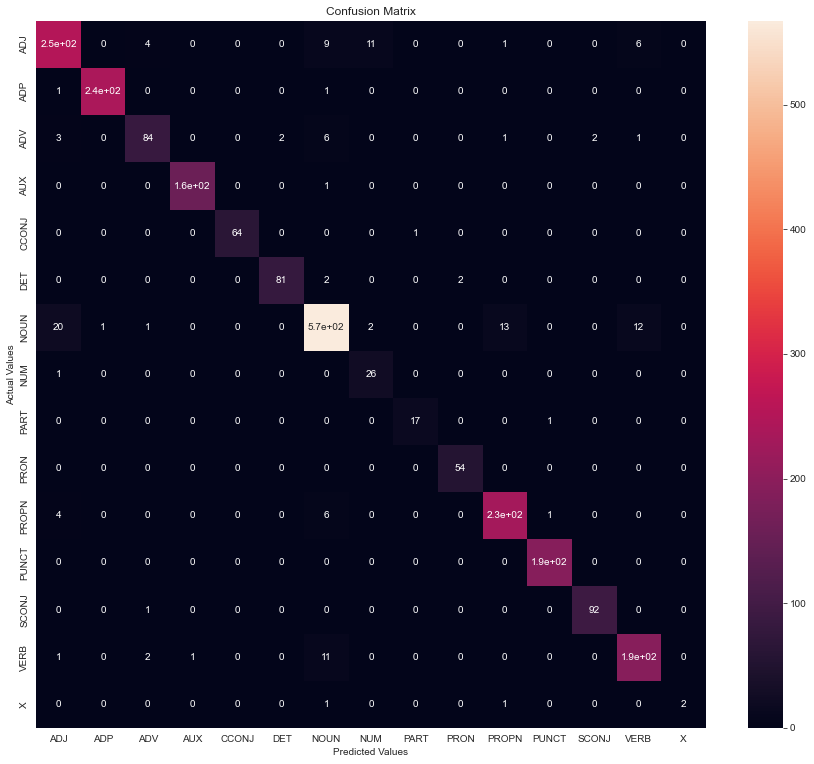

In [28]:
classes = np.union1d(np.unique(actual), np.unique(predicted))
cm = metrics.confusion_matrix(actual, predicted)
cm_df = pd.DataFrame(cm,
                     index = classes,
                     columns = classes)

# Crtanje
plt.figure(figsize=(15,13))
sns.heatmap(cm_df, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.savefig(f"resources/model_library/custom_upos_tagger/confusion_matrix.png")
plt.show()

In [29]:
print(metrics.classification_report(actual,predicted))

              precision    recall  f1-score   support

         ADJ       0.89      0.89      0.89       282
         ADP       1.00      0.99      0.99       243
         ADV       0.91      0.85      0.88        99
         AUX       0.99      0.99      0.99       158
       CCONJ       1.00      0.98      0.99        65
         DET       0.98      0.95      0.96        85
        NOUN       0.94      0.92      0.93       616
         NUM       0.67      0.96      0.79        27
        PART       0.94      0.94      0.94        18
        PRON       0.96      1.00      0.98        54
       PROPN       0.94      0.95      0.95       243
       PUNCT       0.99      1.00      0.99       191
       SCONJ       0.98      0.99      0.98        93
        VERB       0.91      0.93      0.92       209
           X       1.00      0.50      0.67         4

    accuracy                           0.94      2387
   macro avg       0.94      0.92      0.92      2387
weighted avg       0.95   

In [30]:
def serialize_int32(obj):
    if isinstance(obj, np.int32):
        return int(obj)
    raise TypeError ("Type %s is not serializable" % type(obj))

In [31]:
# Cuvanje rezultata
with open(f"resources/model_library/custom_upos_tagger/best_params.json", "w") as f:
     f.write(json.dumps(best_params, default=serialize_int32))

In [32]:
with open(f"resources/model_library/custom_upos_tagger/model_hist.json", "w") as f:
    f.write(json.dumps(model_history,default=serialize_int32))

In [34]:
sentence = corpus2.test[17]
model.predict(sentence)
print("\n\n")

# Predvidi etikete i štampaj
for i,token in enumerate(sentence):
    predictedLabels = token.get_labels('upos')
    actualLabels = sentence[i].get_labels('upos')

    for j, label in enumerate(predictedLabels):
        token = label.data_point.form
        predictedValue = label.value
        actualValue = actualLabels[j].value

        print(token, "- predicted:" ,predictedValue, ", actual:", actualValue)




Ključni - predicted: ADJ , actual: ADJ
dogovori - predicted: ADJ , actual: ADJ
postignuti - predicted: NOUN , actual: NOUN
tokom - predicted: ADP , actual: ADP
dvodnevnog - predicted: ADJ , actual: ADJ
samita - predicted: NOUN , actual: NOUN
NATO-a - predicted: PROPN , actual: PROPN
u - predicted: ADP , actual: ADP
Istanbulu - predicted: PROPN , actual: PROPN
uključuju - predicted: VERB , actual: VERB
i - predicted: CCONJ , actual: CCONJ
odluku - predicted: NOUN , actual: NOUN
o - predicted: ADP , actual: ADP
pokretanju - predicted: NOUN , actual: NOUN
programa - predicted: NOUN , actual: NOUN
obuke - predicted: NOUN , actual: NOUN
iračkih - predicted: ADJ , actual: ADJ
snaga - predicted: NOUN , actual: NOUN
bezbednosti - predicted: NOUN , actual: NOUN
i - predicted: CCONJ , actual: CCONJ
obećanje - predicted: NOUN , actual: NOUN
da - predicted: SCONJ , actual: SCONJ
će - predicted: AUX , actual: AUX
biti - predicted: AUX , actual: AUX
povećan - predicted: ADJ , actual: ADJ
broj - p